In [270]:
from __future__ import division

import numpy as np
import os, sys
from PIL import Image
import pandas as pd
import json
import pickle

from matplotlib import pylab, mlab, pyplot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.path import Path
import matplotlib.patches as patches
%matplotlib inline

from IPython.core.pylabtools import figsize, getfigs

import seaborn as sns
from itertools import product
import random

from scipy.stats import norm
from IPython.display import clear_output

import copy
import importlib


### Add Paths

## root paths
curr_dir = os.getcwd()
proj_dir = os.path.abspath(os.path.join(curr_dir,'..')) ## use relative paths

## add helpers to python path
import sys
if os.path.join(proj_dir, 'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir, 'stimuli'))
    
## import utils from git submodule
sys.path.append("block_utils/")
import blockworld_utils as utils

from block_dict_to_input_program import convert

In [3]:
# set varaible for domino-style structures (two blocks, red and blue)

import domino_settings as dominoes

block_dims = dominoes.block_dims
block_colors = dominoes.block_colors
world_width = dominoes.world_width
world_height = dominoes.world_height
world_center = dominoes.world_center
black = ['#000000','#000000'] # used to display silhouettes
grey = ['#333333','#333333']

In [6]:
'''
#### Castle building functions ####

Functions that take a world object always return a world object.

These are designed with rejection sampling in mind.
If the function causes something bad to occur (e.g. breaks the tower that is being placed),
then world.broken is set to true.


'''

def new_world():
    return utils.World(block_dims = block_dims, 
                        block_colors = block_colors,
                        world_width = 20,
                        world_height = 20)


def stack(w, tower, n = 1, x_location = 0):
    '''
    Places n towers in the same xlocation.
    '''
    
    for i in range(0, n):
        w.place_tower(tower, x_location)

    return w


def row(w, tower, n = 1, diff = 0):
    '''
    Places tower n times in a row with diff squares between each one.
    '''
    
    for i in range(0, n):
        w.place_tower_relative(tower, direction='right', diff=diff)

    return w


def mirror(t):
    '''
    Mirror flips a tower dict/json (along vertical axis) and aligns to left.
    '''

    t2 = []
    for b in t:
        adjust = 1 if b['width'] == 1 else 0

        t2.append({
            'x': - b['x'] + 10 + adjust,
            'y': b['y'],
            'height': b['height'],
            'width': b['width'],
        })
        
    xs = [b['x'] for b in t2]
    min(xs)
    for b in t2:
        b['x'] = b['x'] - min(xs)

    return t2


def diag(w, tower, n = 1, direction = 'right'):
    
    if direction == 'right':
        for i in range(0, n):
            w.place_tower_relative(tower, direction='right', diff=-1)

        return w
    
    else:
        for i in range(0, n):
            t = utils.worldify(tower)
            w.place_tower_relative(tower, direction='left', diff=t.tower_width() - 1)

        return w
    
    
    
### Roof kinds
    
def pyramid(w, levels, tile = [{'x': 0, 
                                'y': 0, 
                                'height': 1, 
                                'width': 2}]):
    
    tile_world = utils.worldify(tile)
    
    
    cur_level = 0
    
    for i in range(0, levels):
        
#         n_blocks = levels-i
        
        start_location = 0 + i #hardcoded i for indiviudal blocks
        
        for j in range(0, levels-i):
            w.place_tower(tile, x_location = start_location + j*tile_world.tower_width())
            

    return w
    
    
def dome(w, levels, tile = [{'x': 0, 
                                'y': 0, 
                                'height': 1, 
                                'width': 2}]):
    
    tile_world = utils.worldify(tile)
    
    
    cur_level = 0
    
    for i in range(0, levels):
        
#         n_blocks = levels-i
        
        start_location = 0 + i #hardcoded i for indiviudal blocks

        if i == 0: # double up on first layer
            for j in range(0, levels-i-1):
                w.place_tower(tile, x_location = start_location -1 + (j+1)*tile_world.tower_width())

        for j in range(0, levels-i):
            w.place_tower(tile, x_location = start_location + j*tile_world.tower_width())
            

            

    return w
    
    
def slab(w, width, levels = 1, tile = [{'x': 0, 
                                'y': 0, 
                                'height': 2, 
                                'width': 1}]):
    
    tile_world = utils.worldify(tile)
    
    for lev in range(0, levels):

        for i in range(0, width):

            w.place_tower(tile, x_location = i*tile_world.tower_width())
            

    return w


def vertical_brick_layer(w, width, x_location = 0, levels = 1, tile = [{'x': 0, 
                                'y': 0, 
                                'height': 2, 
                                'width': 1}]):
    
    tile_world = utils.worldify(tile)
    
    for lev in range(0, levels):

        for i in range(0, width):

            w.place_tower(tile, x_location = x_location + i*tile_world.tower_width())
            

    return w



def castillate(w, width, gap=2, x_location = 0, tile = [{'x': 0, 
                                'y': 0, 
                                'height': 2, 
                                'width': 1}]):
    
    tile_world = utils.worldify(tile)
    

    for i in range(0, width):
        
        if i%gap==0:
            w.place_tower(tile, x_location = x_location + i*tile_world.tower_width())
            

    return w

def symmetrical_castillate(w, gap=2):
    
    castillate(w, width=int(w.tower_width()/2), gap=gap)
    
    castillate(w, width=int(w.tower_width()/2), gap=gap, x_location=int(w.tower_width()/2)+1)


def horizontal_brick_layer(w, width, x_location = 0, levels = 1, tile = [{'x': 0, 
                                'y': 0, 
                                'height': 1, 
                                'width': 2}]):
    
    tile_world = utils.worldify(tile)
    
    for lev in range(0, levels):

        for i in range(0, int(width/2)):

            w.place_tower(tile, x_location = x_location + i*tile_world.tower_width())
            

    return w


def vertical_line(w, height, x_location = 0, tile = [{'x': 0, 
                                'y': 0, 
                                'height': 2, 
                                'width': 1}]):
    
    tile_world = utils.worldify(tile)
    
    for brick in range(0, int(height/2)):
        w.place_tower(tile, x_location = x_location)
            

    return w

def viaduct(w):
    horizontal_brick_layer(w, w.tower_width())

# Enumeration

In [8]:
# hardcoded components

# Generic

HORIZONTAL = [{'x': 0, 'y': 0, 'height': 1, 'width': 2}]

VERTICAL = [{'x': 0, 'y': 0, 'height': 2, 'width': 1}]

ARCH = [{'x': 0, 'y': 0, 'height': 2, 'width': 1},
        {'x': 0, 'y': 2, 'height': 1, 'width': 2},
        {'x': 3, 'y': 0, 'height': 2, 'width': 1},
        {'x': 2, 'y': 2, 'height': 1, 'width': 2},]

# Houses

SMALL_WINDOW = [{'x': 0, 'y': 0, 'height': 1, 'width': 2}, 
          {'x': 2, 'y': 0, 'height': 1, 'width': 2}, 
          {'x': 0, 'y': 1, 'height': 2, 'width': 1}, 
          {'x': 3, 'y': 1, 'height': 2, 'width': 1}, 
          {'x': 0, 'y': 3, 'height': 1, 'width': 2}, 
          {'x': 2, 'y': 3, 'height': 1, 'width': 2}]

BIG_WINDOW = [{'x': 0, 'y': 0, 'height': 1, 'width': 2},
               {'x': 2, 'y': 0, 'height': 1, 'width': 2},
               {'x': 0, 'y': 1, 'height': 2, 'width': 1},
               {'x': 0, 'y': 3, 'height': 2, 'width': 1},
               {'x': 3, 'y': 1, 'height': 2, 'width': 1},
               {'x': 3, 'y': 3, 'height': 2, 'width': 1},
               {'x': 0, 'y': 5, 'height': 1, 'width': 2},
               {'x': 2, 'y': 5, 'height': 1, 'width': 2}]

DOOR = [{'x': 0, 'y': 0, 'height': 2, 'width': 1},
        {'x': 0, 'y': 2, 'height': 2, 'width': 1}, 
        {'x': 3, 'y': 0, 'height': 2, 'width': 1}, 
        {'x': 3, 'y': 2, 'height': 2, 'width': 1}]

HOUSE_BRICKS = [{'x': 0, 'y': 0, 'height': 1, 'width': 2}, 
          {'x': 2, 'y': 0, 'height': 1, 'width': 2}, 
          {'x': 0, 'y': 1, 'height': 2, 'width': 1}, 
          {'x': 3, 'y': 1, 'height': 2, 'width': 1}, 
          {'x': 1, 'y': 1, 'height': 1, 'width': 2}, 
          {'x': 1, 'y': 2, 'height': 1, 'width': 2}, 
          {'x': 0, 'y': 3, 'height': 1, 'width': 2}, 
          {'x': 2, 'y': 3, 'height': 1, 'width': 2}]



# Bridges
ARCH_W4 = [{'x': 0, 'y': 0, 'height': 2, 'width': 1}, 
           {'x': 3, 'y': 0, 'height': 2, 'width': 1}, 
           {'x': 0, 'y': 2, 'height': 1, 'width': 2}, 
           {'x': 2, 'y': 2, 'height': 1, 'width': 2}]

ARCH_W6 = [{'x': 0, 'y': 0, 'height': 1, 'width': 2},
           {'x': 1, 'y': 1, 'height': 1, 'width': 2}, 
           {'x': 4, 'y': 0, 'height': 1, 'width': 2}, 
           {'x': 3, 'y': 1, 'height': 1, 'width': 2}, 
           {'x': 0, 'y': 2, 'height': 1, 'width': 2}, 
           {'x': 2, 'y': 2, 'height': 1, 'width': 2}, 
           {'x': 4, 'y': 2, 'height': 1, 'width': 2}]

ARCH_W8 = [{'x': 0, 'y': 0, 'height': 1, 'width': 2}, 
           {'x': 6, 'y': 0, 'height': 1, 'width': 2},
           {'x': 1, 'y': 1, 'height': 1, 'width': 2}, 
           {'x': 5, 'y': 1, 'height': 1, 'width': 2}, 
           {'x': 2, 'y': 2, 'height': 1, 'width': 2}, 
           {'x': 4, 'y': 2, 'height': 1, 'width': 2}, 
           {'x': 0, 'y': 2, 'height': 1, 'width': 2}, 
           {'x': 6, 'y': 2, 'height': 1, 'width': 2}]

ARCHES_EQUAL_HEIGHTS = {4: ARCH_W4,
                        6: ARCH_W6, 
                        8: ARCH_W8}

# Bricks/tiles for walls, towers, and turrets

MANUAL_BRICK_SQUARE = [{'x': 0, 'y': 0, 'height': 1, 'width': 2}, 
                       {'x': 2, 'y': 0, 'height': 2, 'width': 1}, 
                       {'x': 0, 'y': 1, 'height': 2, 'width': 1}, 
                       {'x': 1, 'y': 2, 'height': 1, 'width': 2}]

MANUAL_BRICK_BIRD = [{'x': 1, 'y': 0, 'height': 2, 'width': 1}, 
                     {'x': 2, 'y': 0, 'height': 1, 'width': 2}, 
                     {'x': 2, 'y': 1, 'height': 2, 'width': 1}, 
                     {'x': 0, 'y': 2, 'height': 1, 'width': 2}]

MANUAL_BRICK_ARCH = [{'x': 0, 'y': 0, 'height': 2, 'width': 1}, 
                     {'x': 3, 'y': 0, 'height': 2, 'width': 1}, 
                     {'x': 0, 'y': 2, 'height': 1, 'width': 2}, 
                     {'x': 2, 'y': 2, 'height': 1, 'width': 2}]

MANUAL_BRICK_TSHIRT = [{'x': 1, 'y': 0, 'height': 2, 'width': 1}, 
                       {'x': 2, 'y': 0, 'height': 2, 'width': 1}, 
                       {'x': 0, 'y': 2, 'height': 1, 'width': 2}, 
                       {'x': 2, 'y': 2, 'height': 1, 'width': 2}] 

MANUAL_BRICK_SWAN = [{'x': 0, 'y': 0, 'height': 1, 'width': 2}, 
                     {'x': 2, 'y': 0, 'height': 2, 'width': 1}, 
                     {'x': 0, 'y': 1, 'height': 2, 'width': 1}, 
                     {'x': 2, 'y': 2, 'height': 1, 'width': 2}]

MANUAL_BRICK_PEGODA = [{'x': 1, 'y': 0, 'height': 1, 'width': 2}, 
                       {'x': 0, 'y': 1, 'height': 1, 'width': 2}, 
                       {'x': 2, 'y': 1, 'height': 1, 'width': 2}]

MANUAL_BRICK_BRICKS = [{'x': 0, 'y': 0, 'height': 1, 'width': 2}, 
                       {'x': 1, 'y': 1, 'height': 2, 'width': 1}, 
                       {'x': 0, 'y': 1, 'height': 2, 'width': 1}, 
                       {'x': 3, 'y': 0, 'height': 2, 'width': 1}, 
                       {'x': 2, 'y': 0, 'height': 2, 'width': 1}, 
                       {'x': 2, 'y': 2, 'height': 1, 'width': 2}]

MANUAL_BRICK_CHECKED = [{'x': 0, 'y': 0, 'height': 1, 'width': 2}, 
                        {'x': 0, 'y': 1, 'height': 1, 'width': 2}, 
                        {'x': 1, 'y': 2, 'height': 2, 'width': 1}, 
                        {'x': 0, 'y': 2, 'height': 2, 'width': 1}, 
                        {'x': 3, 'y': 0, 'height': 2, 'width': 1}, 
                        {'x': 2, 'y': 0, 'height': 2, 'width': 1}, 
                        {'x': 2, 'y': 2, 'height': 1, 'width': 2}, 
                        {'x': 2, 'y': 3, 'height': 1, 'width': 2}]

tower_bricks_manual = [MANUAL_BRICK_SQUARE,
                      MANUAL_BRICK_BIRD,
                      MANUAL_BRICK_ARCH,
                      MANUAL_BRICK_TSHIRT,
                      MANUAL_BRICK_SWAN,
                      MANUAL_BRICK_PEGODA,
                      MANUAL_BRICK_BRICKS,
                      MANUAL_BRICK_CHECKED,
                      SMALL_WINDOW,
                      BIG_WINDOW]

In [14]:
# Pre-build roofs

pyramids = {}

for roof_size in range(1,20):
    
    r = new_world()
    pyramid(r, int(roof_size/2))
    roof_dict = r.get_block_dict()['blocks']
    
    if (r.broken):
        print('BAD ROOF- RESIZE WORLD?')
        #utils.draw_world(wall)
    else:
        pyramids[roof_size] = roof_dict

        
domes = {}

for roof_size in range(1,20):
    
    r = new_world()
    dome(r, int(roof_size/2))
    roof_dict = r.get_block_dict()['blocks']
    
    if (r.broken):
        print('BAD ROOF- RESIZE WORLD?')
    else:
        domes[roof_size] = roof_dict
#         utils.draw_world(d)


slabs = {}

for width in range(1,20):
    
    r = new_world()
    slab(r, width)
    row_dict = r.get_block_dict()['blocks']
    
    if (r.broken):
        print('BAD ROOF- RESIZE WORLD?')
        #utils.draw_world(wall)
    else:
        slabs[width] = row_dict
      
    
flats = {}   

for width in range(1,20):
    
    r = new_world()
    horizontal_brick_layer(r, int(roof_size/2))
    row_dict = r.get_block_dict()['blocks']
    
    if (r.broken):
        print('BAD ROOF- RESIZE WORLD?')
        #utils.draw_world(wall)
    else:
        flats[width] = row_dict

In [164]:
RANDOM_SEED = 0

## Enumerate Skyscrapers

#### Individual skyscrapers

In [ ]:
random.seed(RANDOM_SEED)

In [152]:
MAX_SKYSCRAPER_HEIGHT = 4
MIN_SKYSCRAPER_HEIGHT = 1

SKYSCRAPER_ROOFS = {'pyramids': pyramids,
#                     'slabs': slabs,
                    'flats': flats}

REPEAT_OPTIONS = ['mirrored', 'repeated', 'single']

In [153]:
skyscrapers = []
df_skyscrapers = pd.DataFrame()

for skyscraper_1_height in range(MIN_SKYSCRAPER_HEIGHT, MAX_SKYSCRAPER_HEIGHT+1):
    for t_1_brick in tower_bricks_manual:

        t_1_brick_width = utils.worldify(t_1_brick).tower_width()

        for repeat_option in REPEAT_OPTIONS:

            for _, (roof_1_name, roof_1_type) in enumerate(SKYSCRAPER_ROOFS.items()):

                w = new_world()

                # vertically stack bricks for tower one
                stack(w, t_1_brick, n=skyscraper_1_height, x_location=0)

                if repeat_option == 'mirrored':
                    # repeat but mirrored
                    stack(w, mirror(t_1_brick), n=skyscraper_1_height, x_location=t_1_brick_width)
                    # add roof
                    if roof_1_name != 'none':
                        wall_width = roof_1_type[t_1_brick_width*2]
                        w.place_tower(wall_width, 0)

                elif repeat_option == 'repeated':
                    # repeat
                    stack(w, t_1_brick, n=skyscraper_1_height, x_location=t_1_brick_width)

                    # add roof
                    if roof_1_name != 'none':
                        wall_width = roof_1_type[t_1_brick_width*2]
                        w.place_tower(wall_width, 0)

                elif repeat_option == 'single':

                    # add roof
                    if roof_1_name != 'none':
                        wall_width = roof_1_type[t_1_brick_width]
                        w.place_tower(wall_width, 0)

                else:
                    raise Exception("No such mirror option (\"{}\") supported".format(repeat_option))


                if not w.broken:
                    skyscrapers.append(w)
                    df_skyscrapers = df_skyscrapers.append(
                        {
                            'structure_type': 'skyscraper',
                            'blocks': w.get_block_dict()['blocks'],
                            'structure_width': w.tower_width(),
                            'structure_height': w.tower_height(),
                            'n_blocks': len(w.blocks),
                            'brick': t_1_brick,
                            'roof_name': roof_1_name,
                            'skyscraper_height':skyscraper_1_height,
                            'roof_size': wall_width,
                            'repeat_option': repeat_option,
                        }, ignore_index=True
                    )

print(str(len(skyscrapers)) + ' individual skyscrapers generated')


185 individual skyscrapers generated


Pairs of skyscrapers

In [82]:
MIN_SKYSCRAPER_GAP = 1
MAX_SKYSCRAPER_GAP = 2

In [83]:
cities = []
df_cities = pd.DataFrame()

for i, s1 in df_skyscrapers.iterrows():
    for j, s2 in df_skyscrapers.iterrows():
        for gap in range(MIN_SKYSCRAPER_GAP, MAX_SKYSCRAPER_GAP+1):
            
            w = new_world()
            w = w.place_tower(s1.blocks, 0)
            w.place_tower(s2.blocks, x_location = int(s1.structure_width+gap))
            
            if not w.broken:
                cities.append(w)
                df_cities = df_cities.append(
                    {
                        'structure_type': 'city',
                        'blocks': w.get_block_dict()['blocks'],
                        'structure_width': w.tower_width(),
                        'structure_height': w.tower_height(),
                        'n_blocks': len(w.blocks),
                        't_1_brick': s1.brick,
                        't_2_brick': s2.brick,
                        'gap': gap,
                        'roof_1_name': s1.roof_name,
                        'roof_2_name': s2.roof_name,
                        'skyscraper_1_height': s1.skyscraper_height,
                        'skyscraper_2_height': s2.skyscraper_height,
                    }, ignore_index=True
                )

print(str(len(cities)) + ' pairs of skyscrapers generated')

68450 pairs of skyscrapers generated


## Enumerate Houses

In [198]:
random.seed(RANDOM_SEED)

In [199]:
HOUSE_WIDTHS = [1,2,3]
HOUSE_HEIGHTS = [1,2,3]

TILE_WIDTH = 4
TILE_HEIGHT = 4

MIN_DOOR = 0
MAX_DOOR = 2

HOUSE_ROOFS = {'pyramids': pyramids}

FIRST_STORY_COMPONENTS = [DOOR,
                            SMALL_WINDOW,
                            HOUSE_BRICKS]

OTHER_STORY_COMPONENTS = [SMALL_WINDOW,
                            HOUSE_BRICKS]

In [200]:
# get all permutations of components

# ground floors can include doors
first_stories = {}
for house_width in HOUSE_WIDTHS:
    repeated_components = [FIRST_STORY_COMPONENTS] * house_width
    first_stories[house_width] = list(product(*repeated_components))


# non-ground floors don't included doors
other_stories = {}
for house_width in HOUSE_WIDTHS:
    repeated_components = [OTHER_STORY_COMPONENTS] * house_width
    other_stories[house_width] = list(product(*repeated_components))

In [201]:
def floor_tuple_to_floor_world(tiles):
    '''
    Helper function to convert json to world object
    '''
    w = new_world()
    for i, tile in enumerate(tiles):
        w.place_tower_relative(tile)
        
    return w

In [426]:
houses = []
df_houses = pd.DataFrame()

generation_probability = 1.0

for house_width in HOUSE_WIDTHS:
    
#     structure_generation_probability = generation_probability * (0.8 ** float(house_width))
    
    first_story_worlds = [floor_tuple_to_floor_world(blocks) for blocks in first_stories[house_width]]
    other_story_worlds = [floor_tuple_to_floor_world(blocks) for blocks in other_stories[house_width]]
    
    for _, (roof_name, roof_type) in enumerate(HOUSE_ROOFS.items()):

        # one story
        for s_1 in first_story_worlds:
            
            structure_generation_probability = generation_probability * 0.9 ** (house_width)

            w = new_world()
            w.place_tower(s_1.get_block_dict()['blocks'])
            w.place_tower(roof_type[house_width*4])

            if (not(w.broken)) & (random.uniform(0, 1) < structure_generation_probability):
                    houses.append(w)
                    df_houses = df_houses.append(
                        {
                            'structure_type': 'house',
                            'blocks': w.get_block_dict()['blocks'],
                            'structure_width': w.tower_width(),
                            'structure_height': w.tower_height(),
                            'n_blocks': len(w.blocks),
                            'house_width': house_width,
                            'n_stories': 1,
                            'roof_name': roof_name
                        }, ignore_index=True
                        )

        # two story
        for s_1 in first_story_worlds:
            for s_2 in other_story_worlds:
                
                structure_generation_probability = generation_probability * 0.9 ** (2 ** house_width)

                w = new_world()
                w.place_tower(s_1.get_block_dict()['blocks'])
                w.place_tower(s_2.get_block_dict()['blocks'])
                w.place_tower(roof_type[house_width*4])

                if (not(w.broken)) & (random.uniform(0, 1) < structure_generation_probability):
                    houses.append(w)
                    df_houses = df_houses.append(
                        {
                            'structure_type': 'house',
                            'blocks': w.get_block_dict()['blocks'],
                            'structure_width': w.tower_width(),
                            'structure_height': w.tower_height(),
                            'n_blocks': len(w.blocks),
                            'house_width': house_width,
                            'n_stories': 2,
                            'roof_name': roof_name
                        }, ignore_index=True
                    )
    
        # two story
        for s_1 in first_story_worlds:
            for s_2 in other_story_worlds:
                for s_3 in other_story_worlds:
                    
                    structure_generation_probability = generation_probability * 0.9 ** (3 ** house_width)

                    w = new_world()
                    w.place_tower(s_1.get_block_dict()['blocks'])
                    w.place_tower(s_2.get_block_dict()['blocks'])
                    w.place_tower(s_3.get_block_dict()['blocks'])
                    w.place_tower(roof_type[house_width*4])

                    if (not(w.broken)) & (random.uniform(0, 1) < structure_generation_probability):
                        houses.append(w)
                        df_houses = df_houses.append(
                        {
                            'structure_type': 'house',
                            'blocks': w.get_block_dict()['blocks'],
                            'structure_width': w.tower_width(),
                            'structure_height': w.tower_height(),
                            'n_blocks': len(w.blocks),
                            'house_width': house_width,
                            'n_stories': 3,
                            'roof_name': roof_name
                        }, ignore_index=True
                        )
                        
print(str(len(houses)) + ' houses generated')

320 houses generated


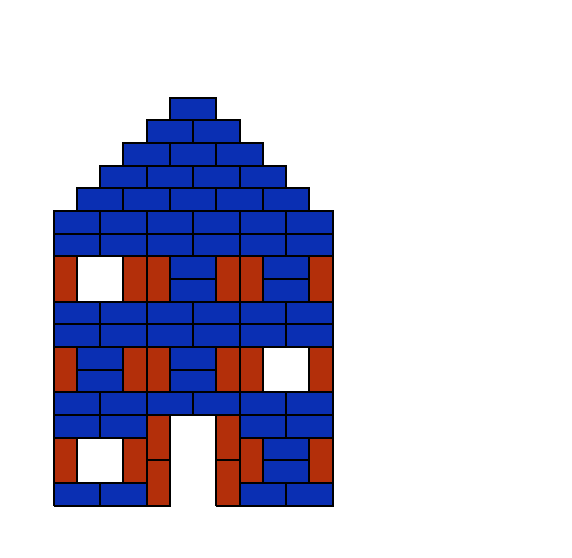

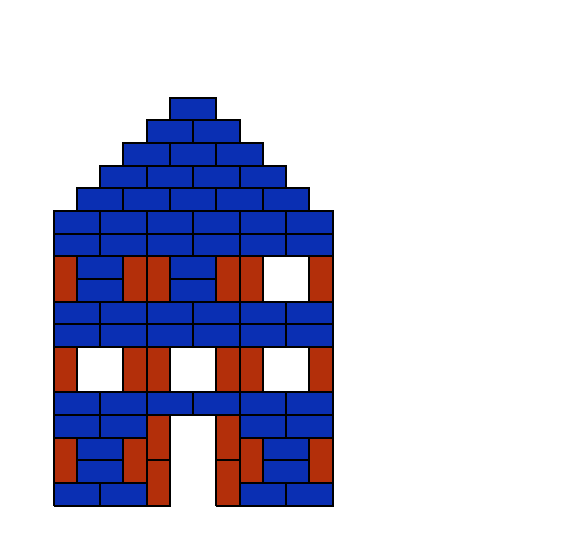

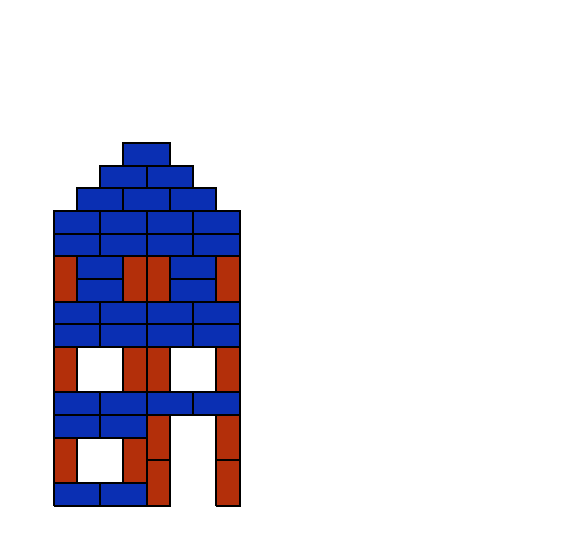

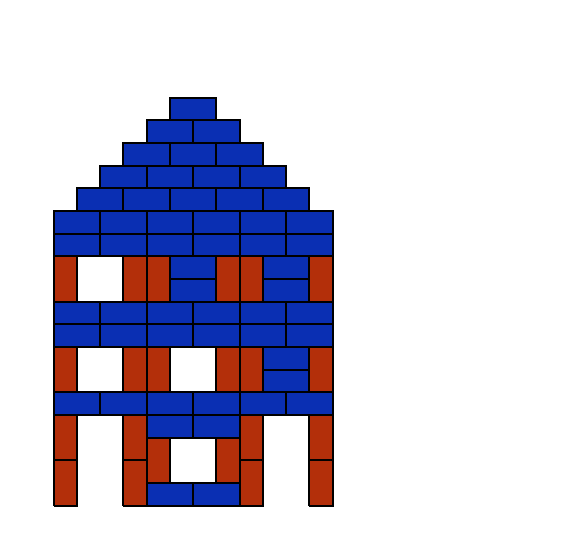

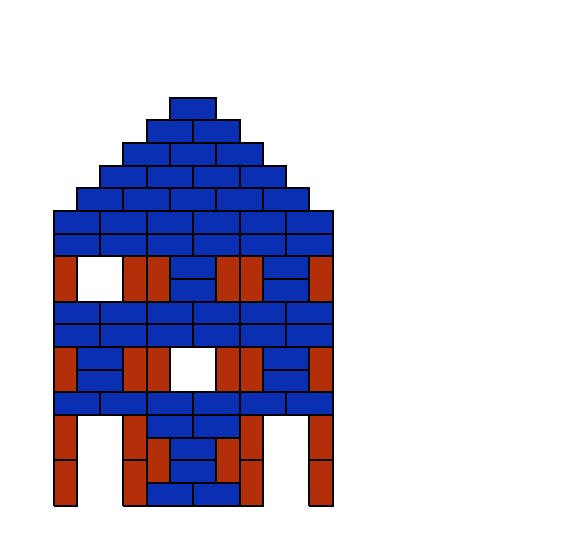

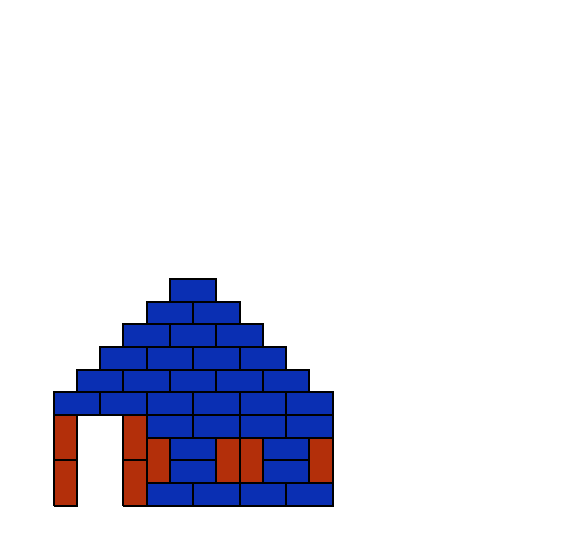

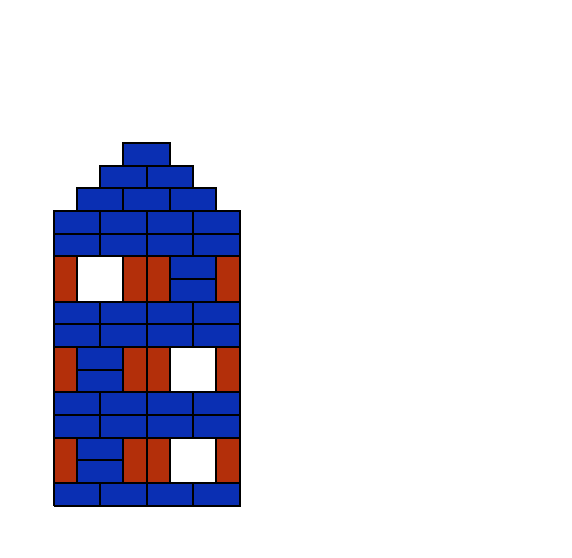

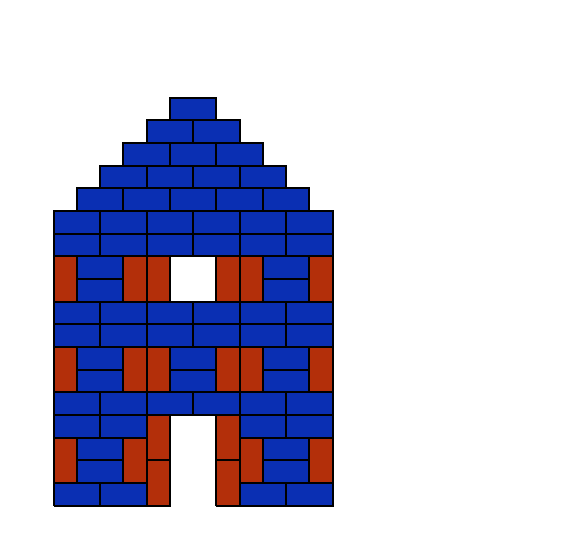

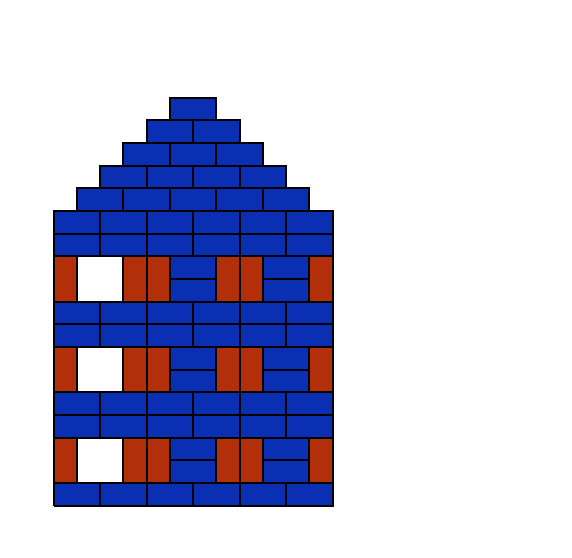

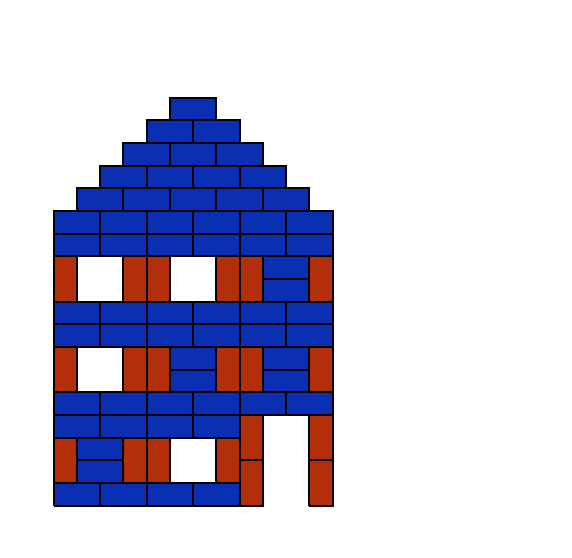

[<Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>]

In [209]:
[utils.draw_world(w) for w in random.sample(houses,10)]

In [430]:
df_houses.groupby(['n_stories','house_width']).count()

structure_type  blocks  structure_width  \
n_stories house_width                                            
1.0       1.0                       3       3                3   
          2.0                       7       7                7   
          3.0                      21      21               21   
2.0       1.0                       5       5                5   
          2.0                      23      23               23   
          3.0                      93      93               93   
3.0       1.0                       9       9                9   
          2.0                      60      60               60   
          3.0                      99      99               99   

                       structure_height  n_blocks  roof_name  
n_stories house_width                                         
1.0       1.0                         3         3          3  
          2.0                         7         7          7  
          3.0                        21        21         21  
2.0       1.0                         5         5          5  
          2.0                        23        23         23  
          3.0                        93        93         93  
3.0       1.0                         9         9          9  
          2.0                        60        60         60  
          3.0                        99        99         99

## Enumerate Castles

- Bilateral symmetry
- Central wall constructed from one repeated 4-block motif (mirrored)
- Turrets constructed from one repeated 4-block motif (mirrored either side)
- Same style roof on turrets and center

In [ ]:
random.seed(RANDOM_SEED)

In [47]:
MIN_CASTLE_WALL_HEIGHT = 1
MAX_CASTLE_WALL_HEIGHT = 4
CASTLE_WALL_SIZES = [2,4]


MIN_CASTLE_TOWER_HEIGHT = 1
MAX_CASTLE_TOWER_HEIGHT = 4

CASTLE_ROOFS = {'pyramid': pyramids,
         'dome': domes}

In [564]:
castles = []
df_castles = pd.DataFrame()

for wall_height in range(MIN_CASTLE_WALL_HEIGHT, MAX_CASTLE_WALL_HEIGHT + 1):
    
    # outer towers must be shorter 
    for tower_height in range(MIN_CASTLE_TOWER_HEIGHT, MAX_CASTLE_TOWER_HEIGHT + 1):
        
        for wall_size in CASTLE_WALL_SIZES:
            
             for wall_brick in tower_bricks_manual:
                    
                    for tower_brick in tower_bricks_manual:
                        
                        for _, (roof_name, roof_type) in enumerate(CASTLE_ROOFS.items()):
                            
                            structure_generation_probability = 1.0

                            w = new_world() #castle object

                            #tower world object
                            tower_w = new_world()
                            tower_w = stack(tower_w, tower_brick, tower_height)
                            tower_width = tower_w.tower_width()
                            tower = tower_w.get_block_dict()['blocks']

                            #wall world object
                            wall_column_w = new_world()
                            wall_column_w = stack(wall_column_w, wall_brick, wall_height)
                            wall_column_width = wall_column_w.tower_width()
                            wall_column = wall_column_w.get_block_dict()['blocks']

                            # place left tower
                            w.place_tower_relative(tower)

                            # add roof to left tower
                            if tower_width >= 4:
                                w.place_tower(roof_type[tower_width])

                            # construct wall
                            for i in range(0,int(wall_size/2)):
                                w.place_tower_relative(wall_column)

                            for i in range(0,int(wall_size/2)):
                                w.place_tower_relative(mirror(wall_column))

                            wall_width = wall_column_width*wall_size

                            # add roof to wall
                            w.place_tower(roof_type[wall_width], tower_width)

                            # place right tower
                            w.place_tower_relative(mirror(tower))

                            # add roof to right tower
                            if tower_width >= 4:
                                w.place_tower(roof_type[tower_width], 
                                              tower_width + wall_width)
                                
                                
                            # avoid particularly evocative towers
                            if (w.tower_height() > 13) and (tower_height < 3) and \
                            ((roof_name=='dome') or ((roof_name=='none') and (tower_width==3))):
                                structure_generation_probability = 0.0
                            

                            if (not(w.broken)) & (random.uniform(0,1) < structure_generation_probability):
                                castles.append(w)
                                df_castles = df_castles.append(
                                    {
                                        'structure_type': 'castle',
                                        'blocks': w.get_block_dict()['blocks'],
                                        'structure_width': w.tower_width(),
                                        'structure_height': w.tower_height(),
                                        'n_blocks': len(w.blocks),
                                        'wall_height': wall_height,
                                        'wall_size': wall_size,
                                        'wall_brick': wall_brick,
                                        'tower_brick': tower_brick,
                                        'tower_height': tower_height,
                                        'roof_name': roof_name,
                                        'central_roof_size': wall_width,
                                        'tower_roof_size': tower_width,
                                    }, ignore_index=True
                                )
    #                             fig = utils.draw_world(w)
    #                             n_towers += 1

print(str(len(castles)) + ' castles generated')

2778 castles generated


## Enumerate Bridges

In [ ]:
random.seed(RANDOM_SEED) # unused in bridges right now 

In [49]:
MIN_N_ARCHES = 1
MAX_N_ARCHES = 5
MAX_BRIDGE_ELEVATION = 5

INNER_ARCH_WIDTHS = [4, 6, 8]
OUTER_ARCH_WIDTHS = [0, 4, 6, 8]

MIN_BRIDGE_THICKNESS = 0
MAX_BRIDGE_THICKNESS = 2

PILLAR_TYPES = ['none','uniform','high_middle','high_ends']

In [566]:
bridges = []
df_bridges = pd.DataFrame()

for n_inner_arch in range(MIN_N_ARCHES, MAX_N_ARCHES+1):

    for bridge_elevation in range(1, MAX_BRIDGE_ELEVATION):

        for inner_width in INNER_ARCH_WIDTHS:

            for outer_width in OUTER_ARCH_WIDTHS:
                
                for pillar_type in PILLAR_TYPES:
                    
                    for bridge_thickness in range(MIN_BRIDGE_THICKNESS, MAX_BRIDGE_THICKNESS+1):

                        if outer_width == inner_width:
                            continue

                        w = new_world()

                        # create outer arches
                        if outer_width != 0:
                            outer_arch = ARCHES_EQUAL_HEIGHTS[outer_width]
                            outer_arch_world = new_world()
                            outer_arch_world.place_tower(outer_arch)


                        # create inner arches
                        inner_arch = ARCHES_EQUAL_HEIGHTS[inner_width]
                        inner_arch_world = new_world()
                        inner_arch_world.place_tower(inner_arch)


                        if outer_width != 0:
                            # place blocks under left outer arch
                            for j in range(0, bridge_elevation):
                                w.place_tower(VERTICAL, 
                                              x_location=0)
                                w.place_tower(VERTICAL, 
                                              x_location=outer_width-1)
                            # place left outer arch
                            w.place_tower(outer_arch)


                        for i in range(0,n_inner_arch):
                            # place blocks under inner arches
                            for j in range(0, bridge_elevation):
                                w.place_tower(VERTICAL, 
                                              x_location=outer_width+(i*inner_width))
                                w.place_tower(VERTICAL, 
                                              x_location=outer_width+((i+1)*inner_width)-1)
                            # place inner arche
                            w.place_tower(inner_arch,
                                          x_location=outer_width+i*inner_width)

                        if outer_width != 0:
                            # place blocks under right outer arch
                            for j in range(0, bridge_elevation):
                                w.place_tower(VERTICAL, 
                                              x_location=outer_width+(n_inner_arch*inner_width))
                                w.place_tower(VERTICAL, 
                                              x_location=outer_width+(n_inner_arch*inner_width)+outer_width-1)
                            # place right outer arch
                            w.place_tower(outer_arch,
                                          x_location=outer_width+(n_inner_arch*inner_width))


                        # Add layer of blue    
                        for i in range(0, bridge_thickness):
                            if i%2 == 0:
                                horizontal_brick_layer(w, w.tower_width()-2, x_location = 1)
                            else:
                                horizontal_brick_layer(w, w.tower_width(), x_location = 0)
                            
                            
                        # find where to place suspension pillars
                        if pillar_type != 'none':
                            arch_widths = []

                            if outer_width > 0:
                                arch_widths.append(outer_width)

                            for i in range(0, n_inner_arch):
                                arch_widths.append(inner_width)

                            if outer_width > 0:
                                arch_widths.append(outer_width)

                            arch_widths

                            pillar_locations = []

                            for arch_width in arch_widths:

                                if pillar_locations == []:
                                    pillar_locations.append(0)
                                    pillar_locations.append(arch_width-1)
                                else:
                                    pillar_locations.append(pillar_locations[-1]+1)
                                    pillar_locations.append(pillar_locations[-1]+arch_width-1)


                            if pillar_type == 'uniform':
                                for x_location in pillar_locations:
                                    w.place_tower(VERTICAL, 
                                                  x_location=x_location)

                            elif (pillar_type == 'high_middle'):
                                
                                if (len(pillar_locations) <= 2):
                                    continue
                                else:

                                    while len(pillar_locations)>=2:
                                        for x_location in pillar_locations:
                                            w.place_tower(VERTICAL, 
                                                          x_location=x_location)

                                        pillar_locations = pillar_locations[1:-1]

                            elif pillar_type == 'high_ends':
                                
                                if (len(pillar_locations) <= 2):
                                    continue
                                    
                                else:

                                    while len(pillar_locations)>=2:
                                        for x_location in pillar_locations:
                                            w.place_tower(VERTICAL, 
                                                          x_location=x_location)

                                        pillar_locations = pillar_locations[0:int(len(pillar_locations)/2)-1] + pillar_locations[int(len(pillar_locations)/2)+1:]


                        if not(w.broken):
                                bridges.append(w)
                                df_bridges = df_bridges.append(
                                    {
                                        'structure_type': 'bridge',
                                        'blocks': w.get_block_dict()['blocks'],
                                        'structure_width': w.tower_width(),
                                        'structure_height': w.tower_height(),
                                        'bridge_elevation': bridge_elevation,
                                        'n_blocks': len(w.blocks),
                                        'n_inner_arch': n_inner_arch,
                                        'pillar_type': pillar_type,
                                        'inner_width': inner_width,
                                        'outer_width': outer_width,
                                        'includes_outer_arches': outer_width != 0
                                    }, ignore_index=True
                                )

print(str(len(bridges)) + ' bridges generated')

744 bridges generated


## Separate dataframes for each structure

In [567]:
subdomains = ['bridge', 'house', 'castle', 'city']

full_dfs = {
    'bridge': df_bridges,
    'house': df_houses,
    'castle': df_castles,
    'city': df_cities
}

In [568]:
orders = {
    'bridge': ['includes_outer_arches', 'n_inner_arch', 'bridge_elevation', 'inner_width', 'structure_height'],
    'house': ['n_stories','house_width'],
    'castle': ['wall_height','wall_size','tower_height','roof_name'],
    'city': ['skyscraper_1_height', 'skyscraper_2_height', 'structure_height','gap']
}

#### subset 250 structure, order by quasi-complexity, assign to test or train

In [569]:
df_subsets = {}

for subdomain in subdomains:
    
    df_full = full_dfs[subdomain].copy()
    
    # add dreamcoder programs
    df_full['dreamcoder_program'] = df_full['blocks'].apply(lambda x: convert(x, whole_squares=False))
    df_full['program_whole_squares'] = \
            df_full['blocks'].apply(lambda x: convert(x, whole_squares=True))
    
    
    # sample
    df_subset = df_full.sample(frac=1, random_state=RANDOM_SEED)\
                                .head(250)


    # sort
    df_subset = df_subset.sort_values(orders[subdomain]).reset_index(drop=True)

    df_subset['structure_number'] = df_subset.index
    
    # test-train split

    train = df_subset.sample(frac=0.8, random_state=RANDOM_SEED) #random state is a seed value
    test = df_subset.drop(train.index)

    df_subset.loc[train.index,'train'] = True
    df_subset.loc[test.index,'train'] = False
    
    df_subsets[subdomain] = df_subset

### Export each domain for upload to S3

In [572]:
# export to inidividual jsons

for subdomain in subdomains:

    filepath ='./lax-structures-{}-all/'.format(subdomain)

    if not os.path.exists(filepath):
            os.makedirs(filepath)

    for i in df_subsets[subdomain].index:
#         df_subsets[subdomain].loc[i].to_json("./{}/lax-structures-{}-{}-{}.json".format(filepath, 
#                                                    df_subsets[subdomain].loc[i,'structure_type'],
#                                                    str(df_subsets[subdomain].loc[i,'structure_number']).zfill(3),
#                                                    'train' if df_subsets[subdomain].loc[i,'train'] else 'test'))
        df_subsets[subdomain].loc[i].to_json("./{}/lax-structures-{}-{}-all.json".format(filepath, 
                                                   df_subsets[subdomain].loc[i,'structure_type'],
                                                   str(df_subsets[subdomain].loc[i,'structure_number']).zfill(3)))


    df_subsets[subdomain].to_csv(filepath + 'df_{}.csv'.format(subdomain))

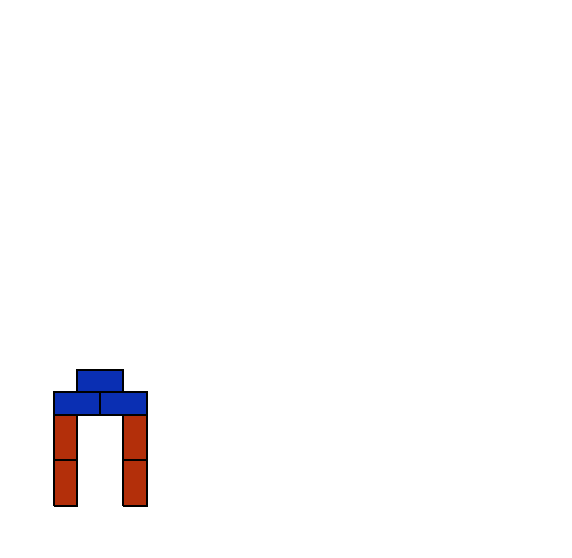

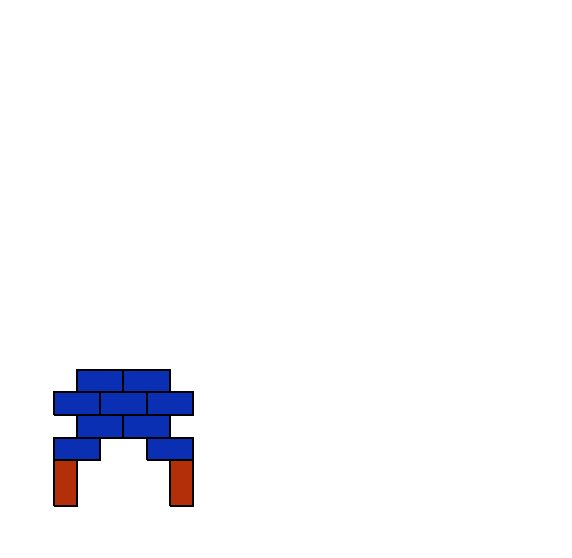

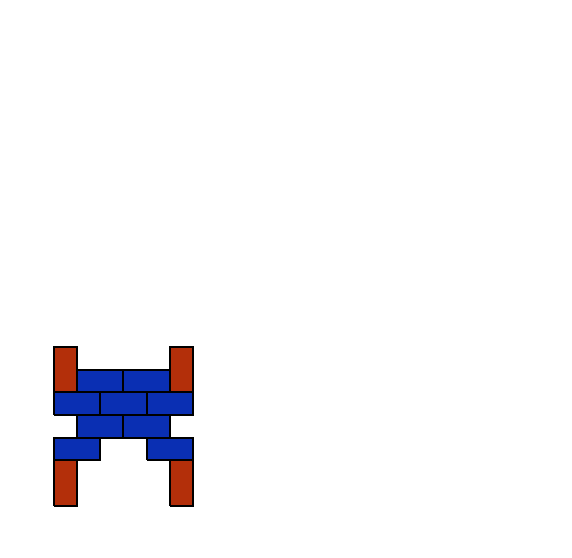

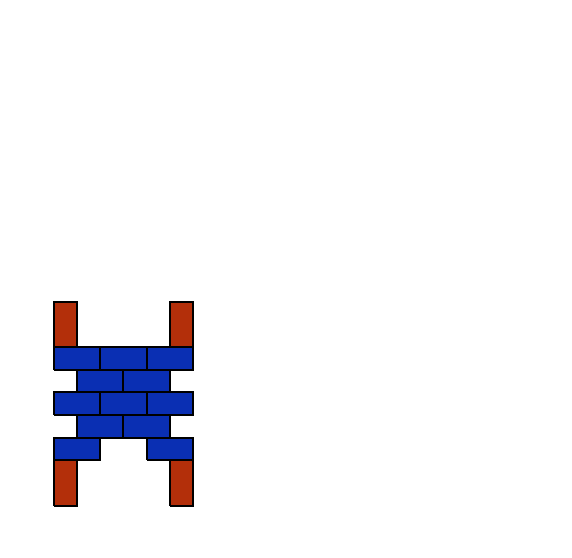

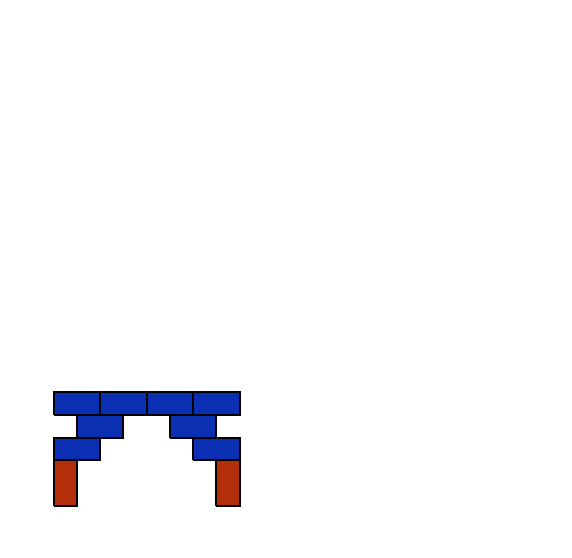

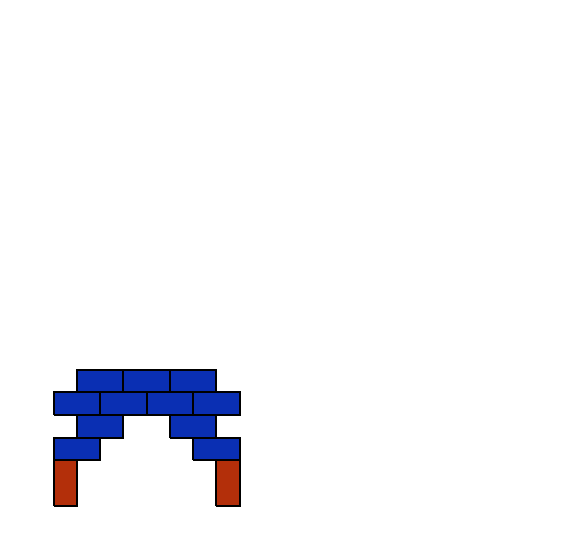

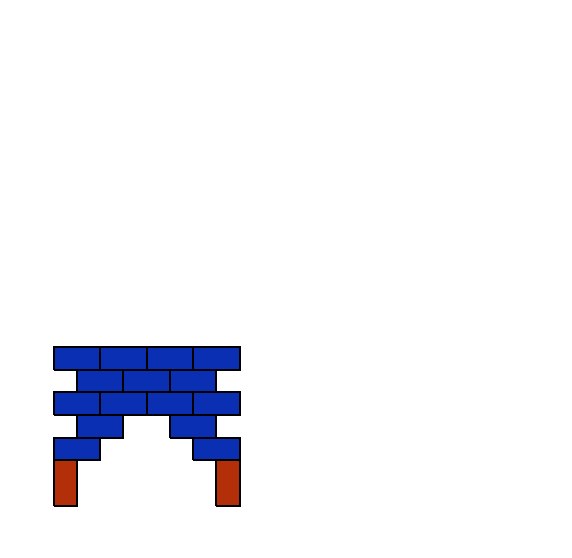

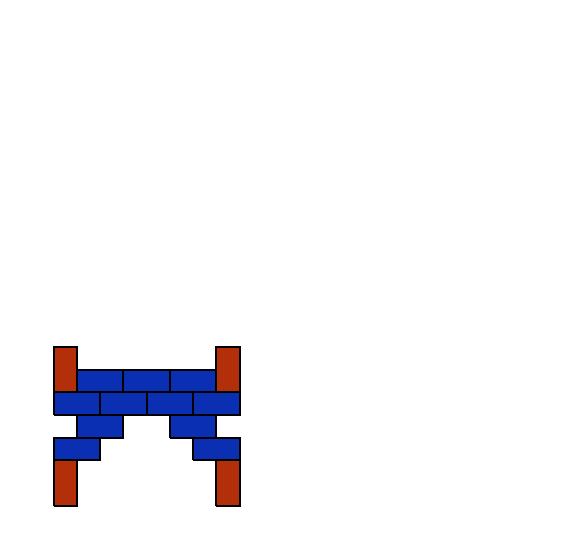

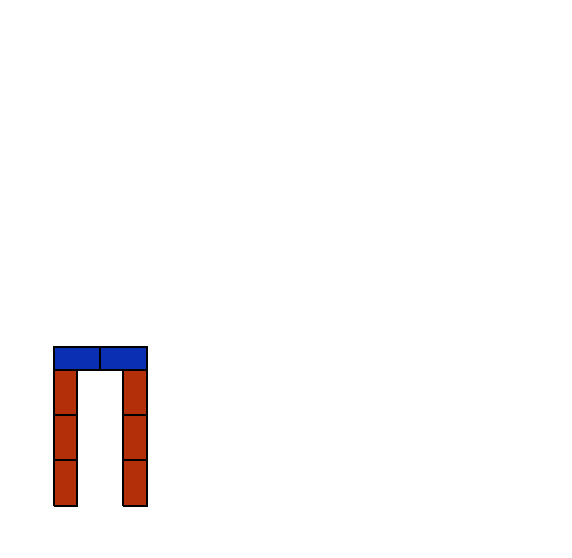

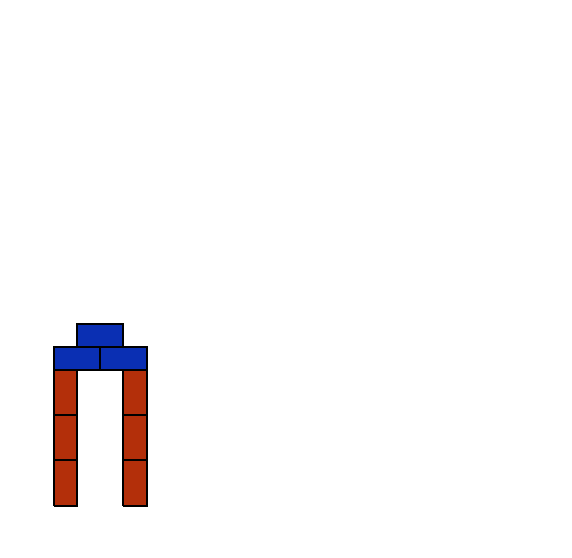

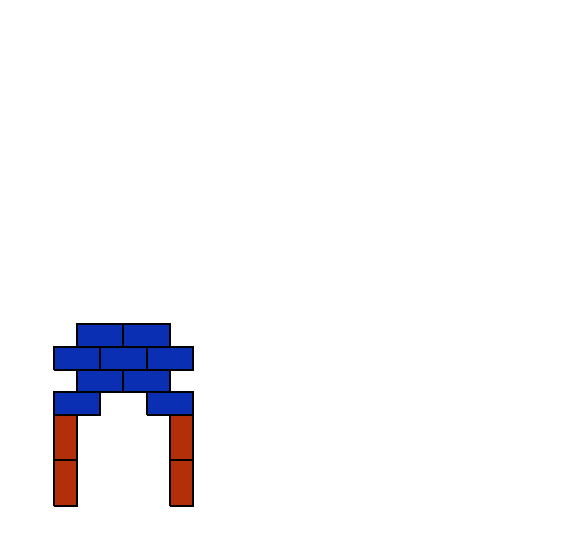

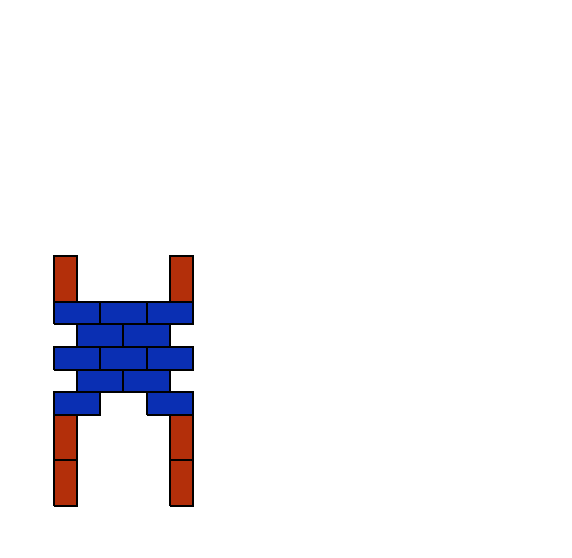

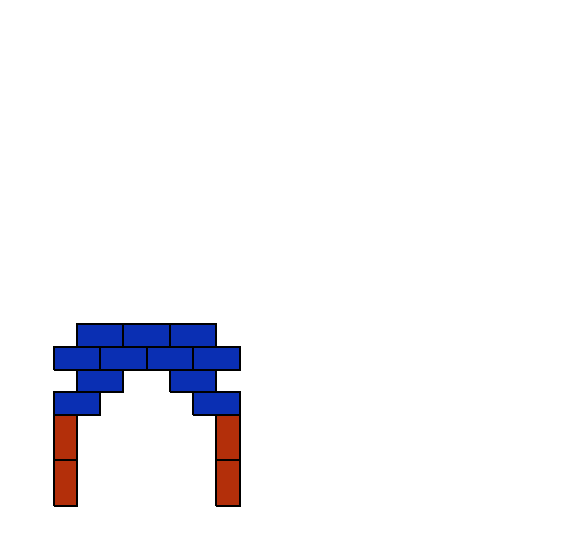

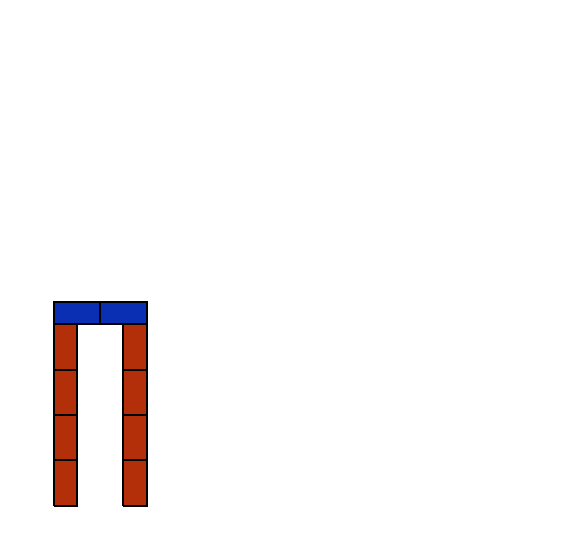

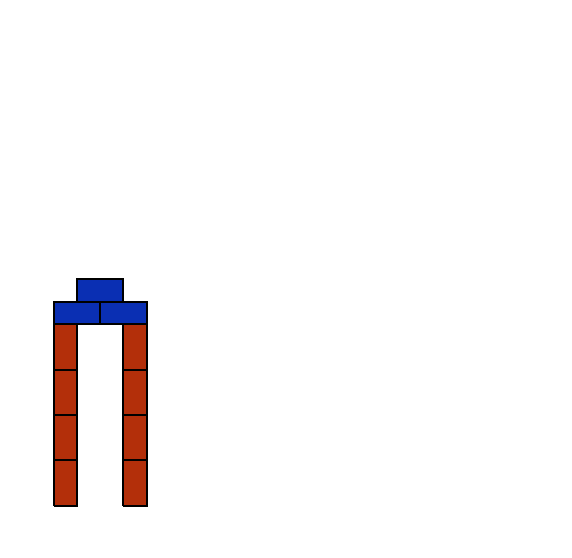

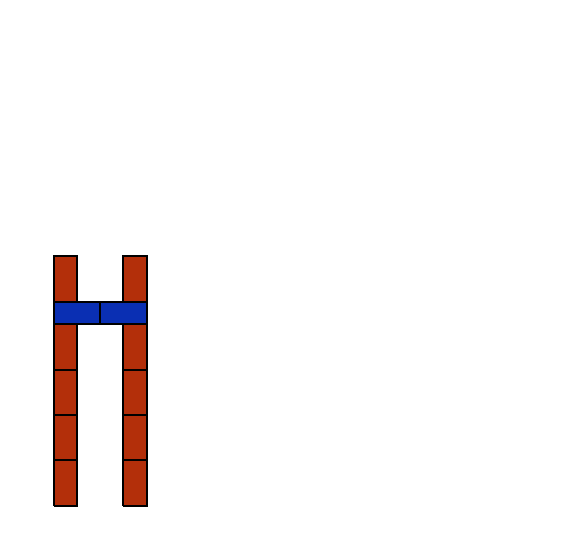

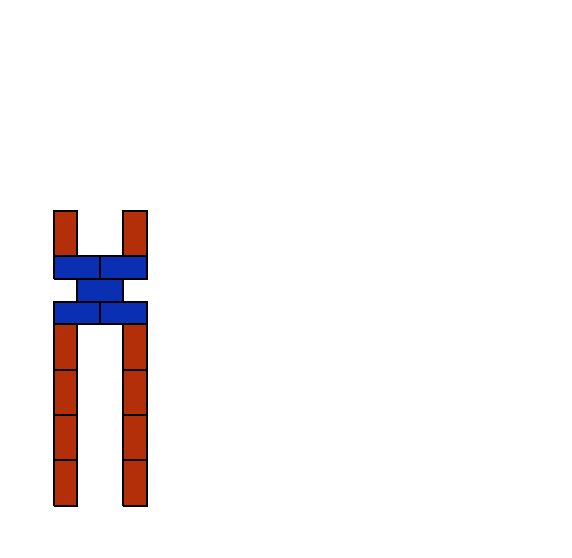

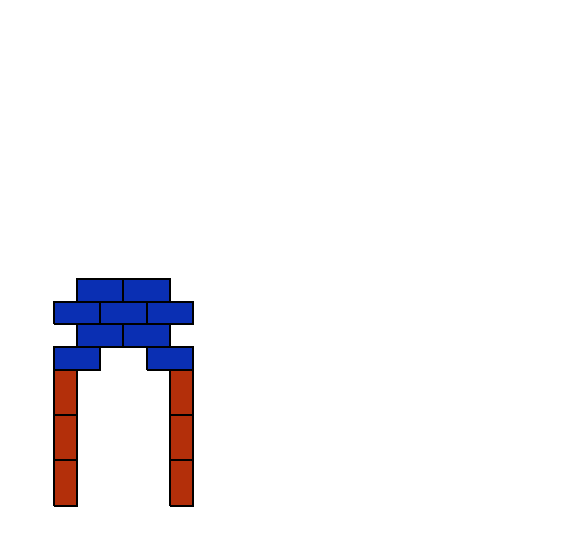

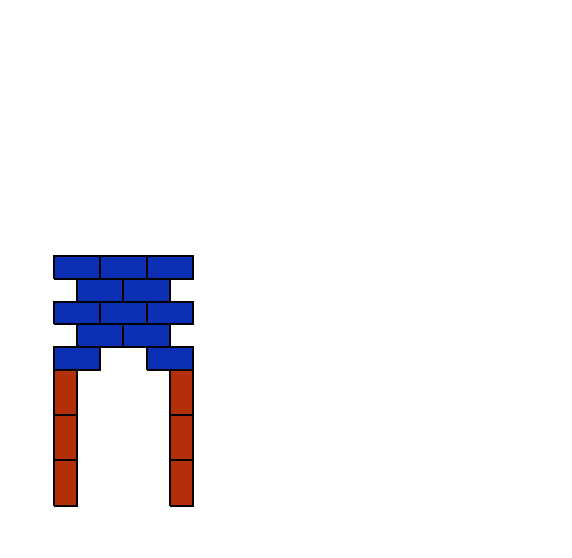

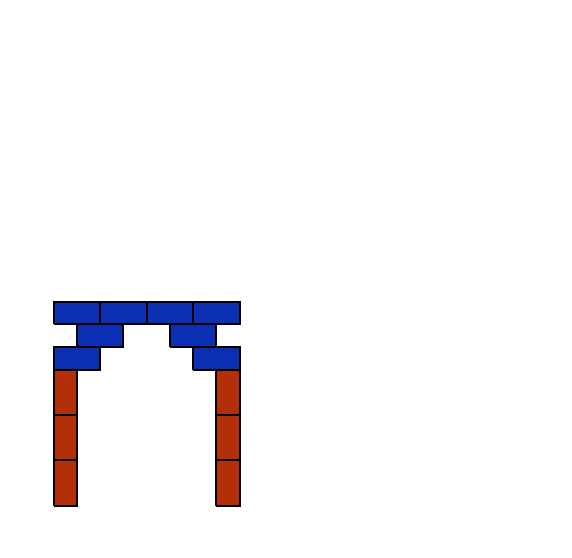

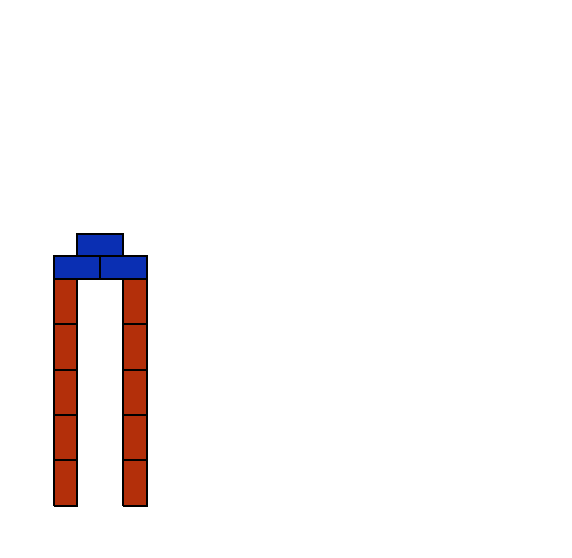

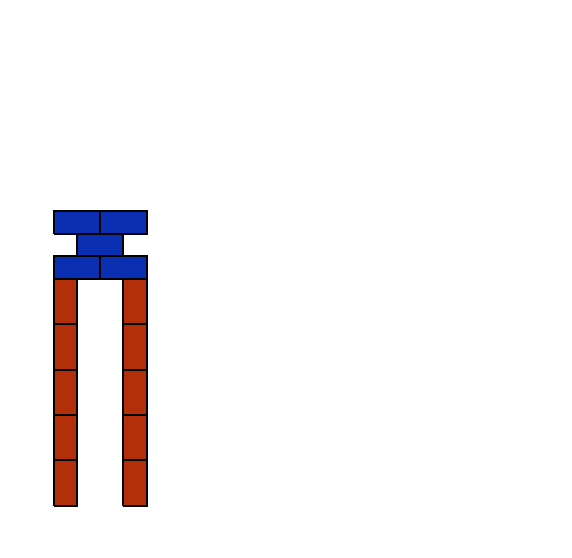

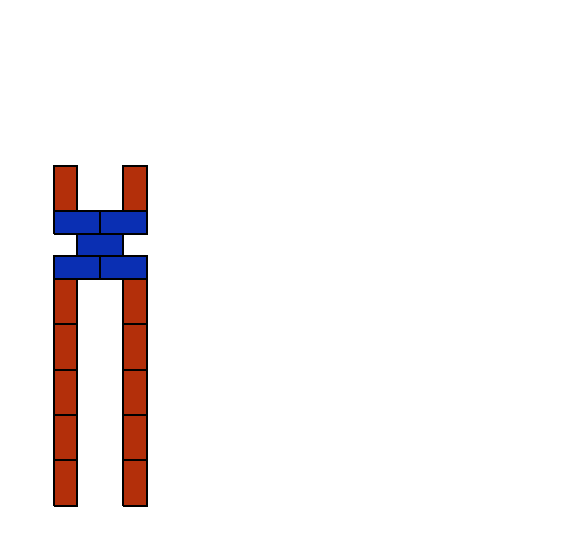

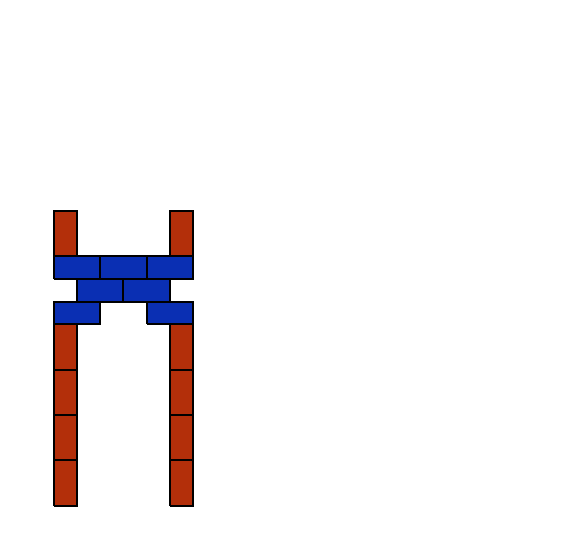

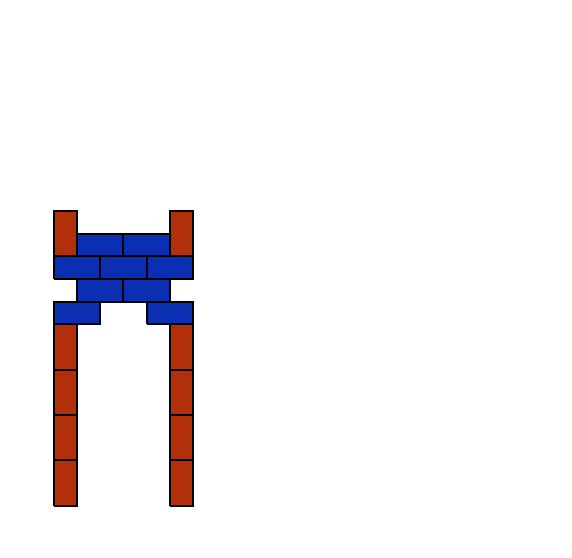

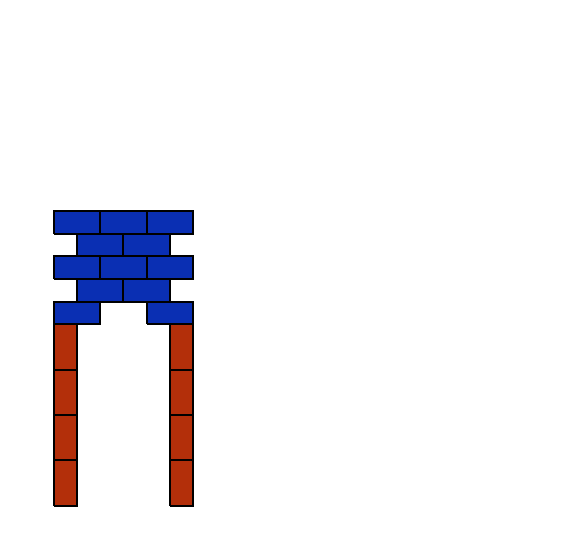

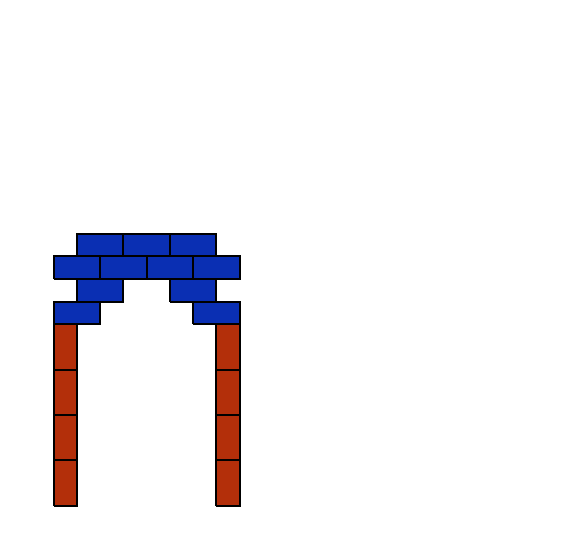

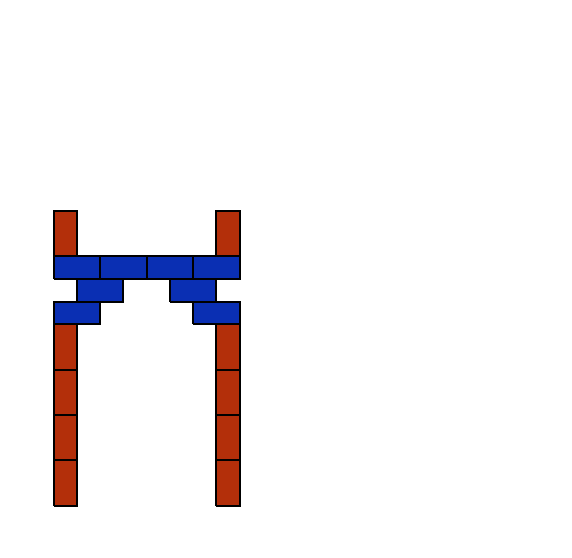

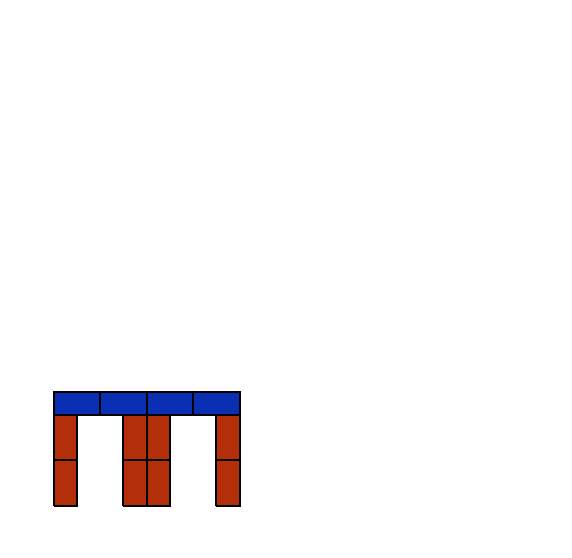

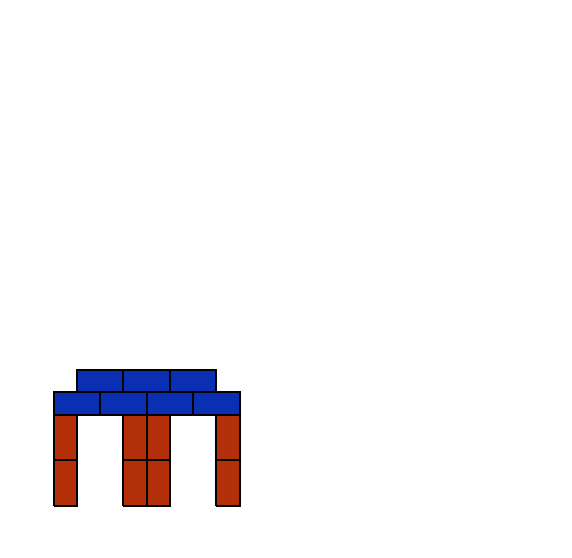

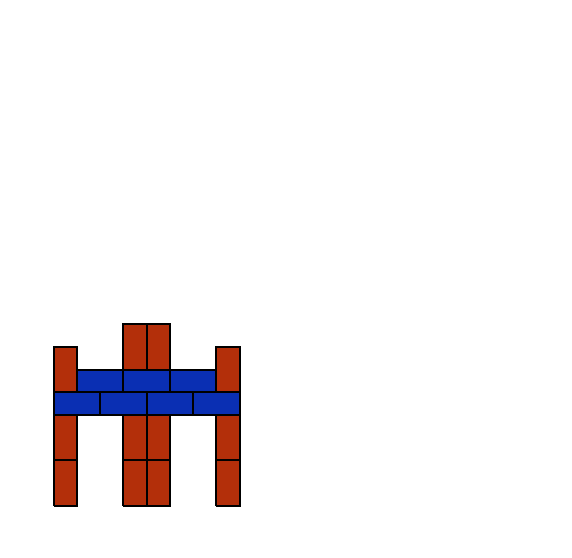

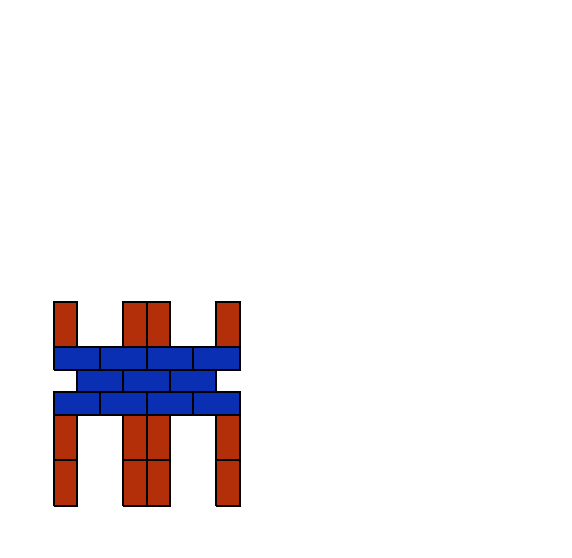

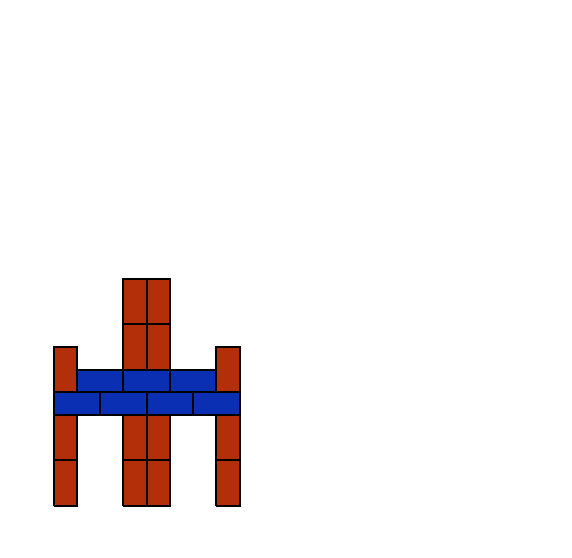

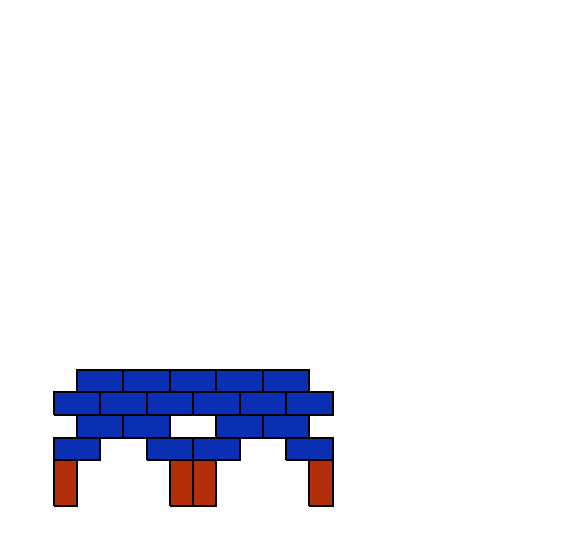

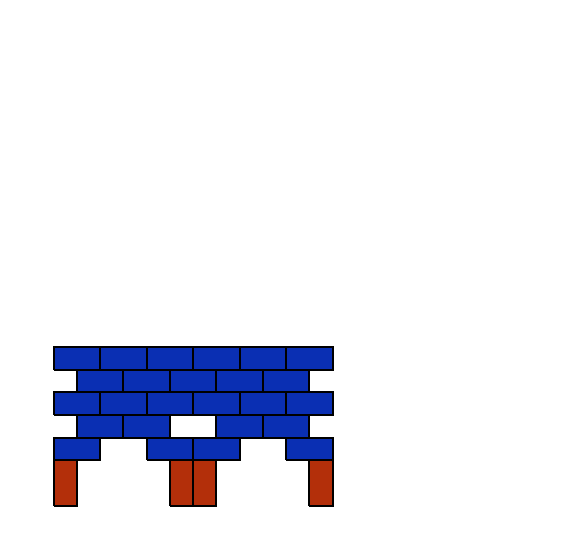

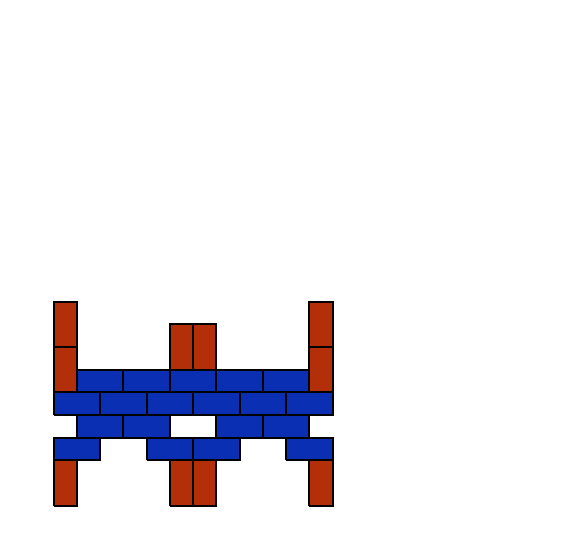

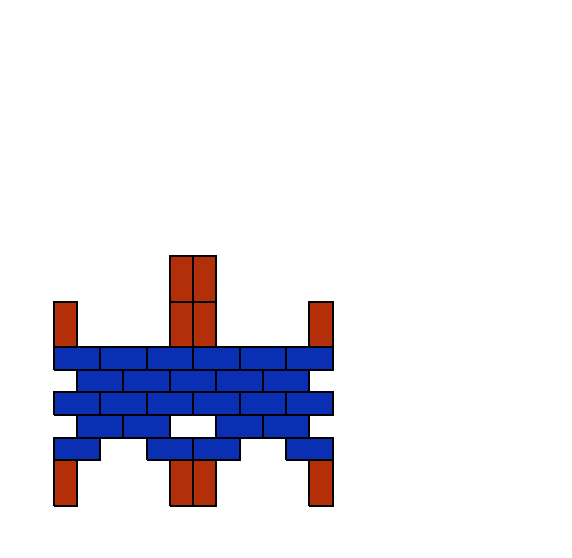

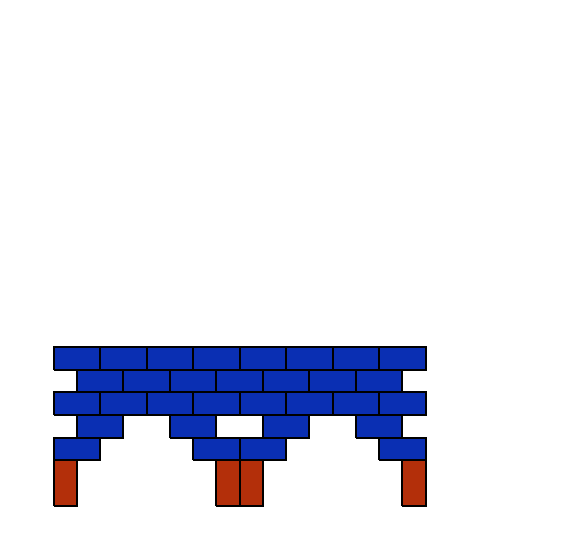

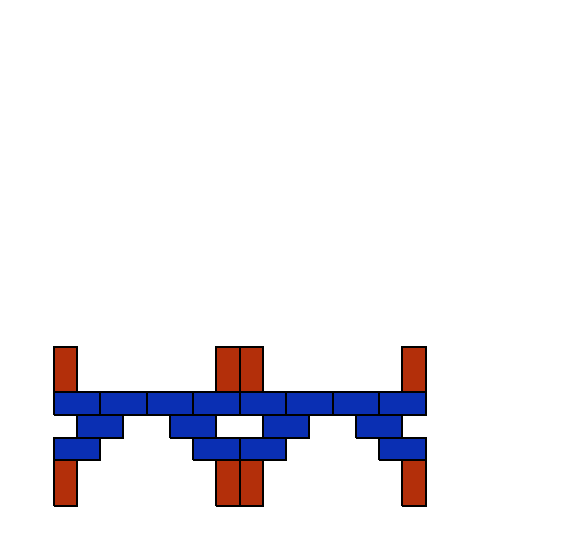

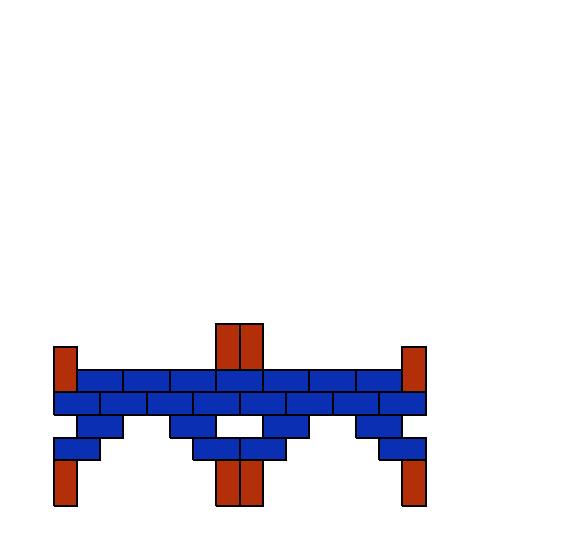

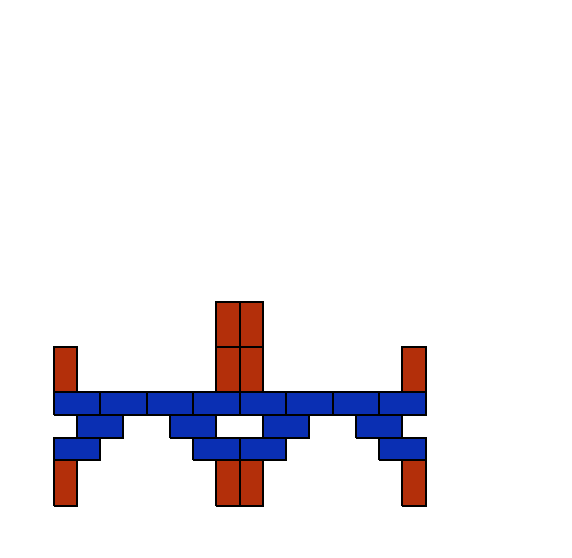

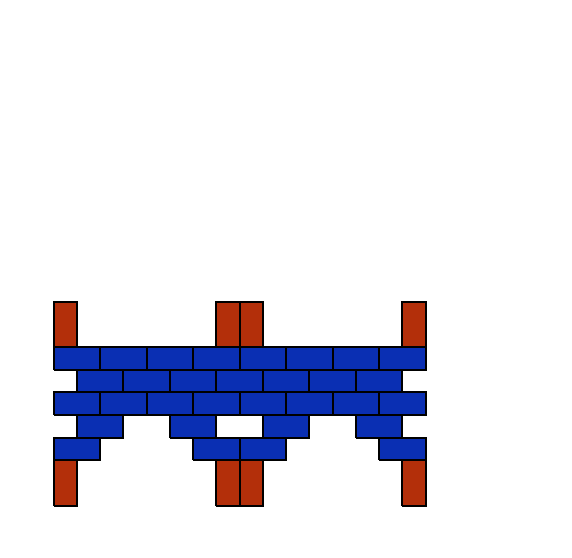

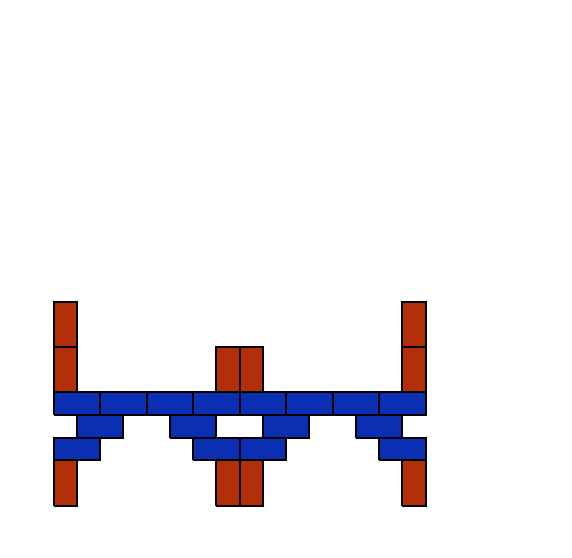

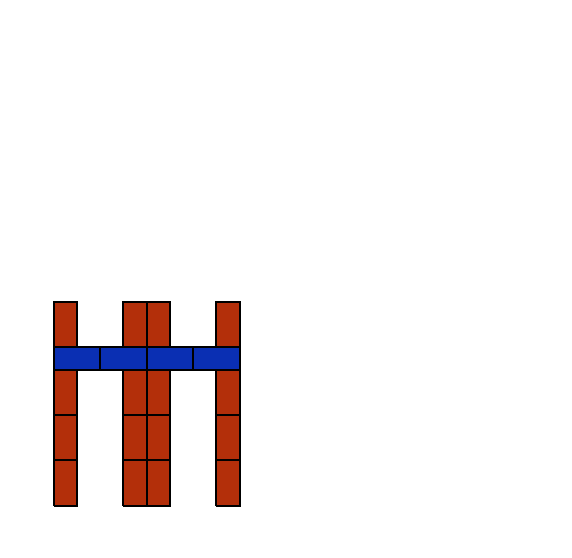

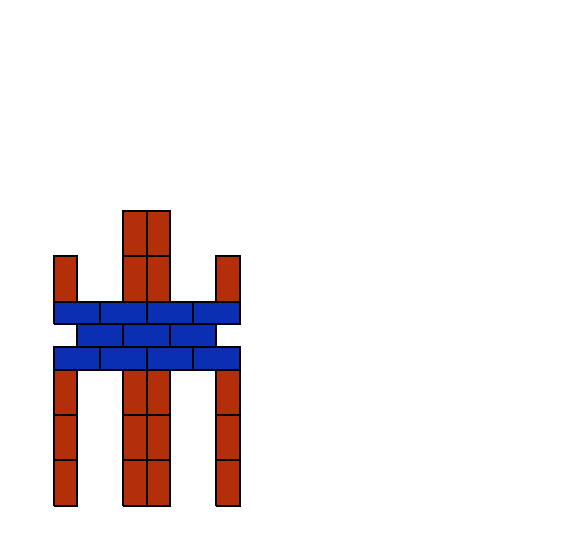

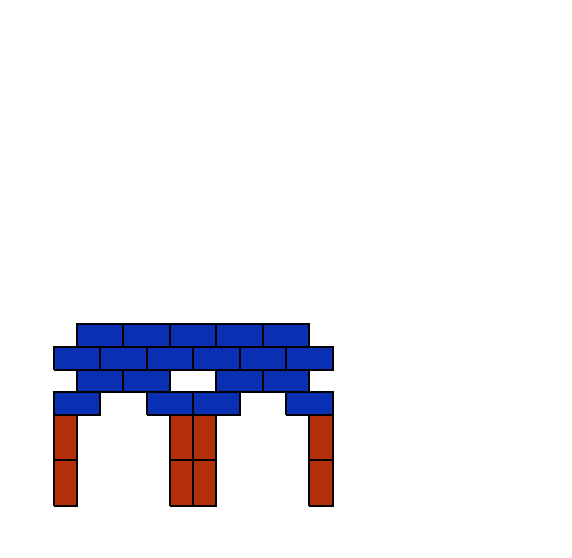

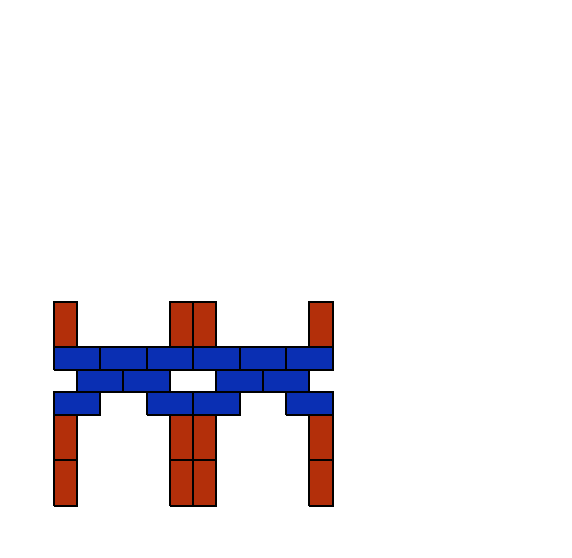

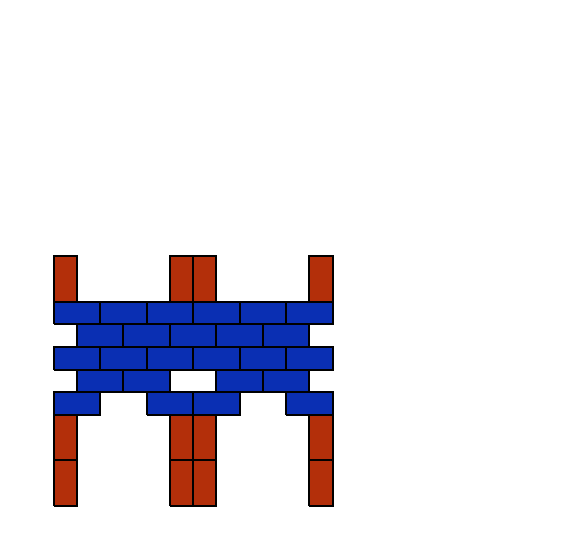

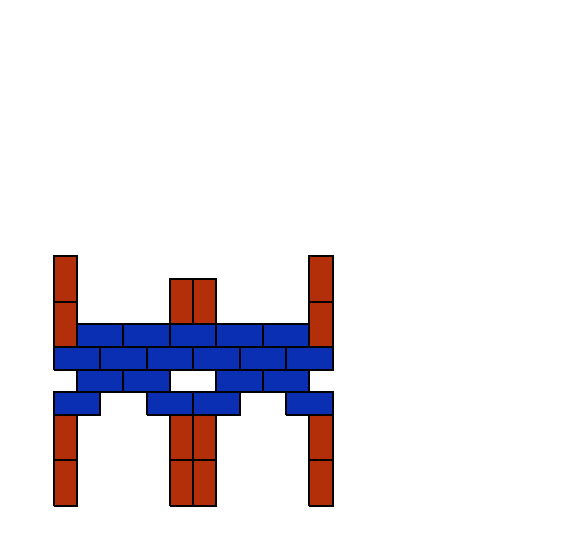

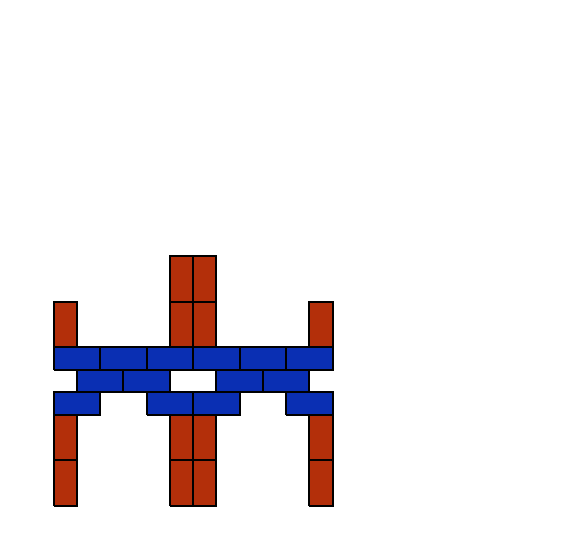

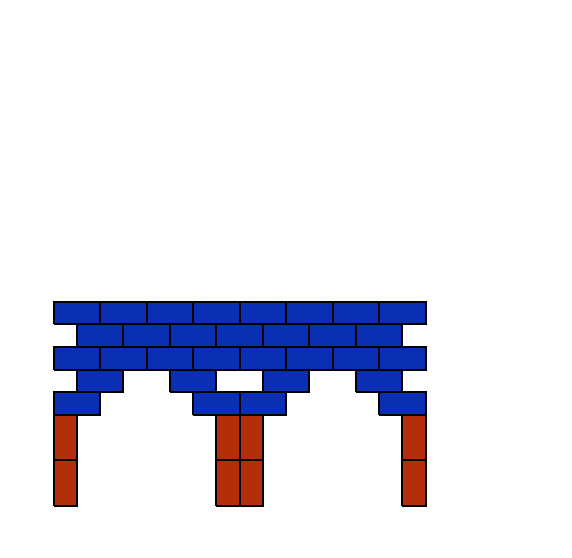

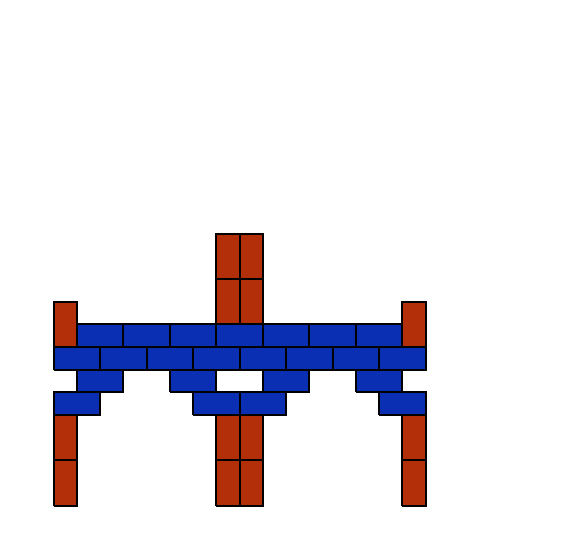

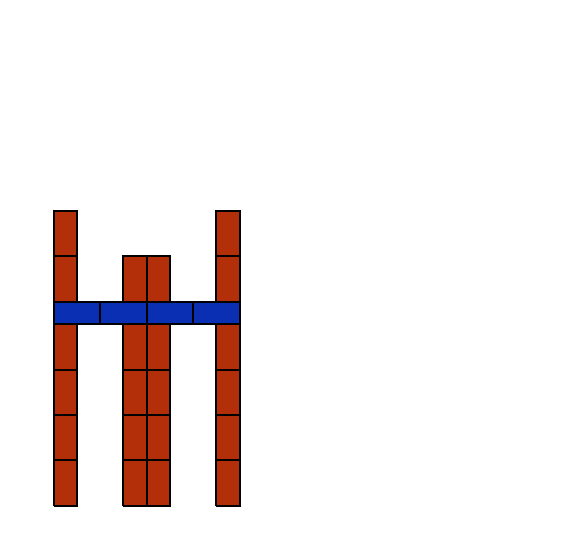

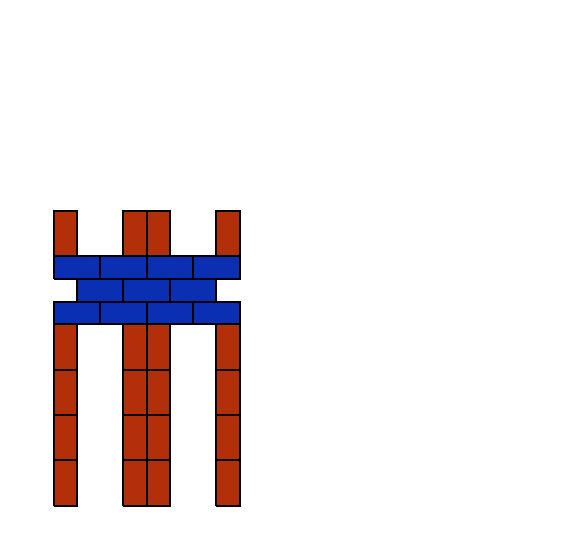

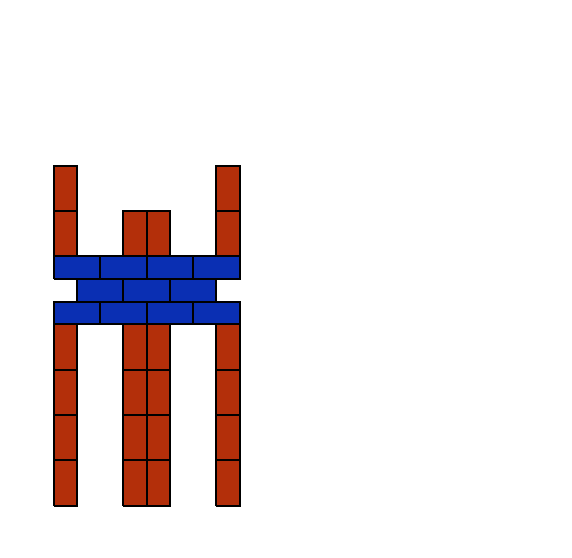

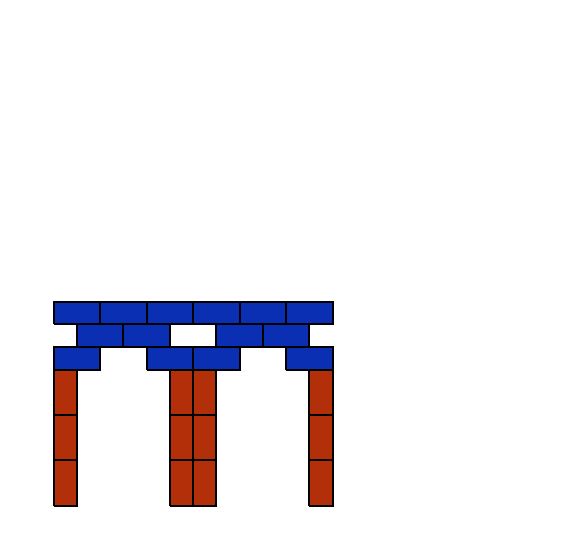

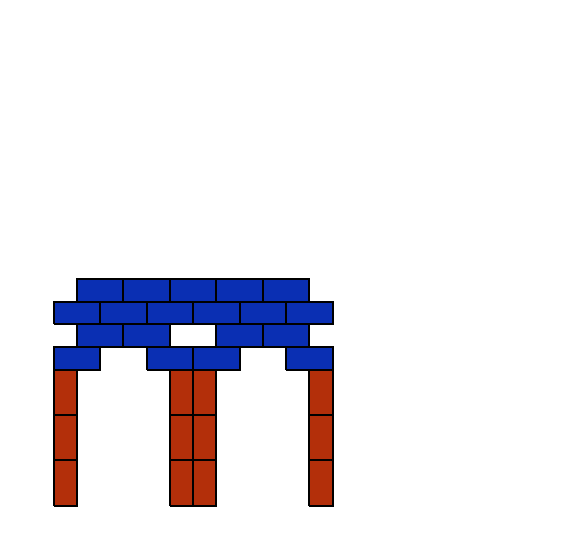

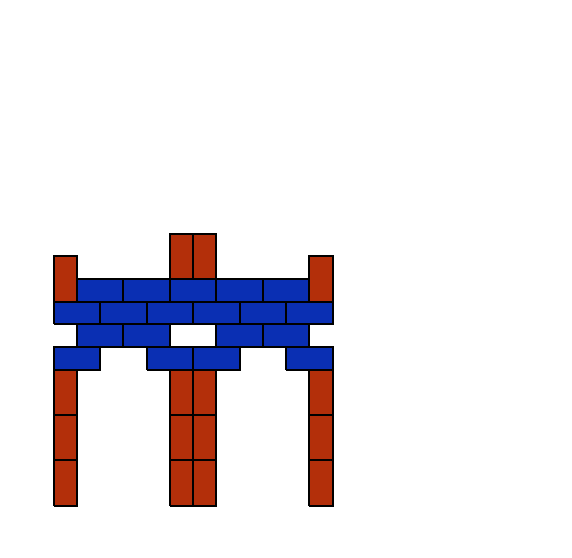

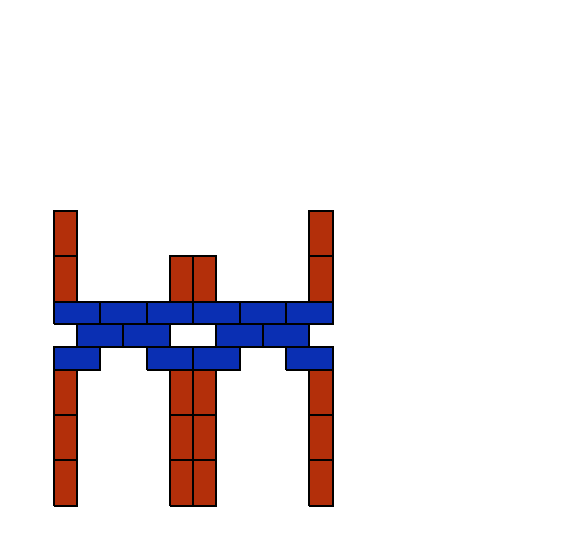

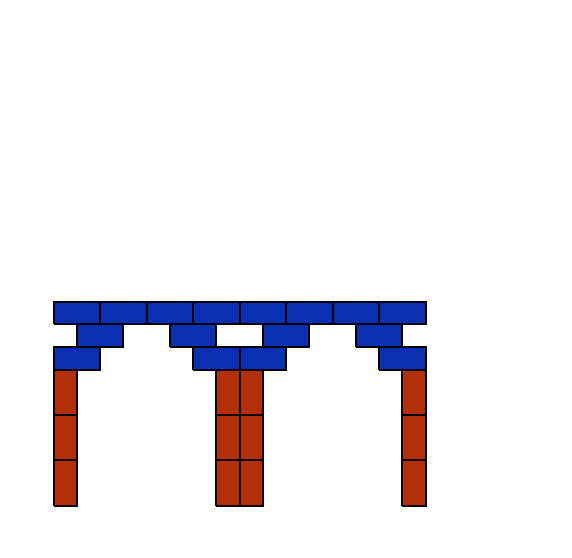

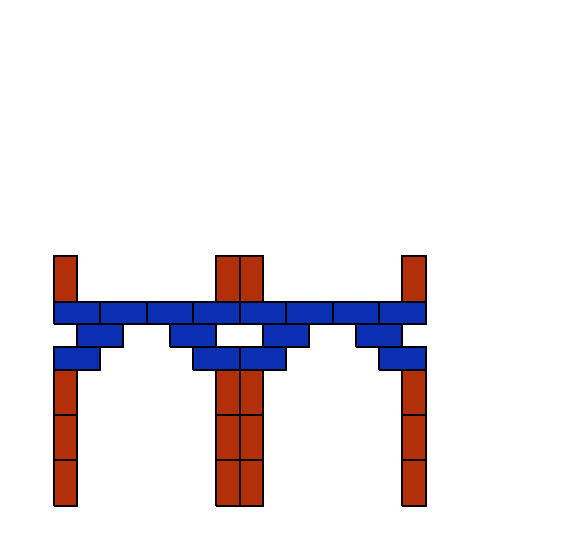

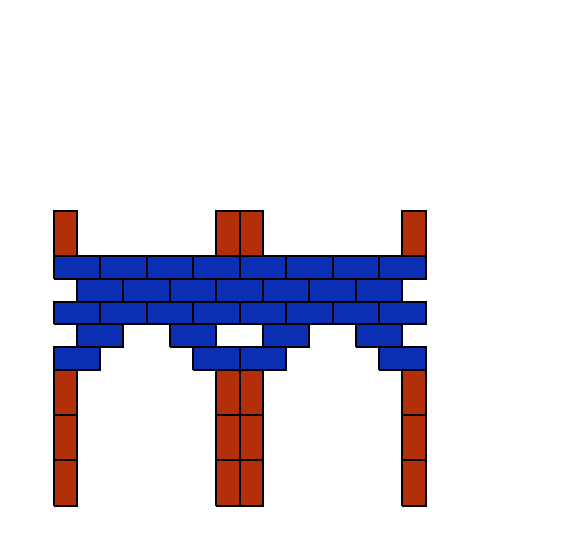

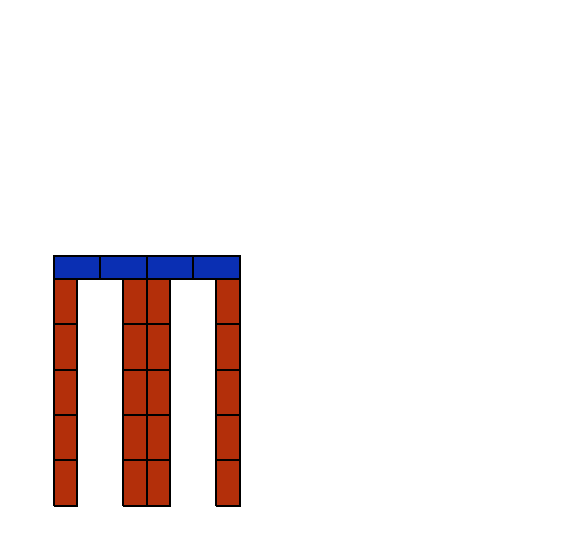

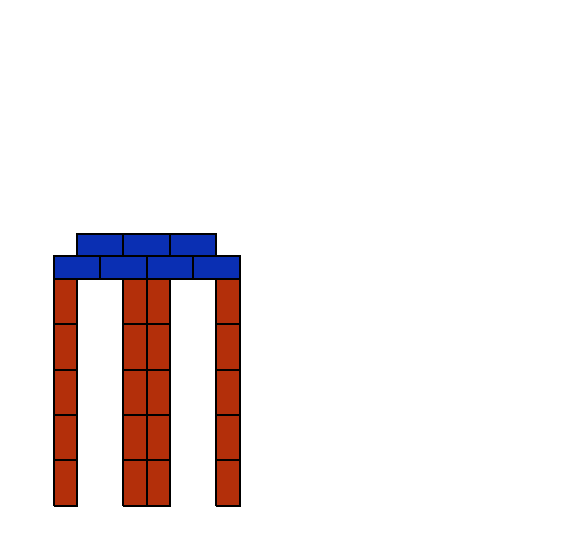

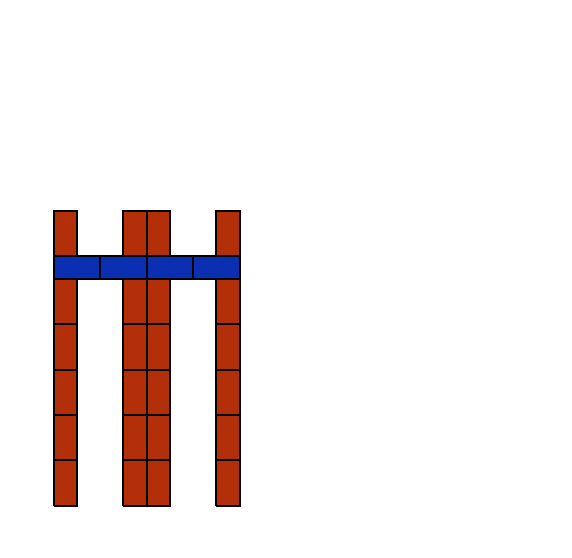

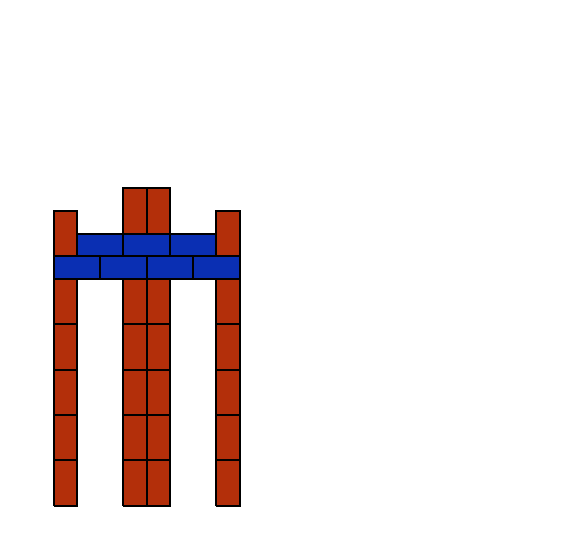

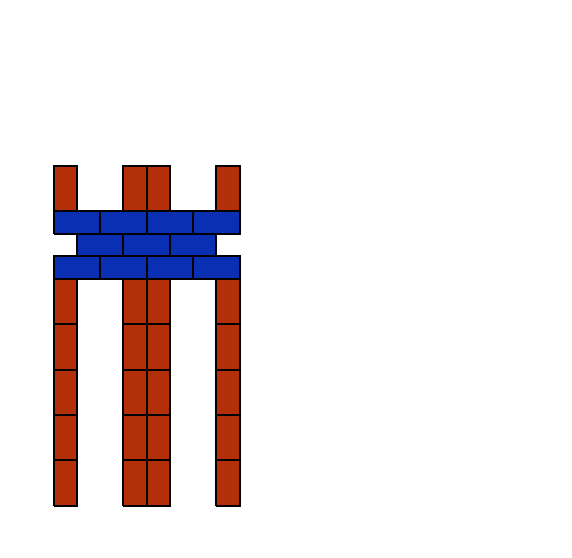

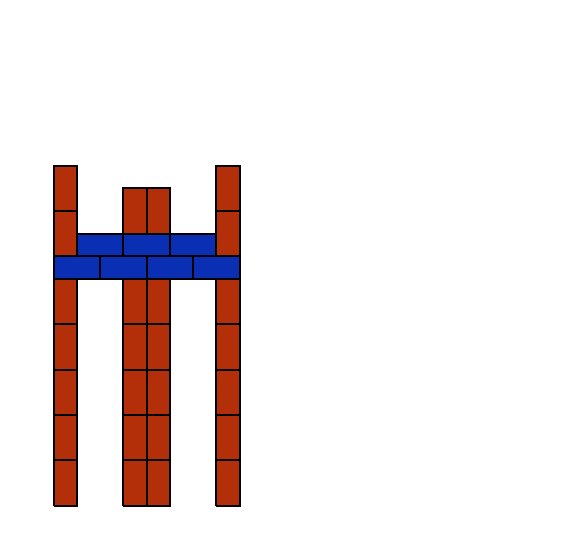

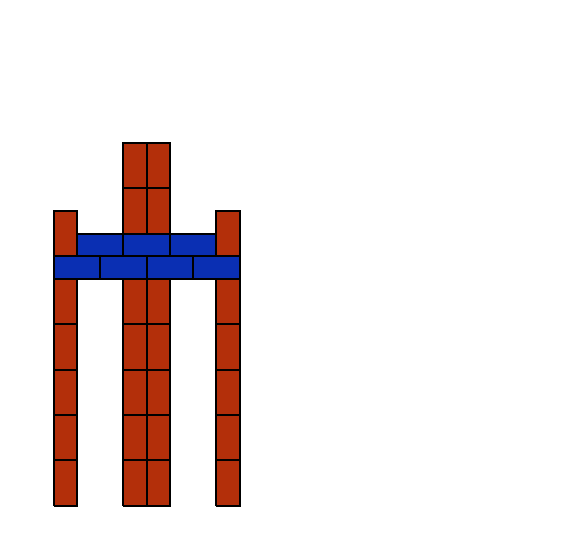

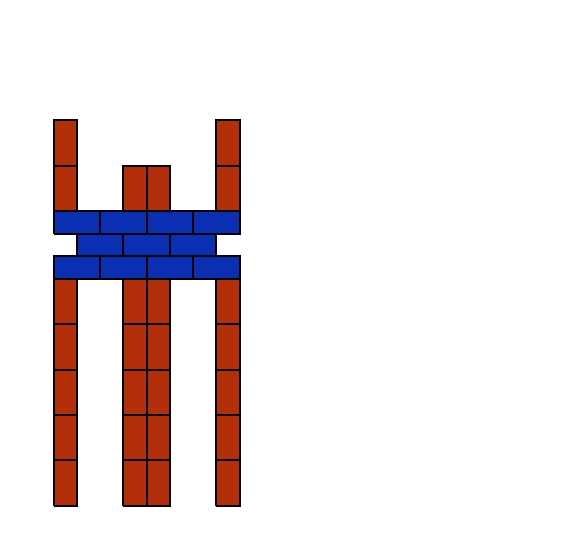

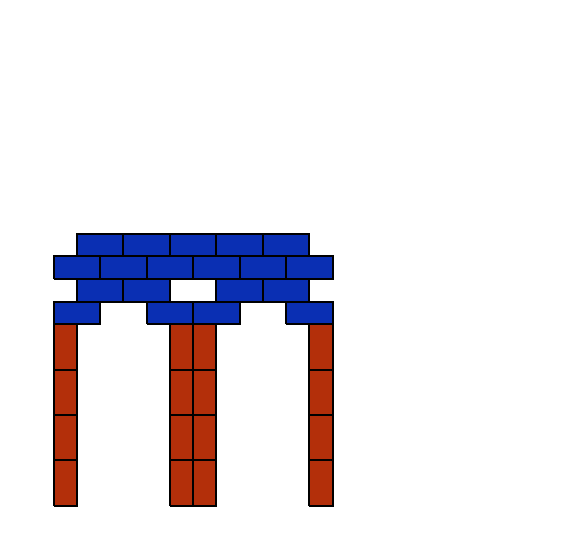

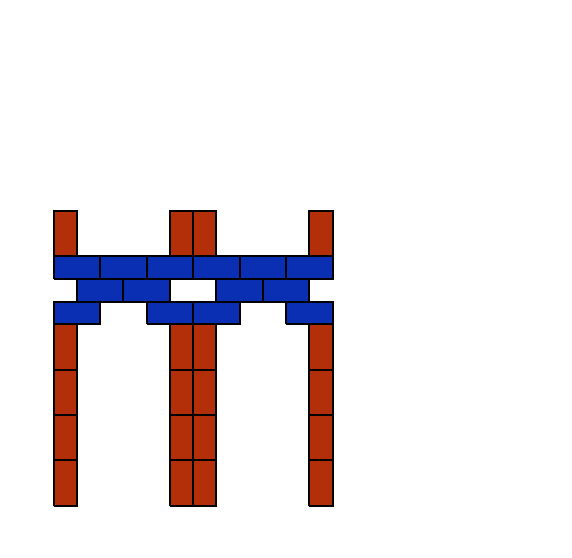

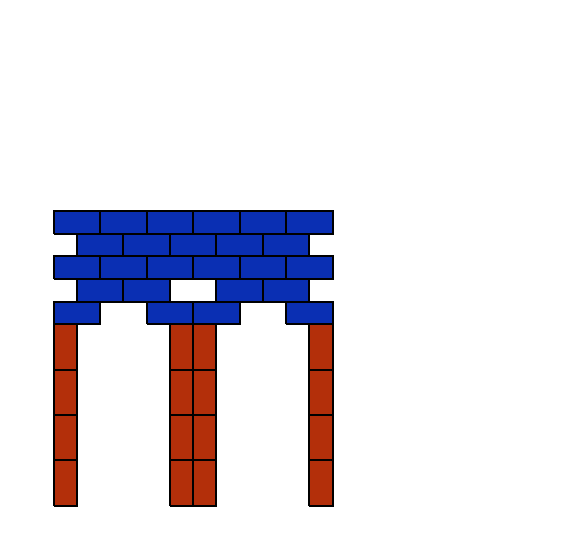

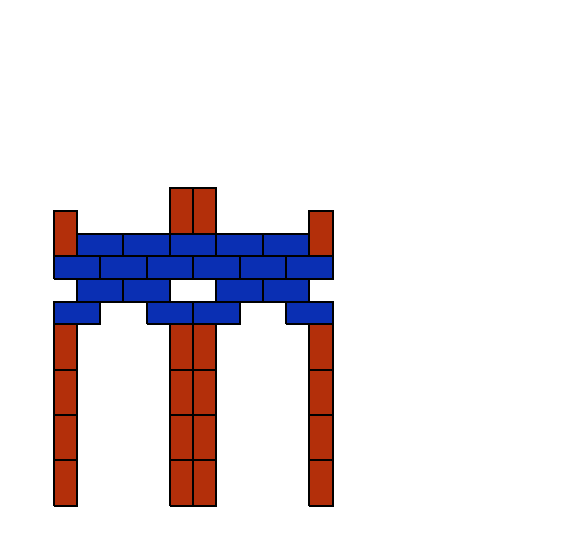

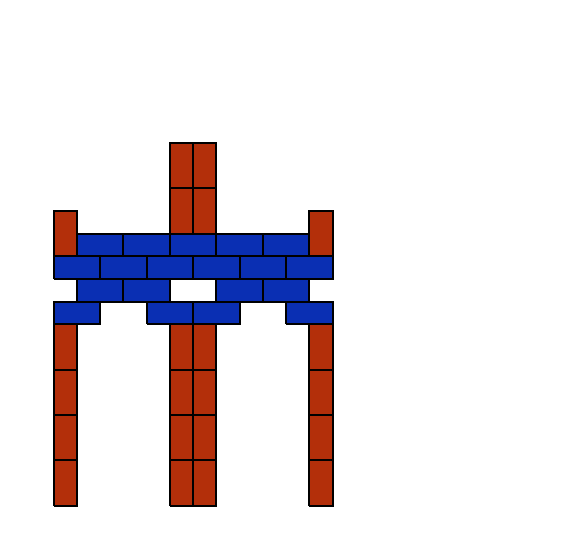

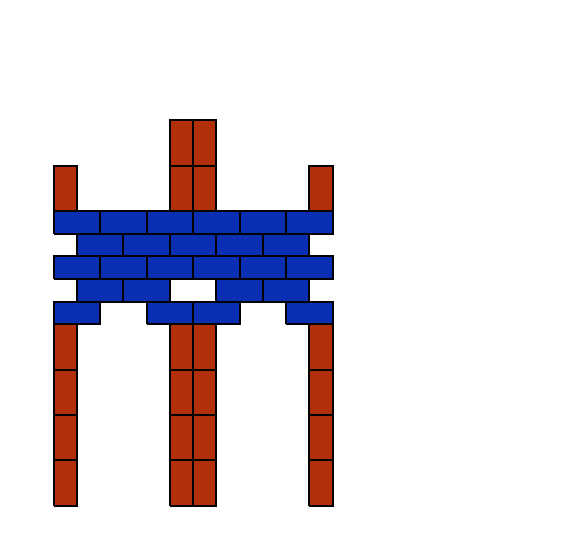

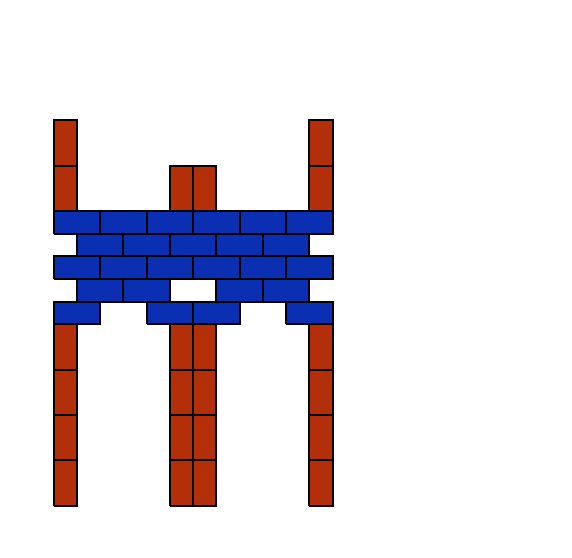

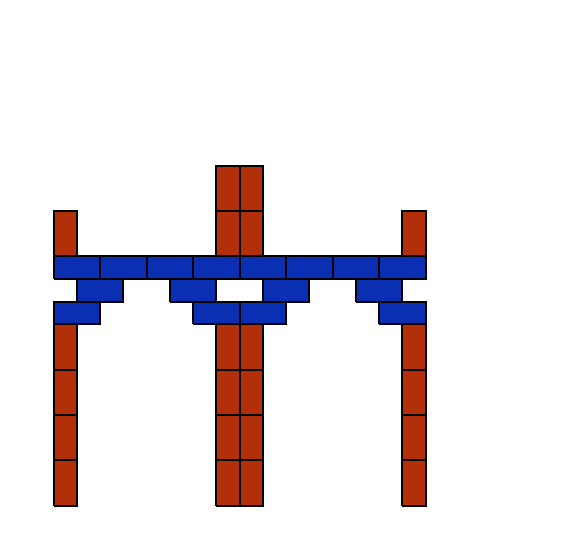

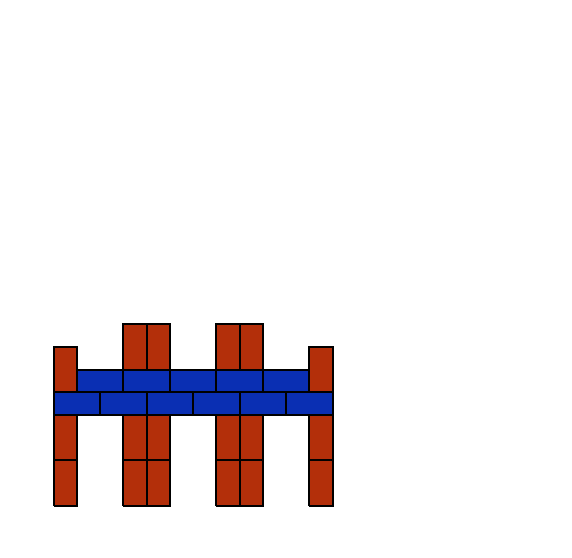

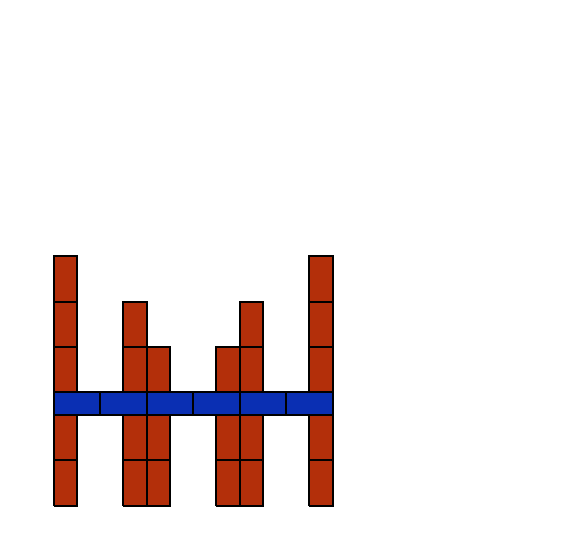

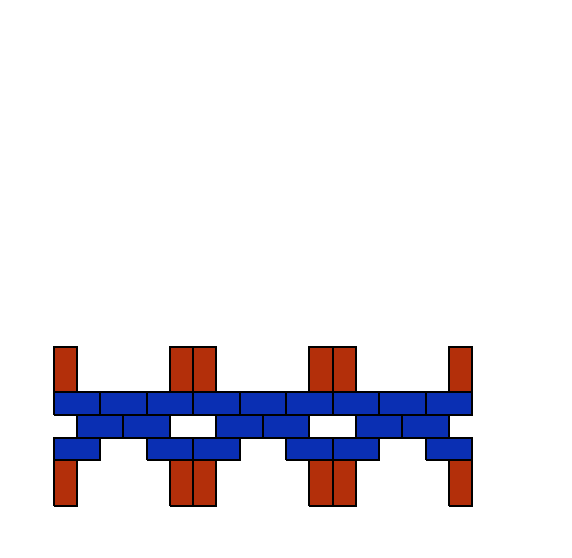

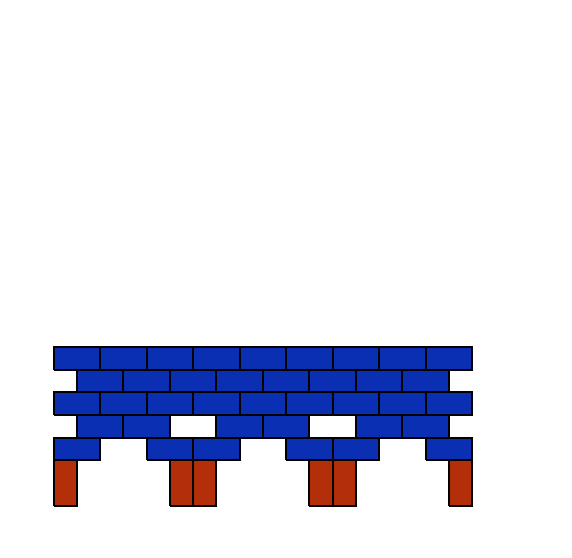

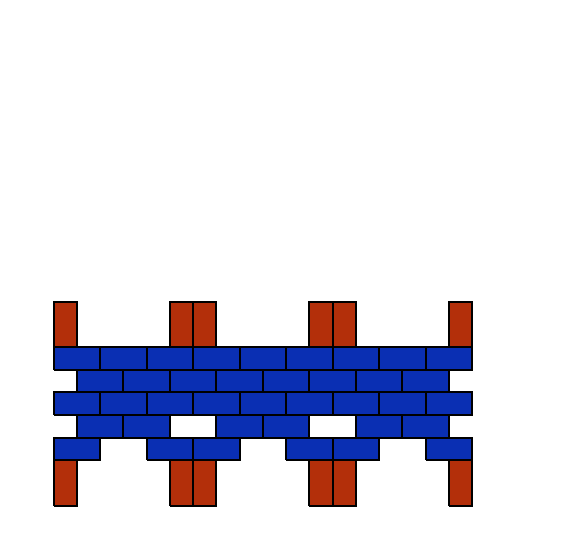

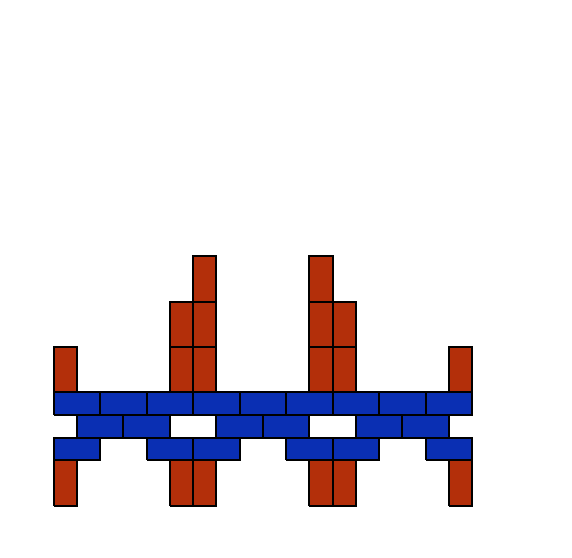

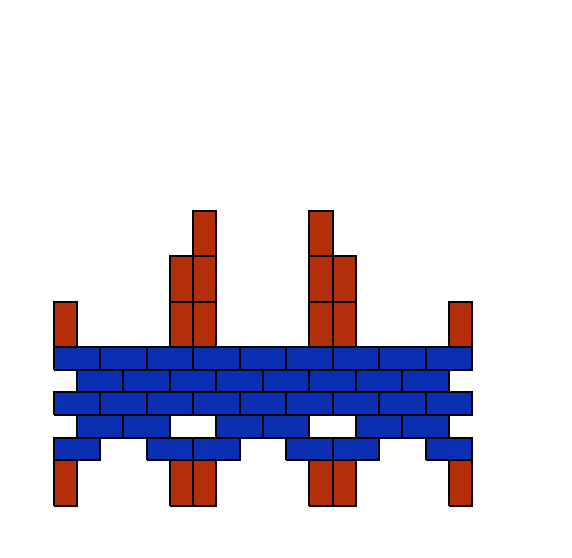

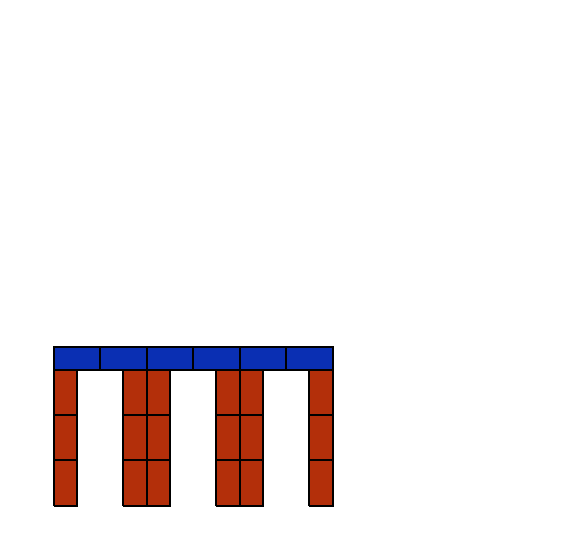

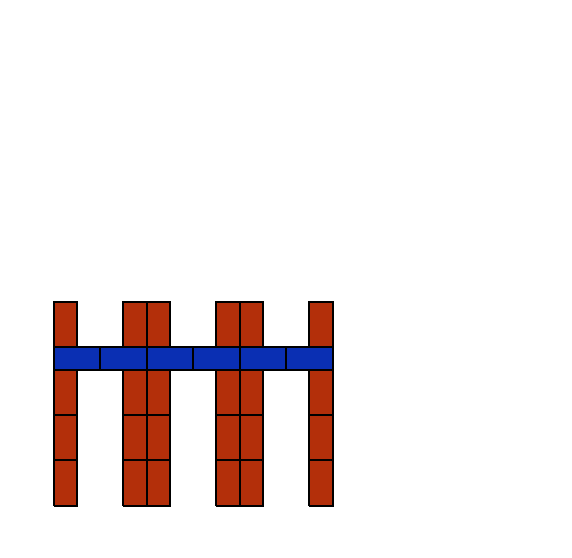

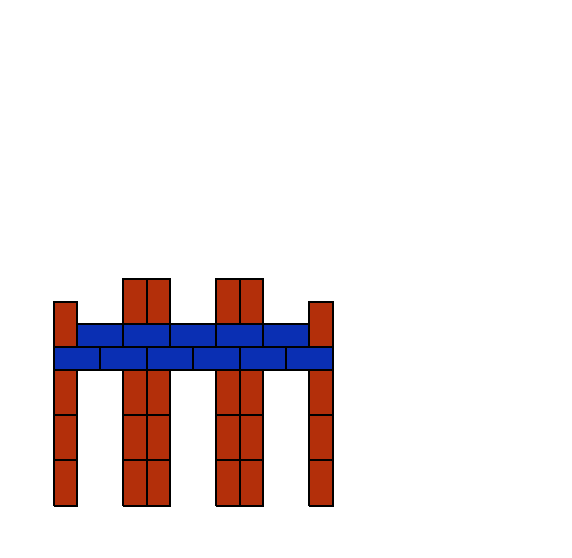

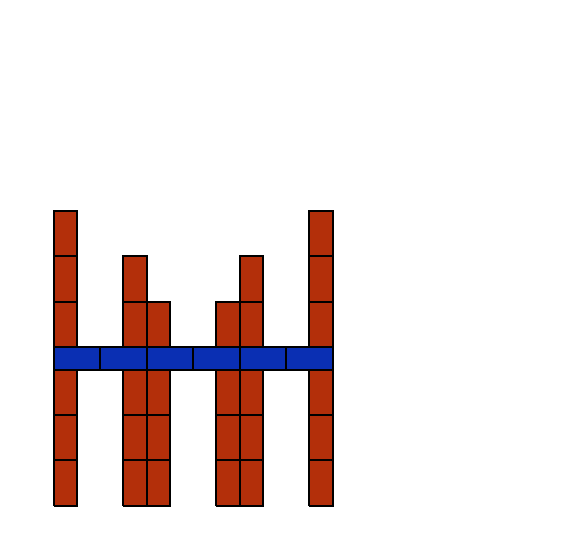

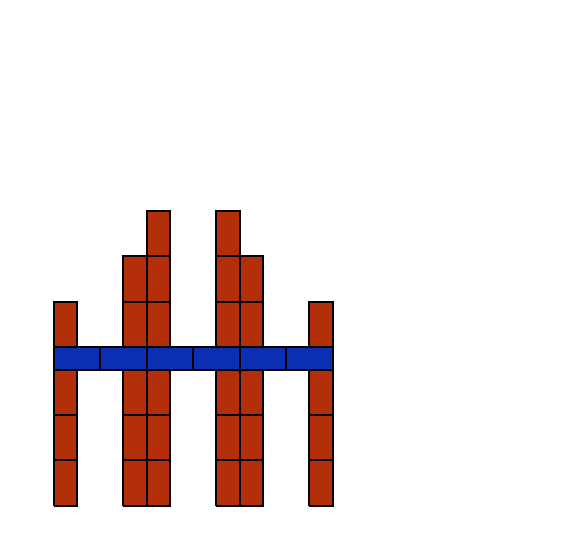

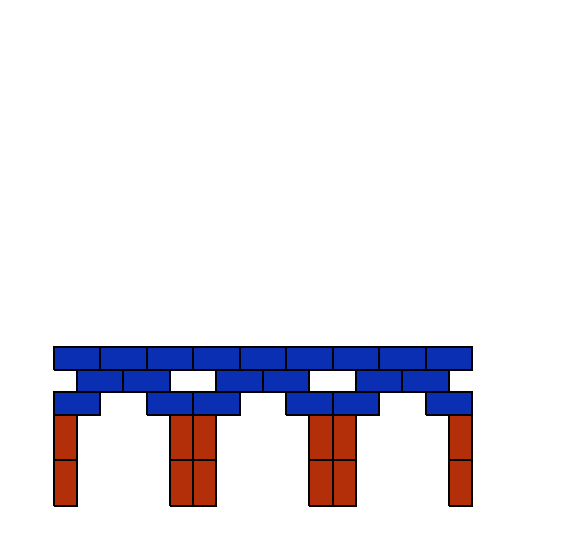

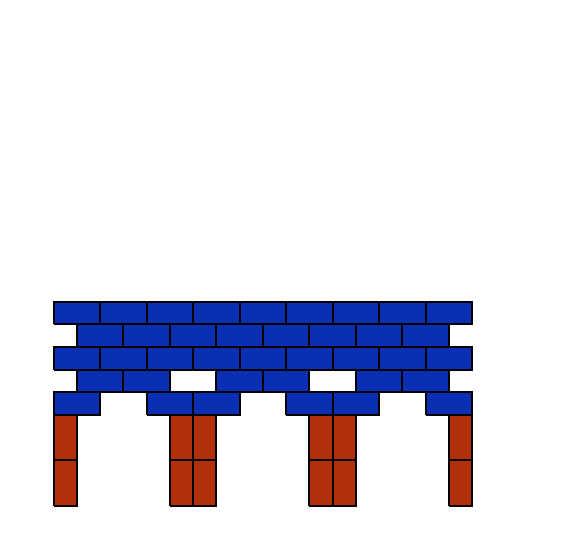

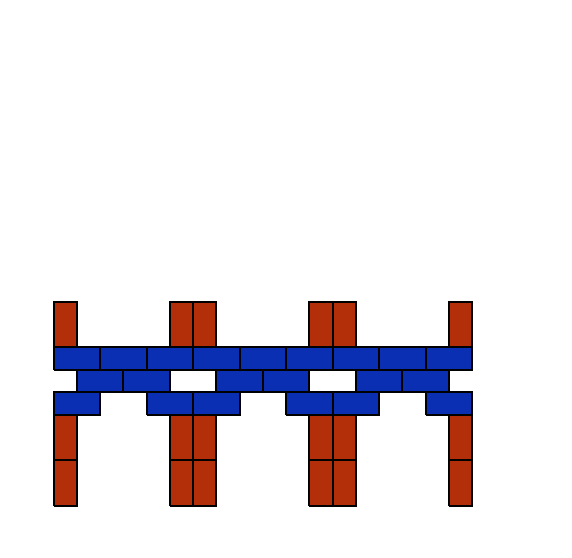

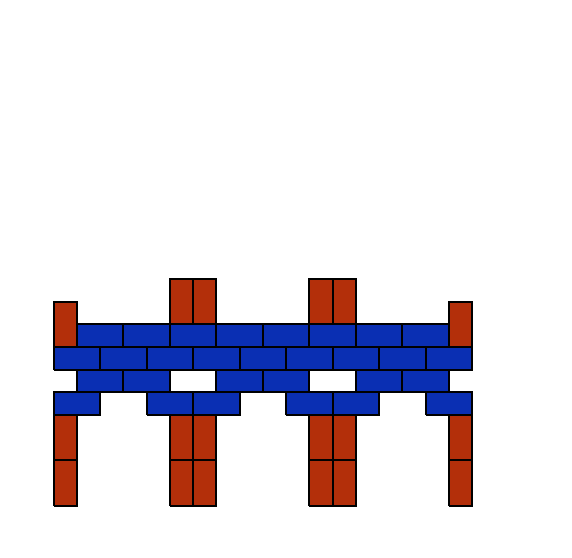

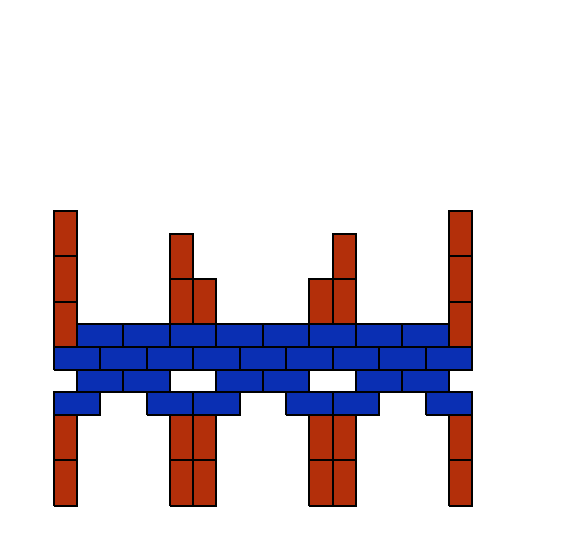

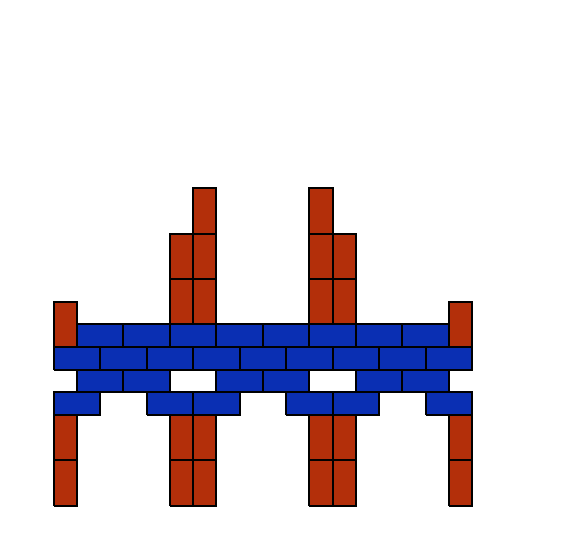

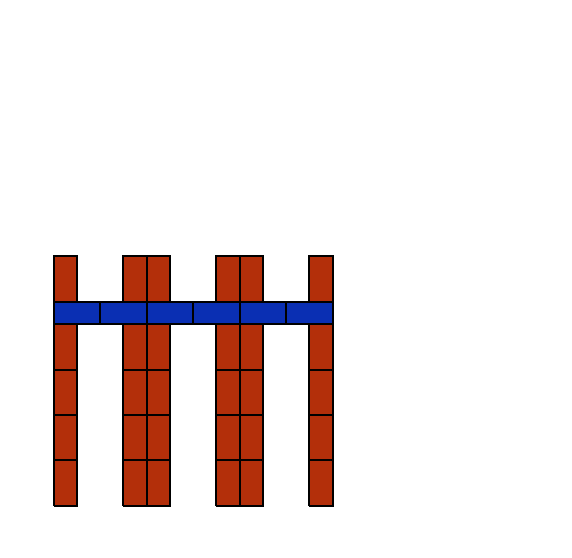

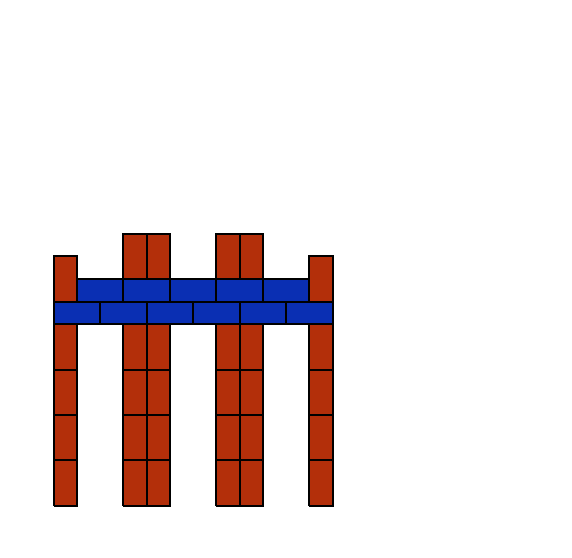

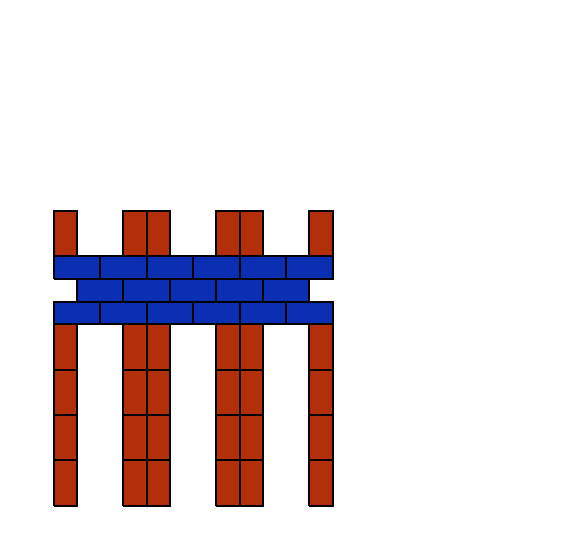

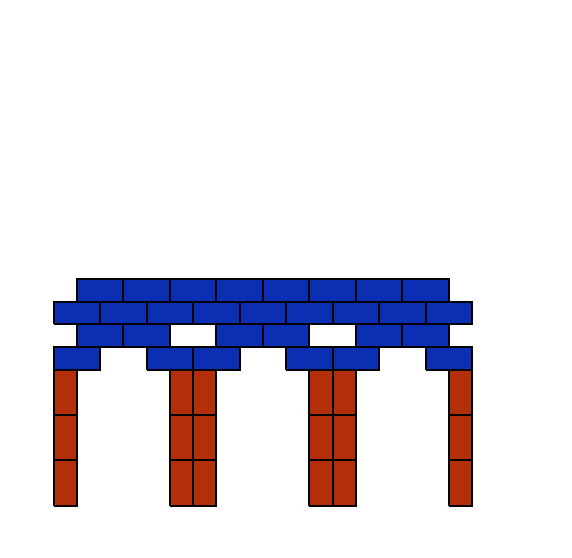

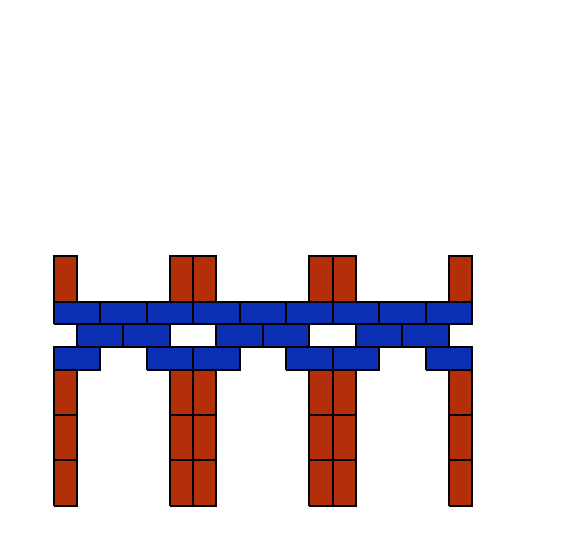

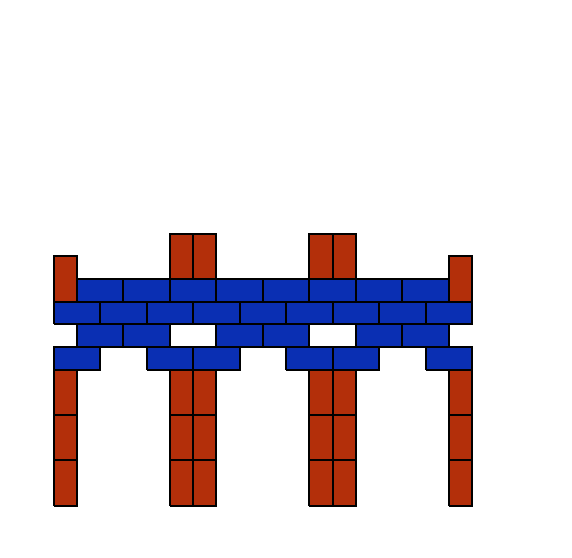

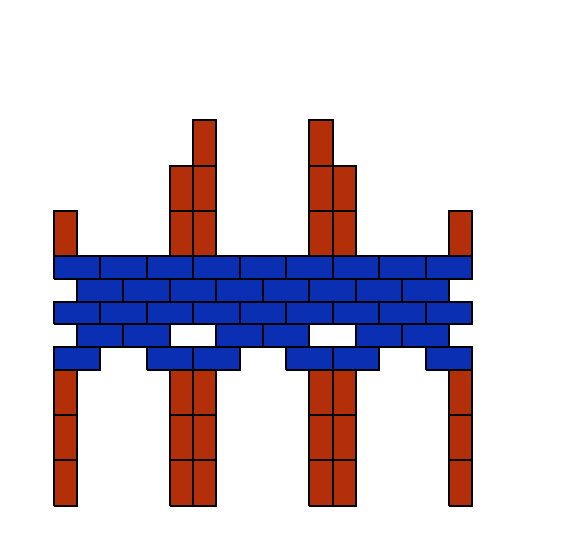

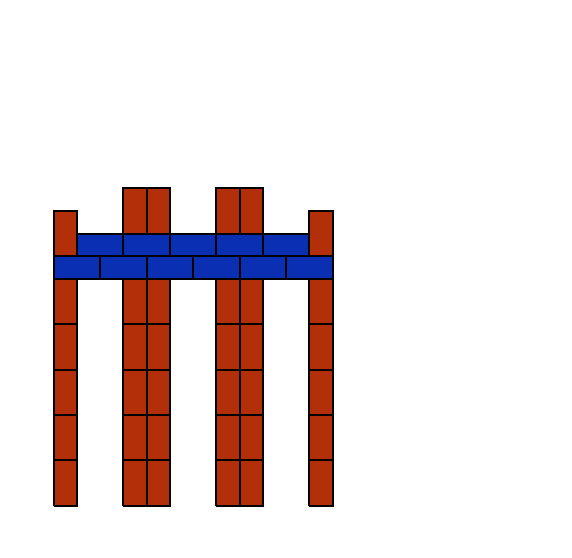

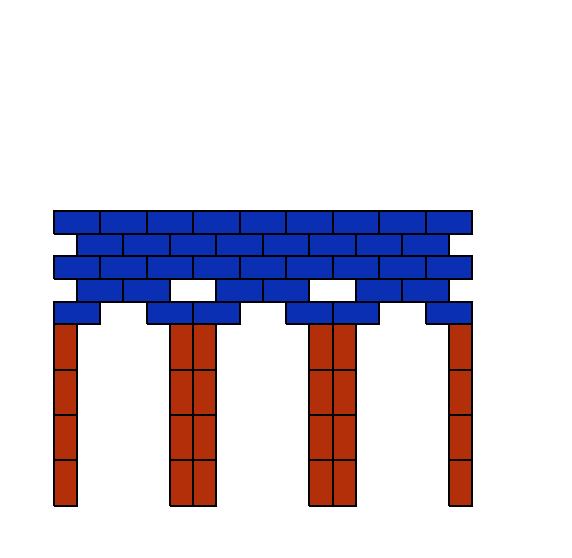

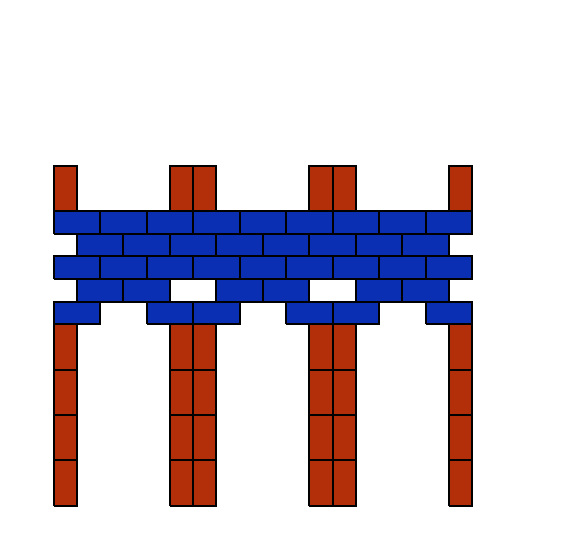

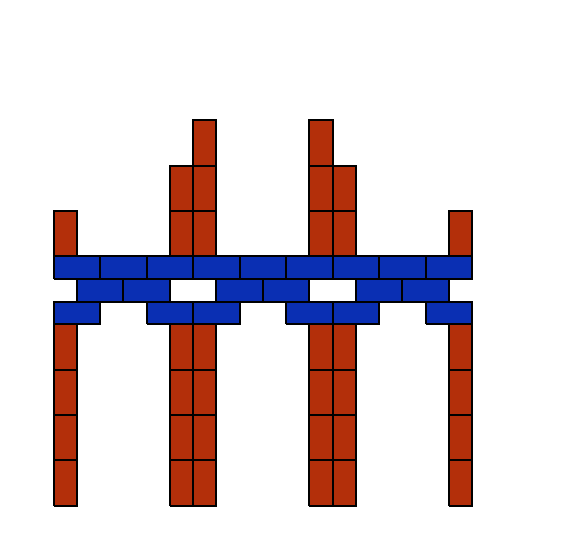

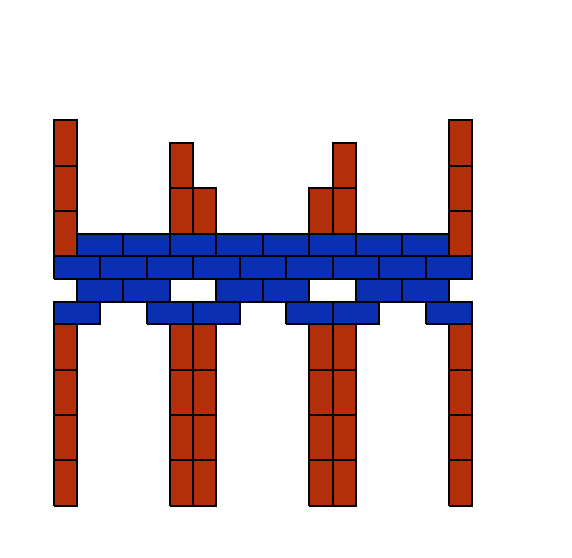

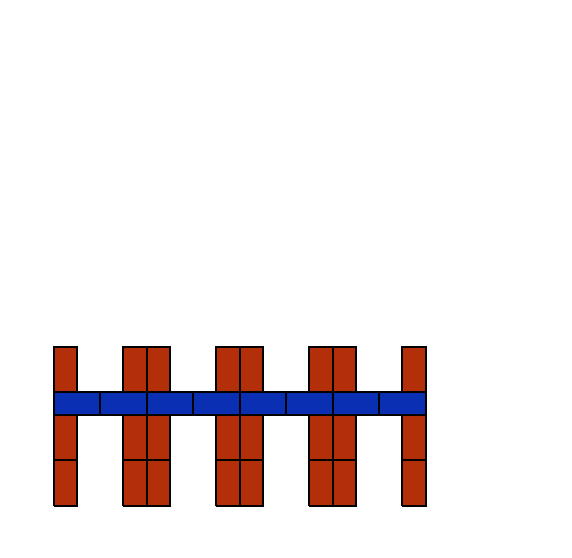

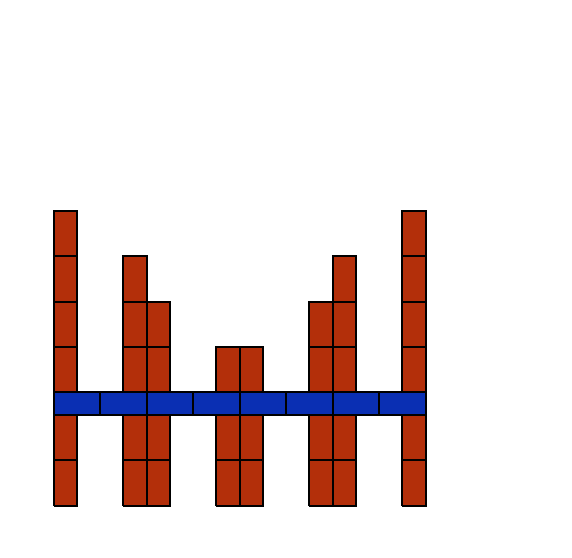

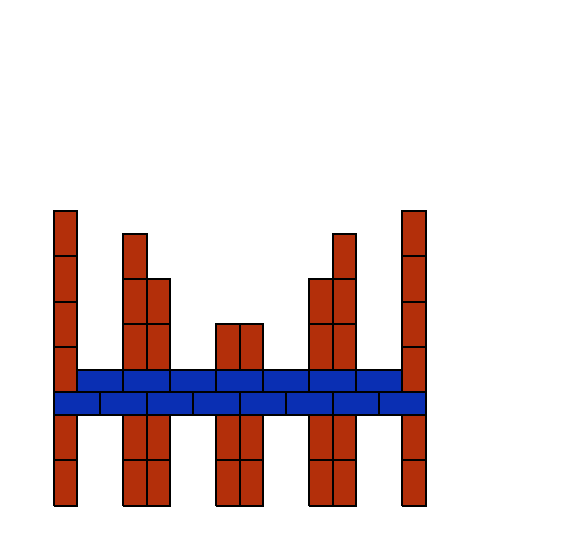

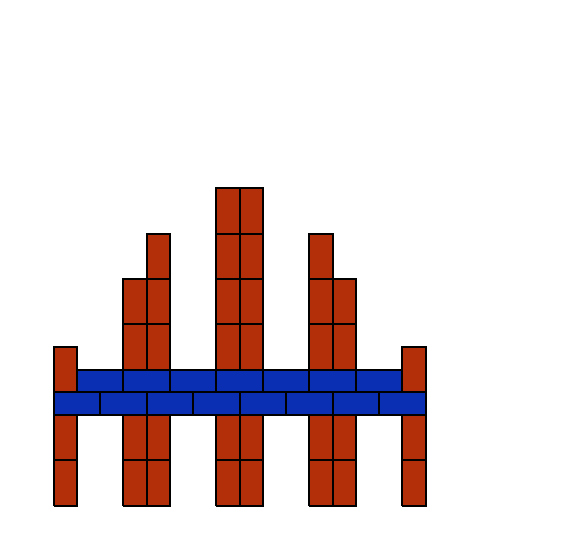

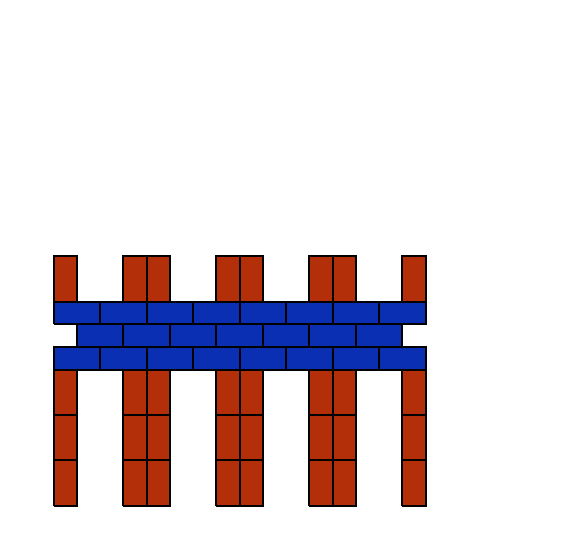

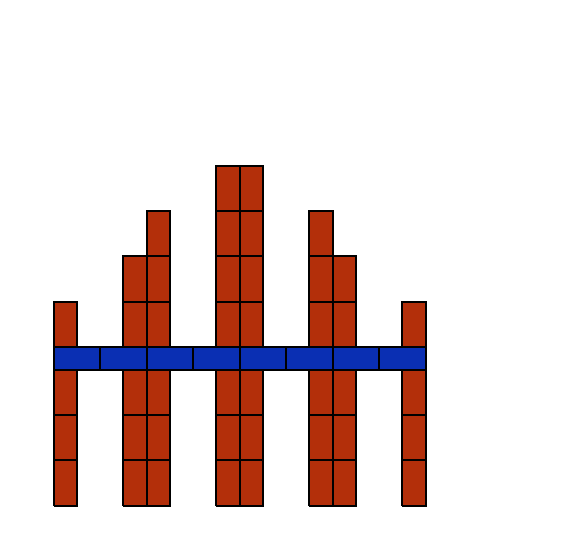

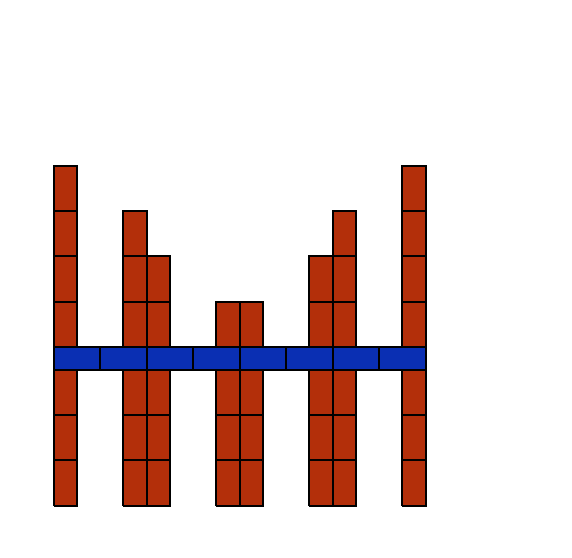

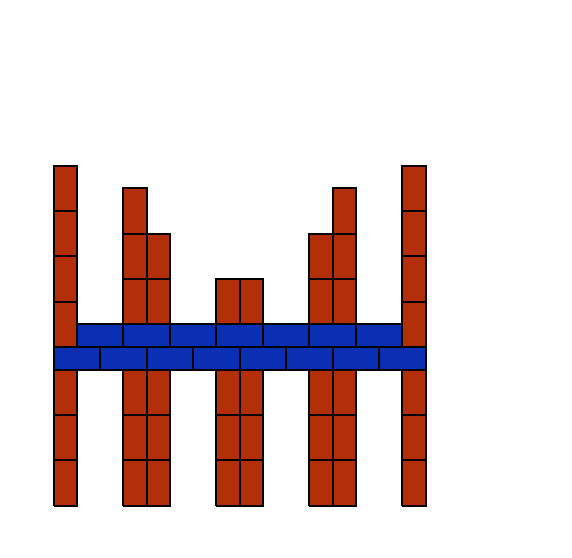

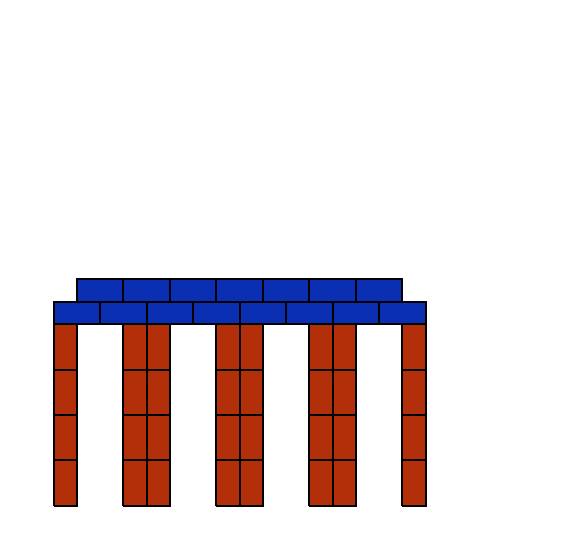

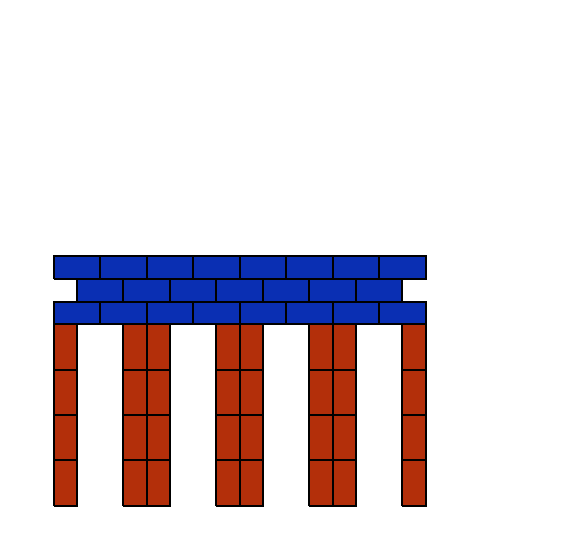

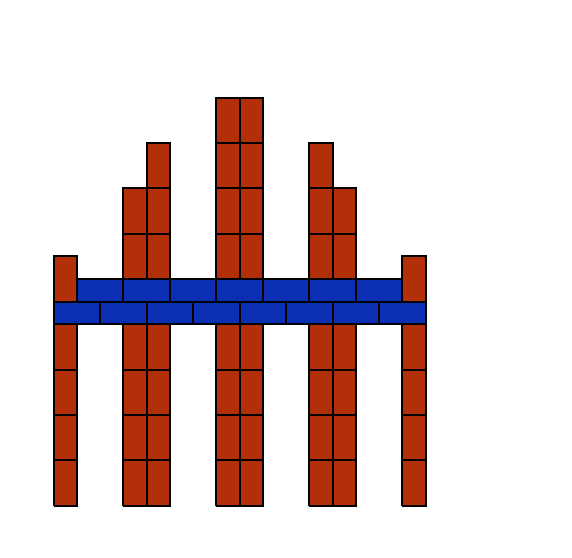

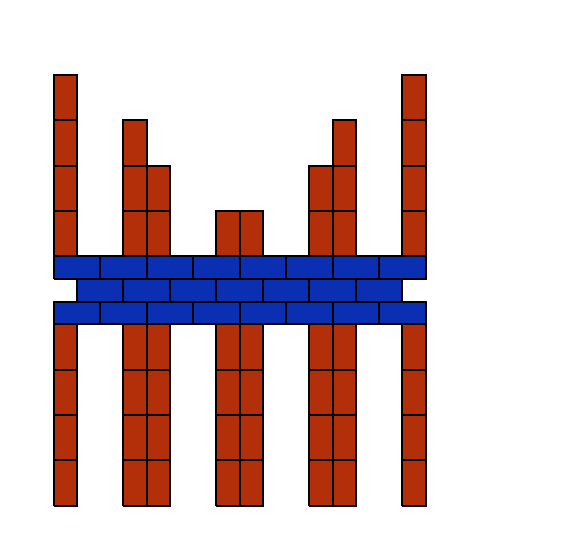

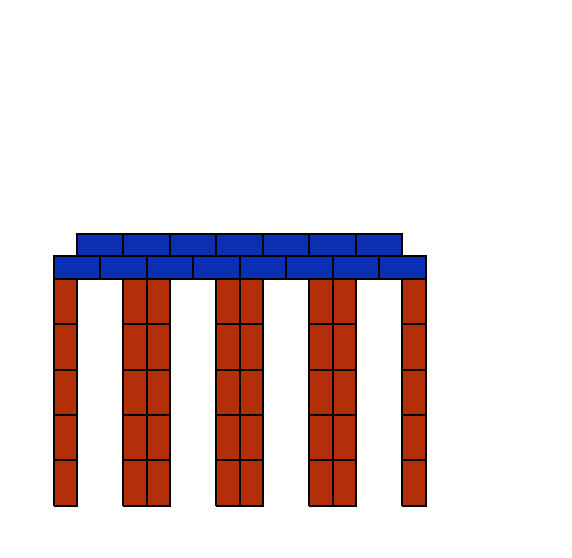

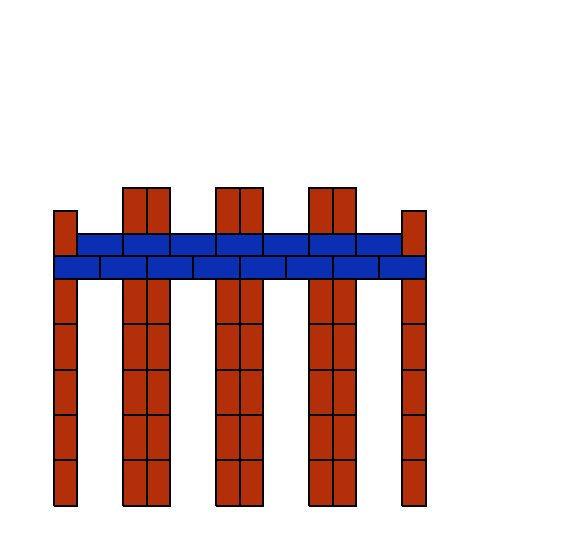

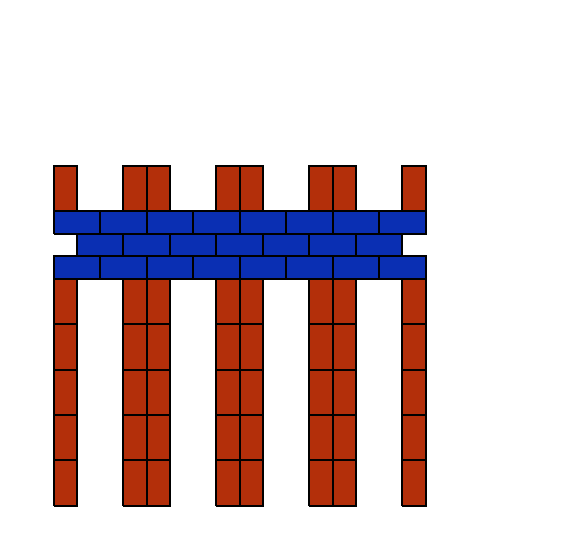

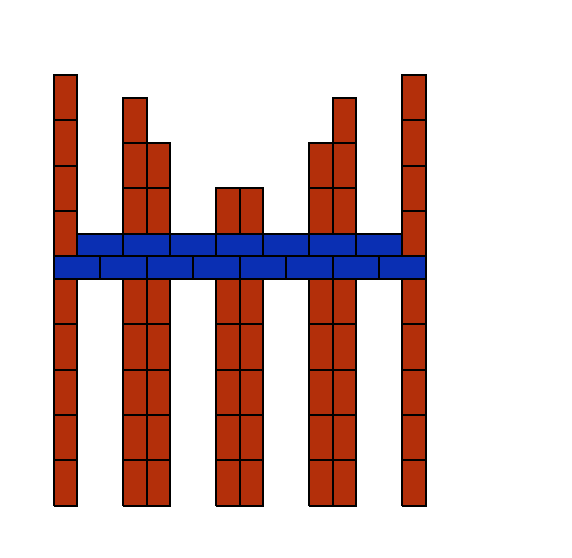

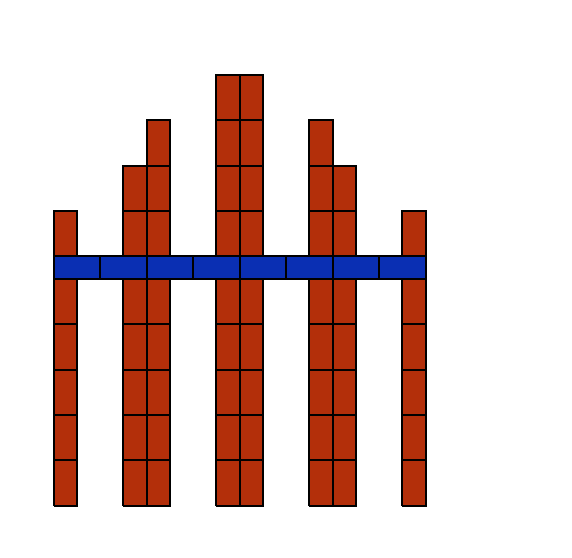

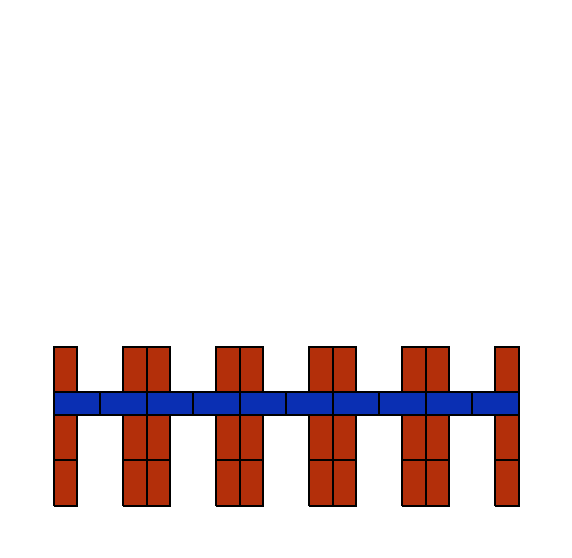

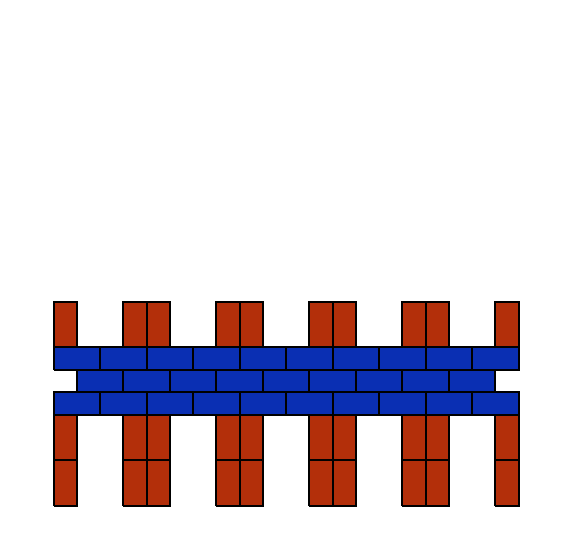

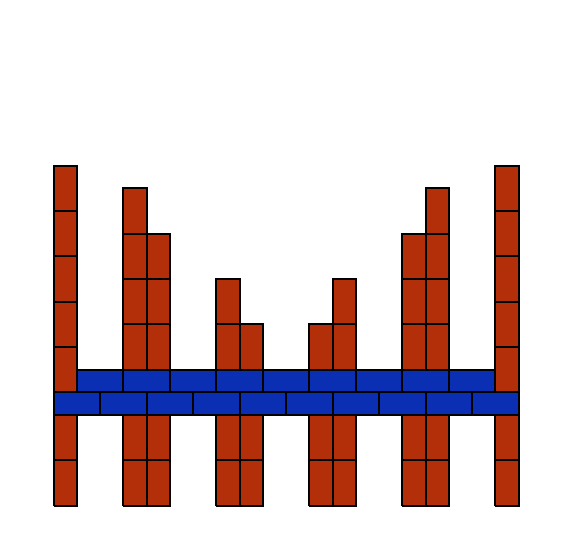

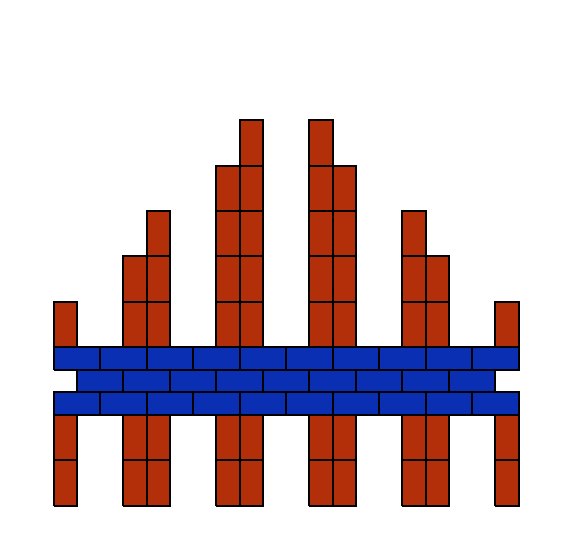

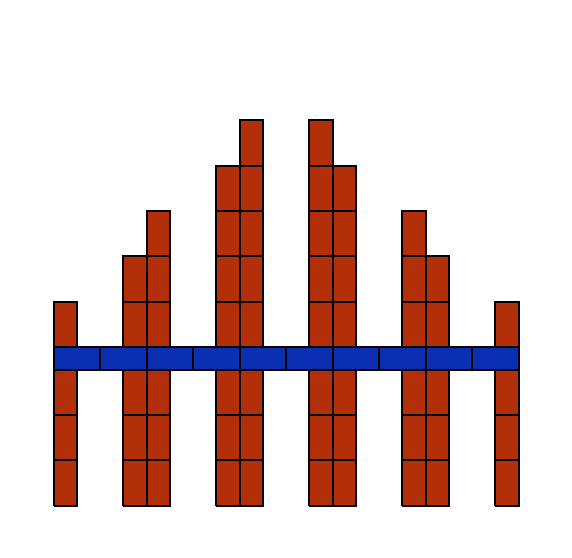

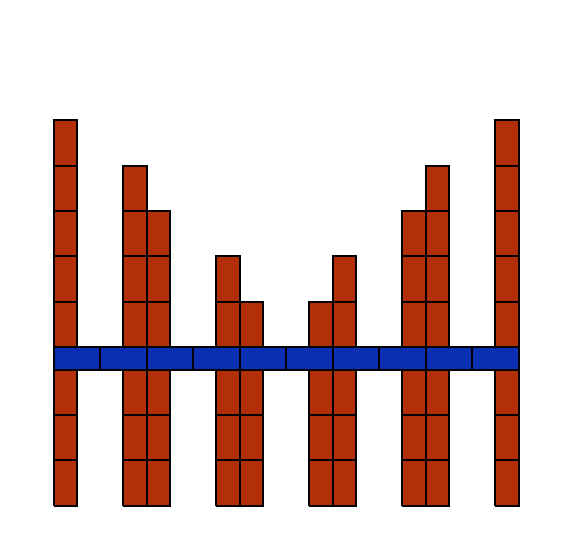

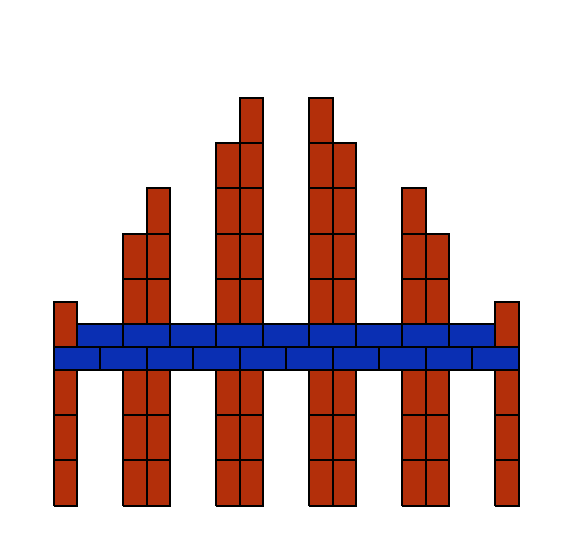

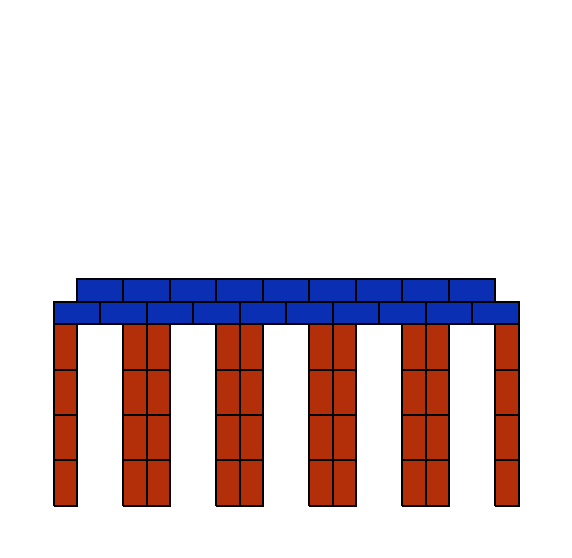

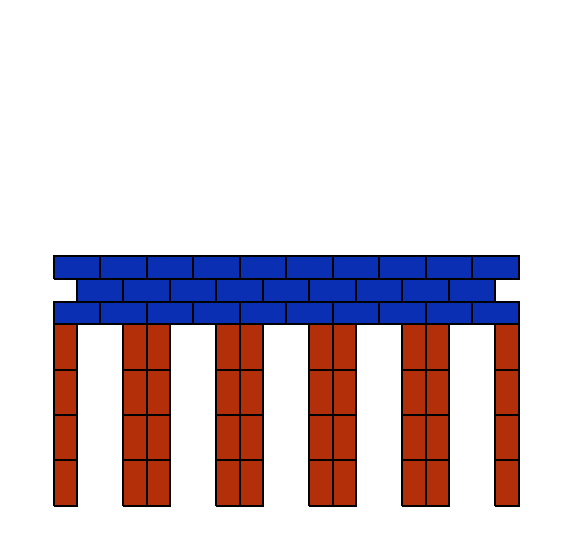

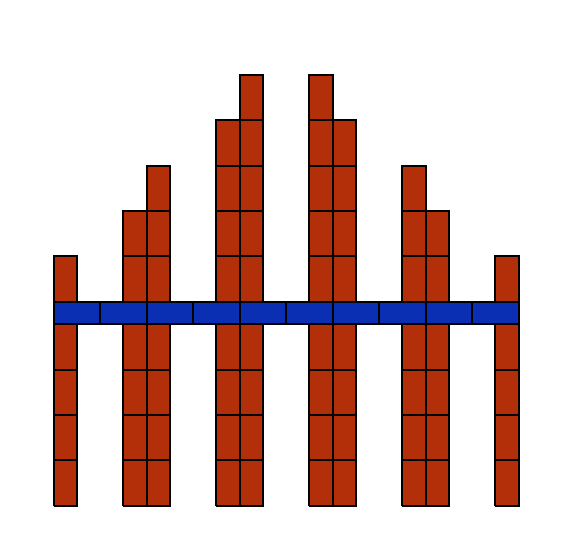

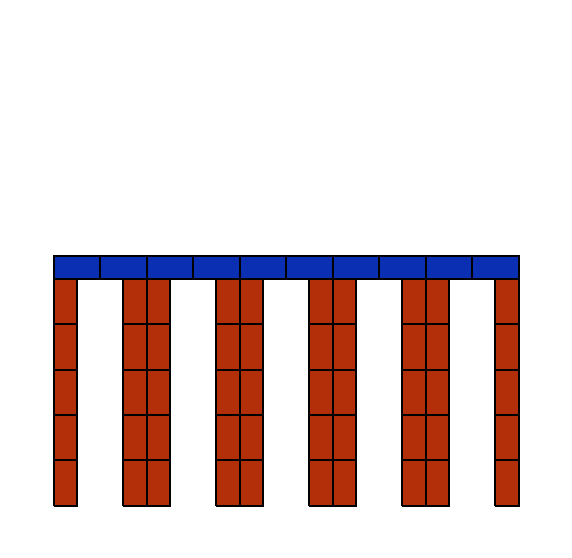

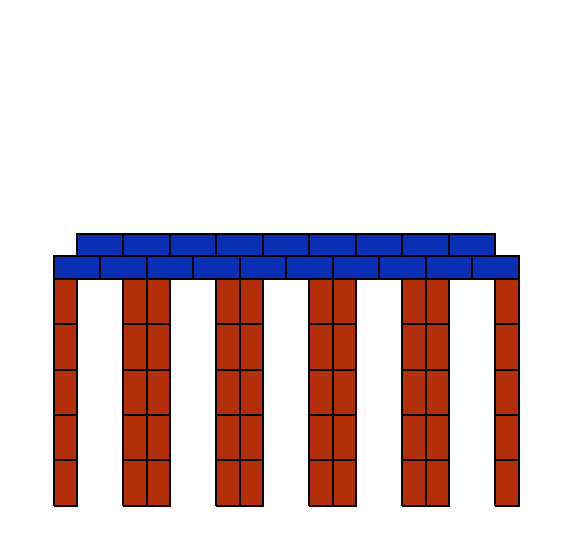

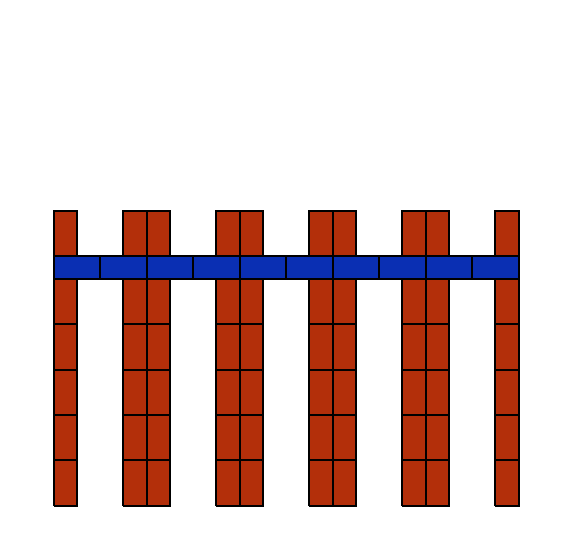

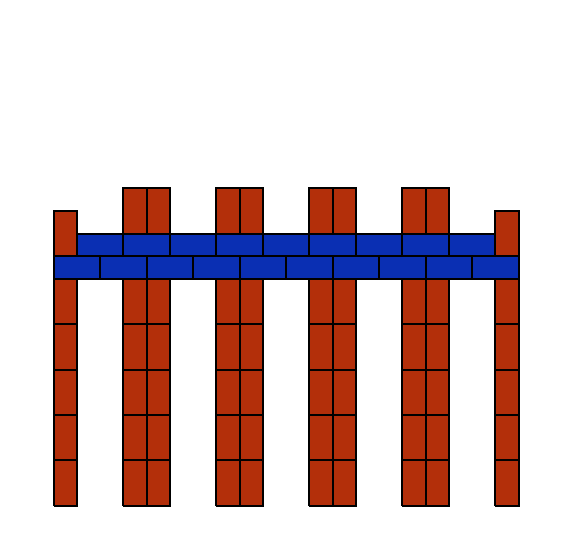

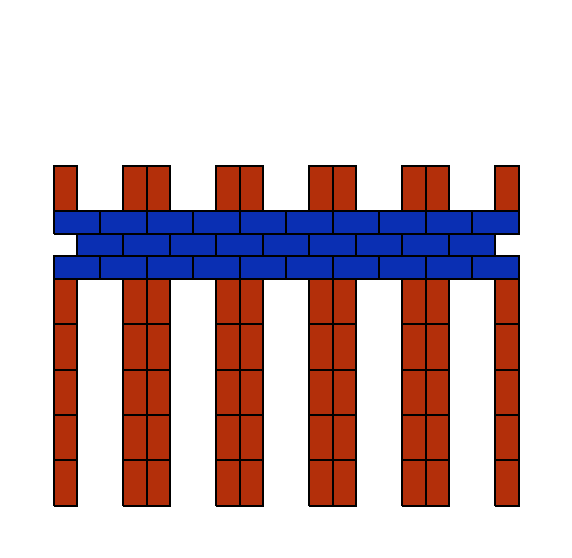

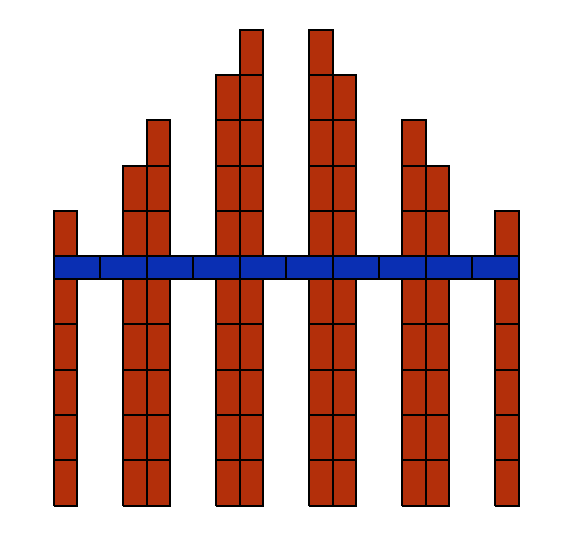

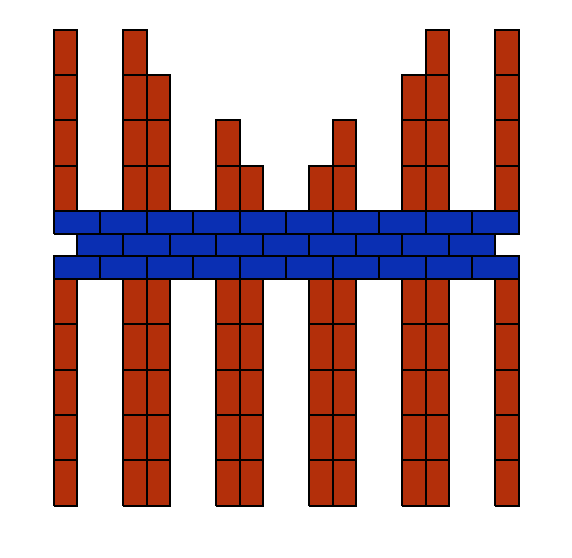

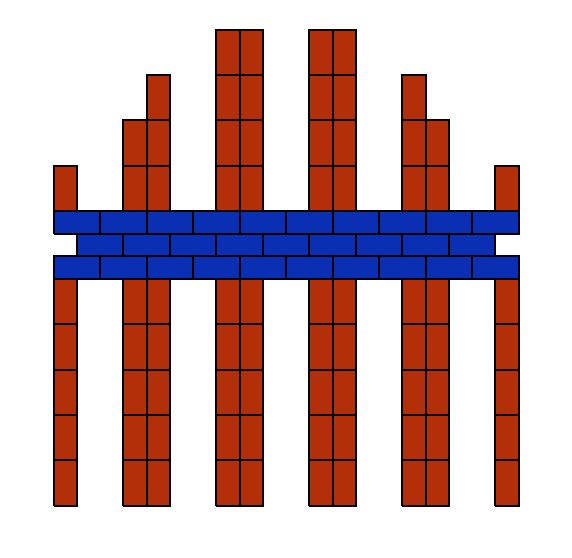

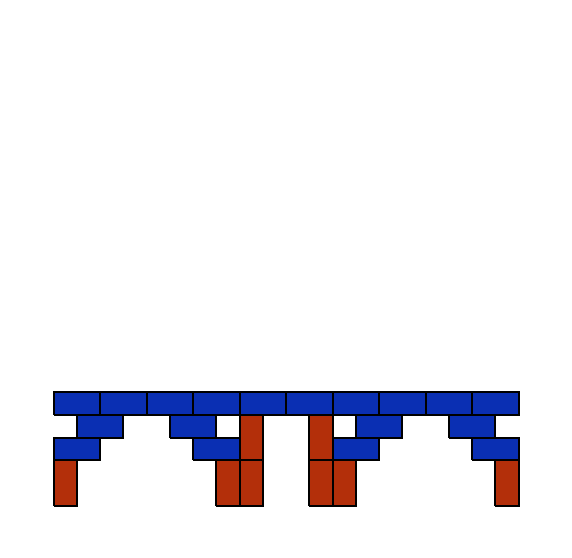

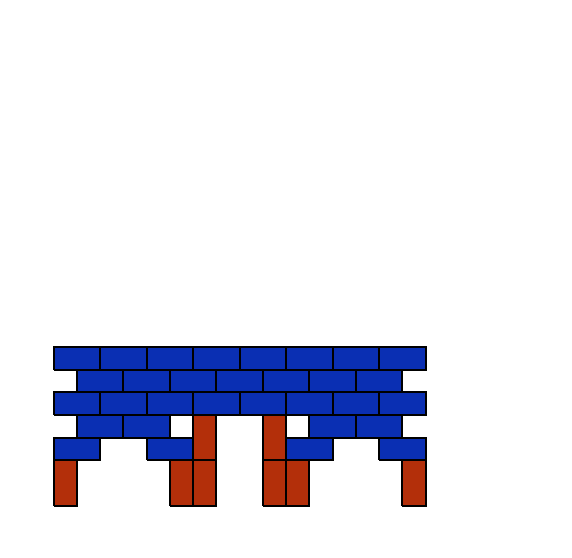

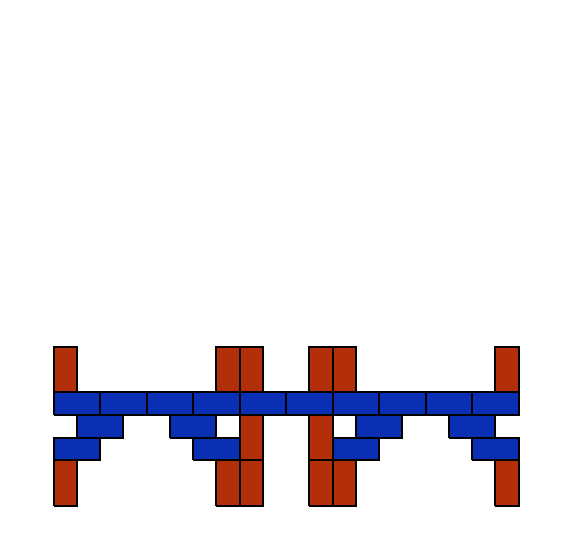

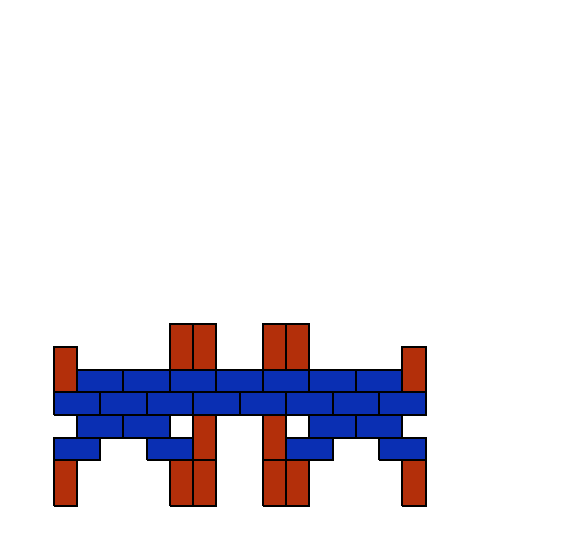

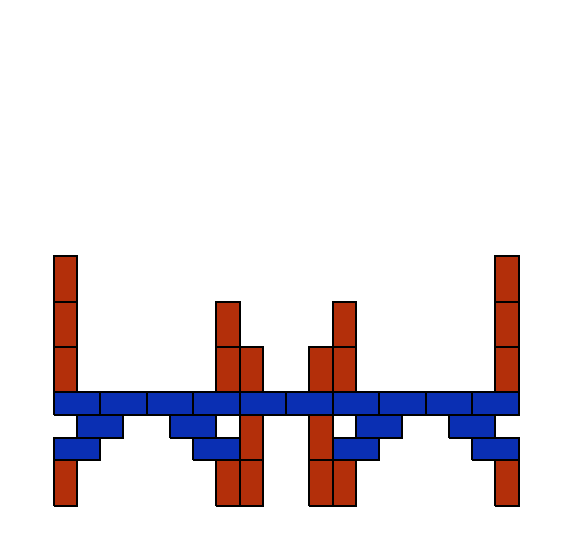

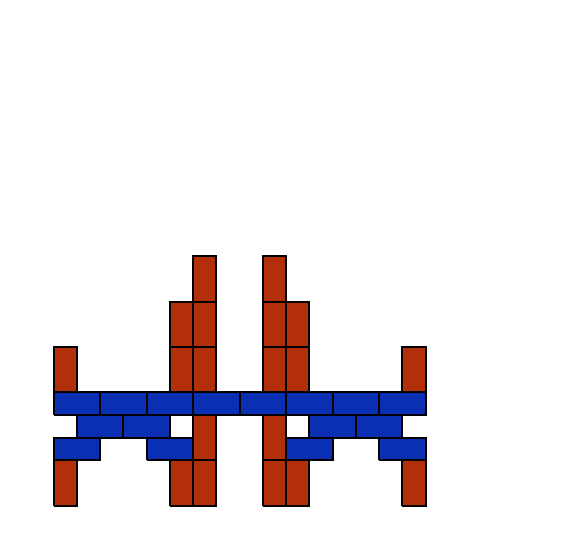

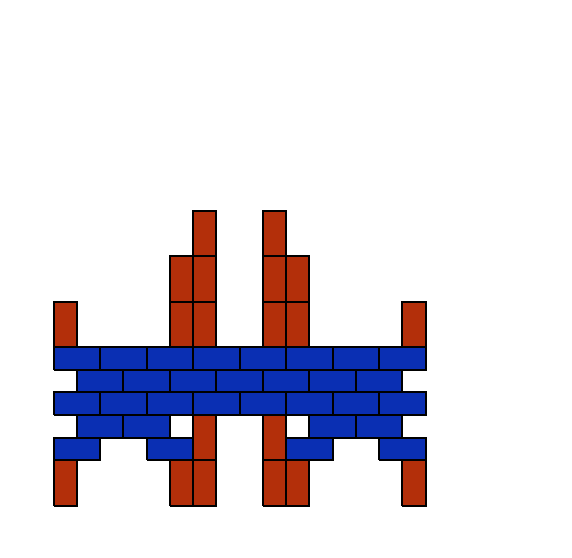

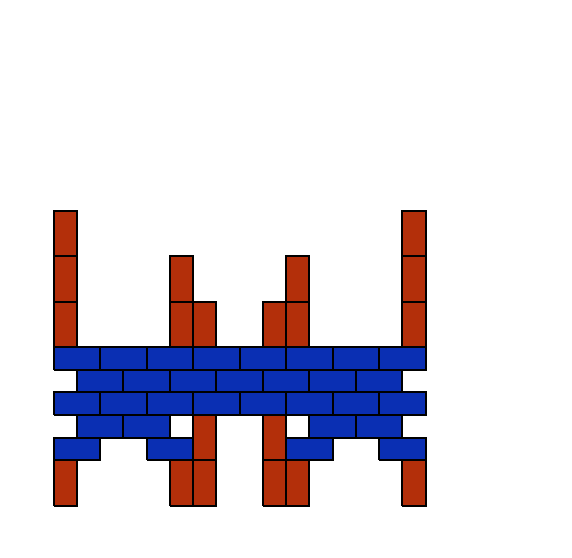

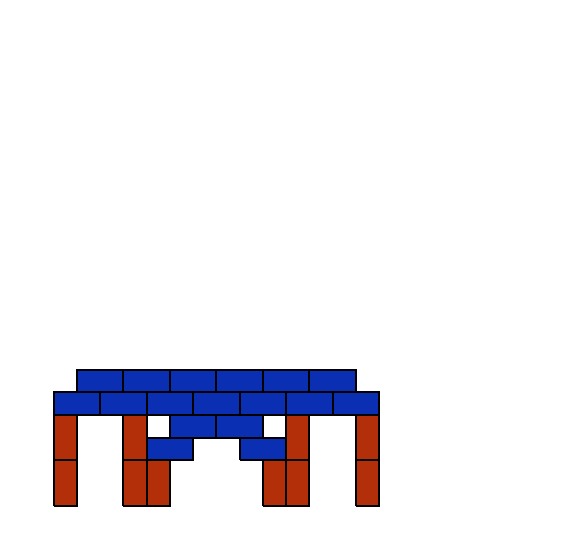

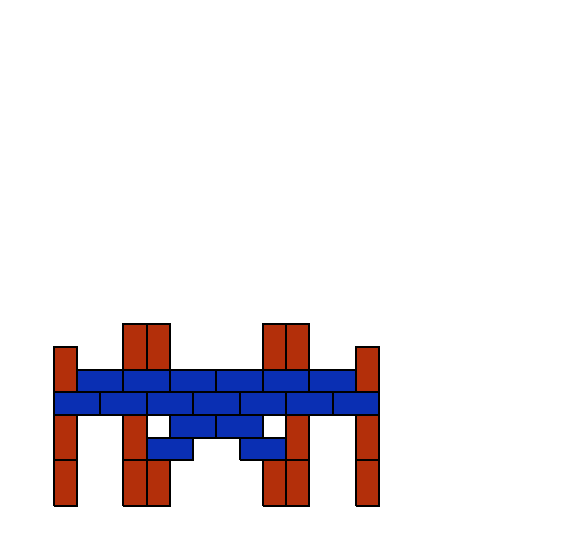

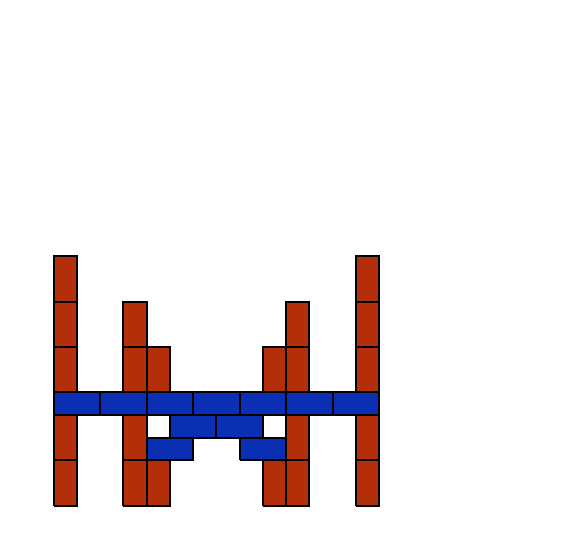

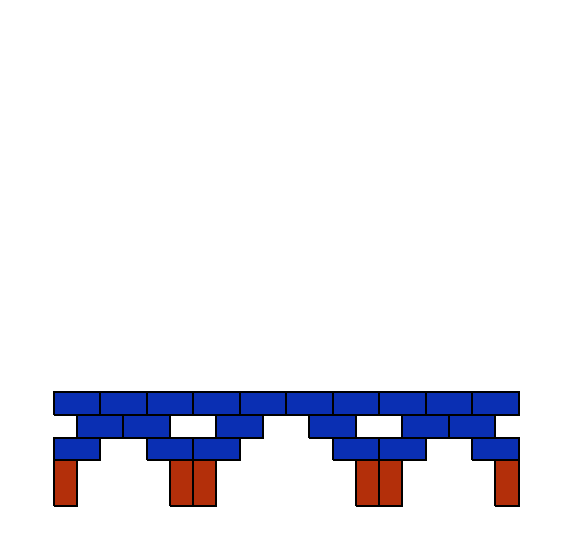

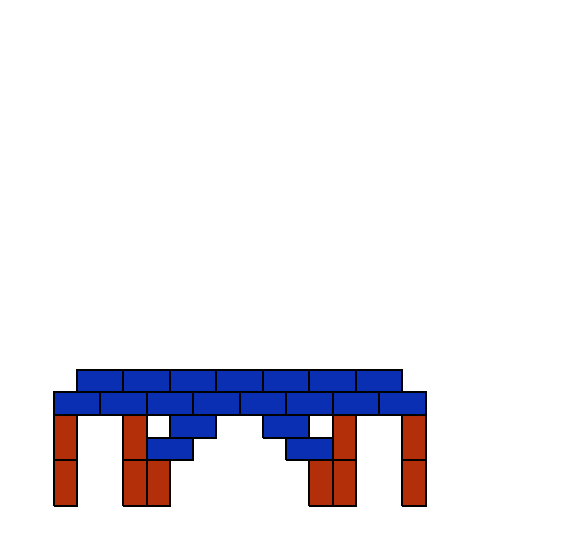

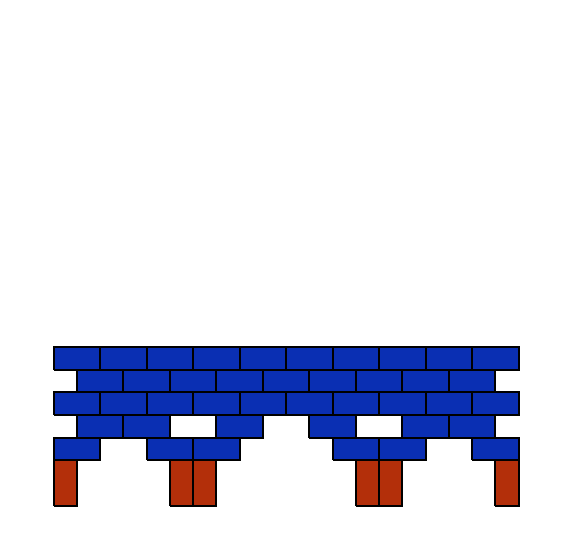

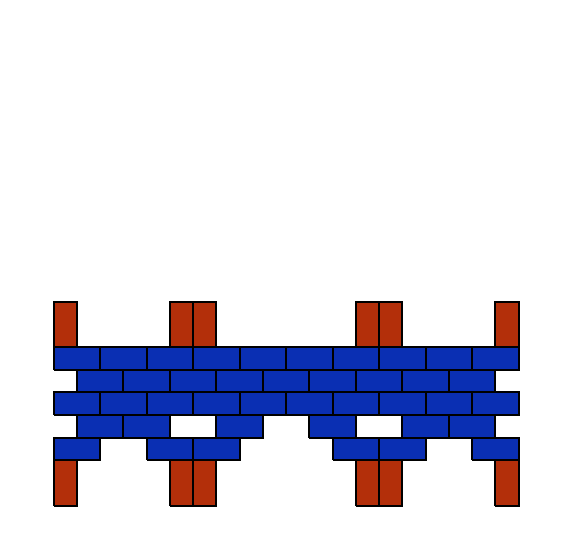

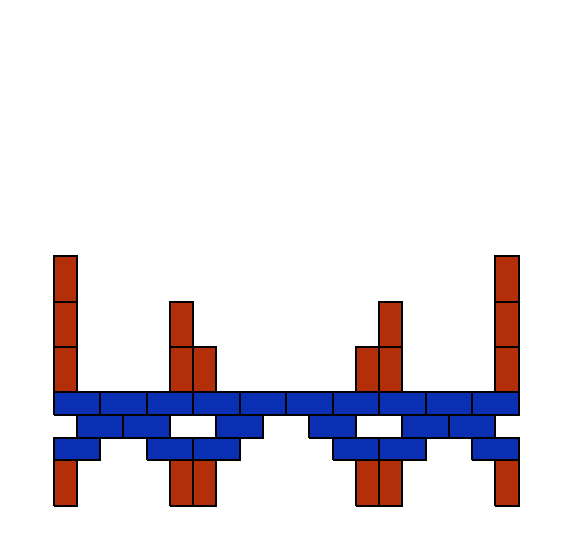

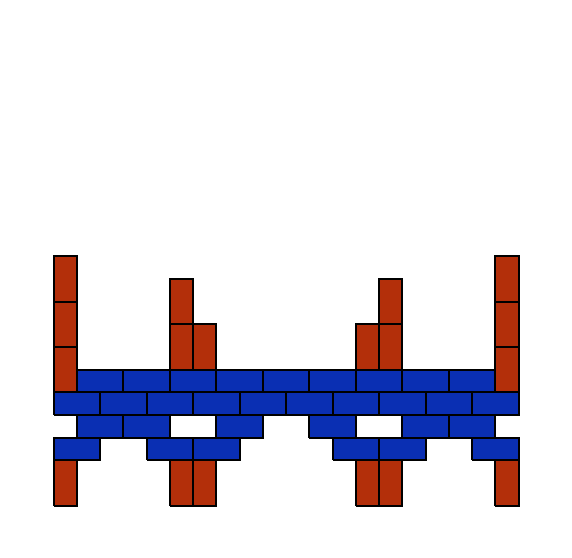

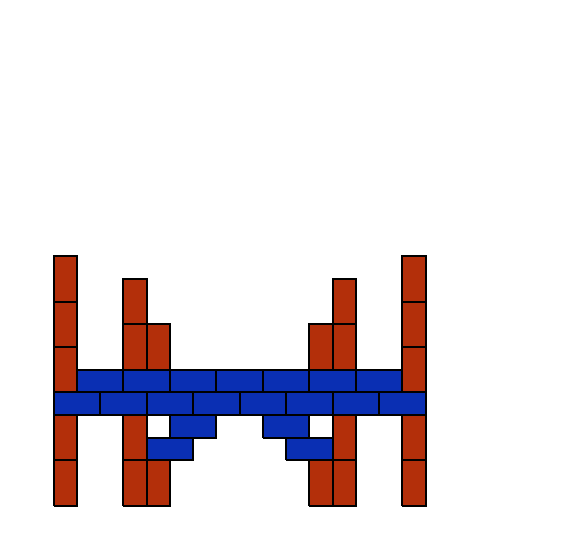

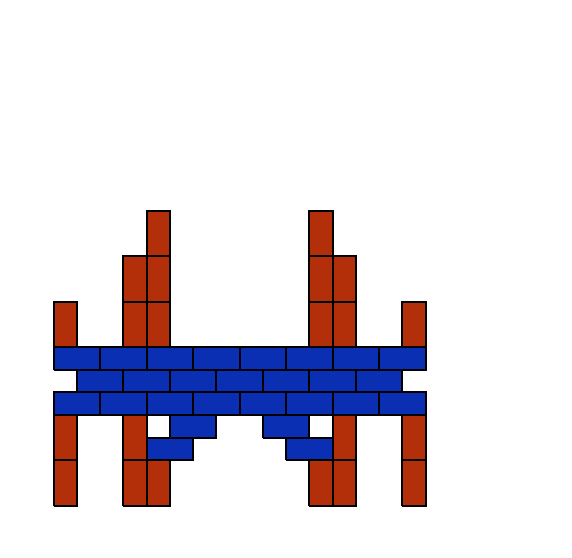

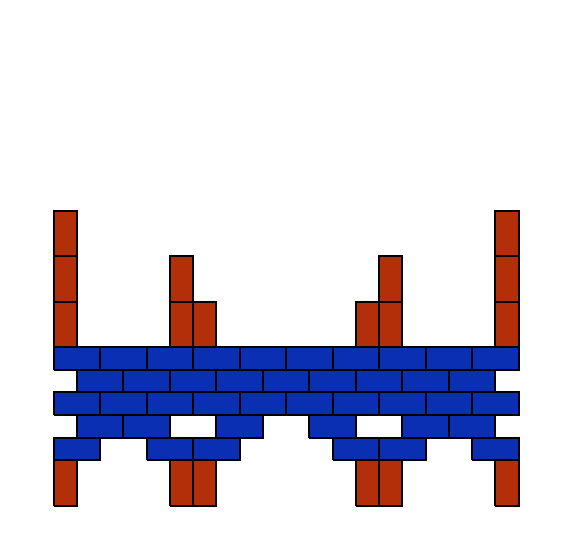

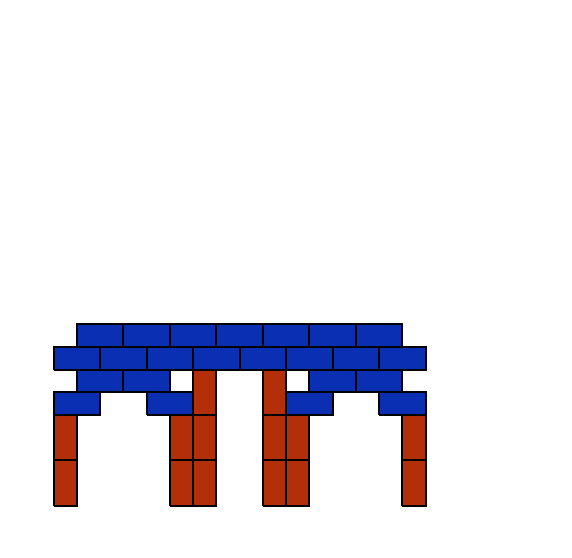

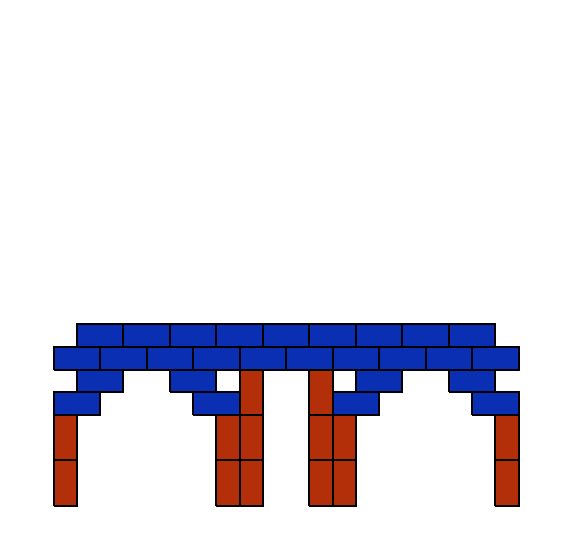

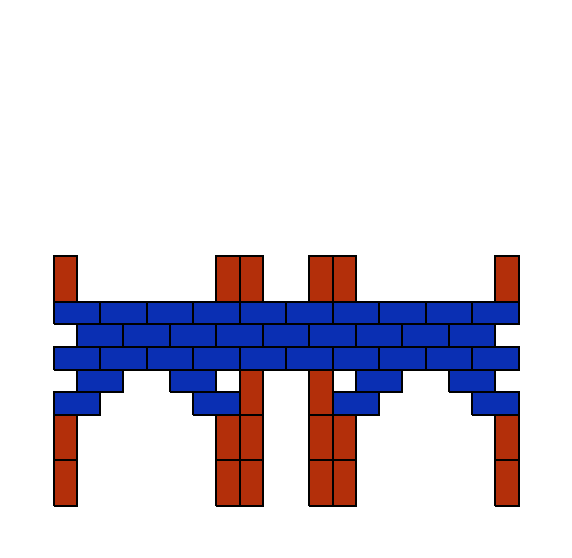

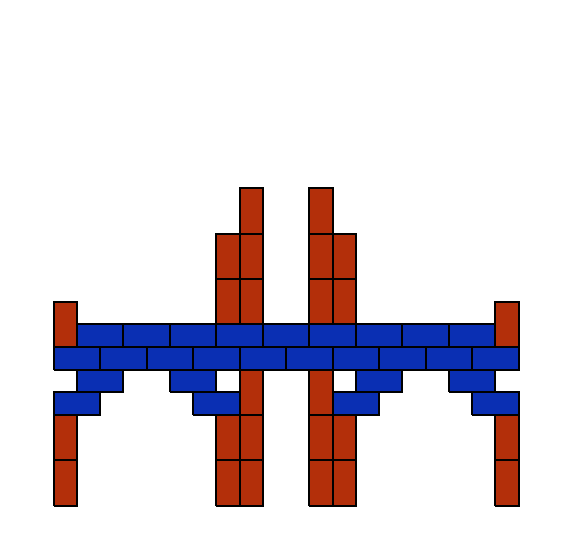

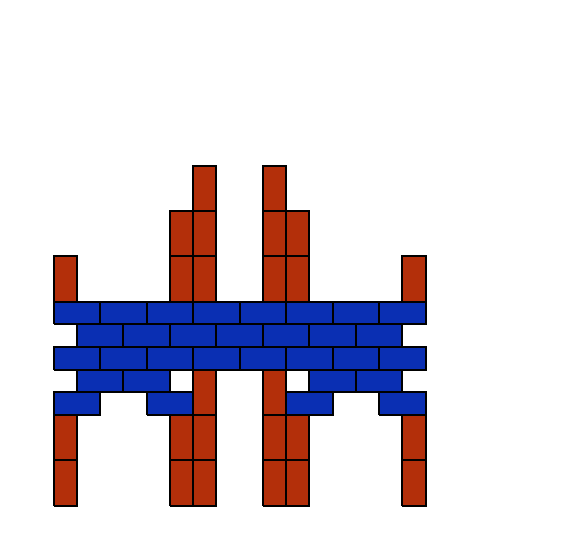

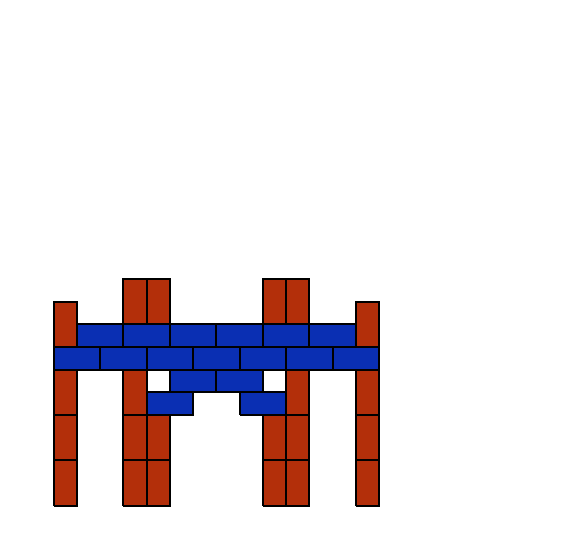

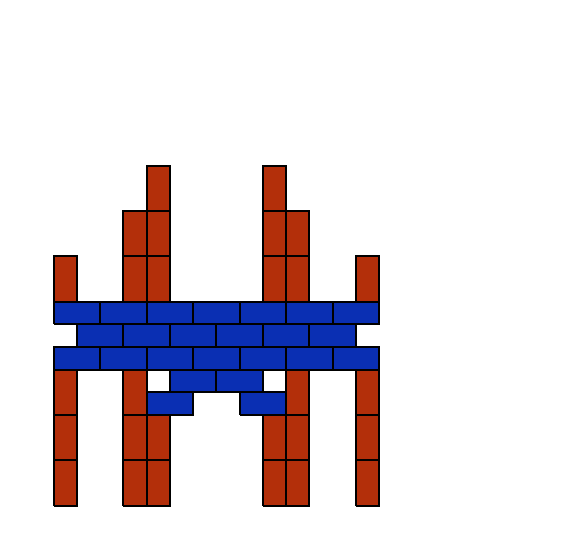

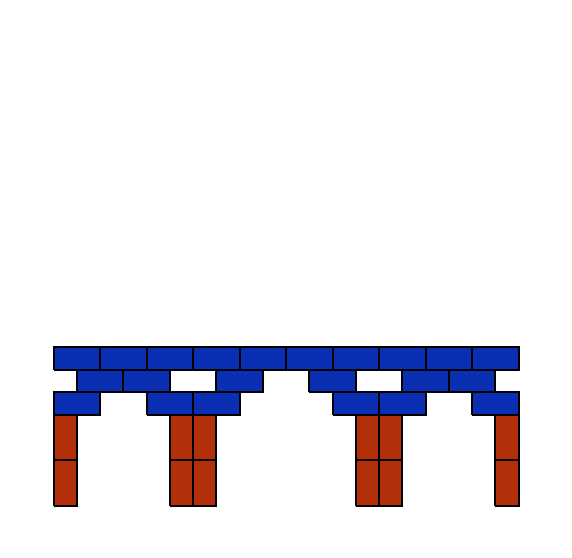

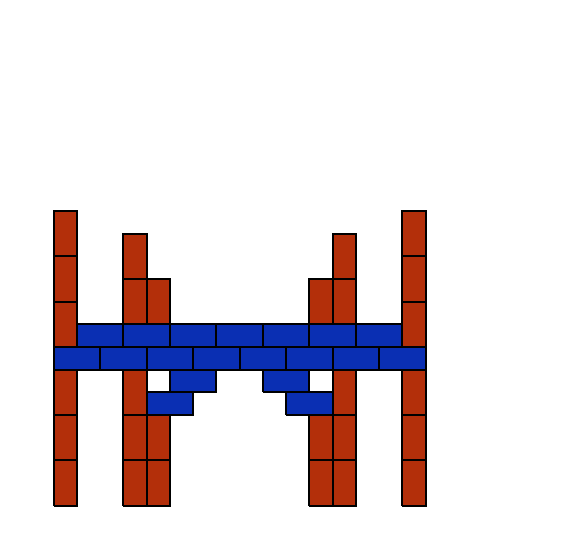

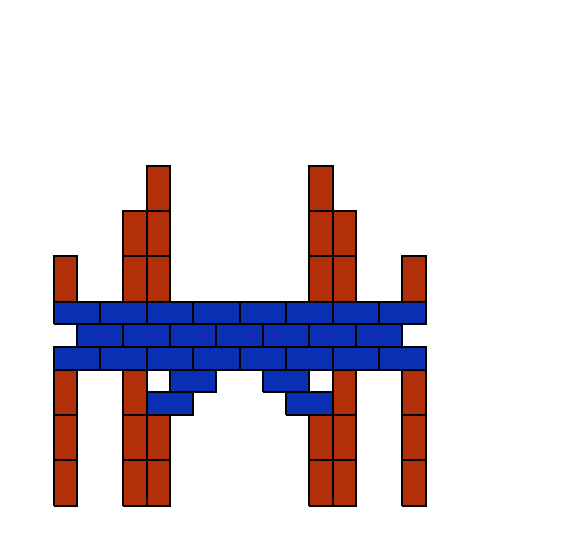

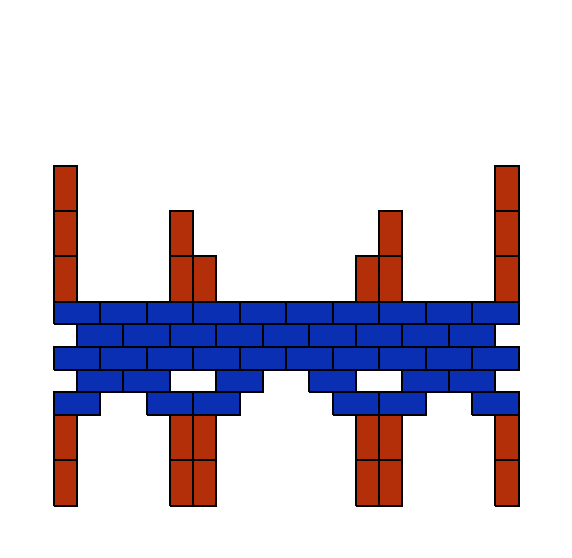

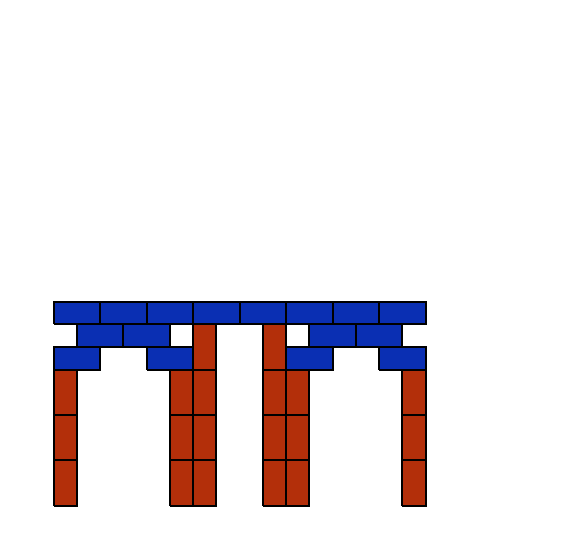

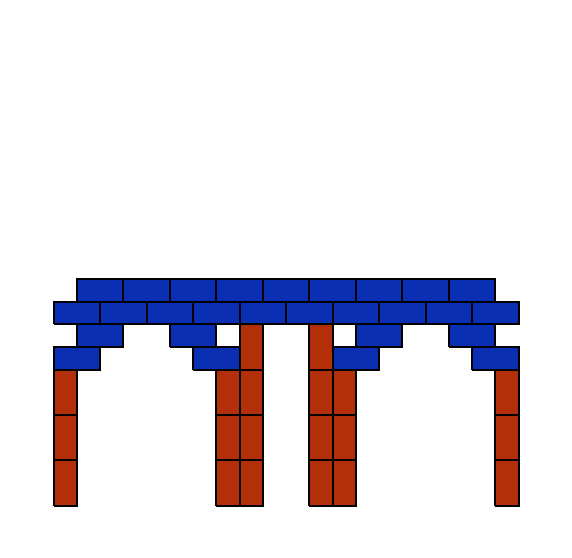

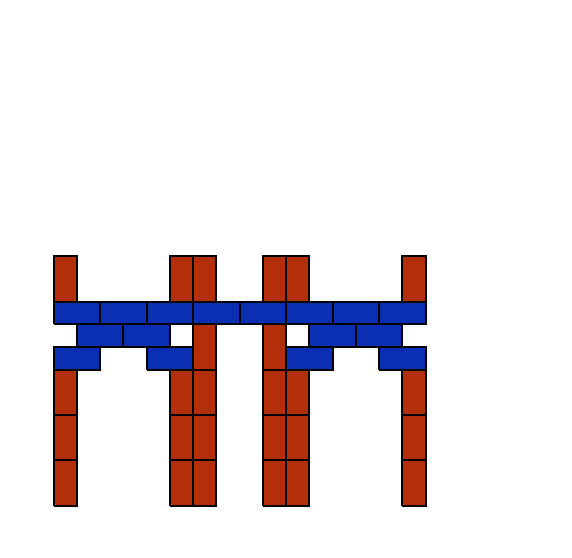

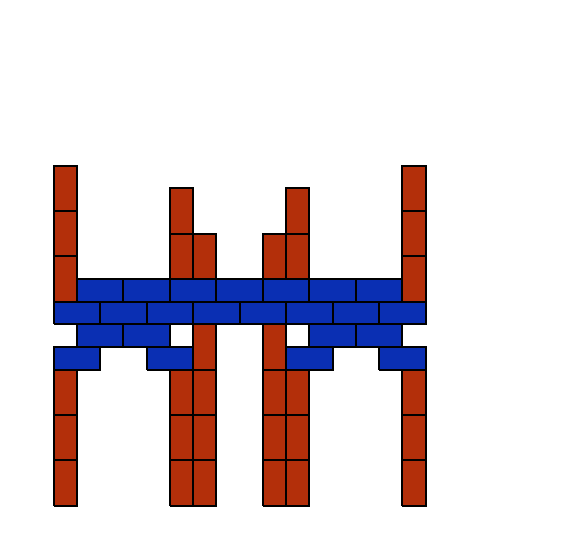

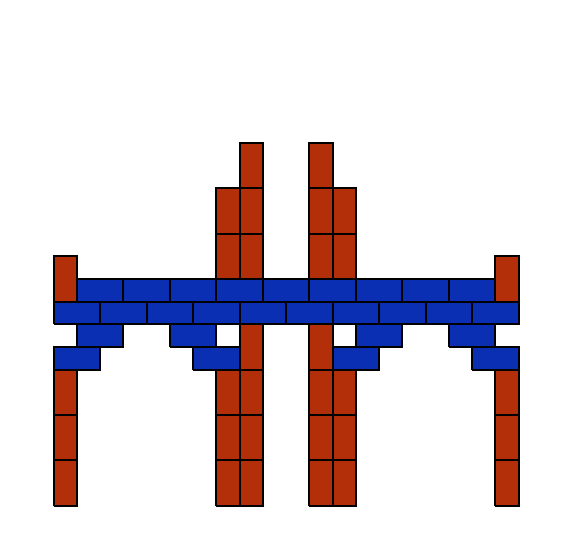

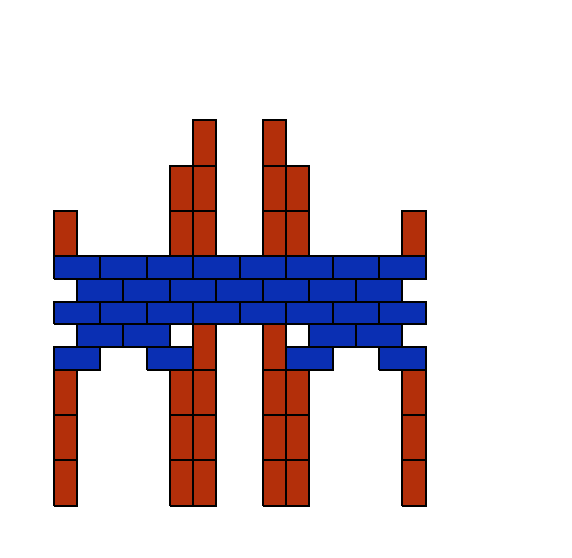

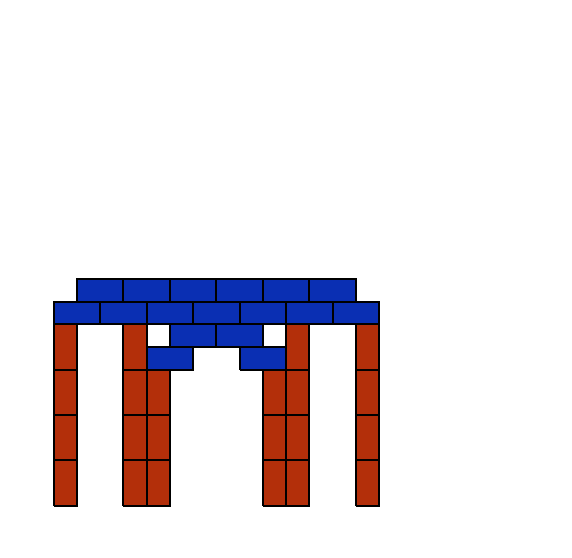

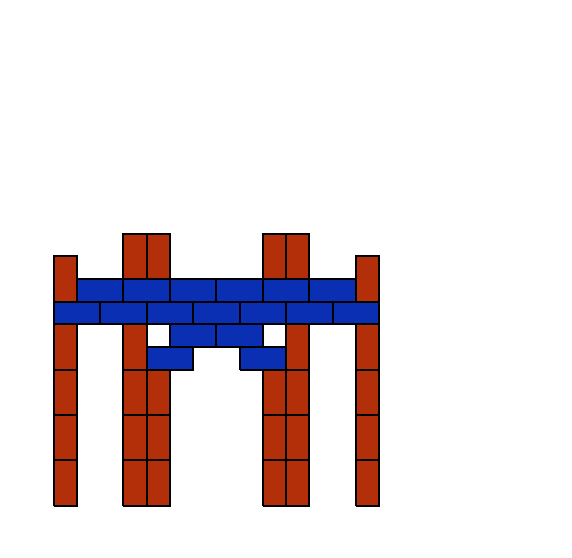

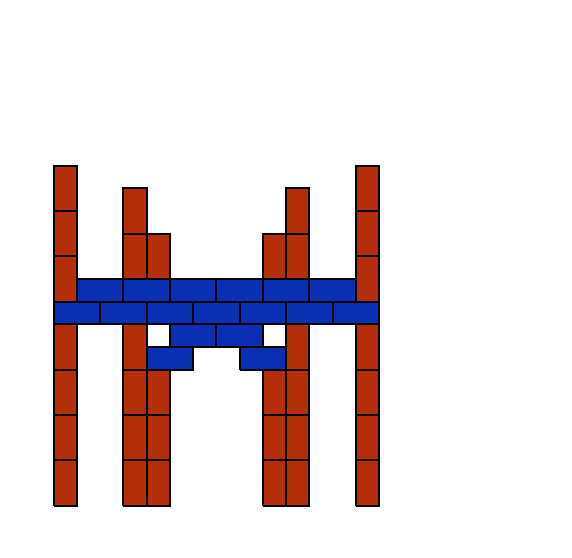

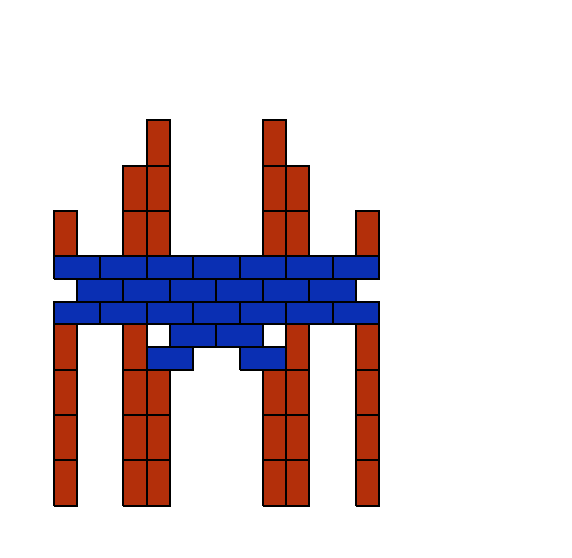

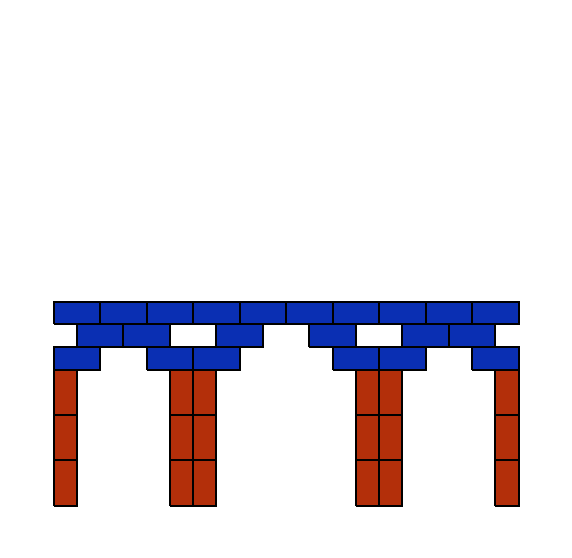

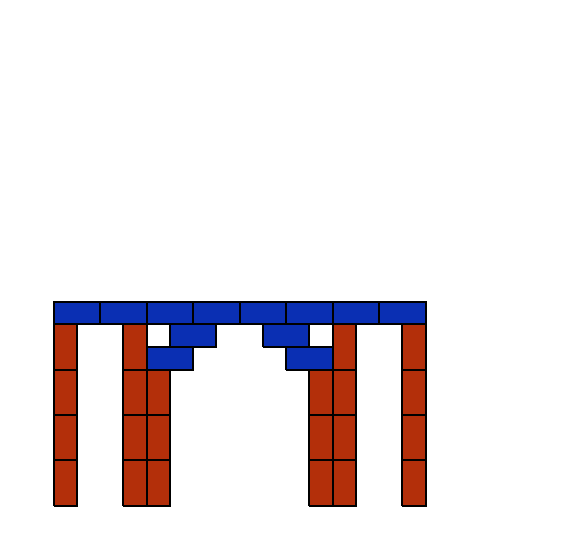

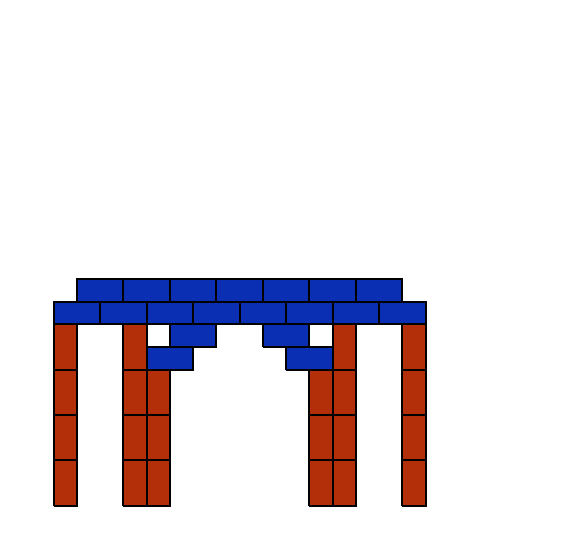

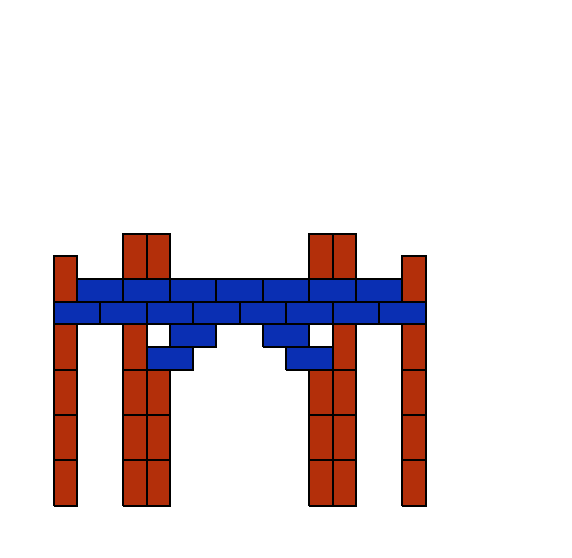

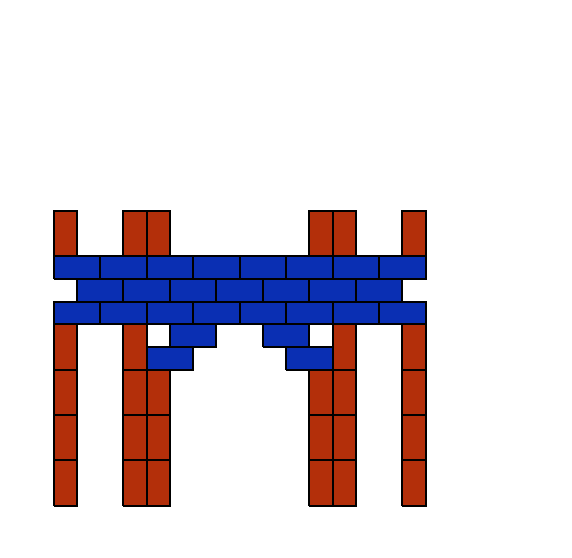

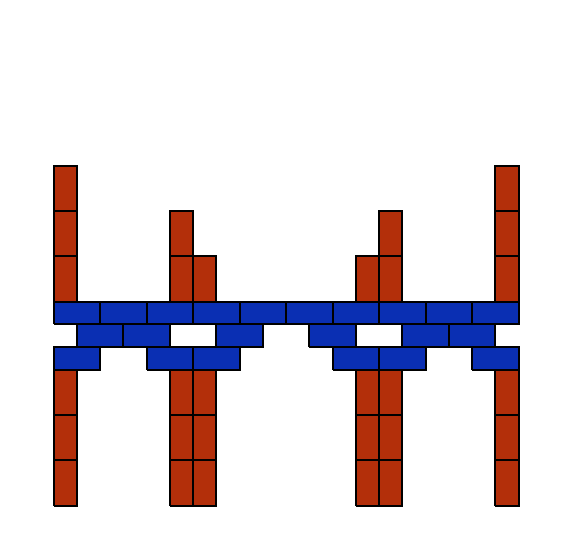

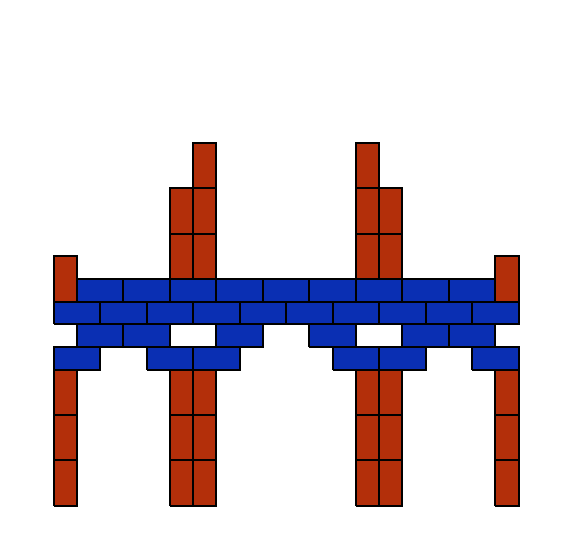

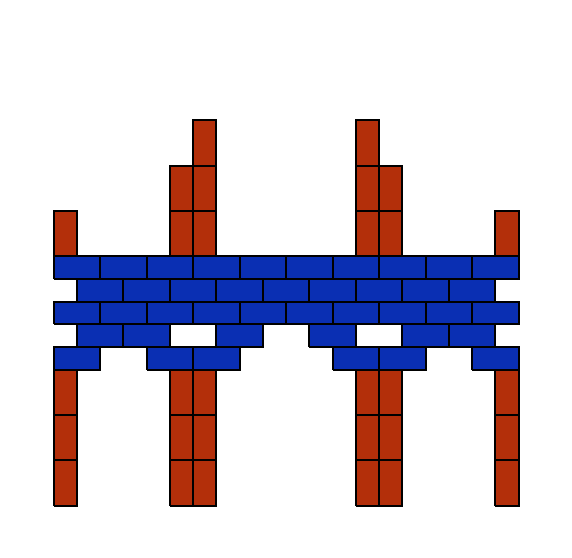

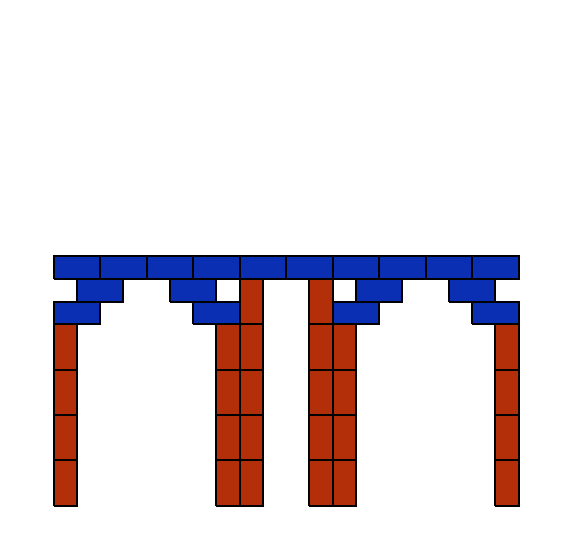

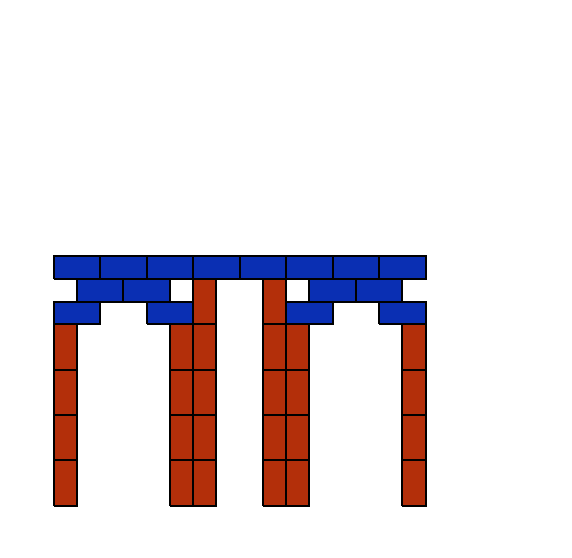

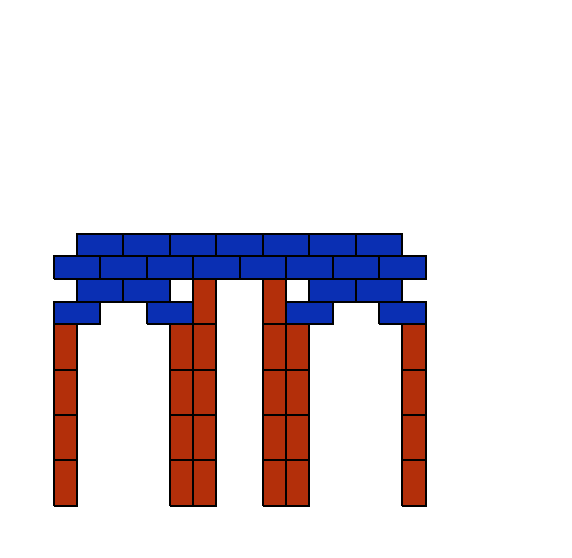

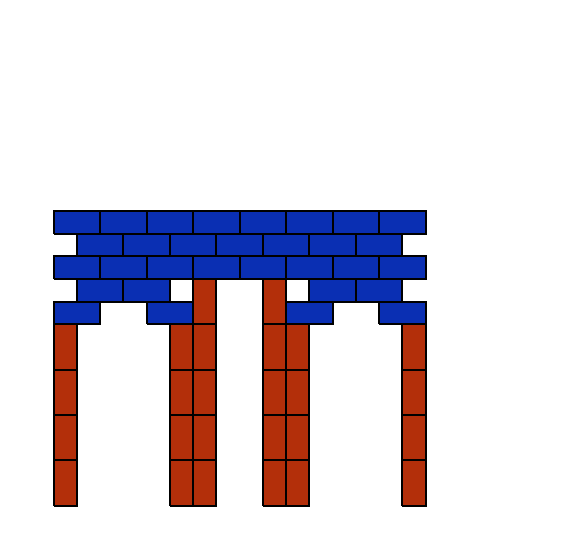

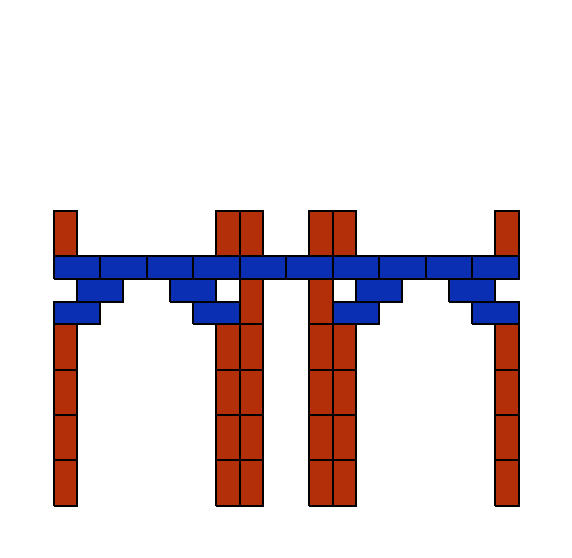

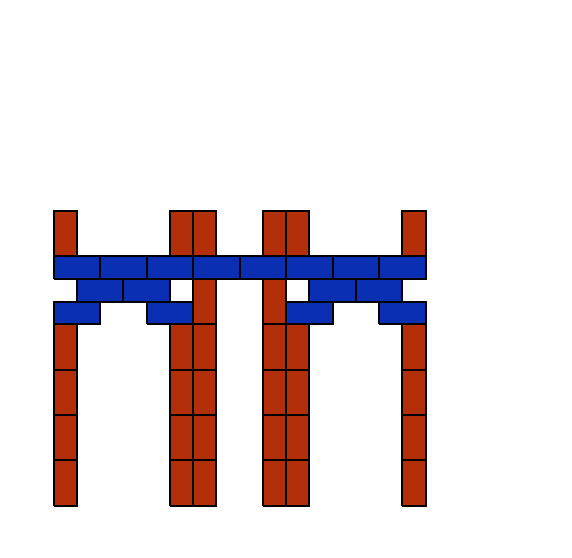

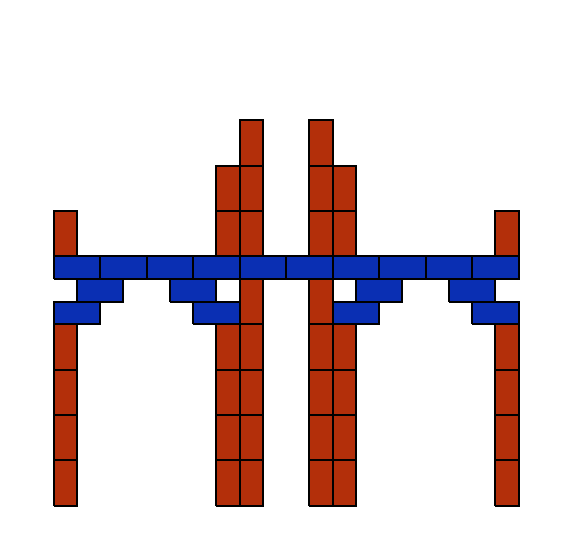

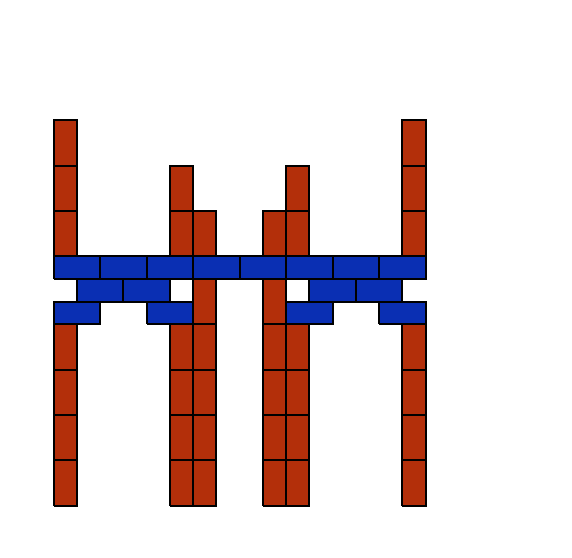

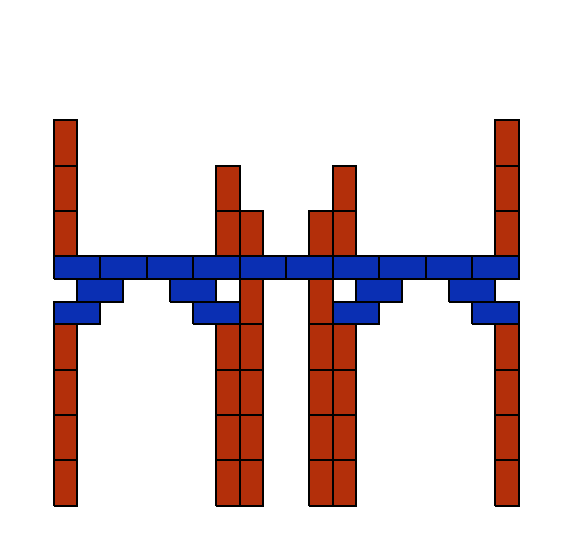

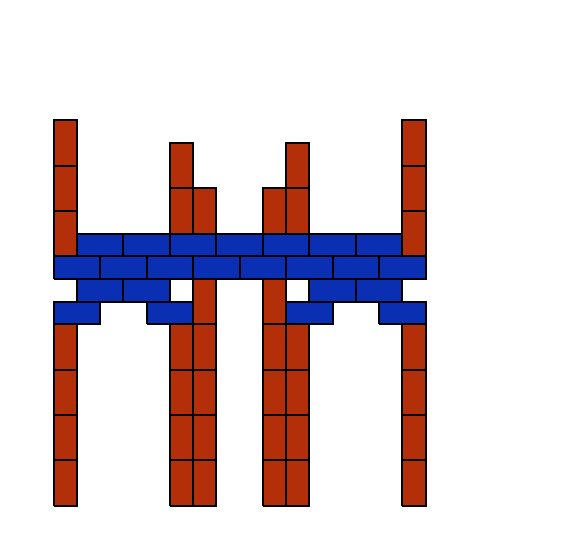

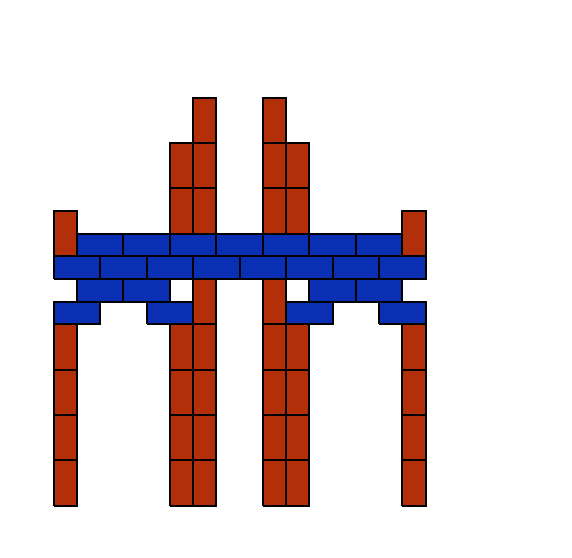

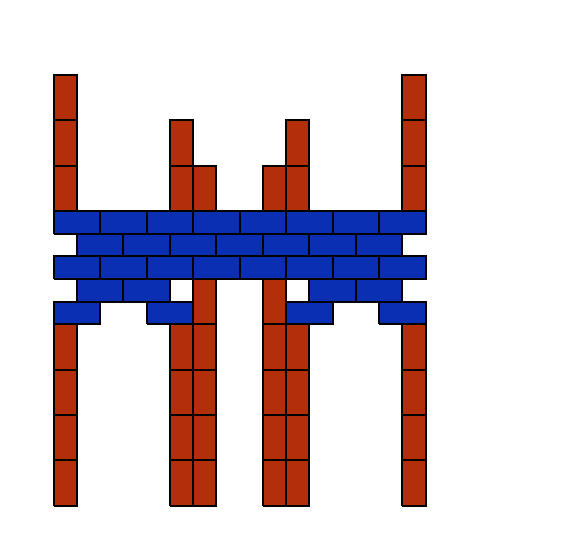

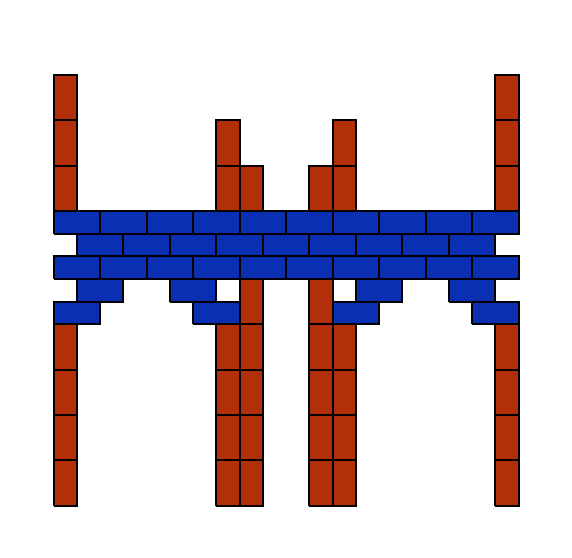

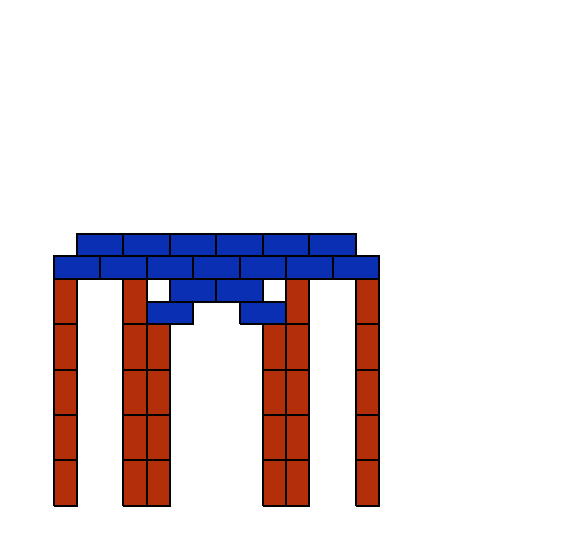

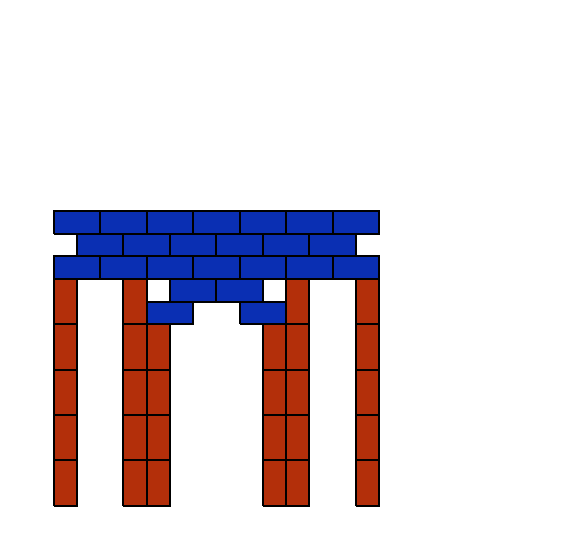

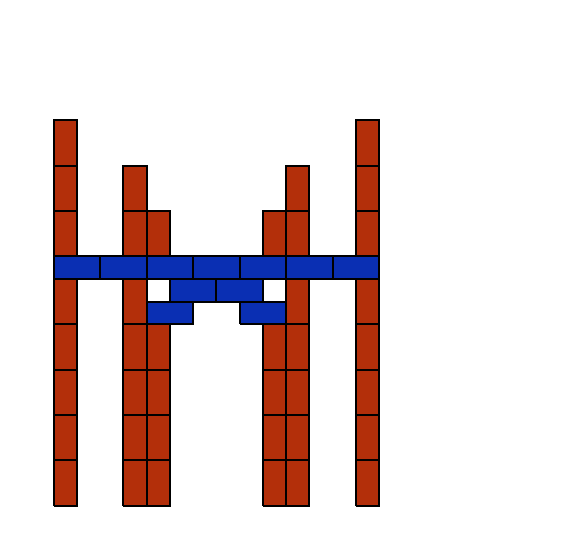

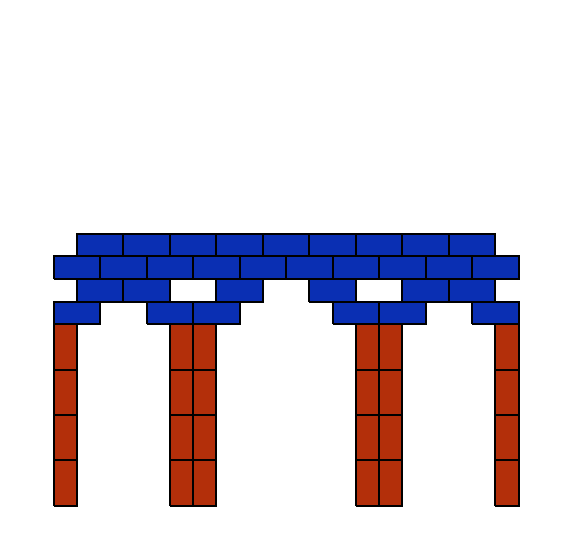

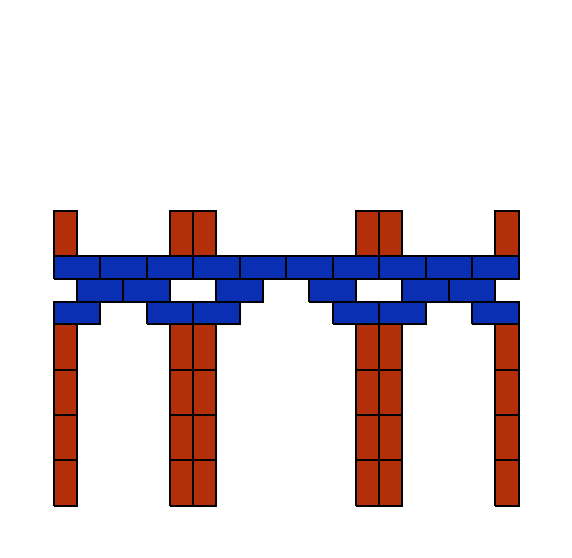

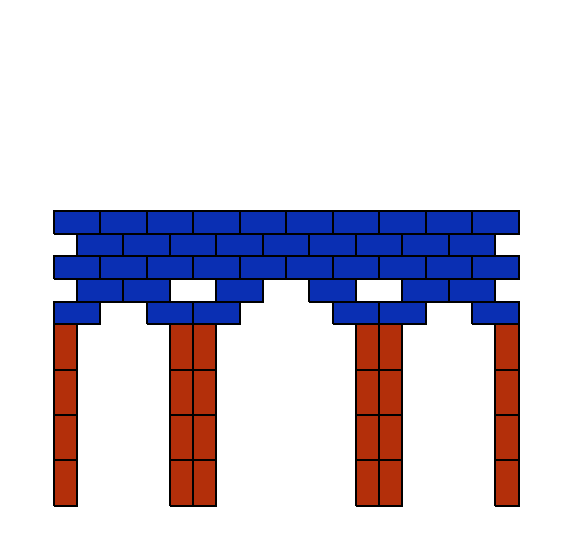

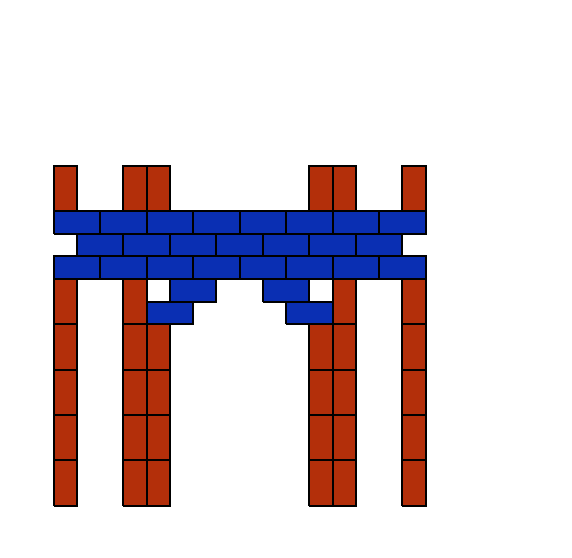

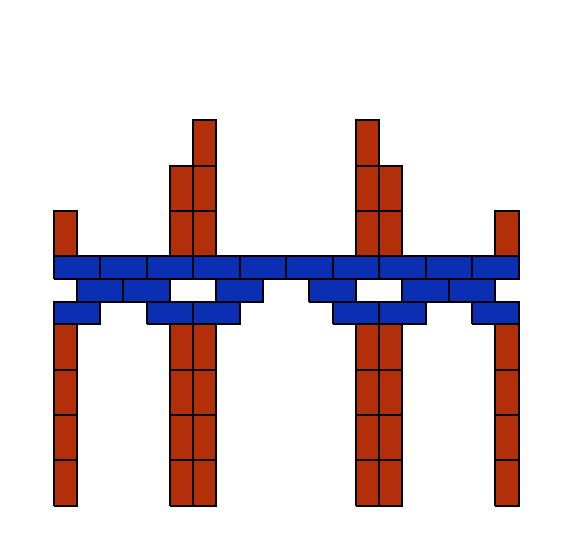

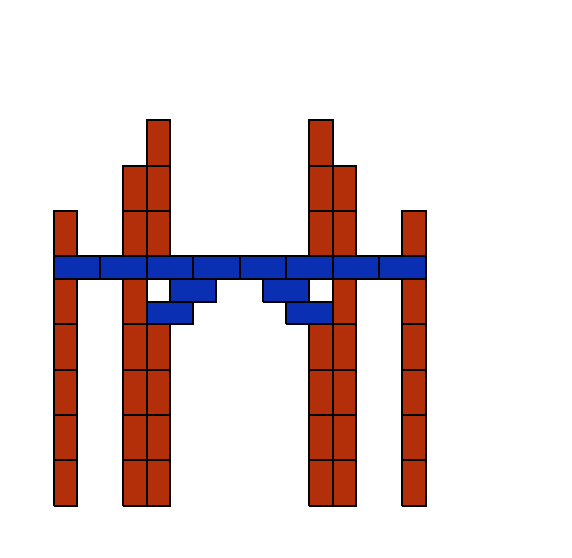

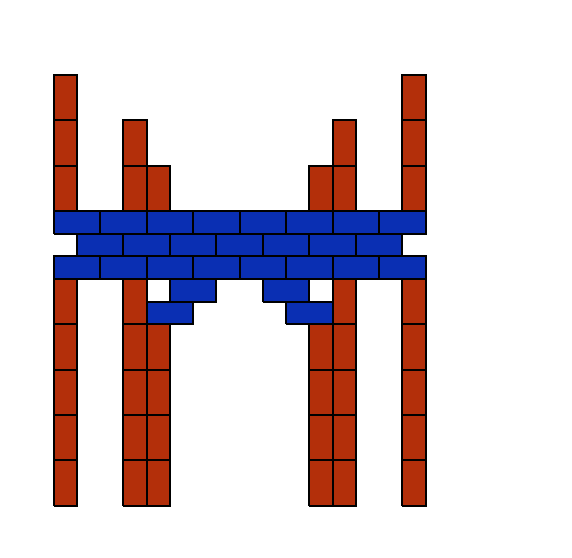

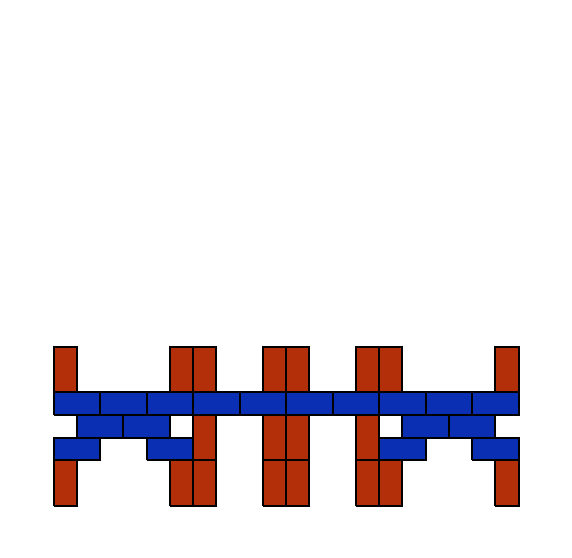

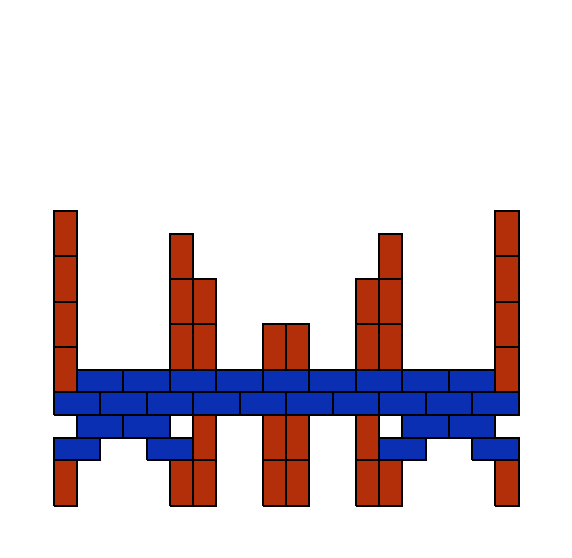

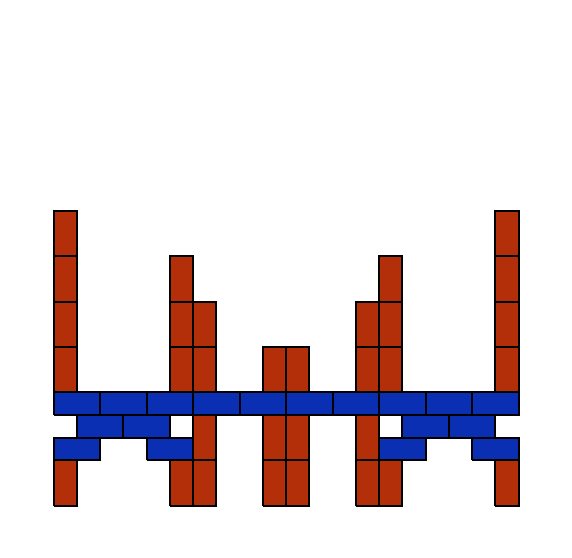

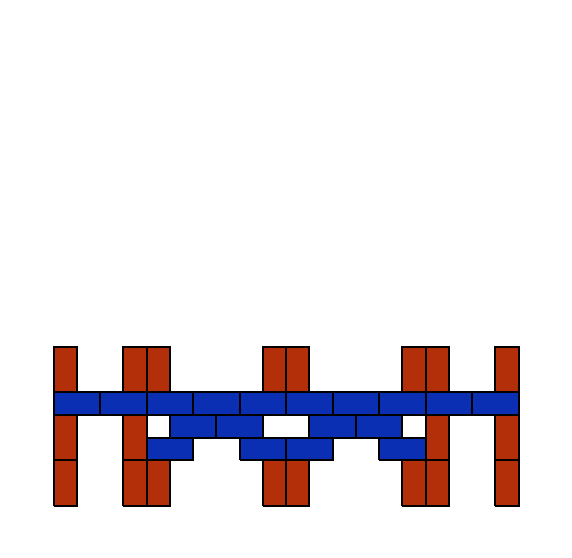

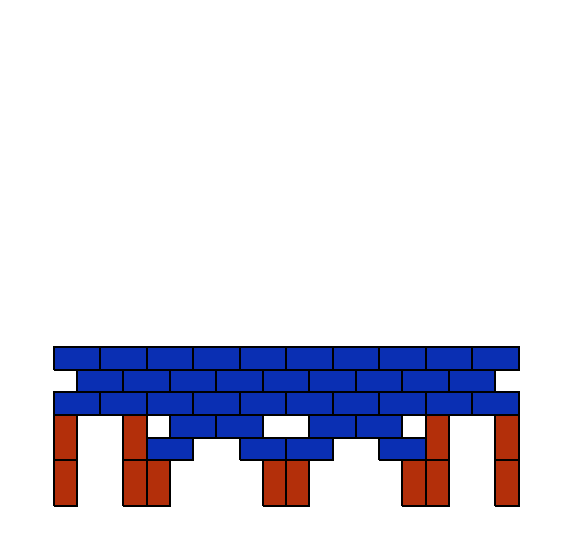

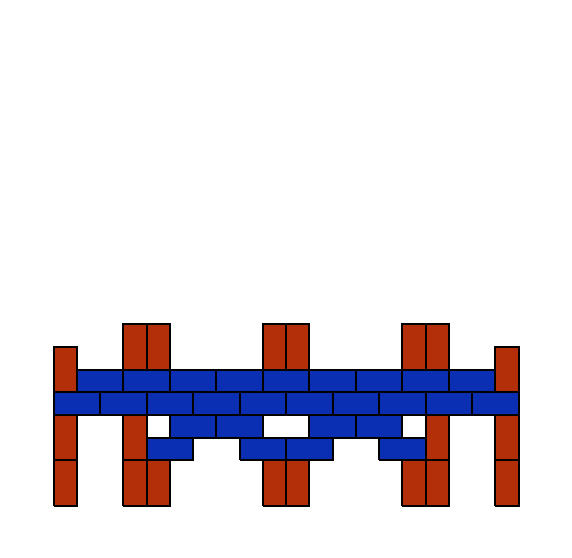

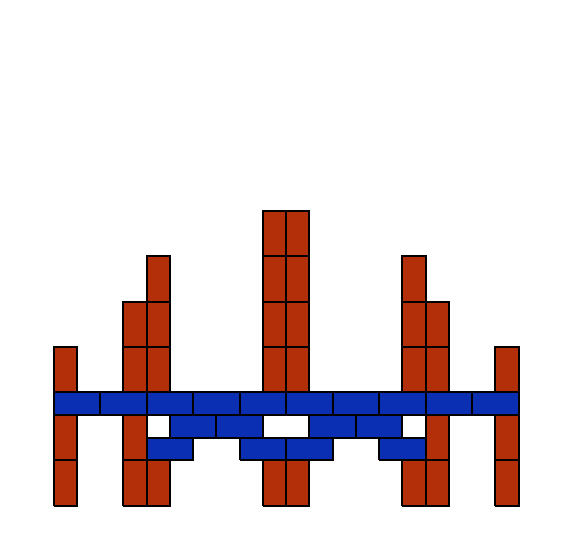

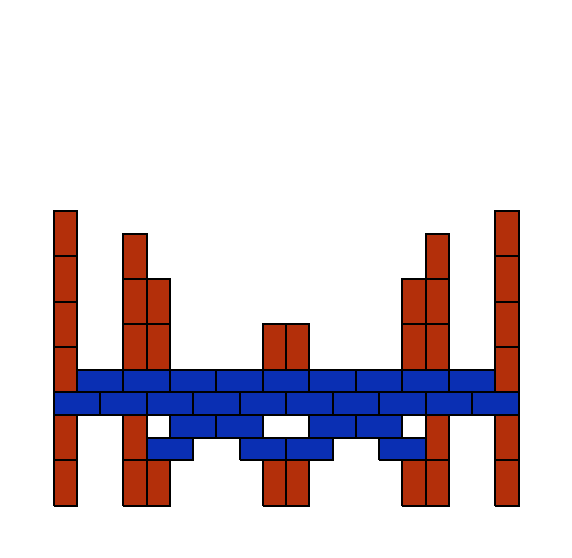

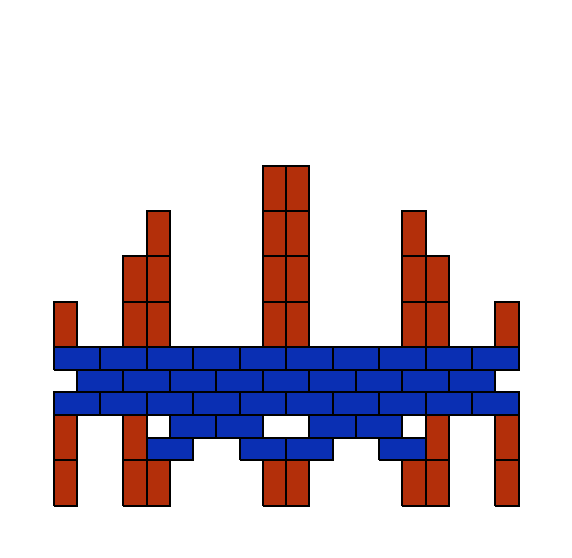

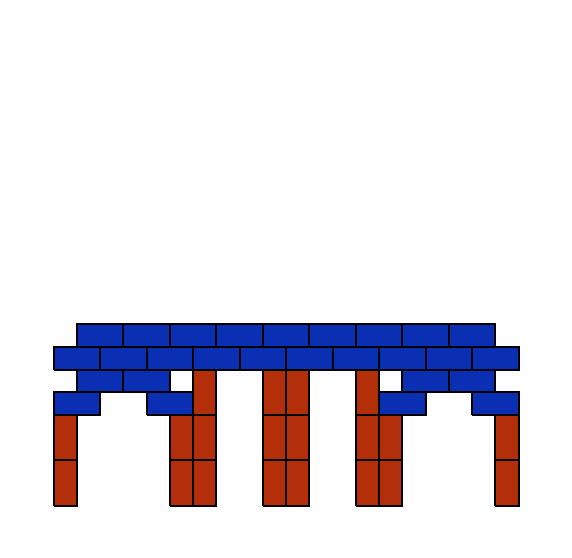

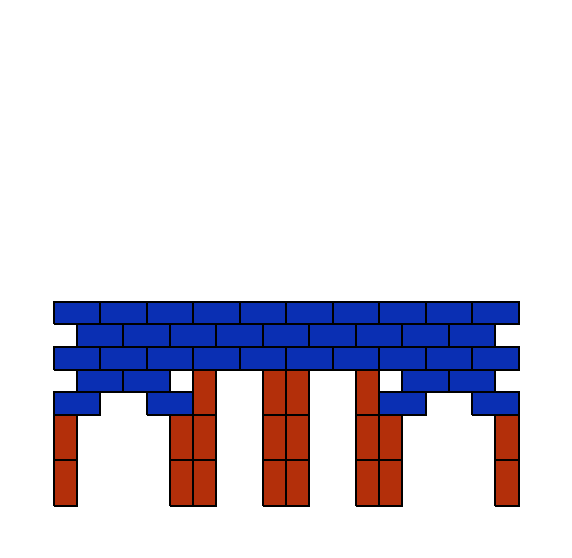

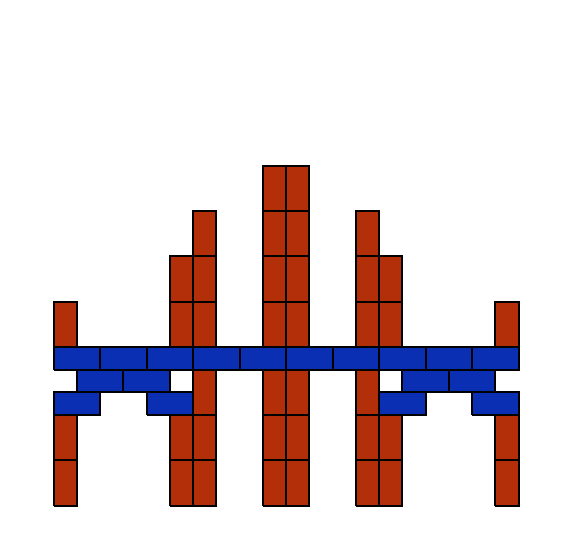

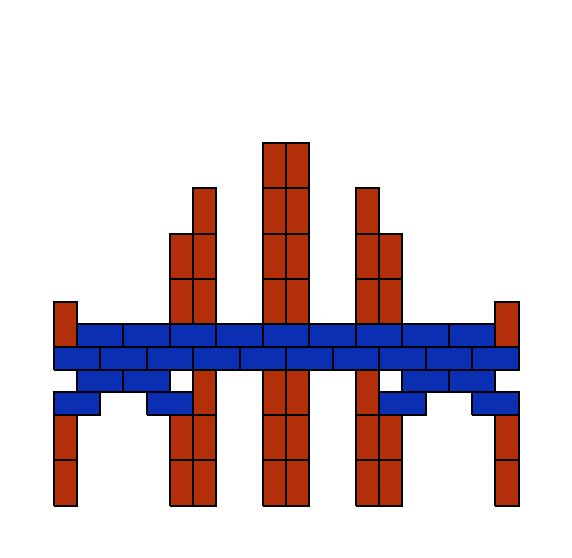

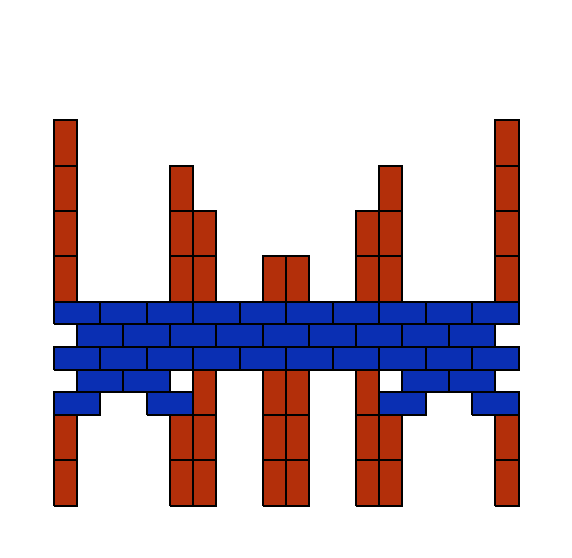

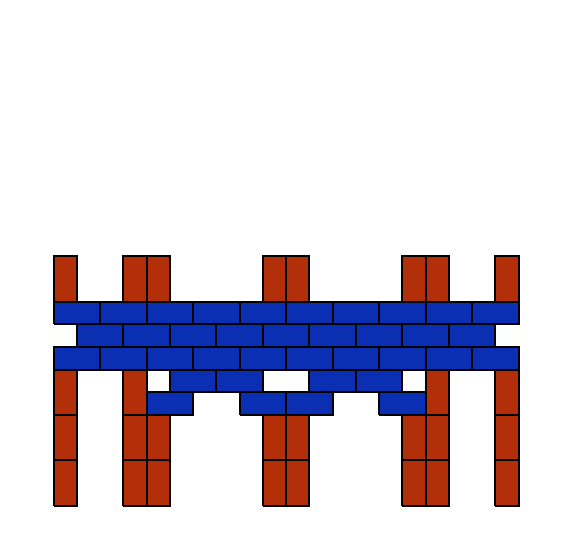

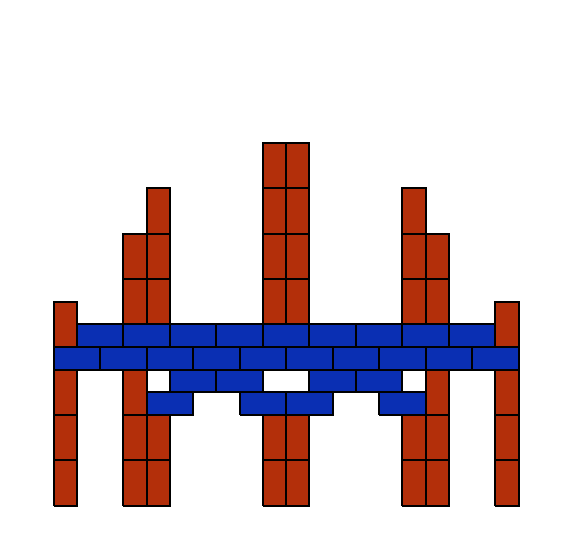

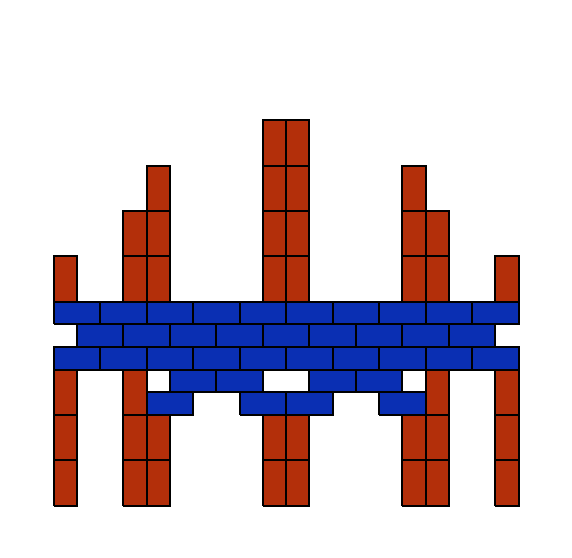

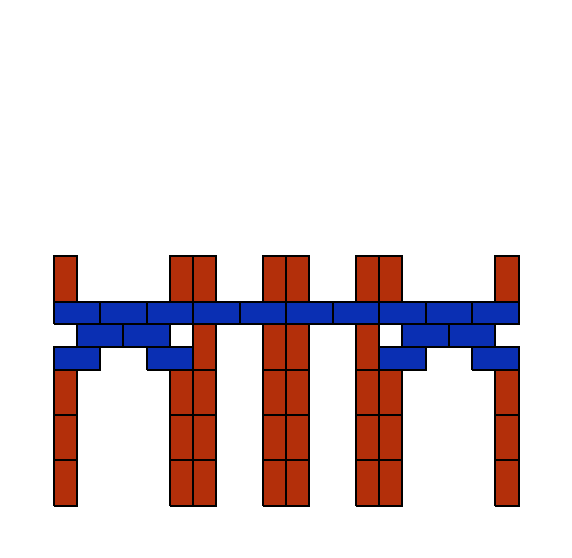

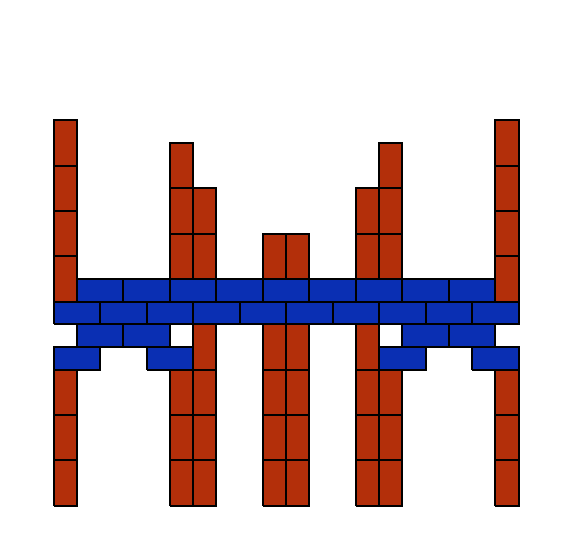

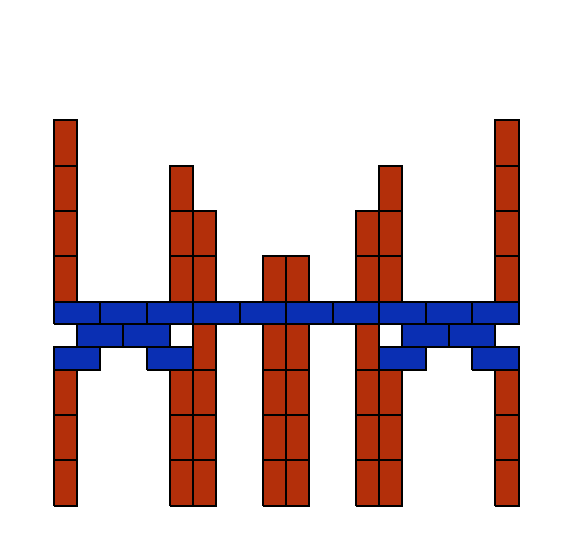

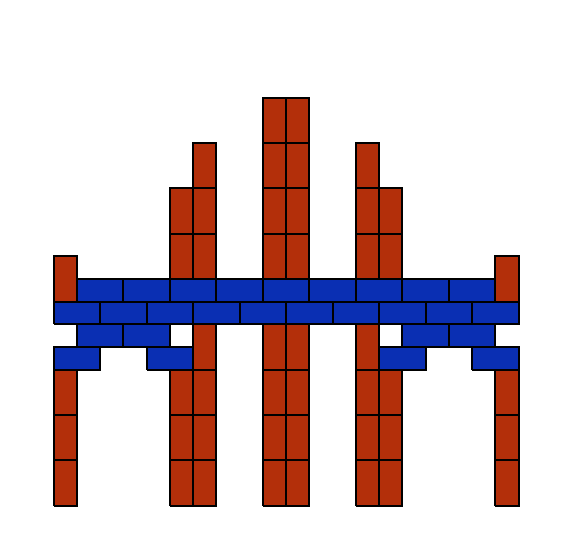

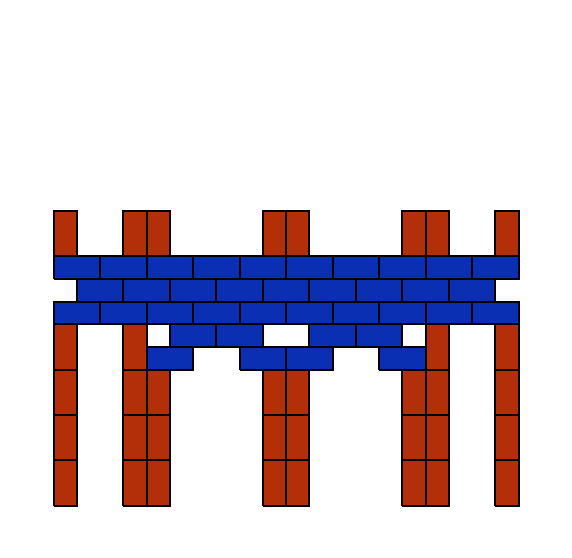

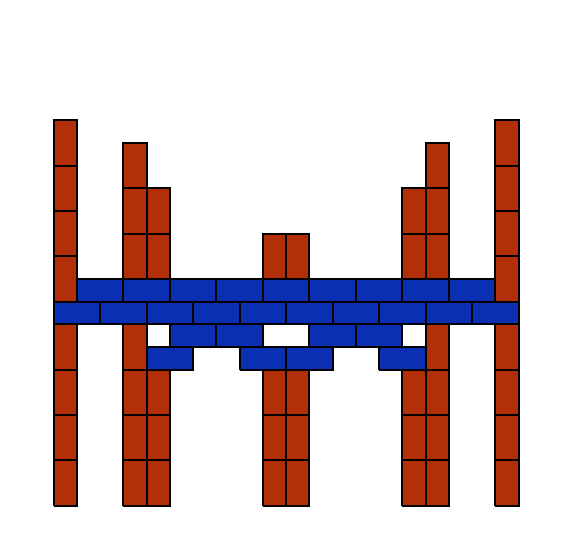

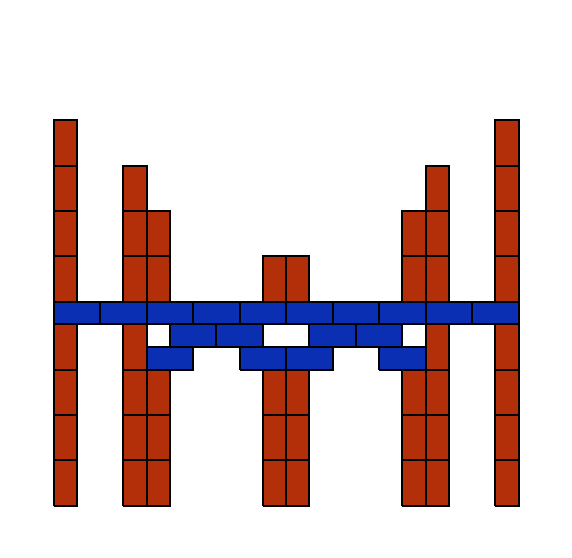

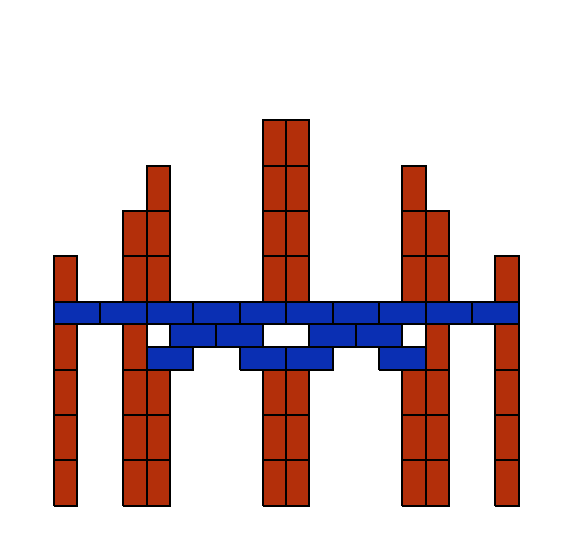

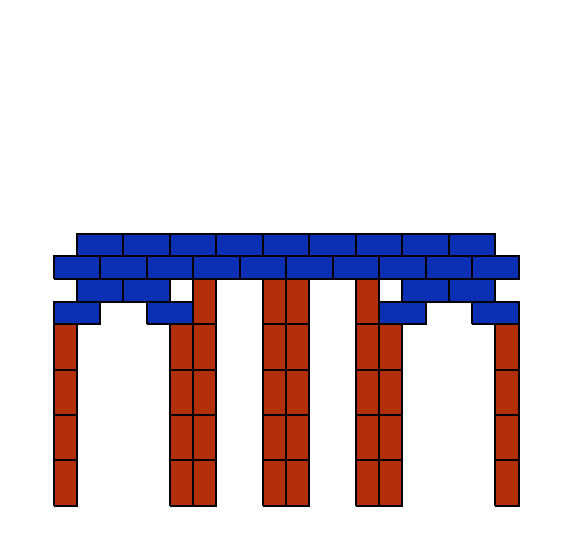

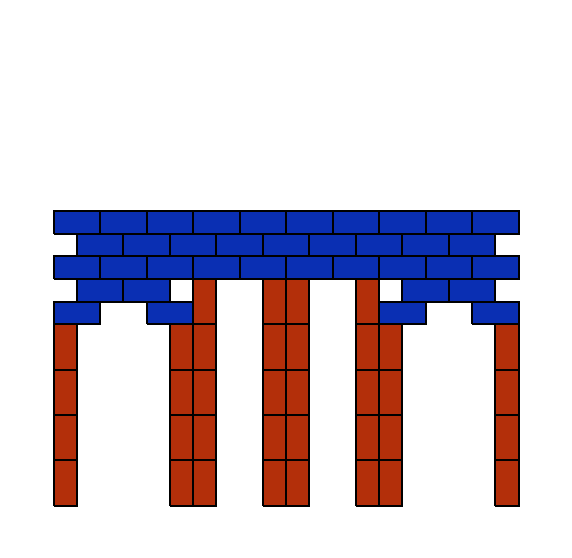

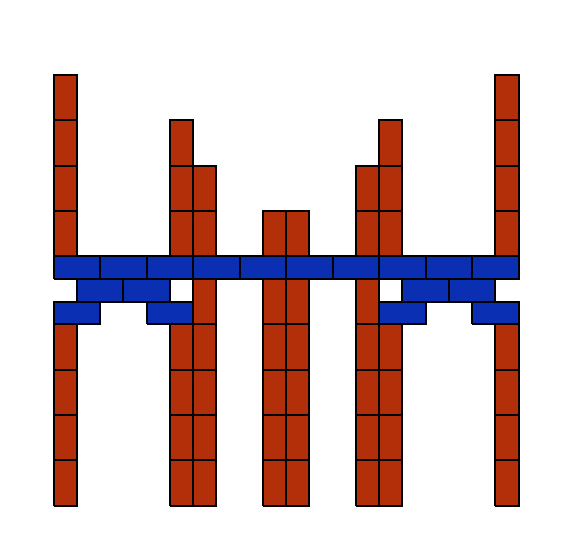

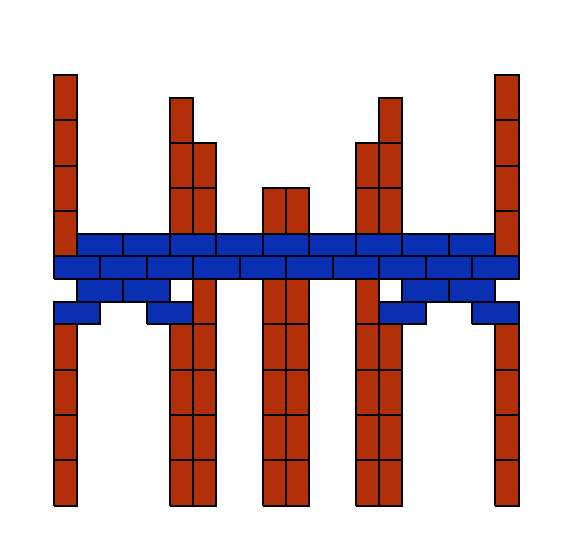

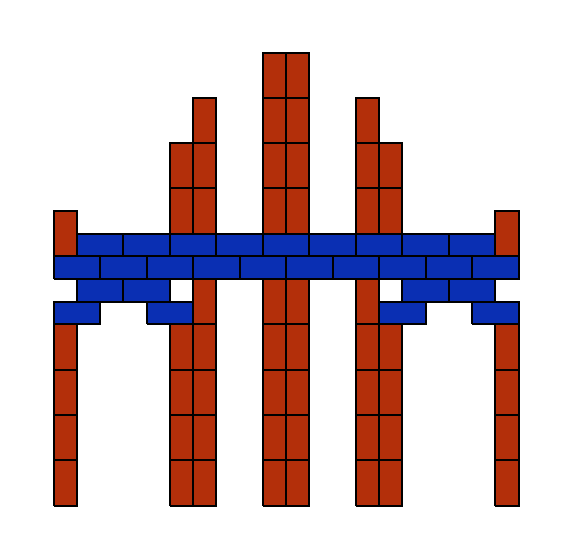

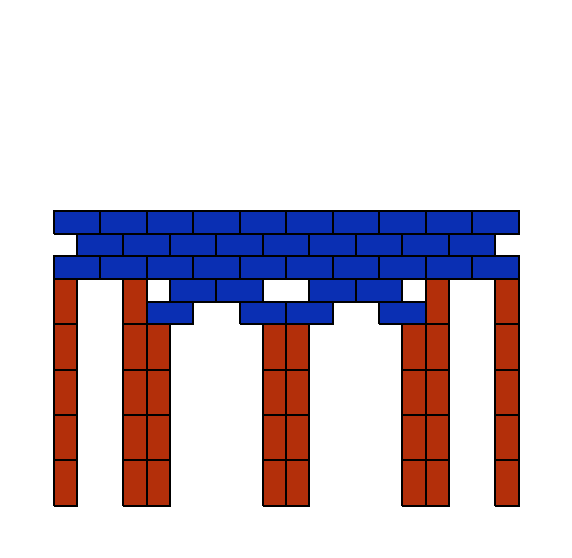

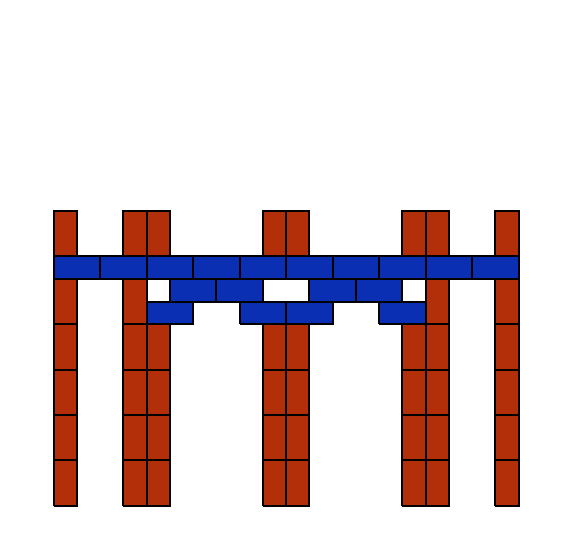

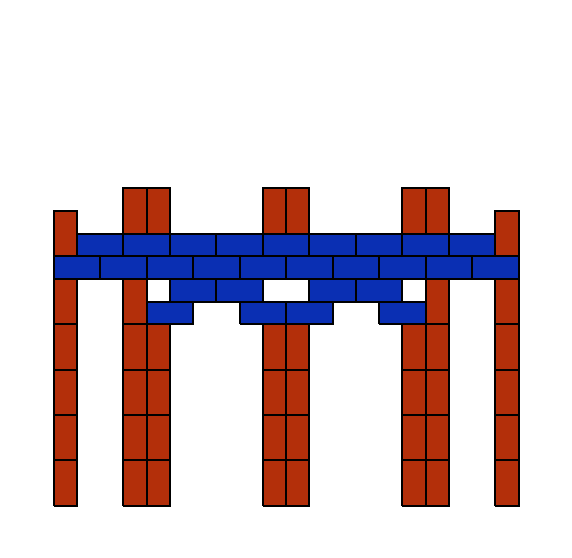

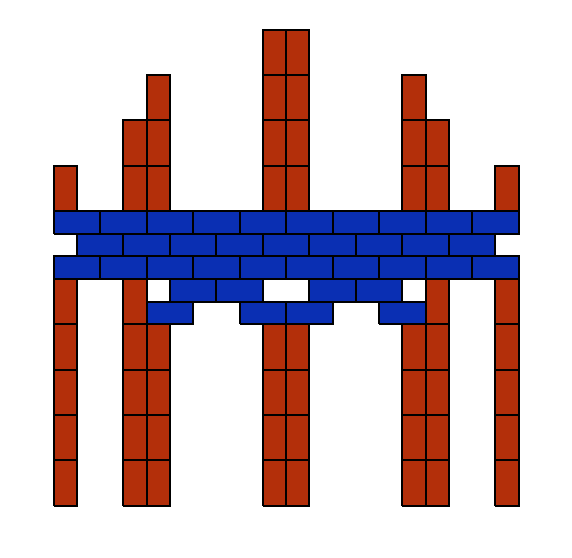

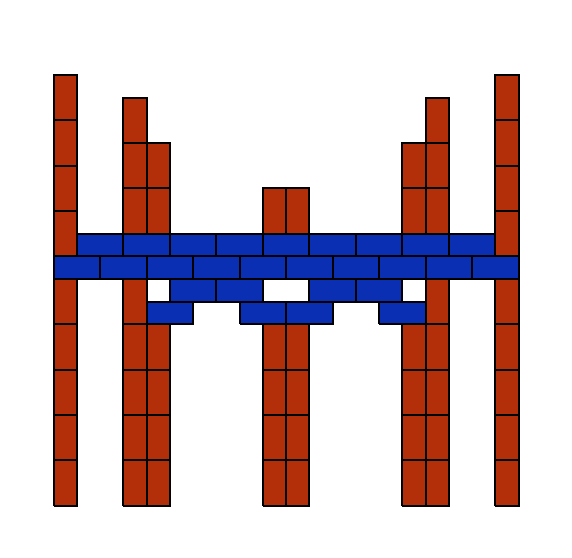

In [573]:
# export to inidividual pngs

for subdomain in subdomains:

    filepath ='./lax-structures-{}-all/'.format(subdomain)

    if not os.path.exists(filepath):
            os.makedirs(filepath)

    for i in df_subsets[subdomain].index:
        w = new_world()
        w.place_tower(df_subsets[subdomain].loc[i,'blocks'])
        fig = utils.draw_world(w)
        fig.savefig("./{}/lax-structures-{}-{}-all.png".format(filepath, 
                                                   df_subsets[subdomain].loc[i,'structure_type'],
                                                   str(df_subsets[subdomain].loc[i,'structure_number']).zfill(3)))
        

    df_subsets[subdomain].to_csv(filepath + 'df_{}.csv'.format(subdomain))

## summarize generation

In [431]:
# concat dataframes
df_structures = pd.concat([df_castles, df_skyscrapers, df_cities, df_bridges, df_houses], ignore_index=True)\
                .reset_index()

index structure_type  \
0          0         castle   
1          1         castle   
2          2         castle   
3          3         castle   
4          4         castle   
...      ...            ...   
72544  72544          house   
72545  72545          house   
72546  72546          house   
72547  72547          house   
72548  72548          house   

                                                  blocks  structure_width  \
0      [{'x': 0, 'y': 0, 'height': 1, 'width': 2}, {'...             12.0   
1      [{'x': 0, 'y': 0, 'height': 1, 'width': 2}, {'...             12.0   
2      [{'x': 1, 'y': 0, 'height': 2, 'width': 1}, {'...             14.0   
3      [{'x': 1, 'y': 0, 'height': 2, 'width': 1}, {'...             14.0   
4      [{'x': 0, 'y': 0, 'height': 2, 'width': 1}, {'...             14.0   
...                                                  ...              ...   
72544  [{'x': 0, 'y': 0, 'height': 1, 'width': 2}, {'...             12.0   
72545  [{'x': 0, 'y': 0, 'height': 1, 'width': 2}, {'...             12.0   
72546  [{'x': 0, 'y': 0, 'height': 1, 'width': 2}, {'...             12.0   
72547  [{'x': 0, 'y': 0, 'height': 1, 'width': 2}, {'...             12.0   
72548  [{'x': 0, 'y': 0, 'height': 1, 'width': 2}, {'...             12.0   

       structure_height  n_blocks  wall_height  wall_size  tower_height  \
0                   6.0      22.0          1.0        2.0           1.0   
1                   7.0      24.0          1.0        2.0           1.0   
2                   6.0      28.0          1.0        2.0           1.0   
3                   7.0      32.0          1.0        2.0           1.0   
4                   6.0      28.0          1.0        2.0           1.0   
...                 ...       ...          ...        ...           ...   
72544              18.0      83.0          NaN        NaN           NaN   
72545              18.0      85.0          NaN        NaN           NaN   
72546              18.0      83.0          NaN        NaN           NaN   
72547              18.0      85.0          NaN        NaN           NaN   
72548              18.0      93.0          NaN        NaN           NaN   

      roof_name  ...  skyscraper_1_height  skyscraper_2_height  \
0       pyramid  ...                  NaN                  NaN   
1          dome  ...                  NaN                  NaN   
2       pyramid  ...                  NaN                  NaN   
3          dome  ...                  NaN                  NaN   
4       pyramid  ...                  NaN                  NaN   
...         ...  ...                  ...                  ...   
72544  pyramids  ...                  NaN                  NaN   
72545  pyramids  ...                  NaN                  NaN   
72546  pyramids  ...                  NaN                  NaN   
72547  pyramids  ...                  NaN                  NaN   
72548  pyramids  ...                  NaN                  NaN   

      bridge_elevation  n_inner_arch pillar_type inner_width outer_width  \
0                  NaN           NaN         NaN         NaN         NaN   
1                  NaN           NaN         NaN         NaN         NaN   
2                  NaN           NaN         NaN         NaN         NaN   
3                  NaN           NaN         NaN         NaN         NaN   
4                  NaN           NaN         NaN         NaN         NaN   
...                ...           ...         ...         ...         ...   
72544              NaN           NaN         NaN         NaN         NaN   
72545              NaN           NaN         NaN         NaN         NaN   
72546              NaN           NaN         NaN         NaN         NaN   
72547              NaN           NaN         NaN         NaN         NaN   
72548              NaN           NaN         NaN         NaN         NaN   

      includes_outer_arches  house_width n_stories  
0                       NaN          NaN       Na

### create dreamcoder program for each tower

In [432]:
df_structures['dreamcoder_program'] = df_structures['blocks'].apply(lambda x: convert(x, whole_squares=False))
df_structures['program_whole_squares'] = \
            df_structures['blocks'].apply(lambda x: convert(x, whole_squares=True))

### sample

Enumeration scripts above perform some sampling by rejecting structures according to `generation_probability`.

Here we shuffle, then select the first 250 structures.

In [474]:
random_seed = RANDOM_SEED

df_structures_subset = df_structures.groupby('structure_type').sample(frac=1, random_state=RANDOM_SEED)\
                                    .groupby('structure_type').head(250).reset_index()

df_structures_subset['structure_number'] = df_structures_subset.groupby(['structure_type']).cumcount();

df_structures_subset = df_structures_subset[df_structures_subset.structure_type!='skyscraper'].reset_index()

In [475]:
# order structures

structure_order = {}

structure_order['bridge'] = list(df_structures_subset[df_structures_subset.structure_type == 'bridge']\
    .sort_values(['includes_outer_arches', 'n_inner_arch', 'bridge_elevation', 'inner_width', 'structure_height']).sample_index)

structure_order['house'] = list(df_structures_subset[df_structures_subset.structure_type == 'house']\
    .sort_values(['n_stories','house_width']).sample_index)

structure_order['castle'] = list(df_structures_subset[df_structures_subset.structure_type == 'castle']\
    .sort_values(['wall_height','wall_size','tower_height','roof_name']).sample_index)

structure_order['city'] = list(df_structures_subset[df_structures_subset.structure_type == 'city']\
    .sort_values(['skyscraper_1_height', 'skyscraper_2_height', 'structure_height','gap']).sample_index)


In [477]:
df_structures_subset.groupby('structure_type')

In [434]:
N_TRAIN = 200
N_TEST = 50

# for g, group in enumerate(df_structures_subset['structure_type'].unique()):
#     df_structures_subset.loc[g*(N_TRAIN+N_TEST):g*(N_TRAIN+N_TEST)+N_TRAIN,'test_train'] = 'train'
#     df_structures_subset.loc[g*(N_TRAIN+N_TEST)+N_TRAIN:g*(N_TRAIN+N_TEST)+N_TRAIN+N_TRAIN,'test_train'] = 'test'

df_structures_subset['train'] = df_structures_subset['structure_number'] < N_TRAIN

In [435]:
df_structures_subset.groupby('structure_type')['train'].value_counts()

structure_type  train
bridge          True     200
                False     50
castle          True     200
                False     50
city            True     200
                False     50
house           True     200
                False     50
Name: train, dtype: int64

In [436]:
df_structures_subset.groupby('structure_type')['n_blocks'].describe()[['min','max']]

min    max
structure_type             
bridge           7.0  109.0
castle          24.0  149.0
city            14.0  132.0
house            7.0   93.0

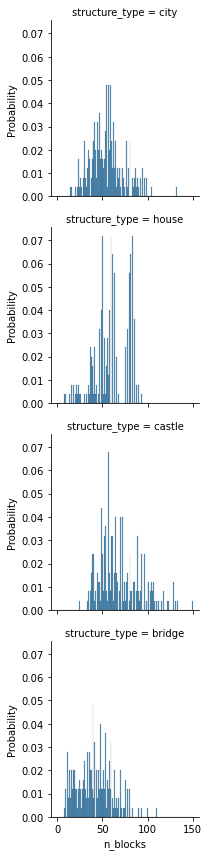

In [437]:
g = sns.FacetGrid(df_structures_subset, row="structure_type", row_order=['city','house','castle','bridge'])
g.map_dataframe(sns.histplot, x="n_blocks", binrange=(0,150), bins=150, stat='probability')

### export all structures

In [438]:
#all structures
df_structures_subset.to_csv('df_structures_subset.csv')

### export sample for upload to S3

In [439]:
# export to inidividual jsons

filepath ='./iclr-structures-json/'

if not os.path.exists(filepath):
        os.makedirs(filepath)

for i in df_structures_subset.index:
    df_structures_subset.loc[i].to_json("./{}/{}_{}_{}.json".format(filepath, 
                                               df_structures_subset.loc[i,'structure_type'],
                                               str(df_structures_subset.loc[i,'structure_number']).zfill(3),
                                               'train' if df_structures_subset.loc[i,'train'] else 'test'))
    
df_structures_subset.to_csv(filepath + 'df_structures_subset.csv')

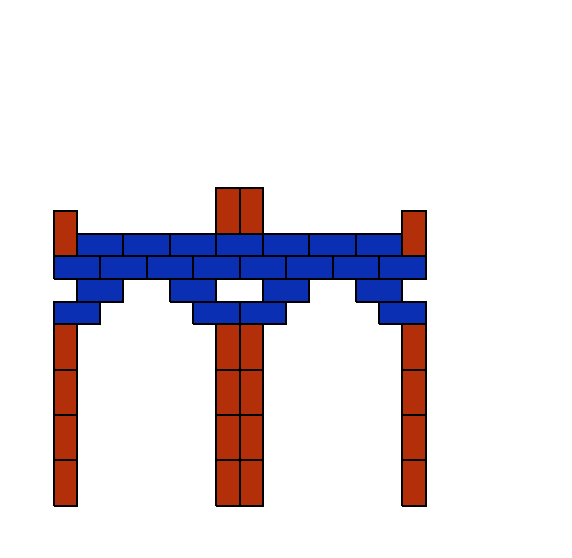

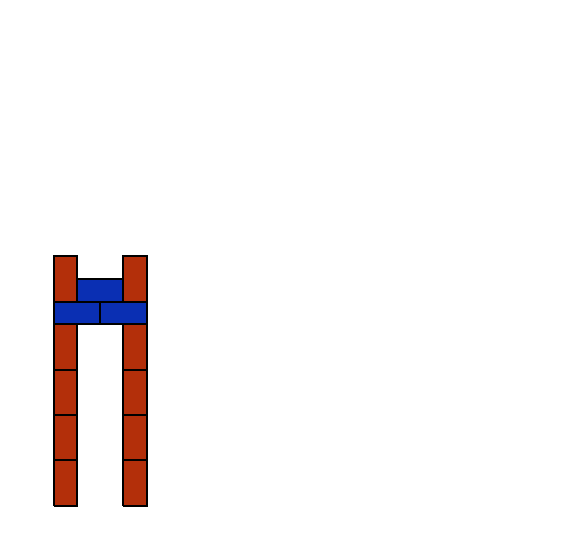

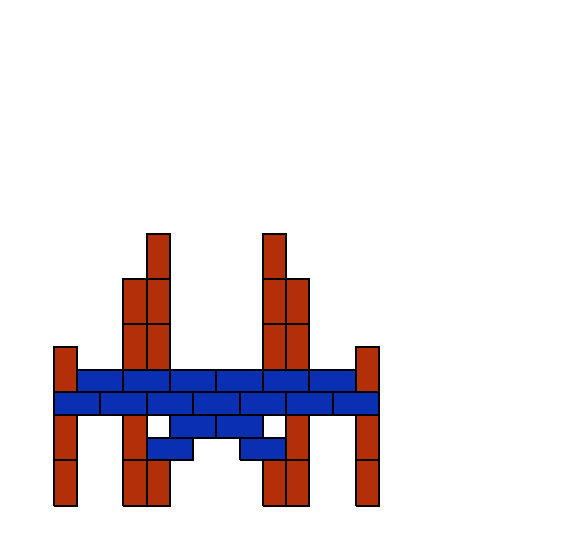

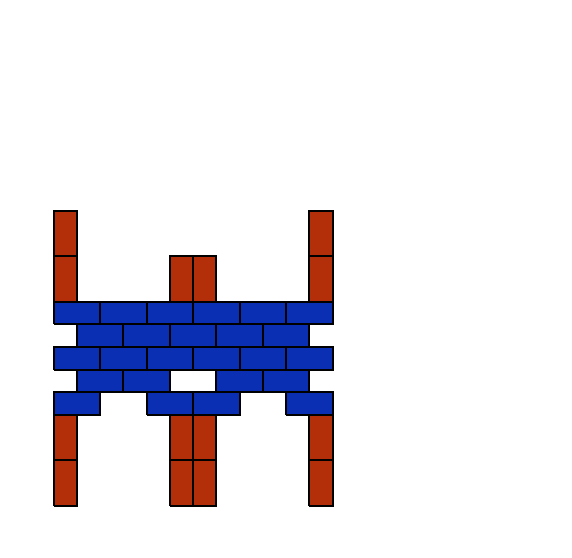

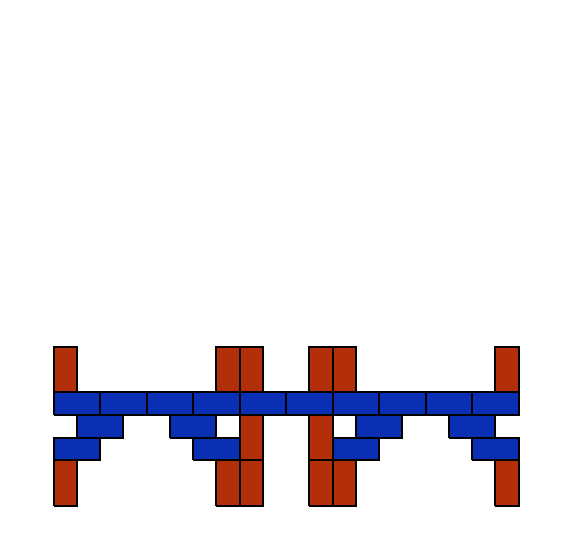

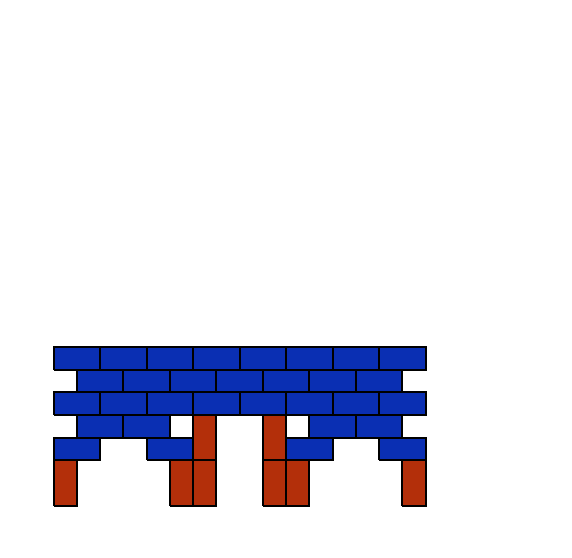

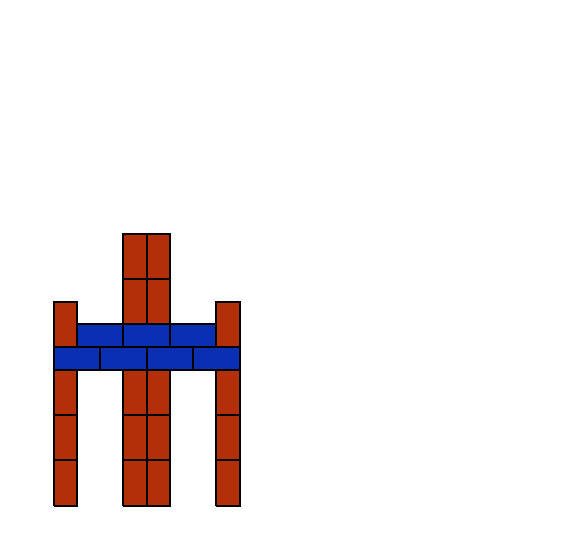

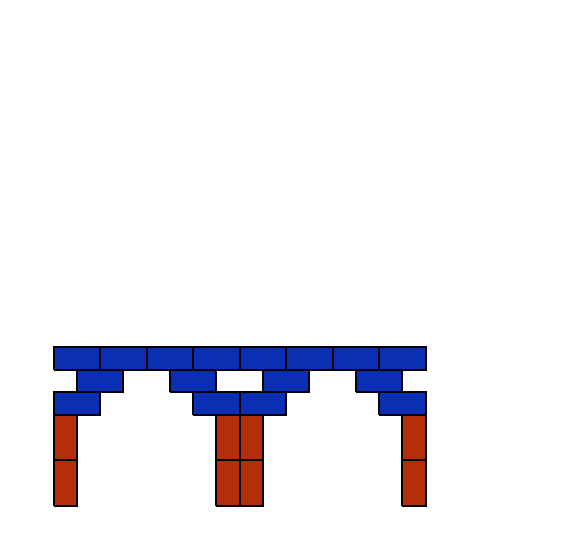

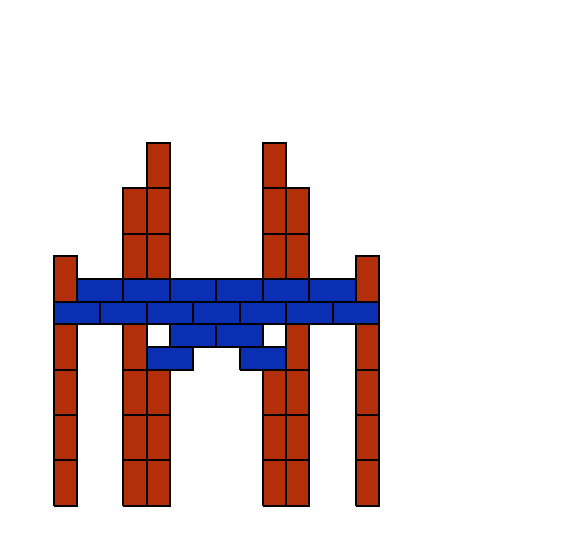

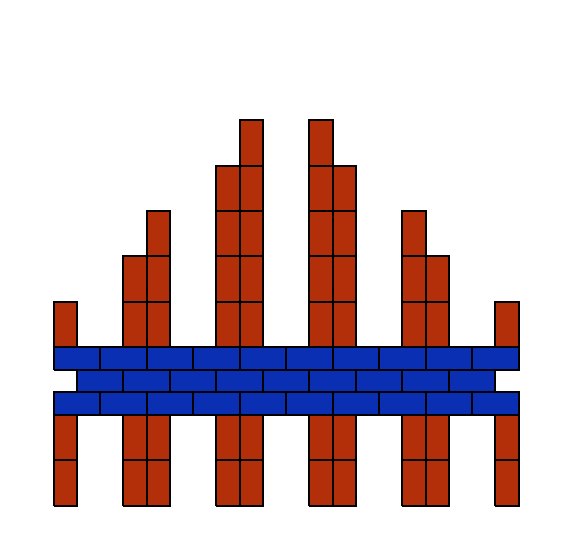

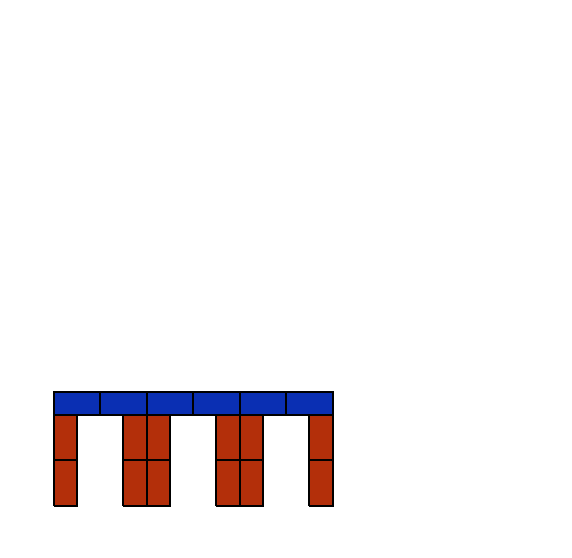

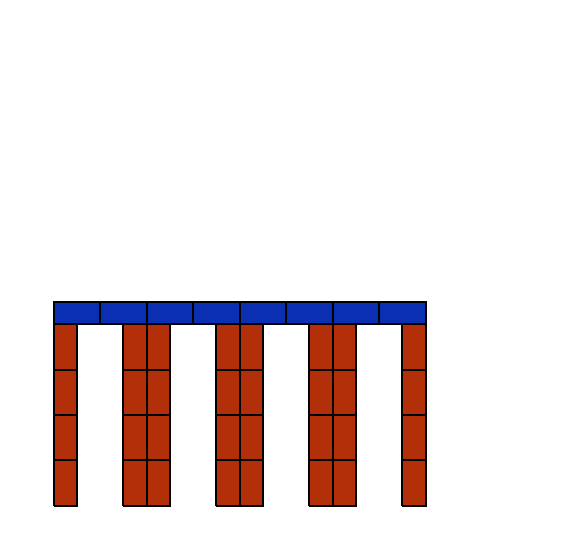

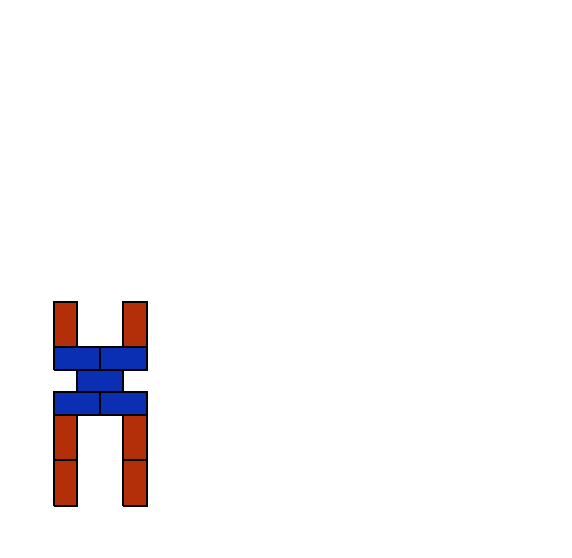

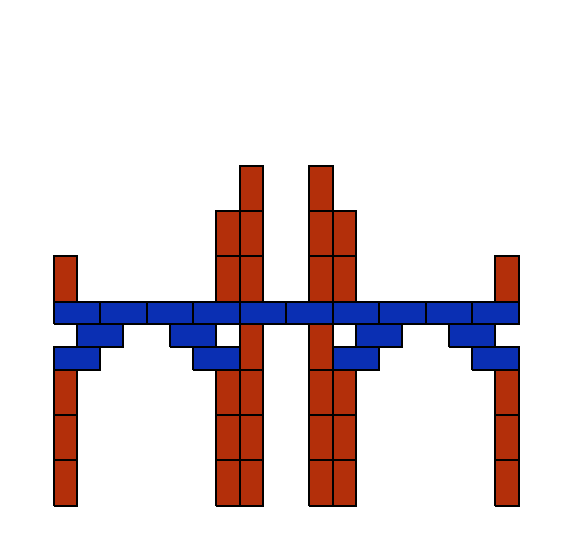

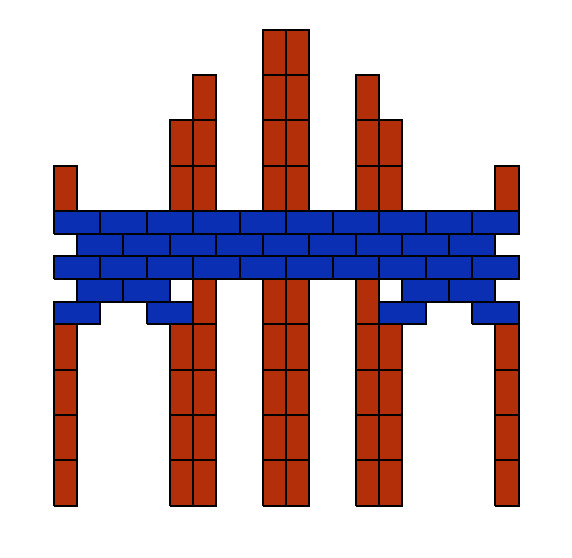

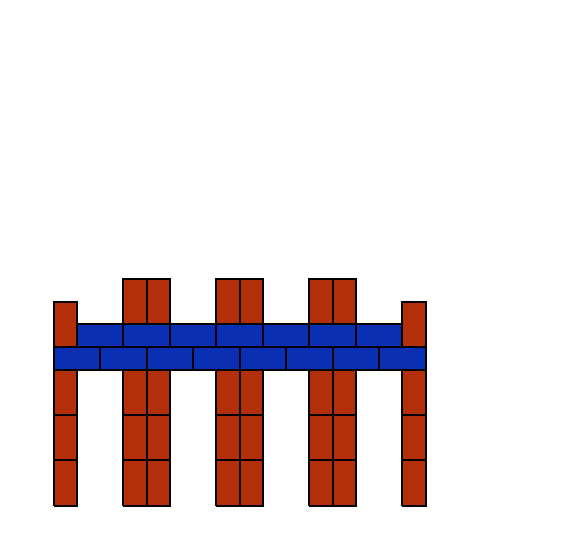

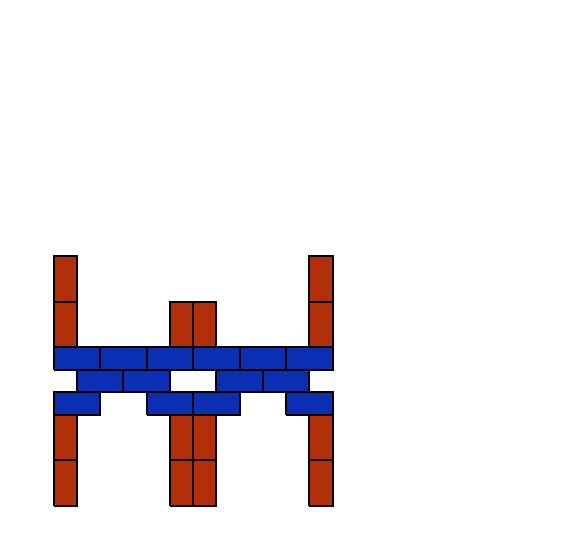

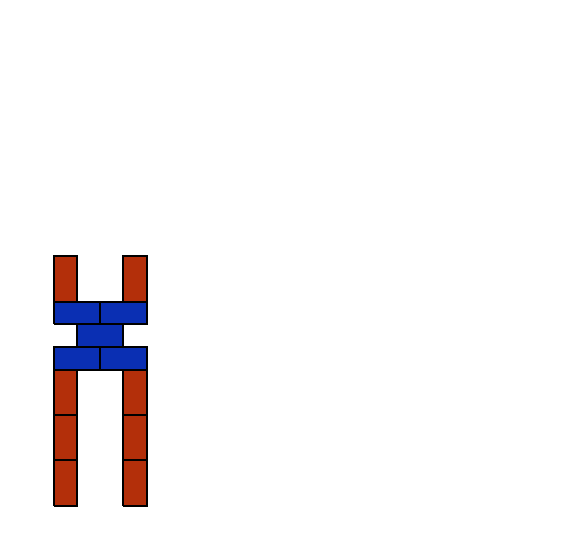

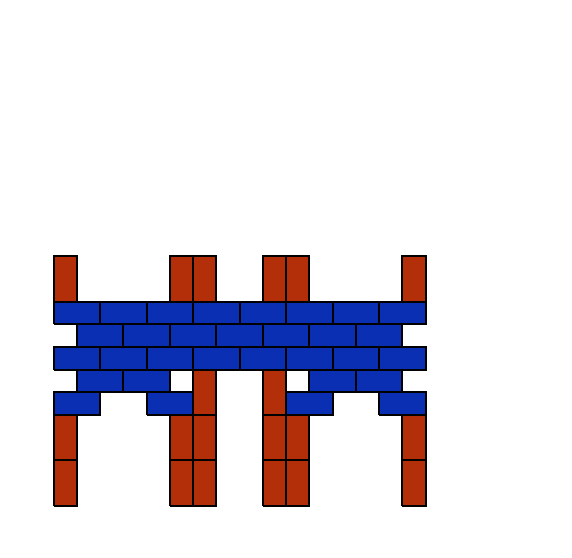

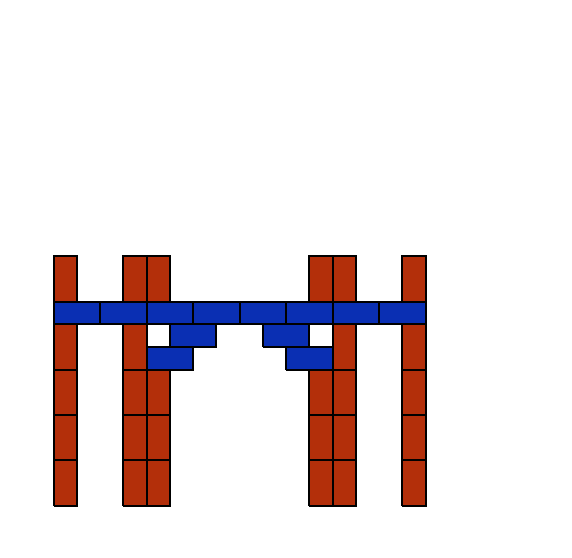

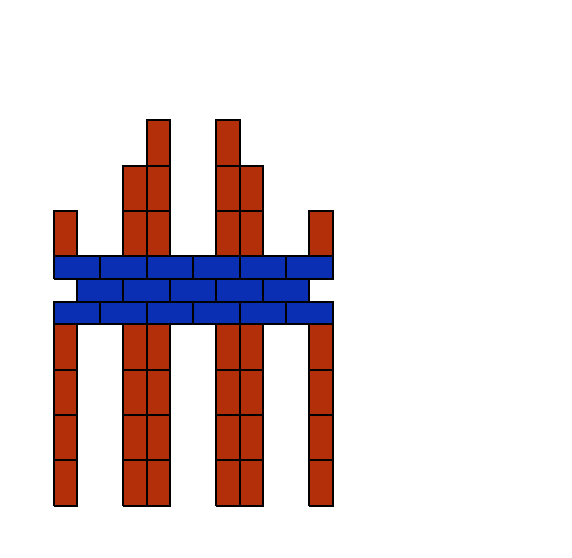

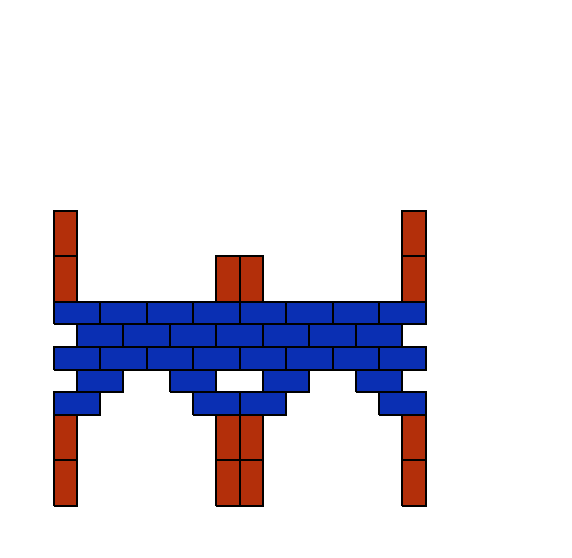

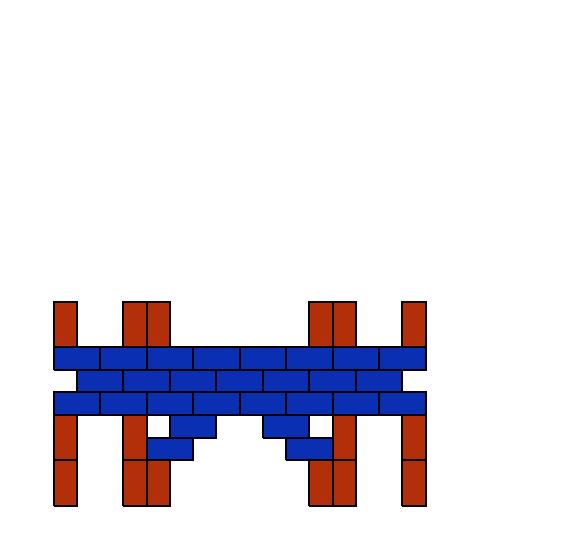

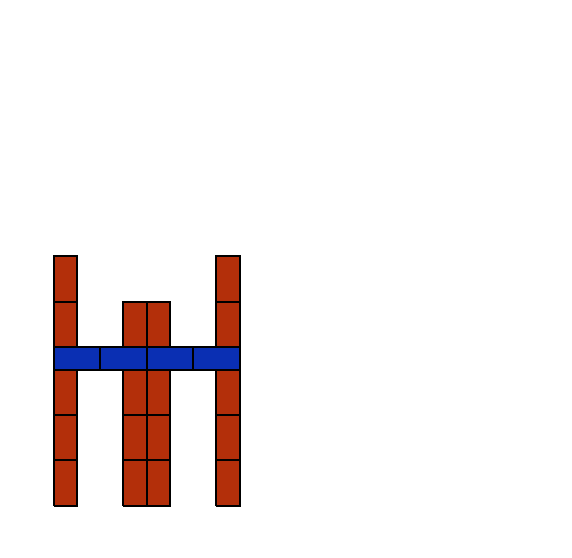

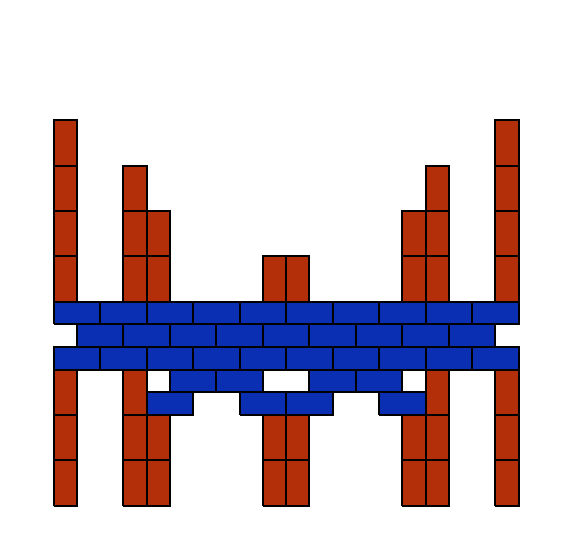

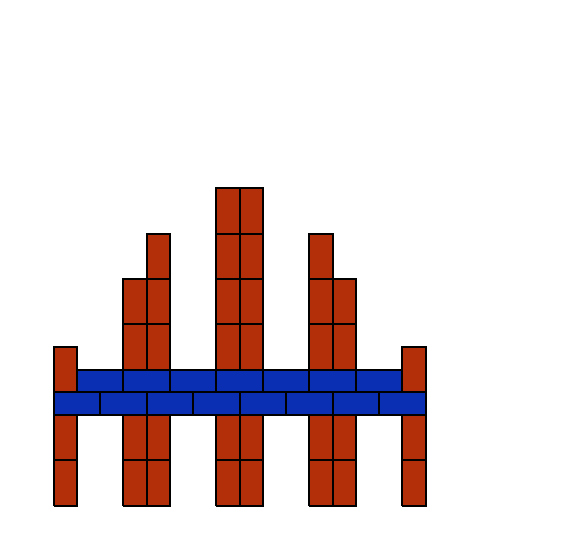

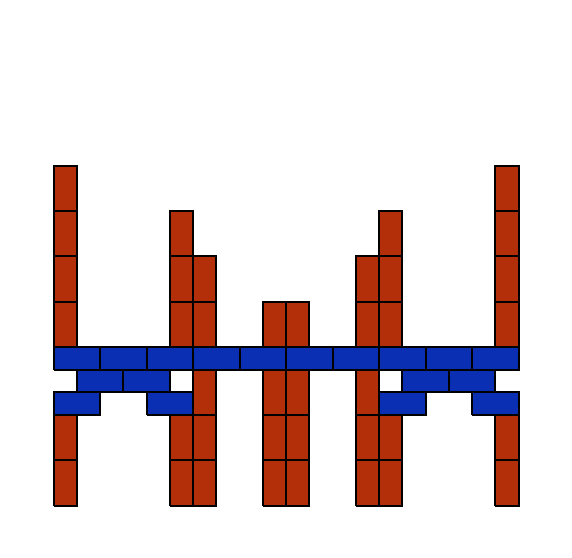

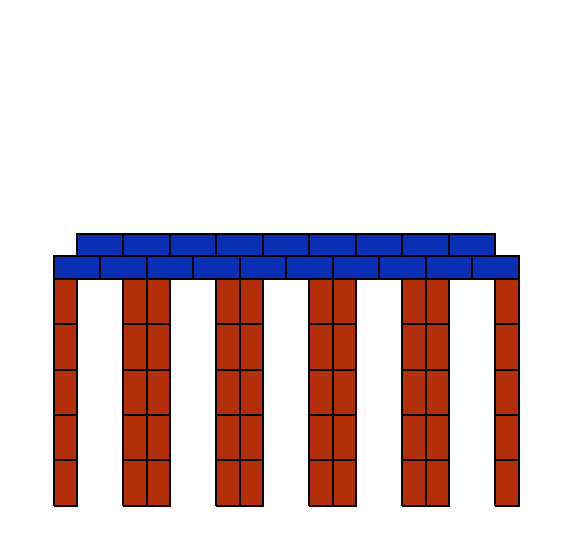

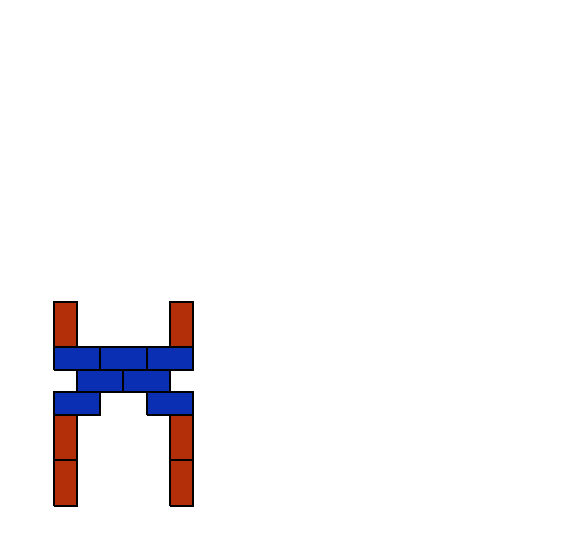

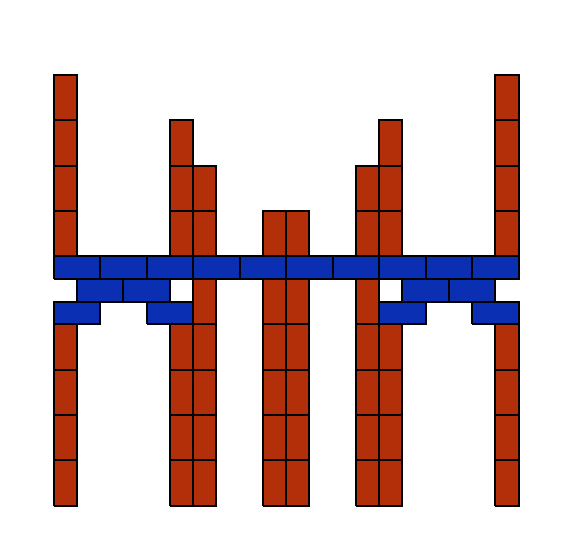

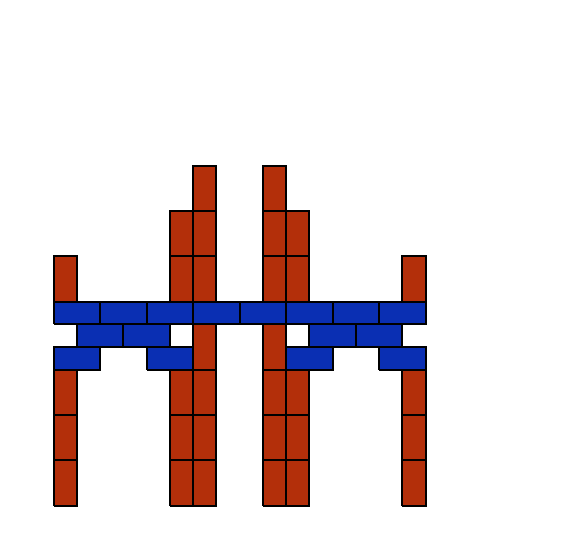

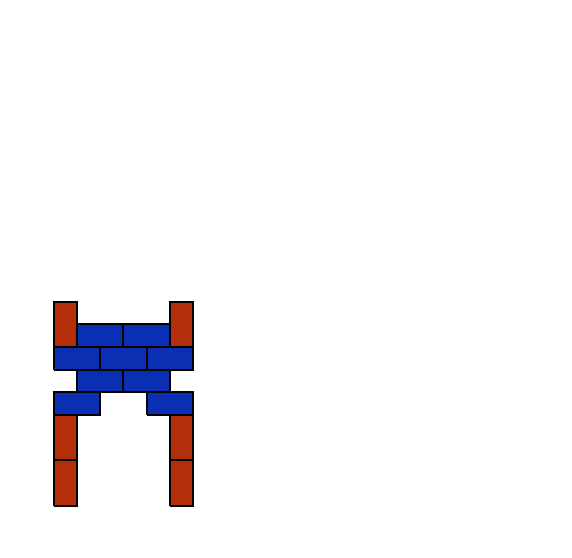

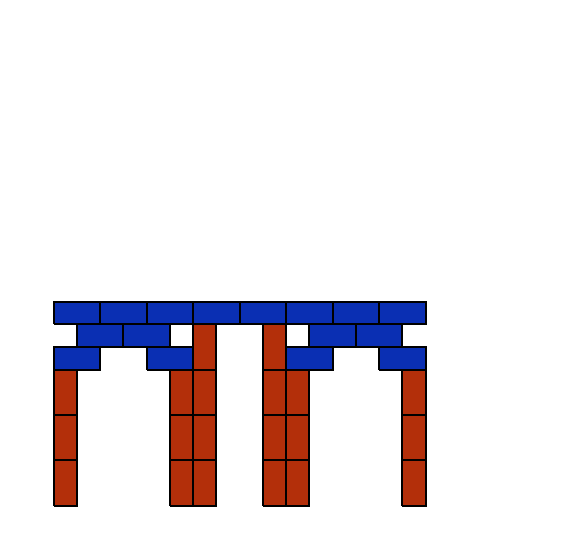

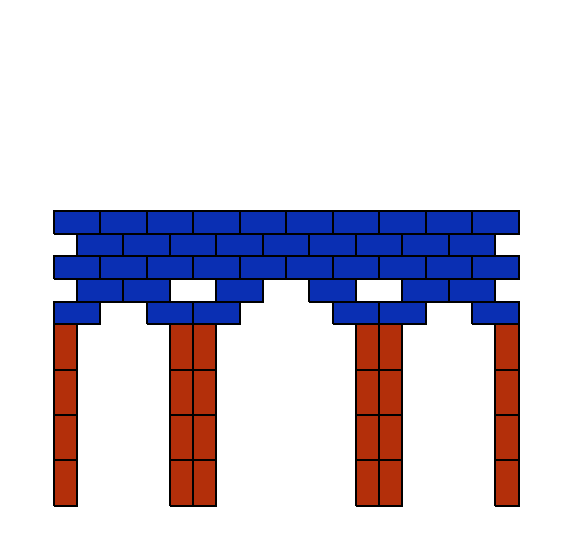

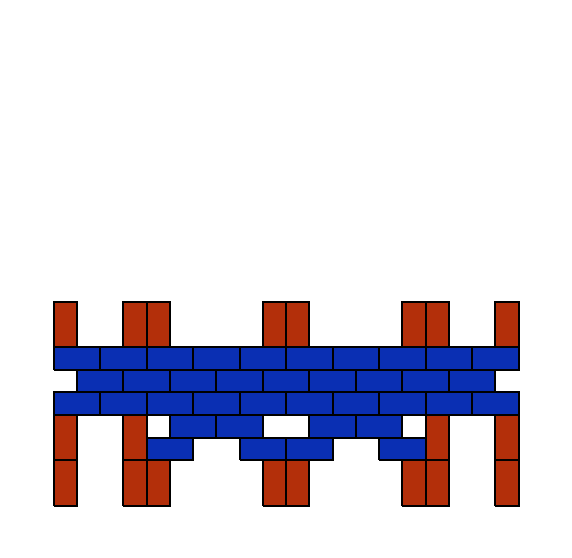

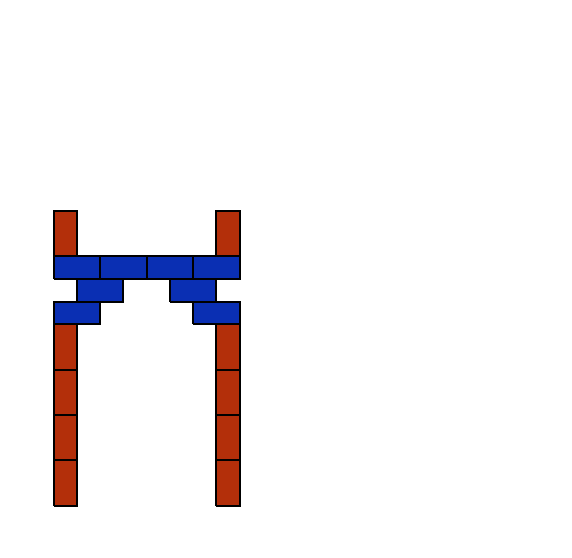

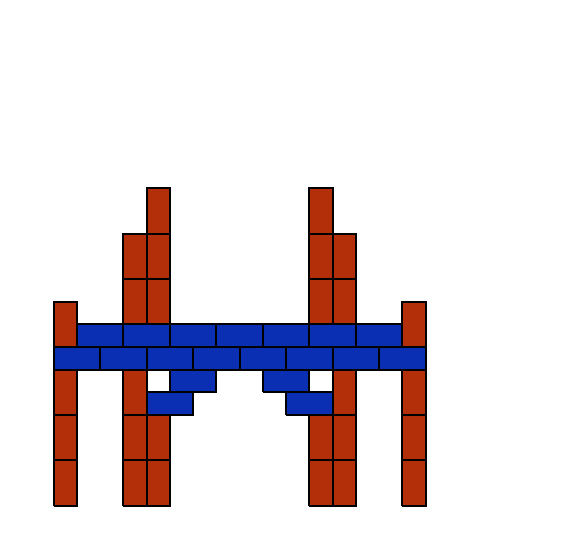

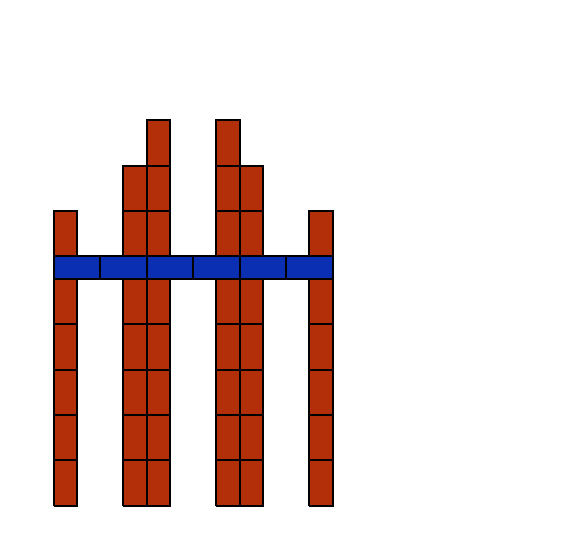

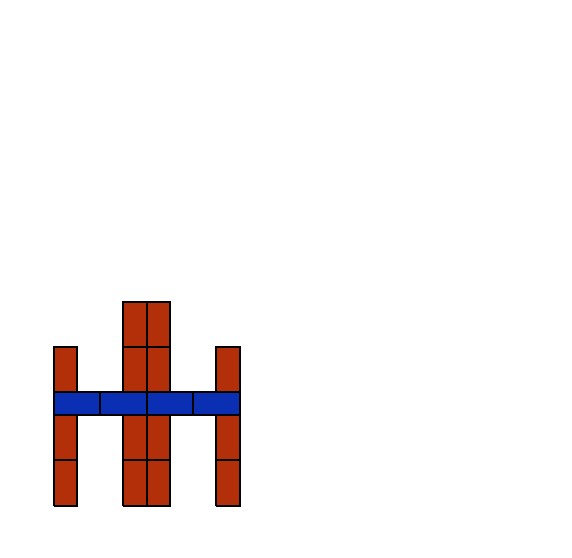

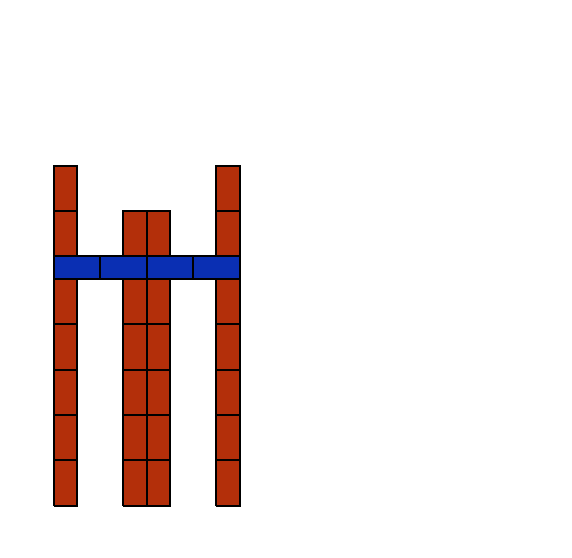

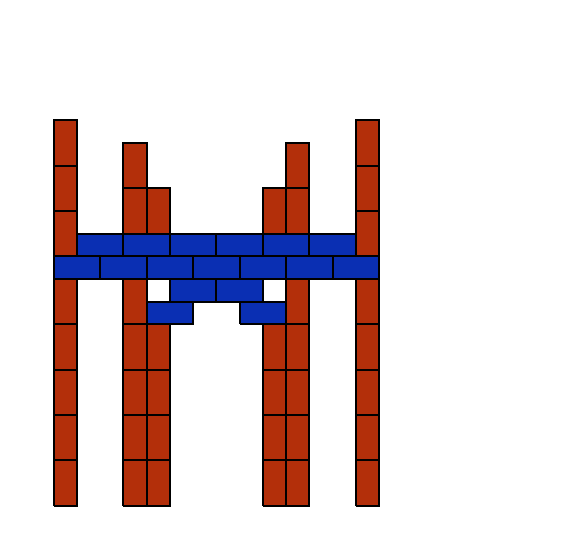

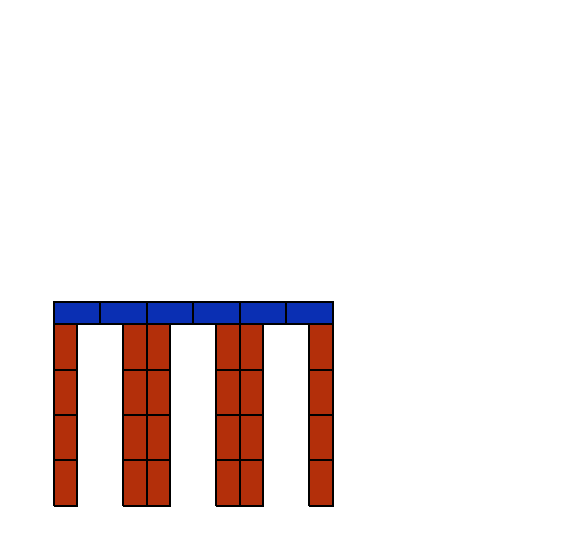

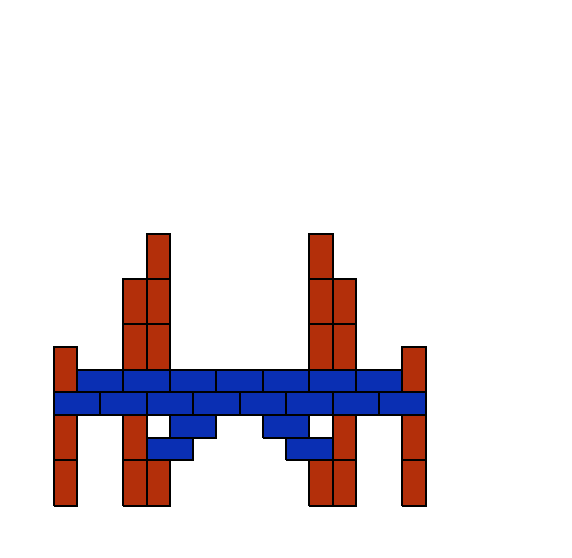

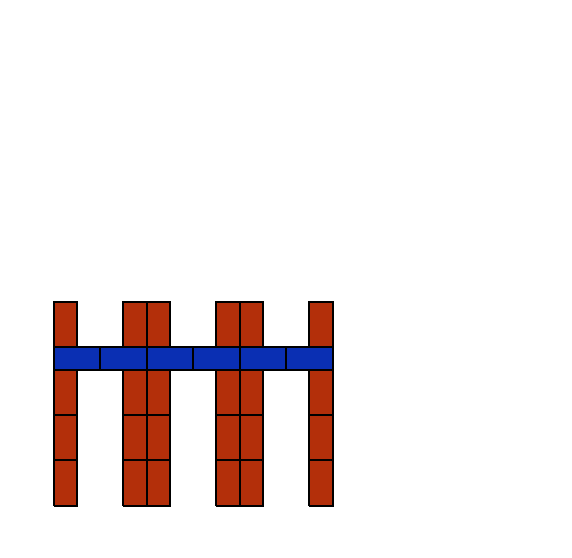

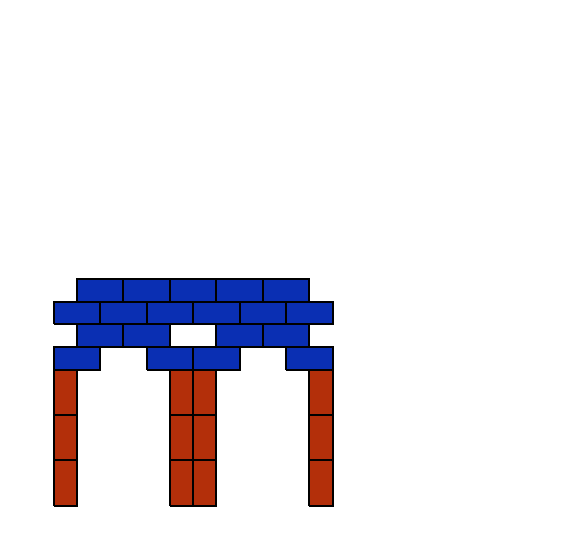

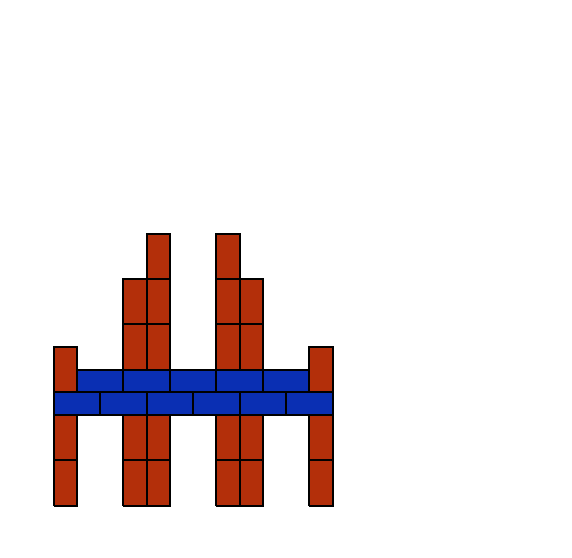

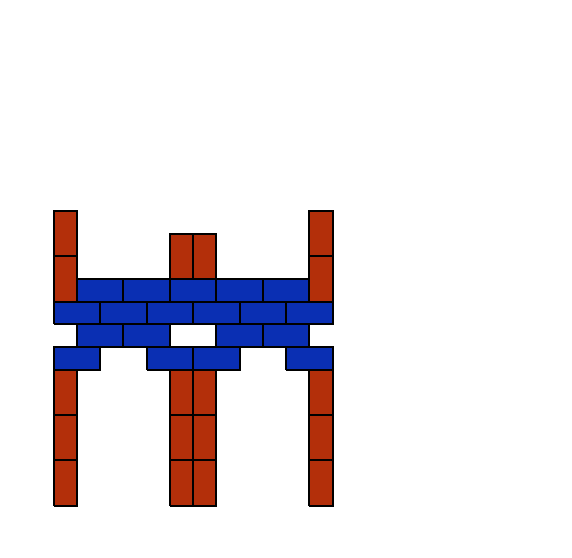

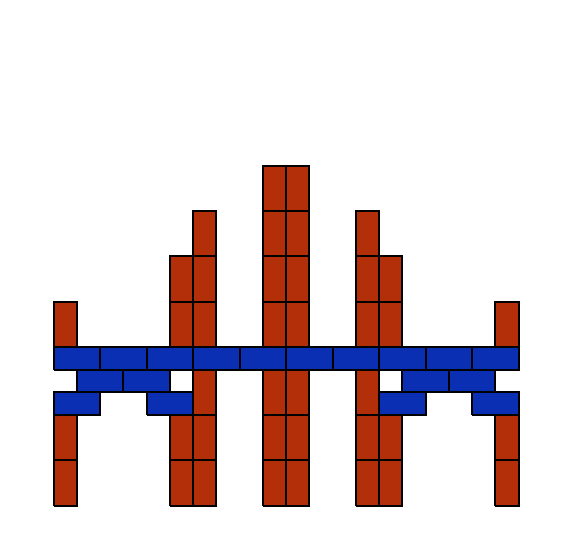

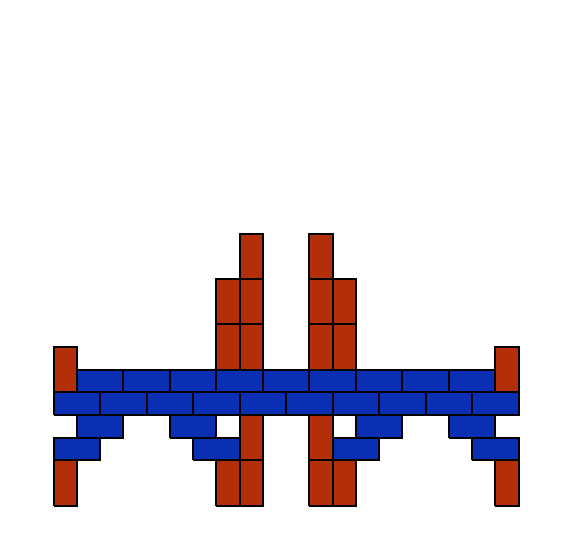

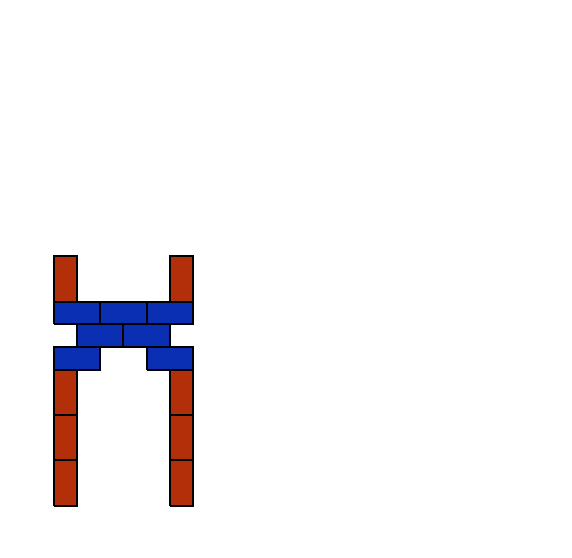

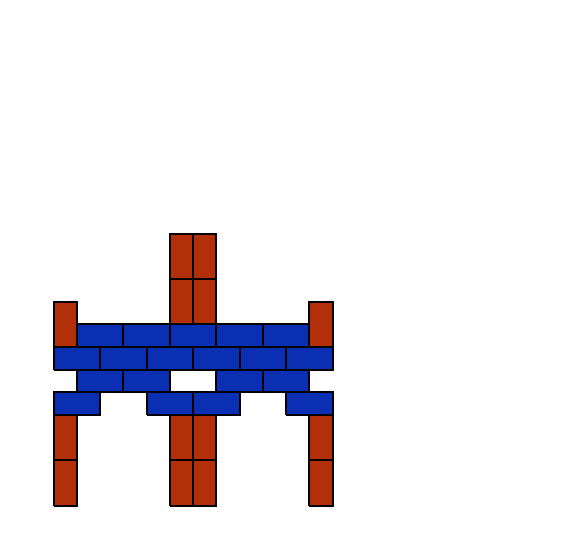

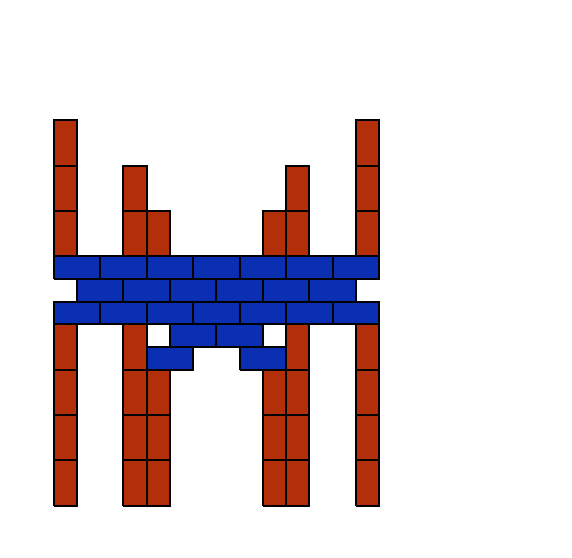

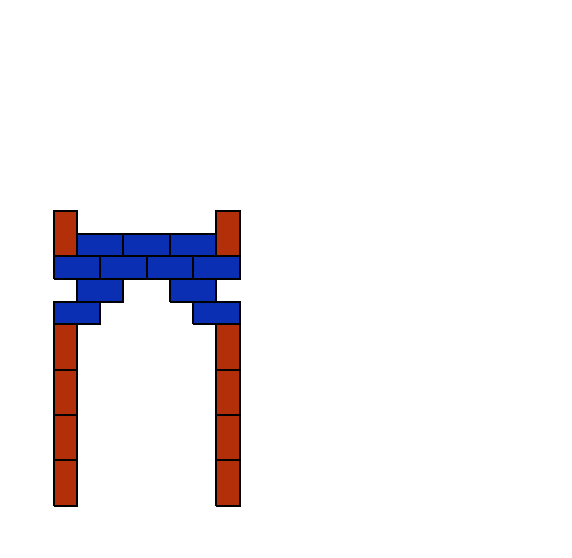

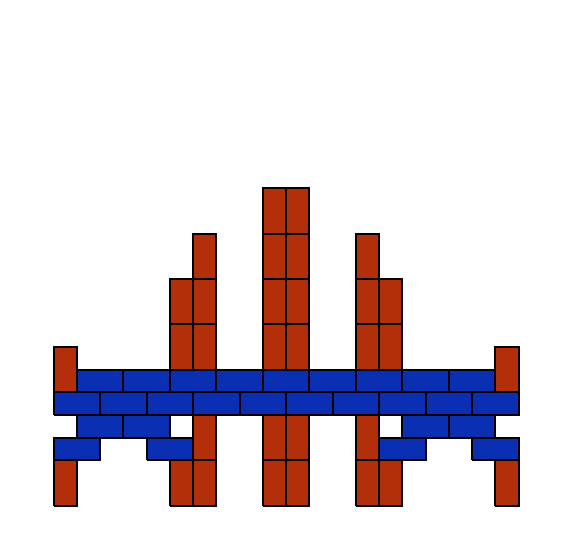

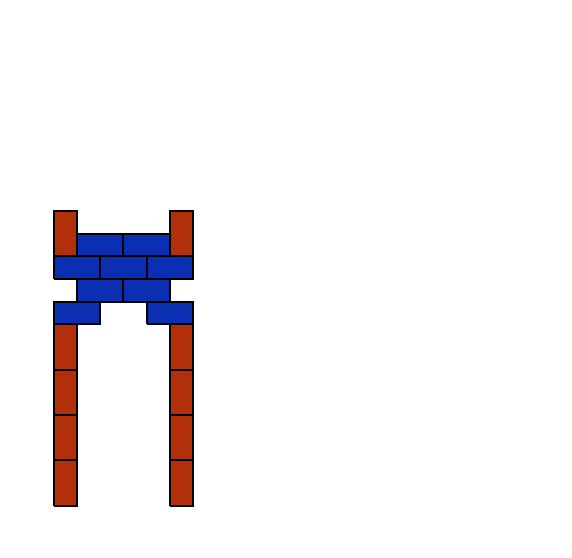

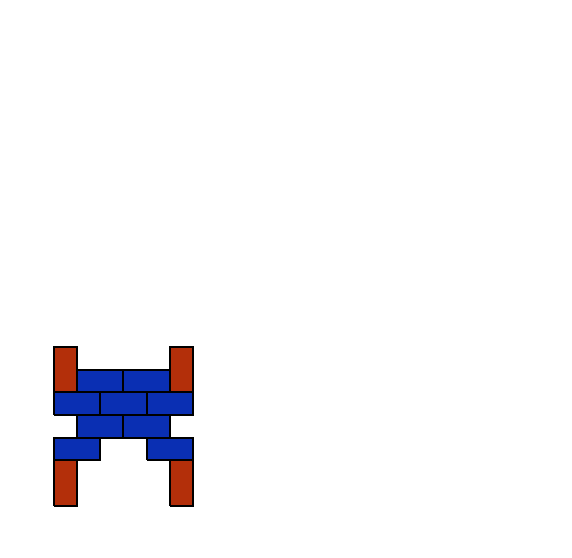

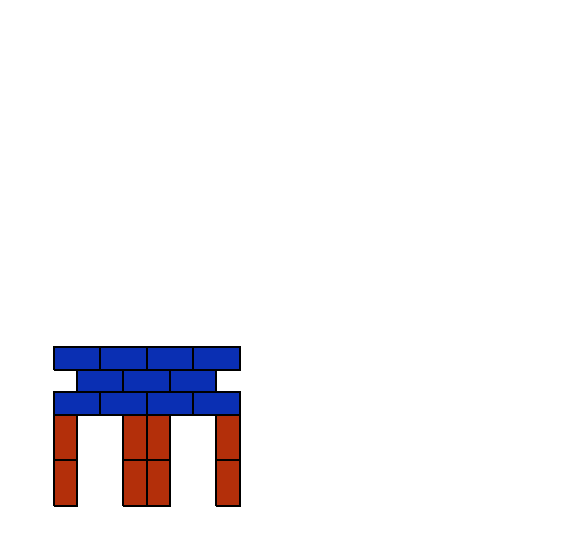

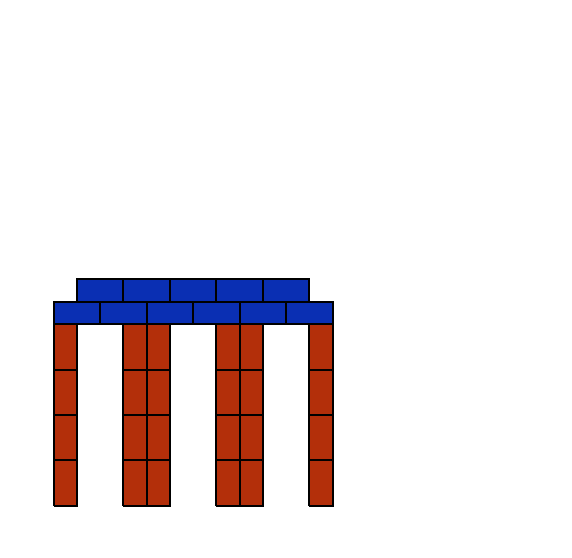

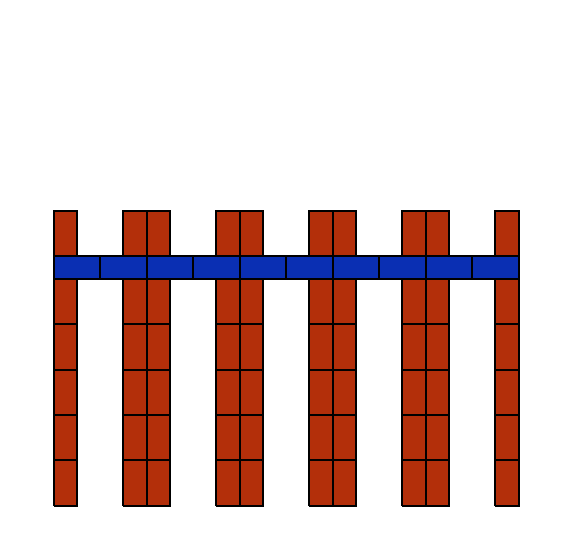

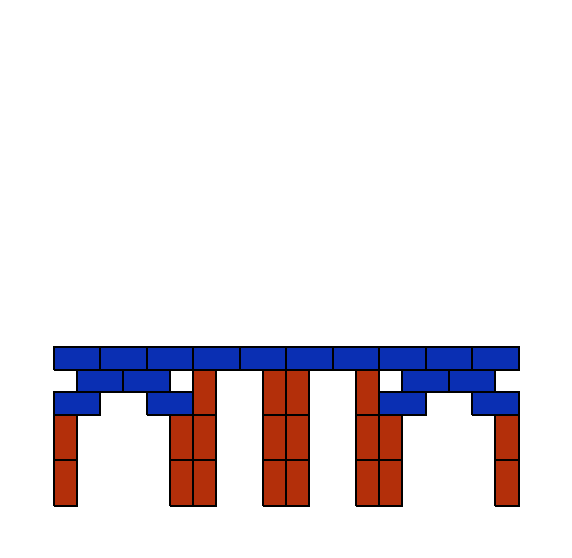

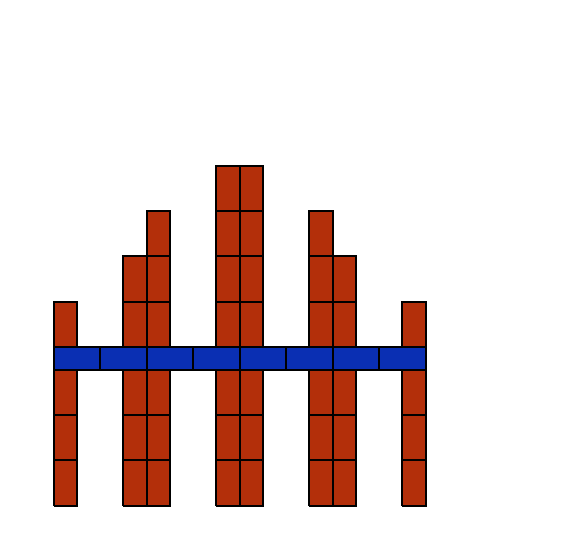

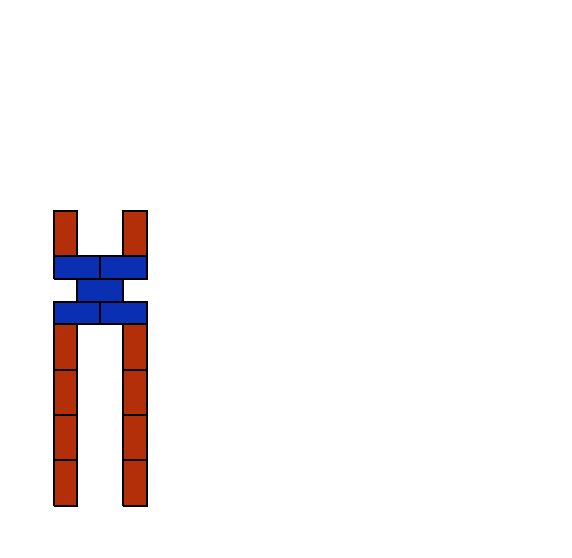

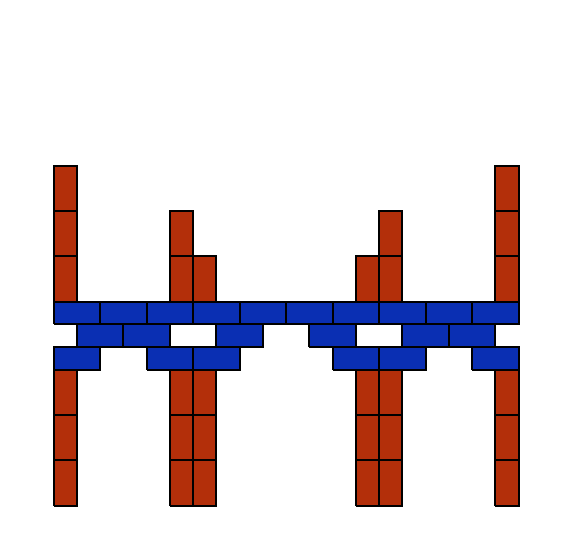

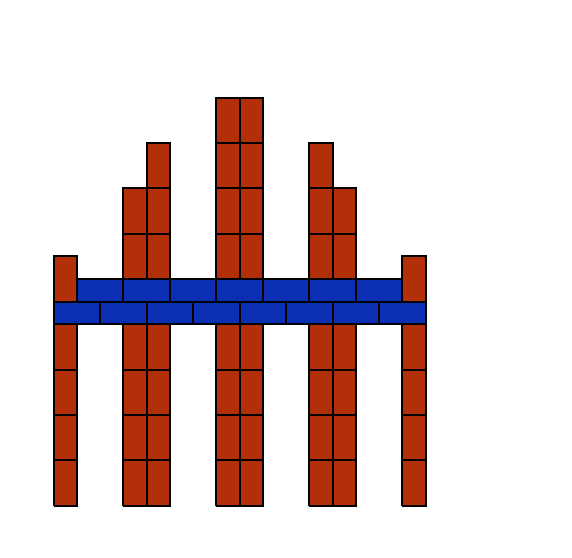

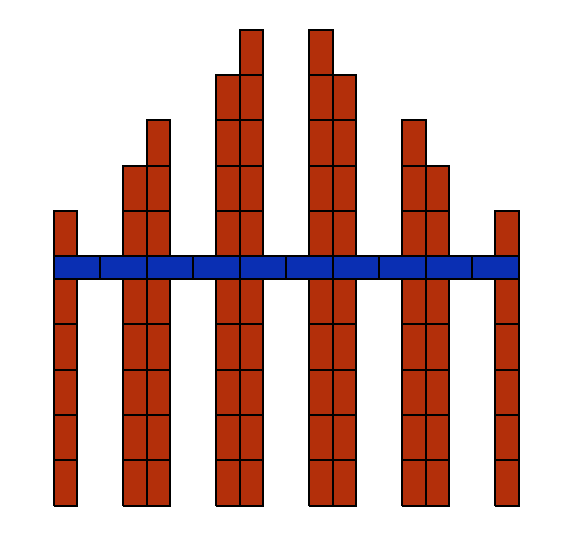

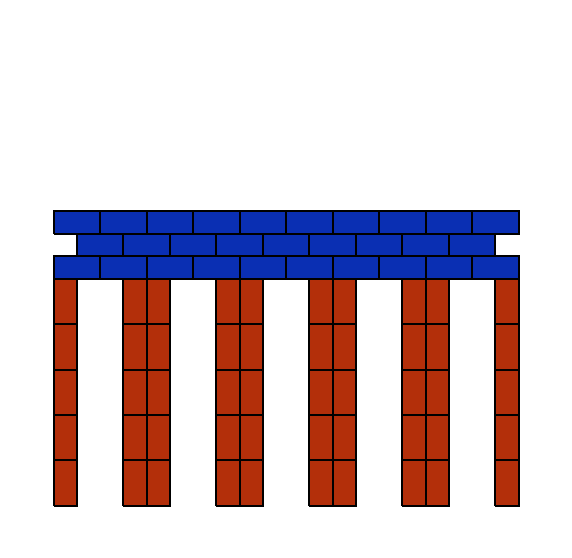

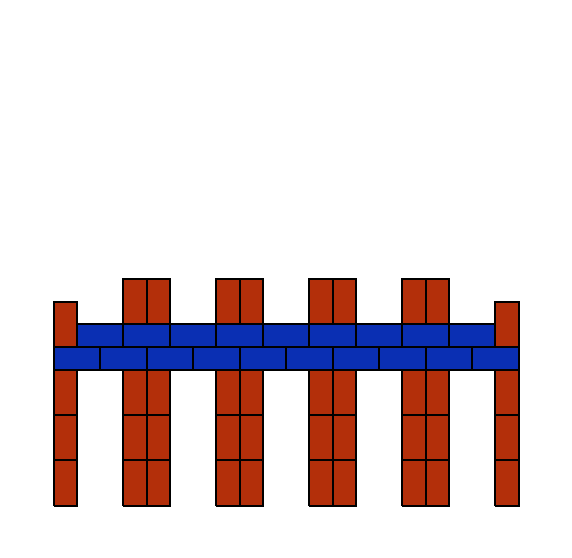

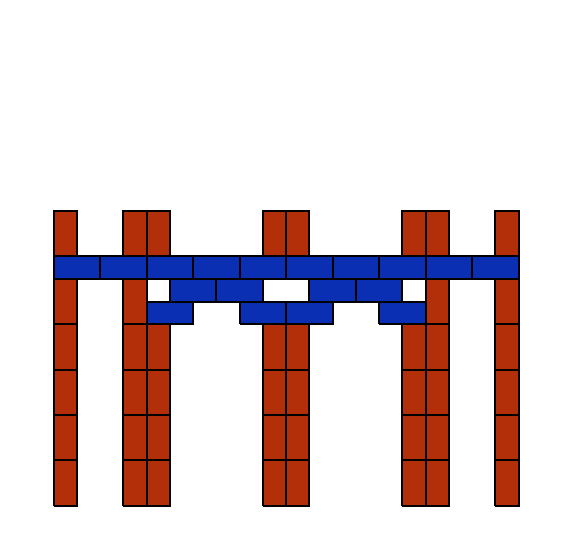

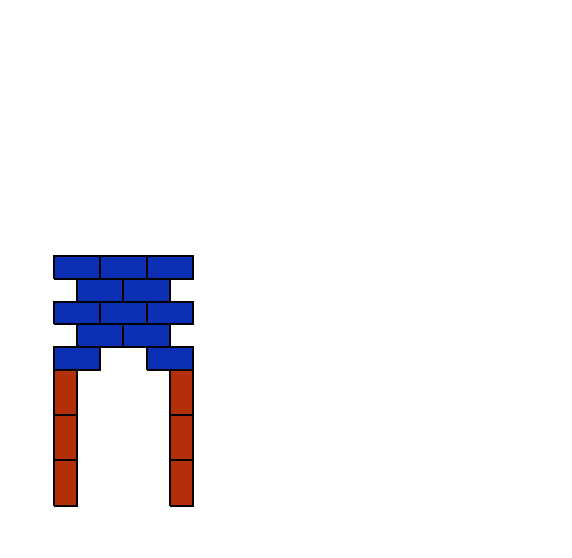

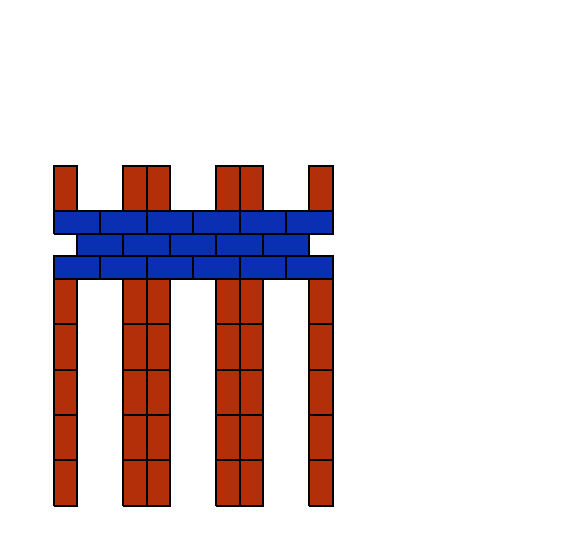

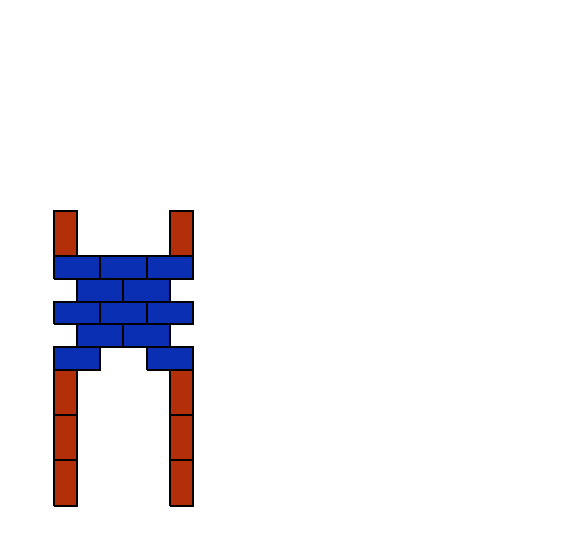

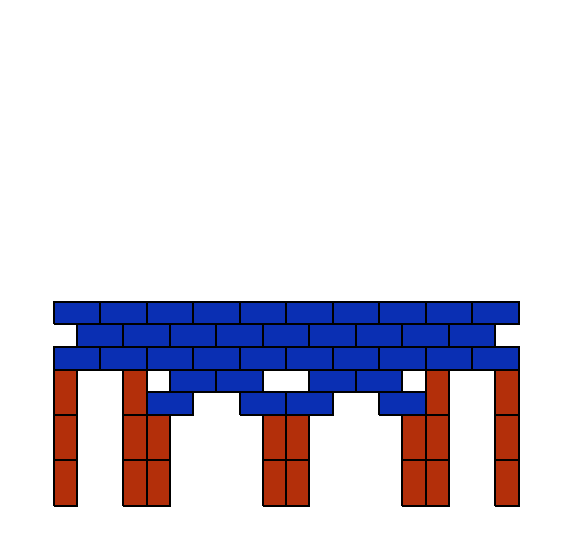

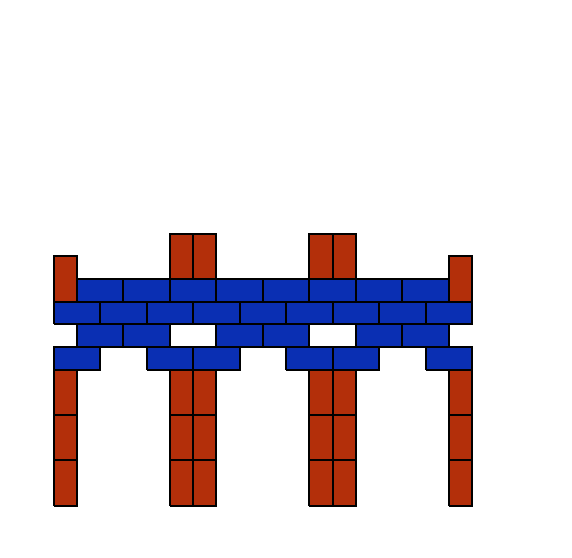

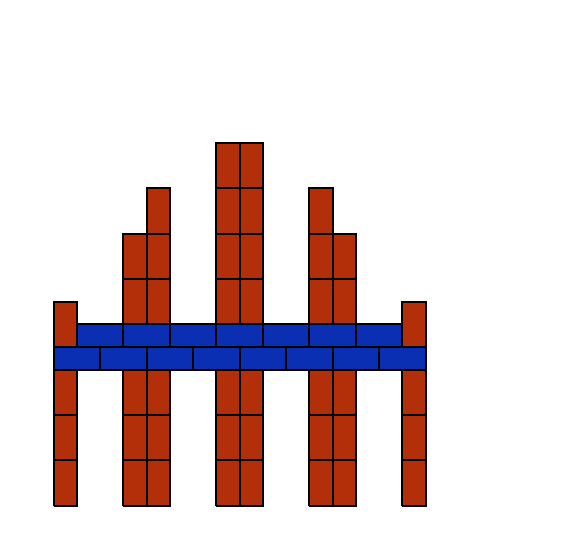

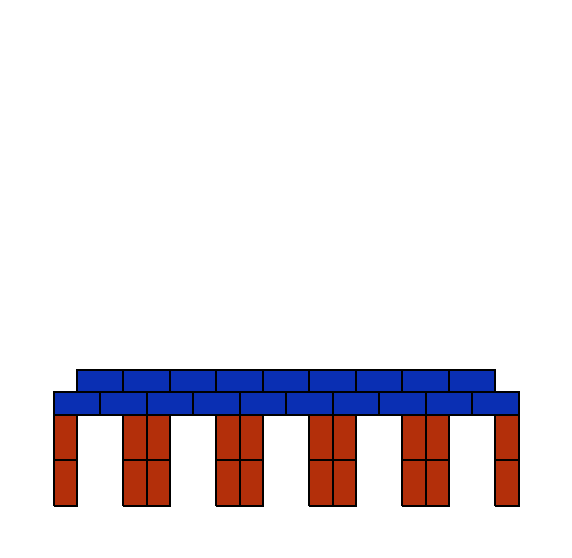

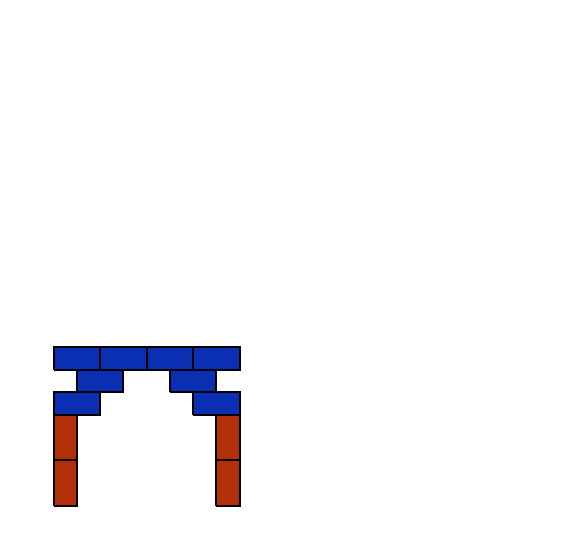

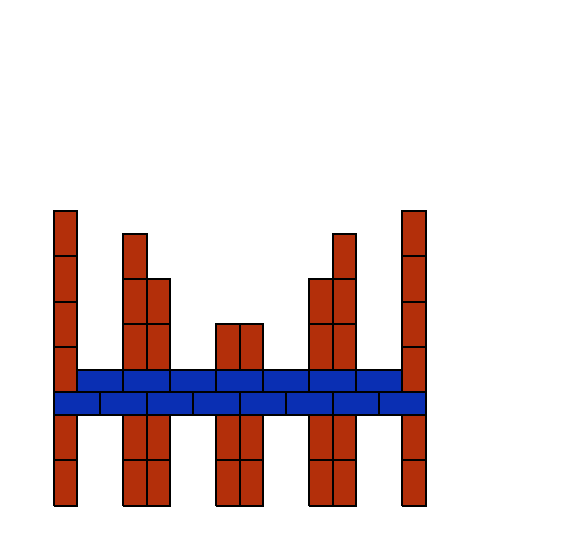

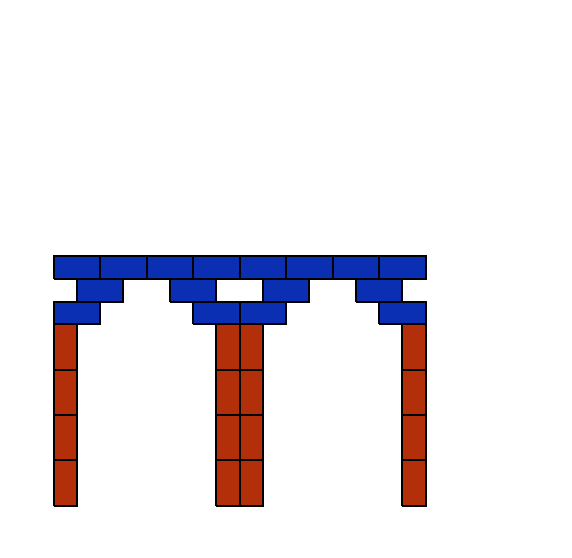

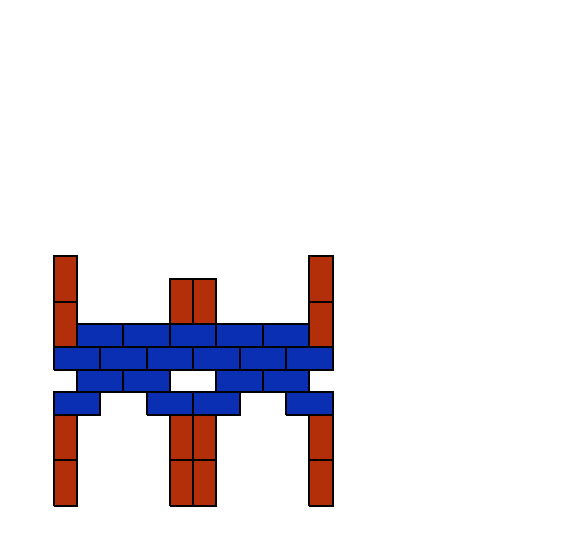

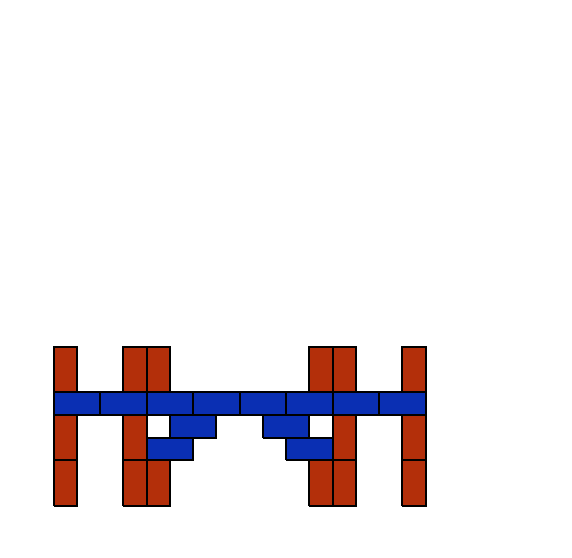

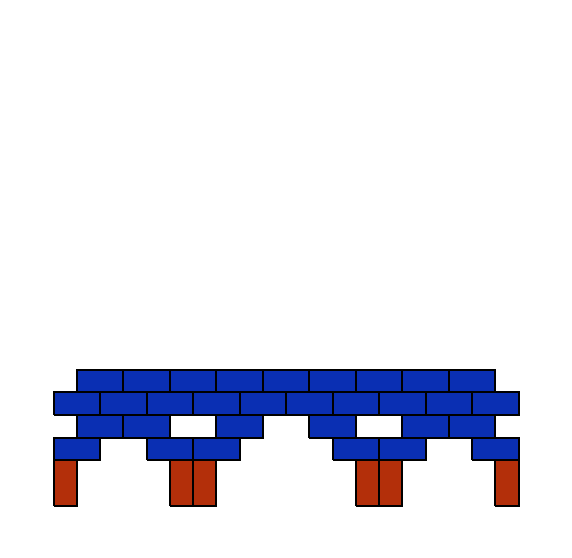

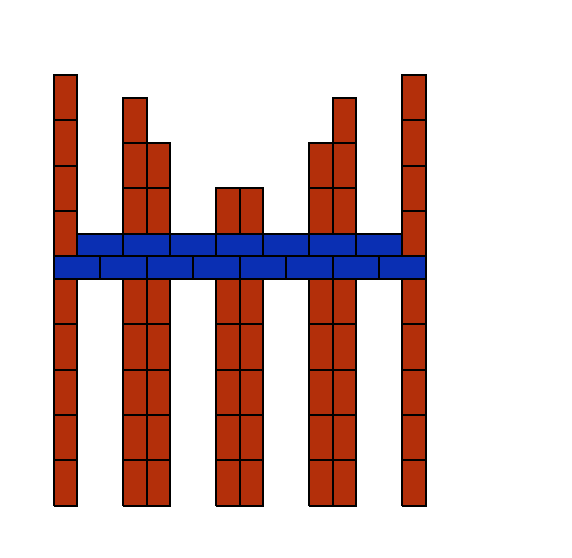

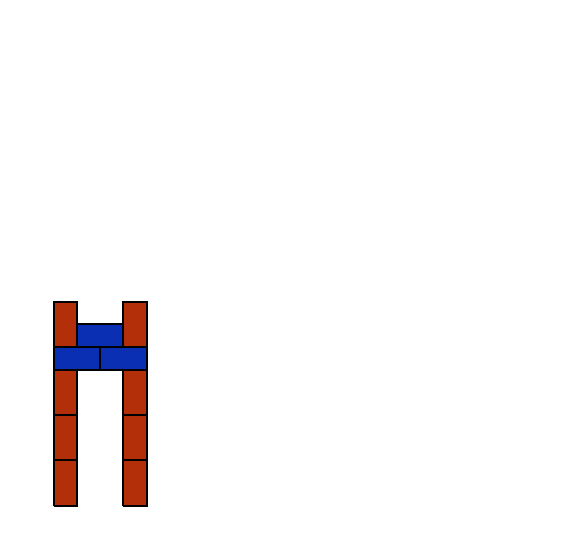

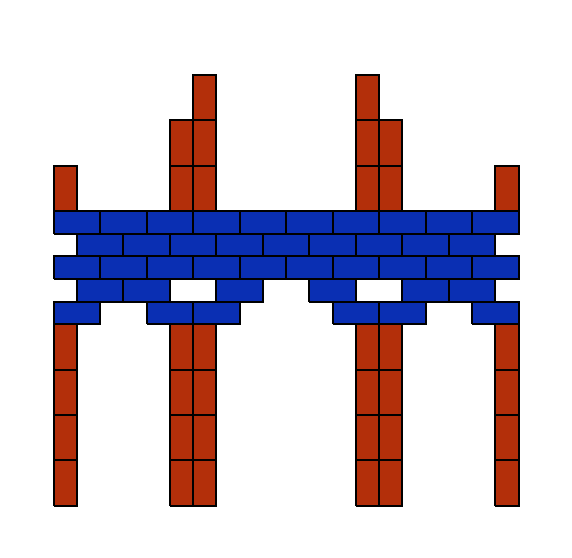

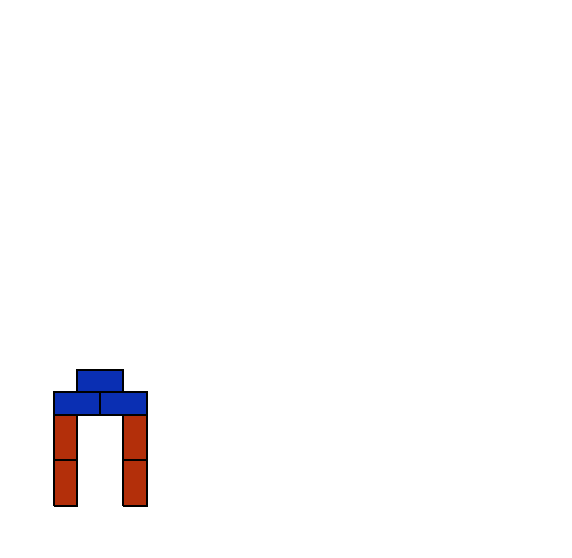

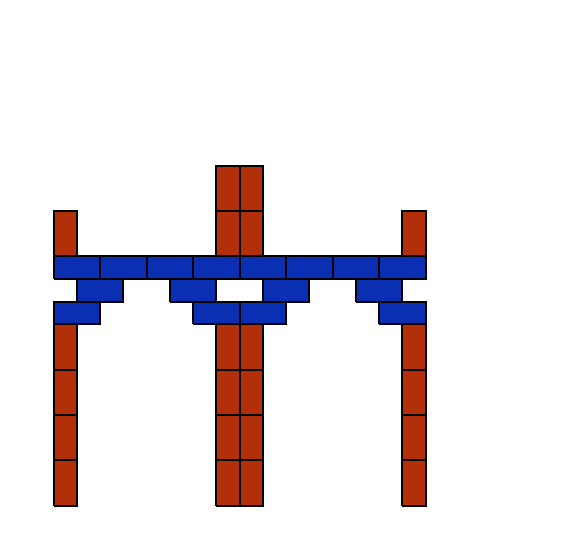

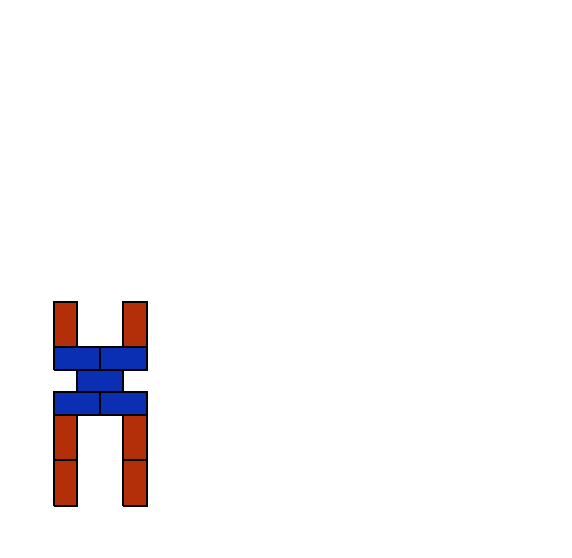

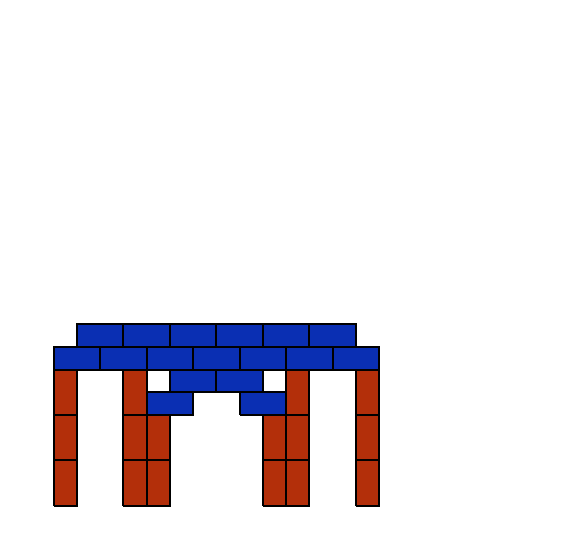

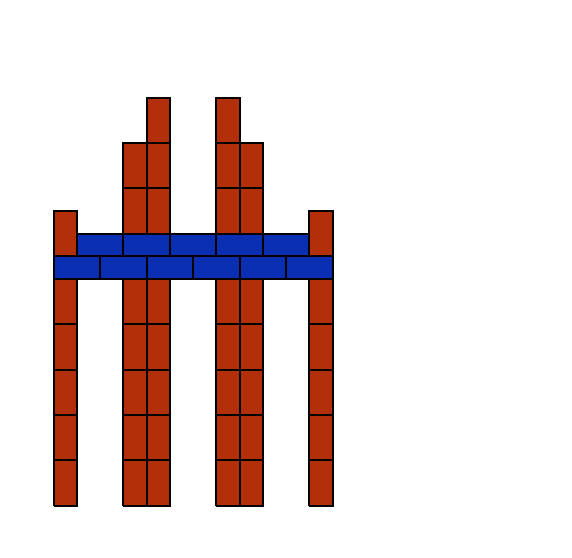

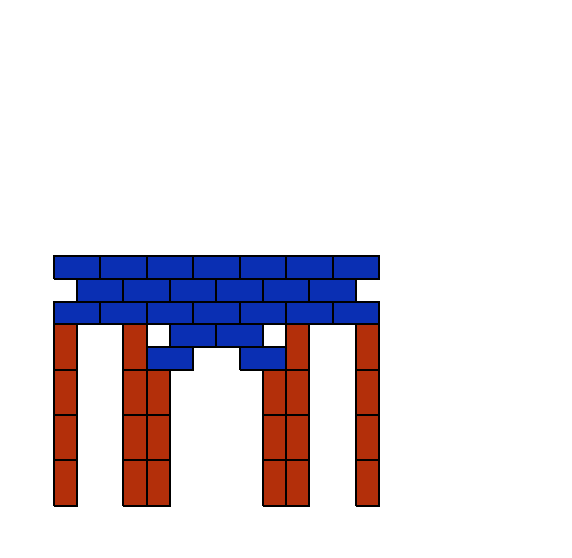

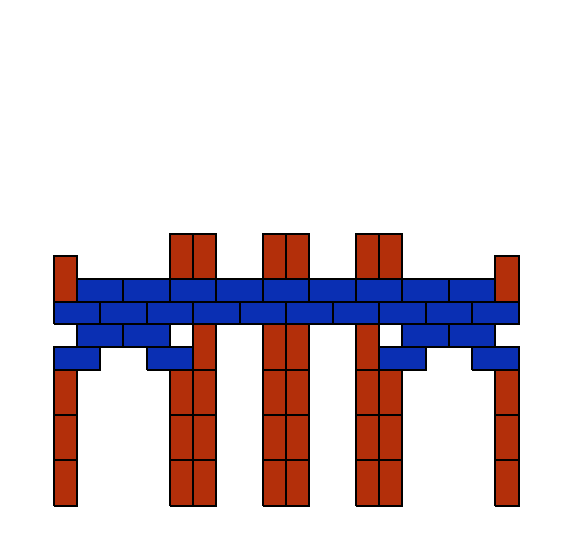

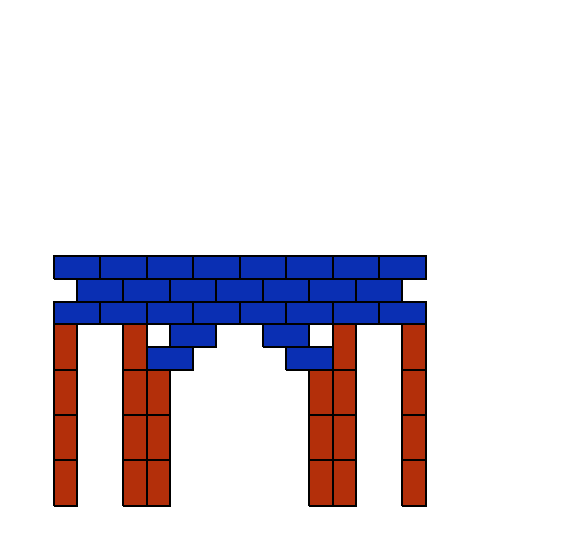

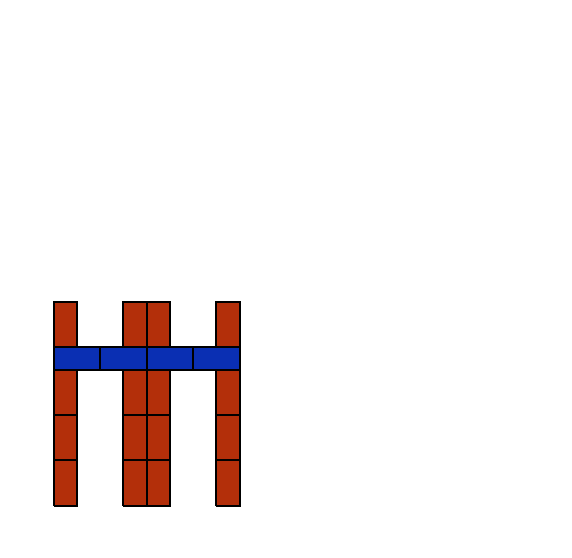

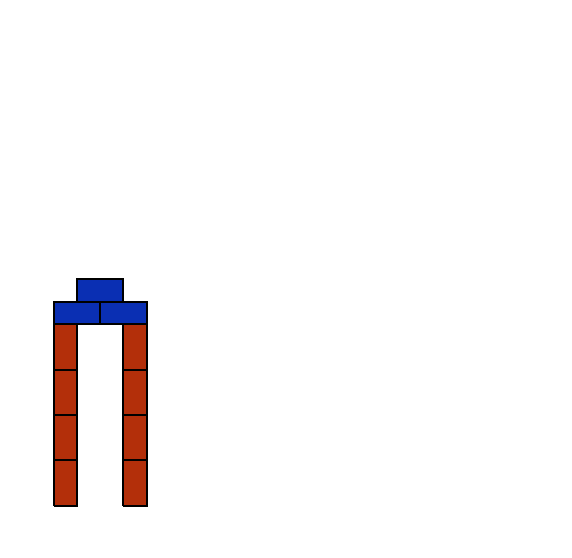

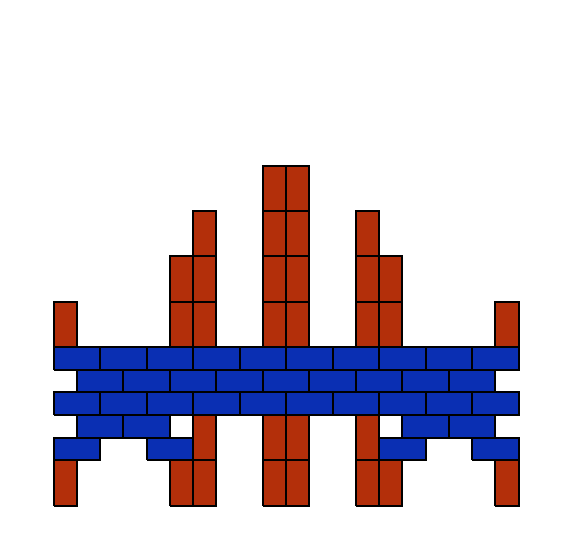

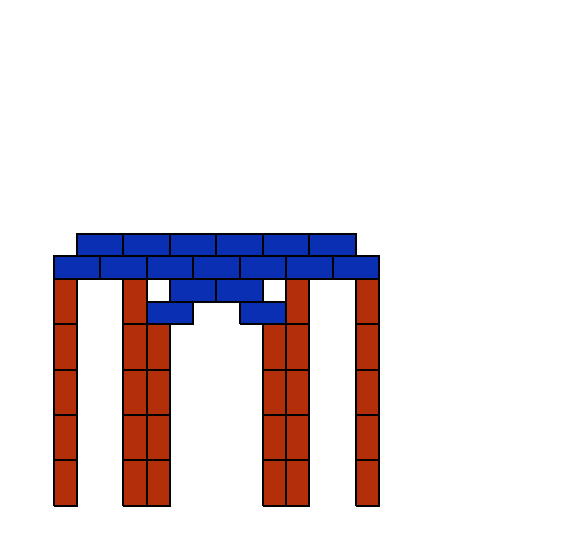

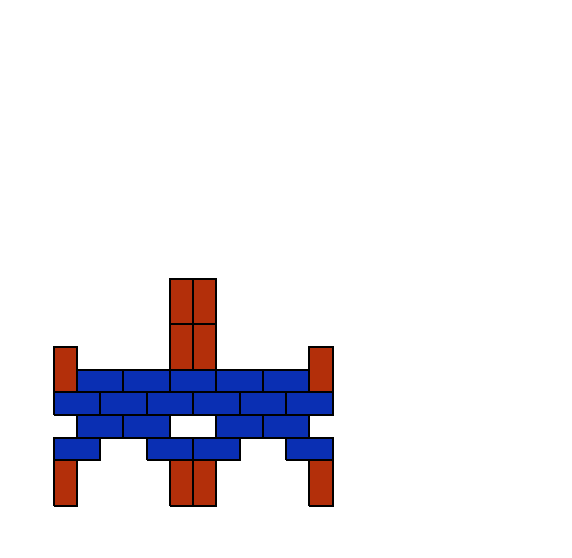

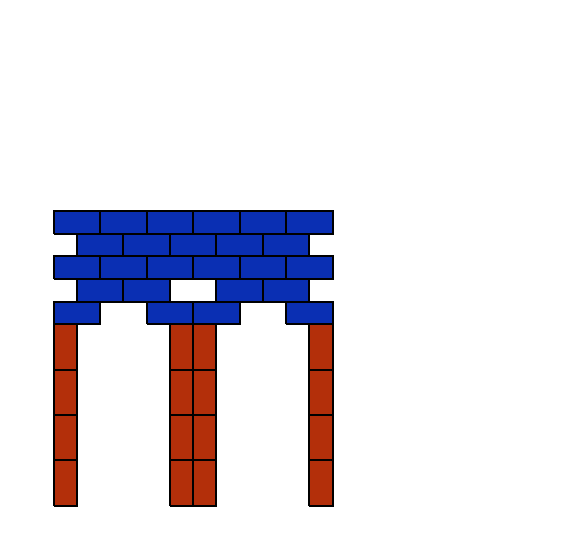

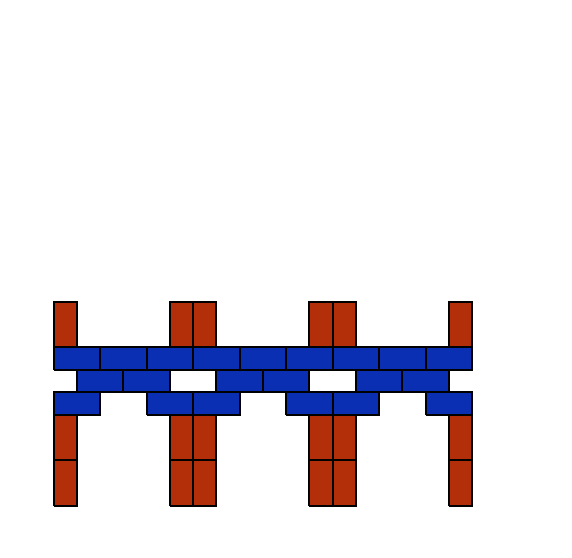

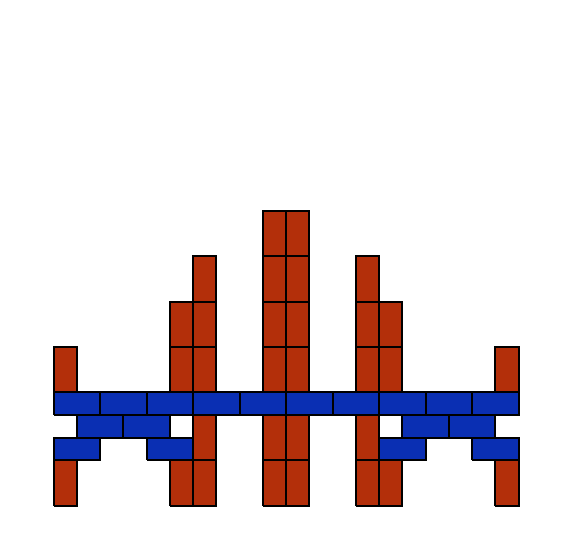

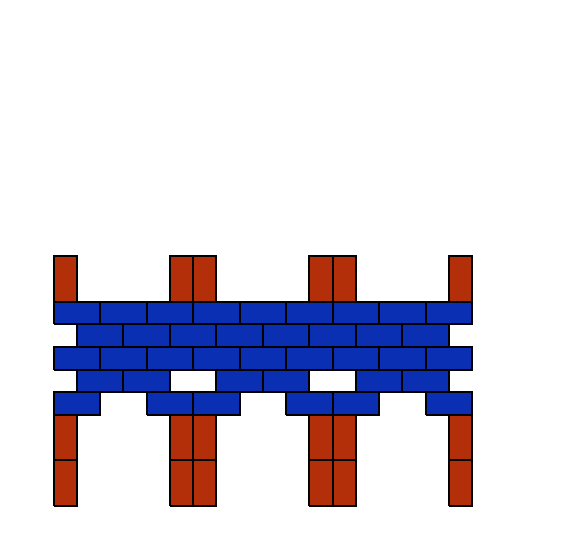

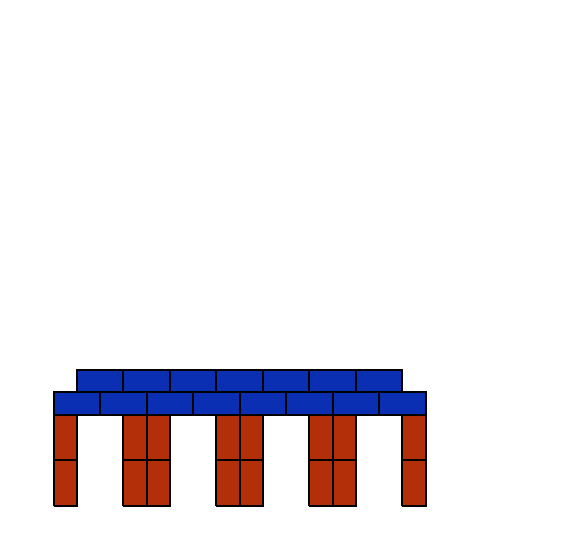

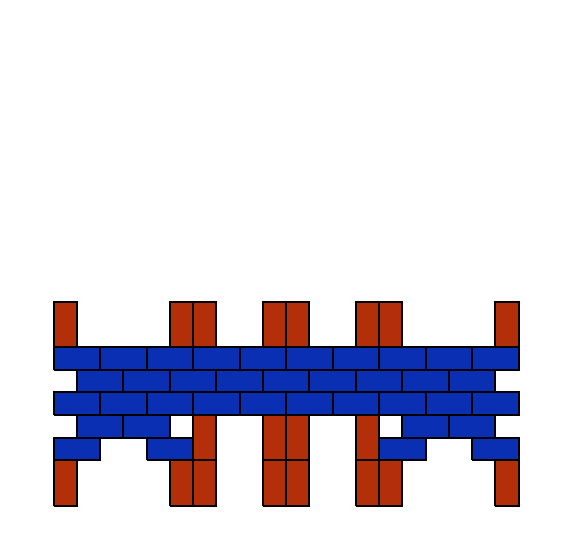

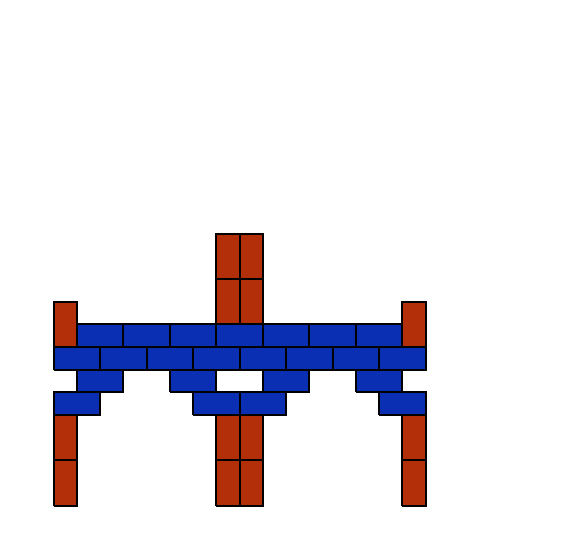

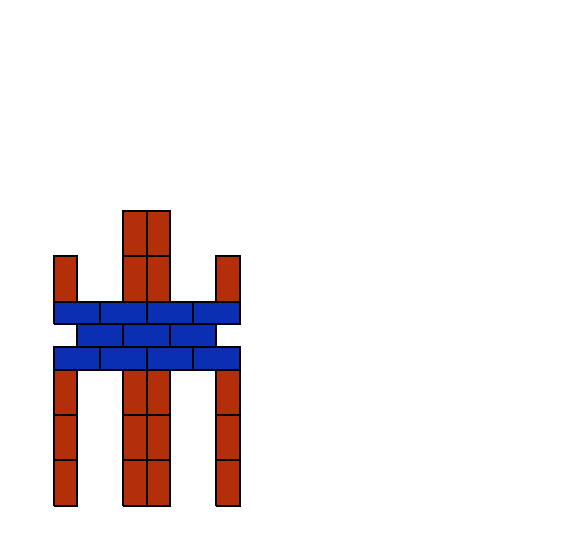

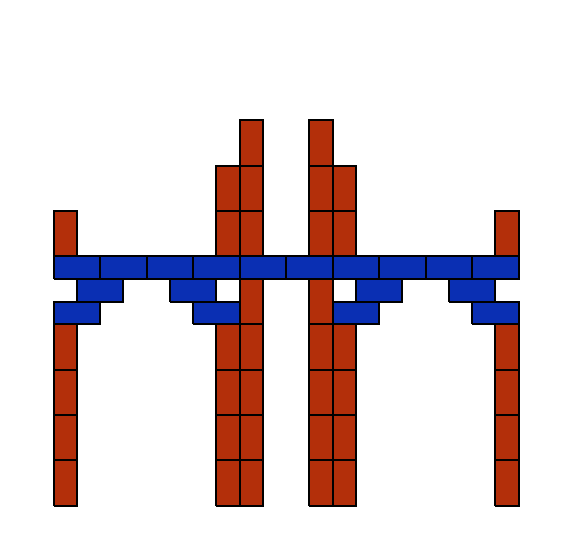

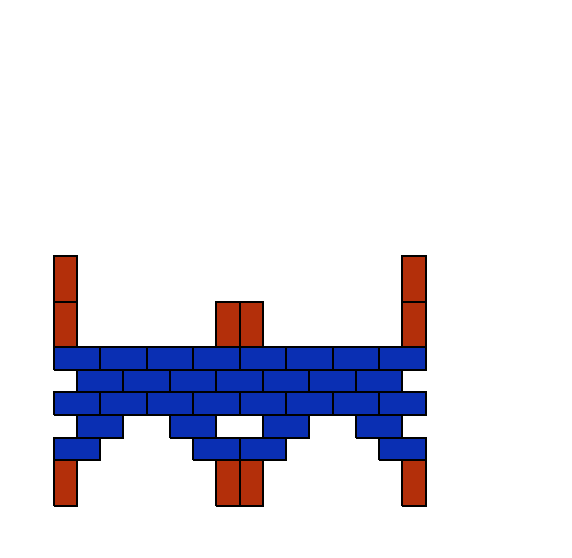

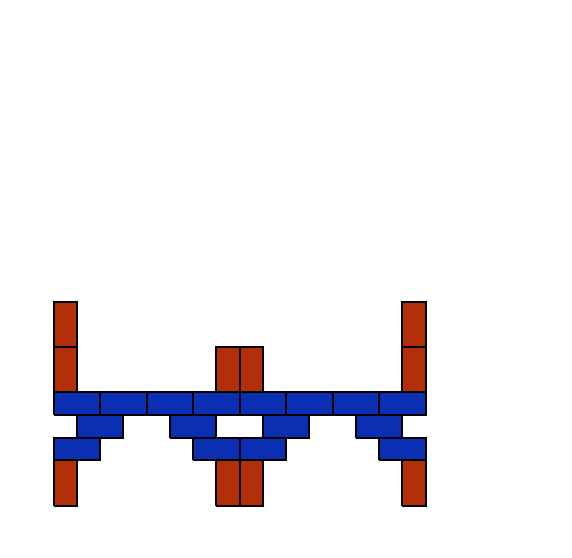

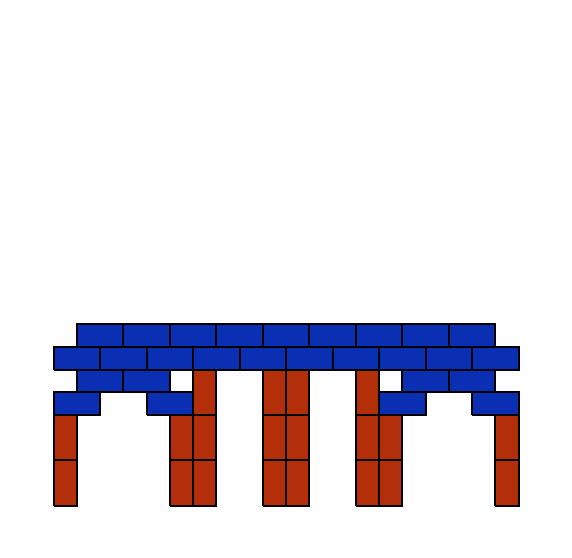

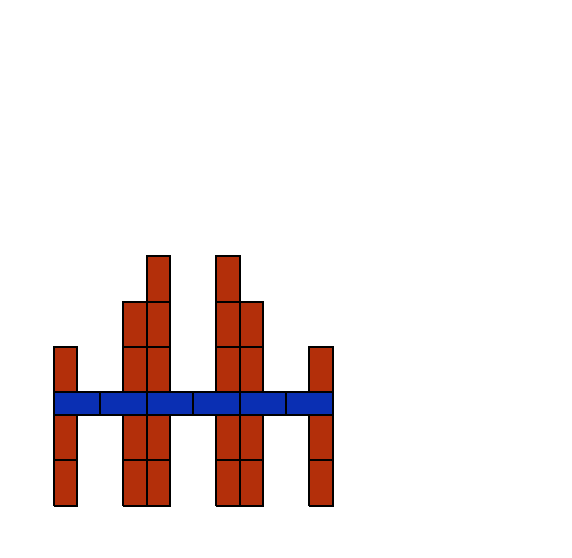

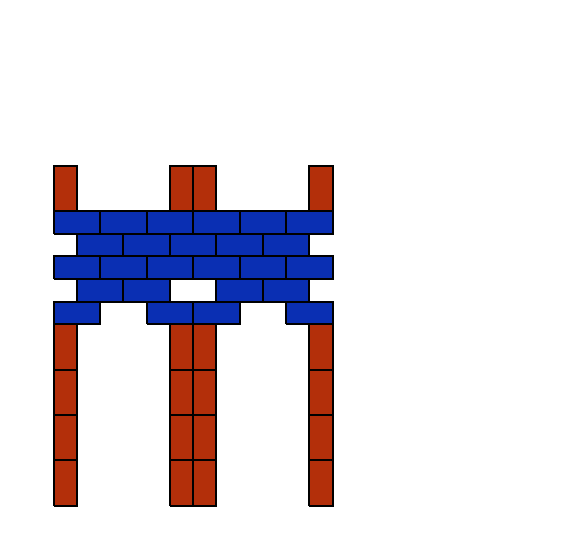

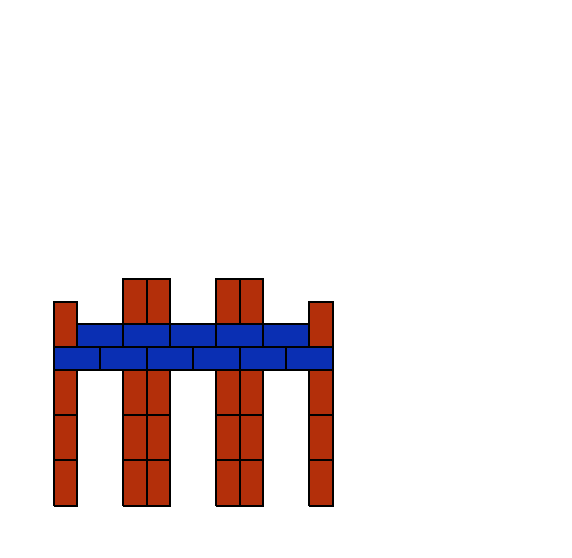

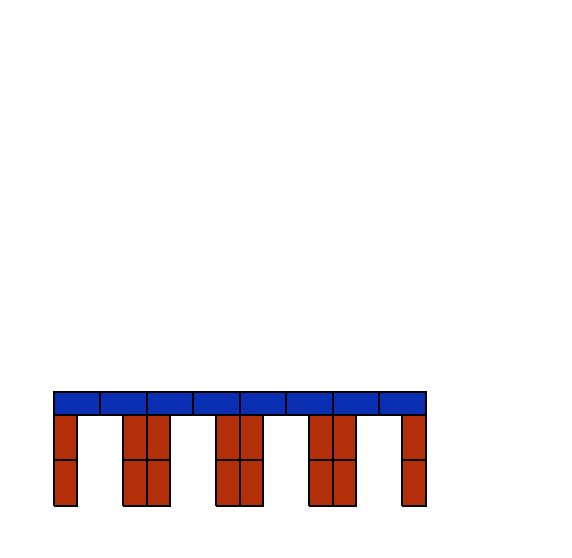

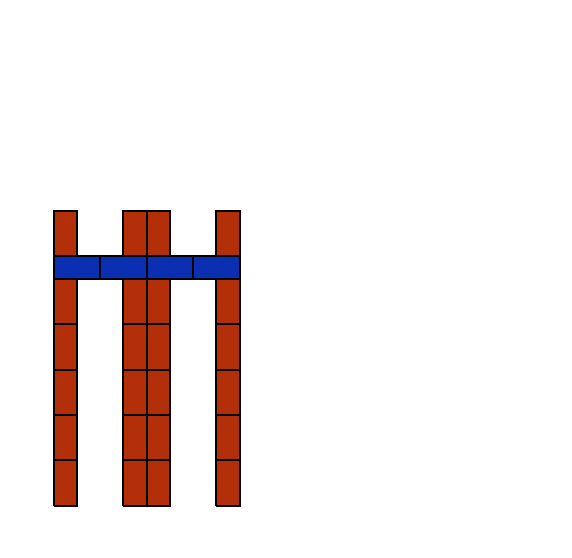

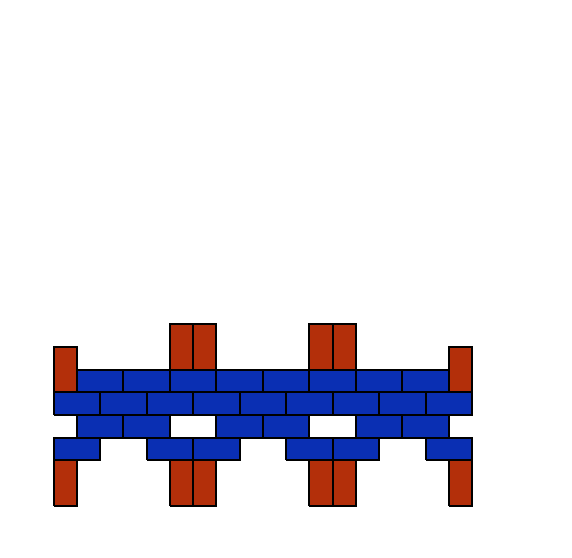

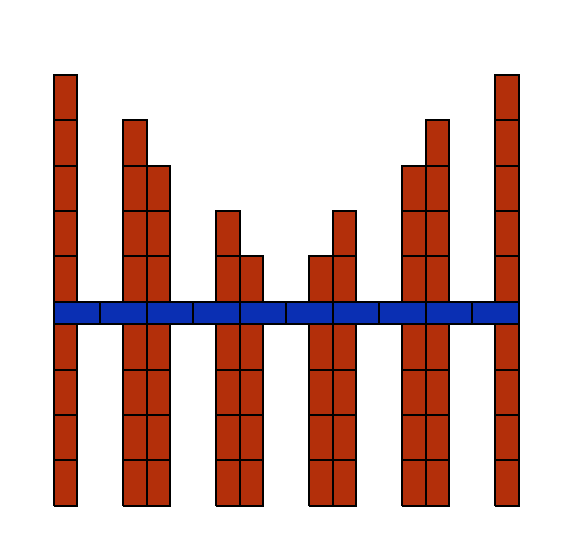

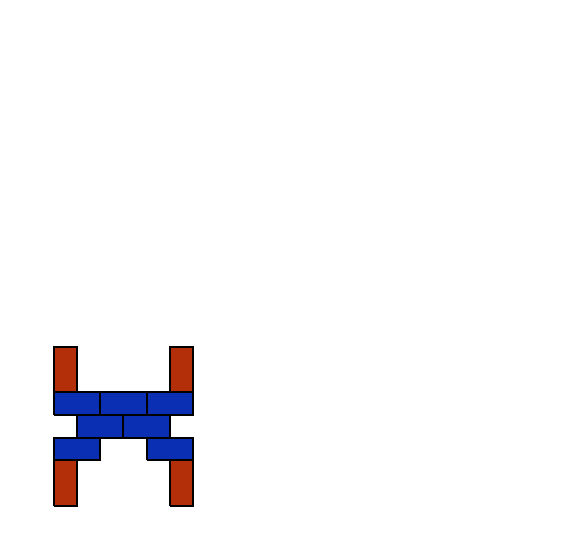

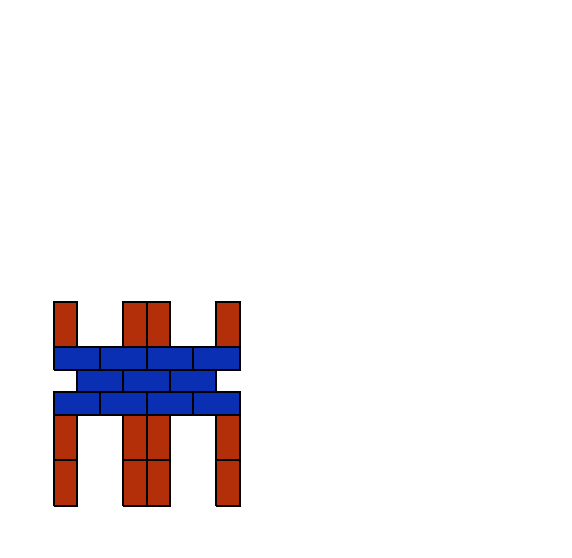

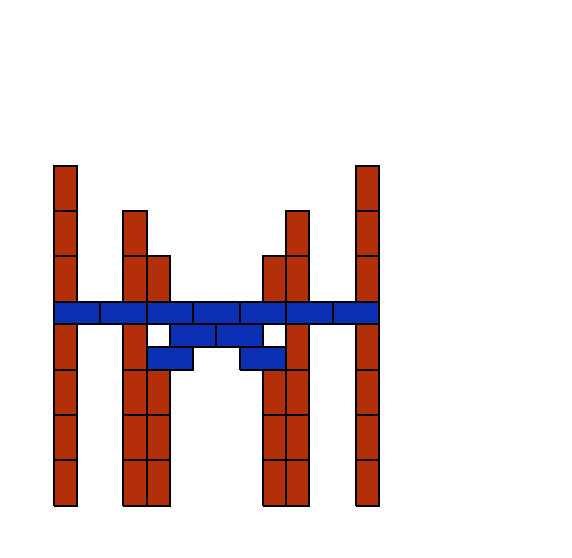

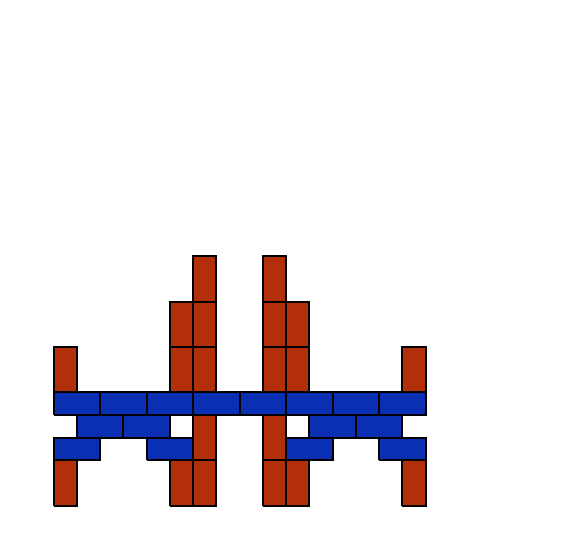

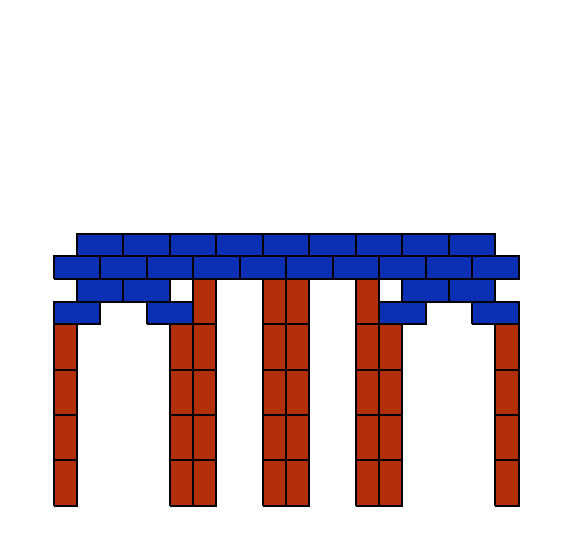

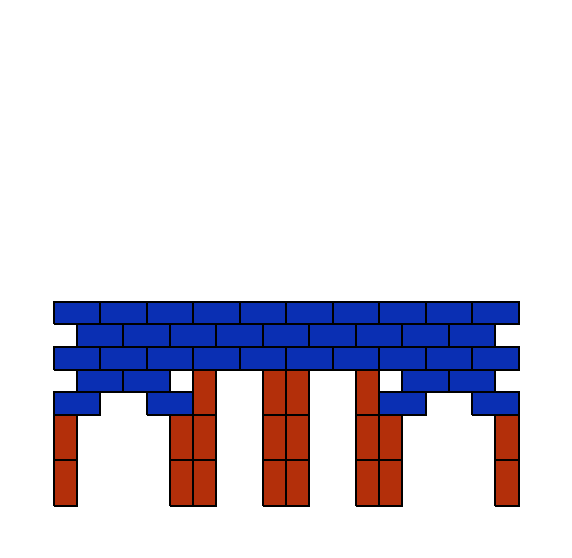

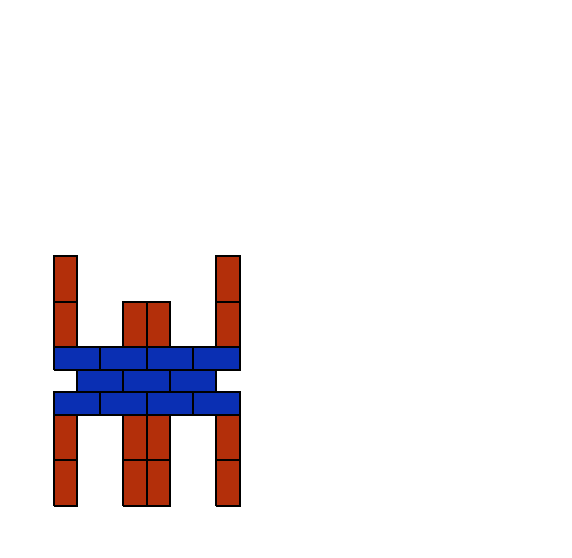

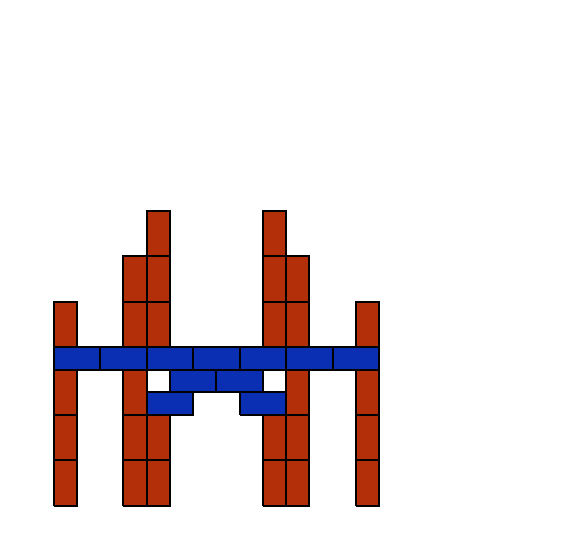

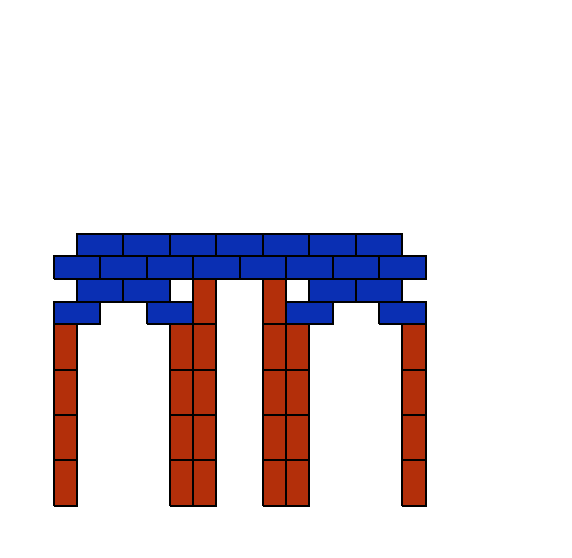

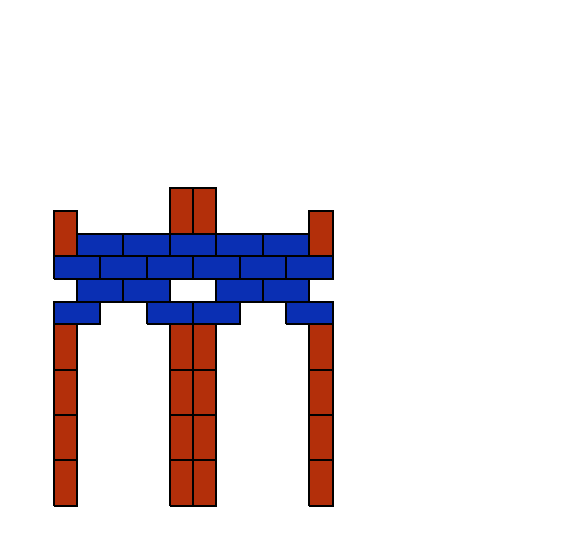

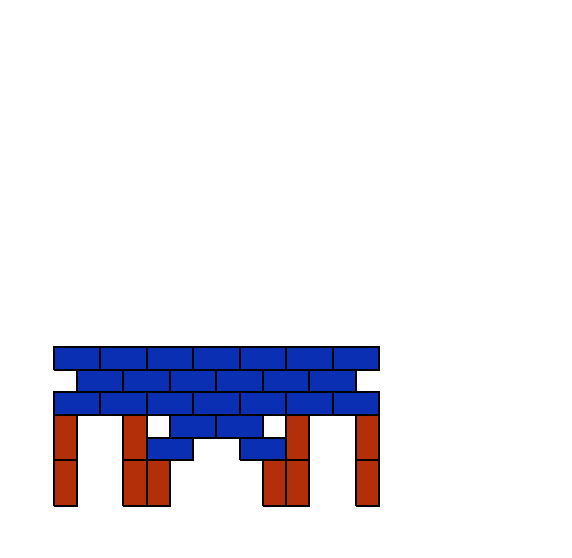

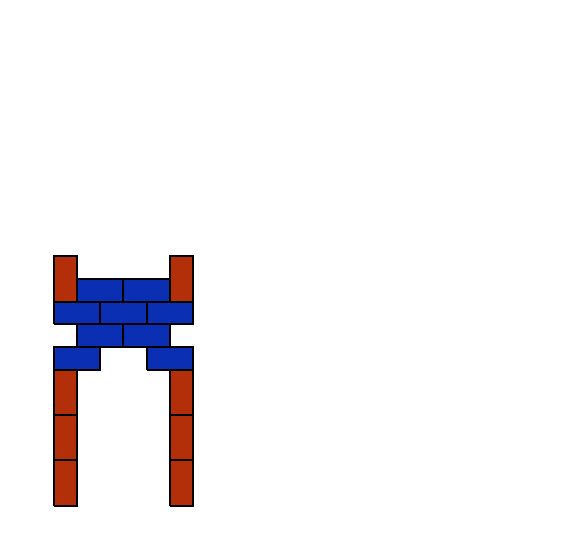

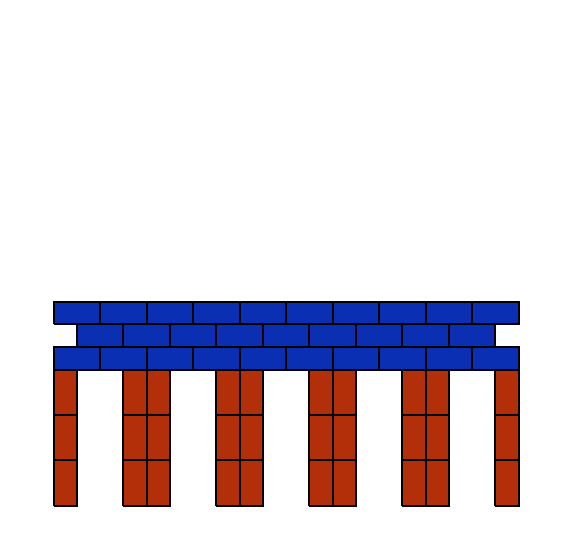

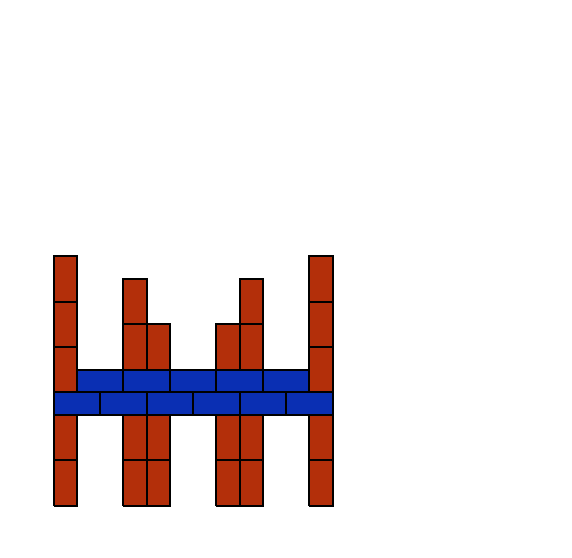

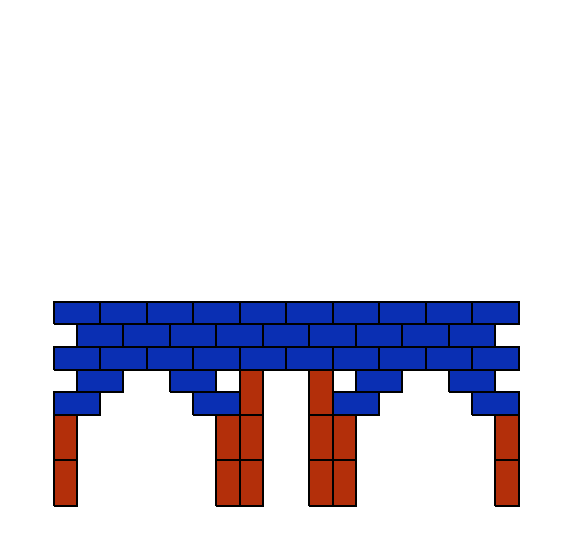

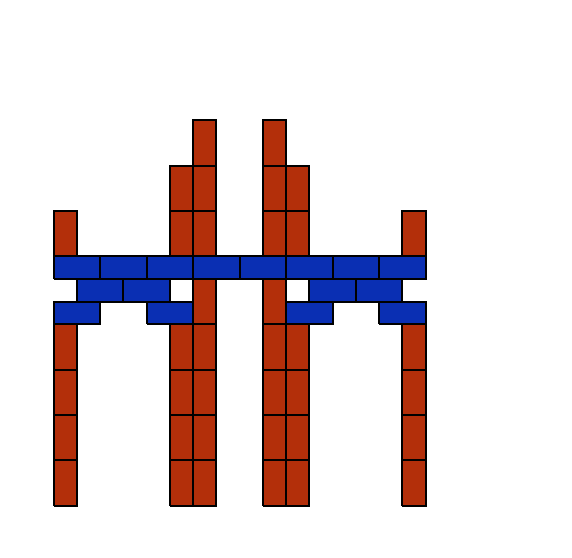

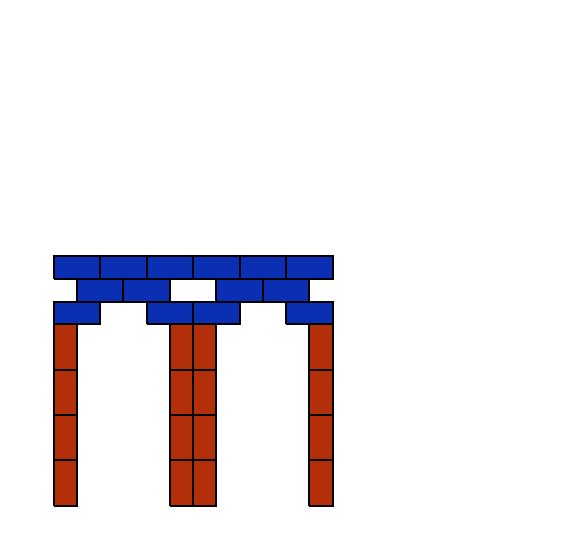

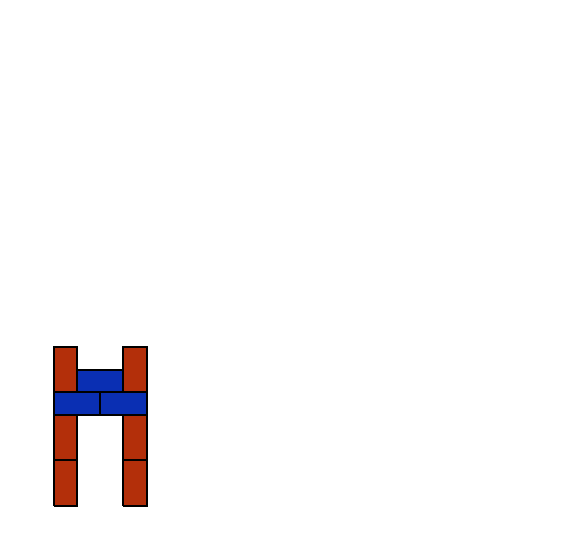

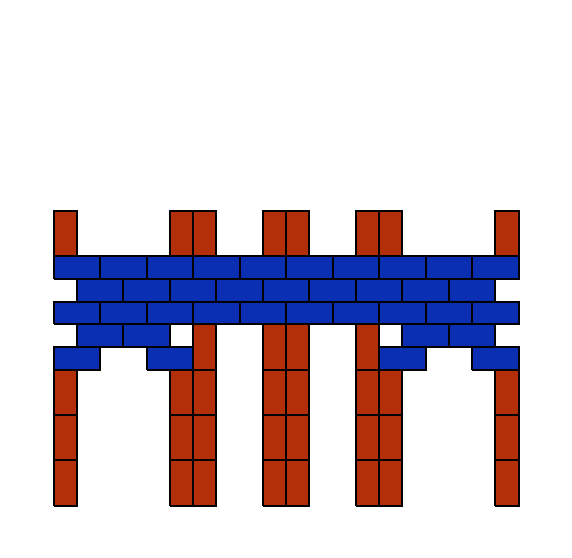

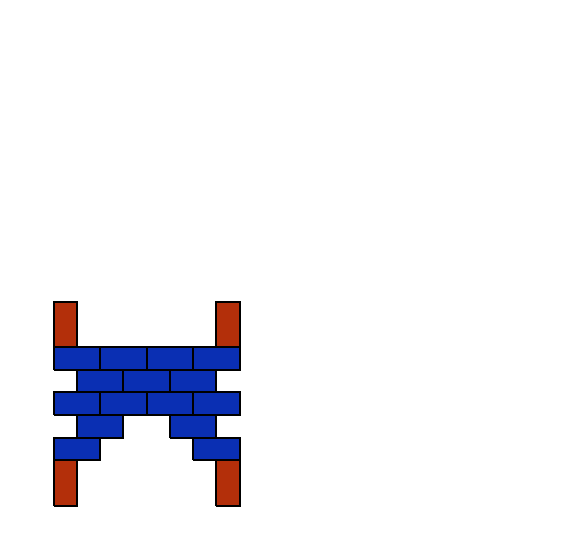

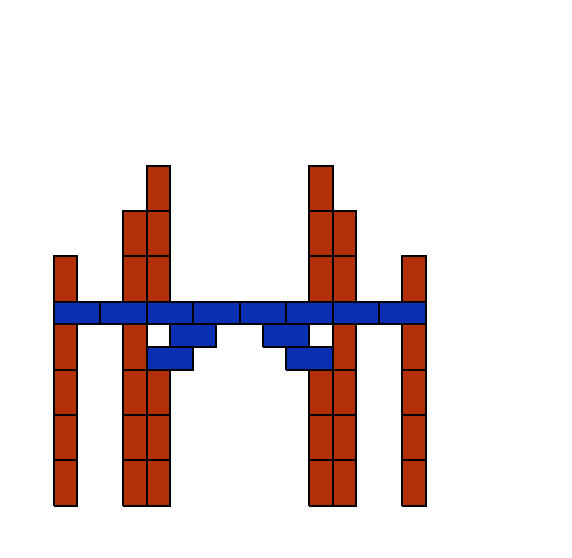

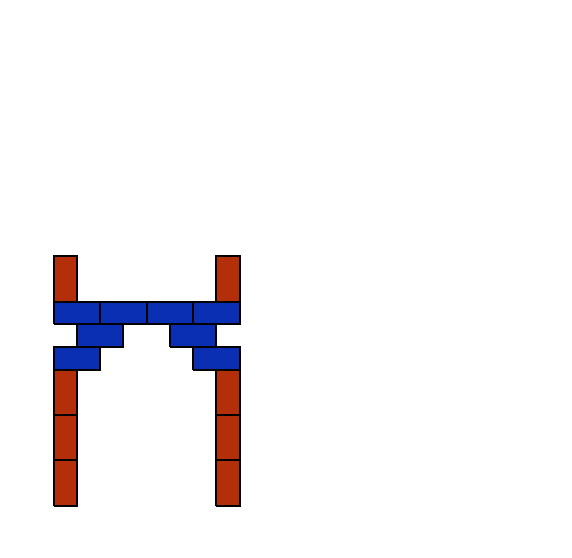

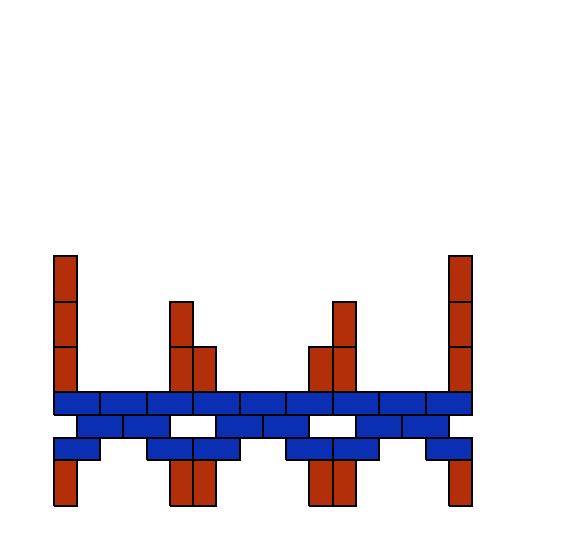

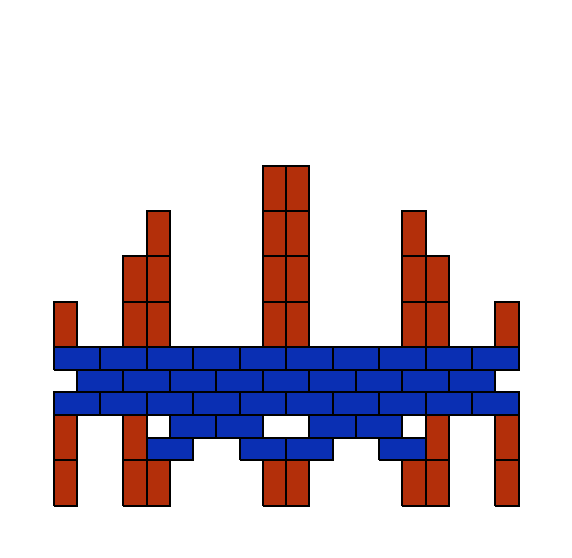

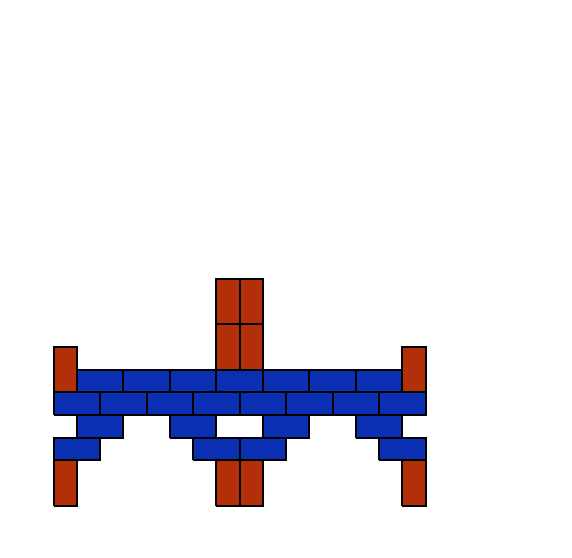

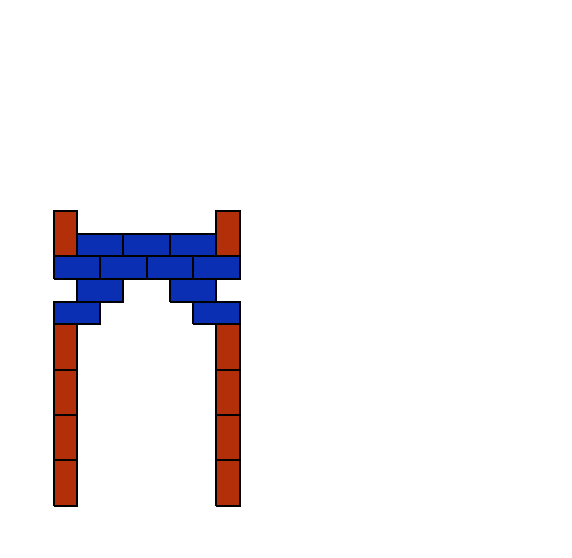

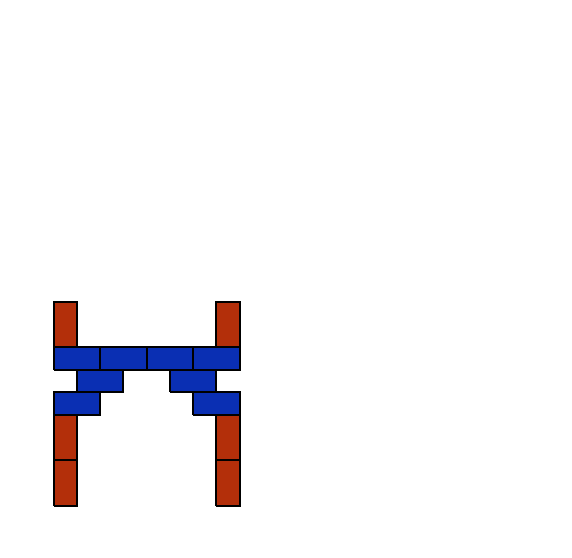

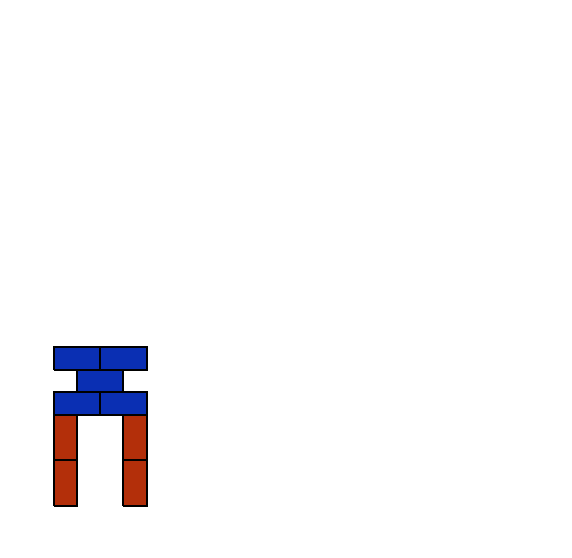

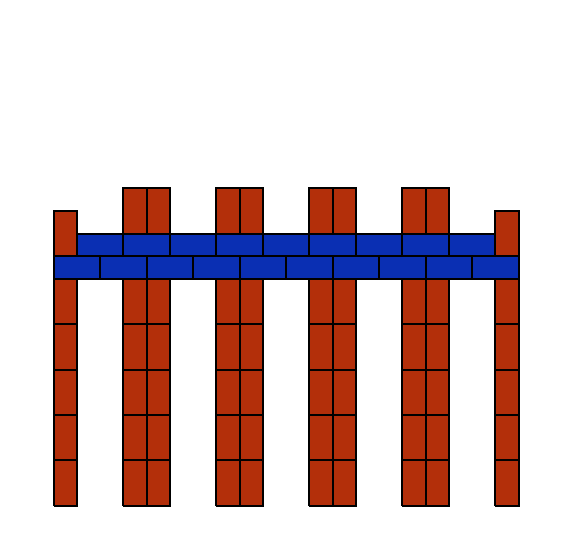

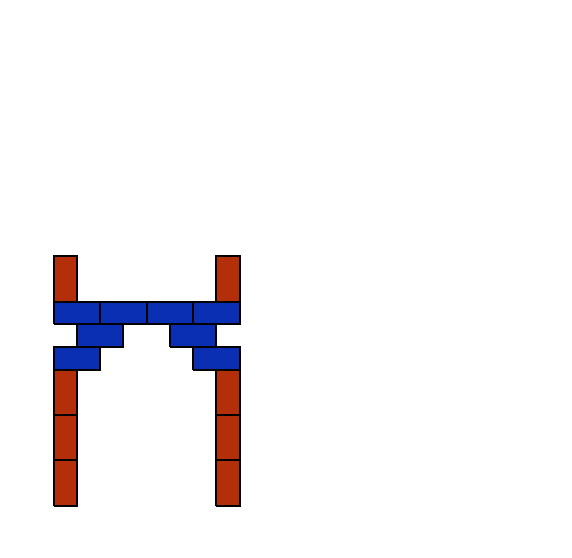

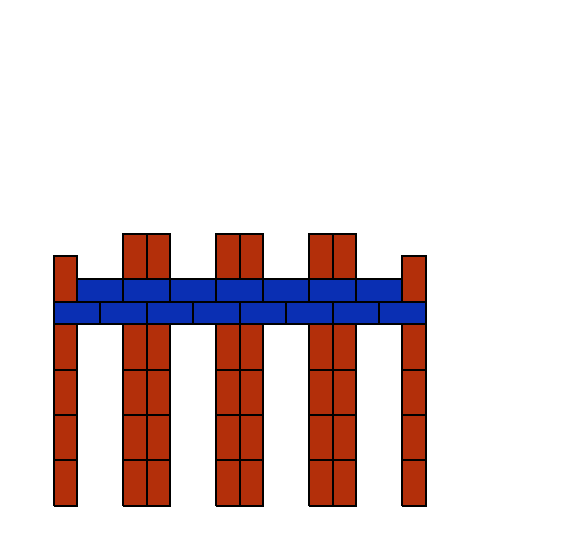

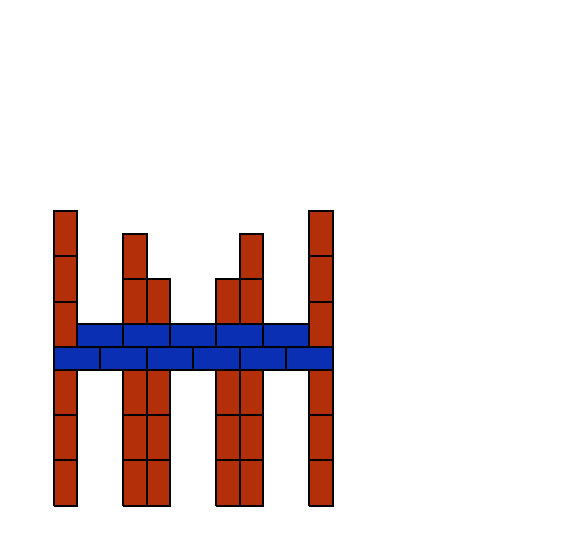

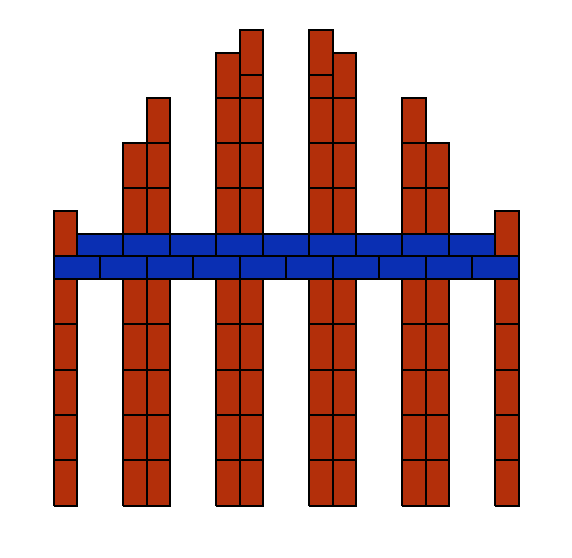

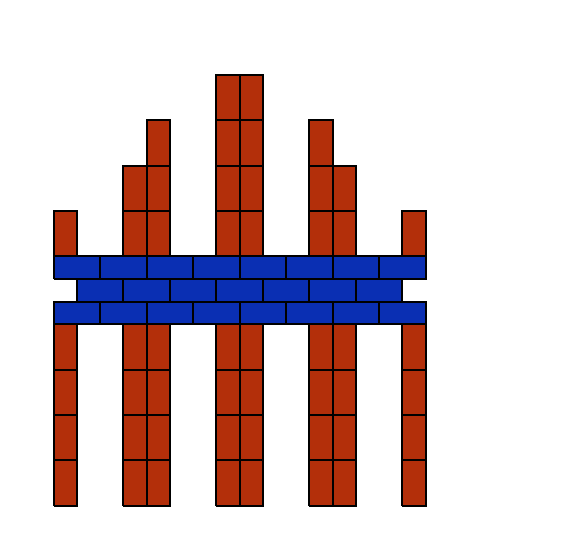

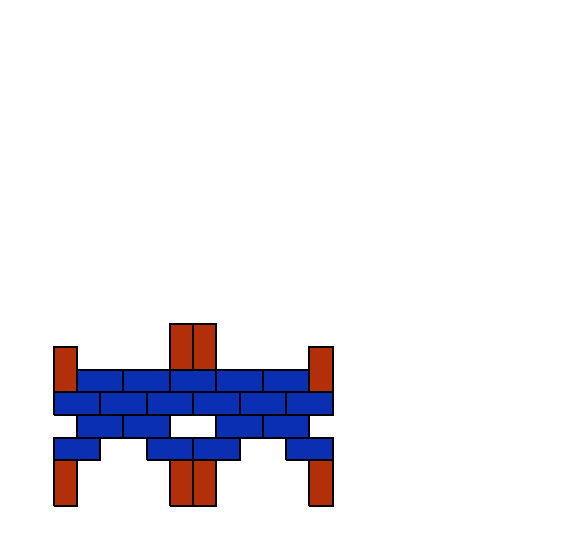

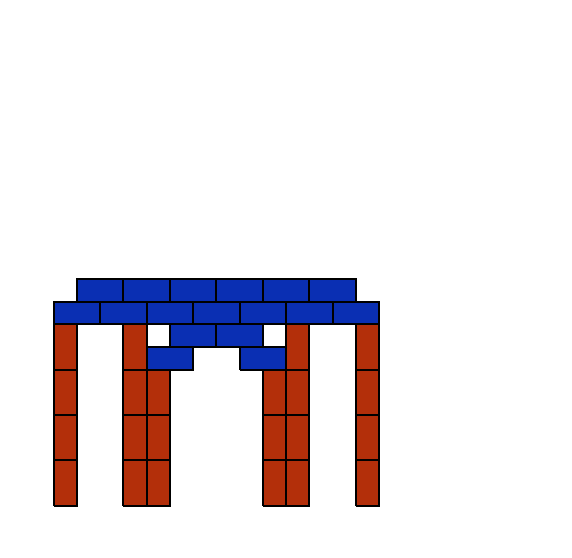

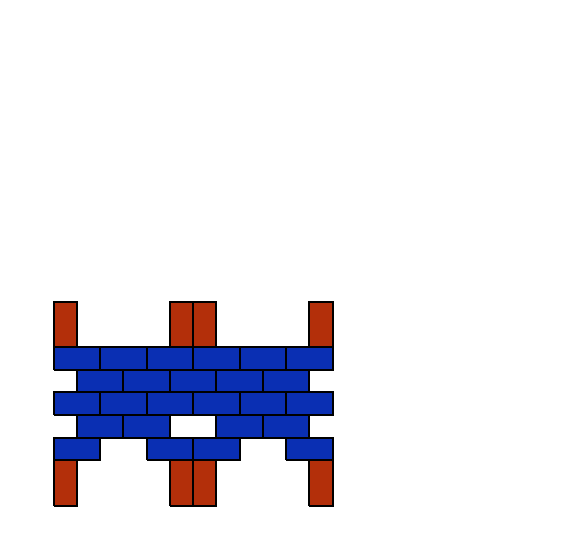

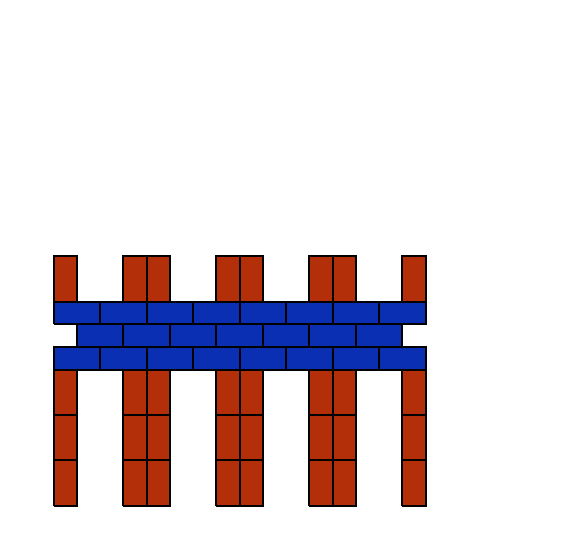

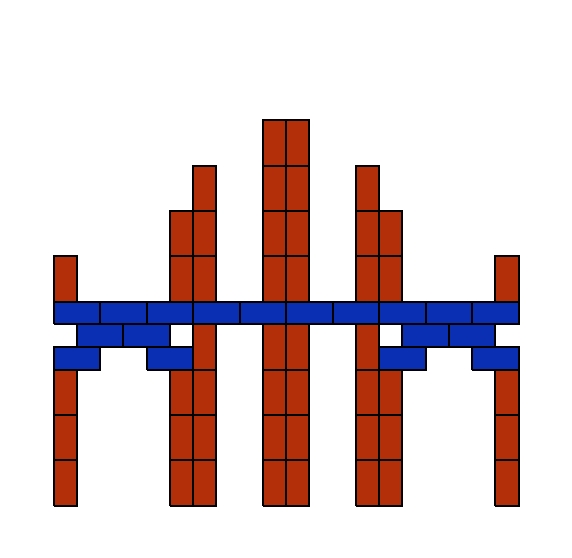

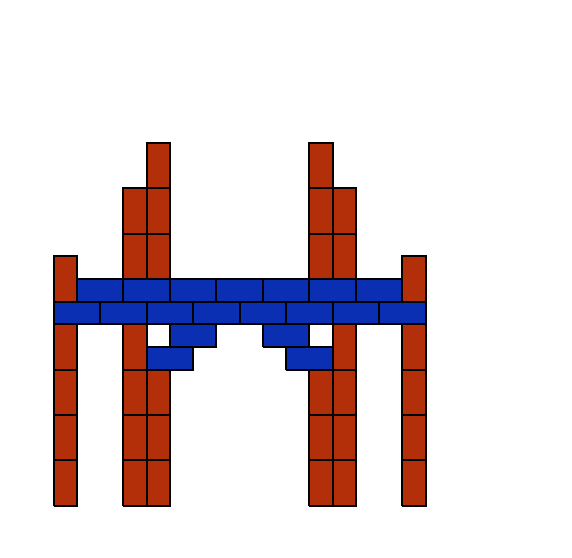

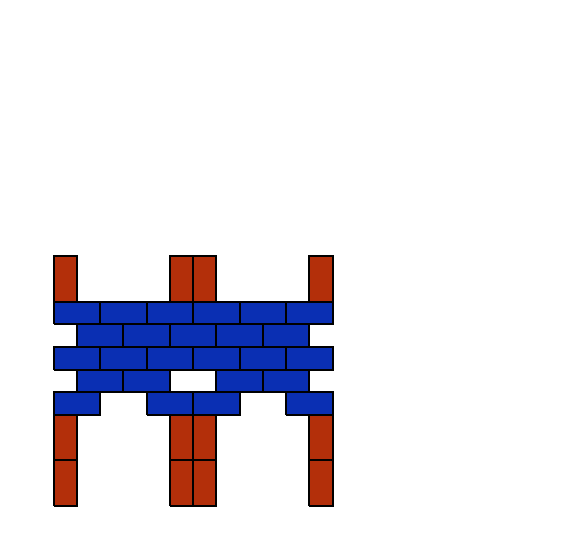

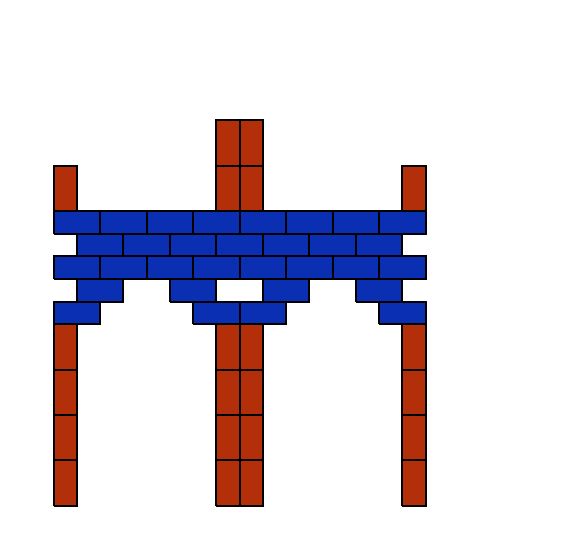

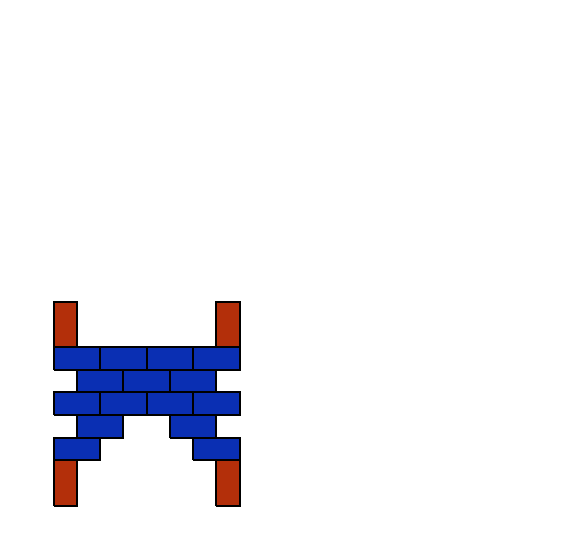

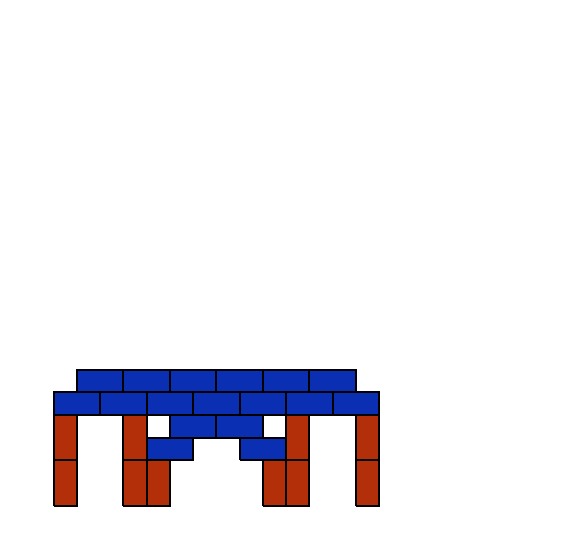

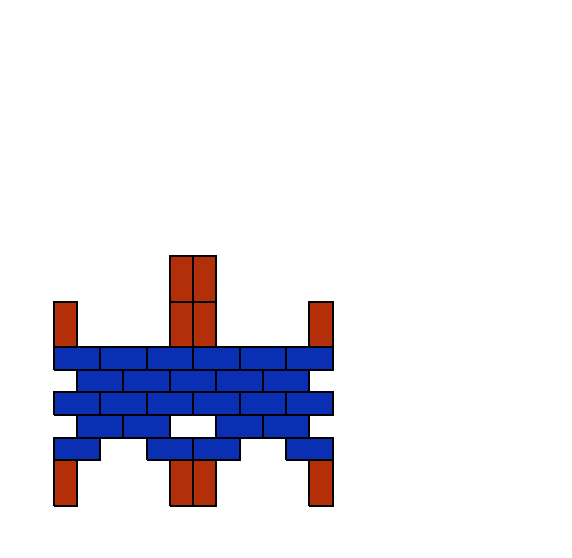

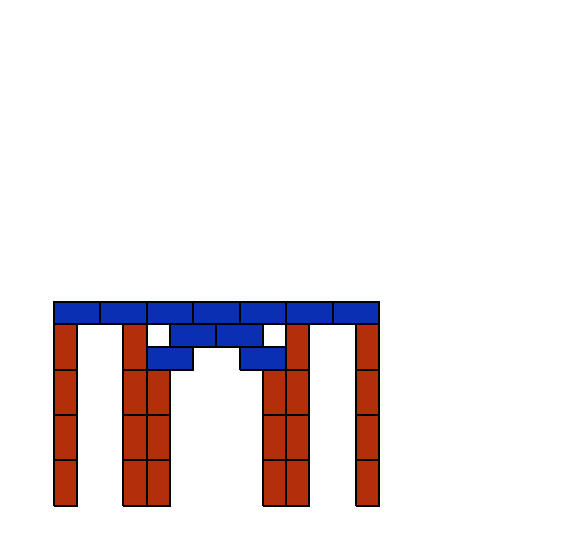

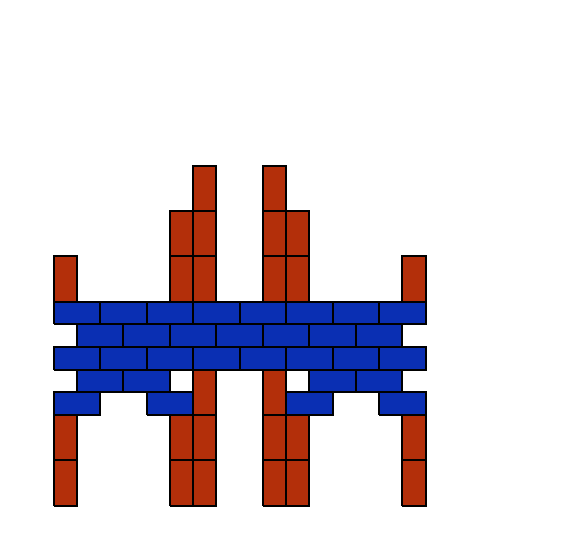

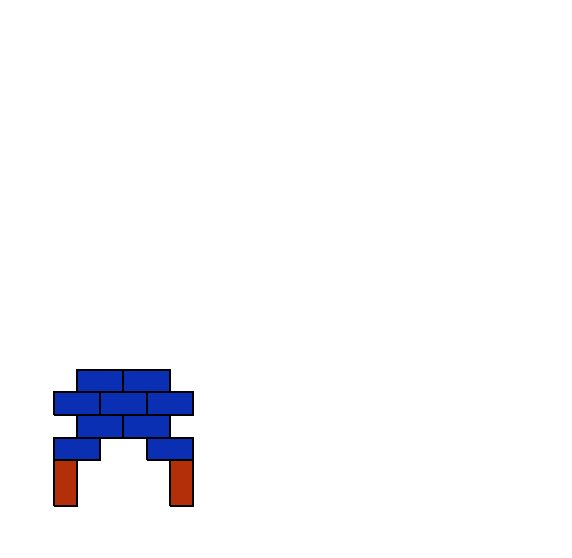

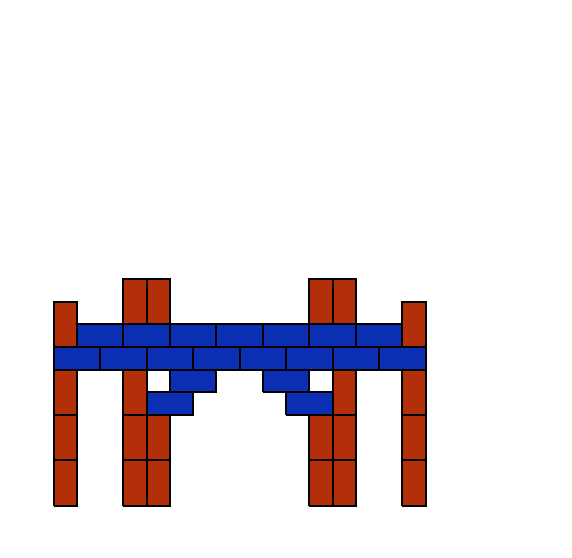

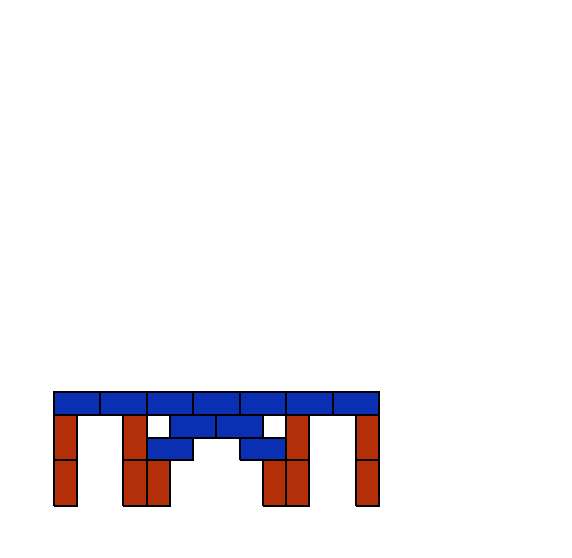

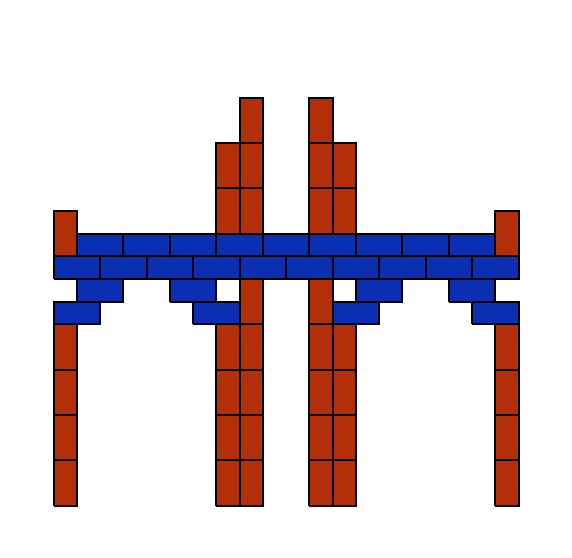

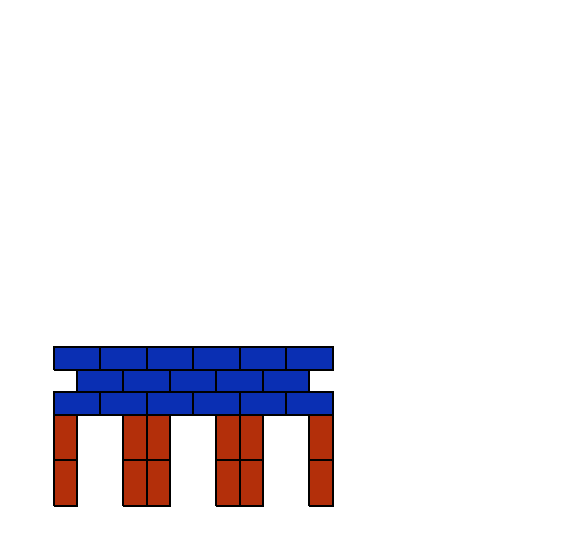

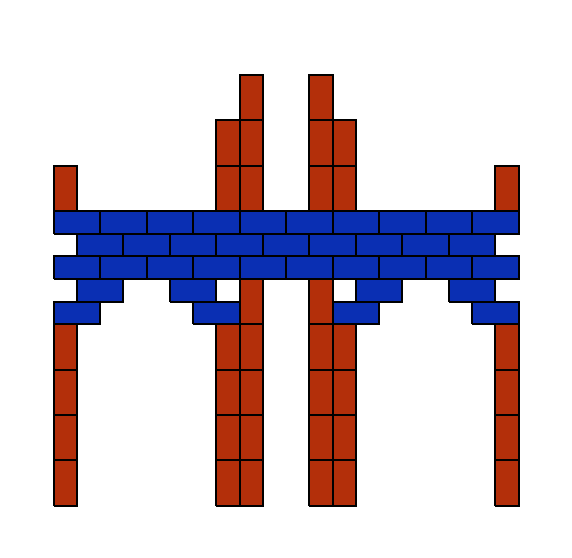

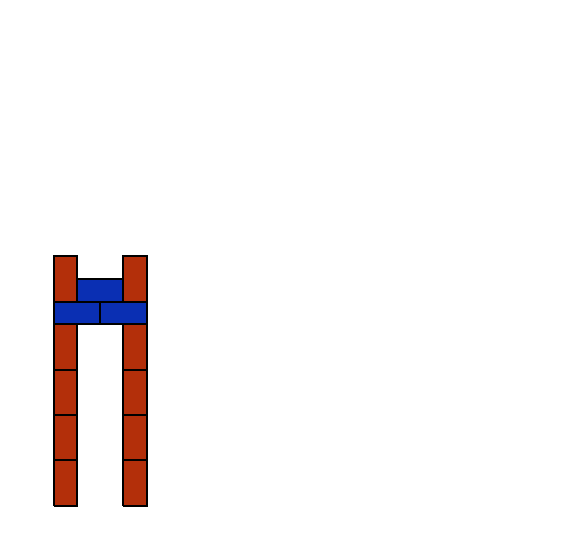

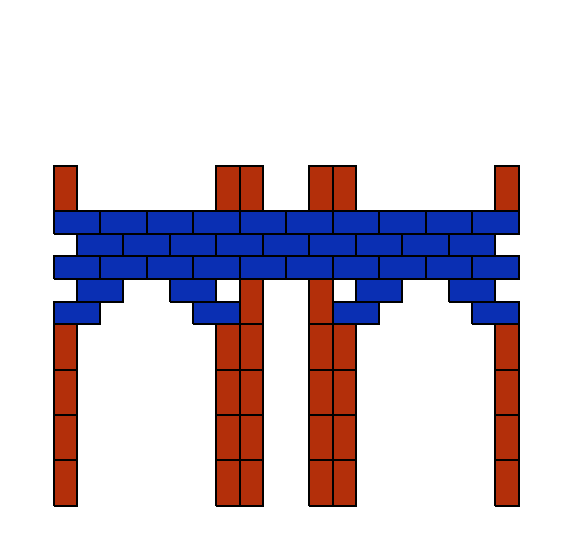

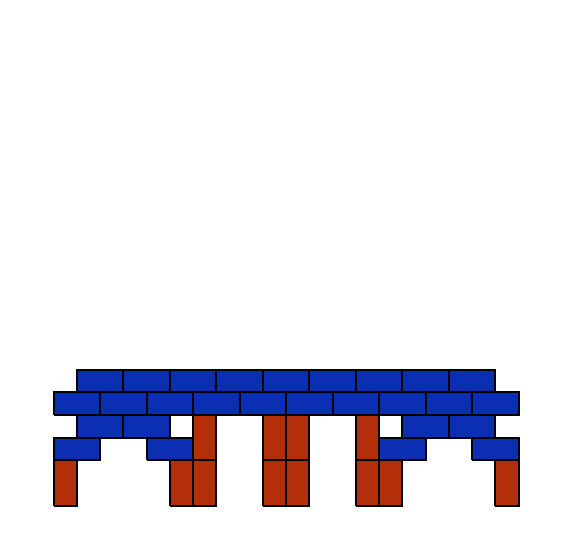

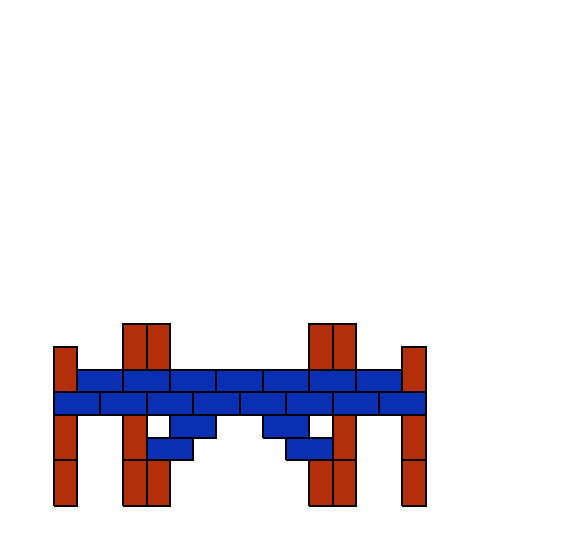

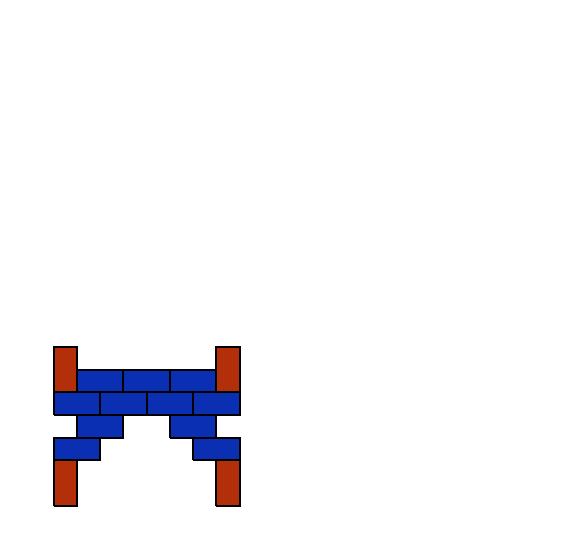

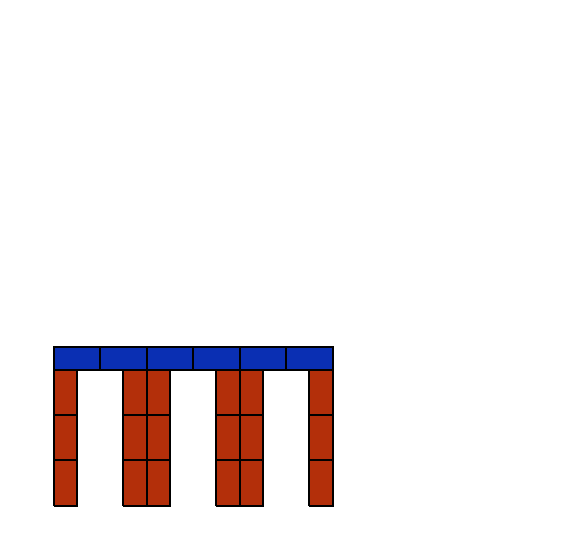

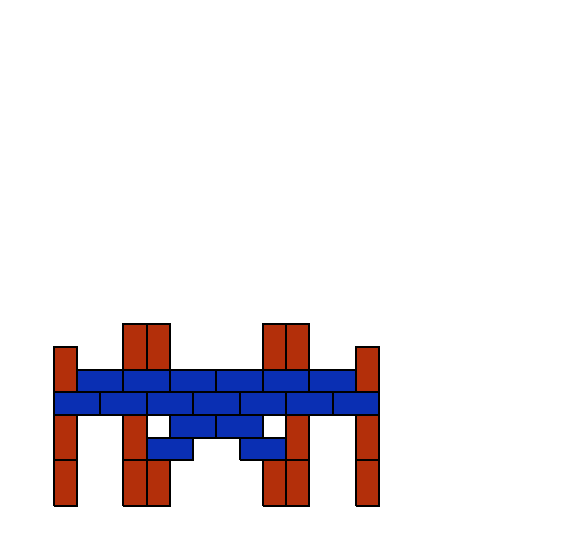

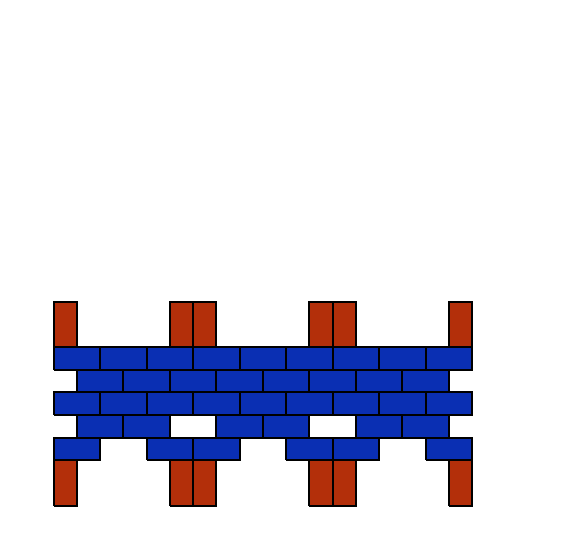

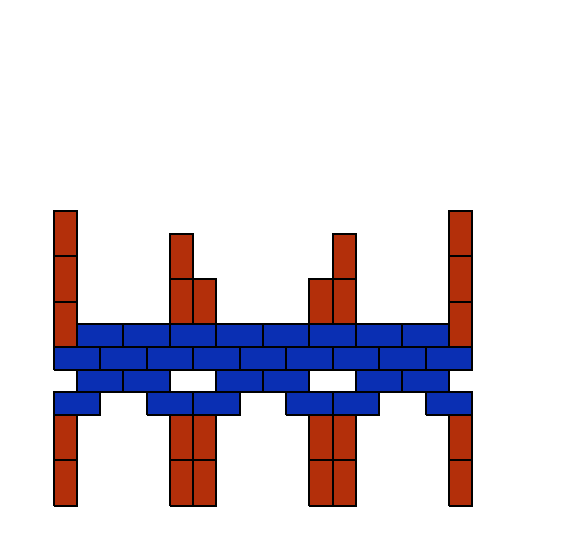

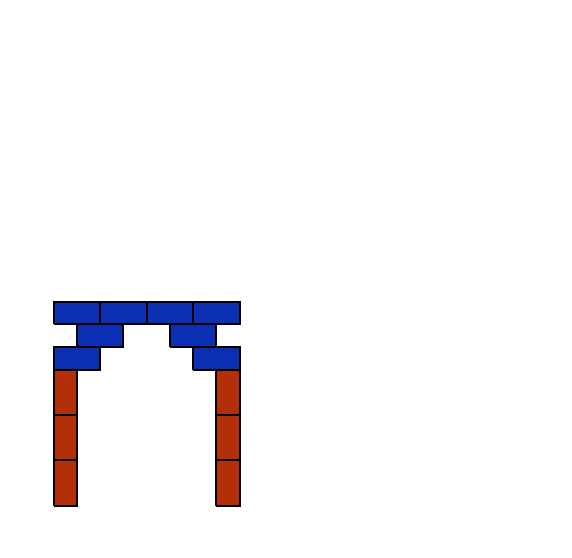

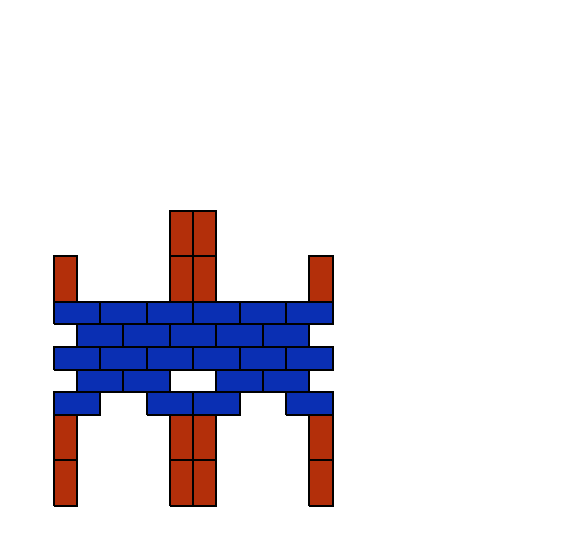

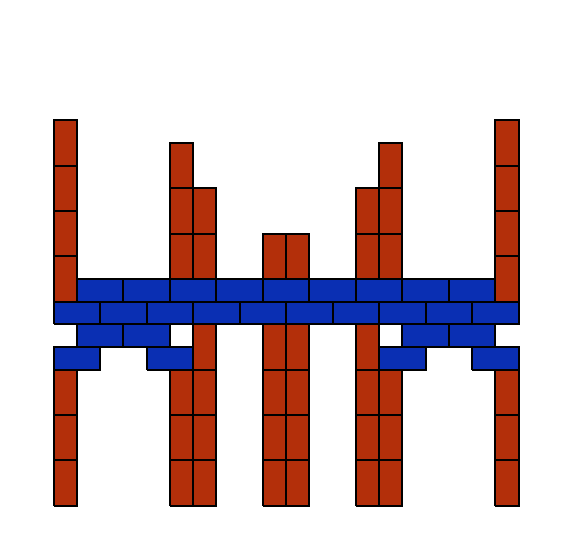

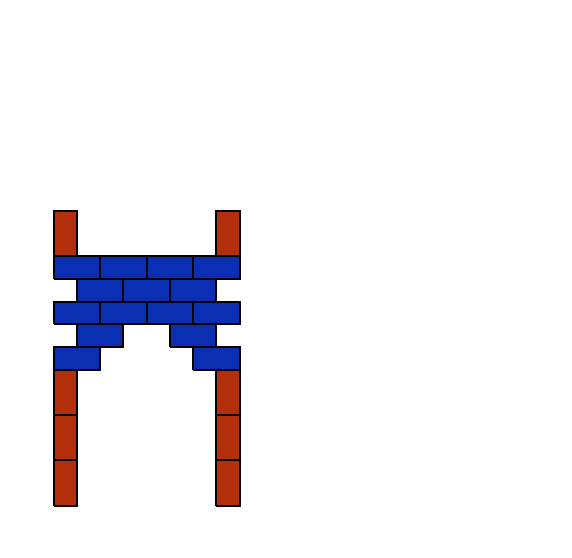

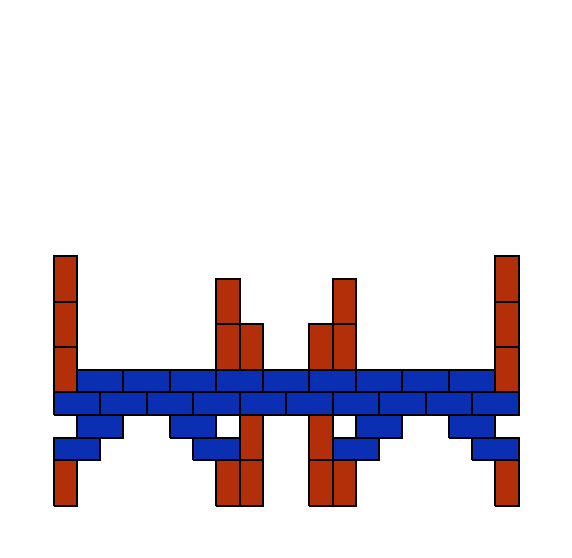

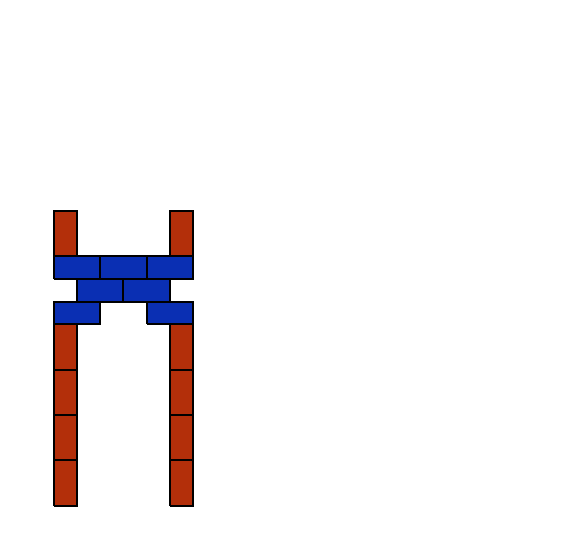

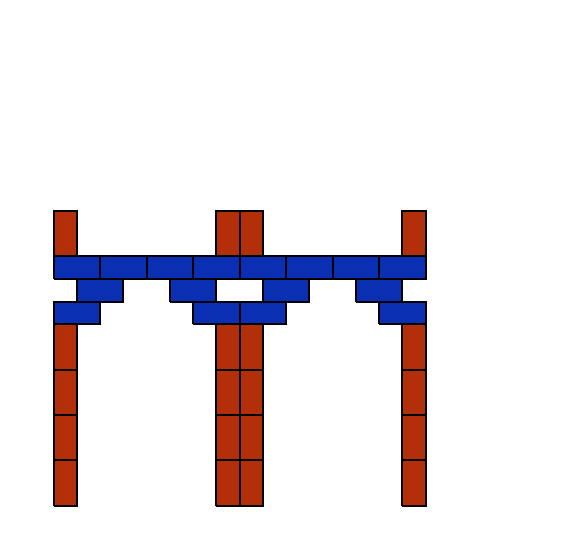

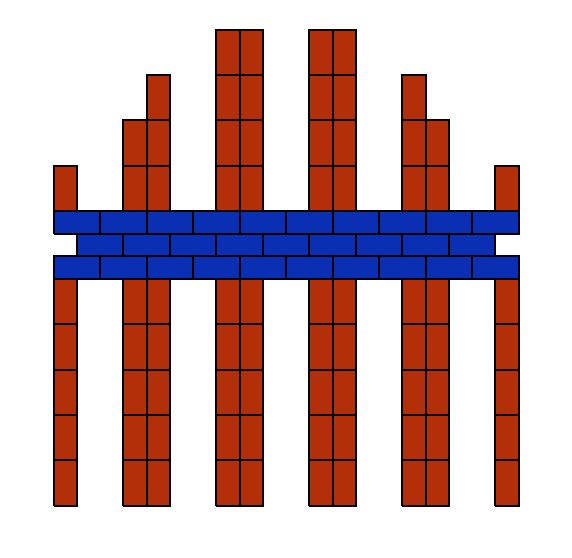

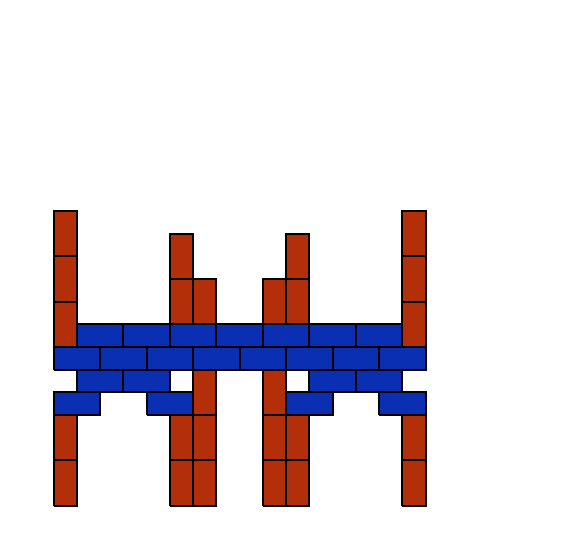

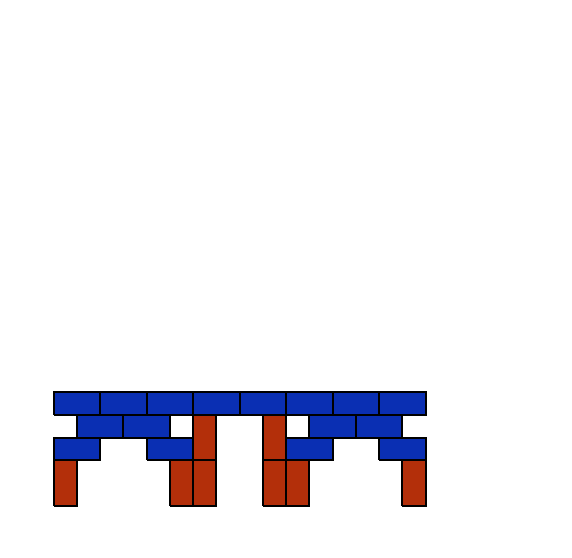

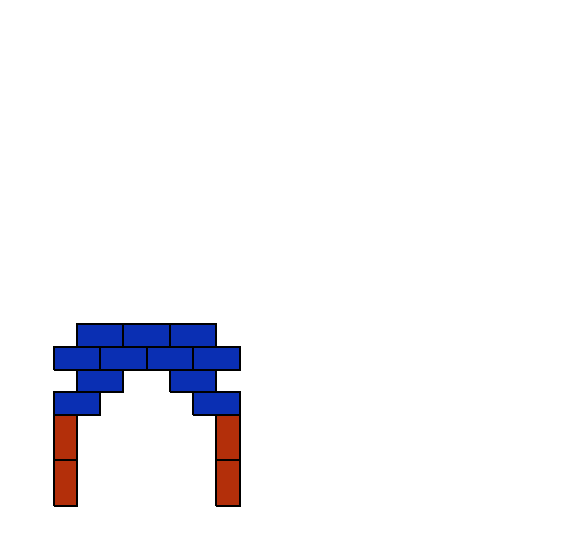

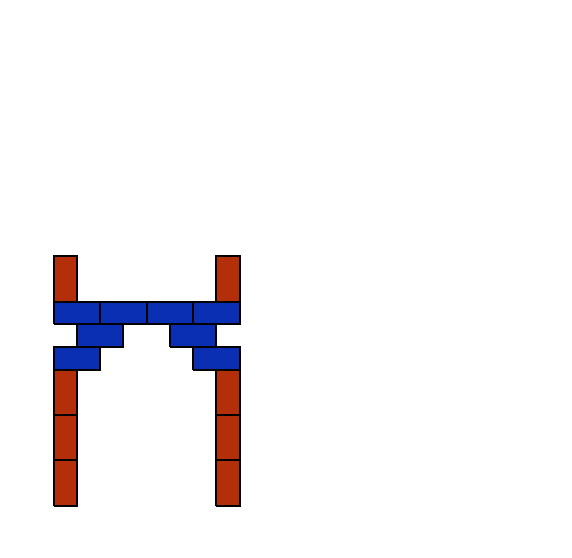

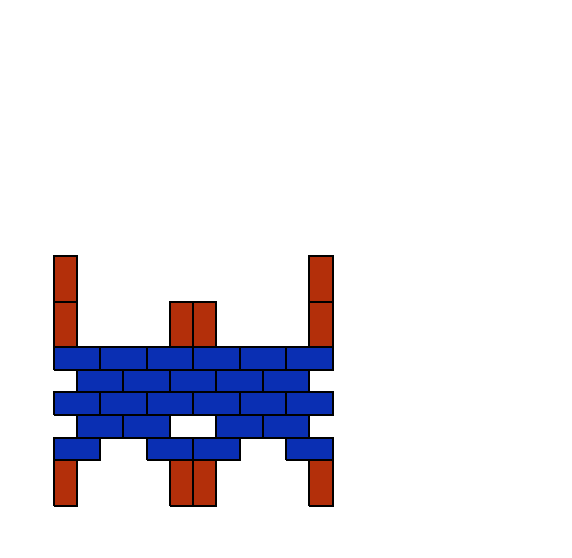

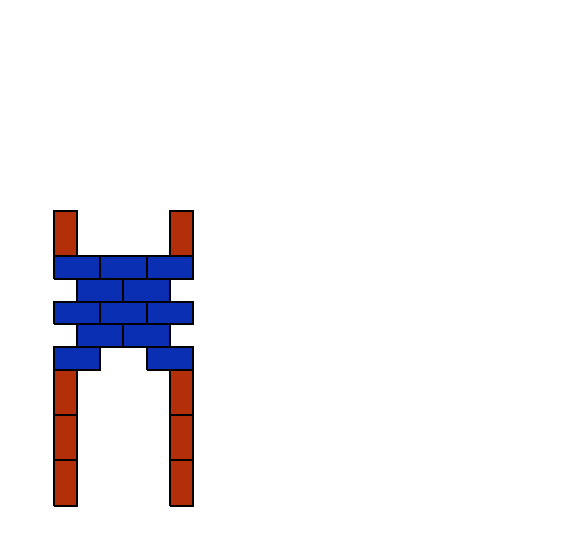

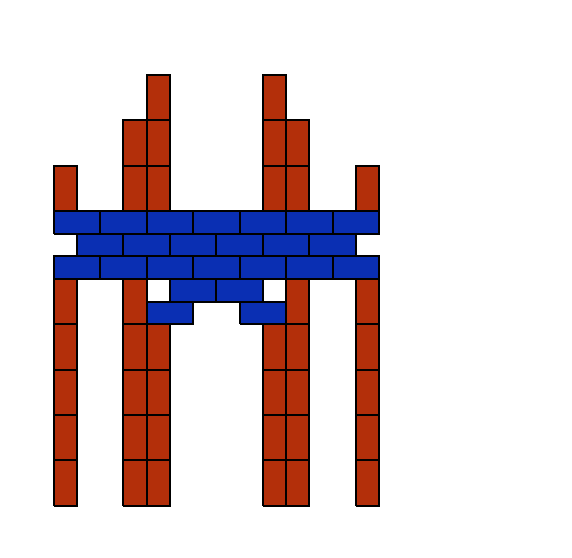

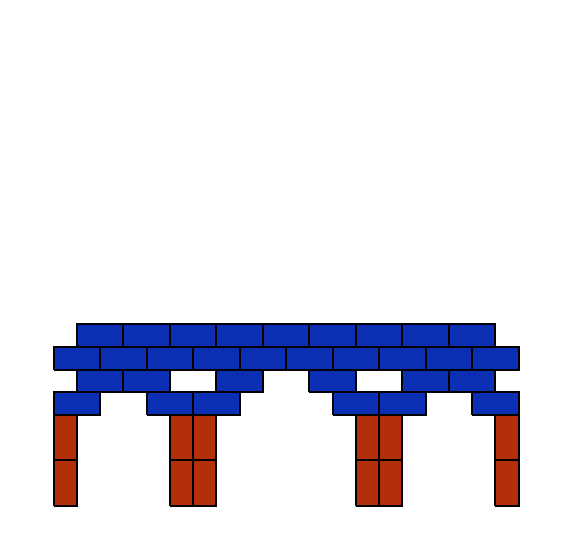

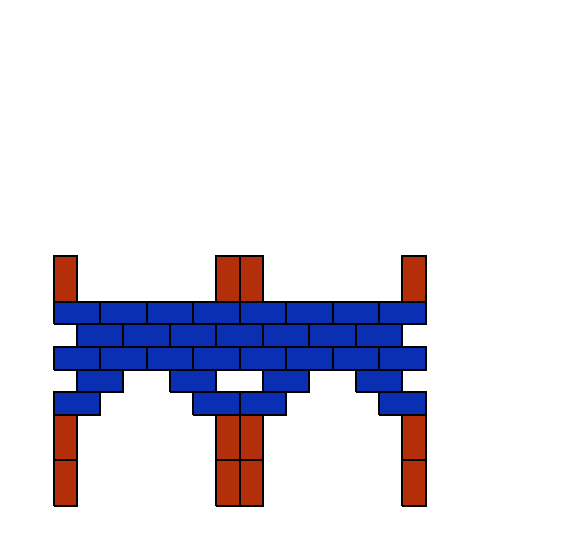

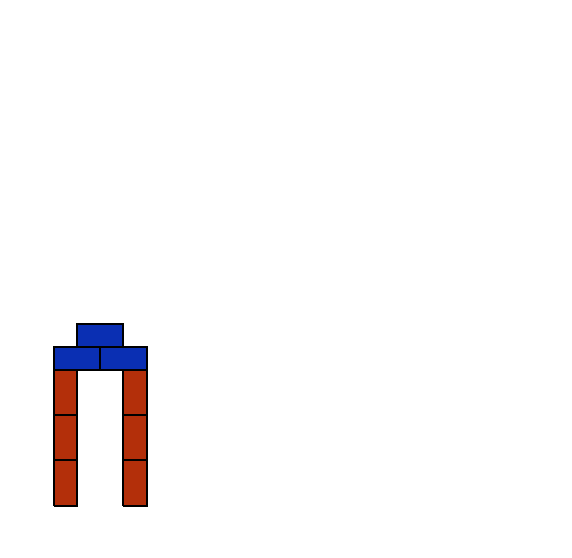

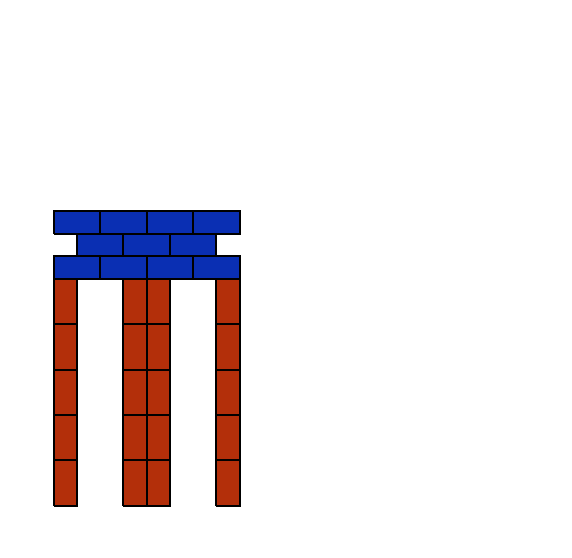

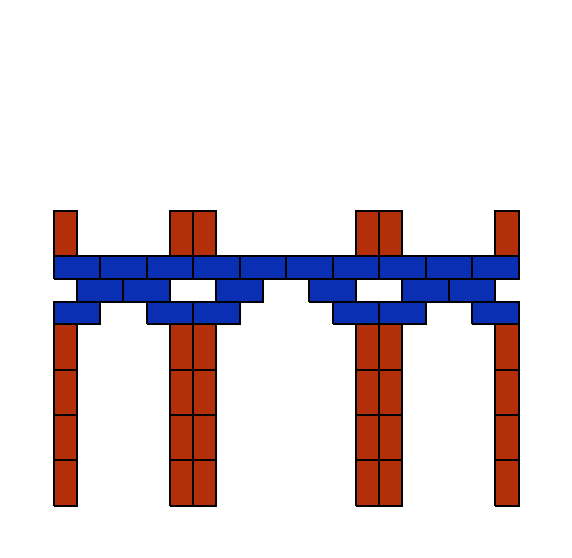

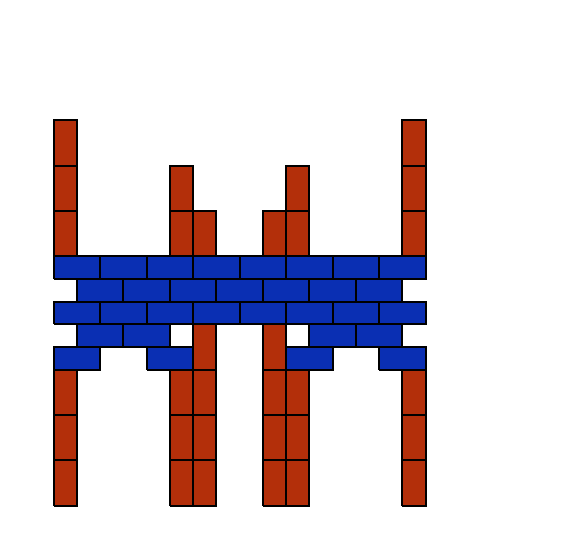

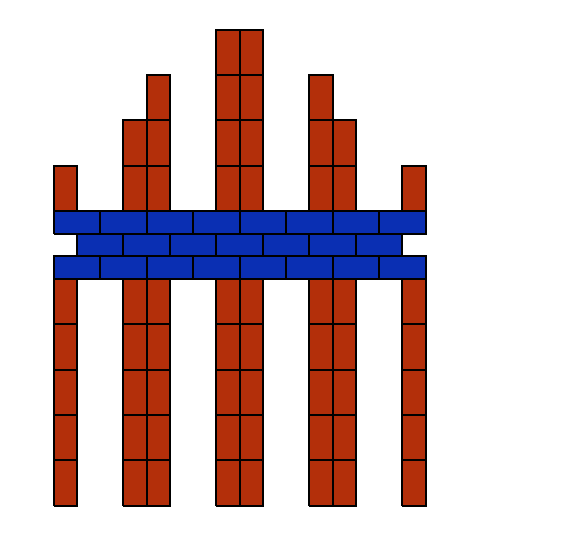

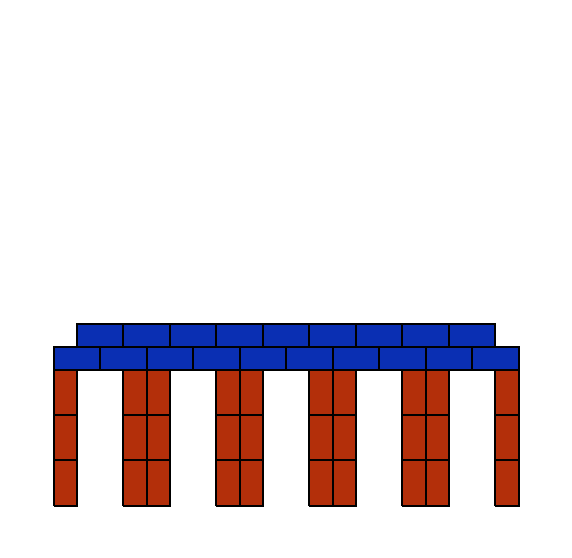

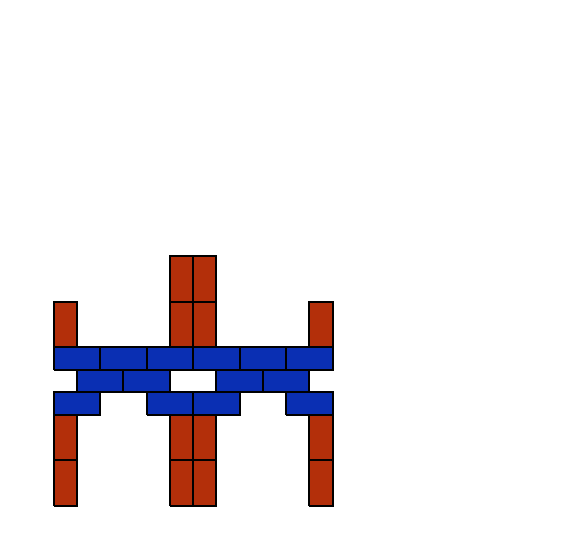

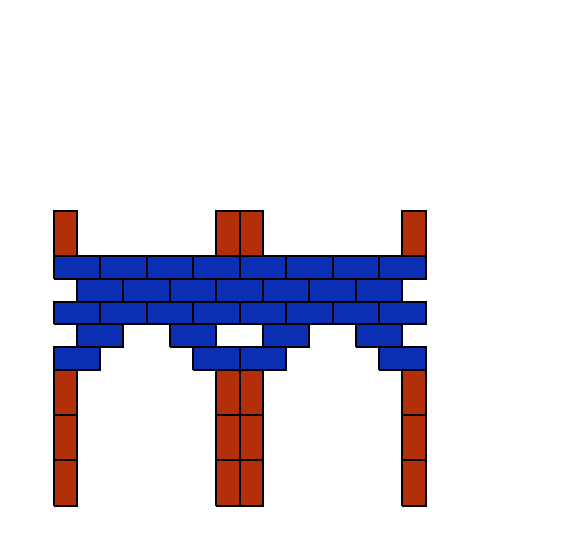

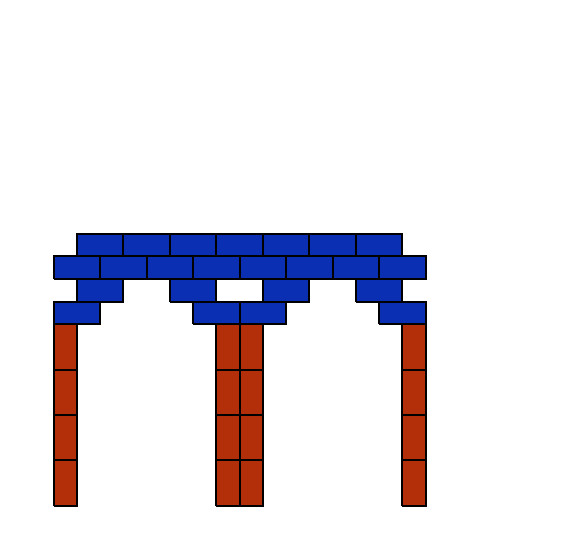

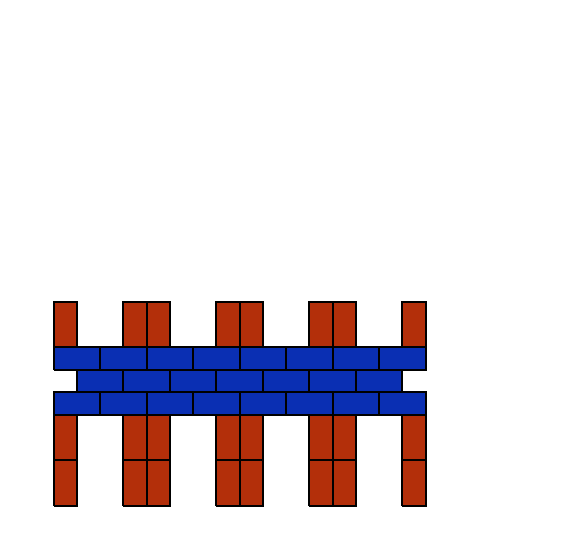

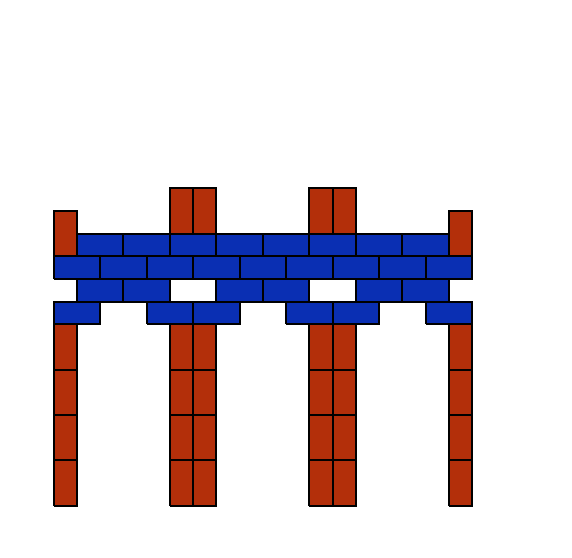

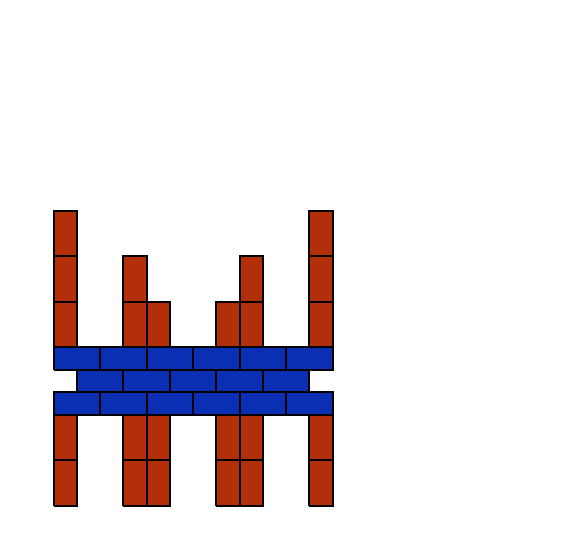

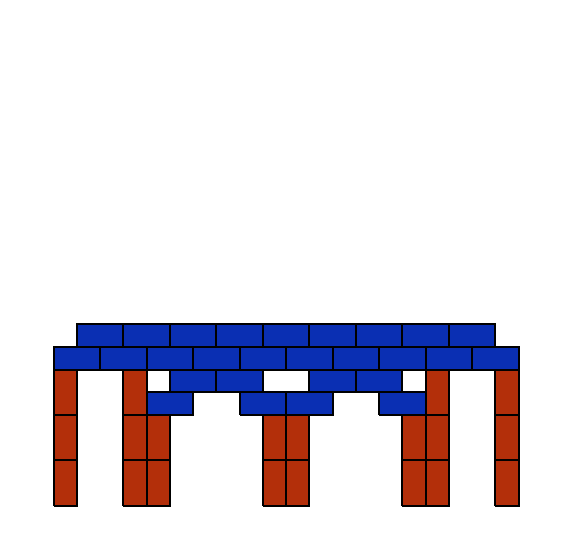

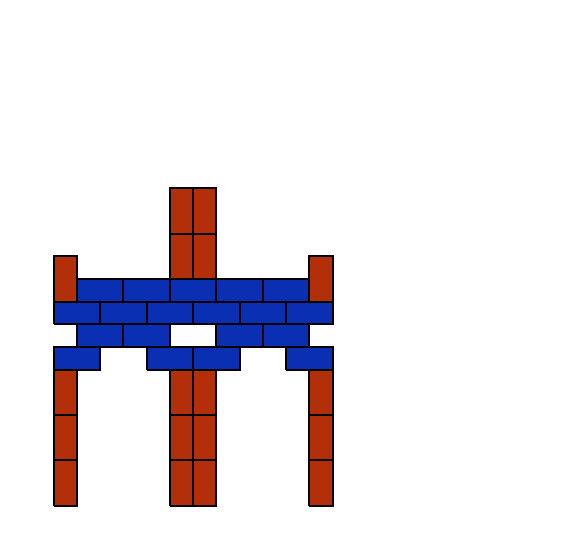

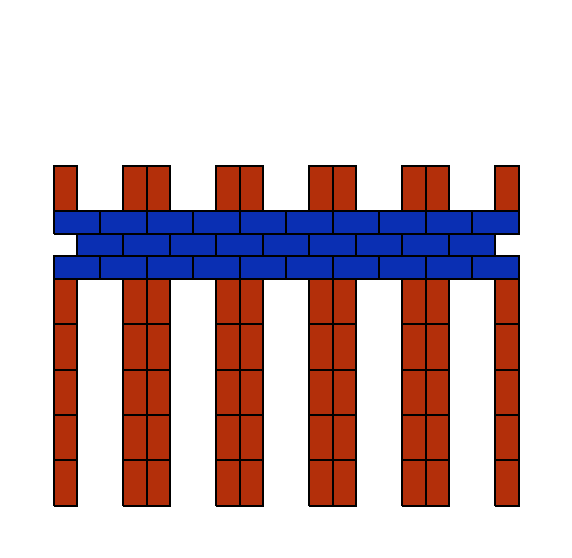

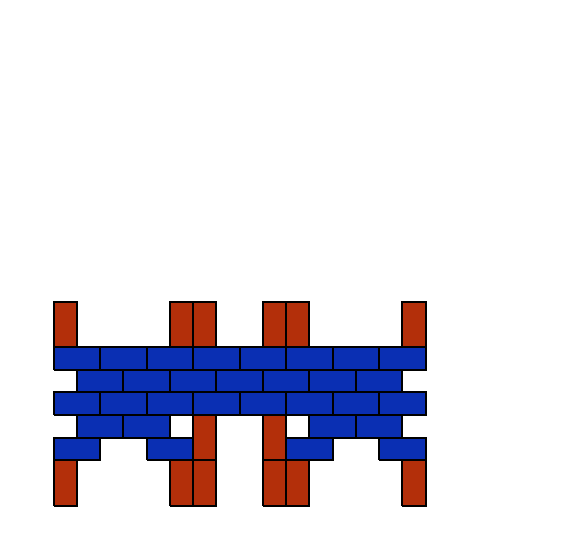

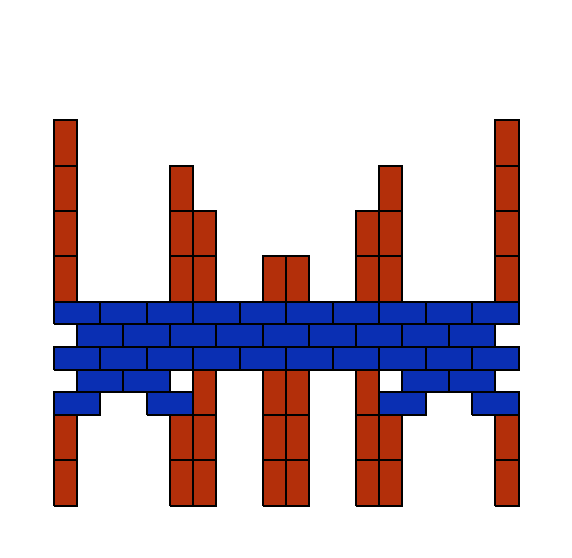

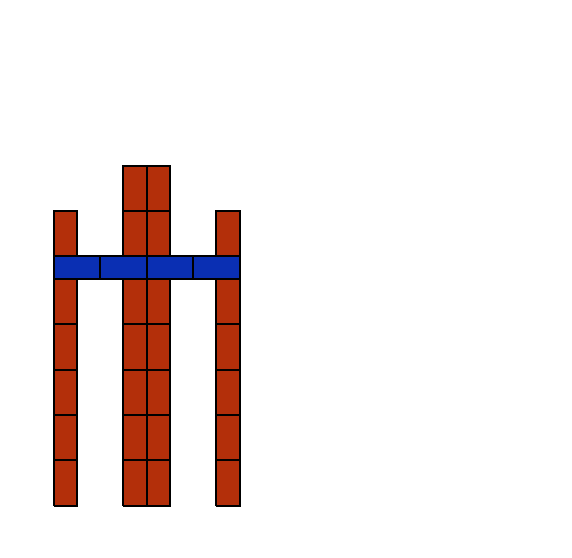

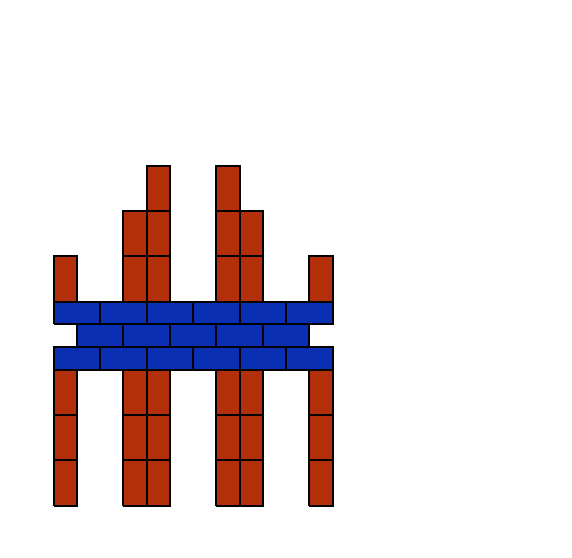

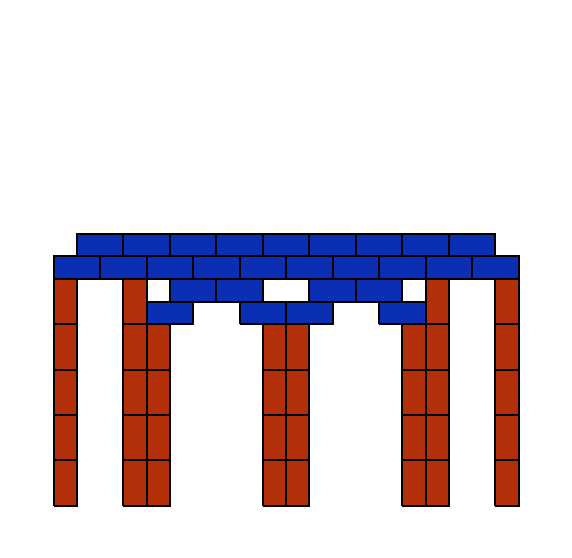

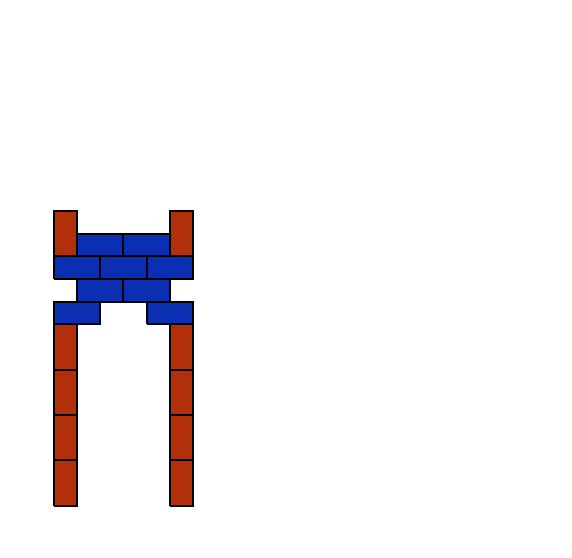

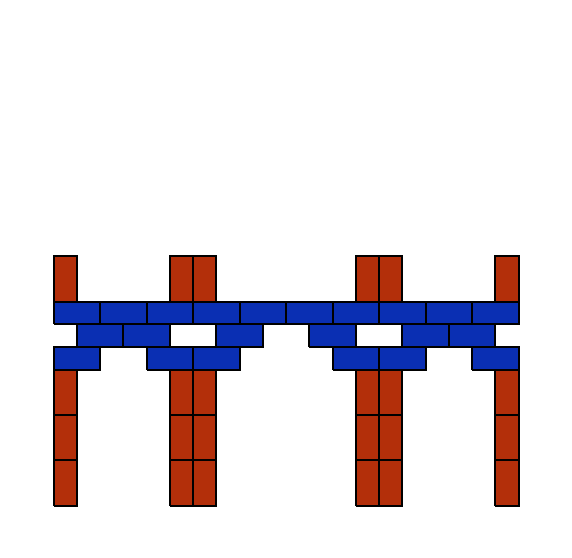

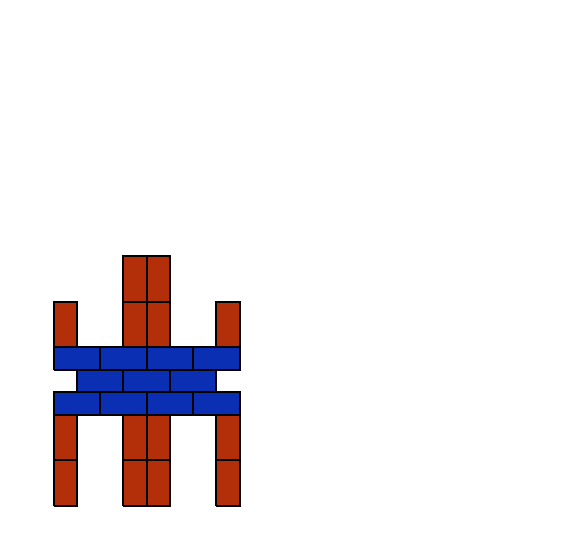

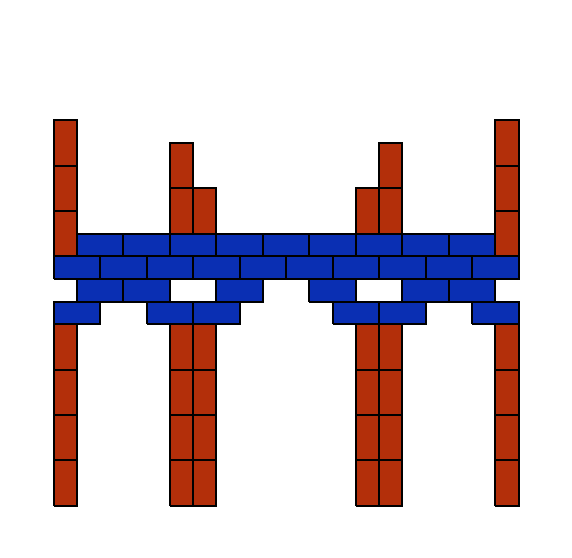

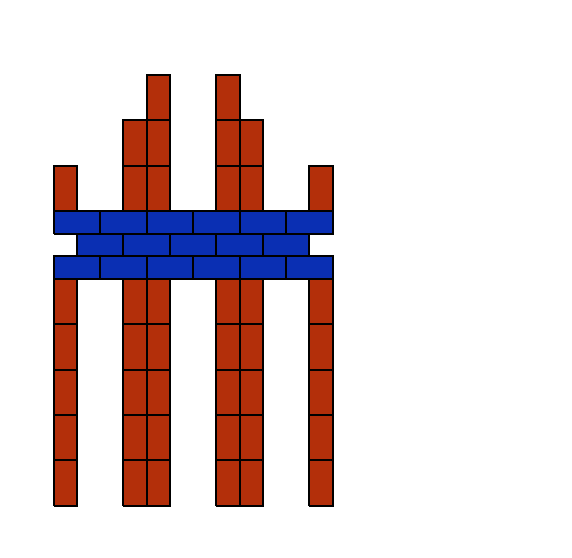

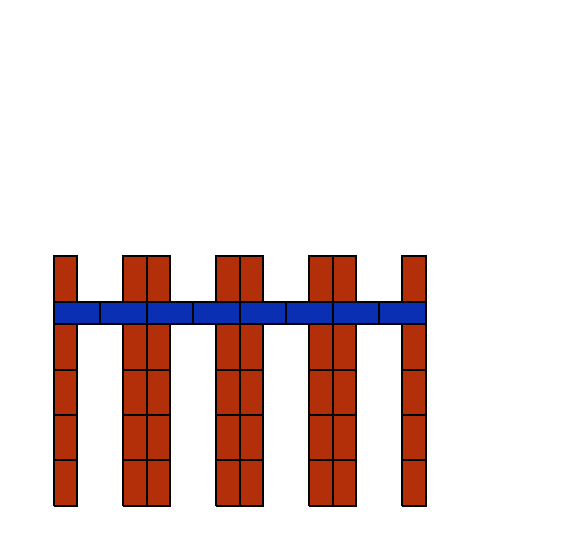

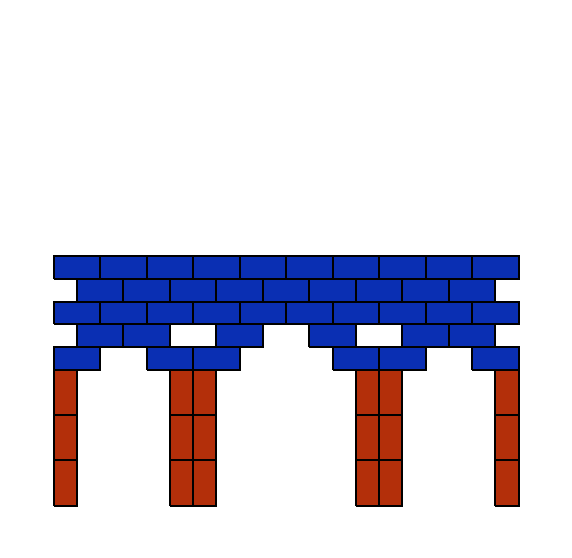

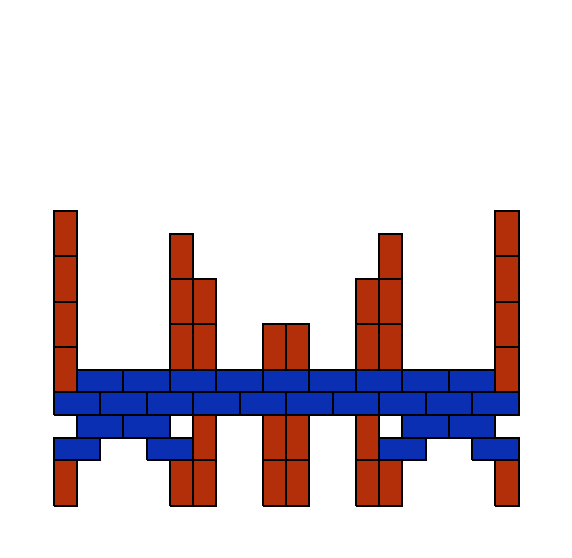

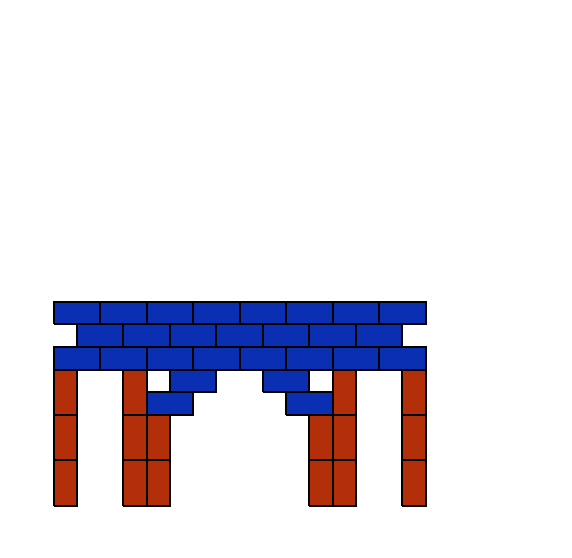

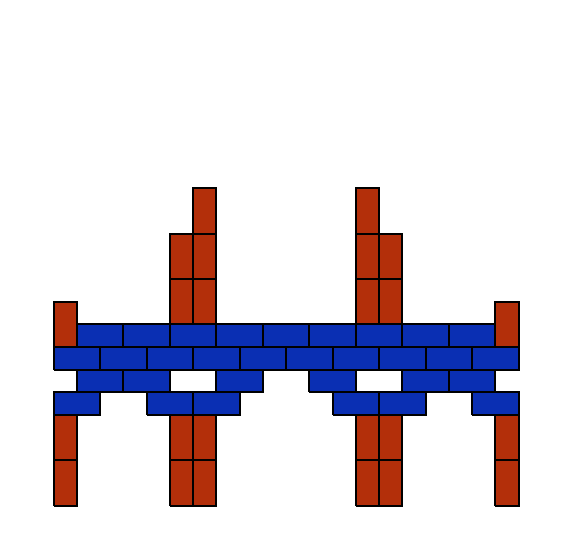

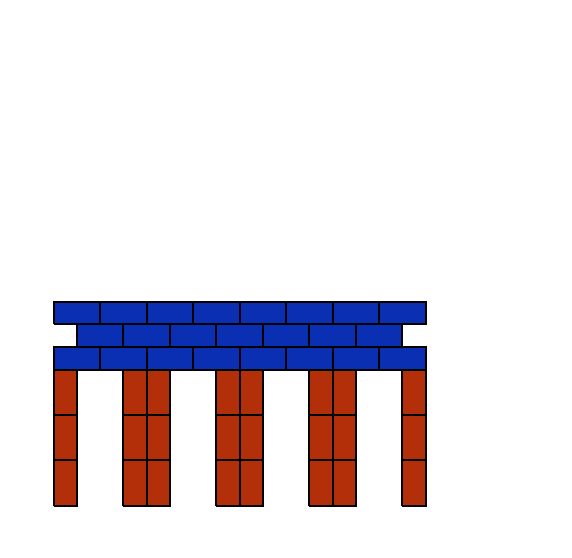

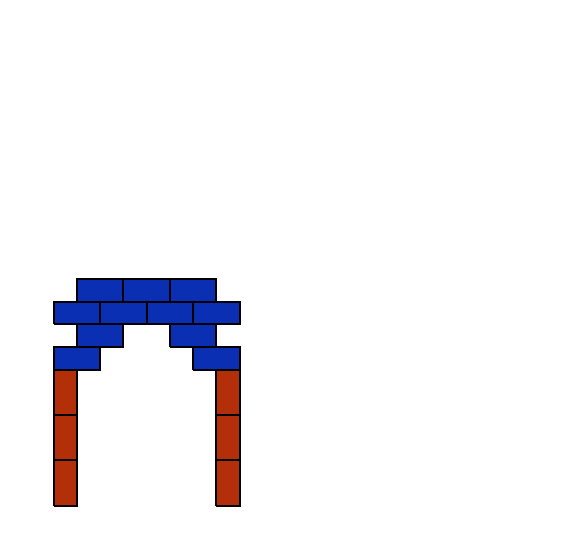

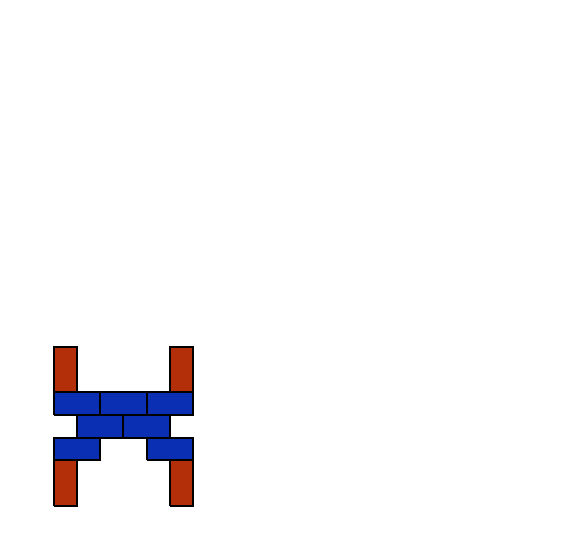

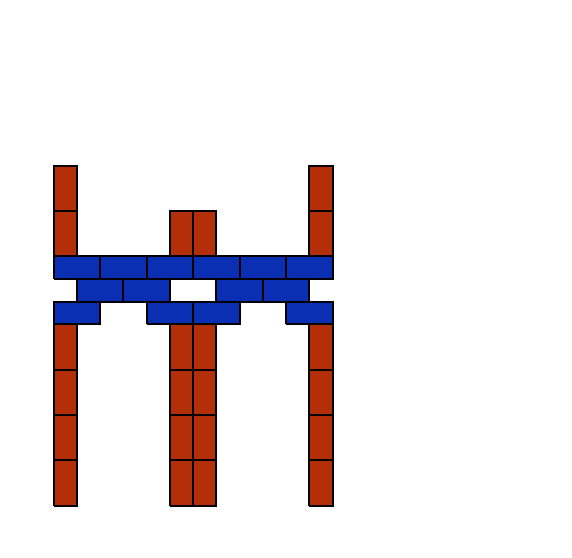

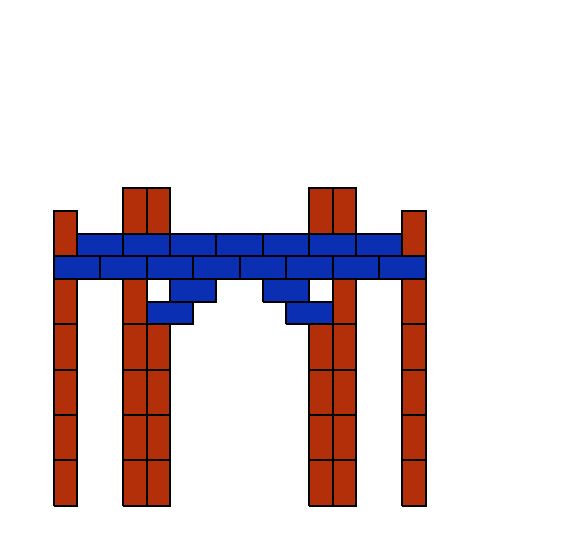

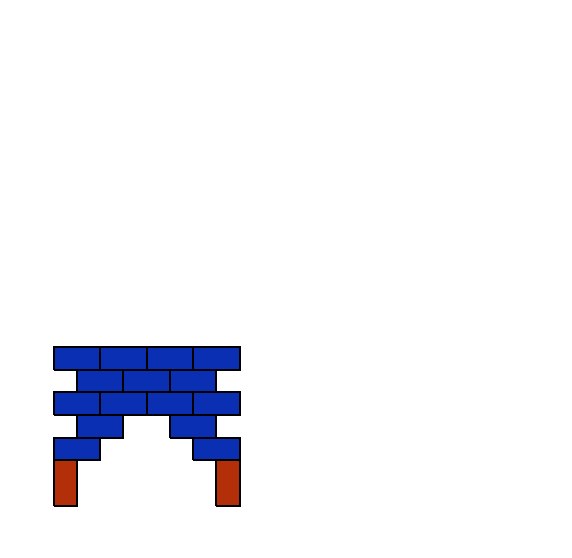

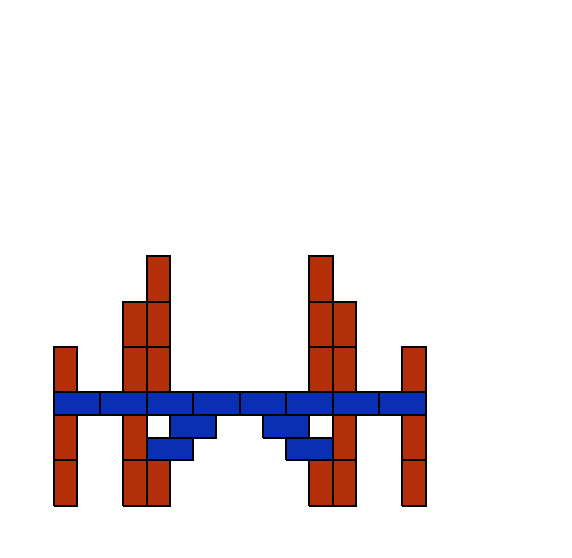

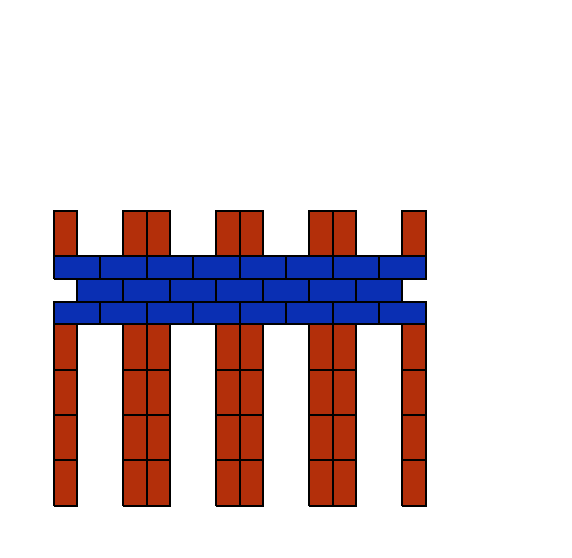

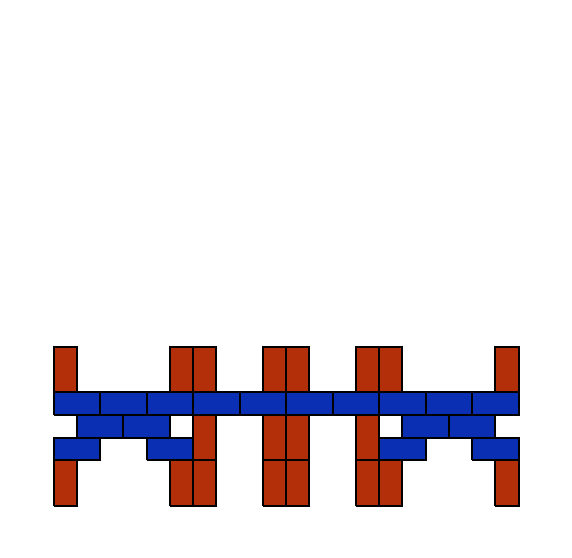

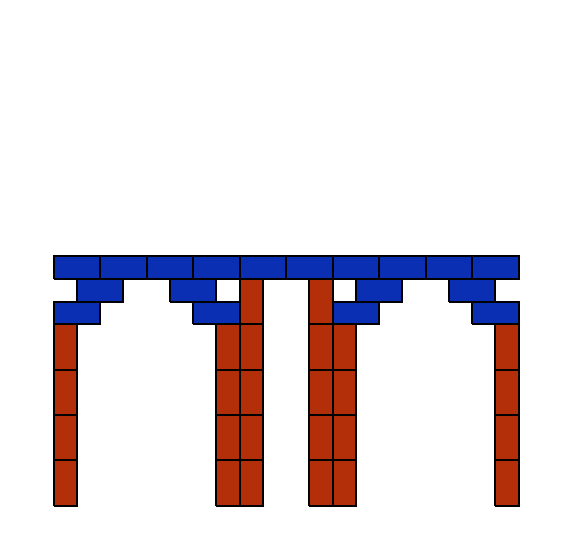

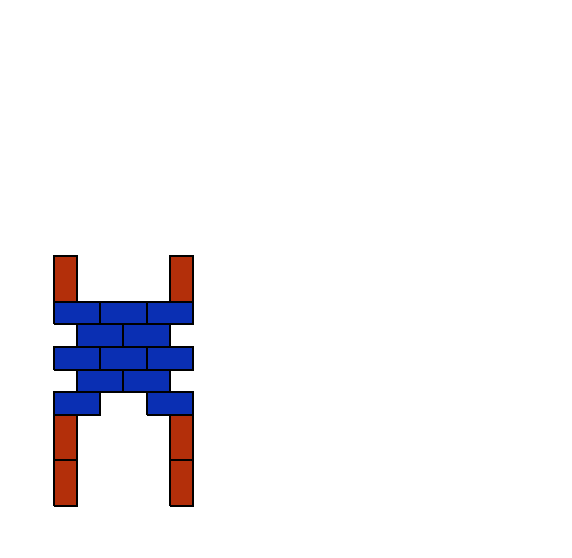

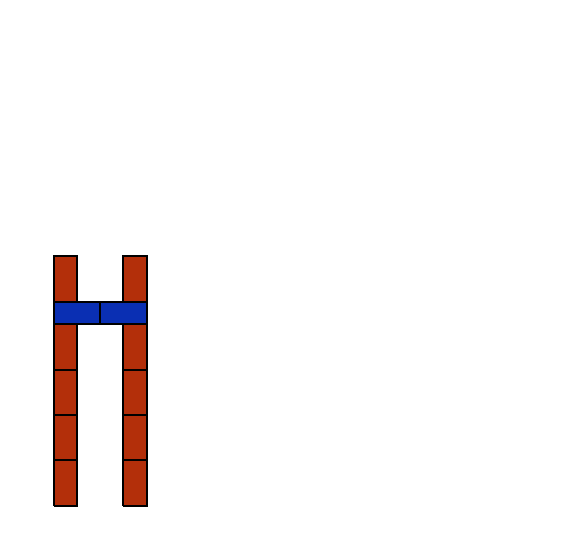

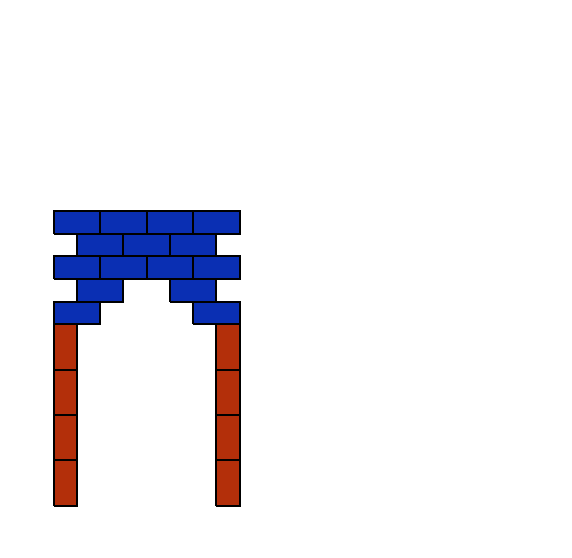

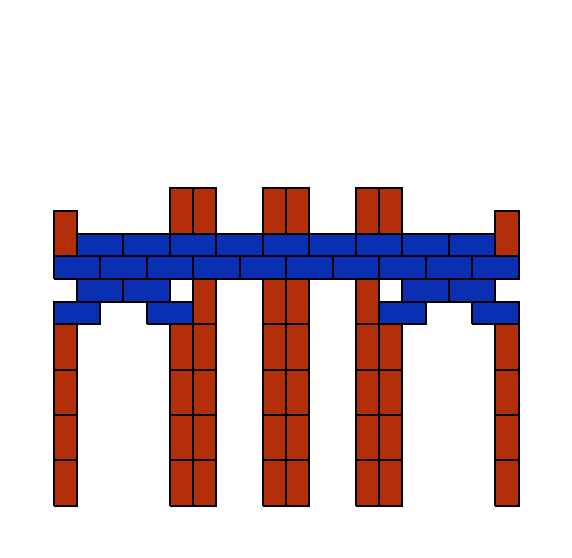

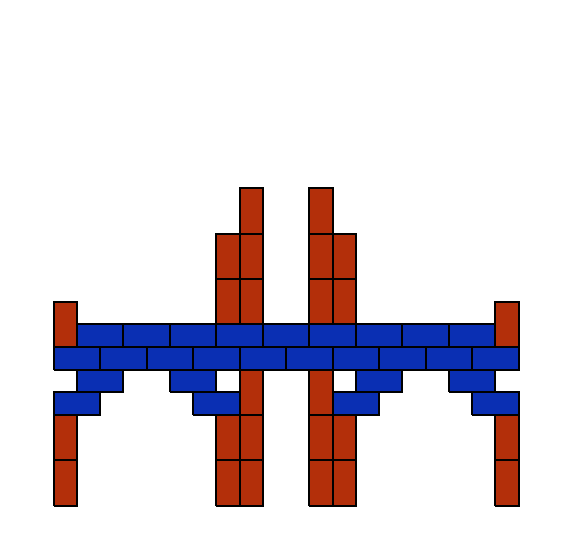

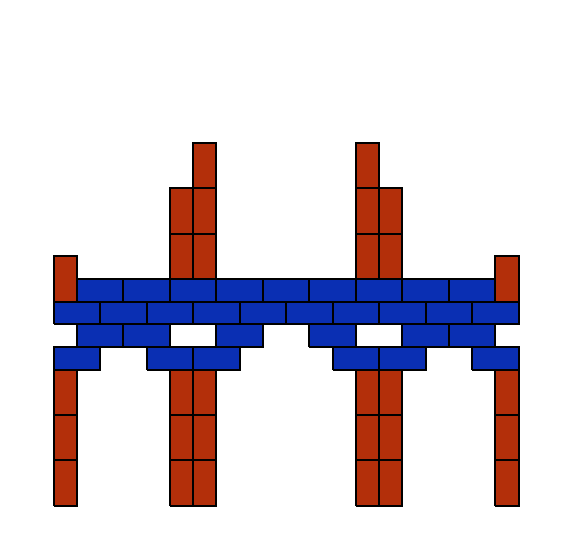

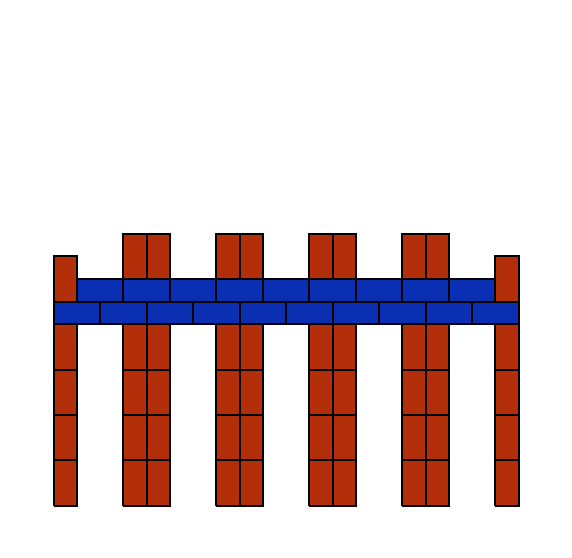

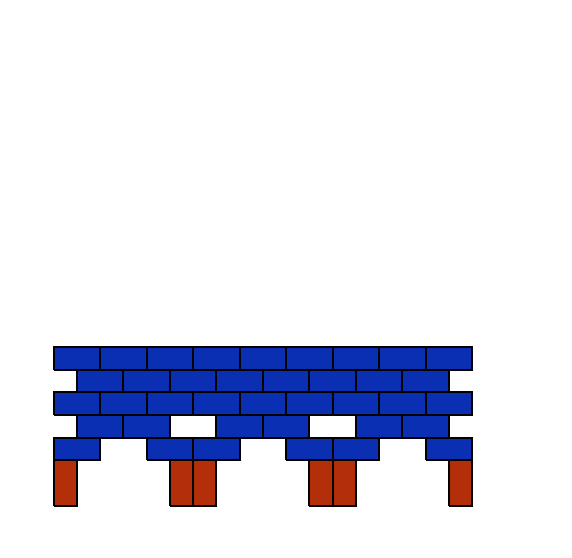

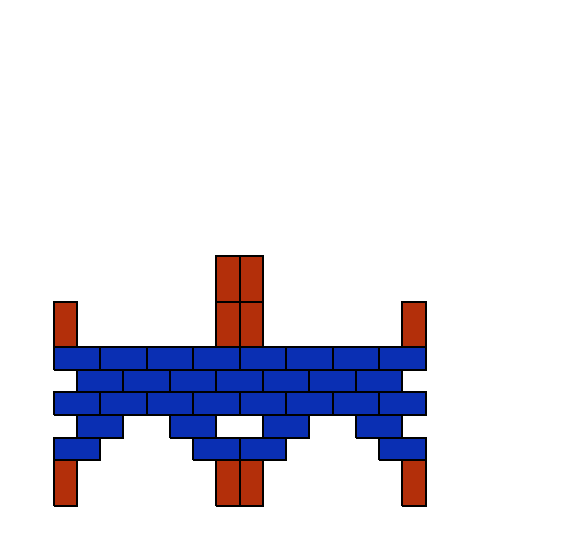

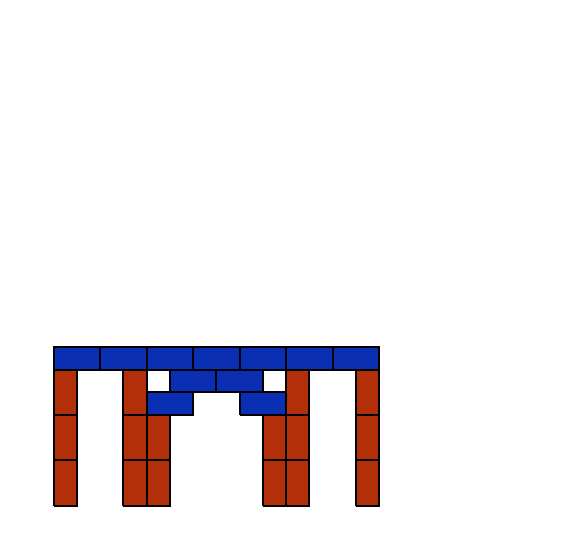

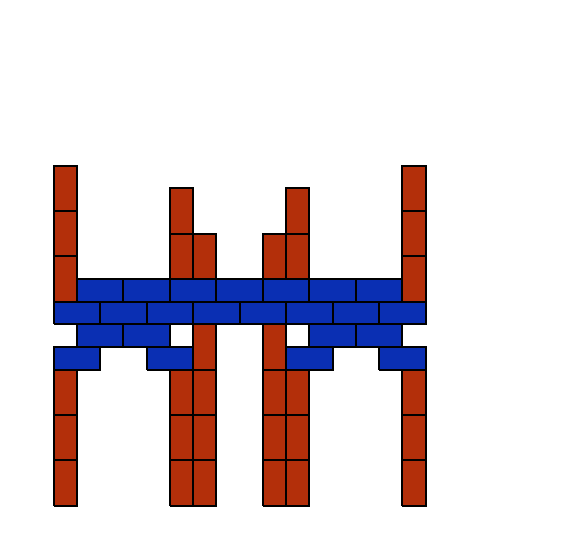

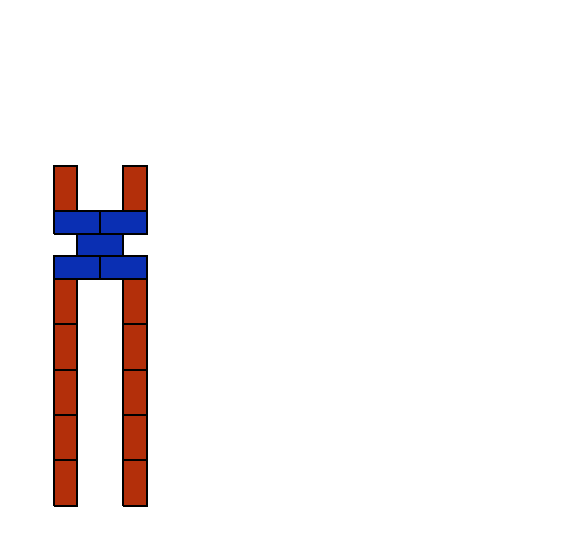

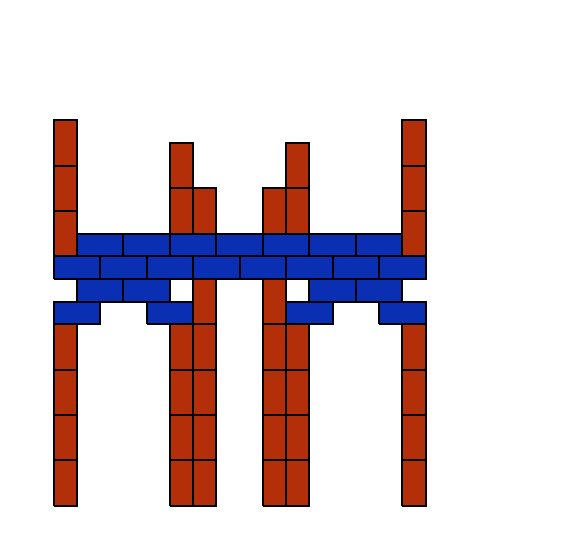

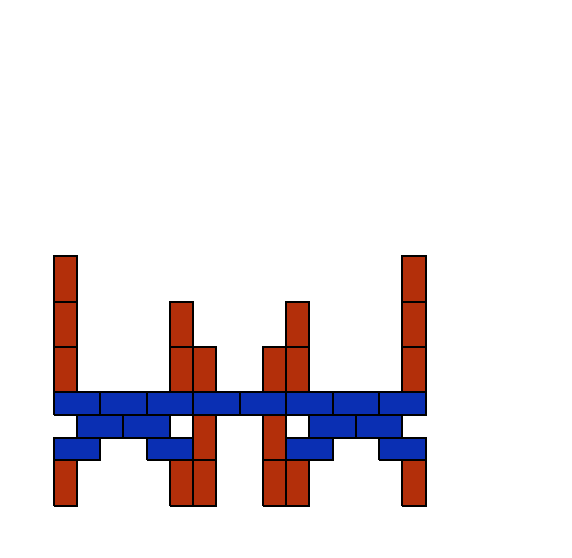

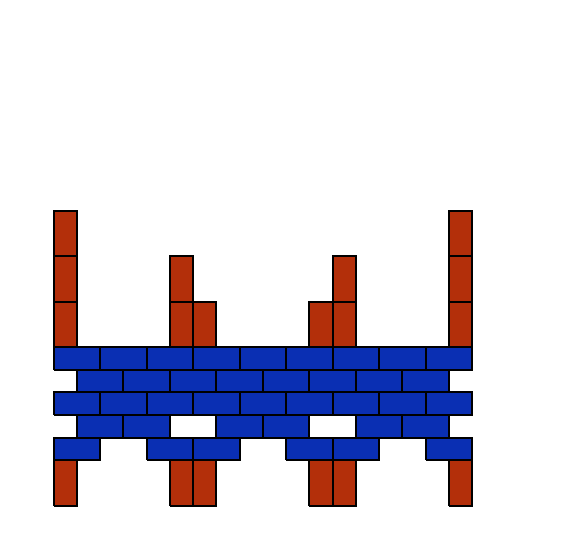

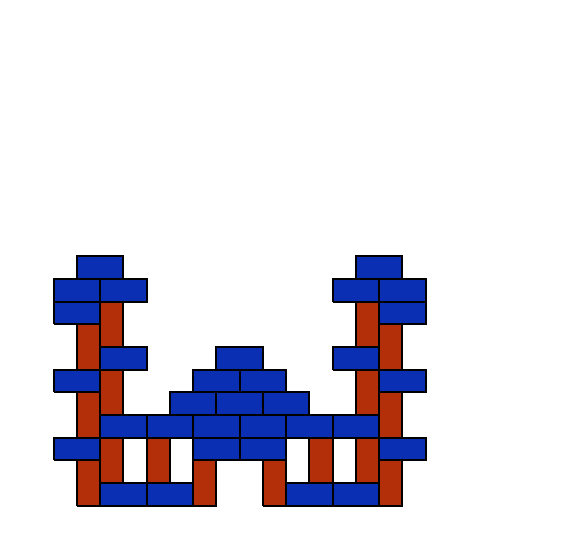

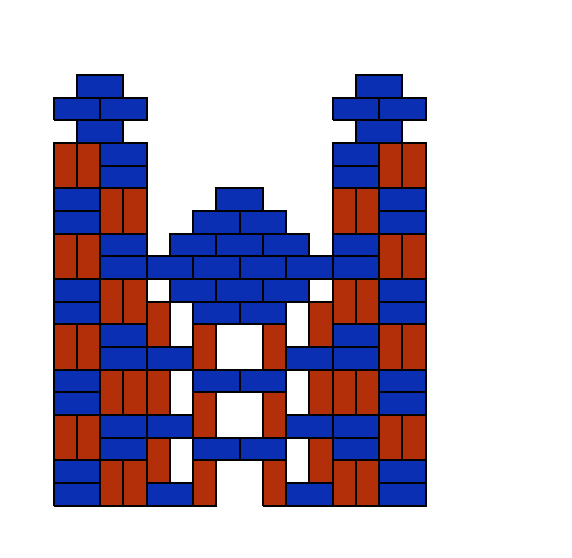

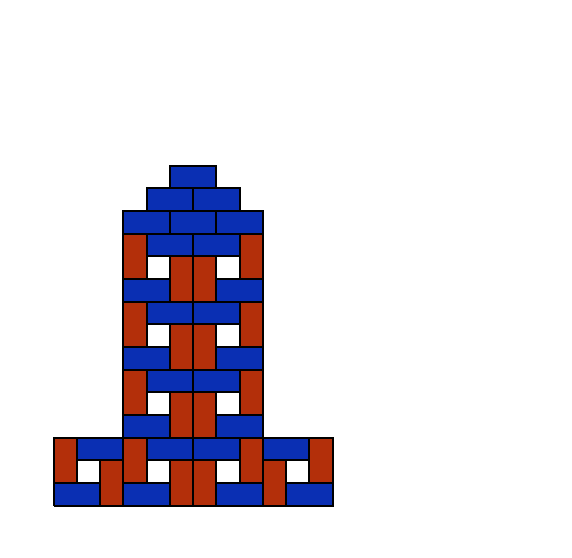

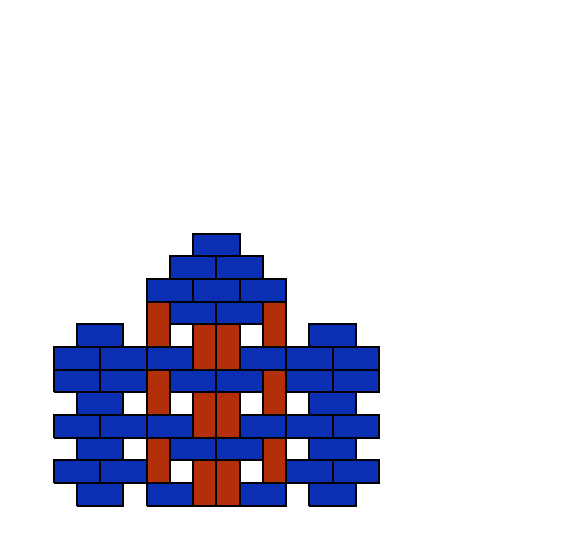

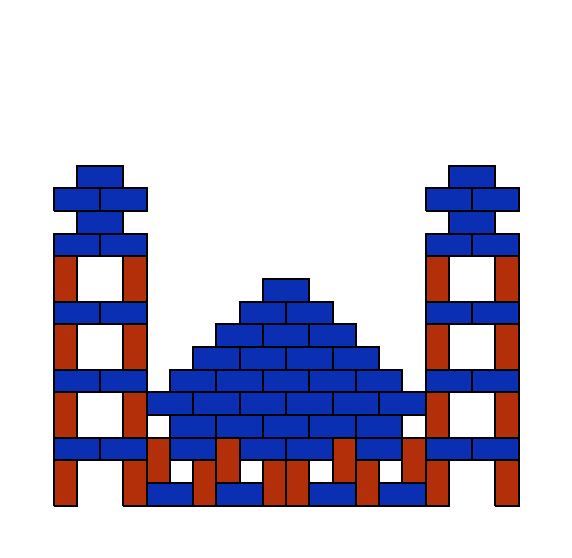

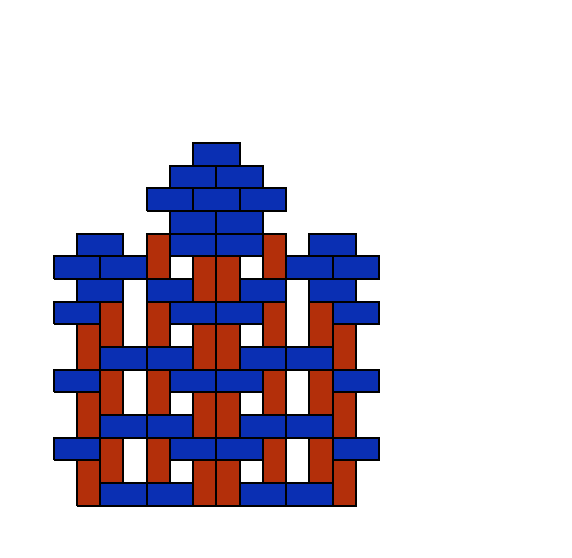

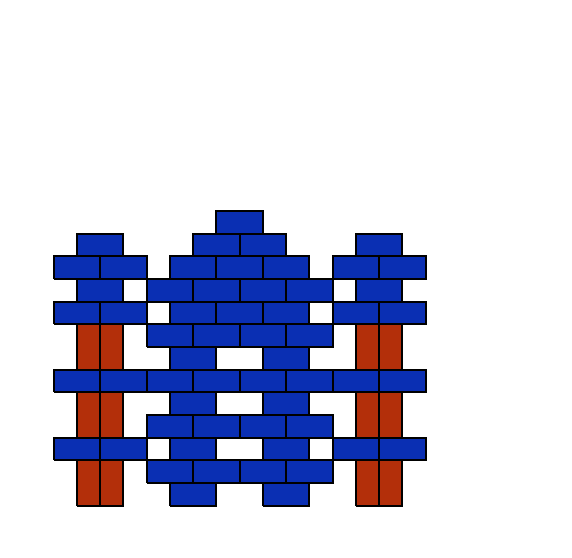

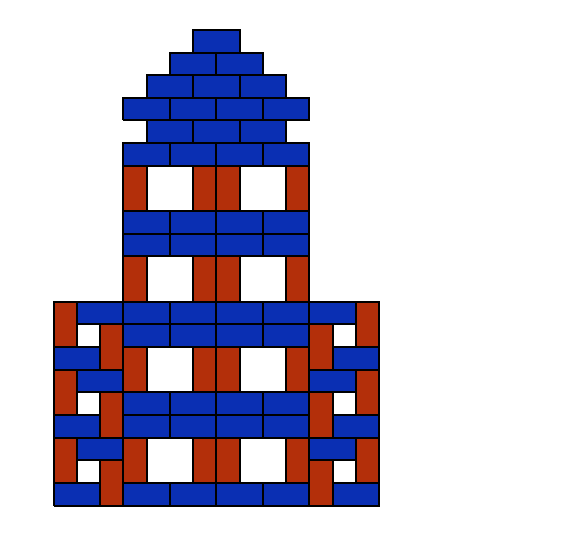

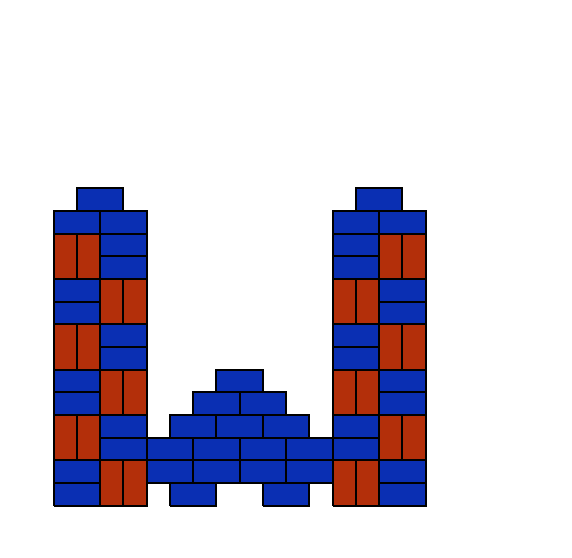

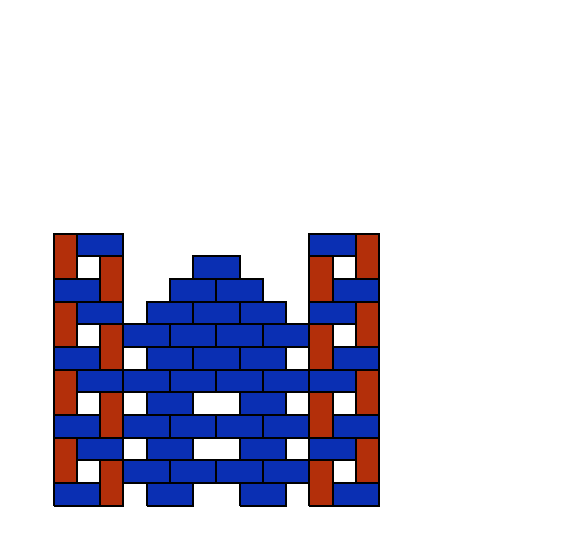

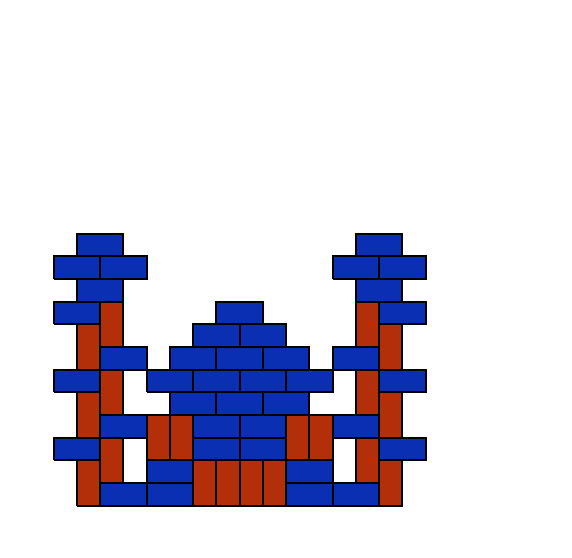

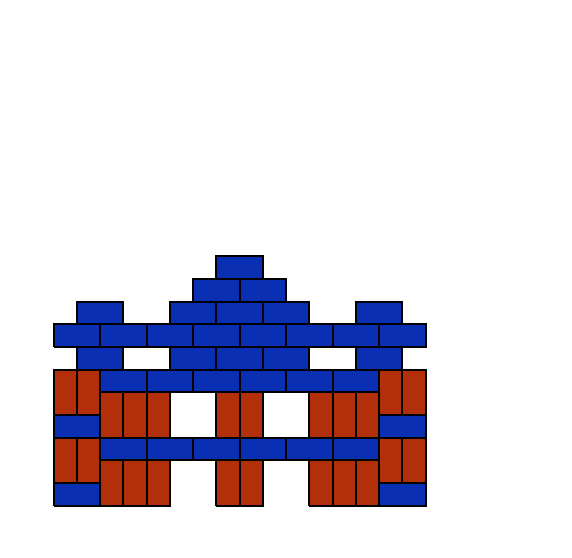

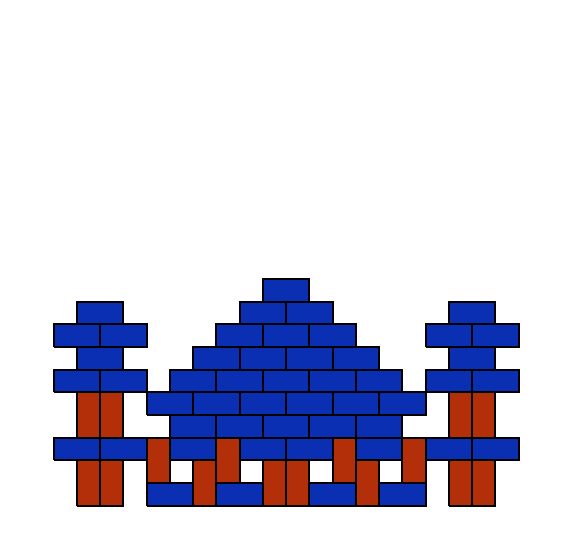

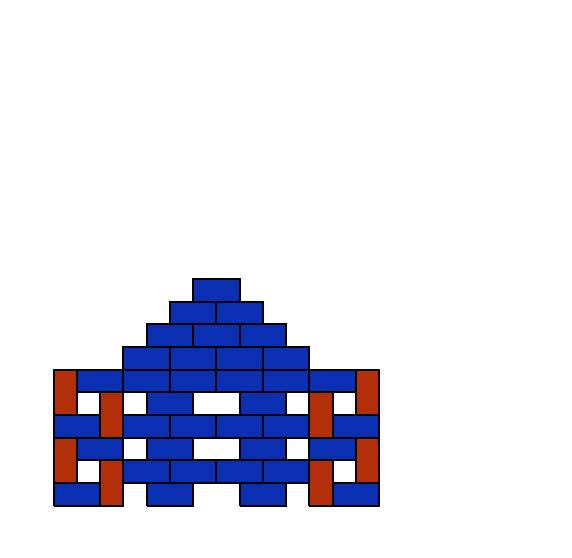

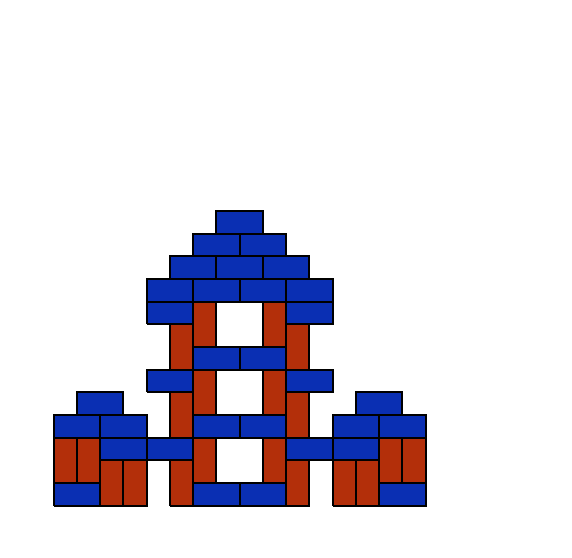

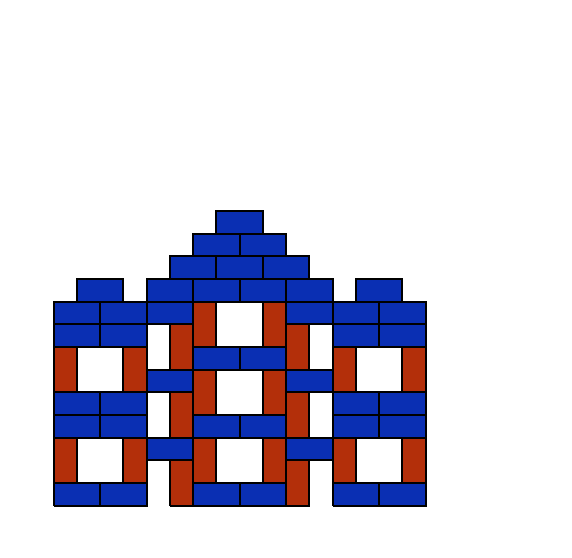

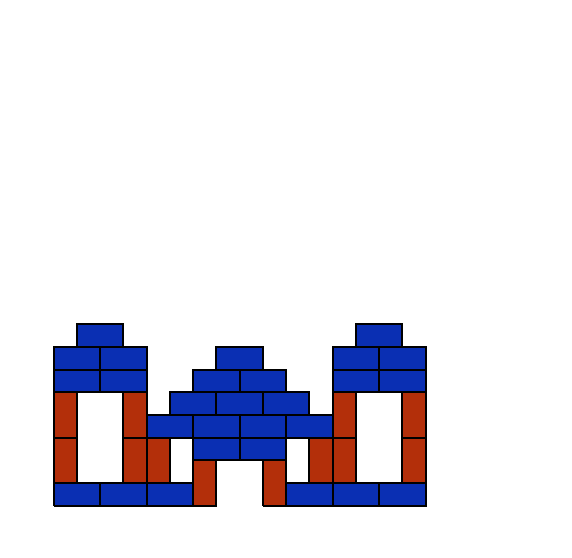

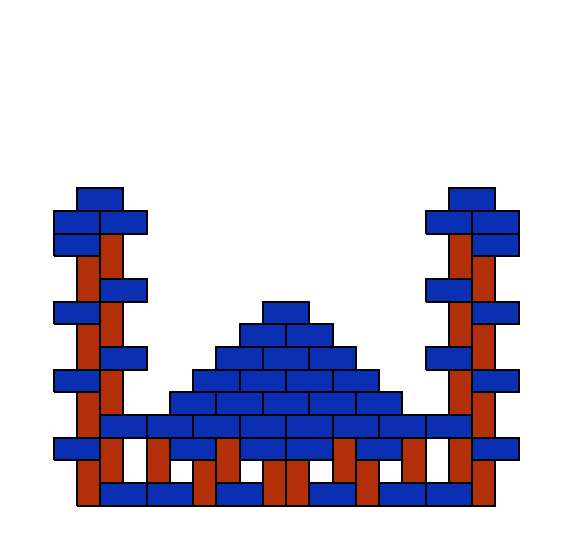

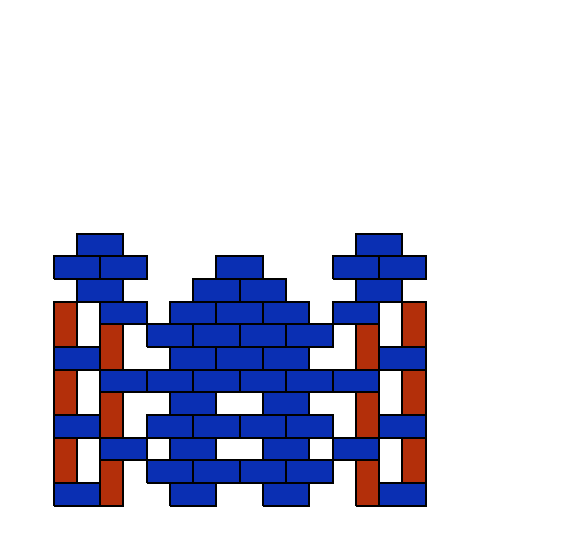

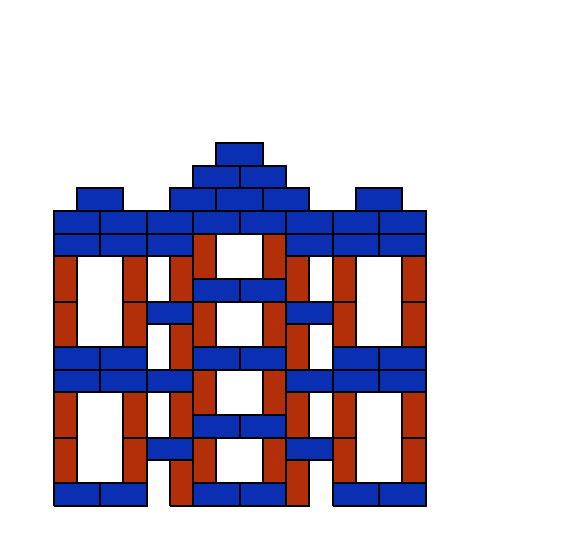

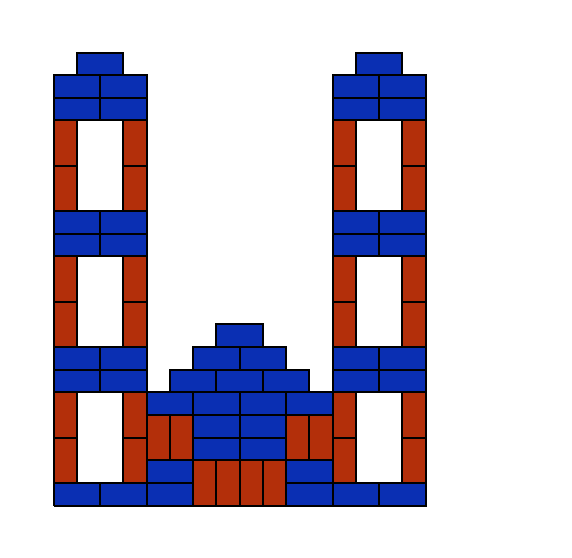

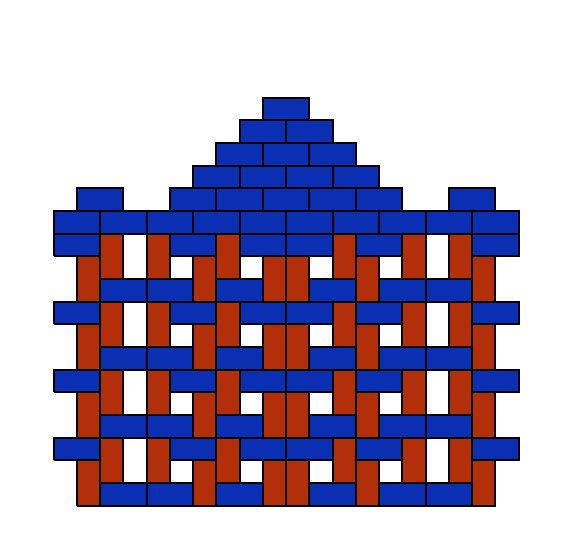

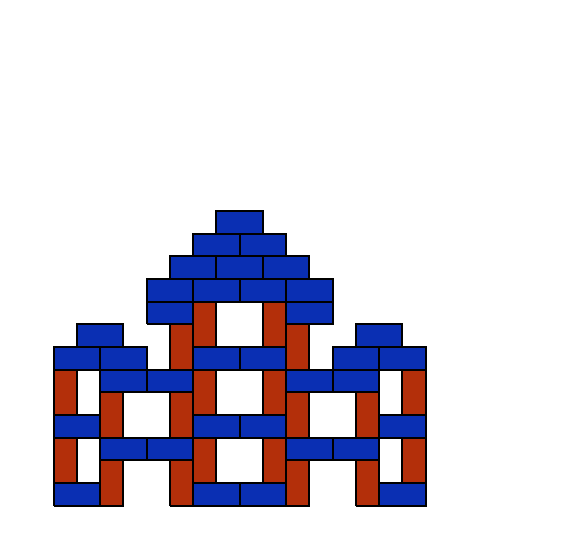

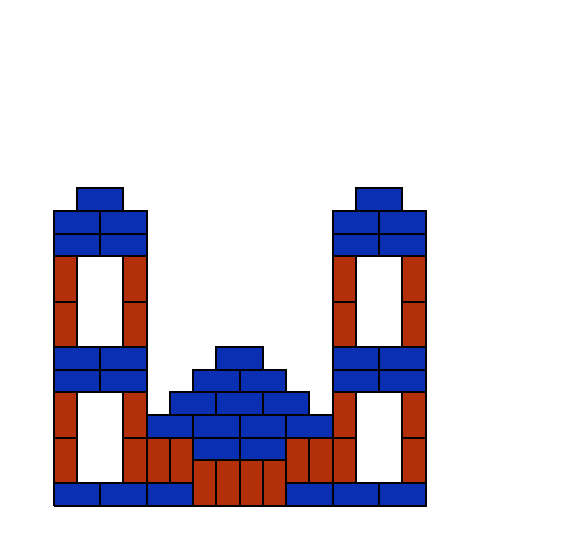

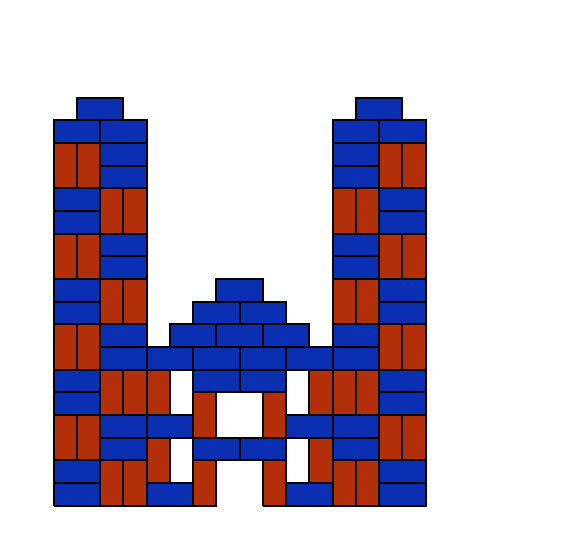

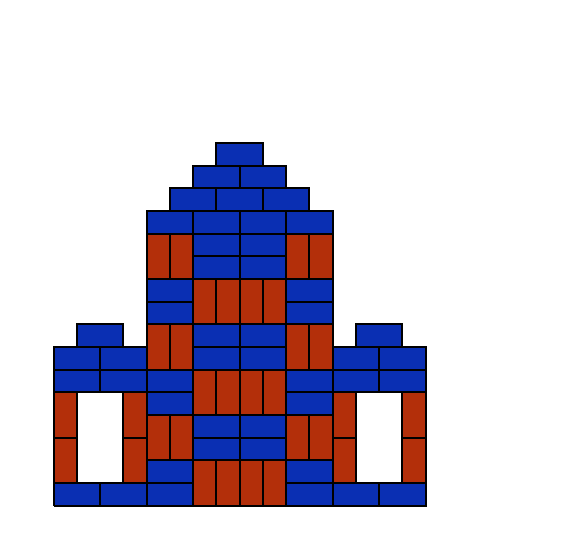

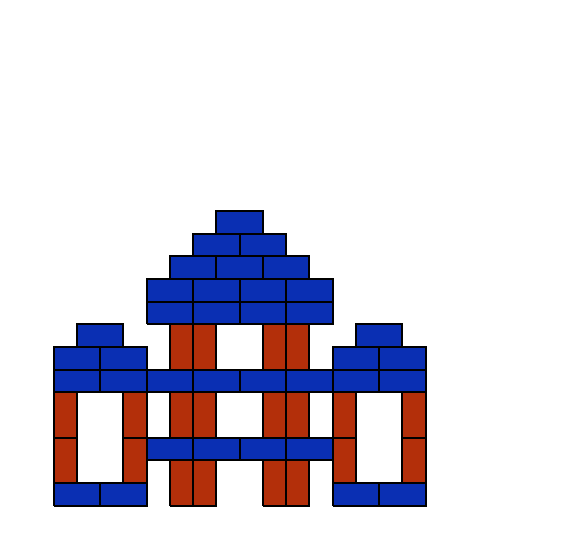

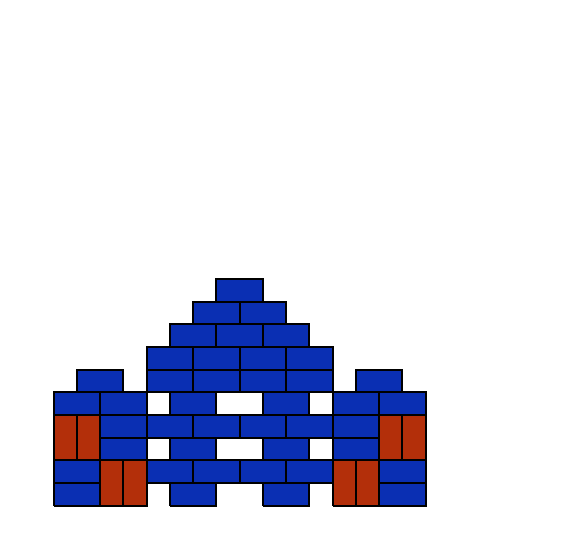

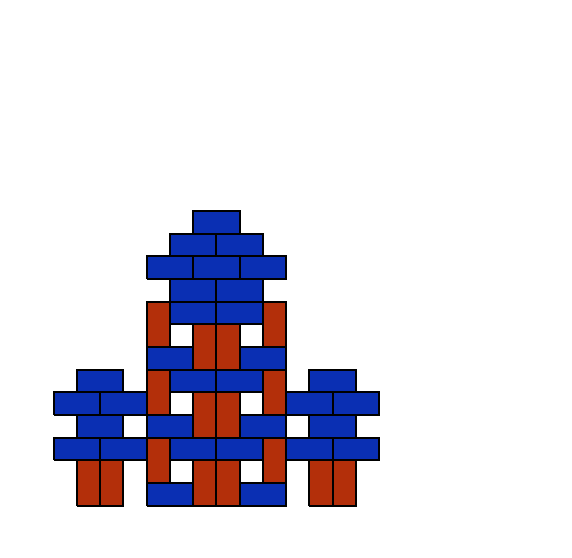

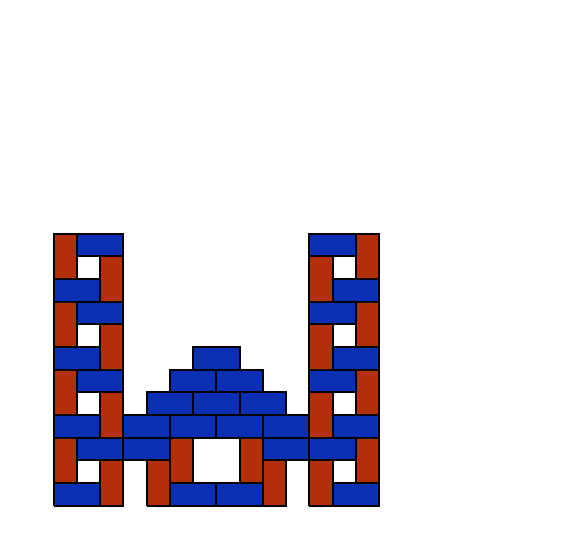

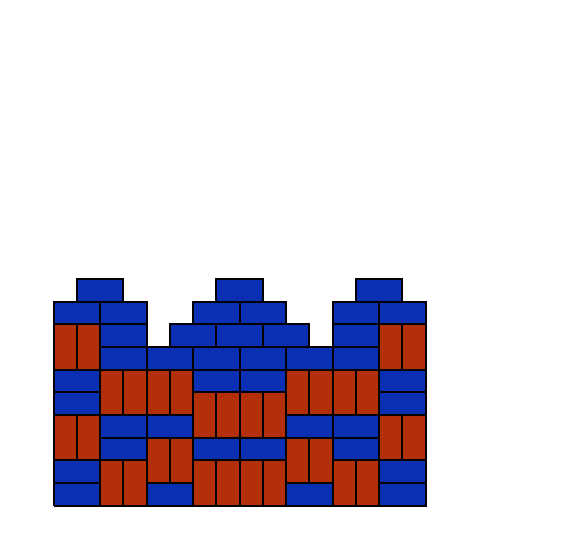

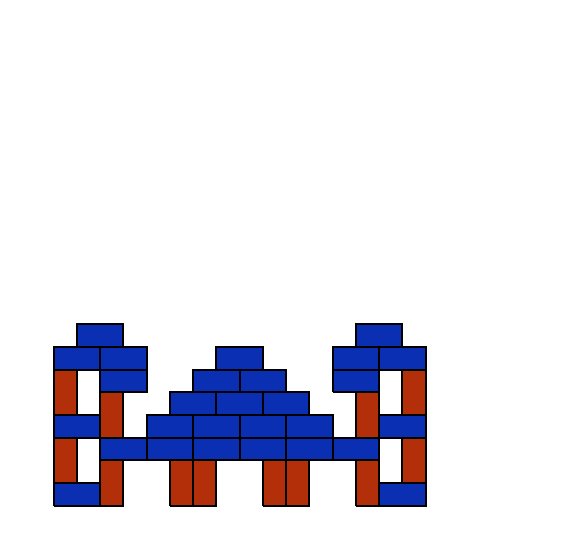

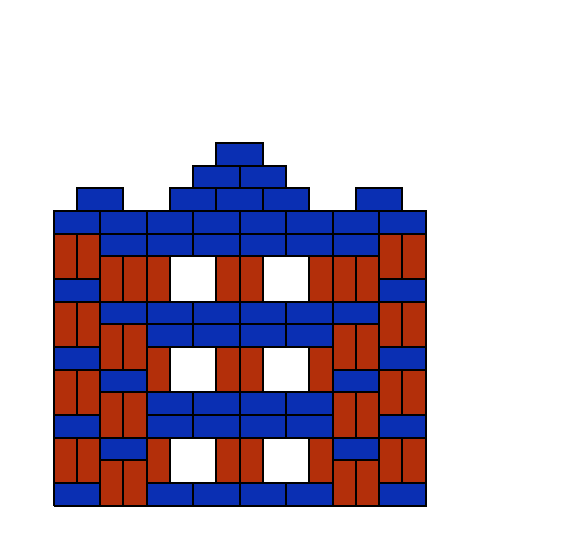

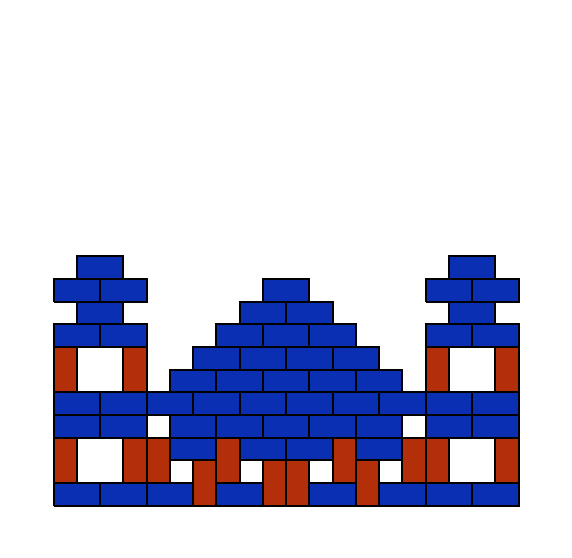

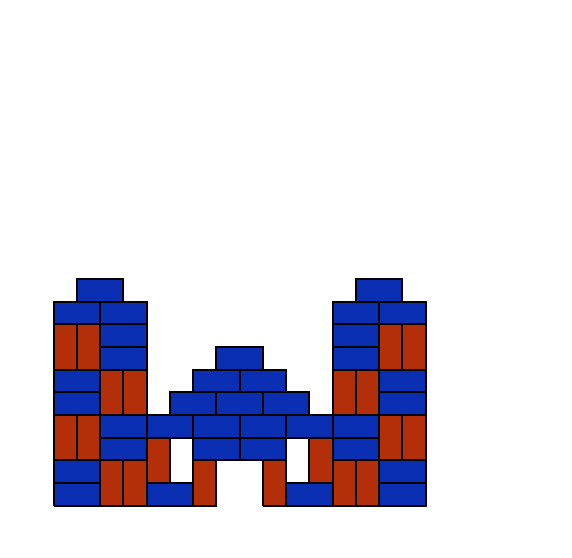

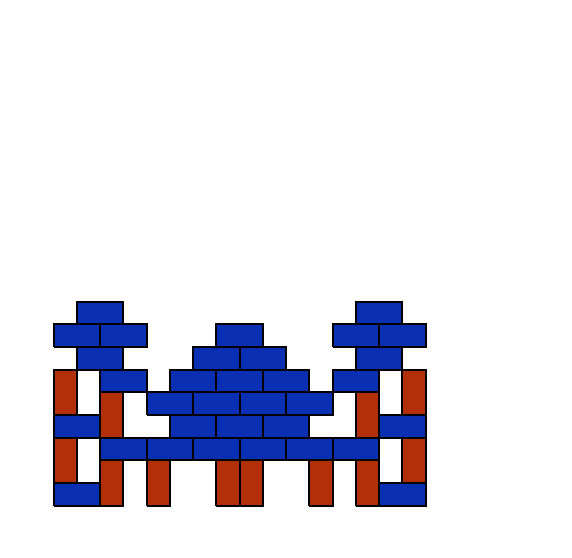

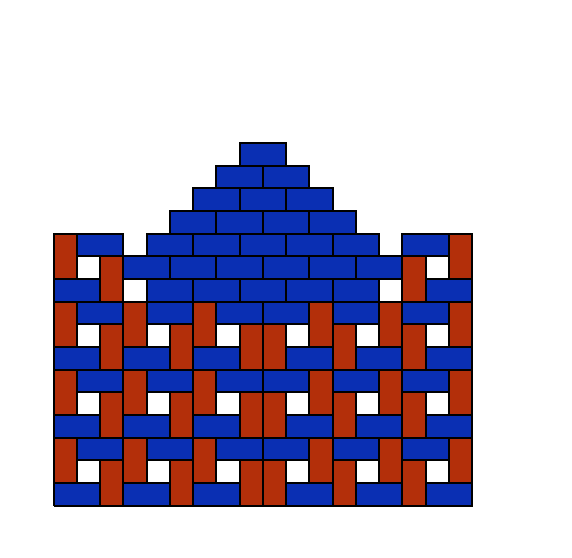

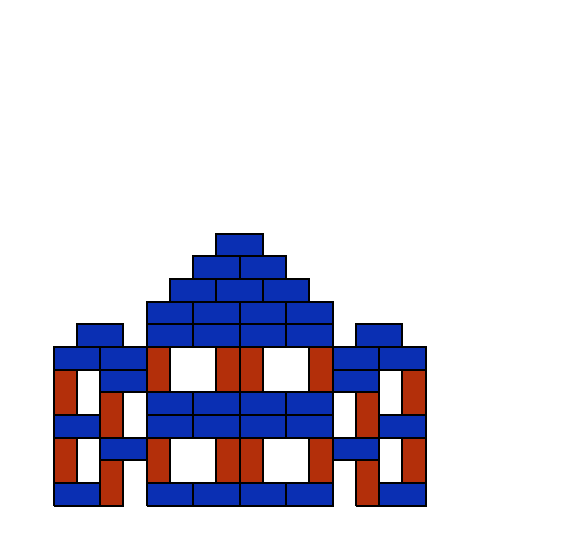

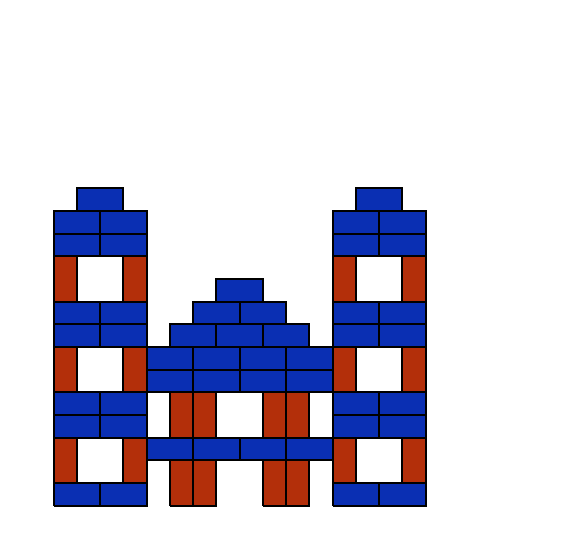

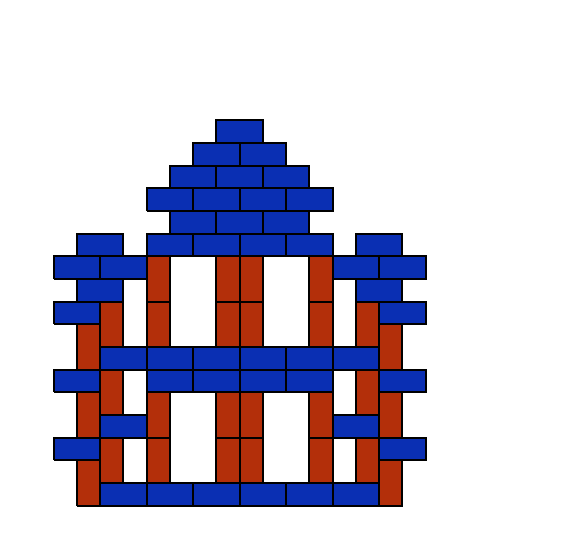

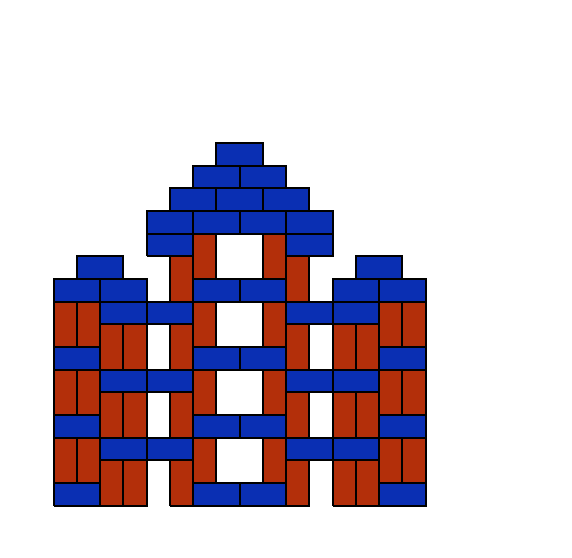

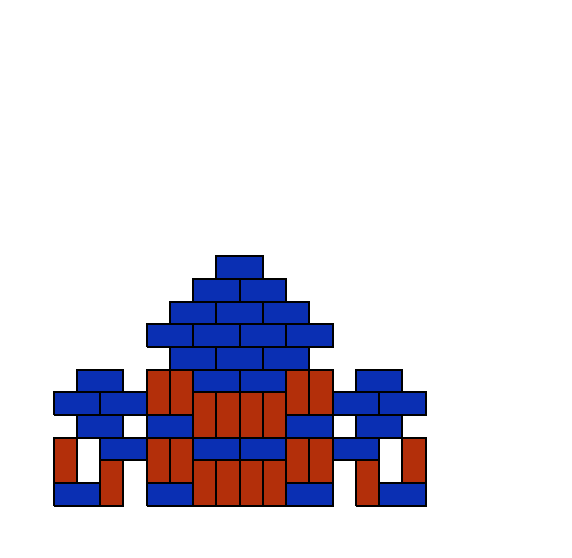

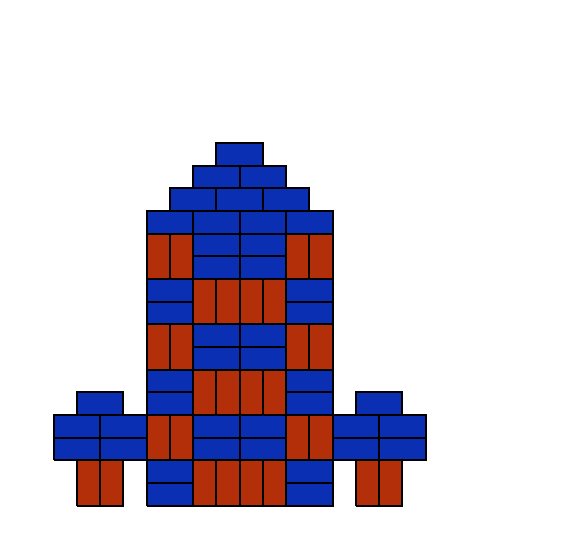

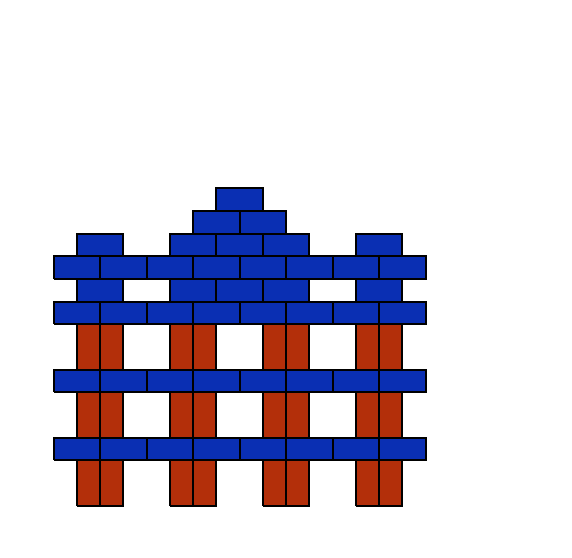

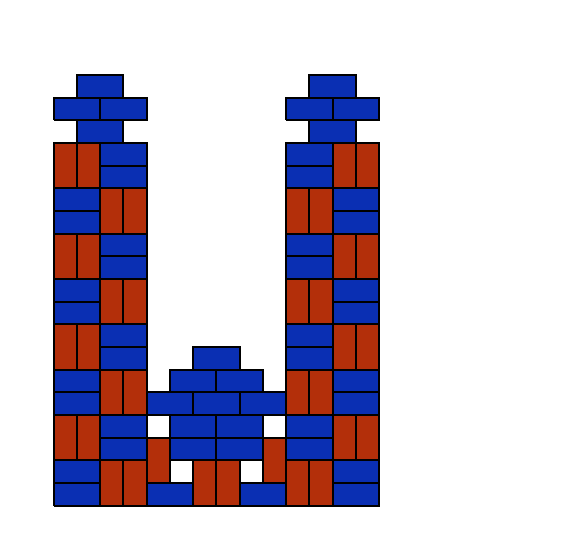

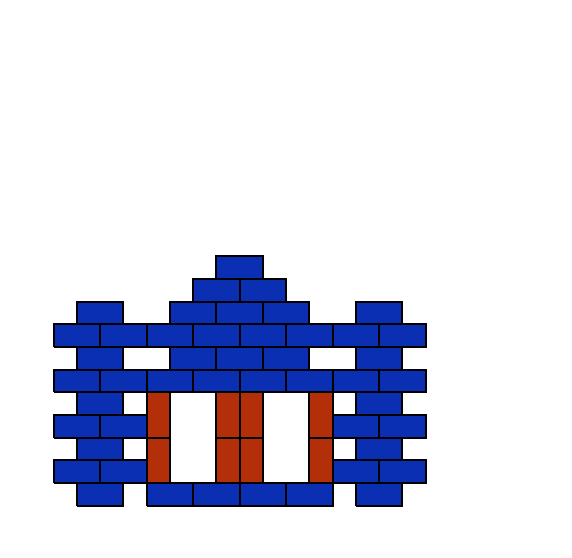

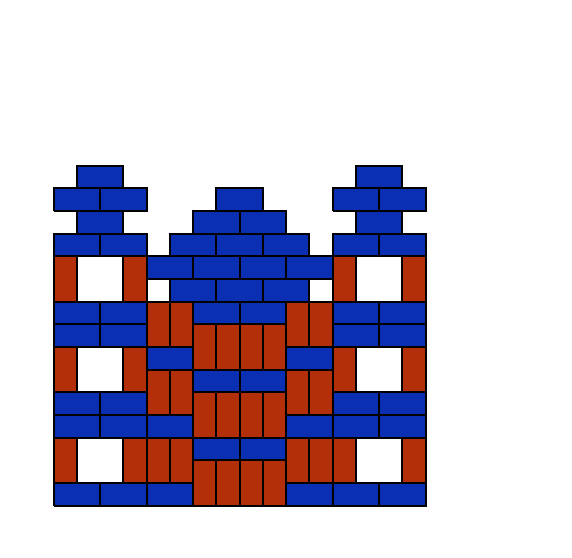

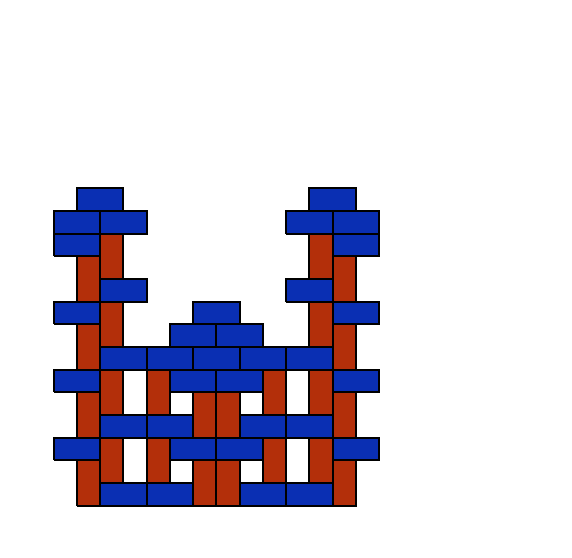

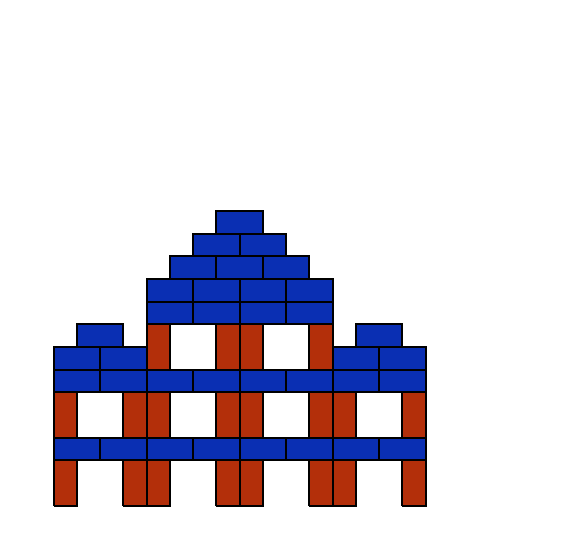

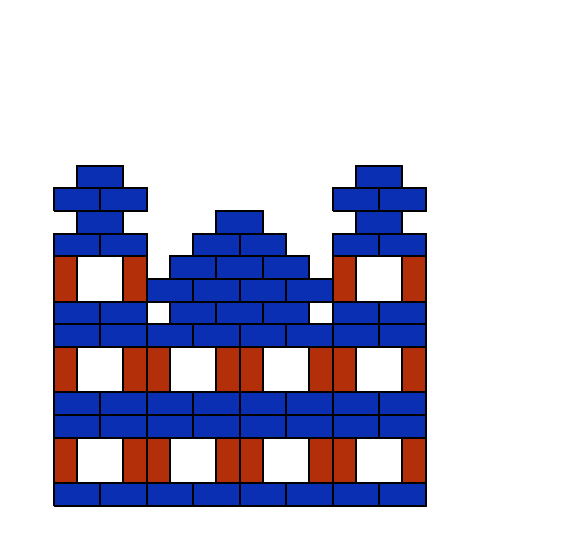

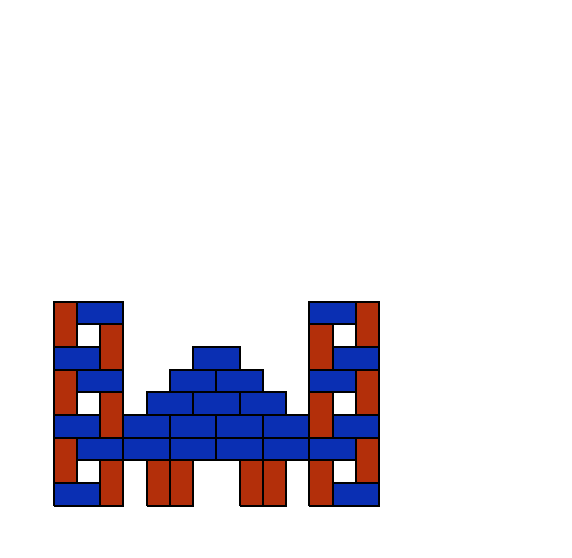

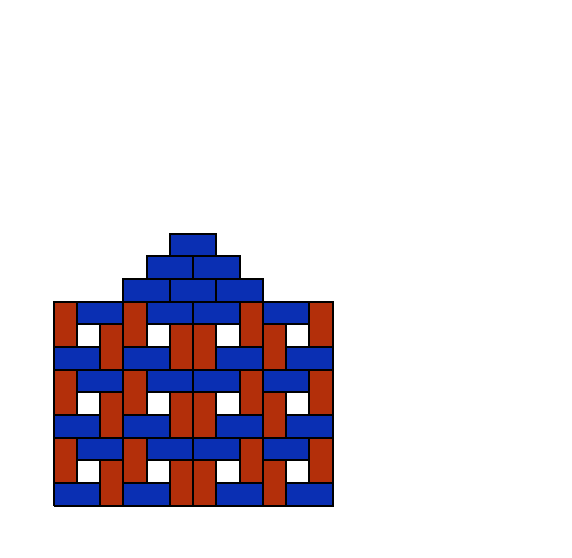

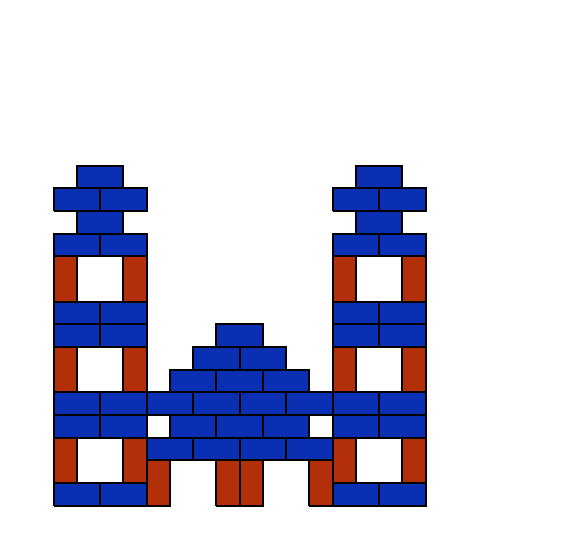

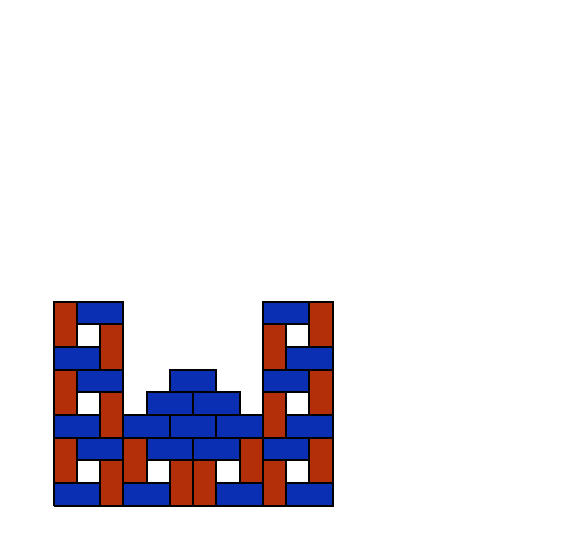

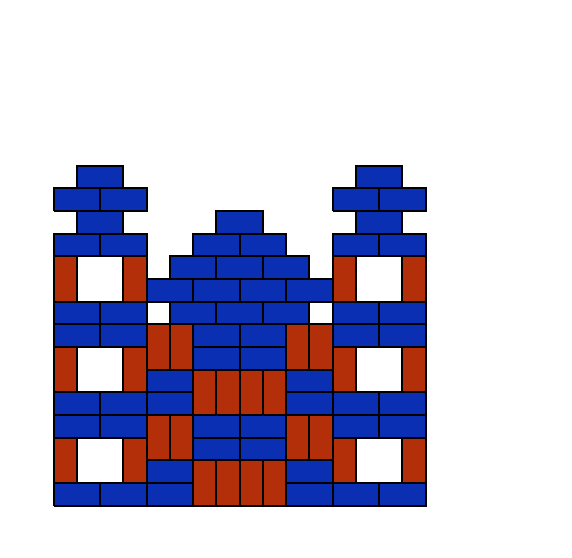

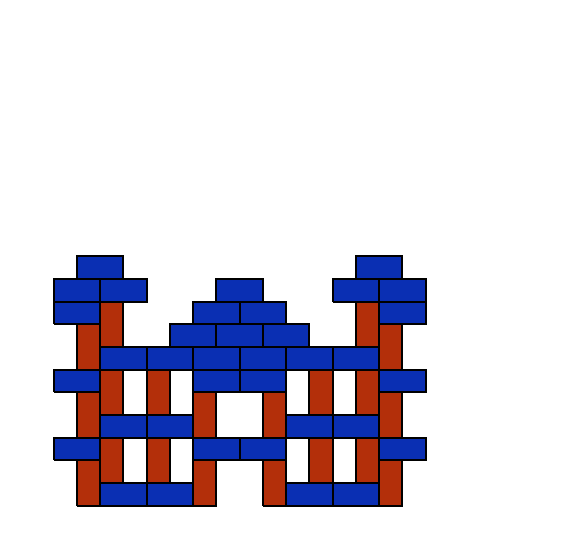

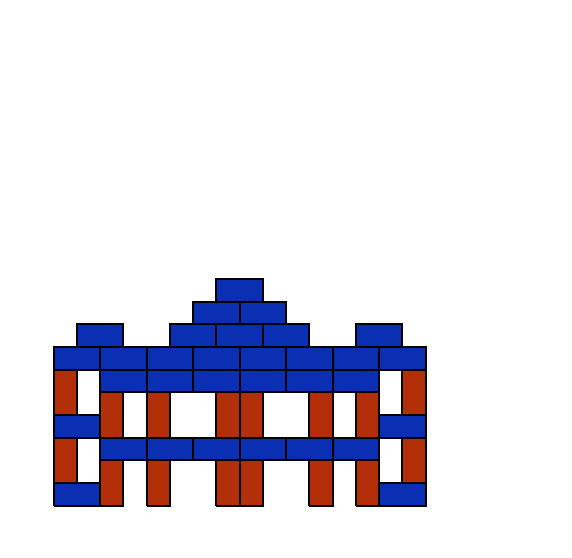

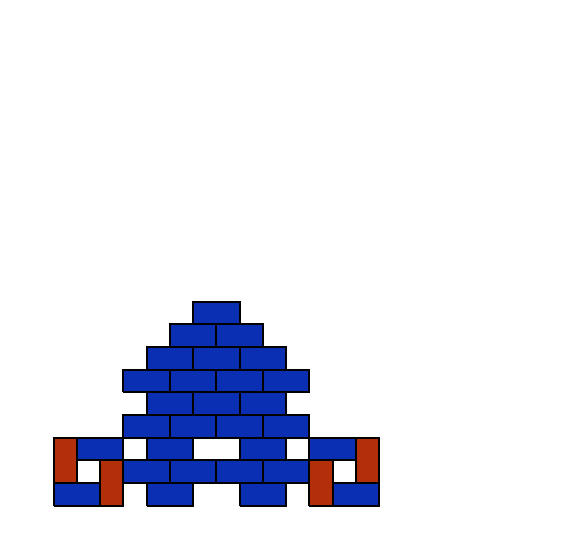

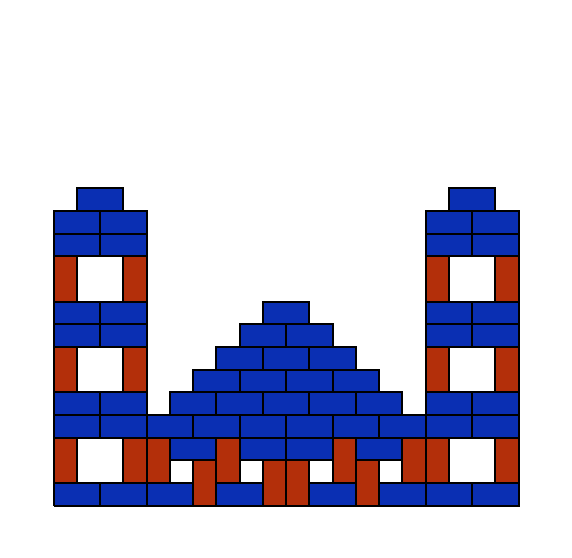

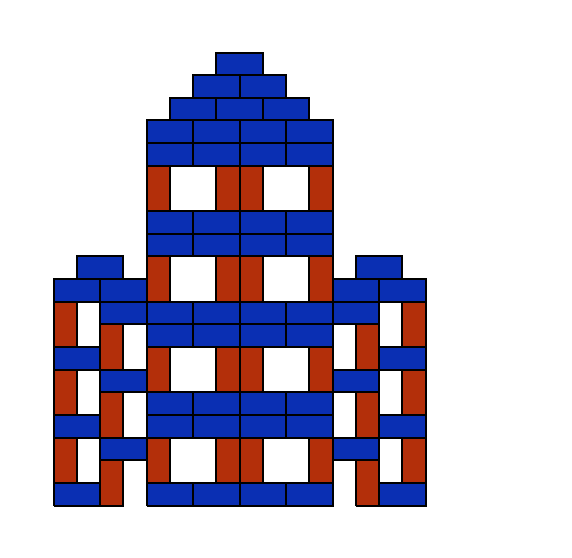

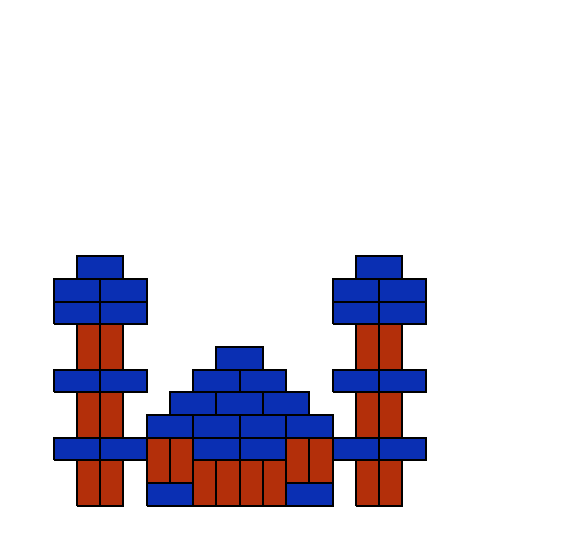

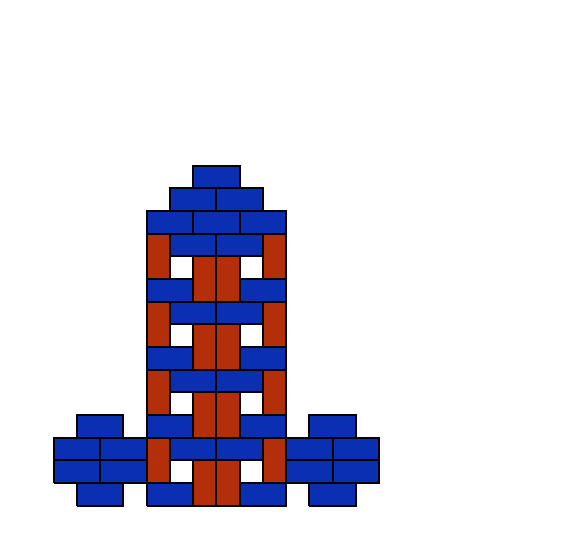

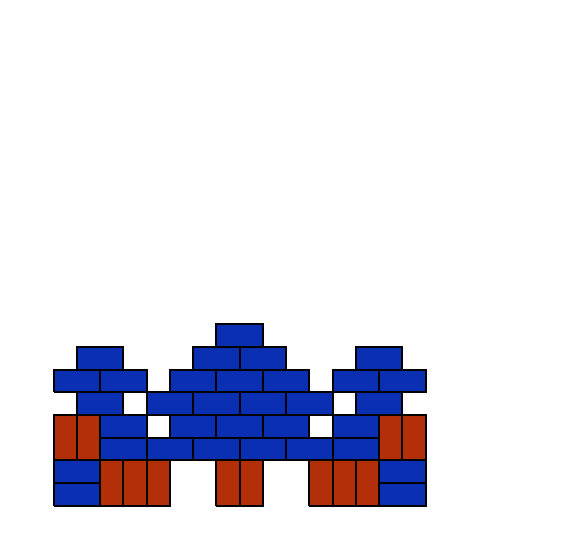

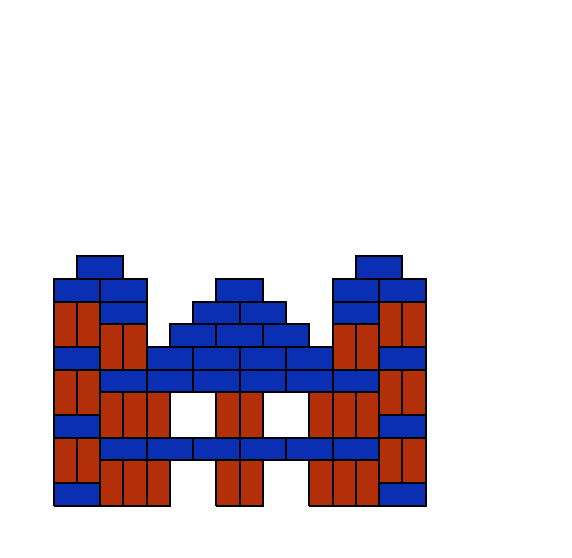

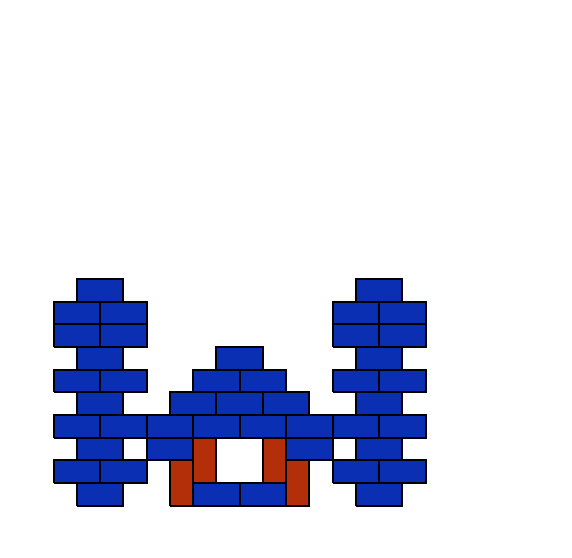

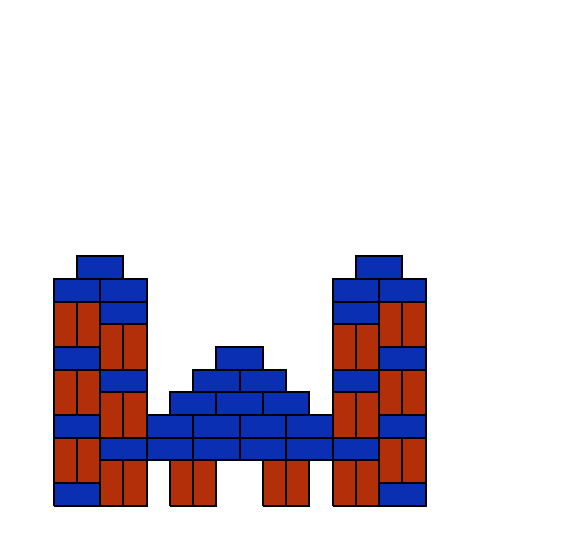

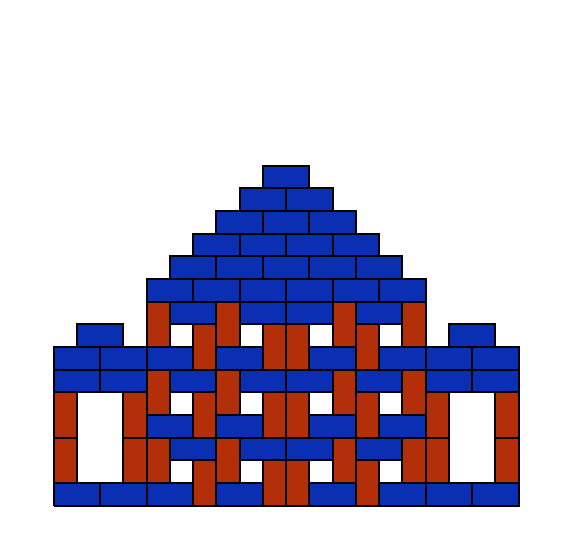

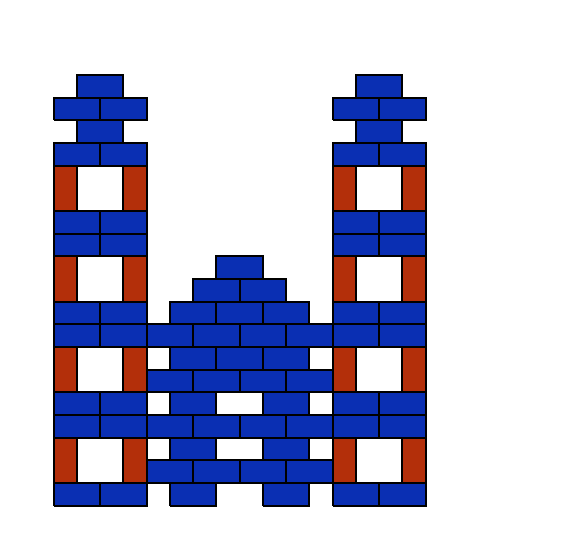

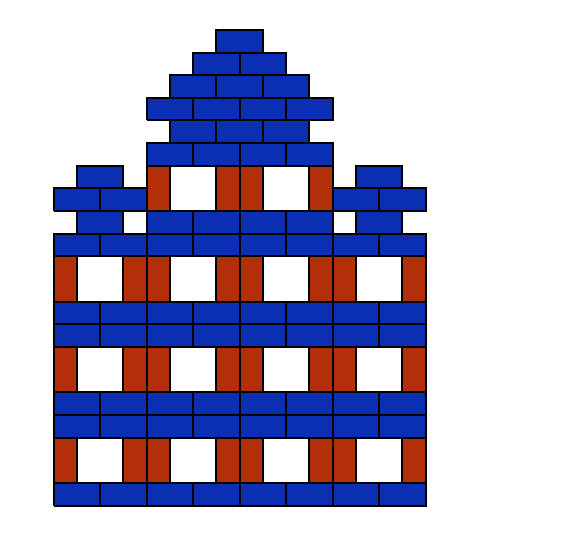

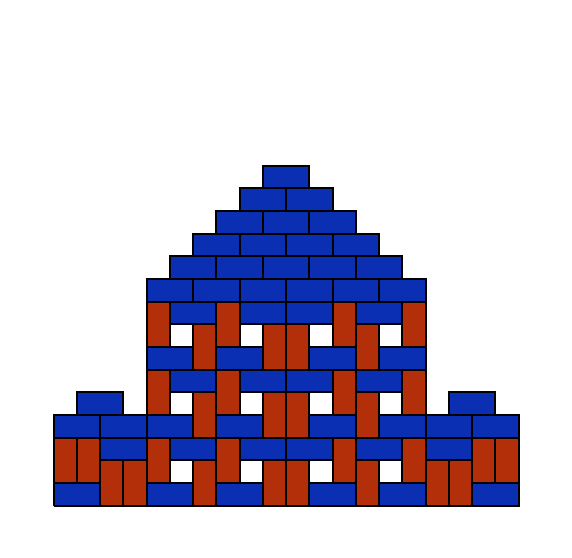

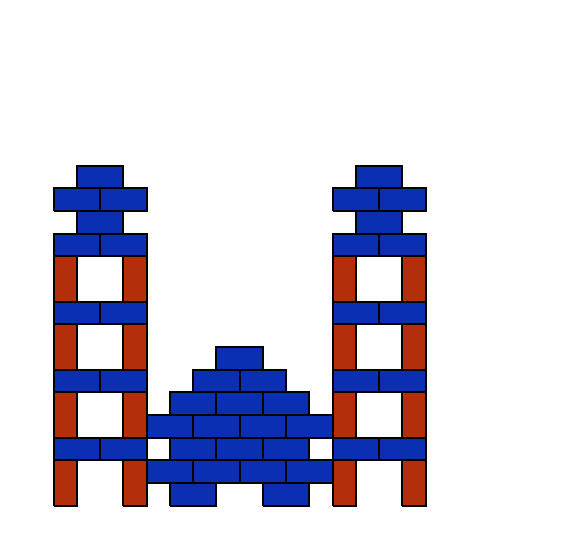

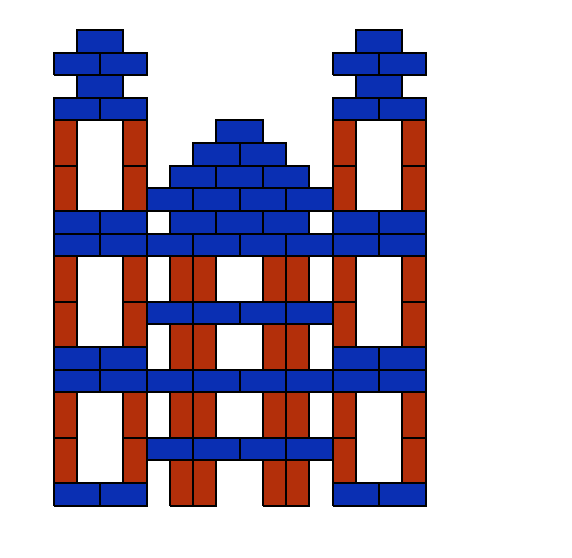

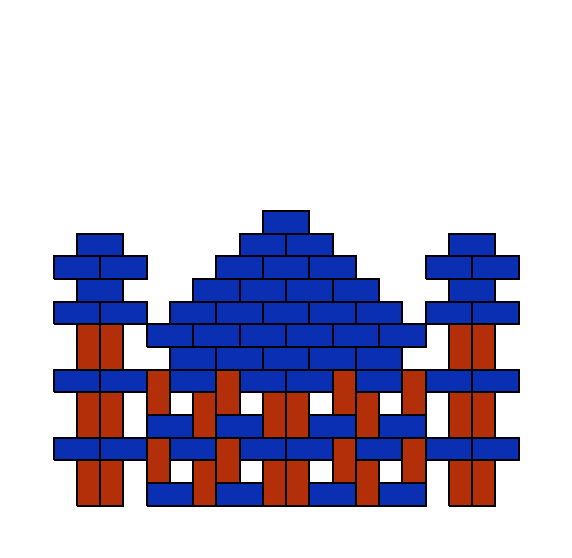

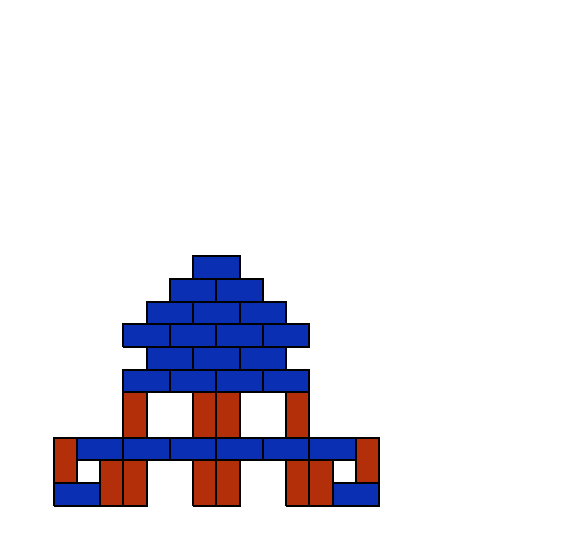

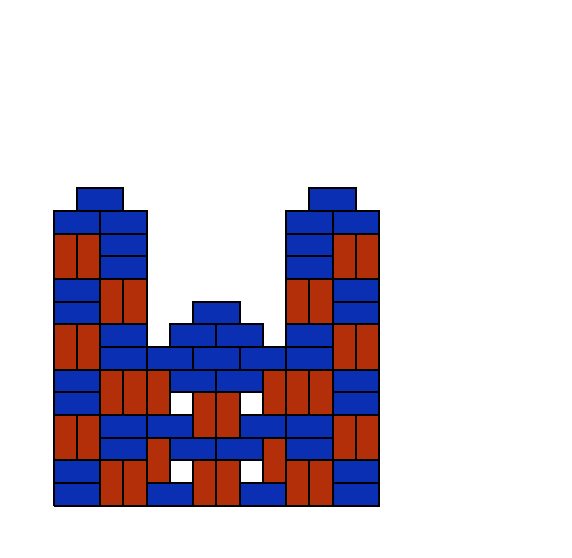

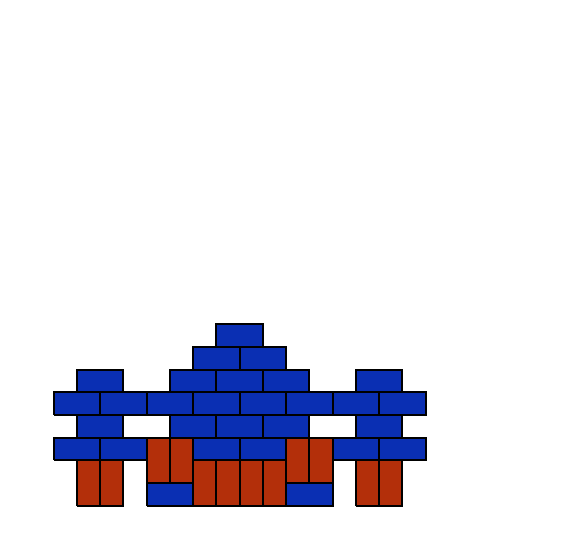

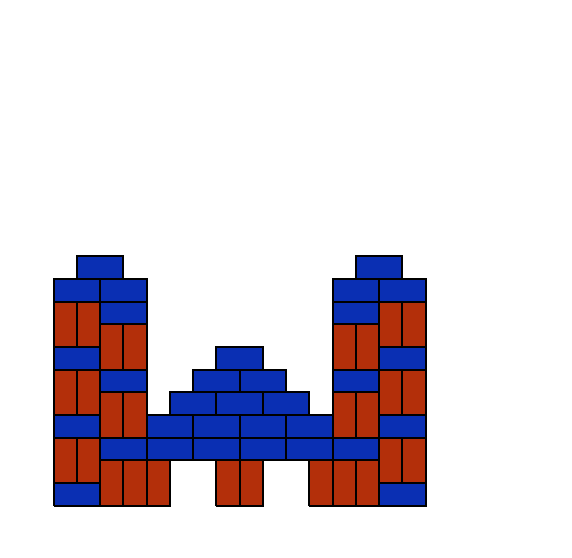

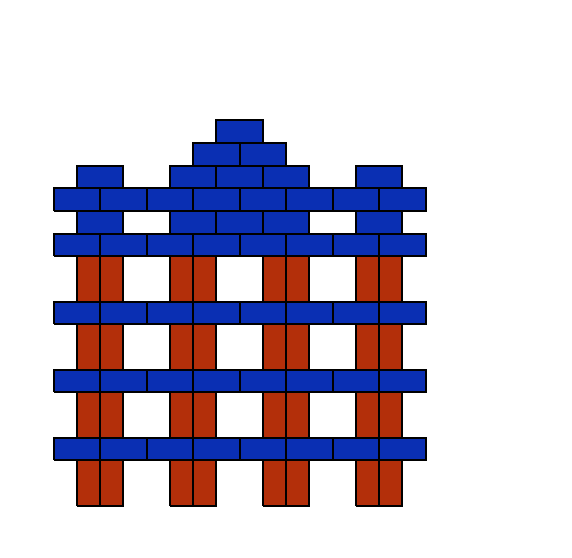

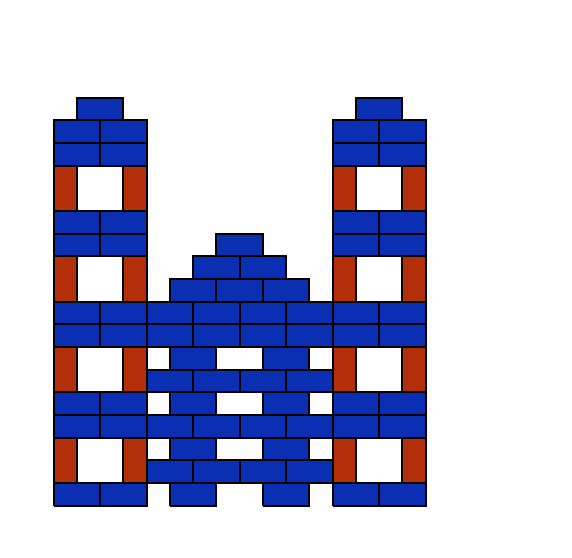

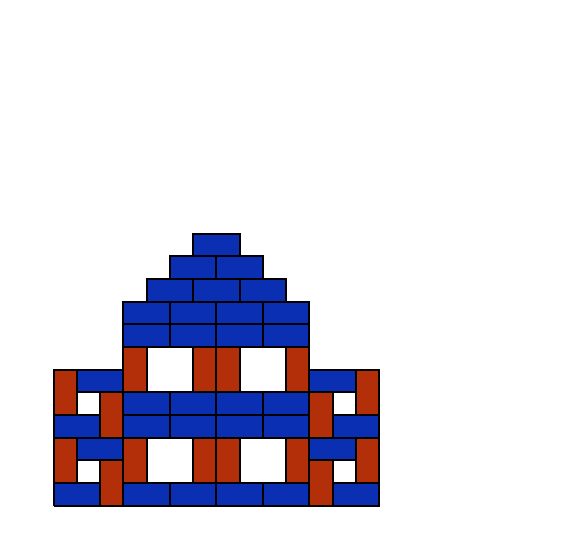

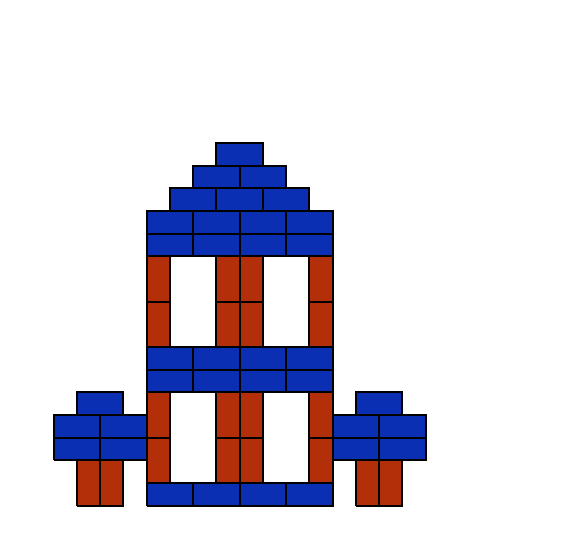

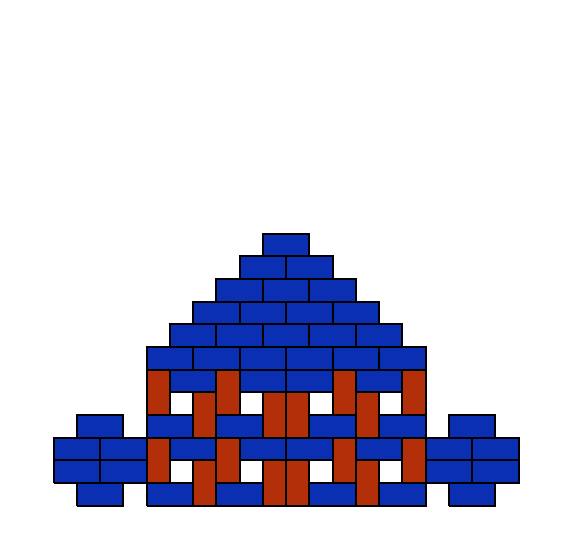

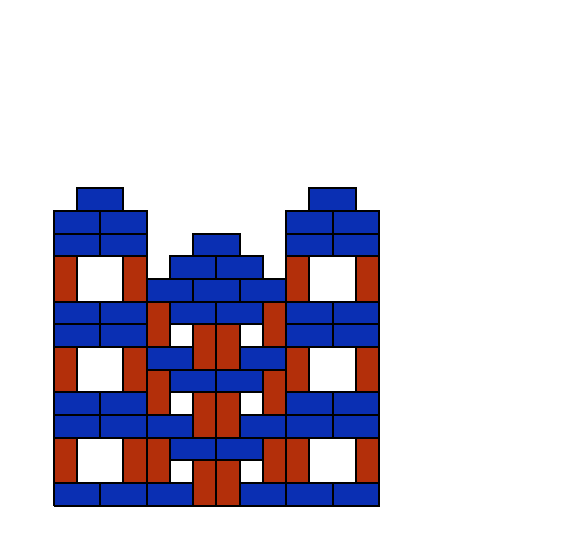

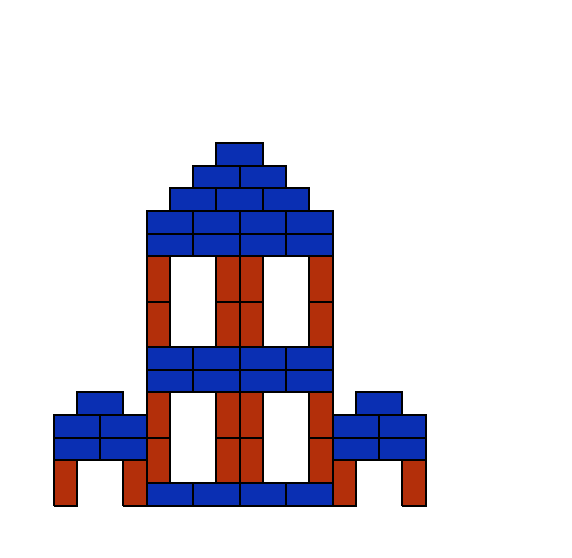

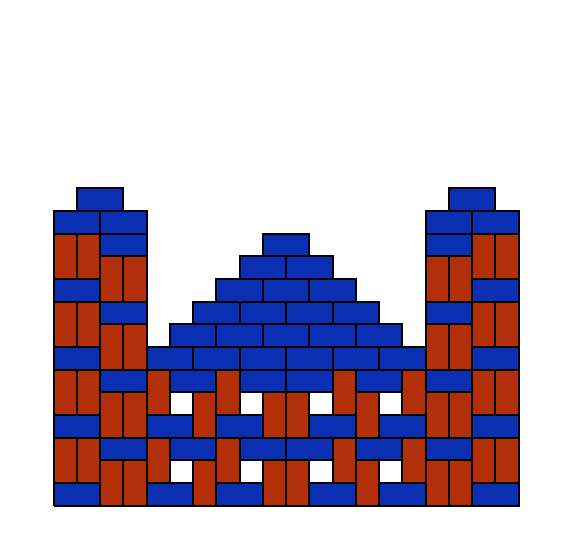

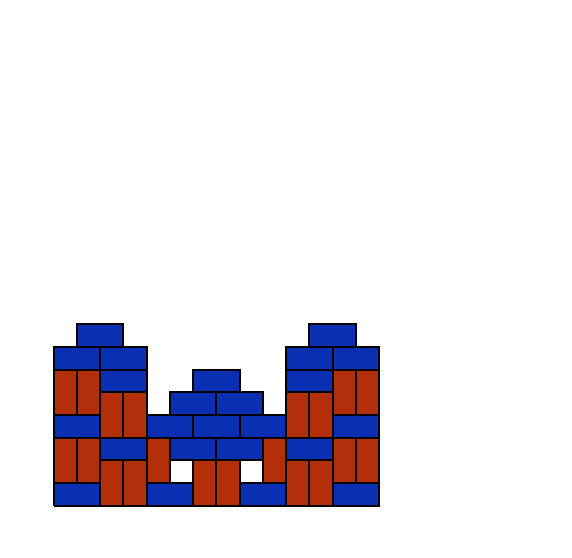

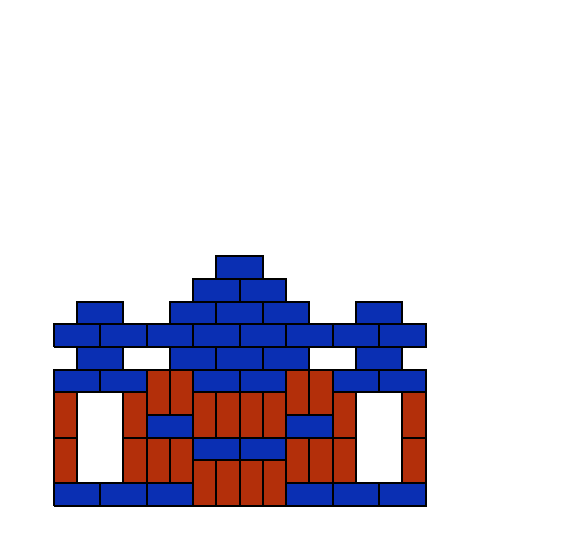

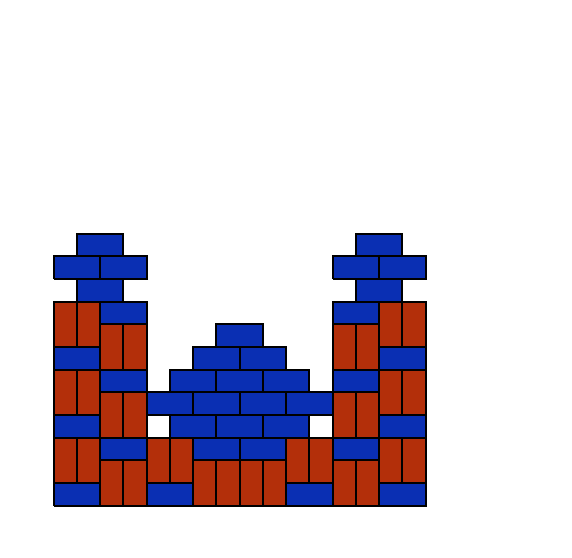

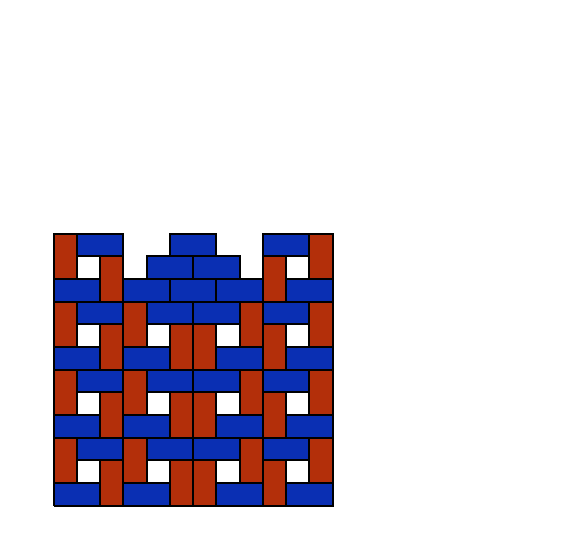

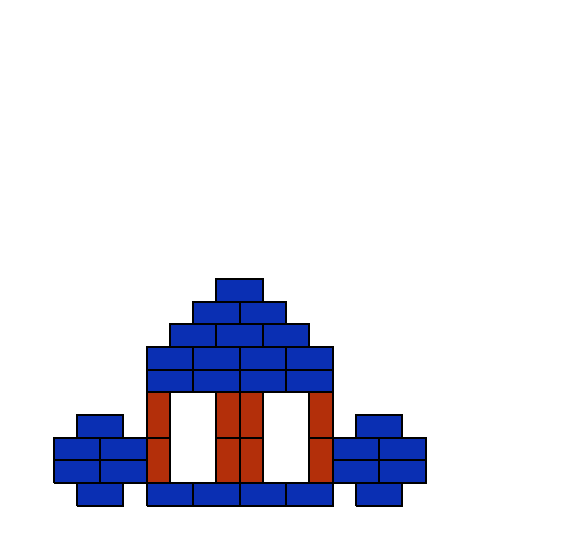

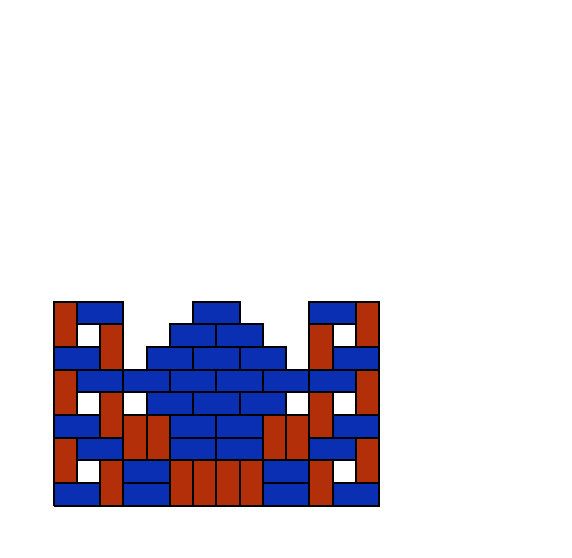

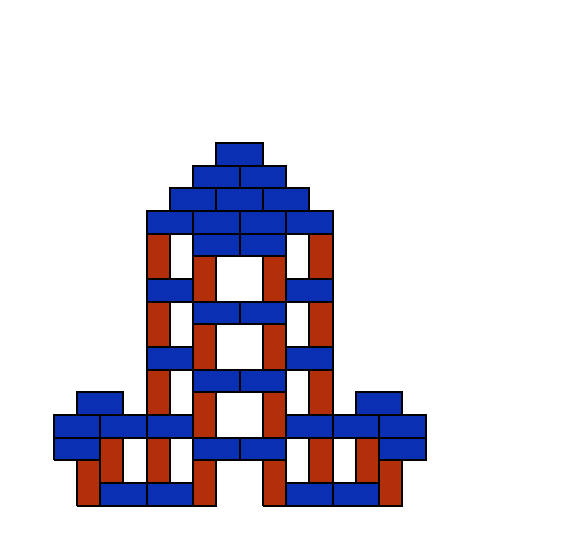

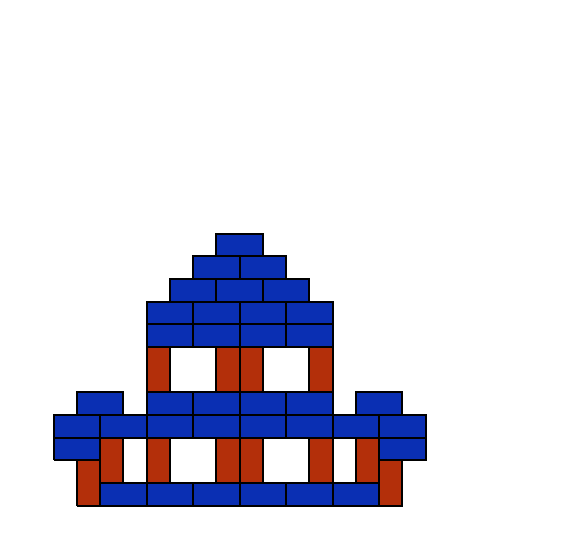

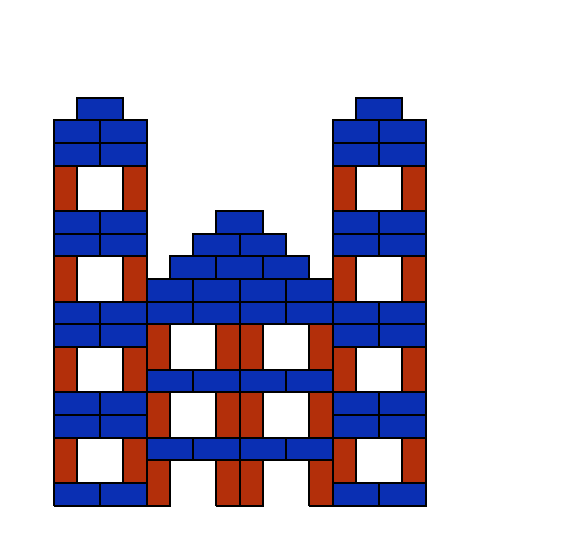

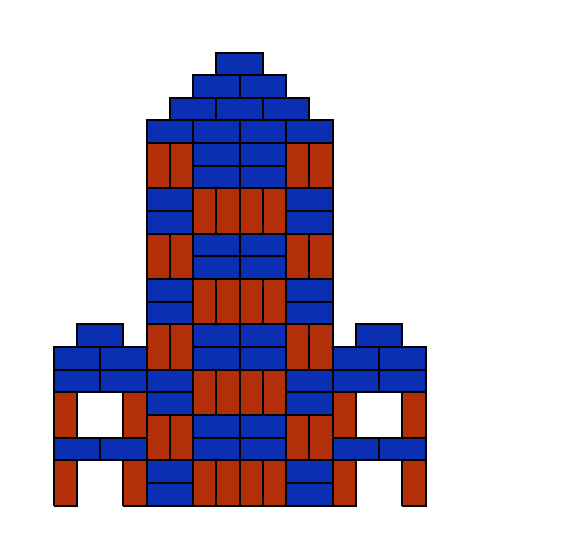

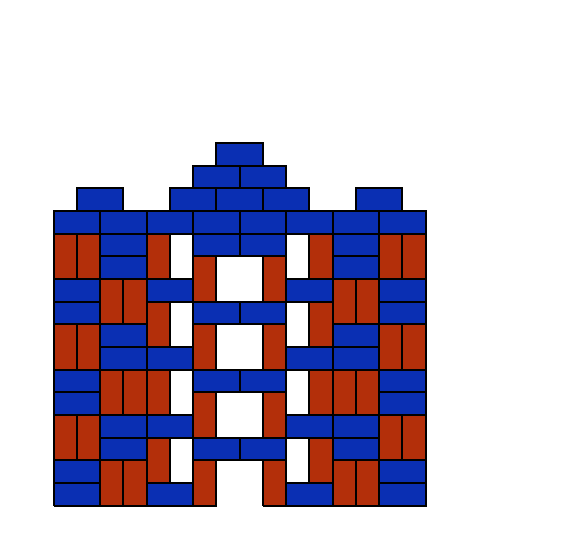

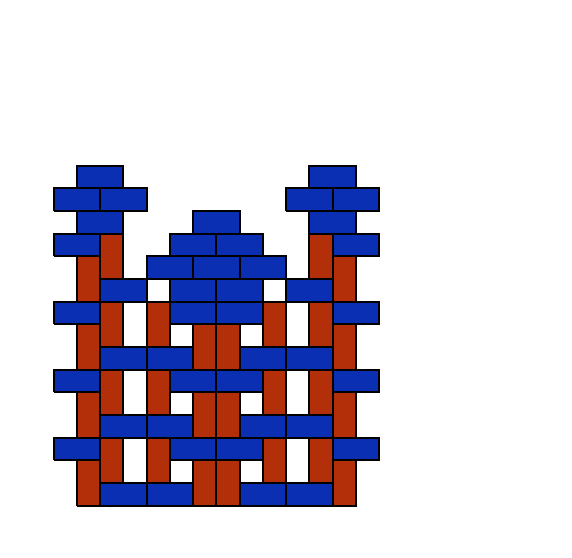

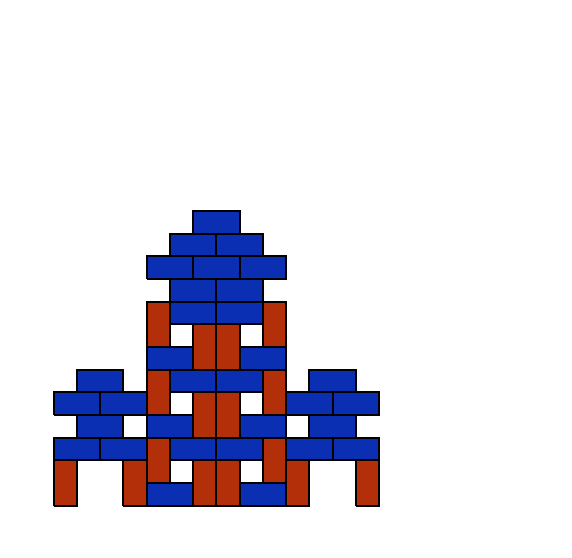

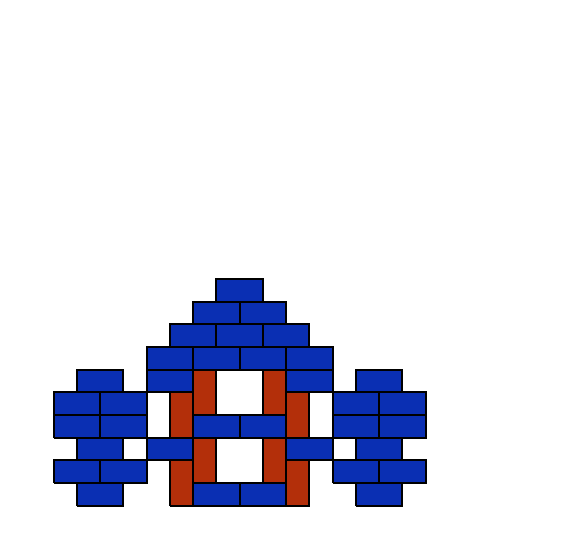

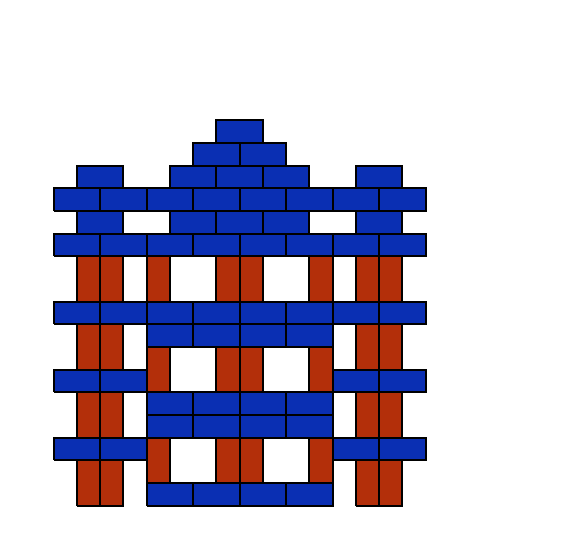

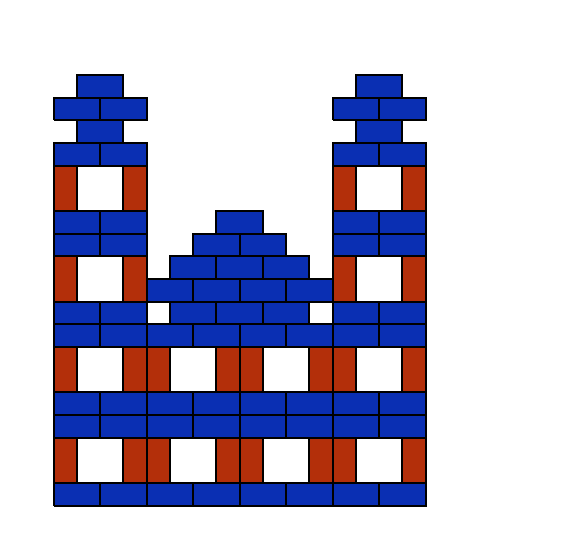

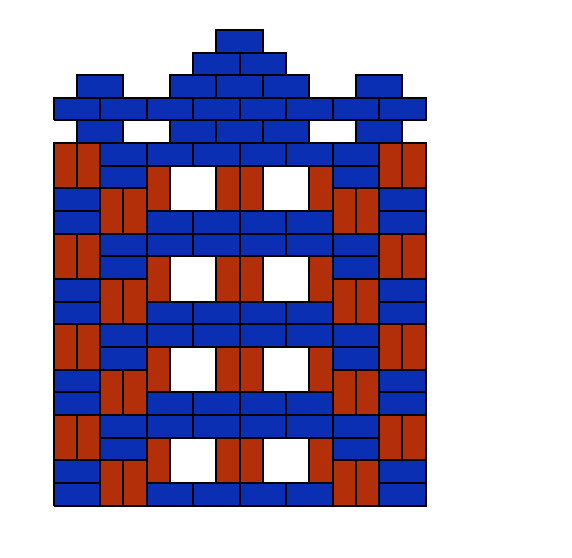

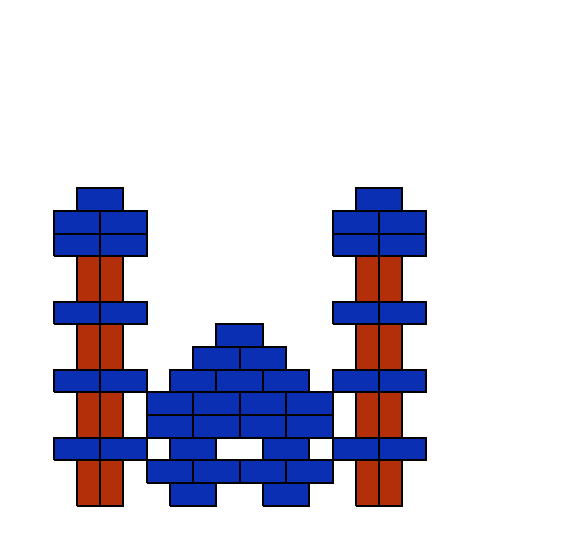

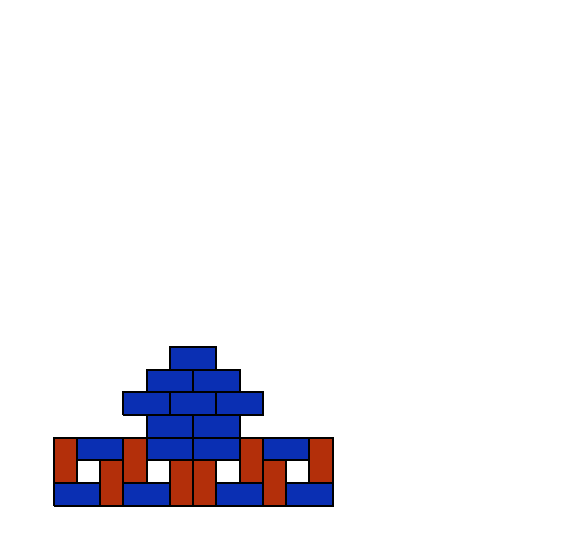

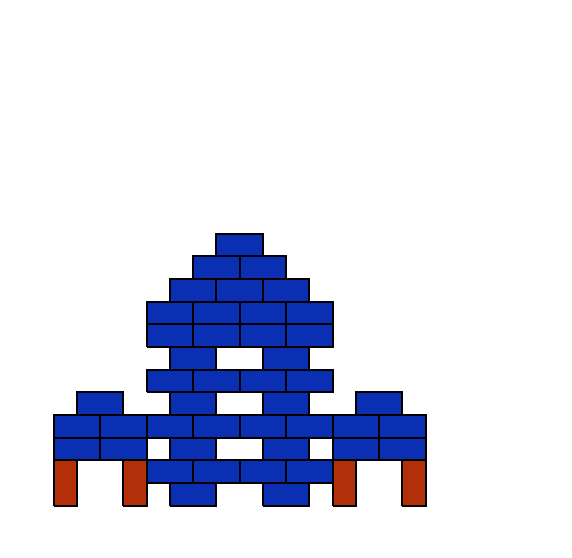

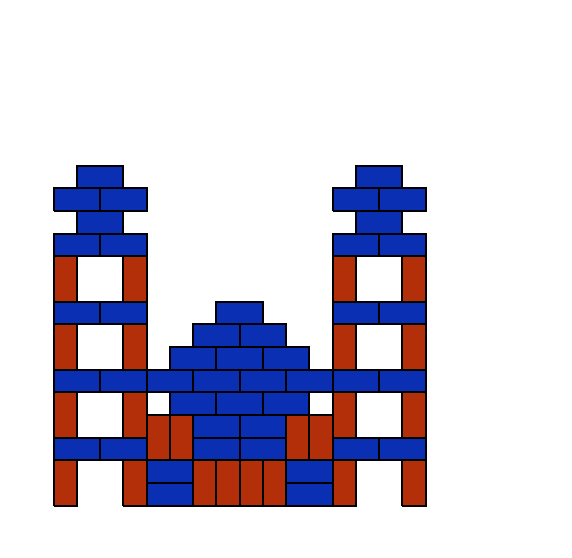

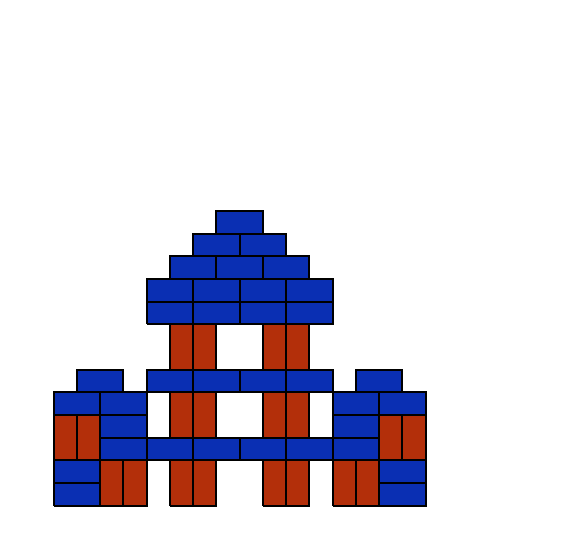

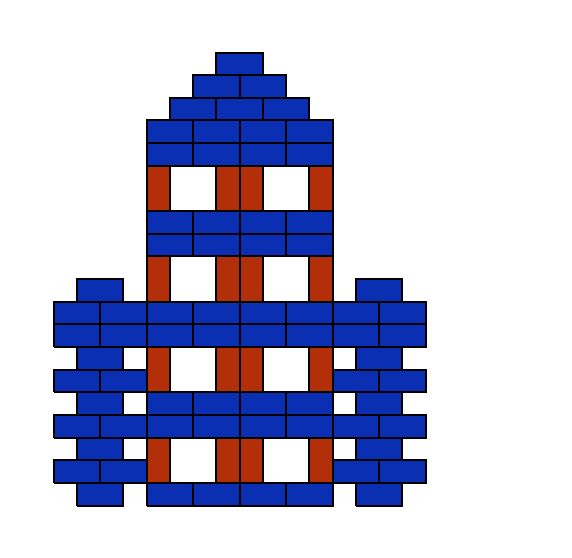

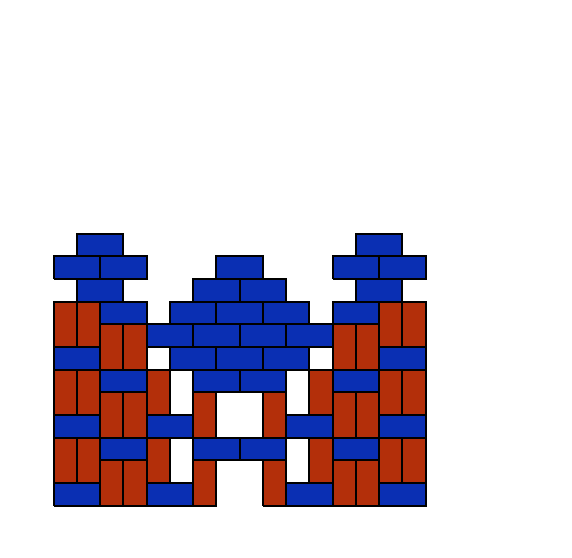

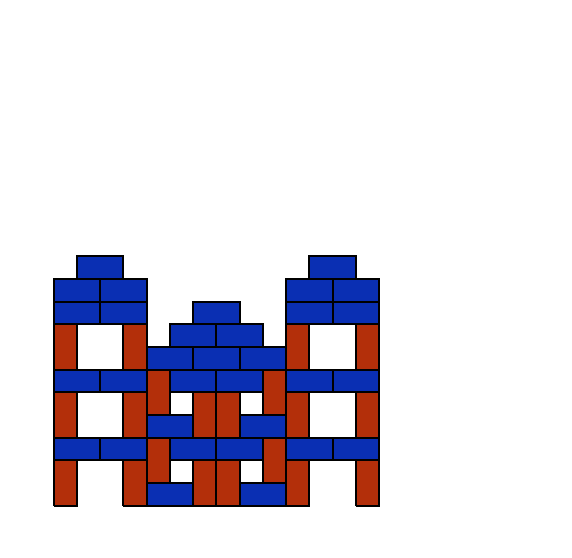

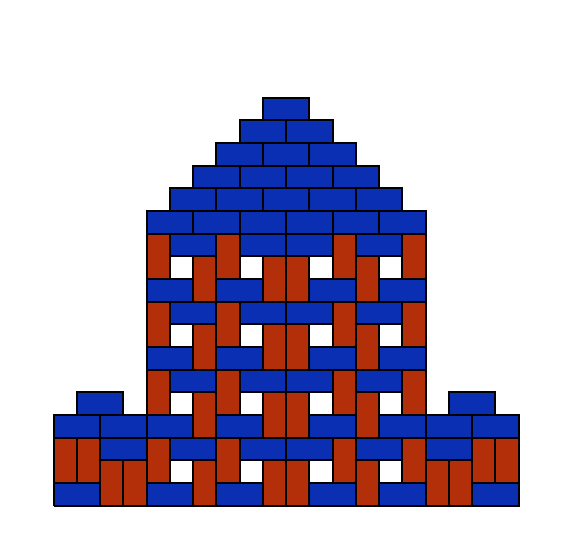

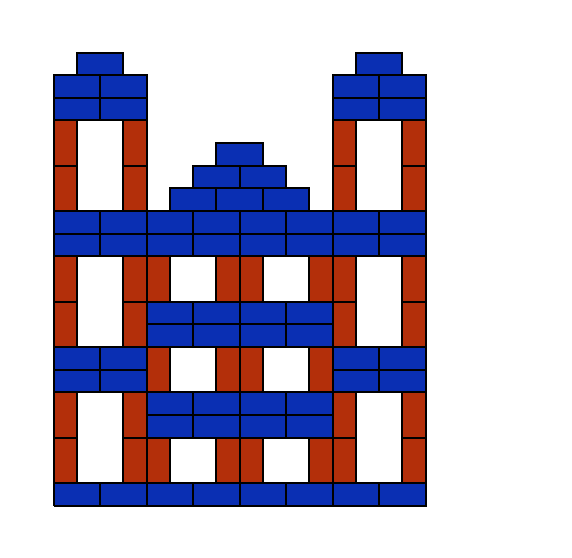

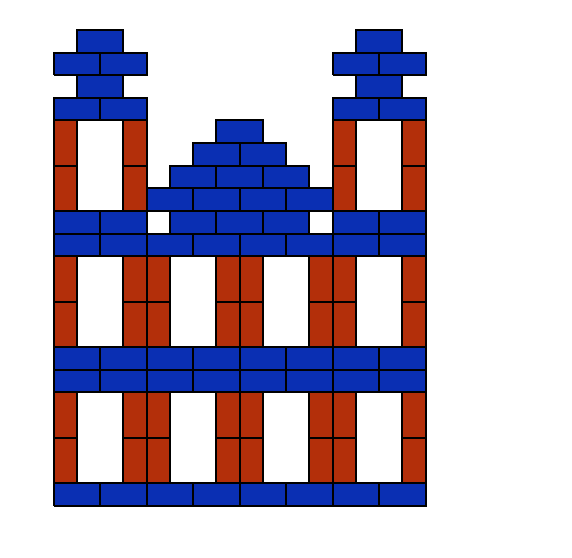

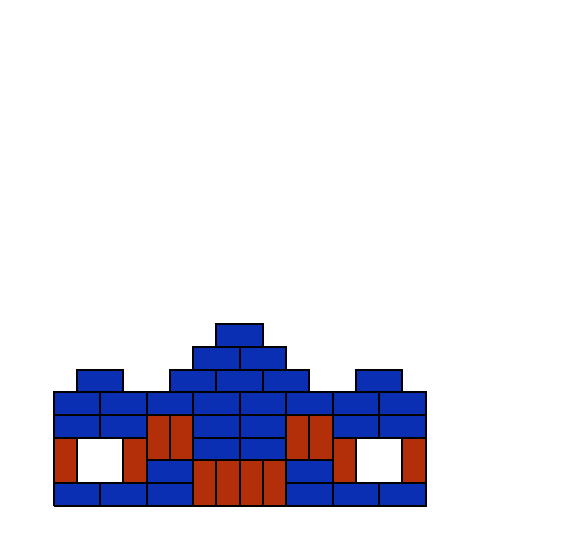

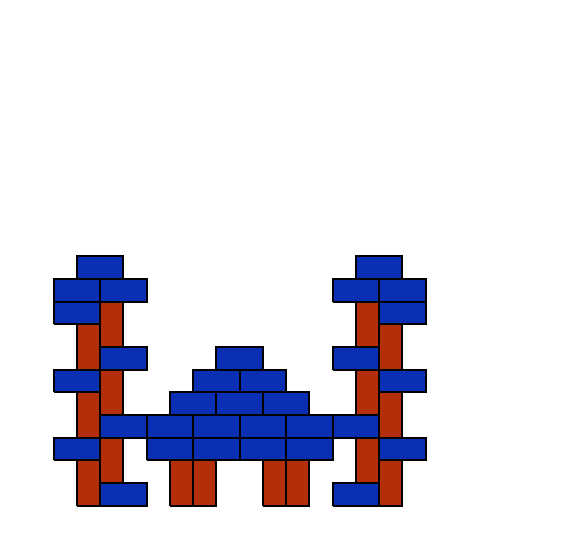

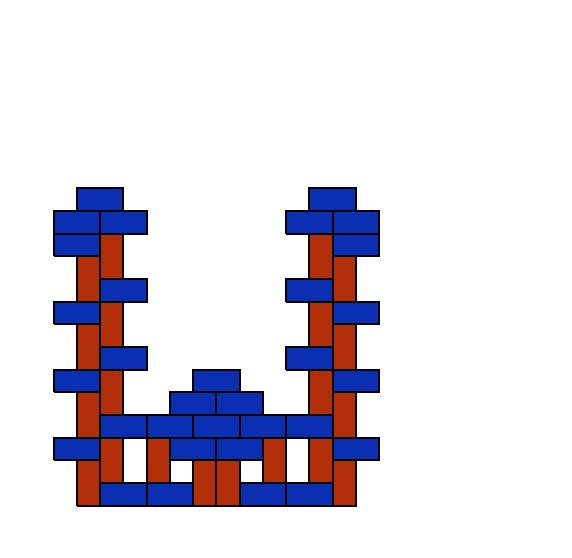

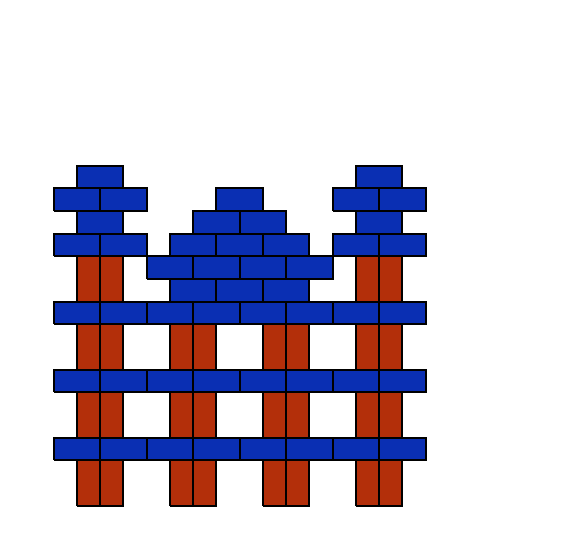

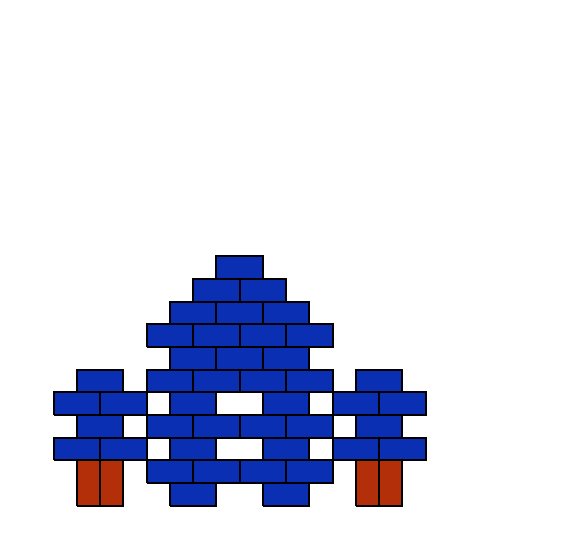

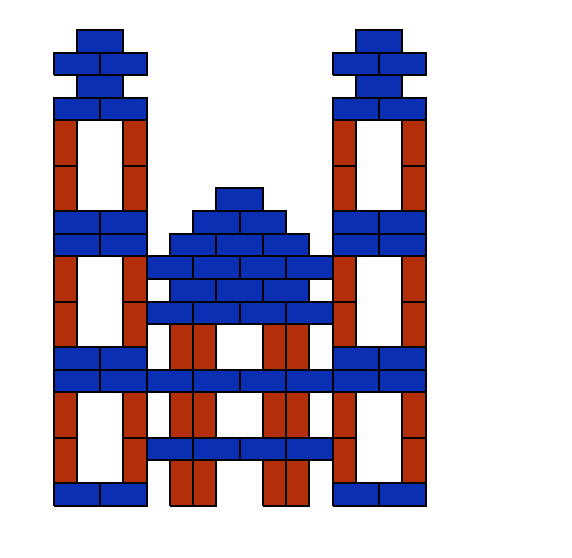

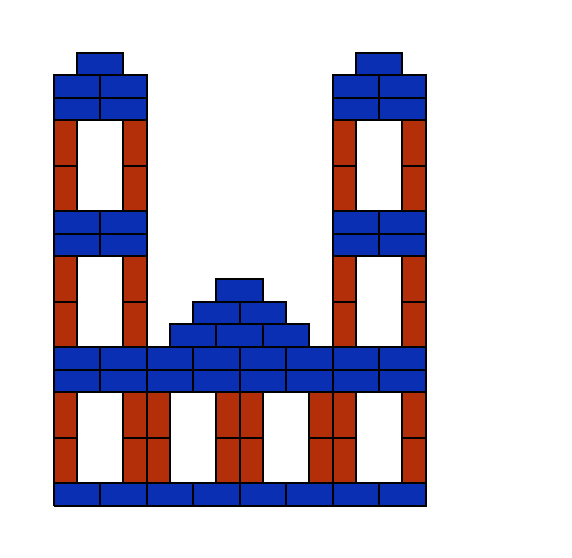

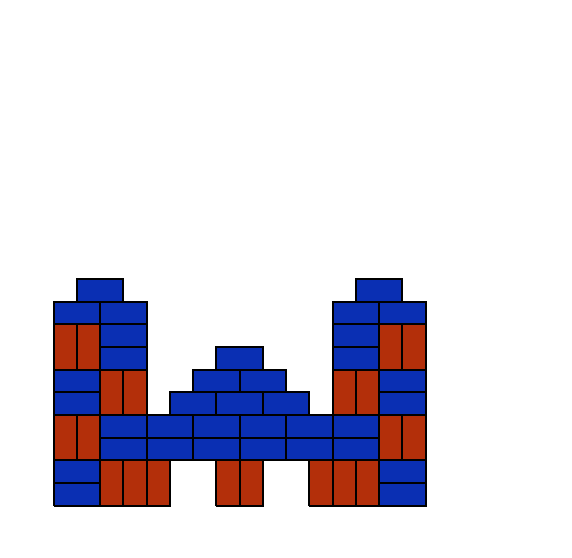

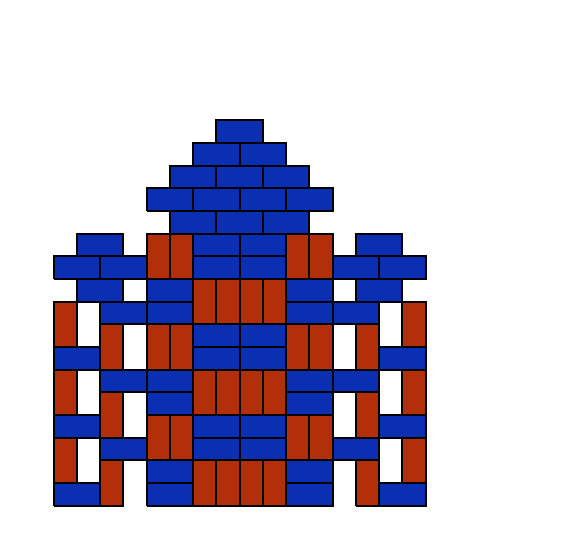

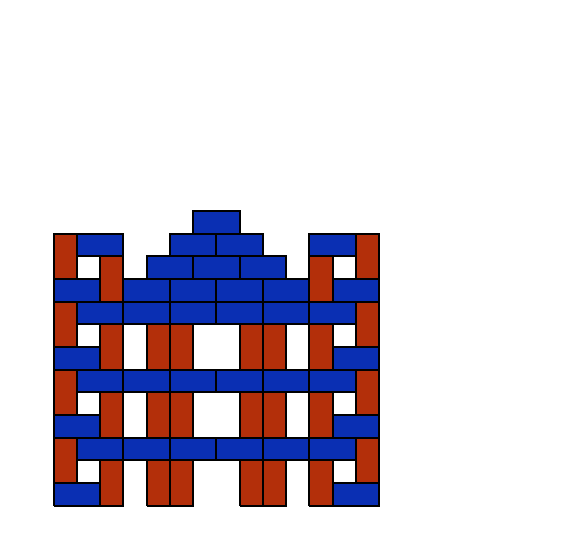

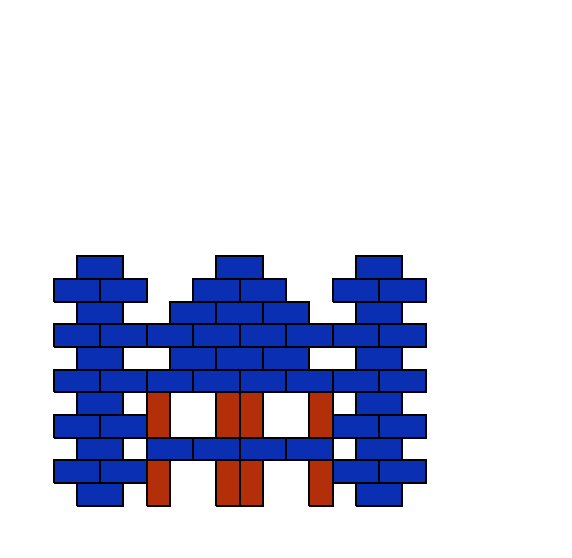

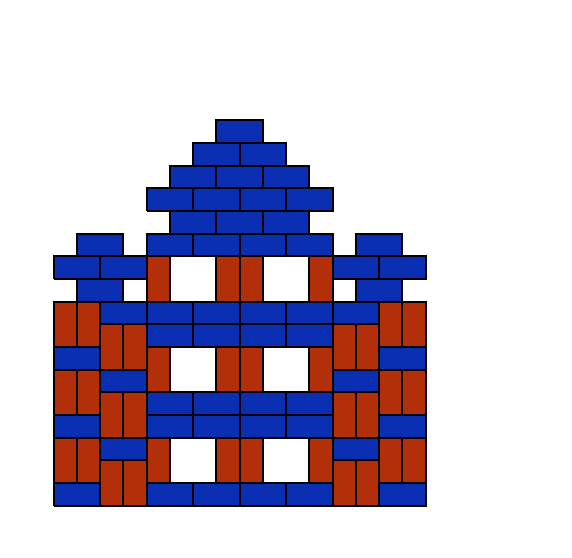

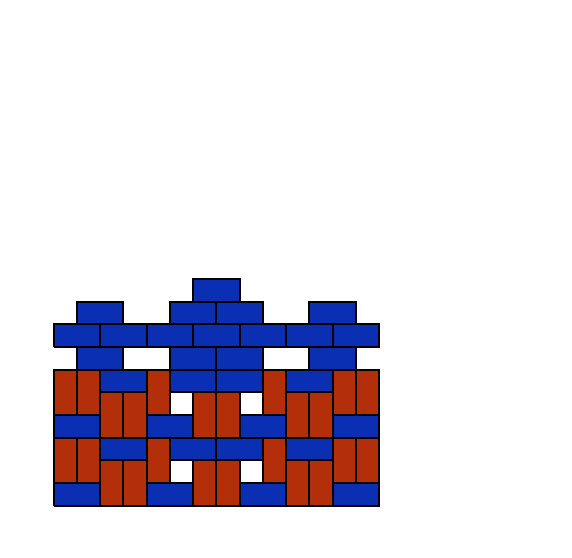

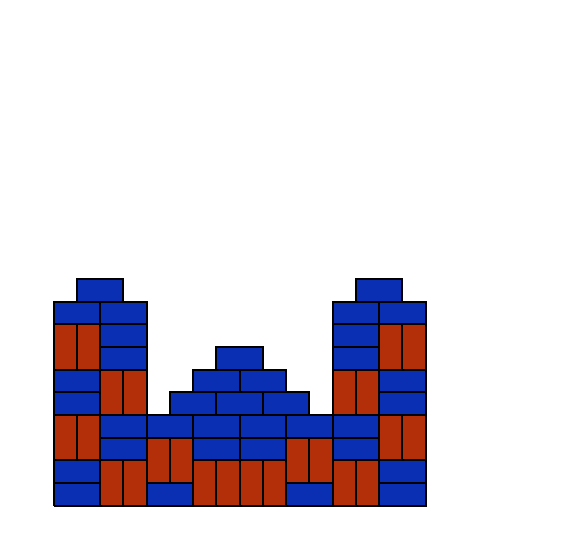

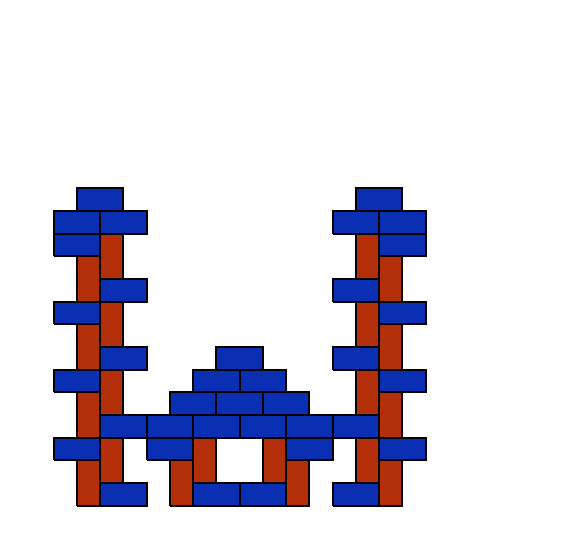

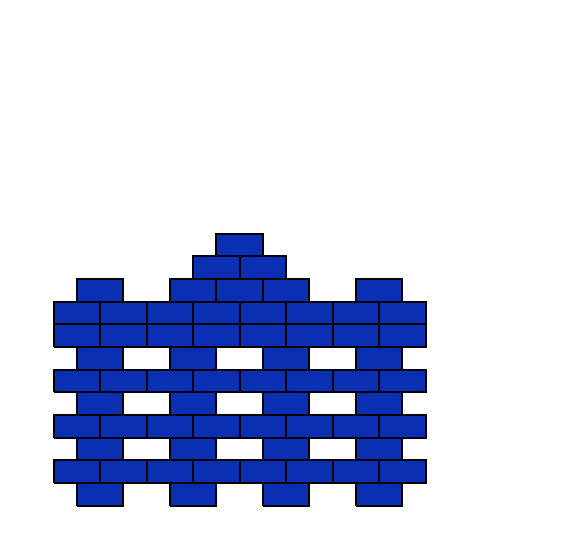

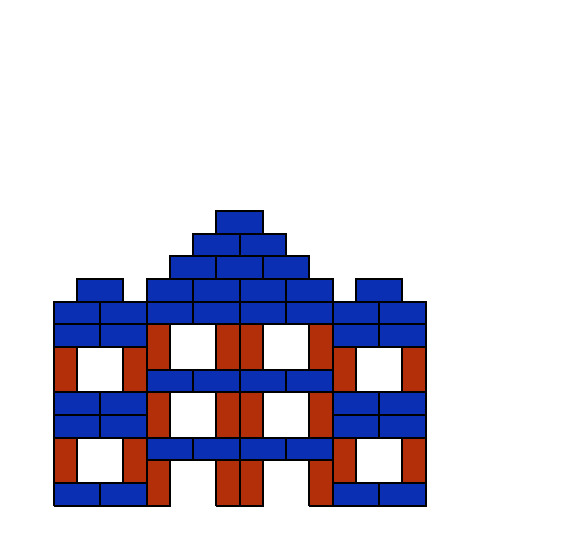

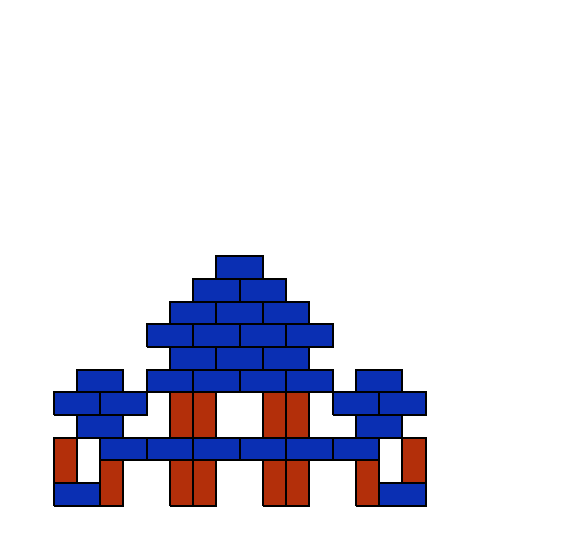

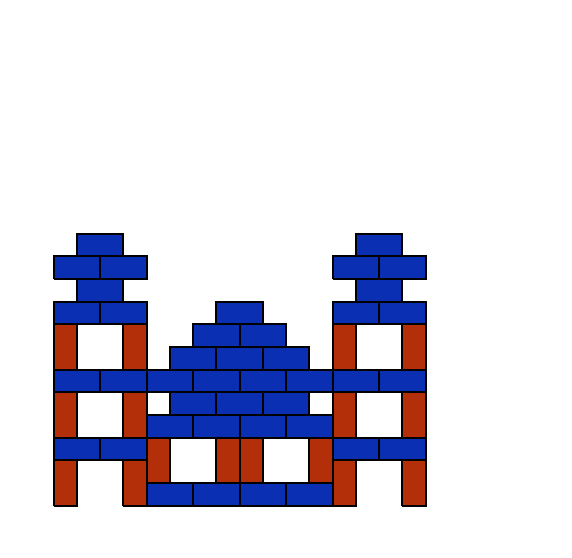

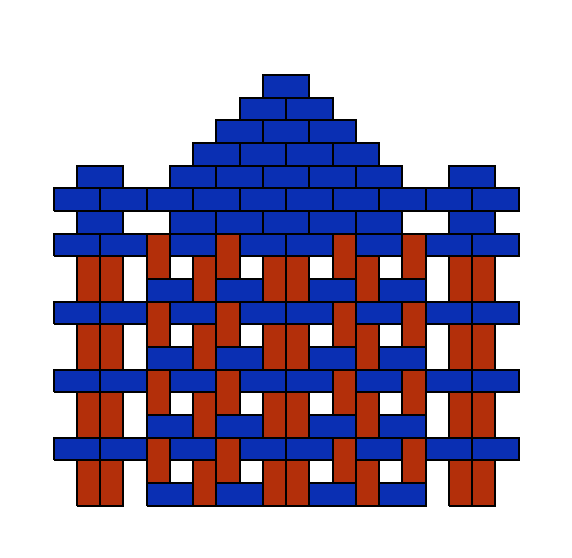

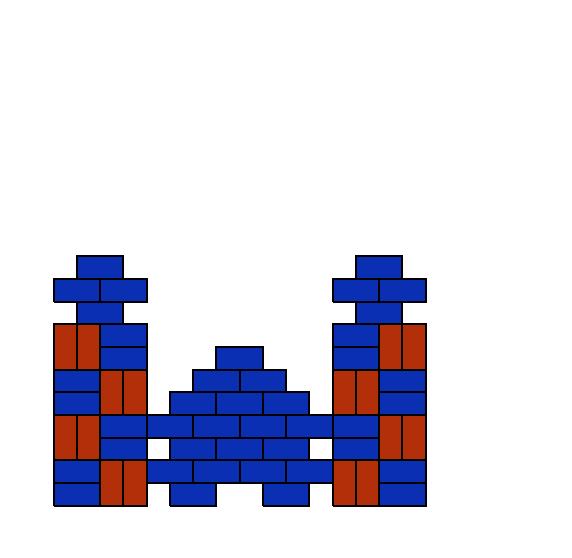

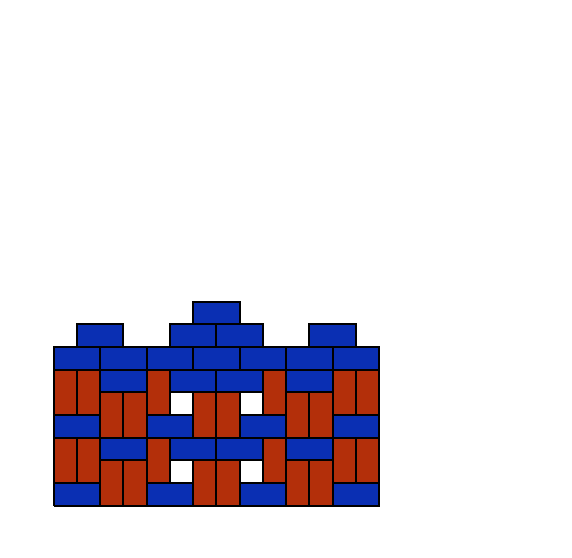

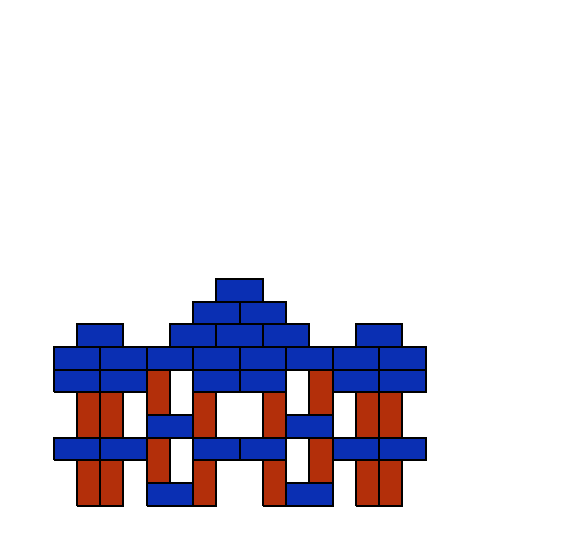

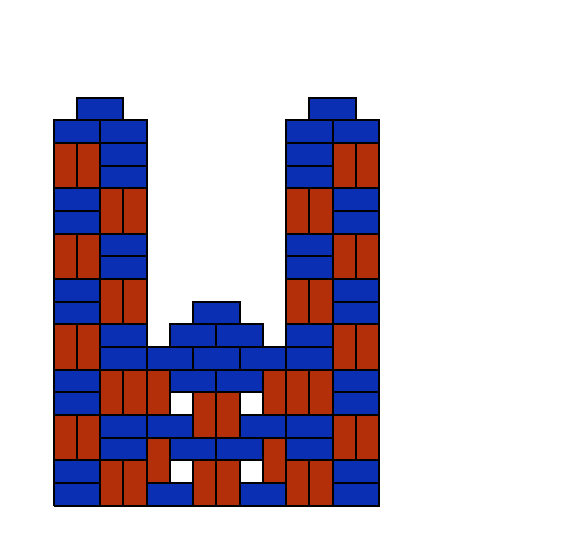

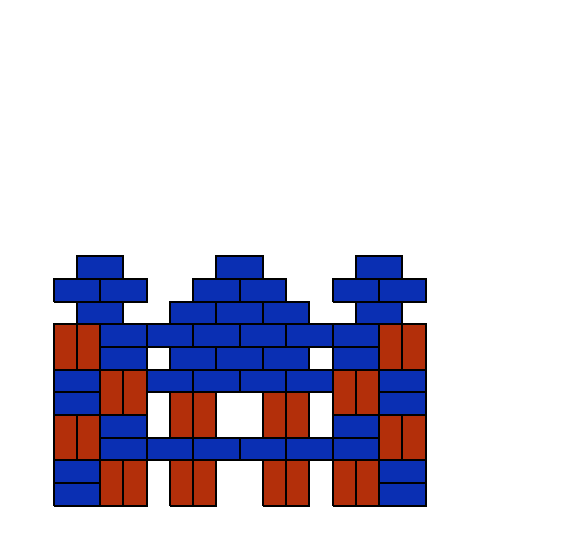

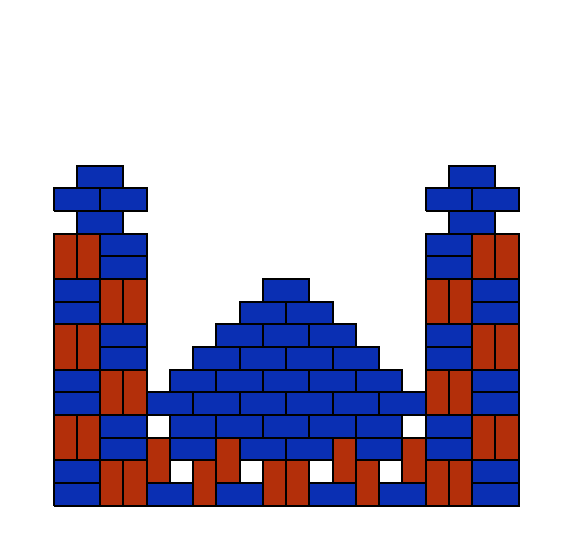

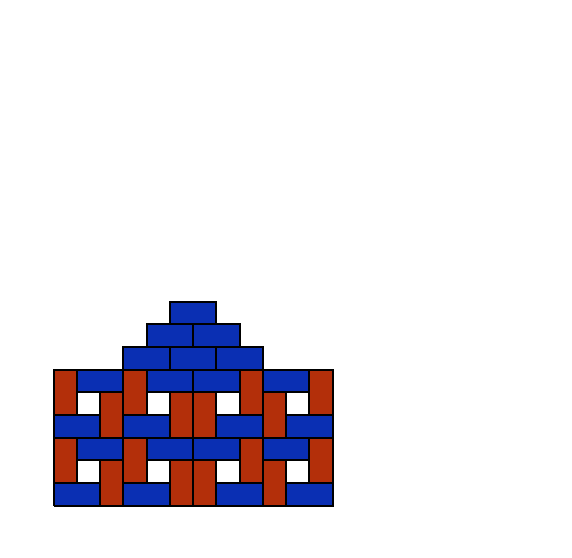

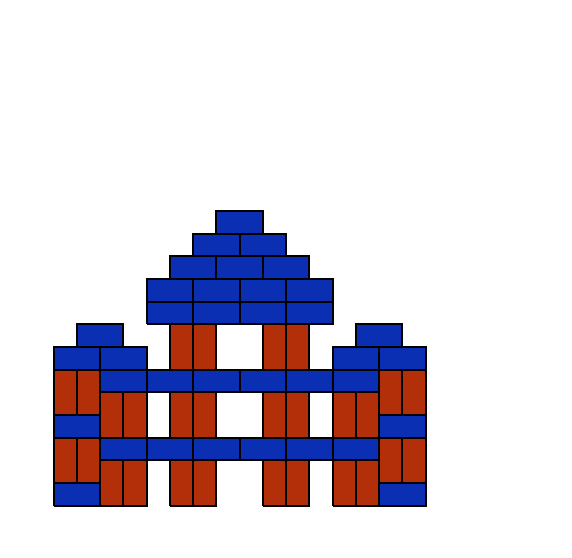

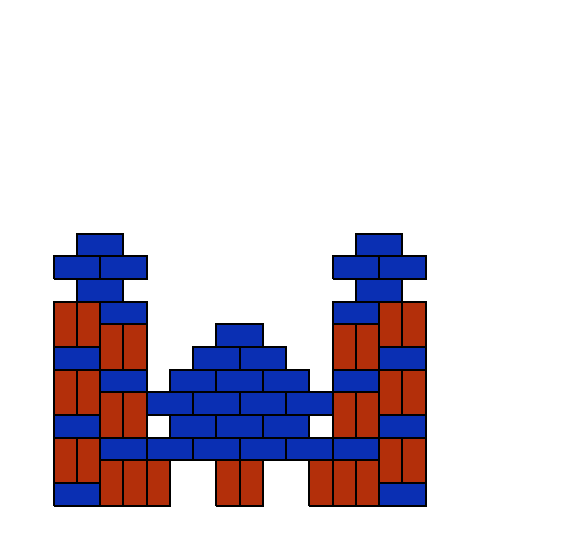

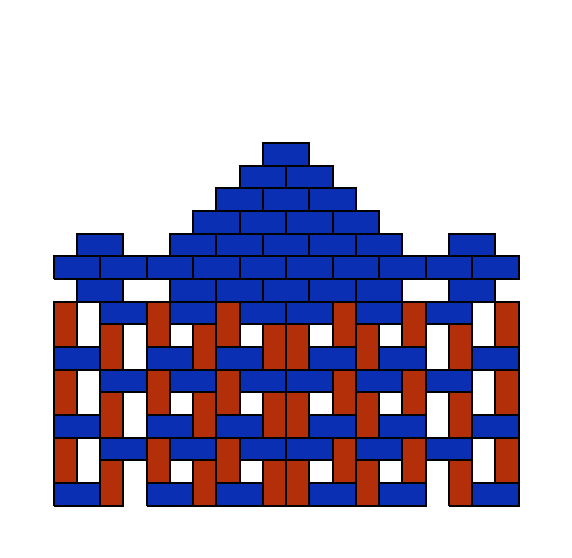

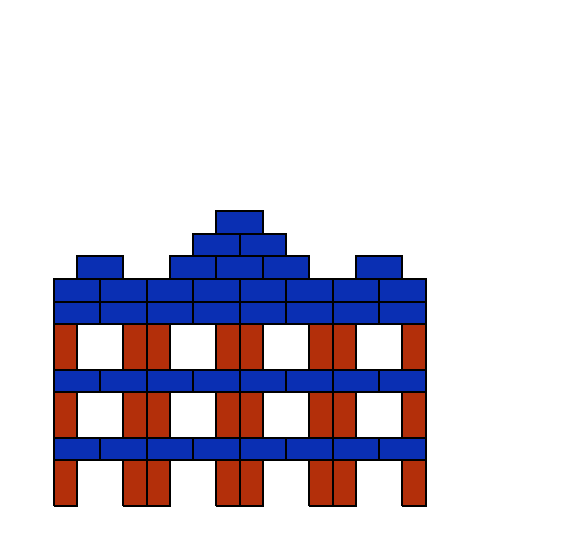

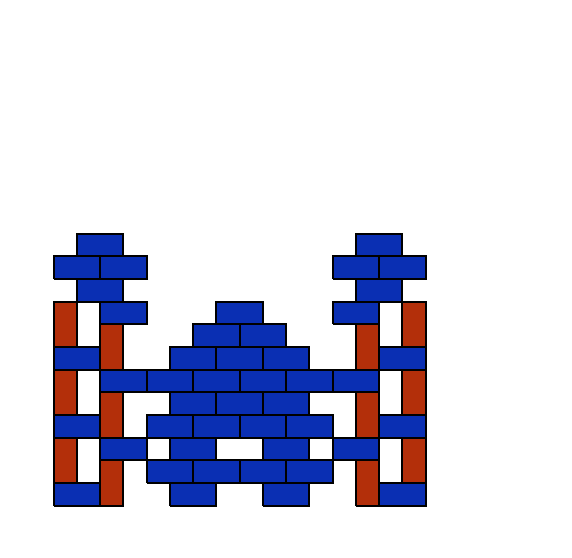

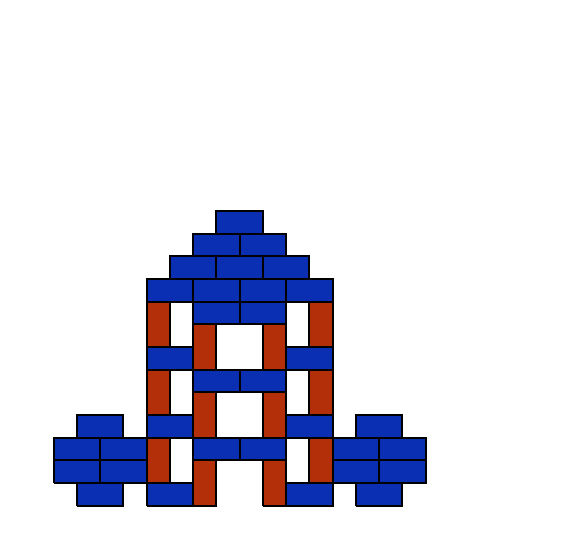

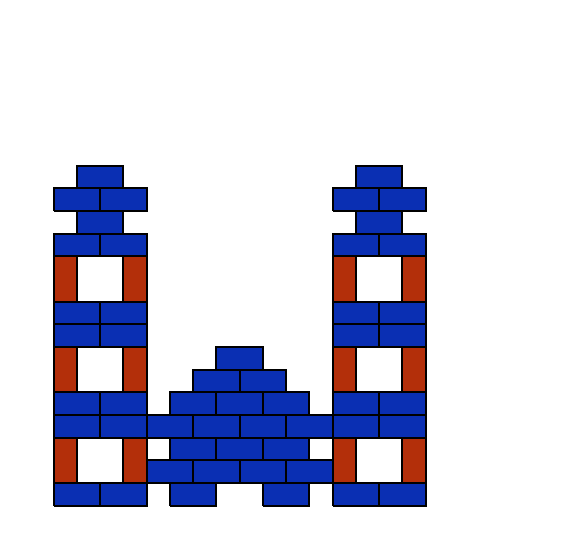

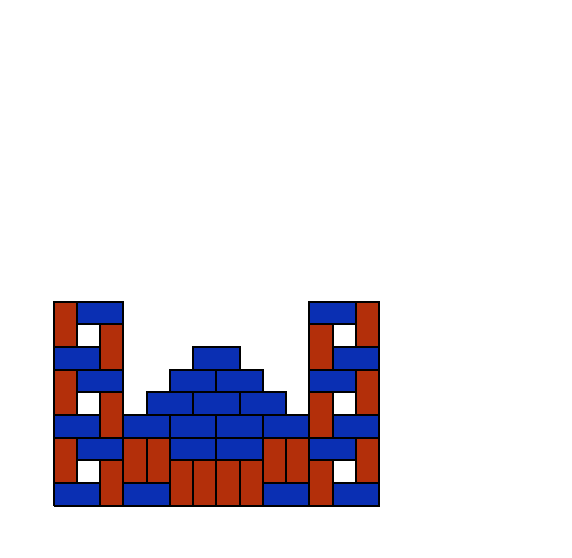

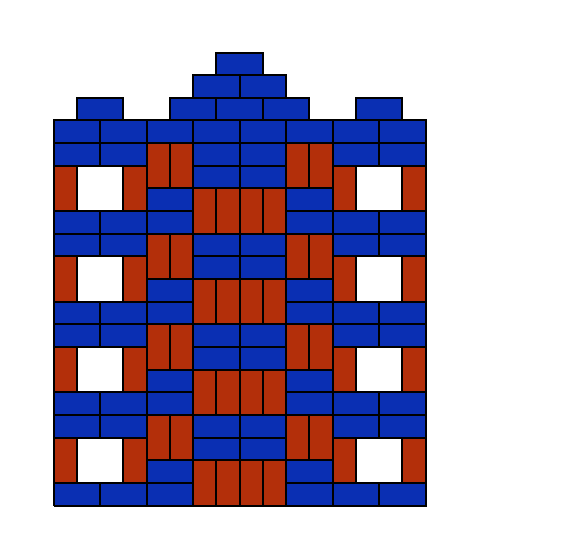

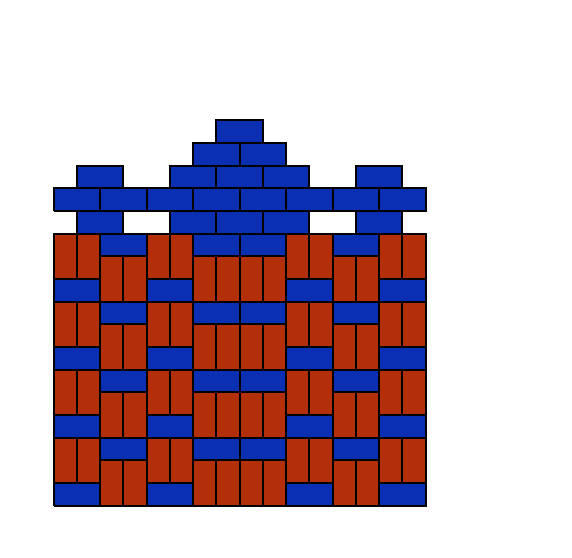

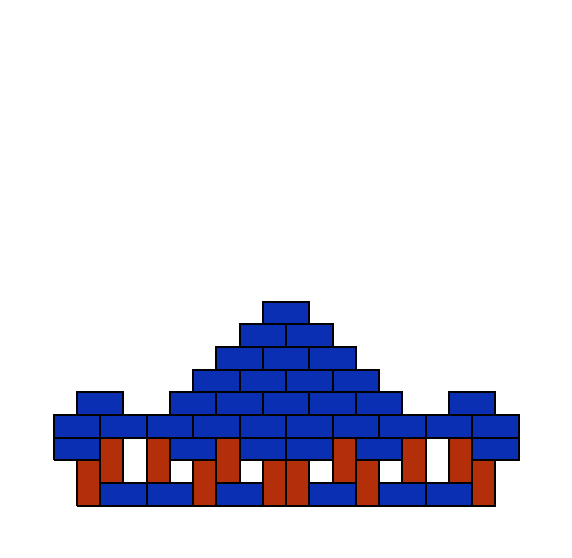

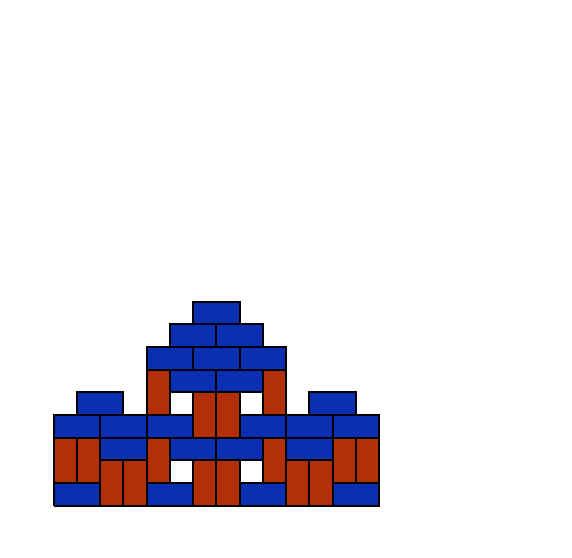

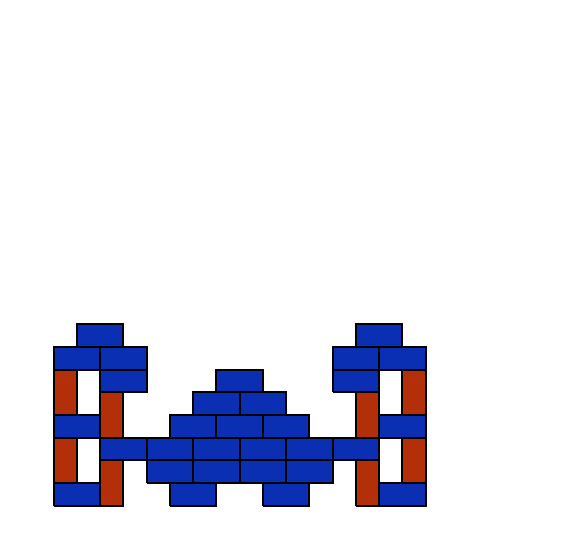

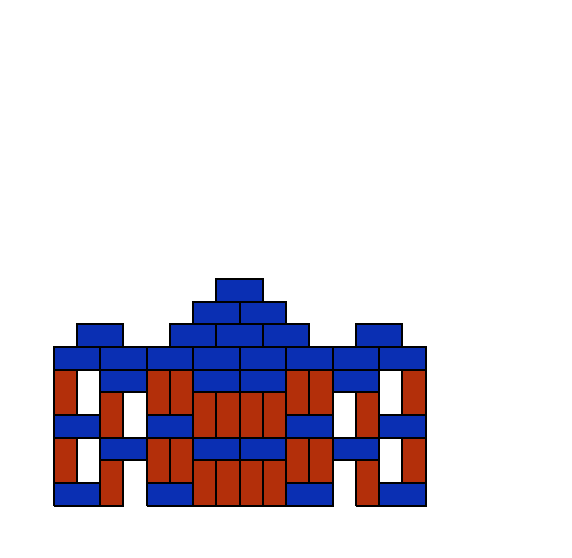

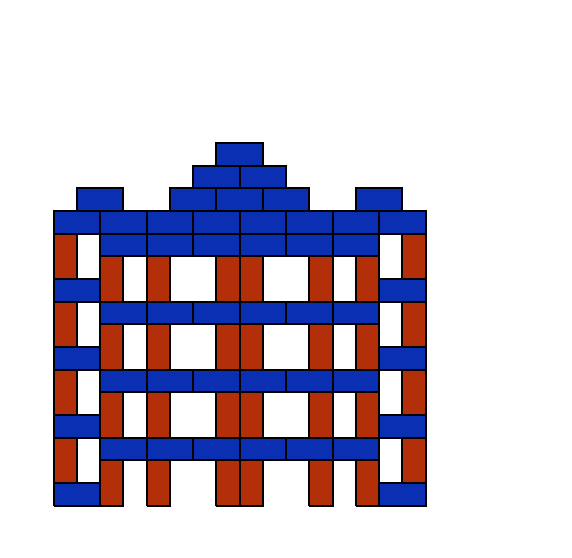

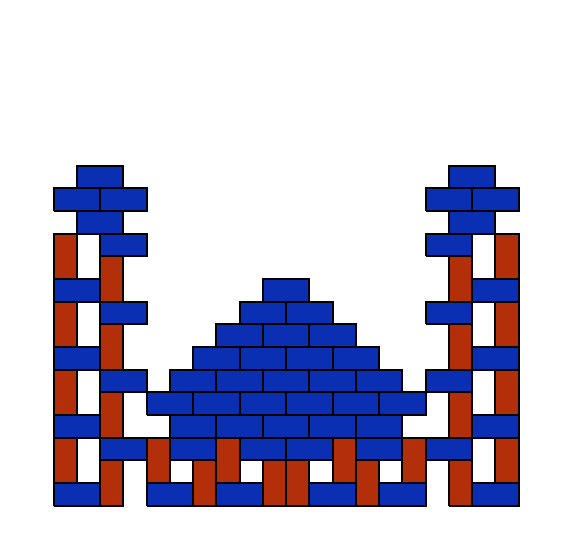

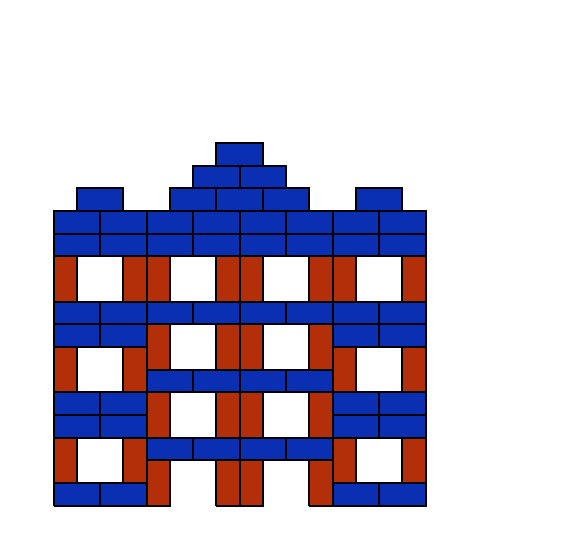

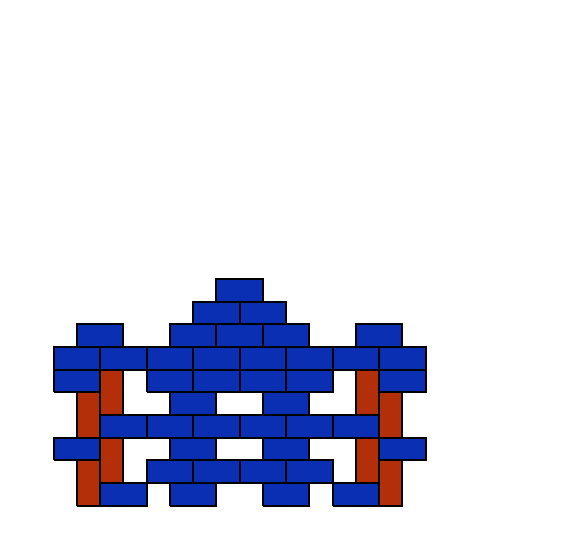

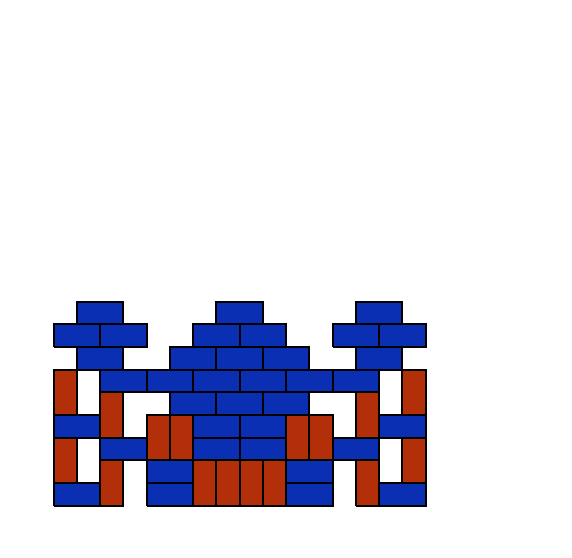

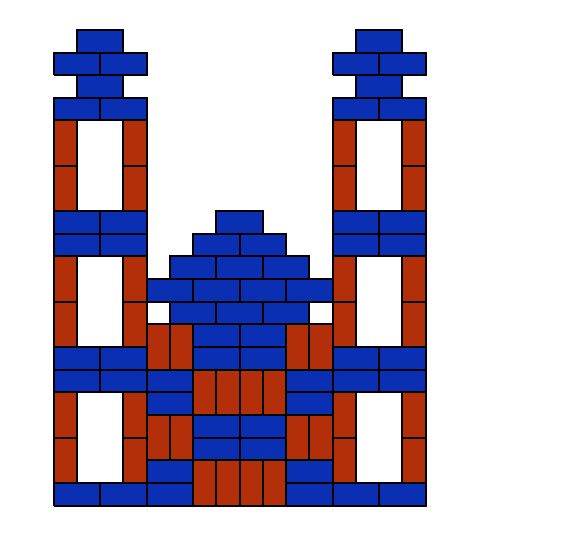

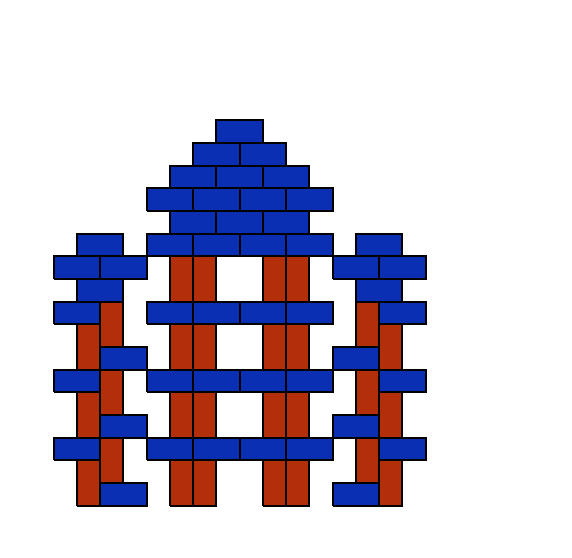

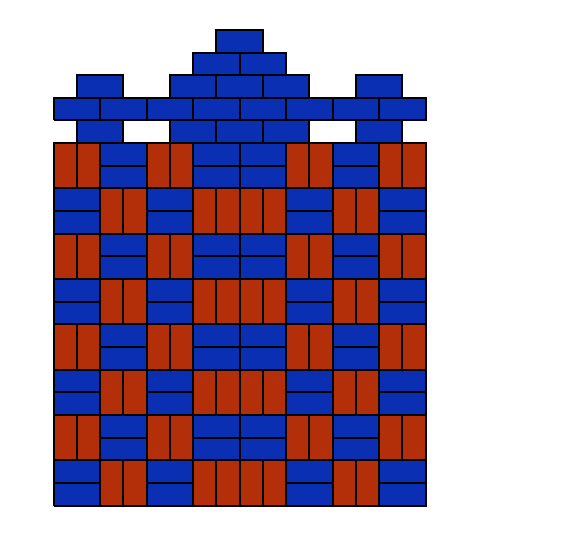

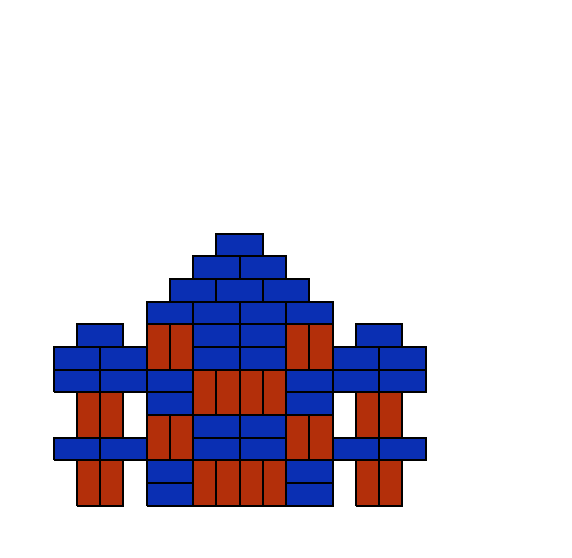

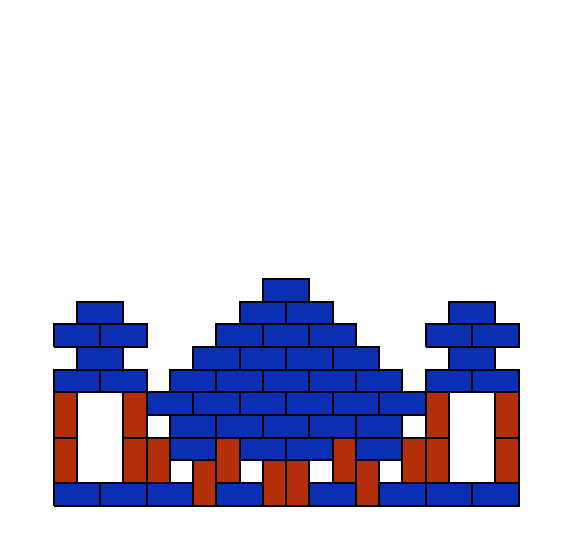

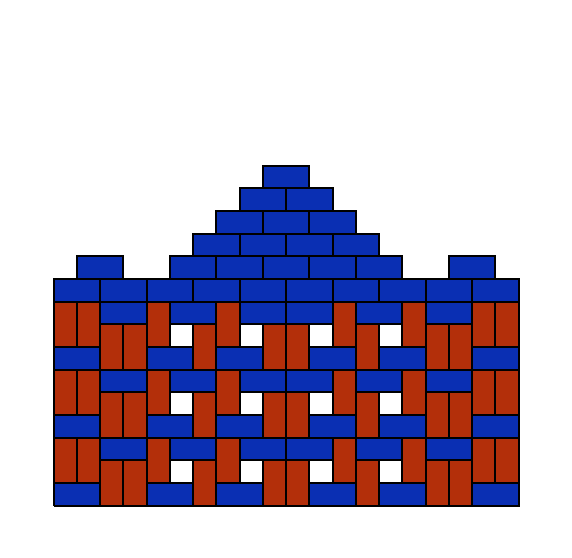

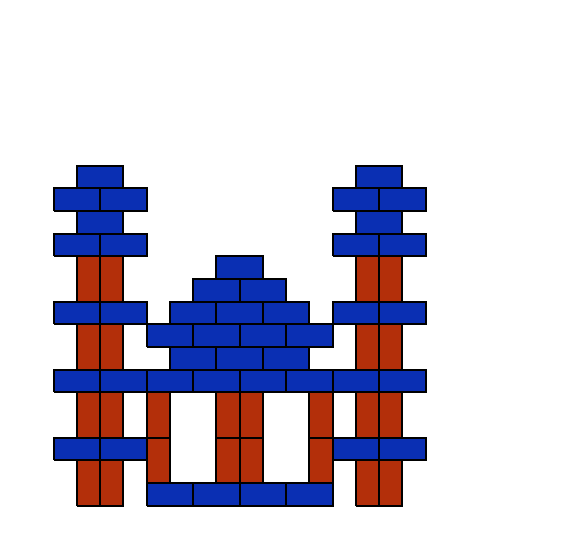

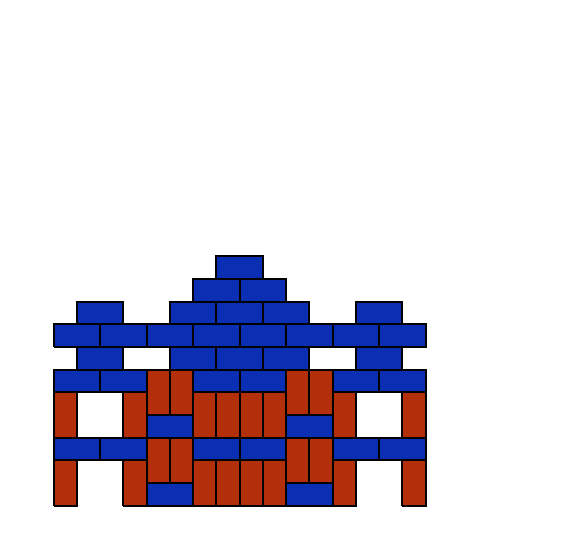

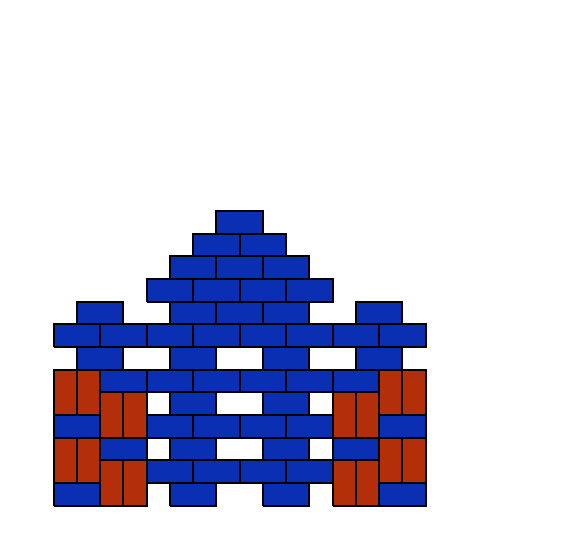

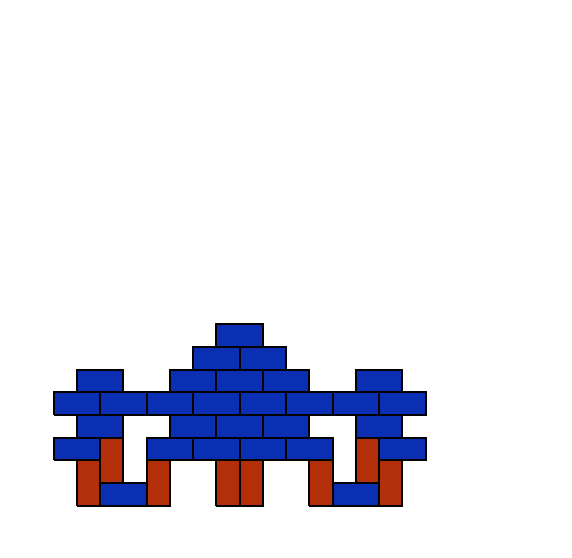

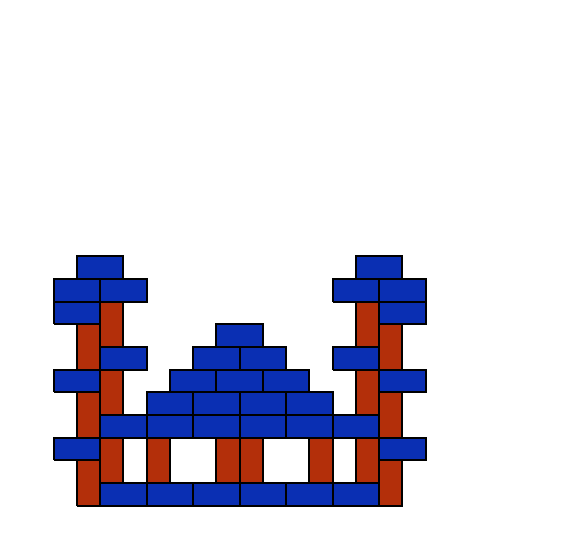

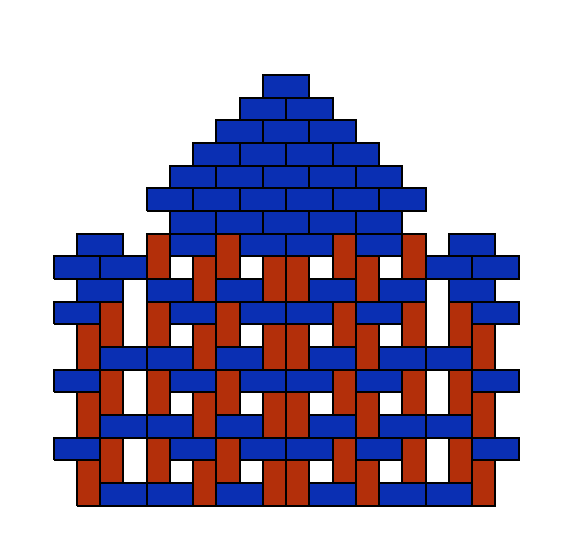

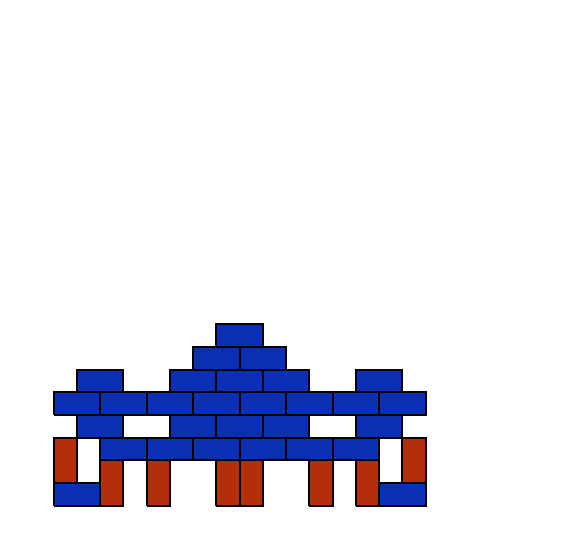

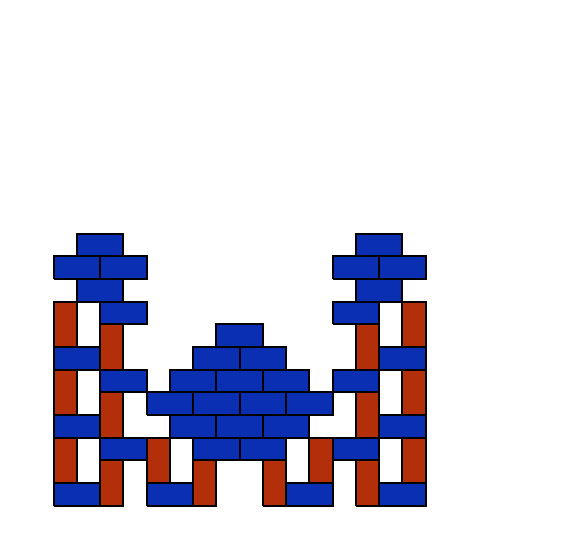

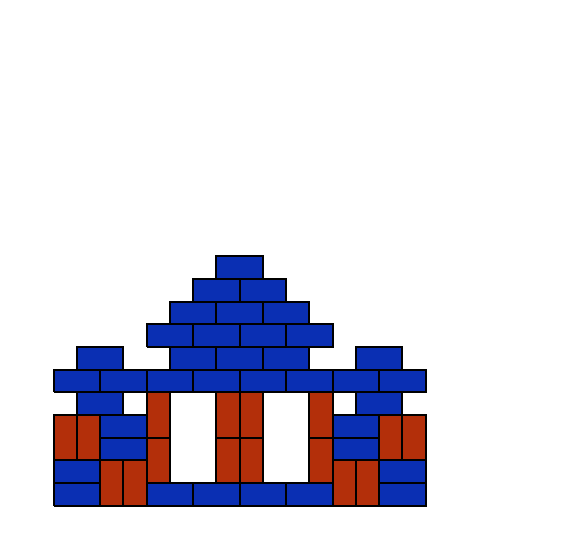

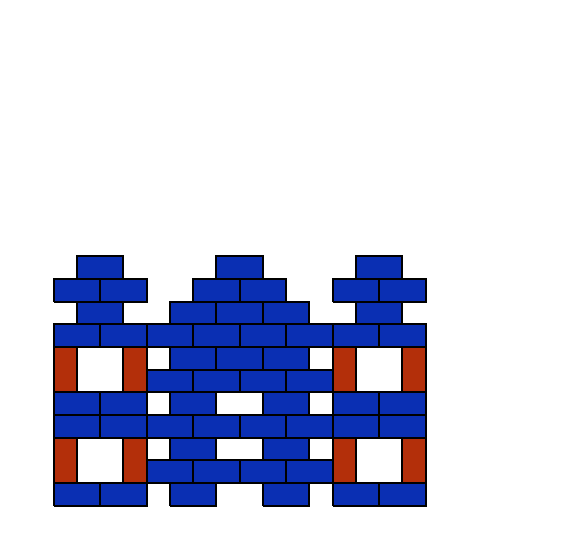

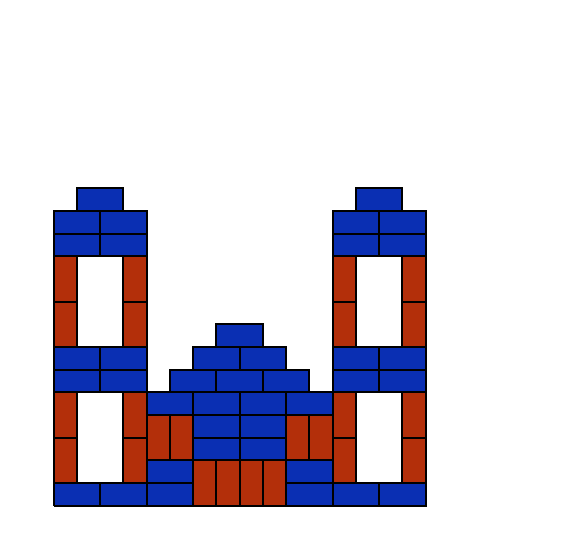

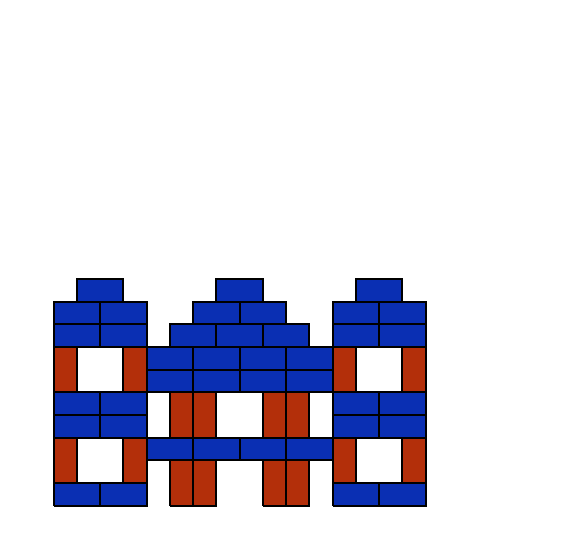

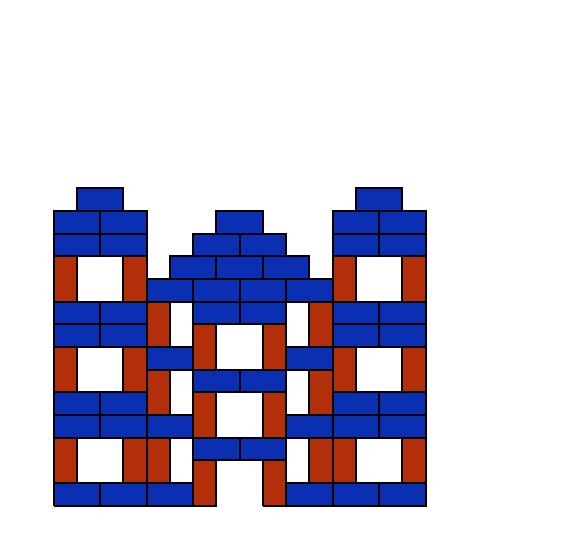

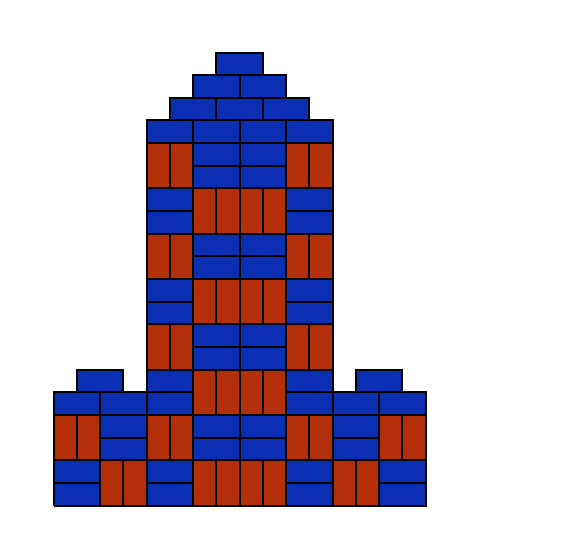

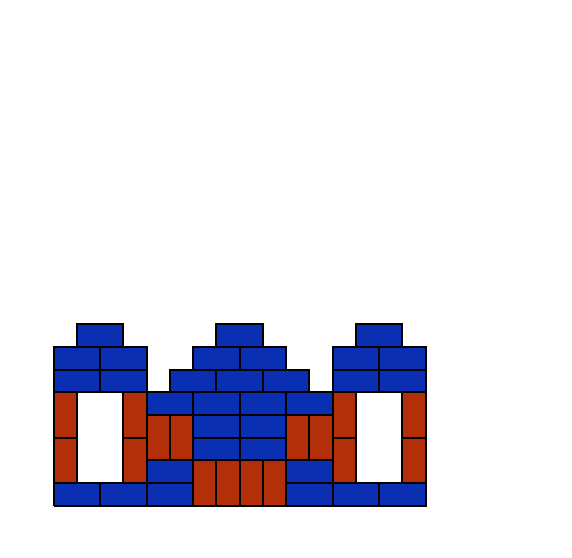

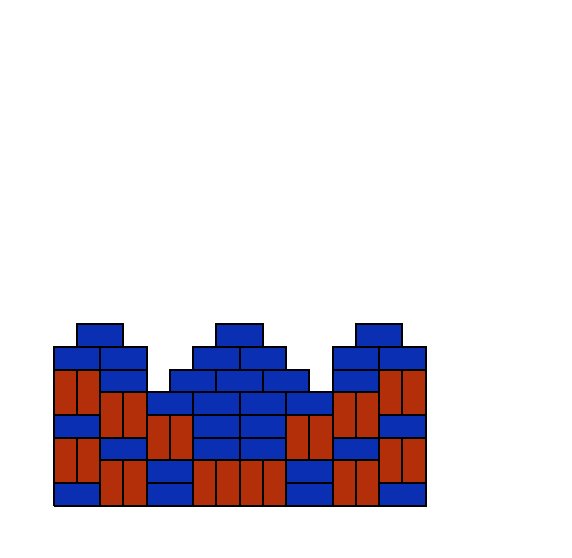

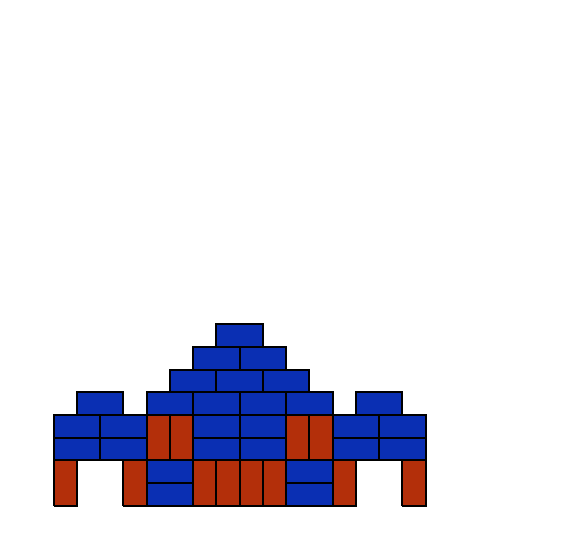

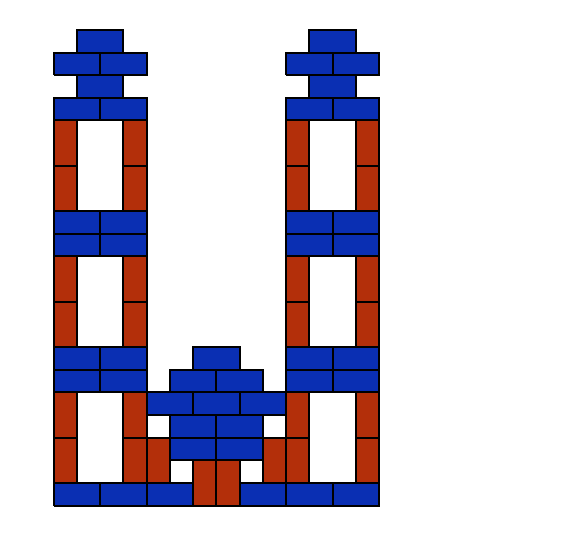

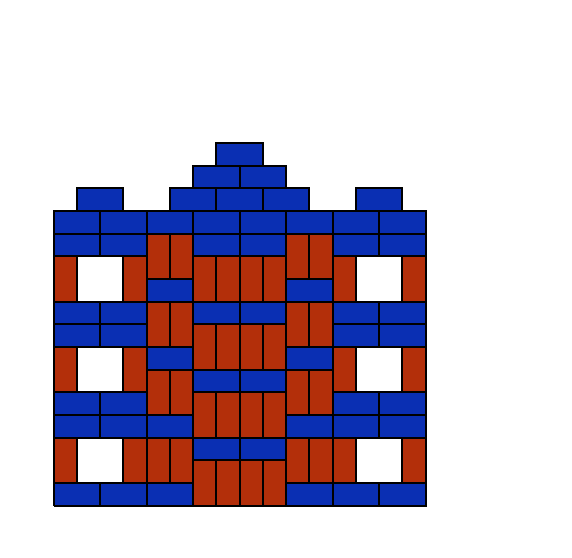

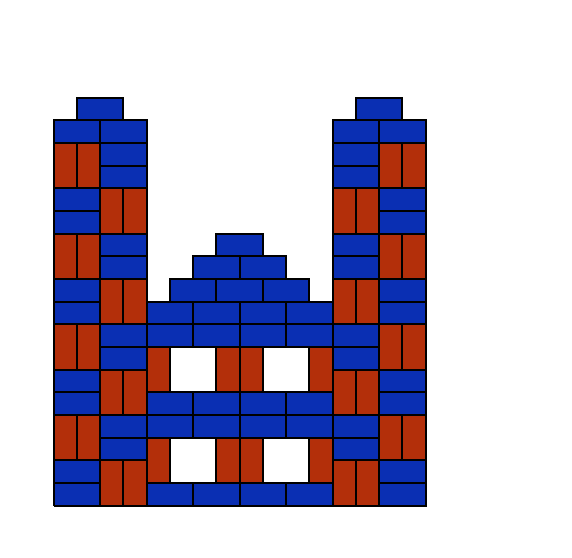

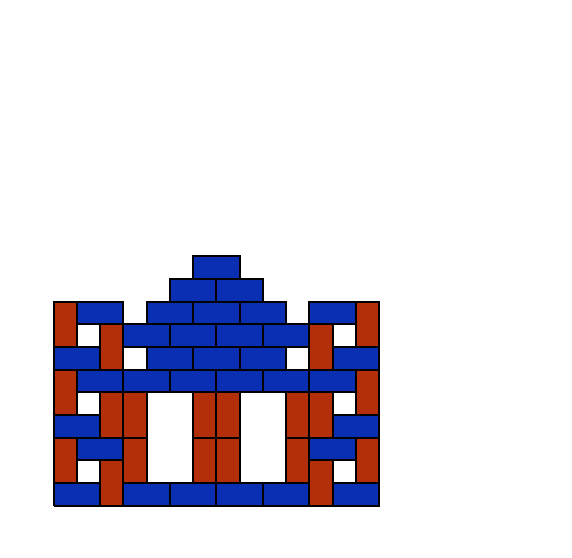

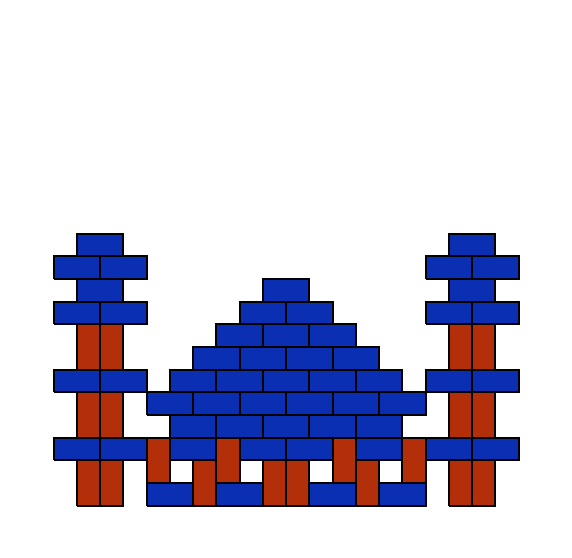

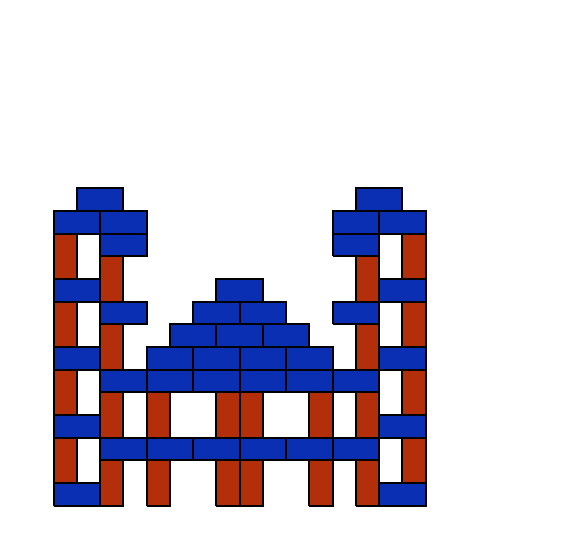

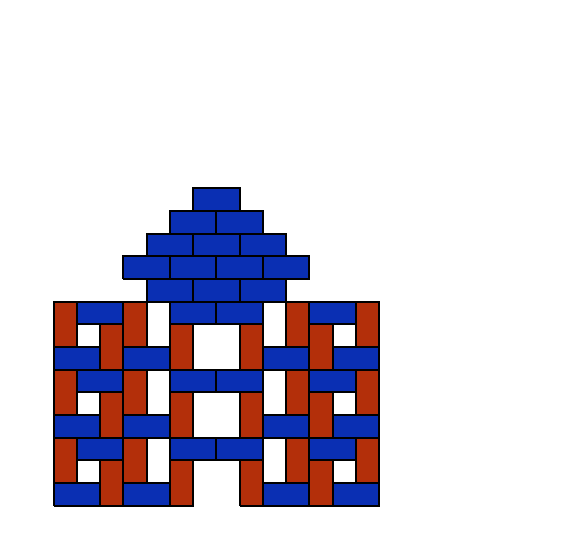

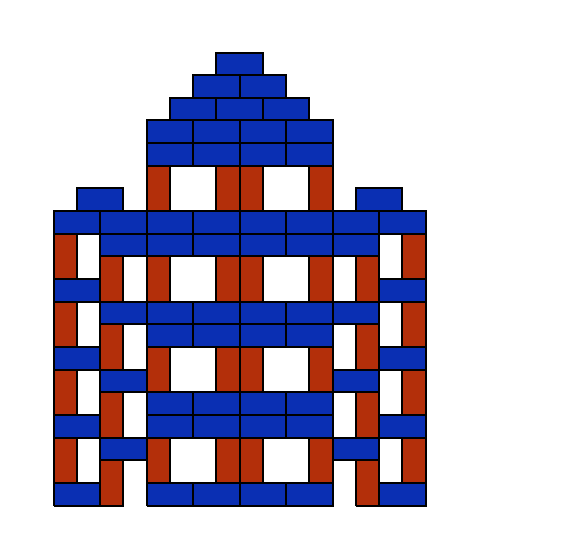

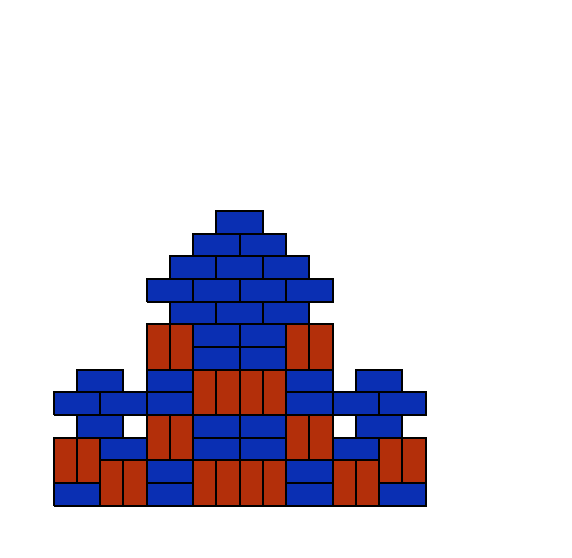

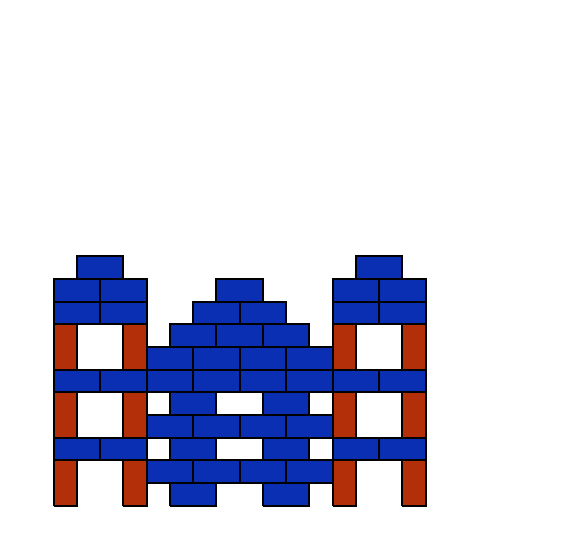

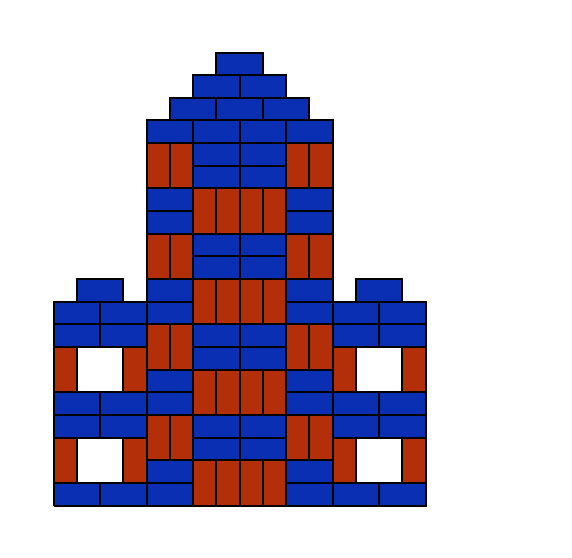

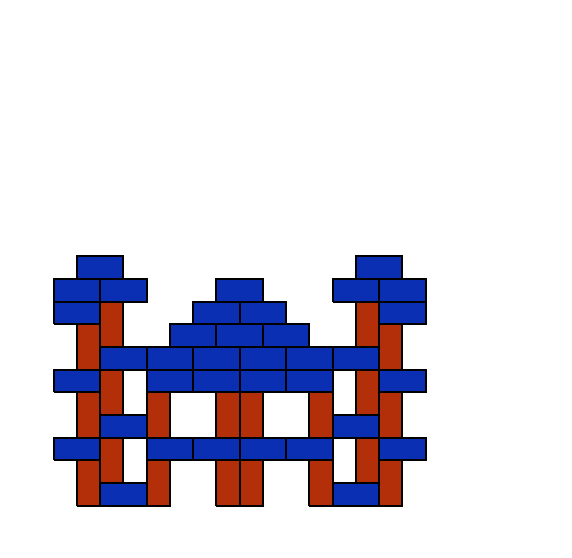

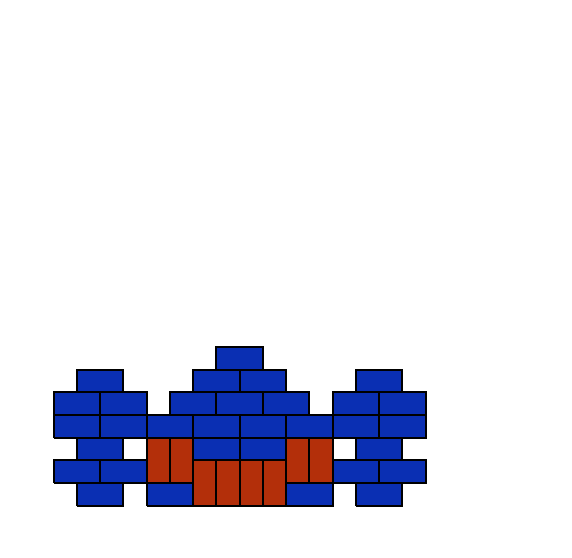

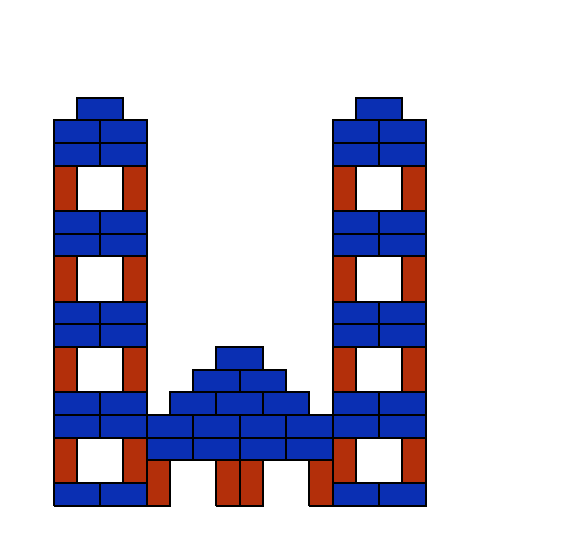

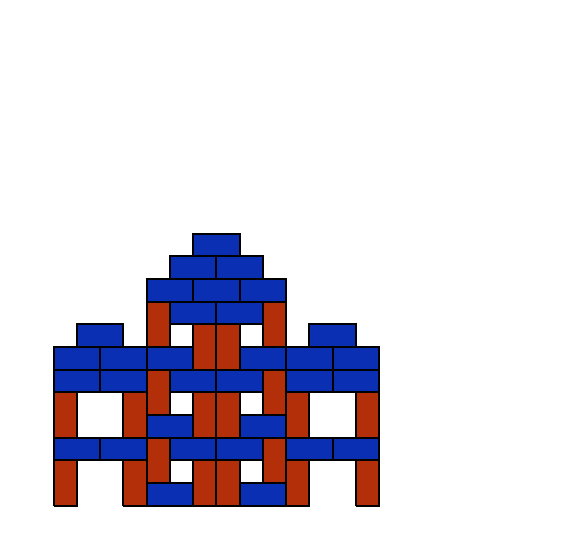

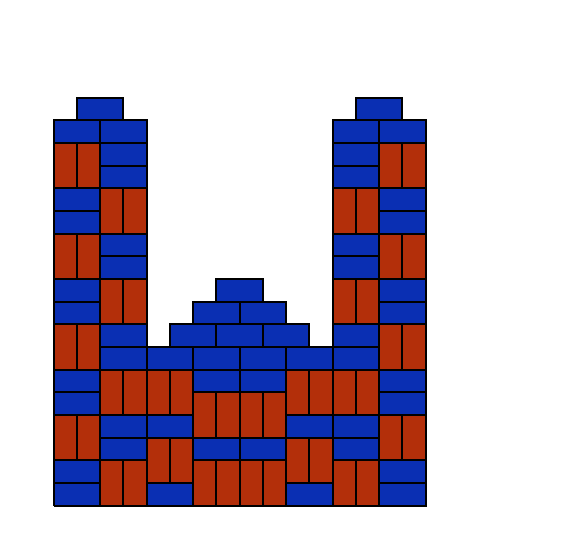

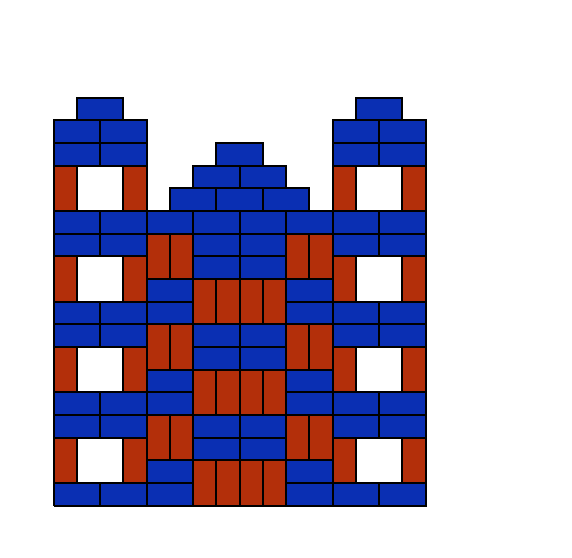

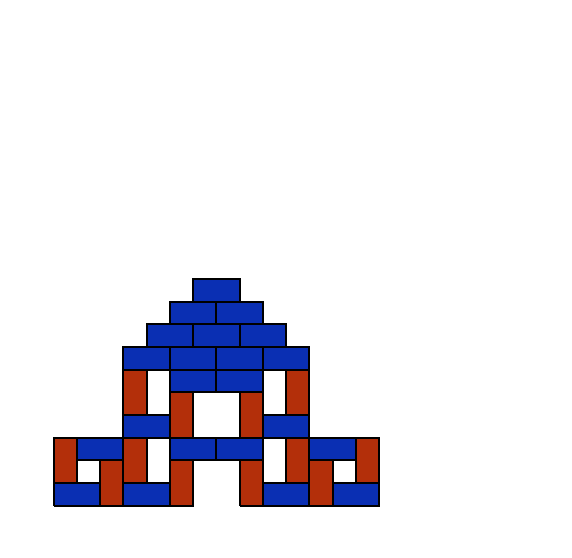

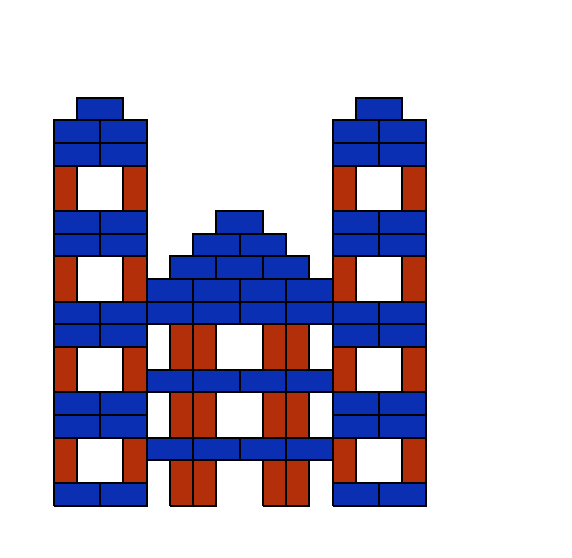

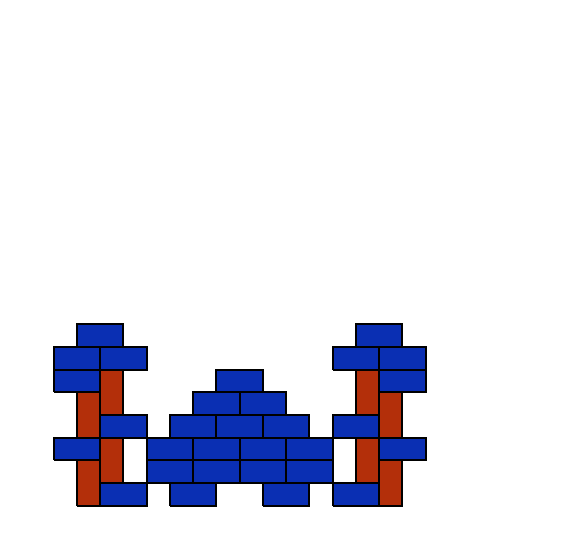

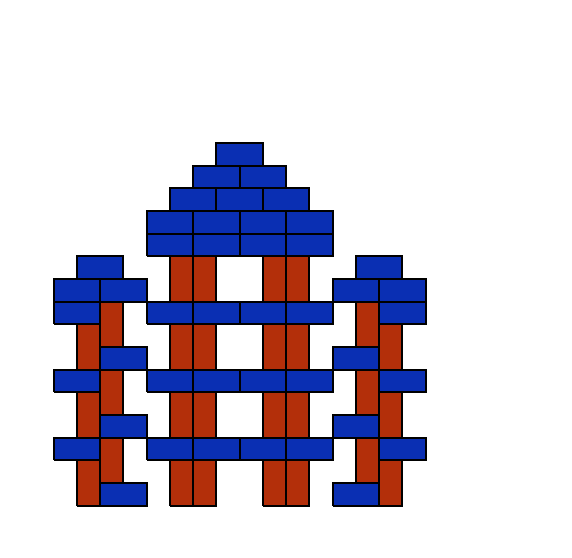

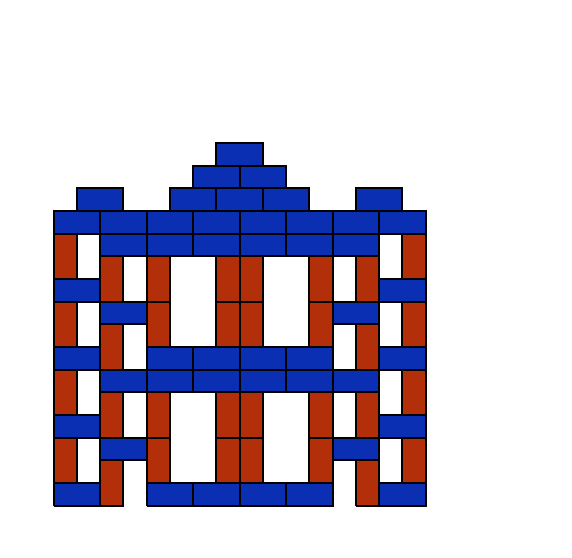

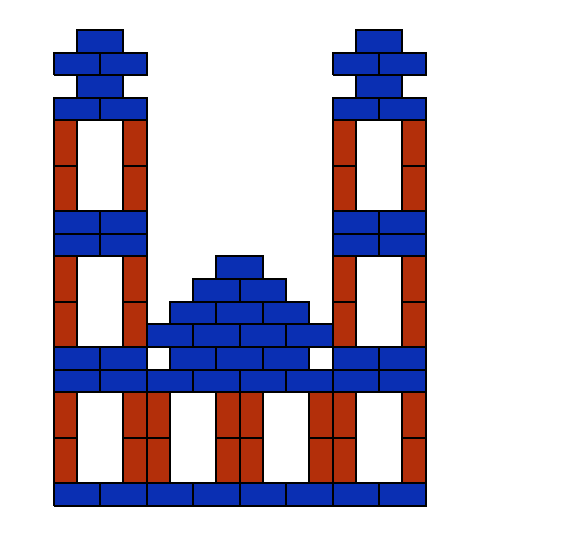

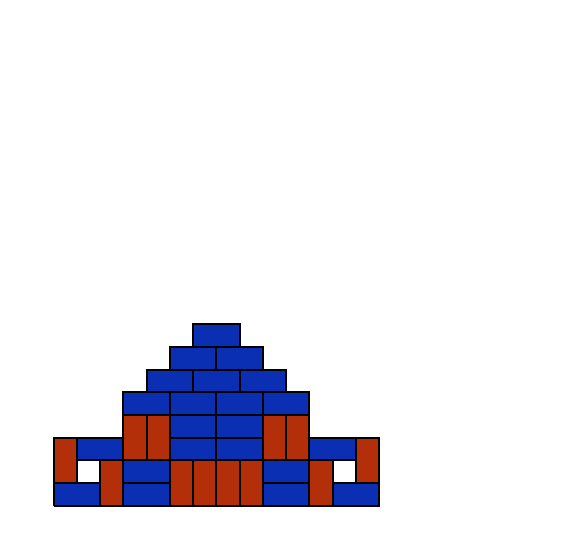

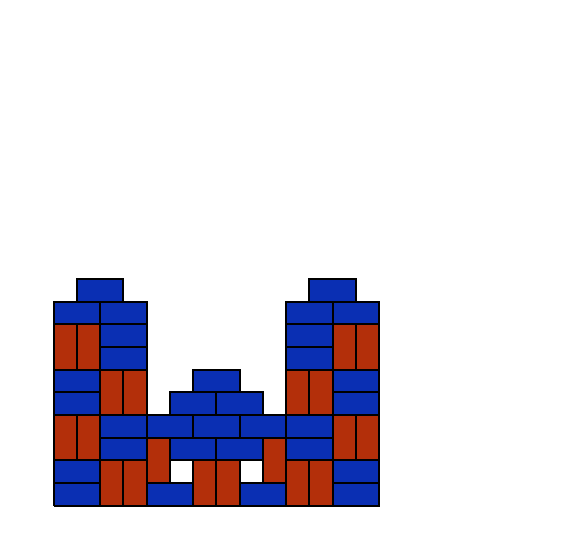

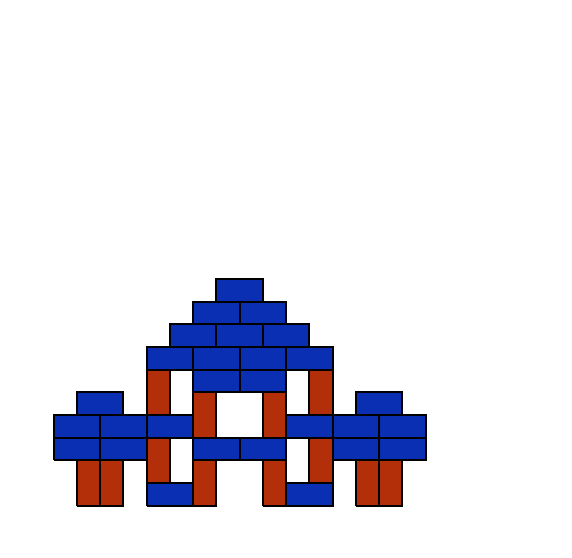

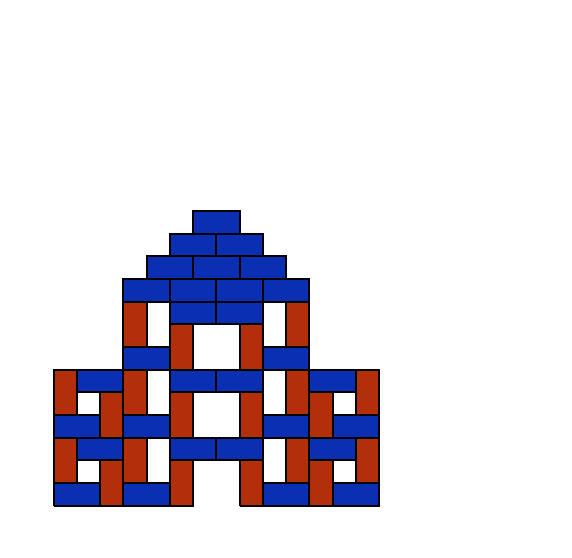

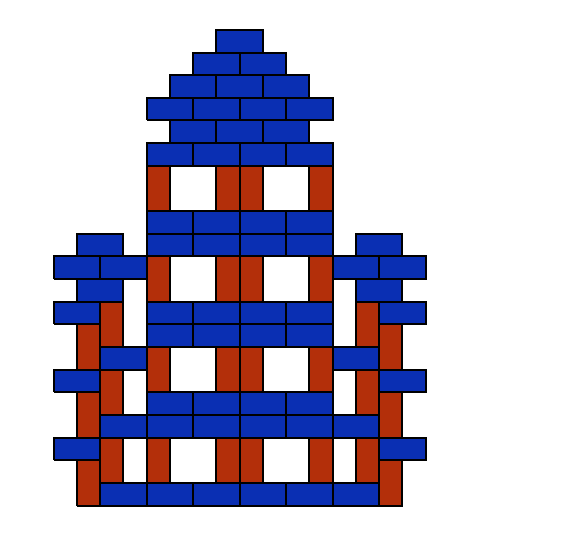

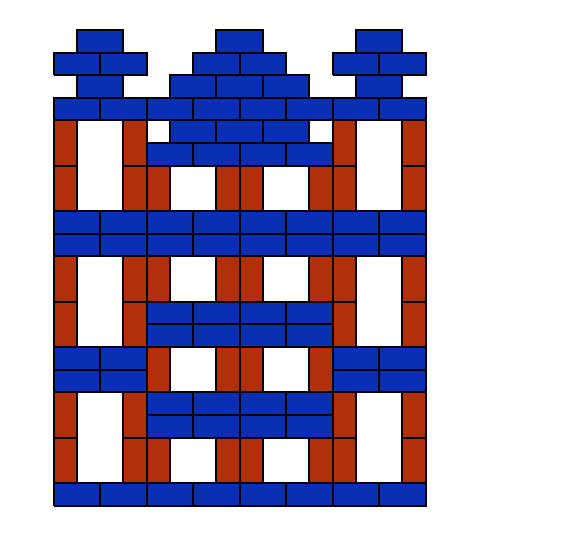

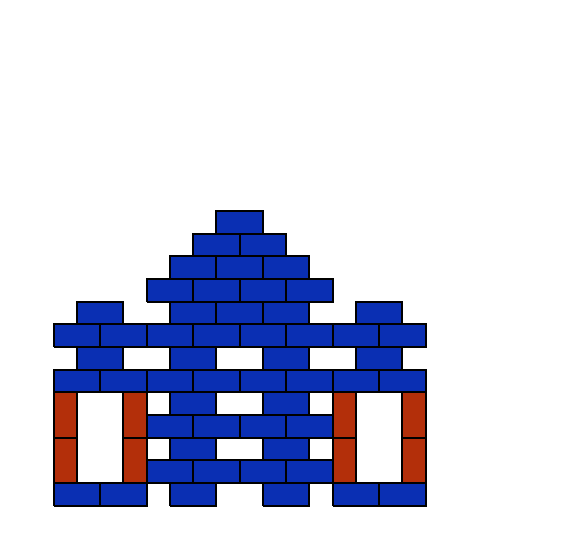

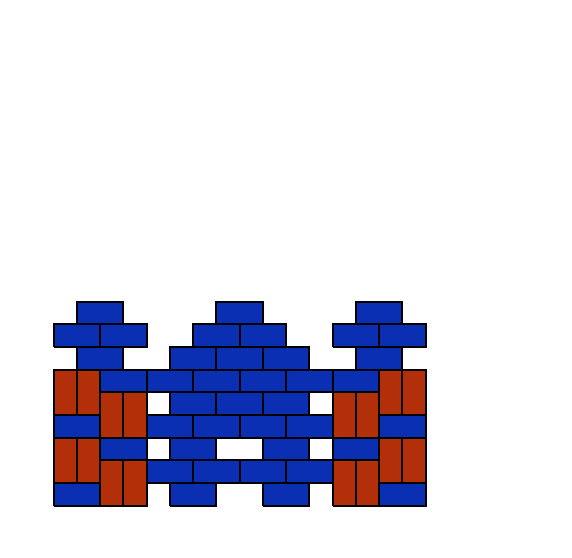

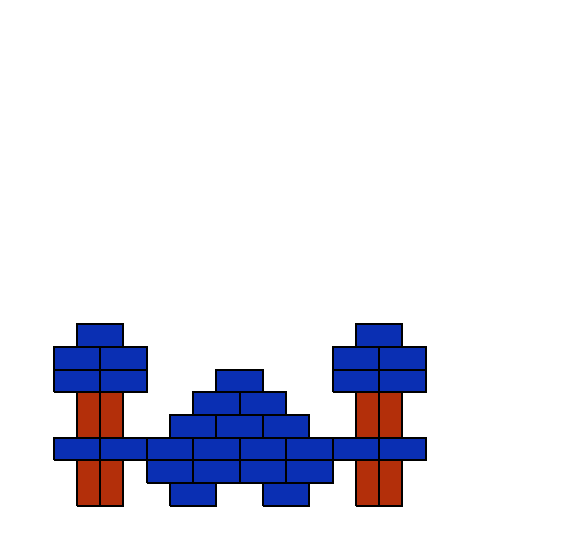

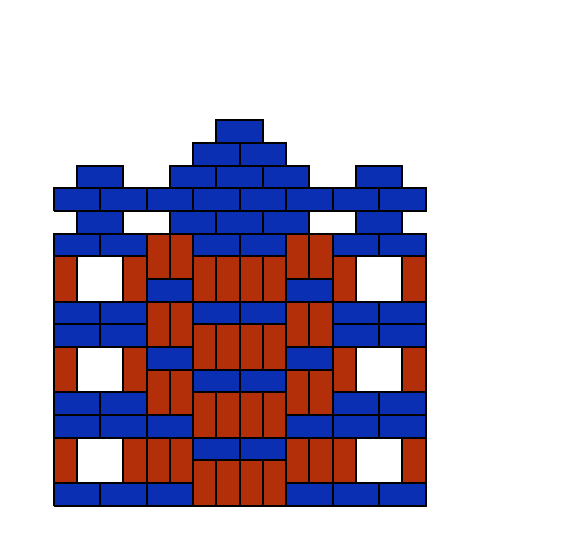

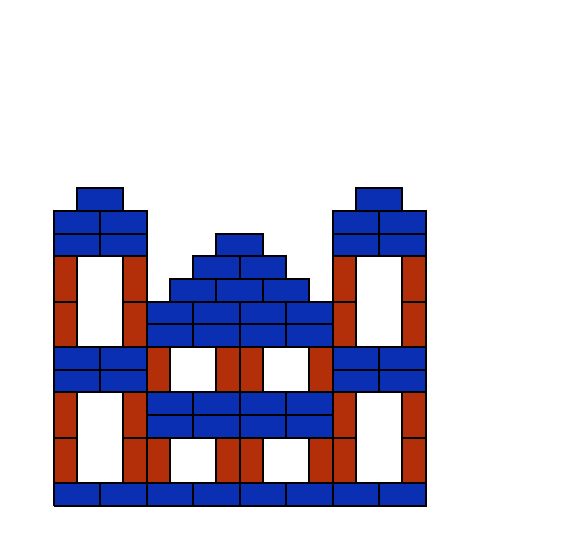

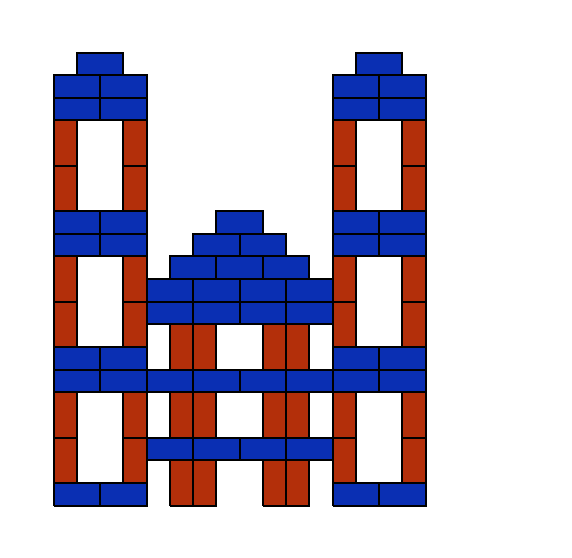

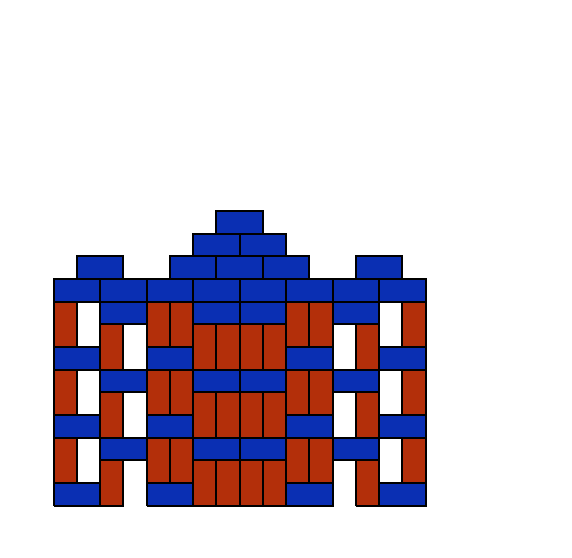

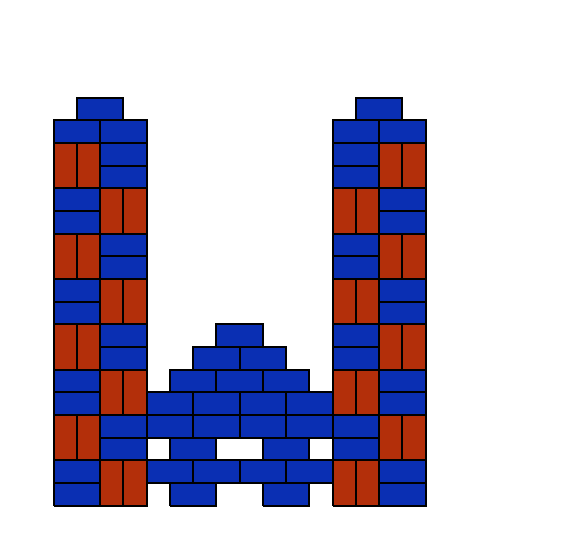

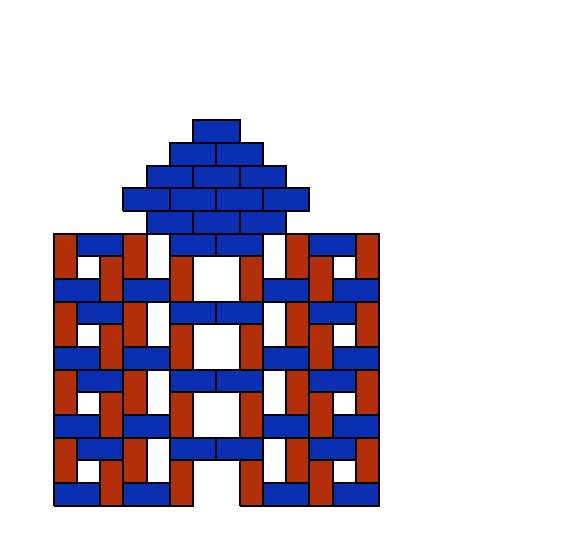

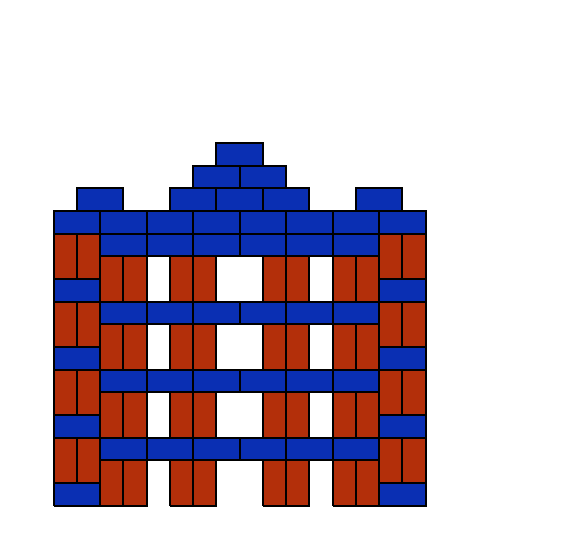

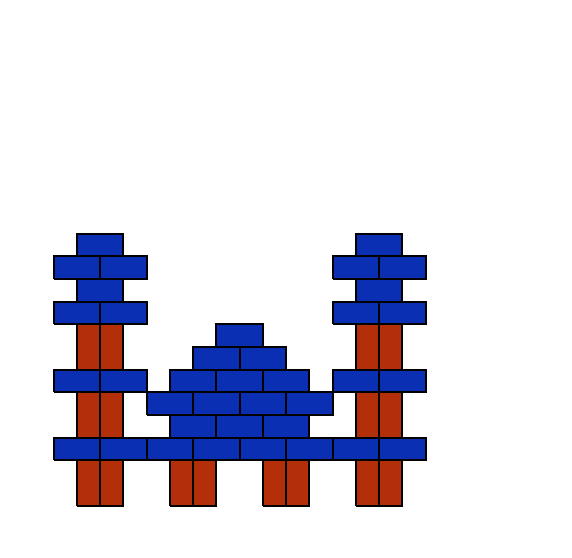

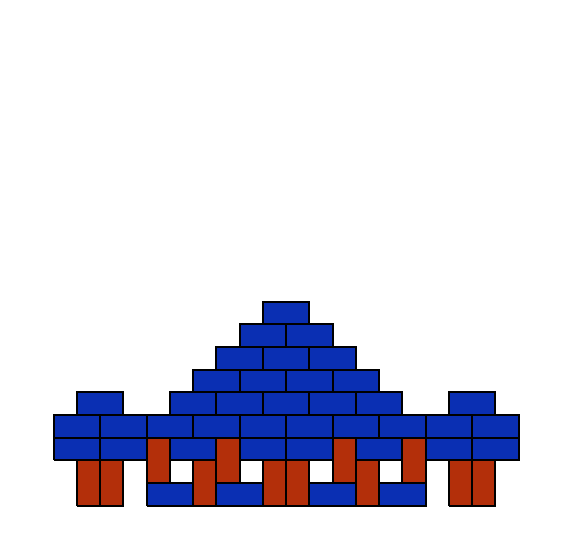

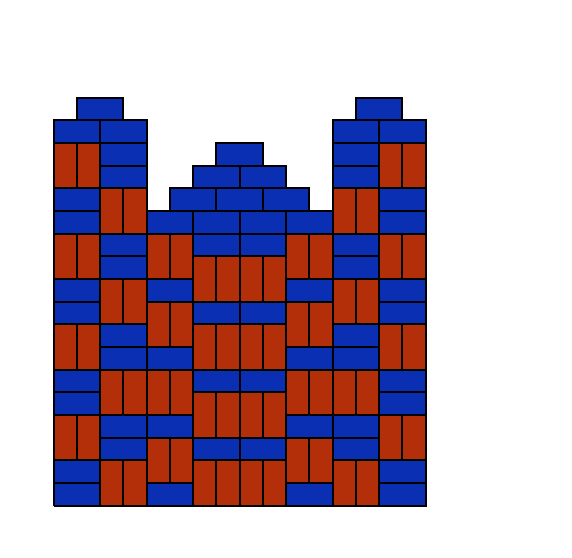

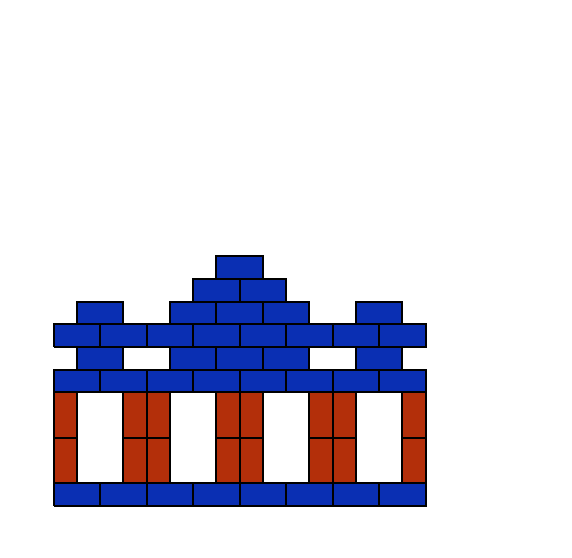

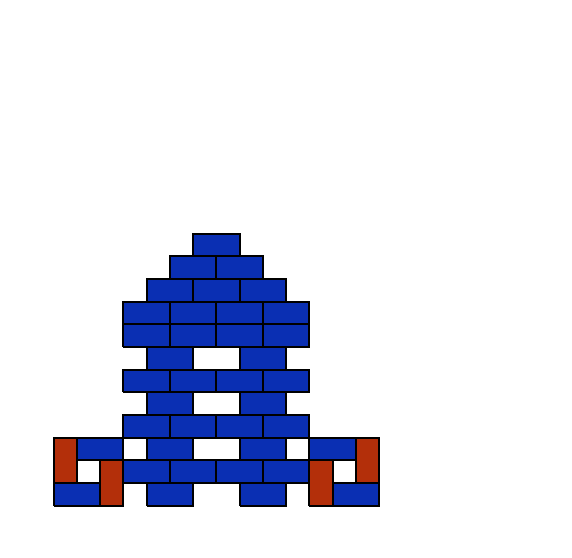

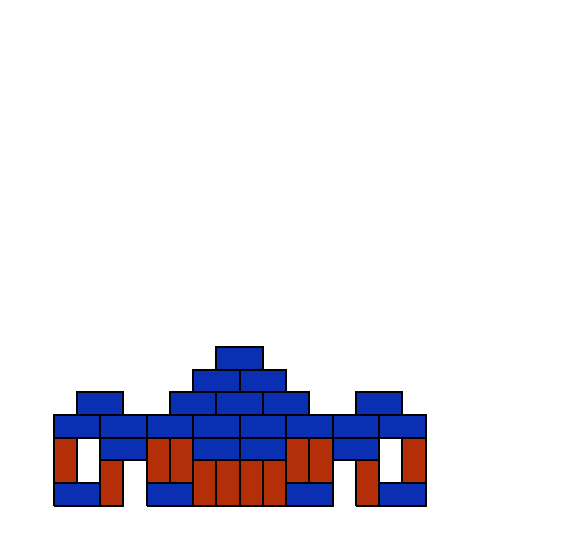

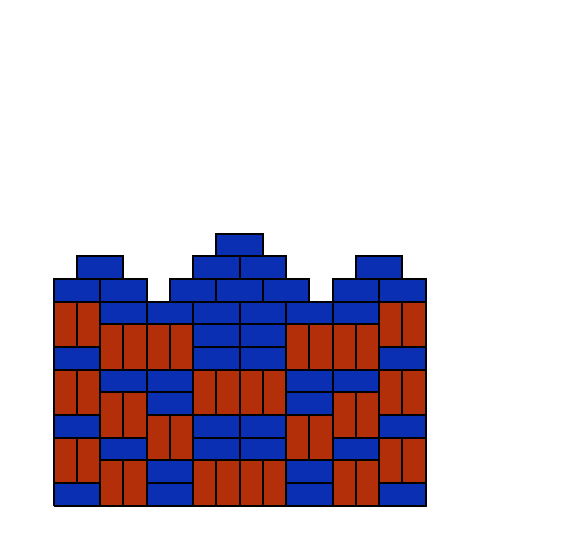

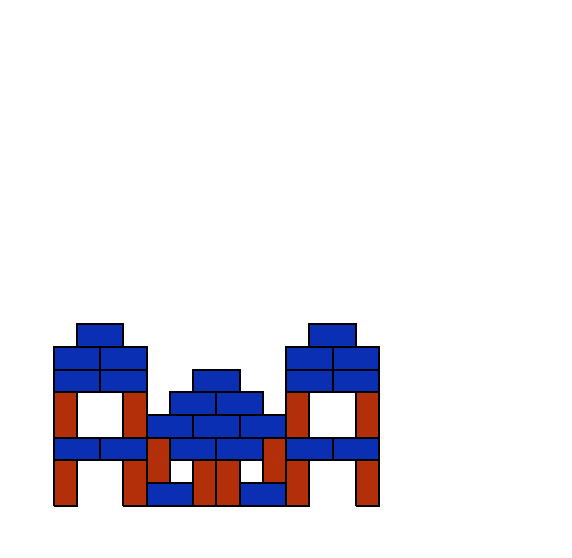

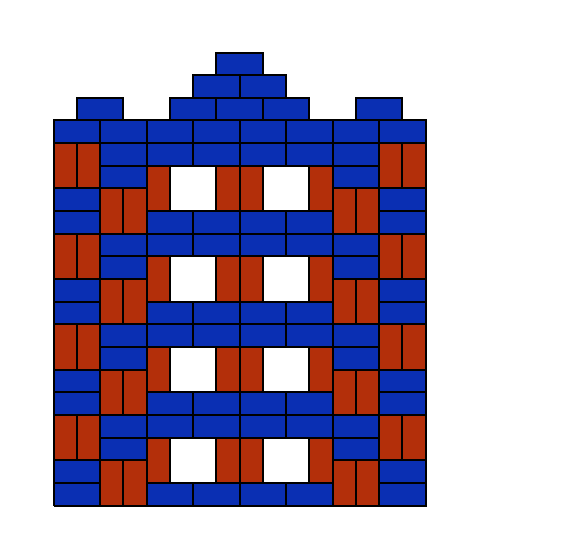

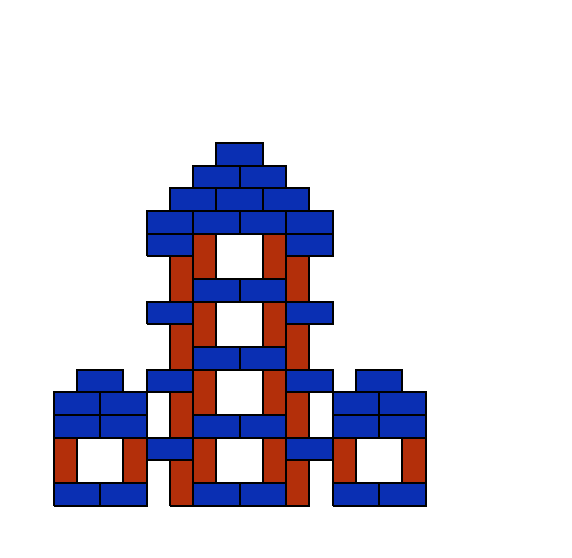

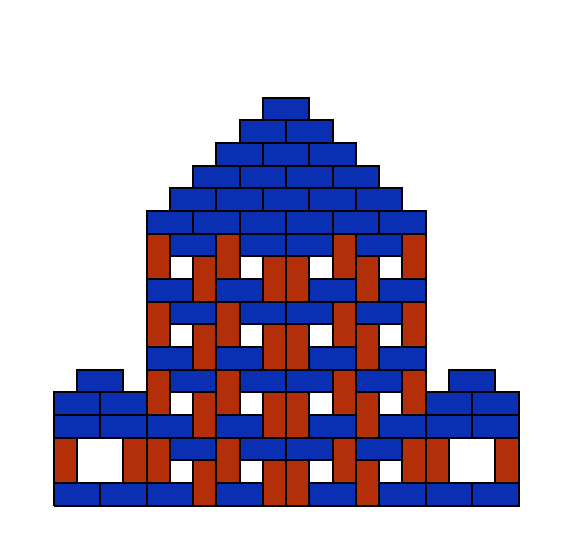

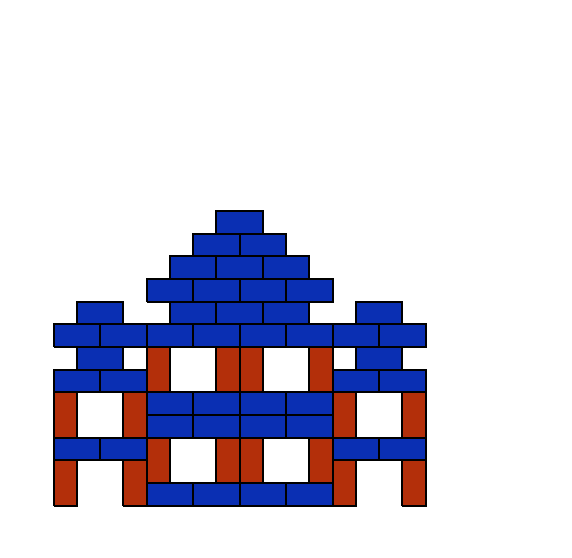

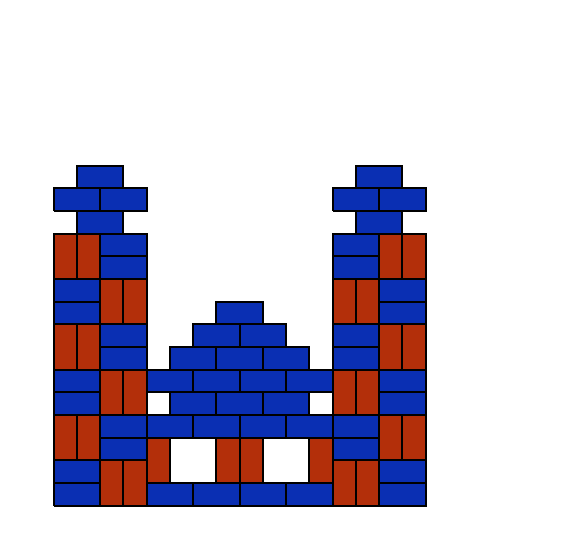

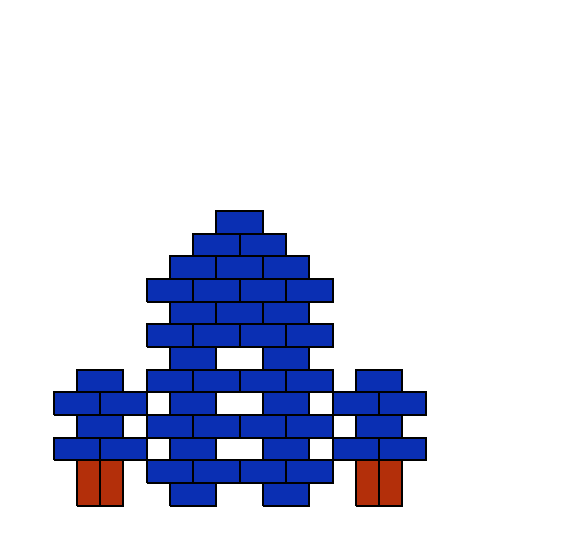

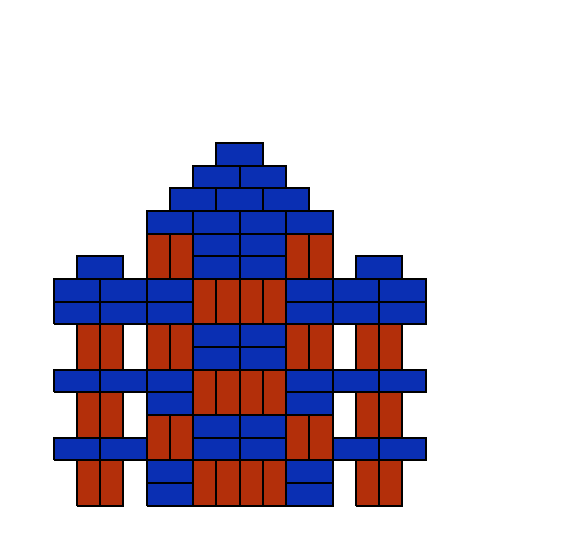

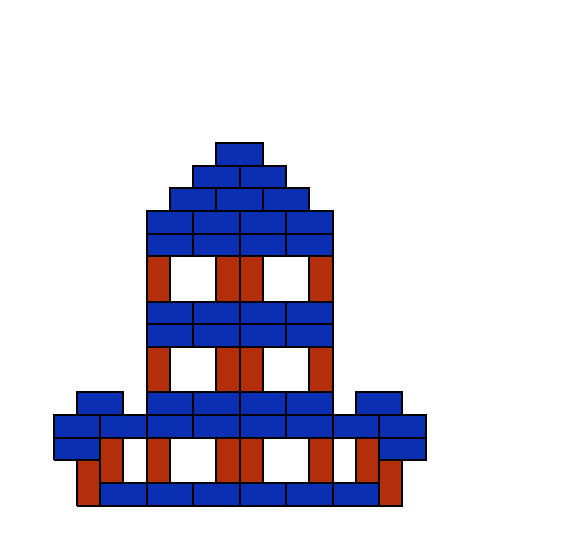

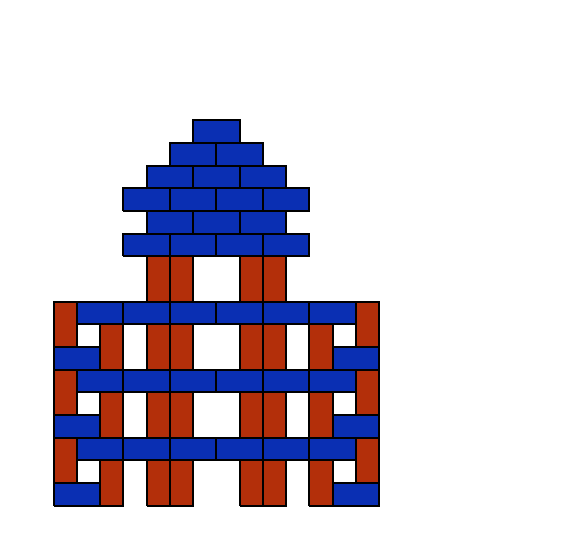

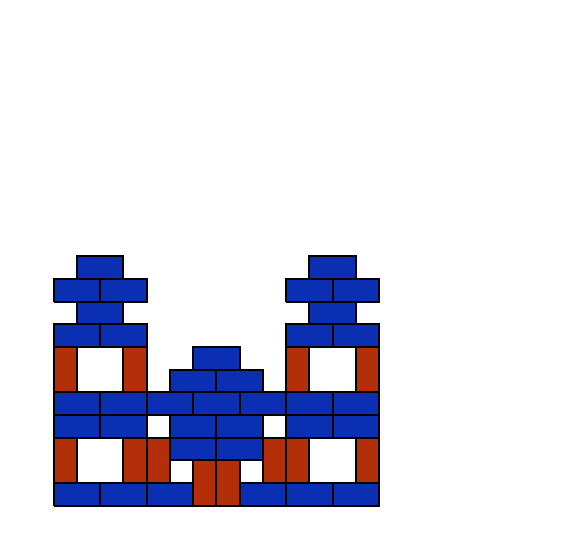

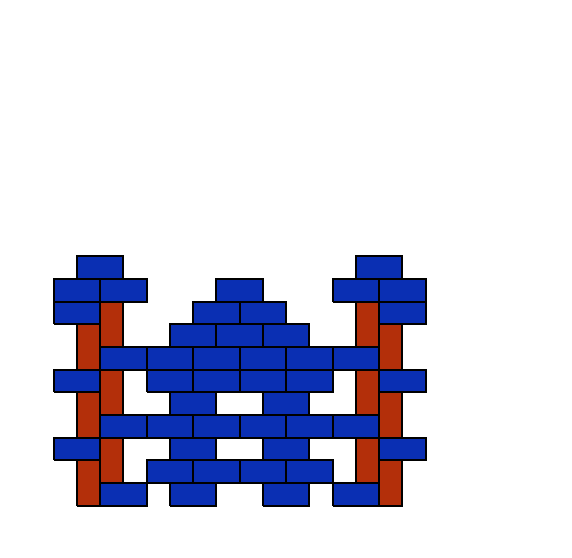

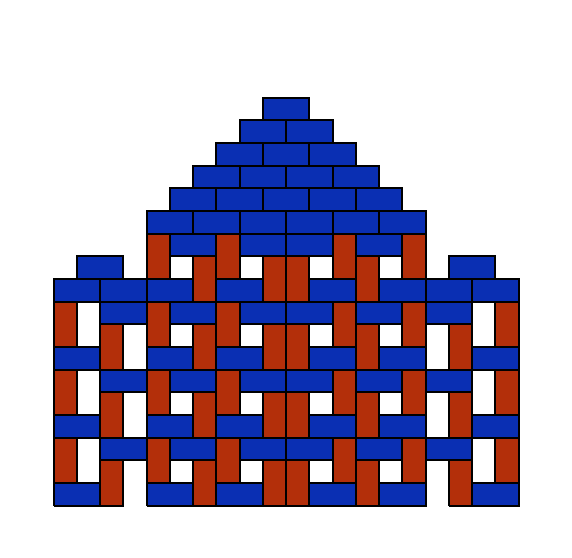

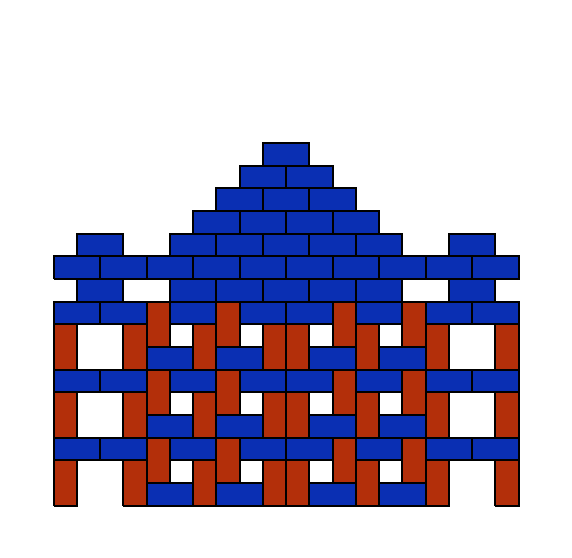

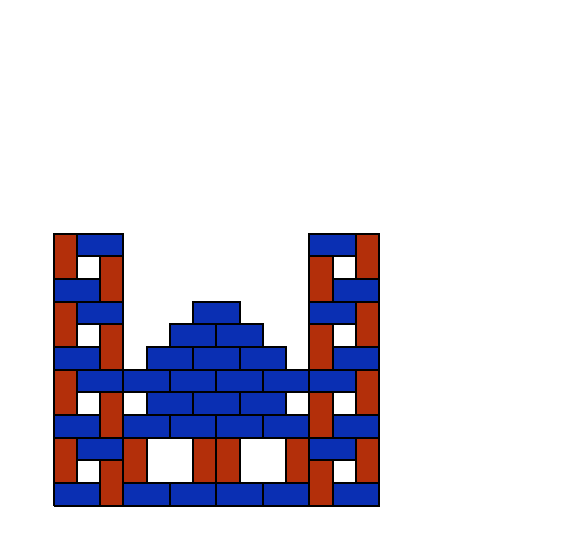

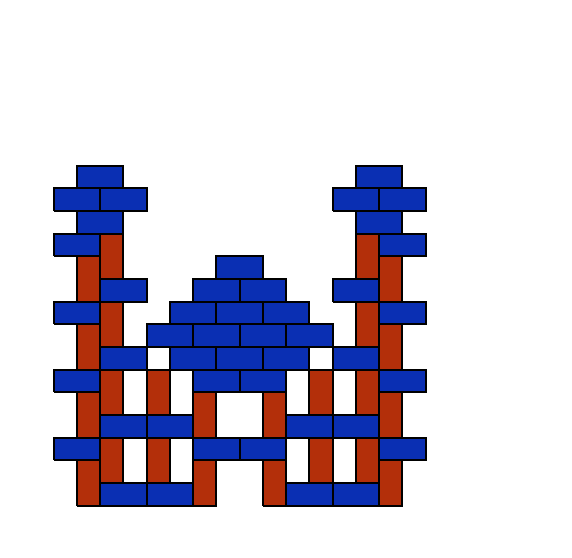

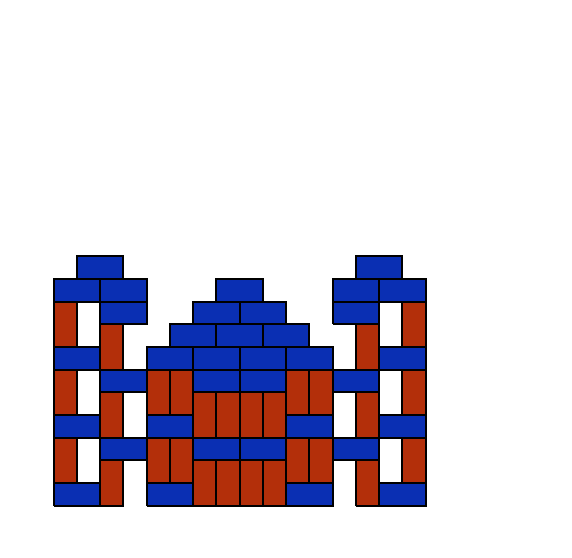

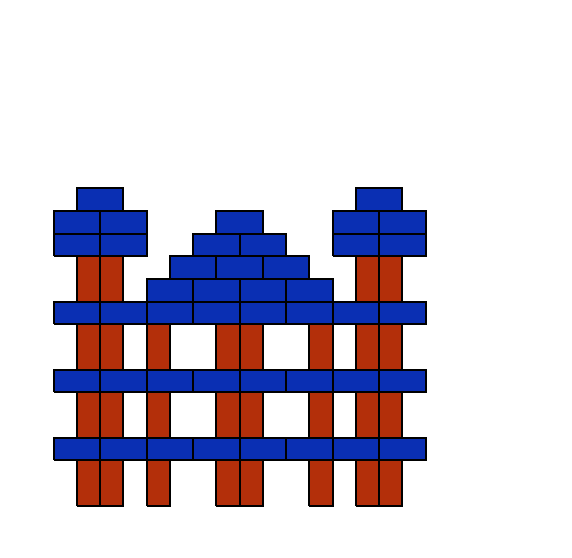

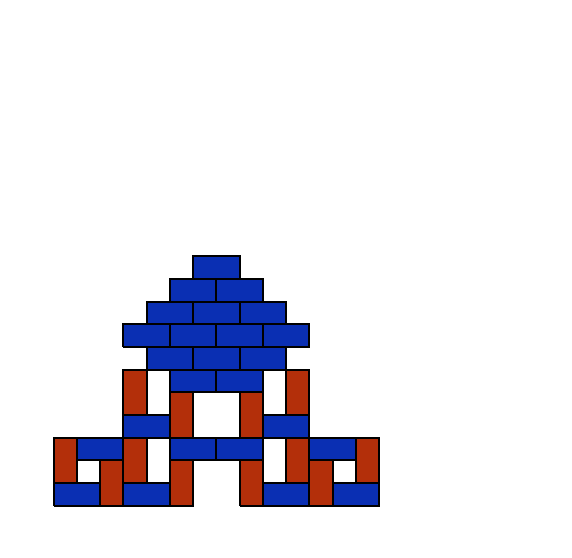

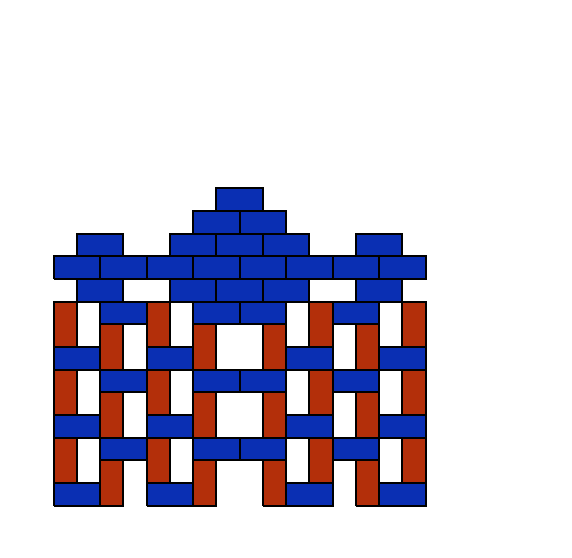

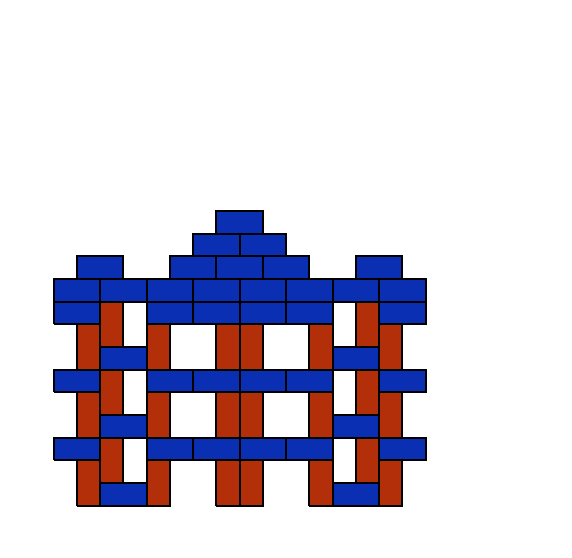

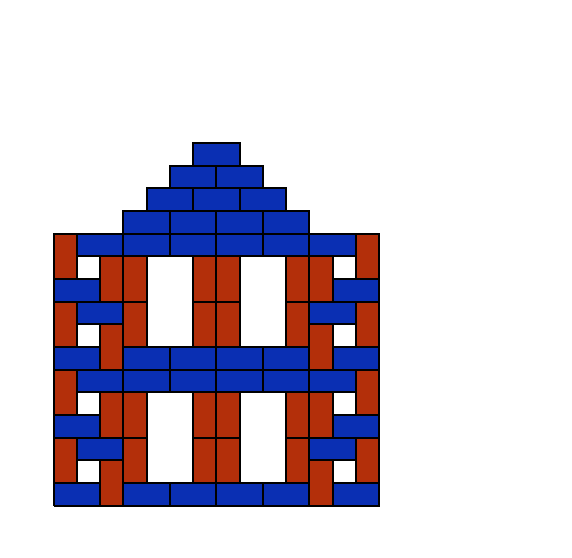

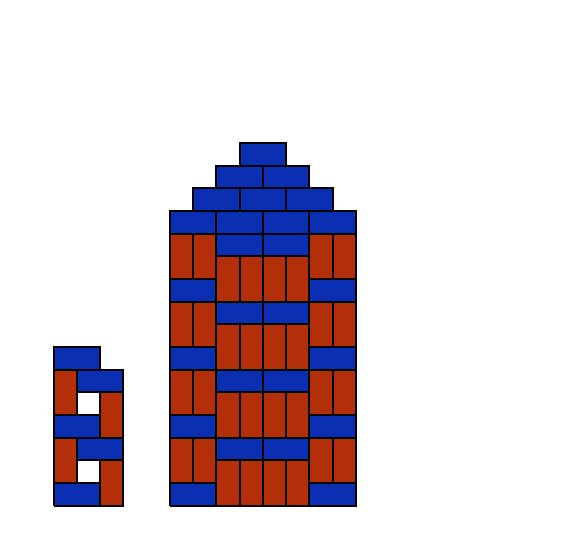

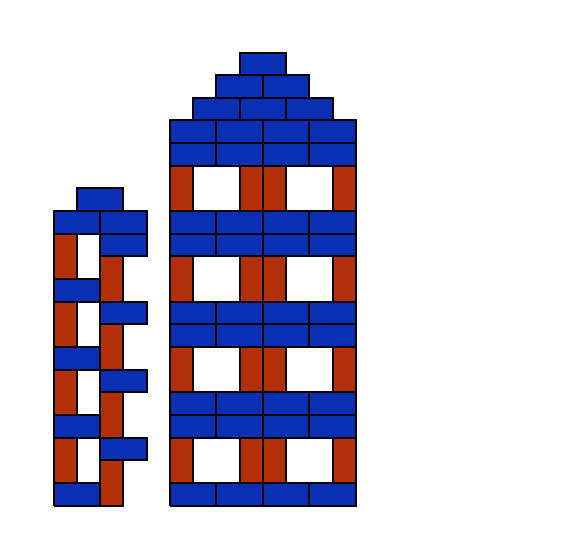

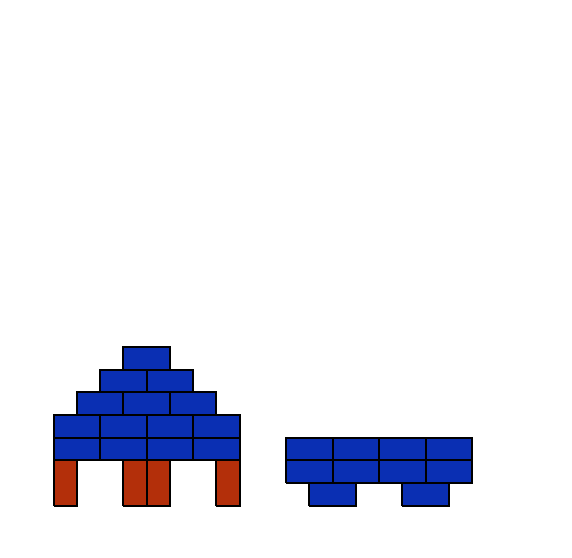

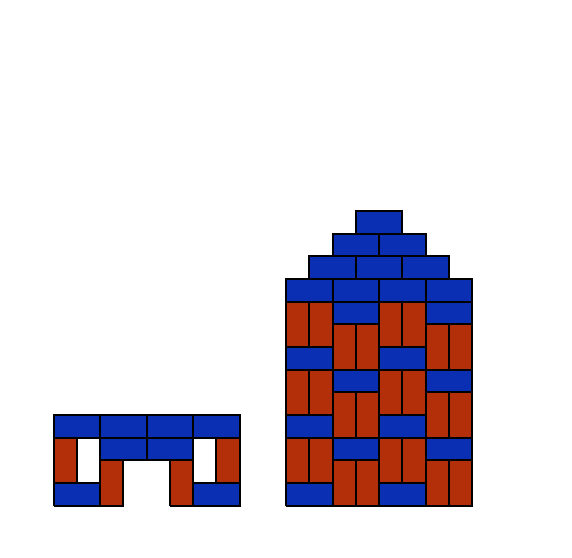

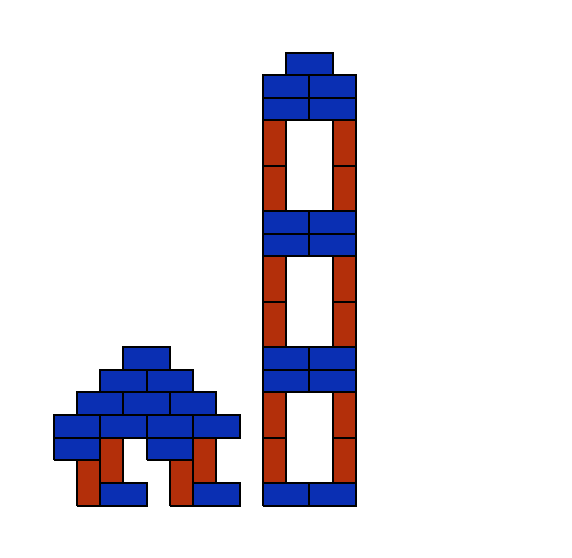

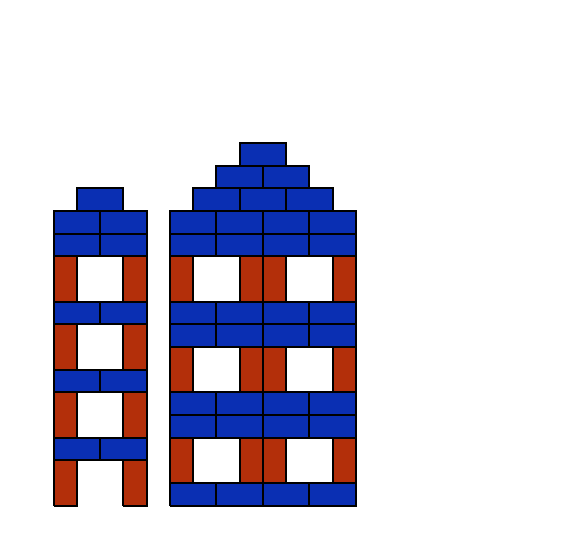

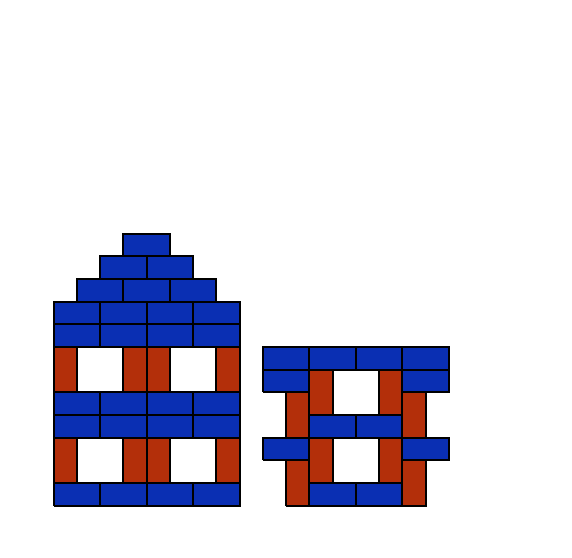

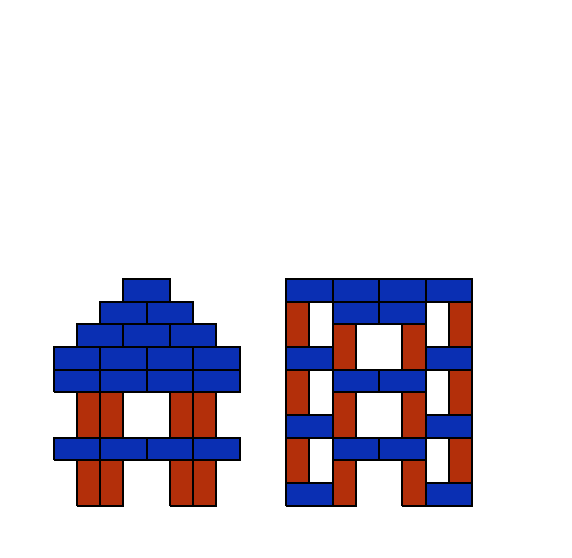

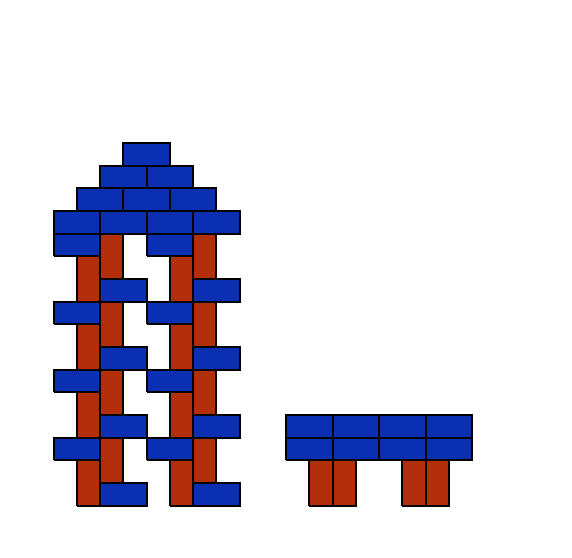

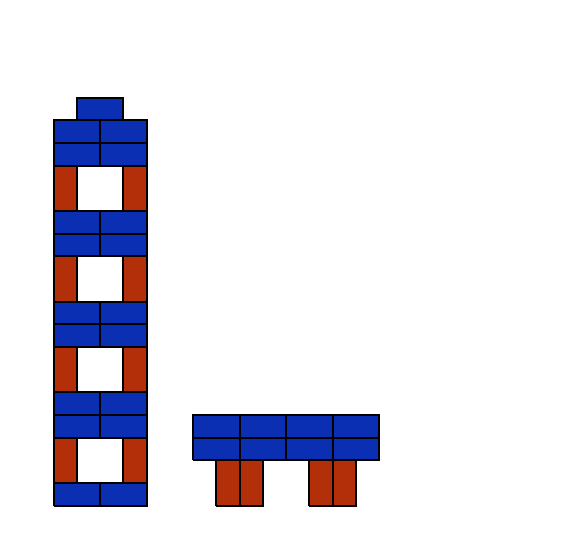

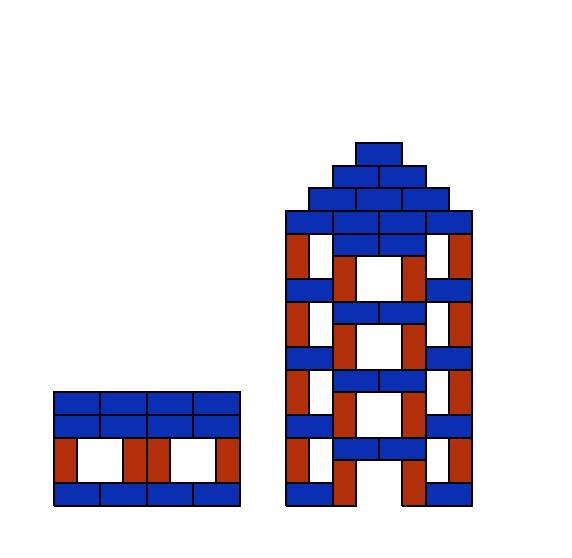

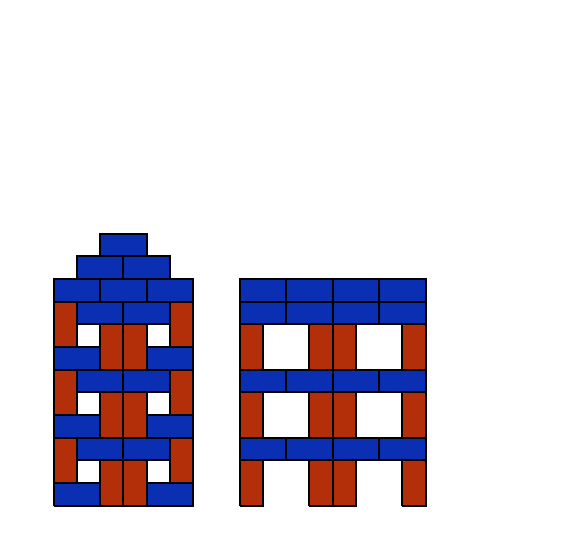

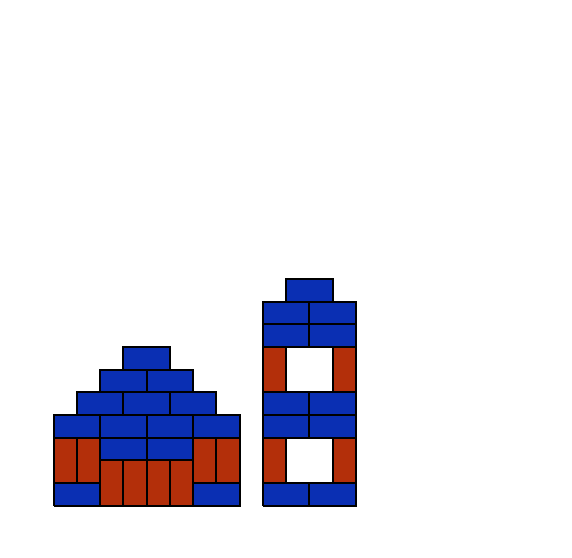

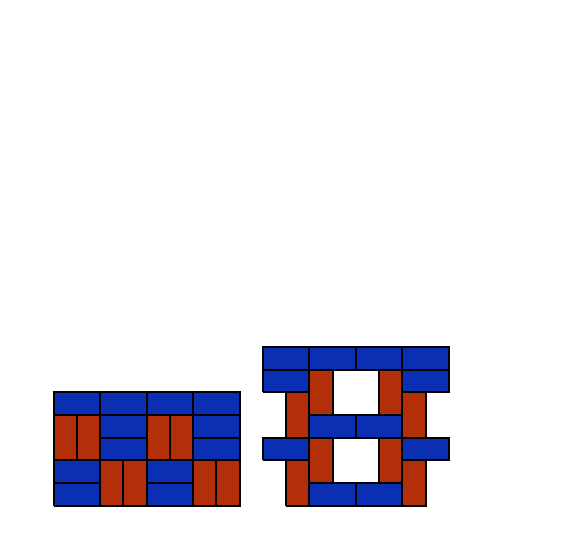

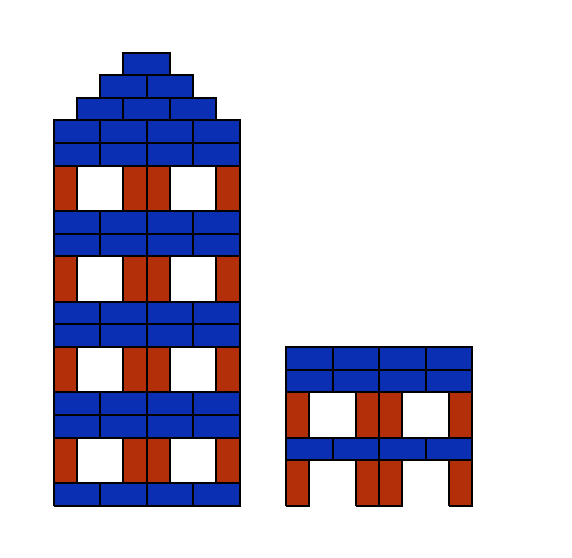

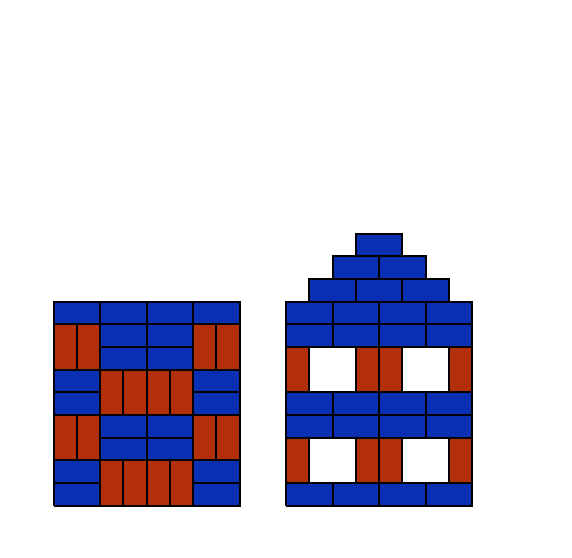

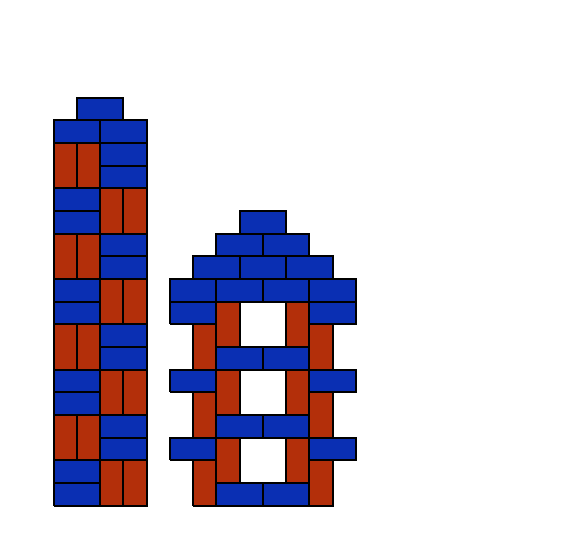

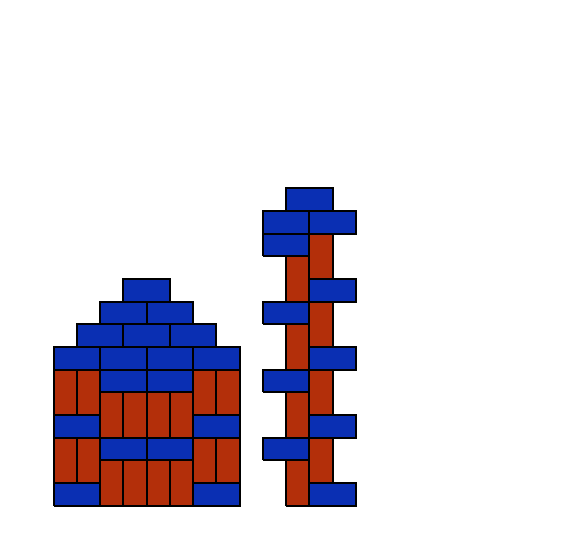

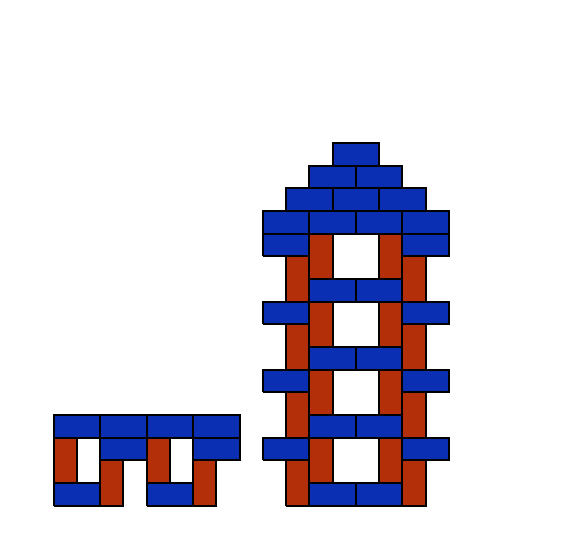

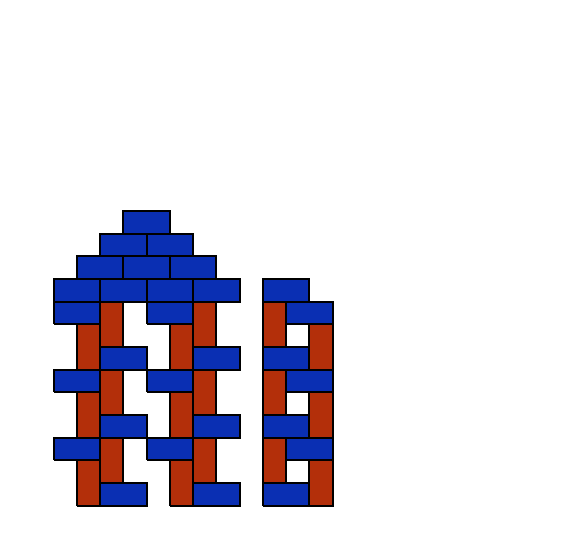

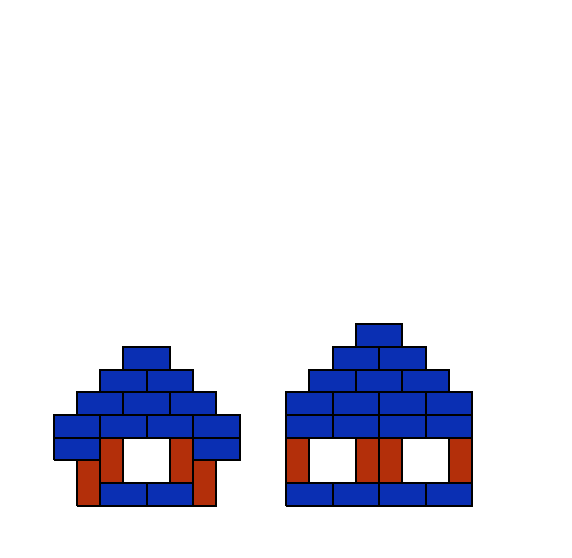

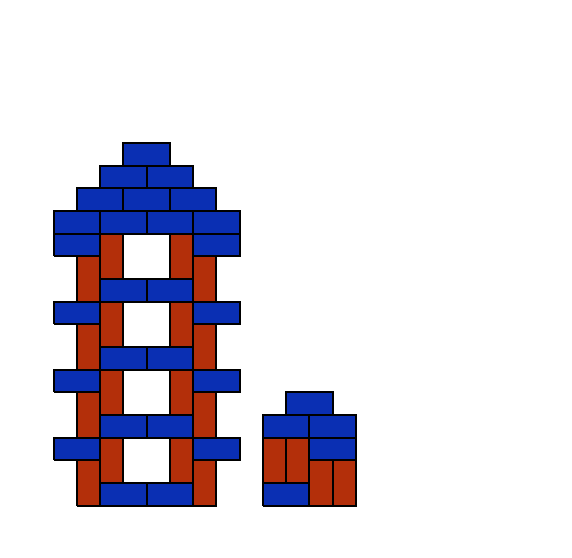

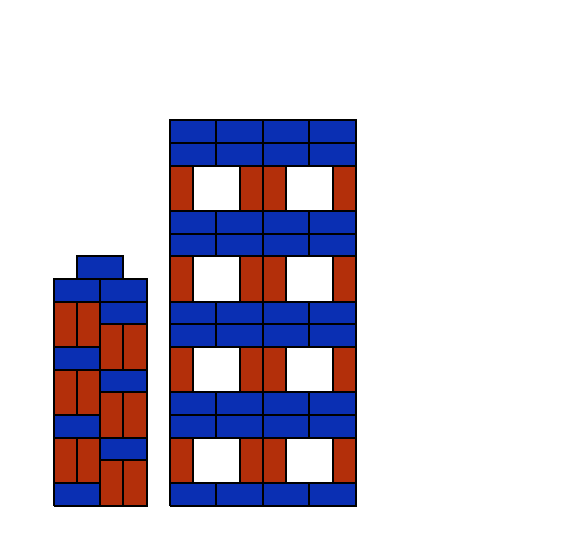

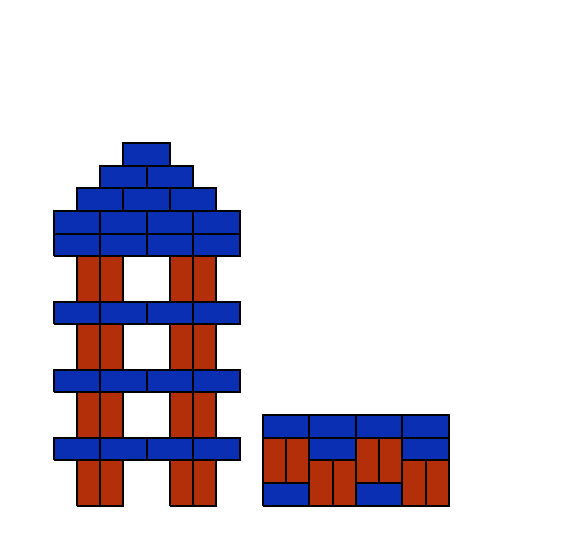

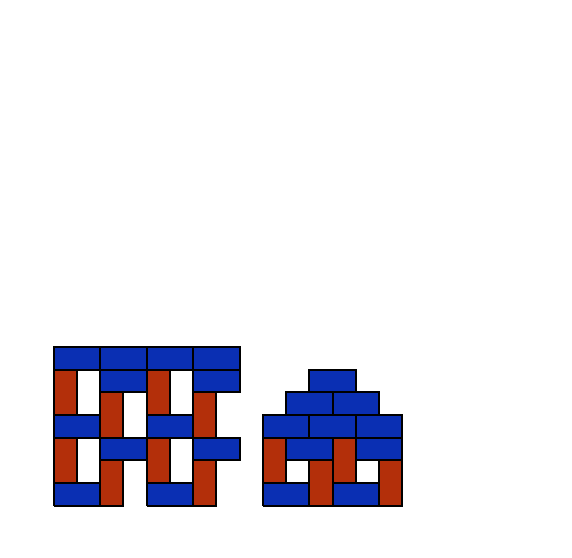

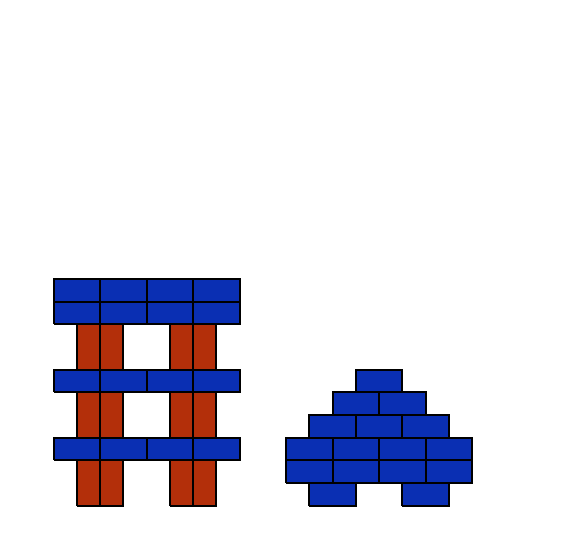

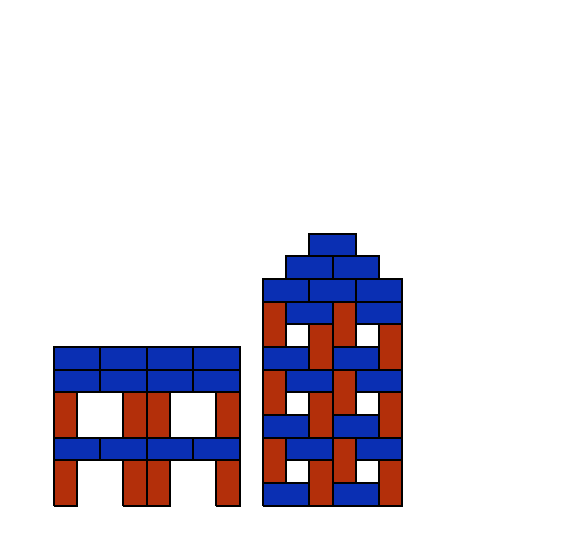

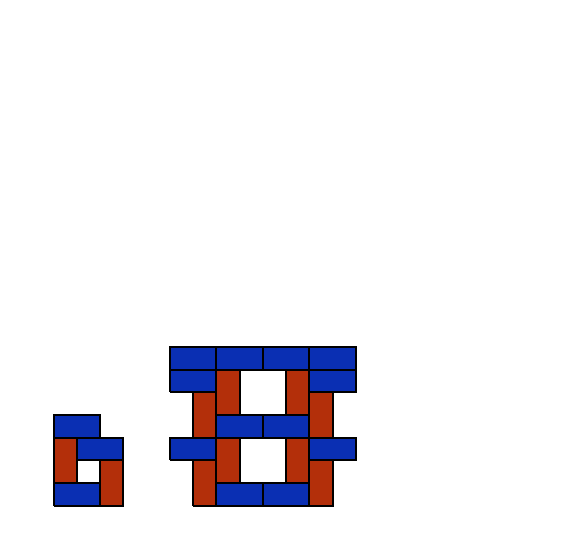

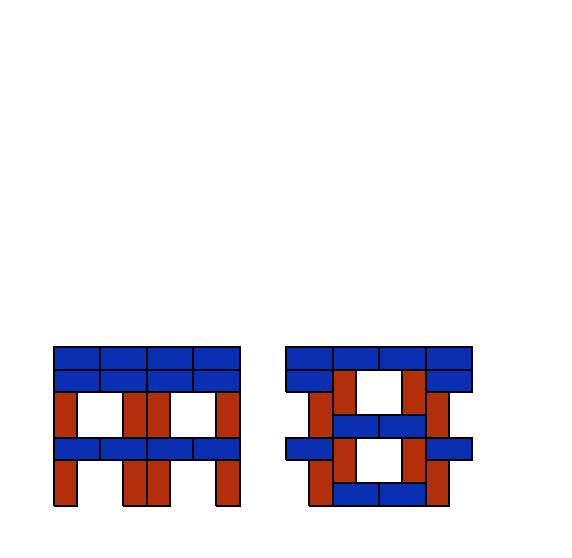

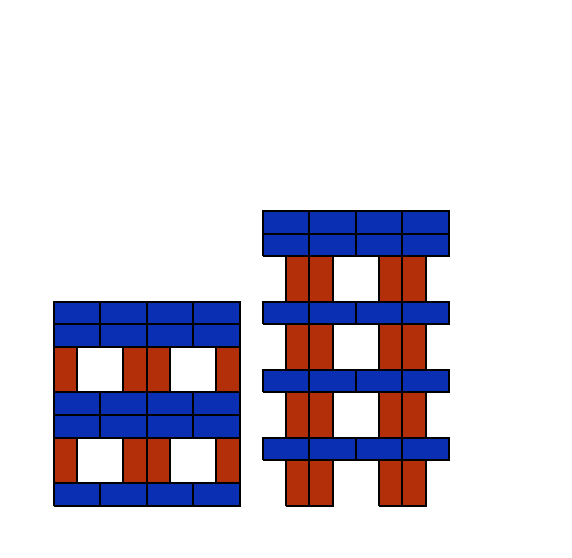

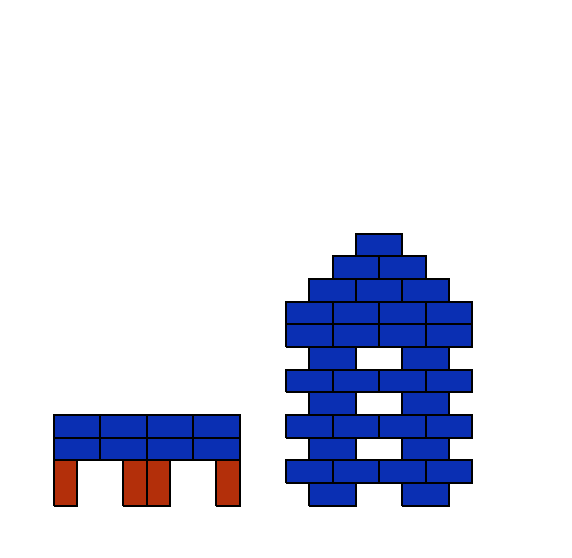

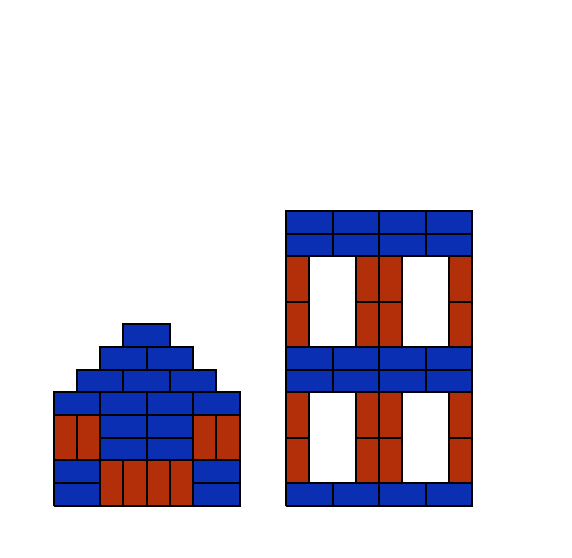

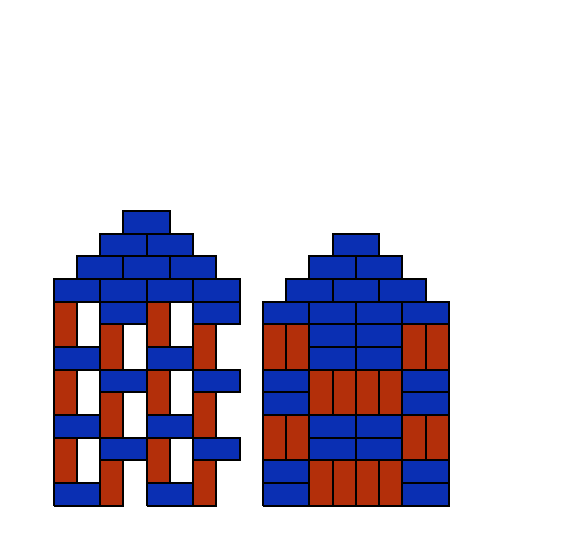

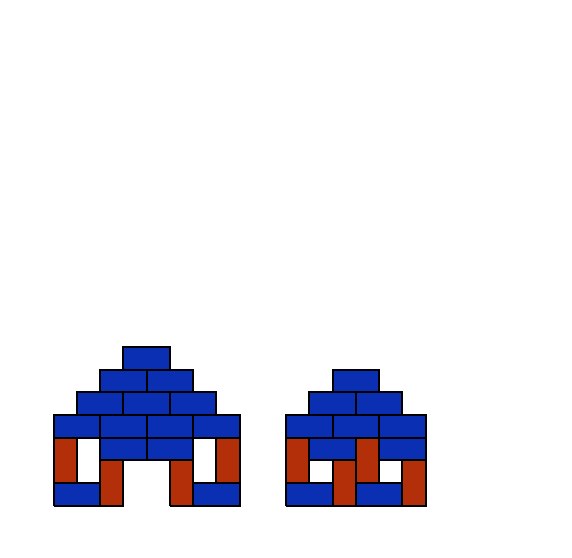

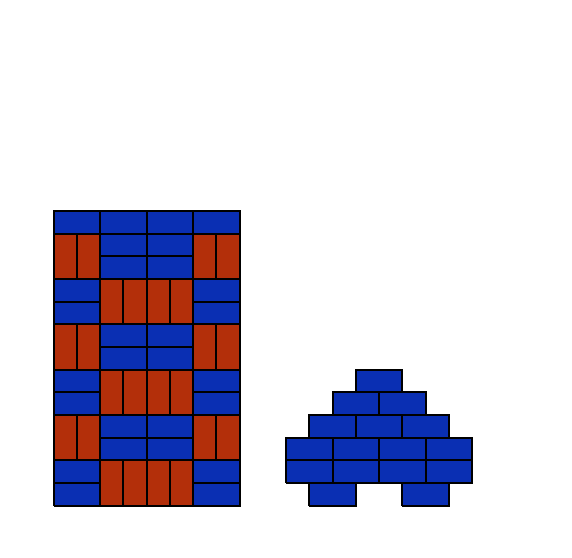

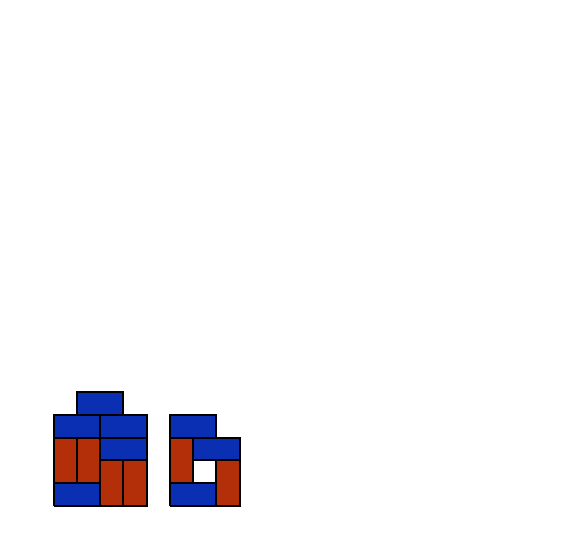

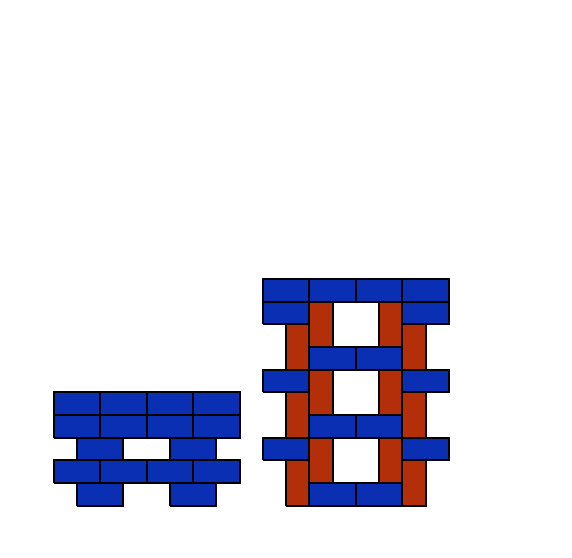

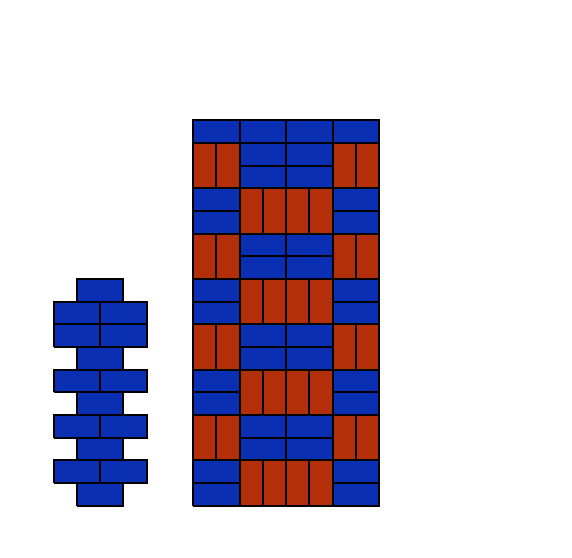

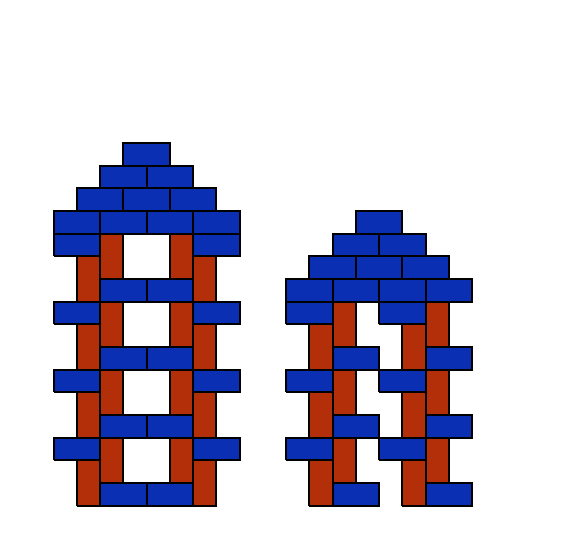

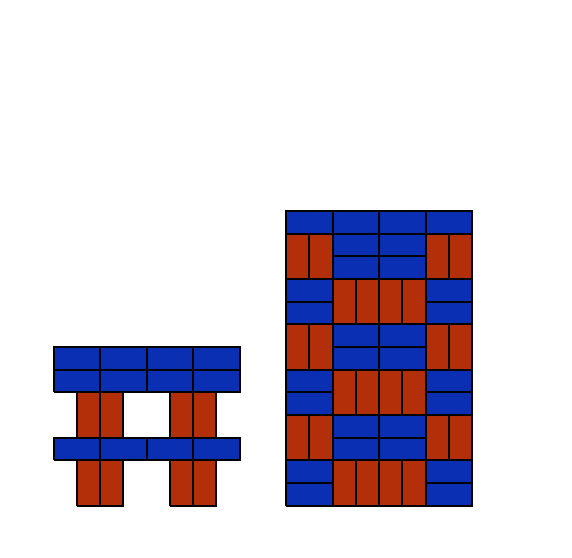

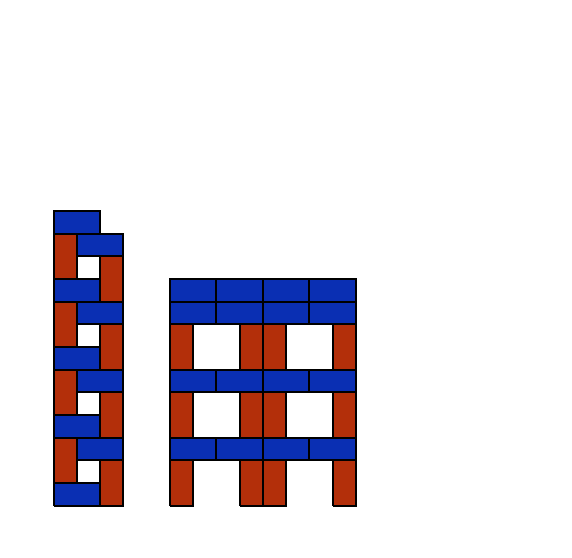

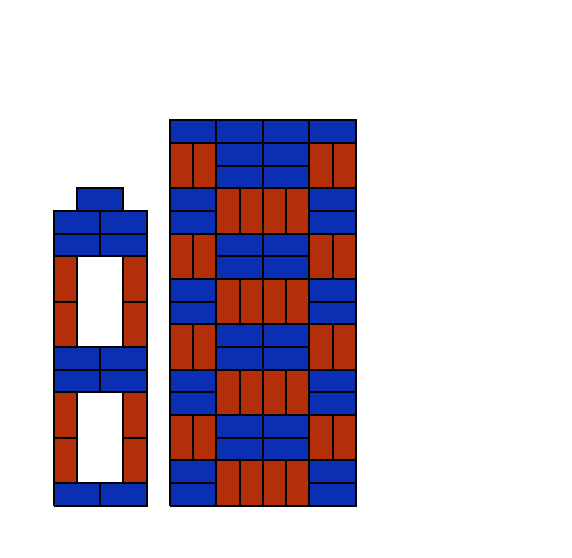

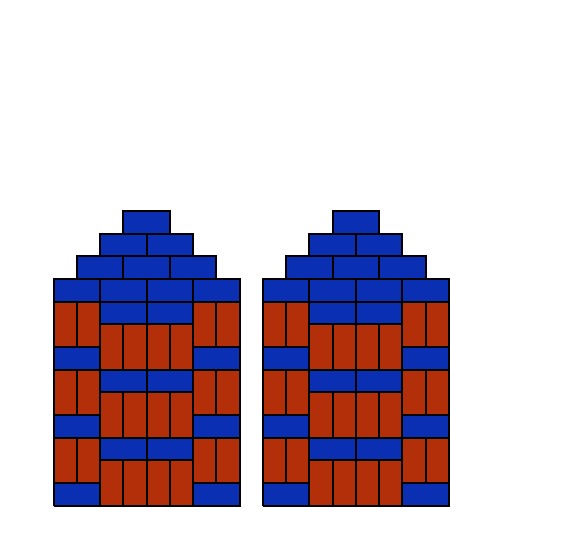

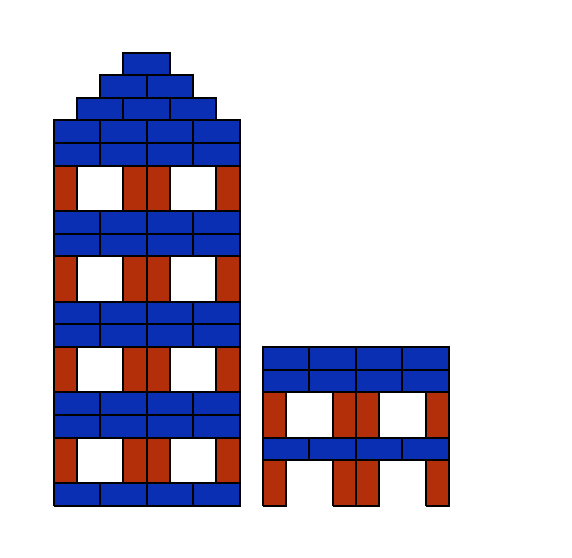

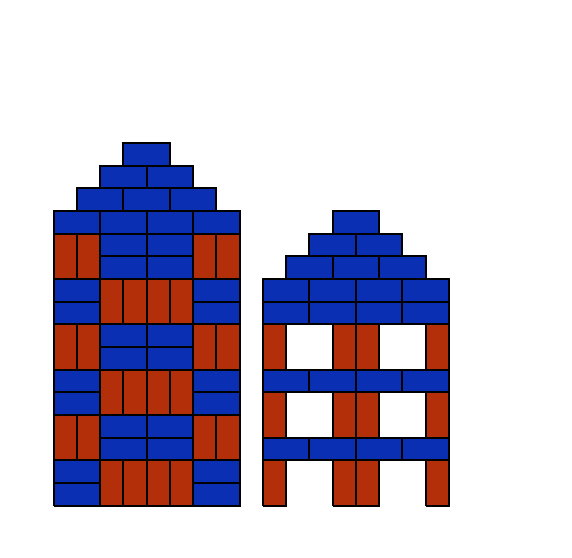

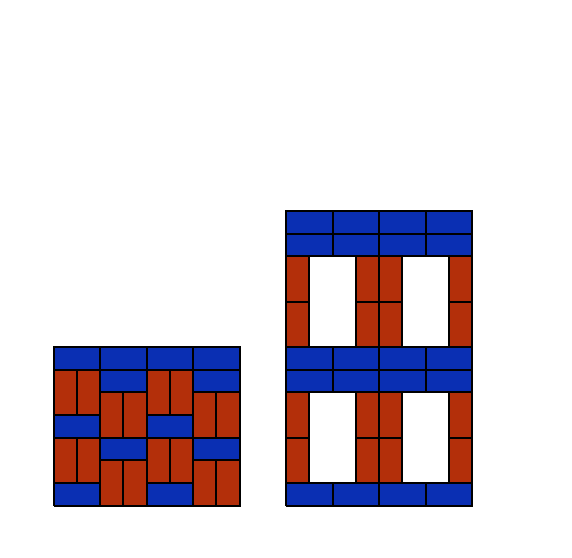

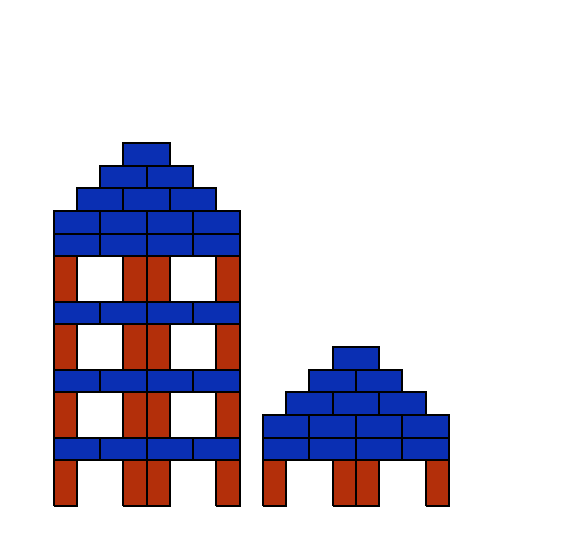

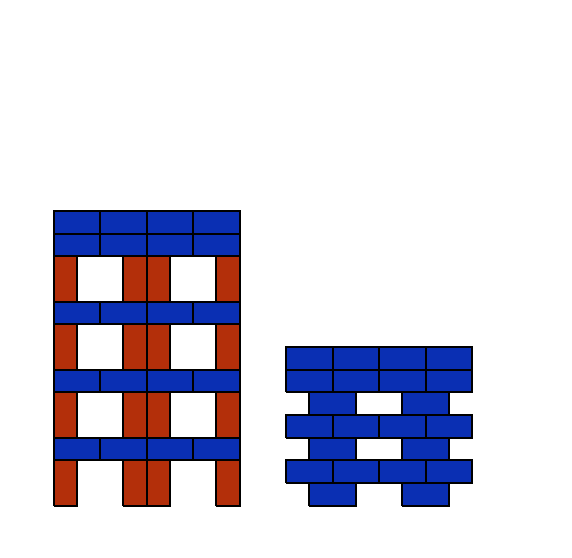

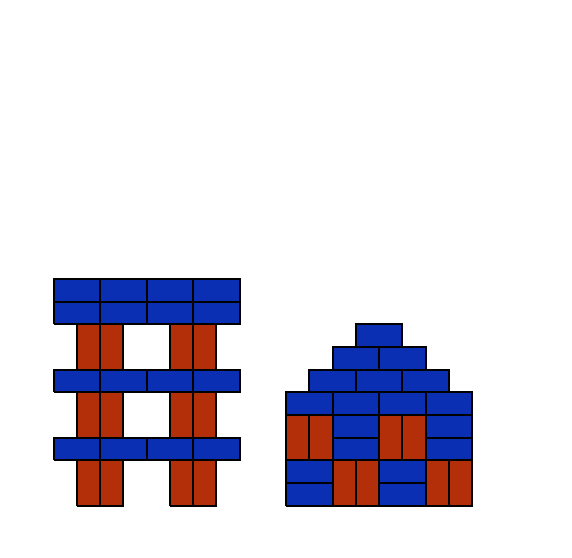

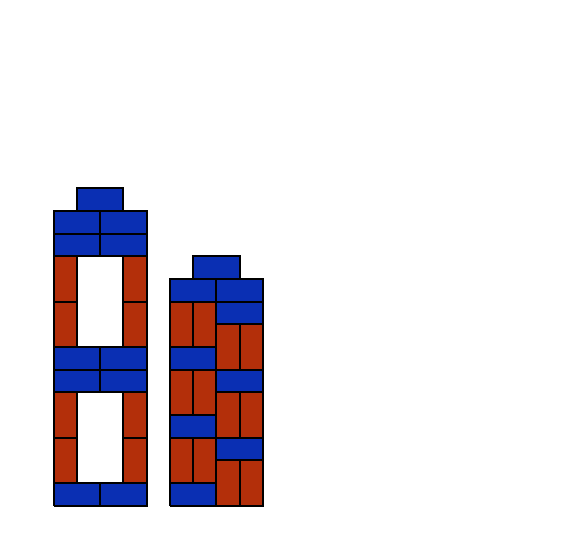

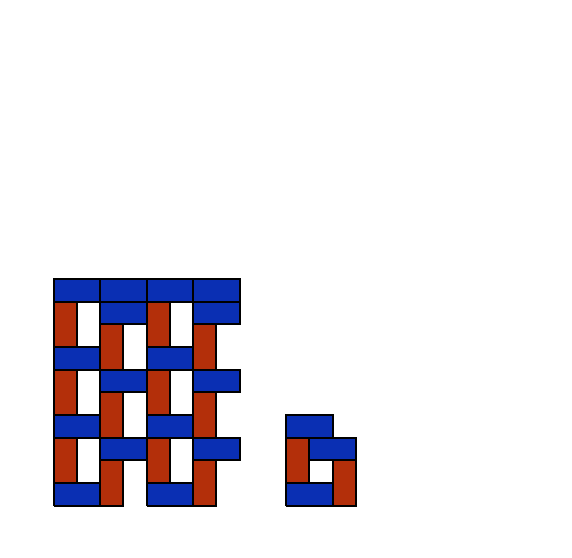

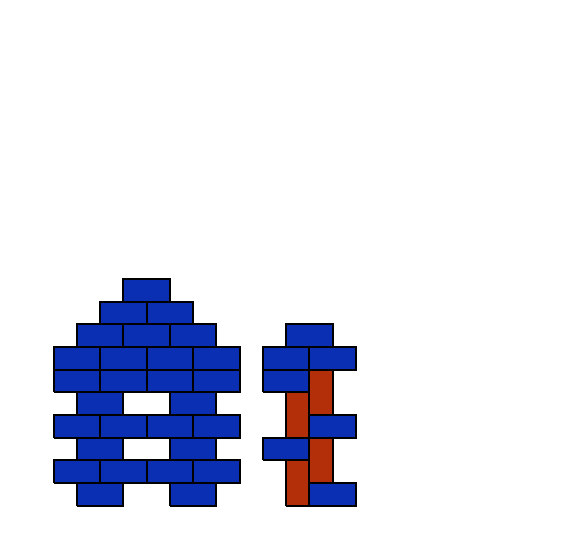

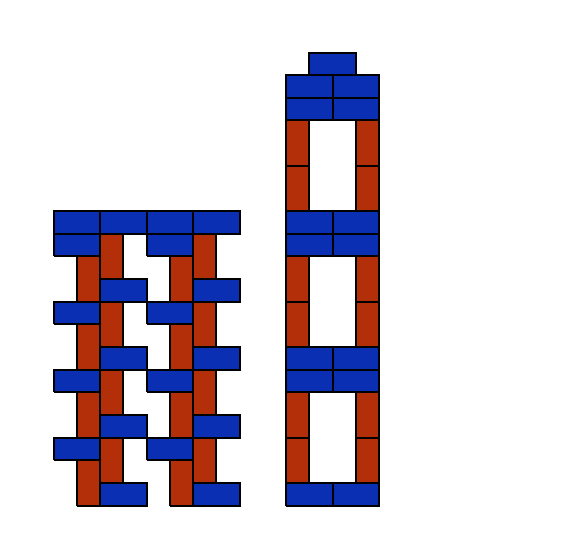

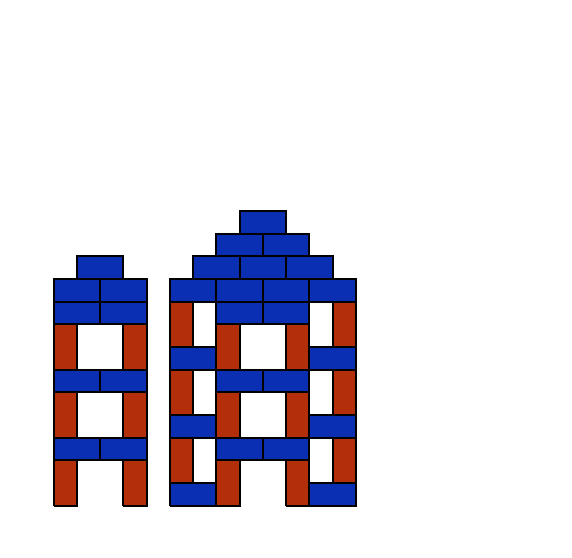

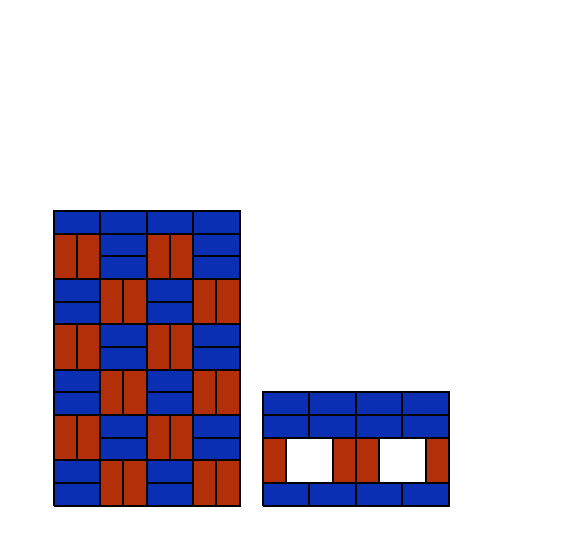

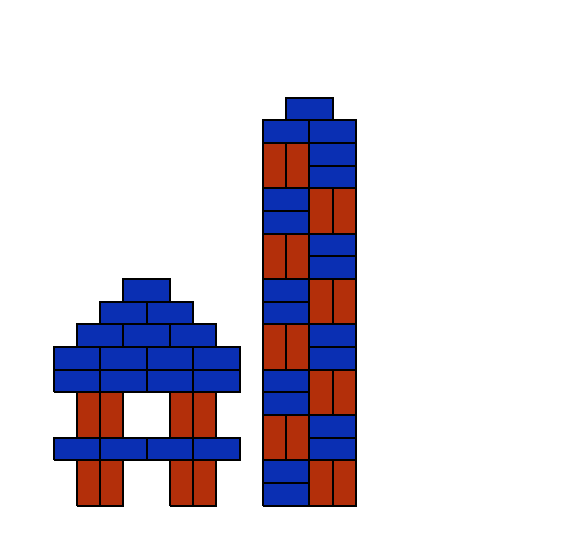

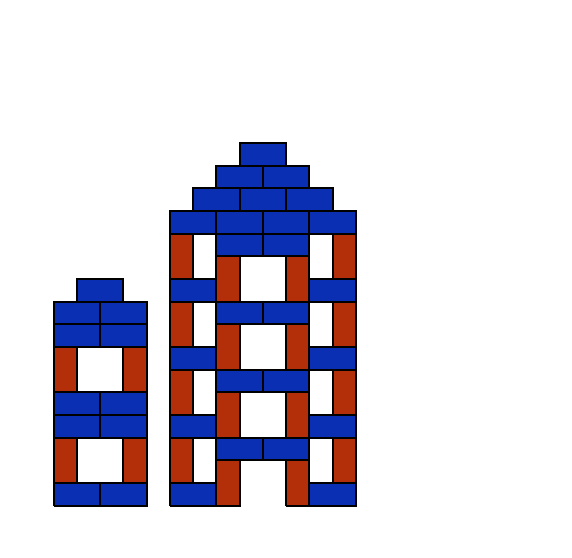

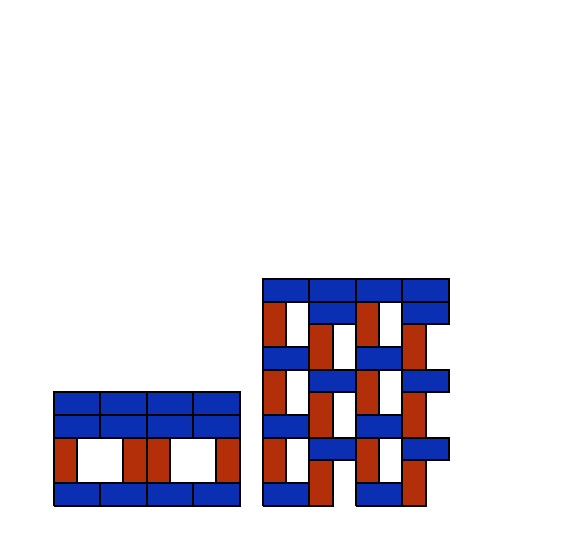

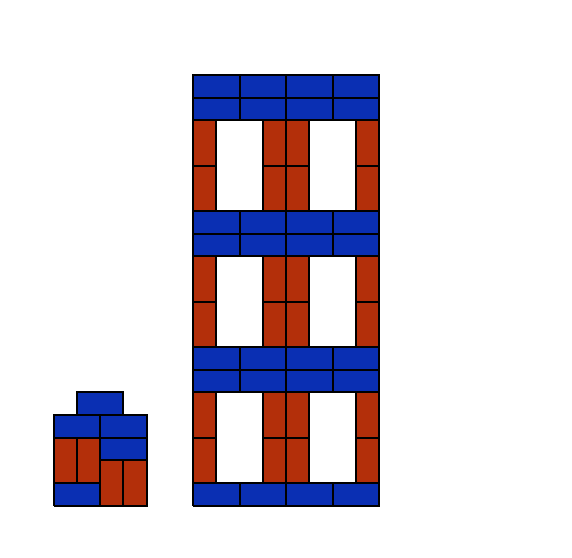

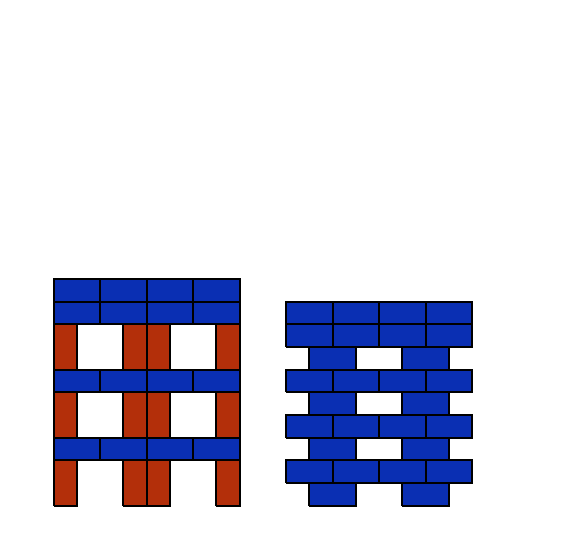

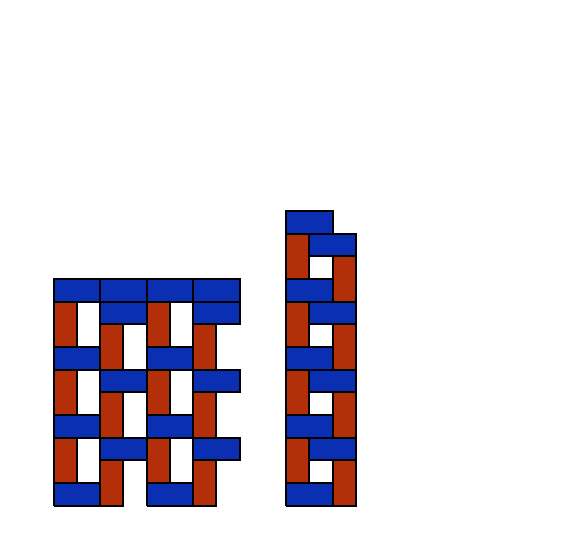

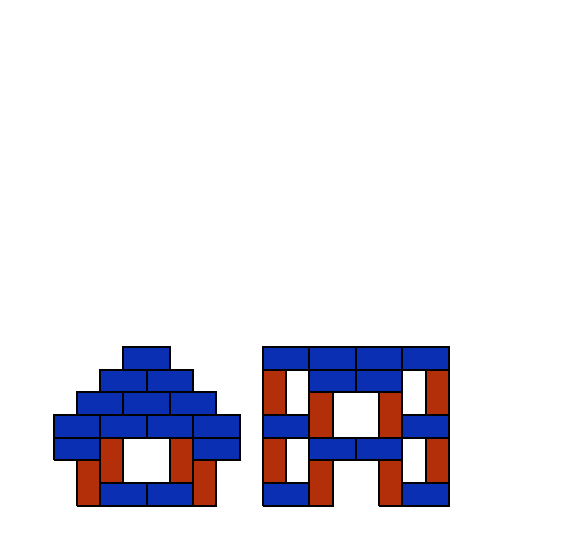

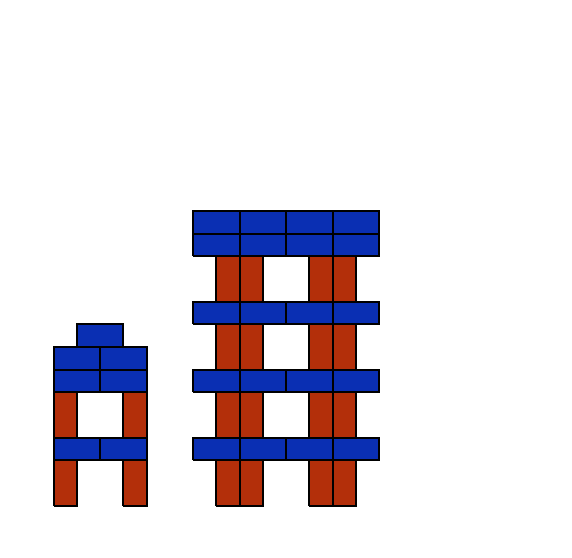

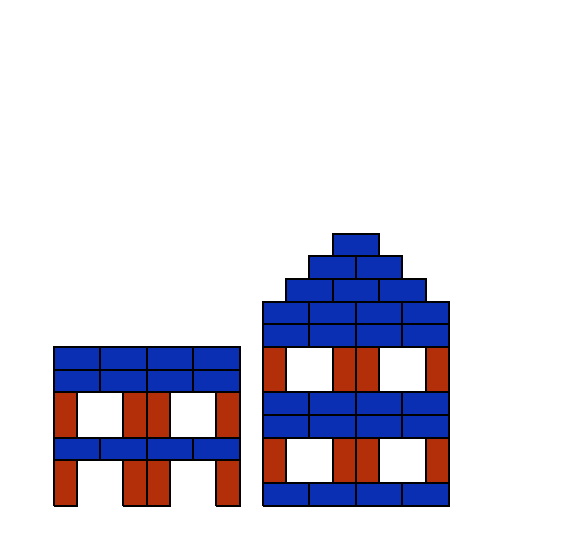

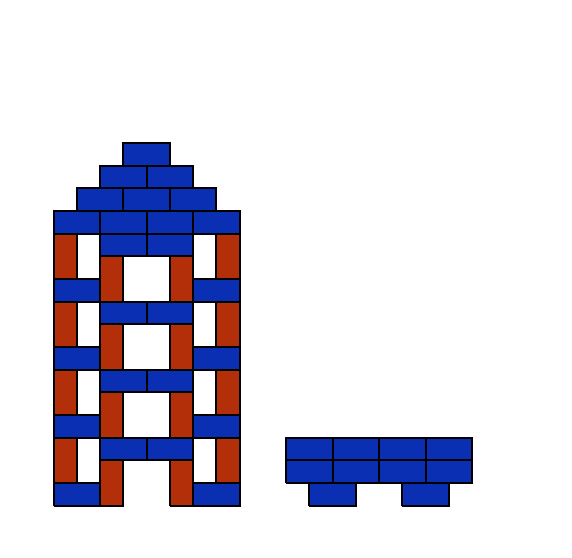

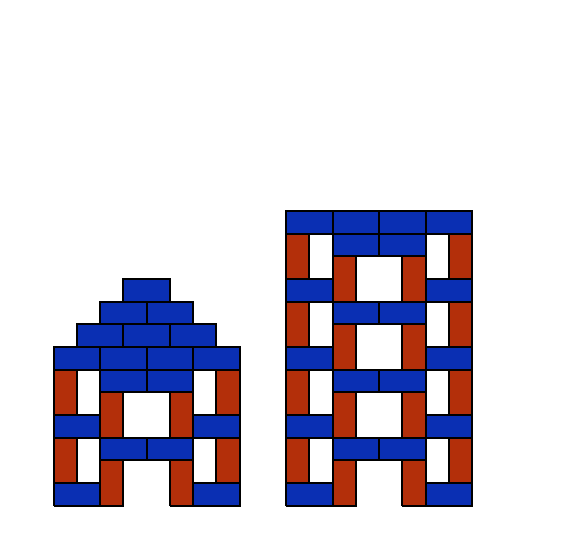

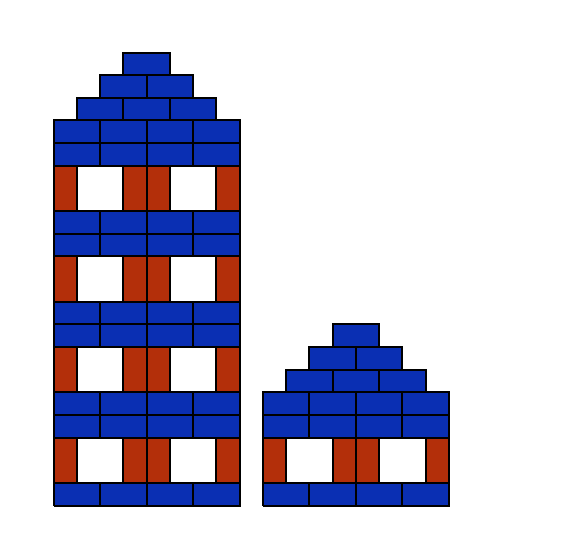

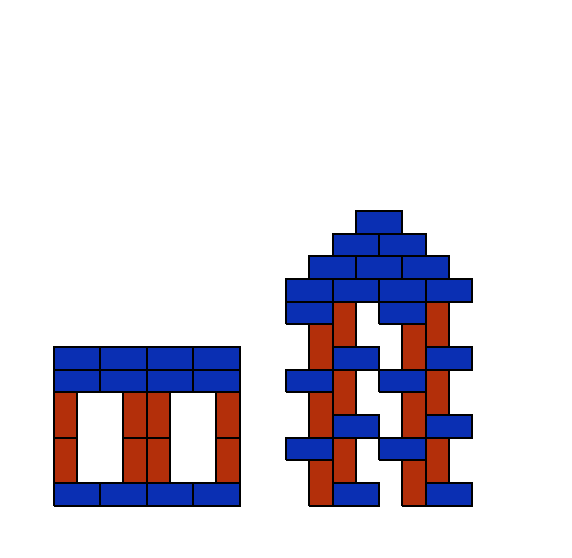

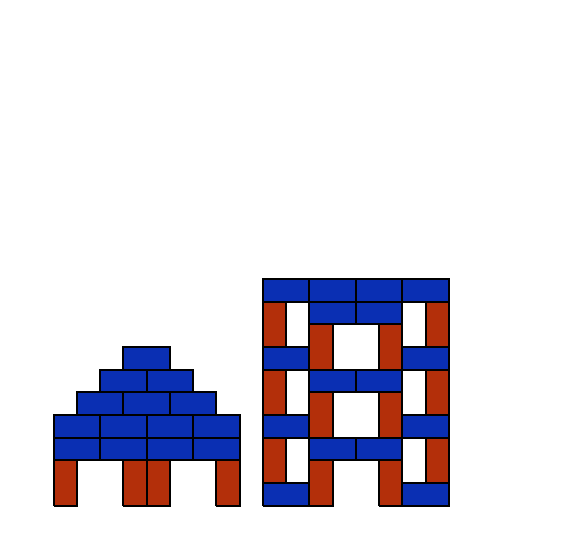

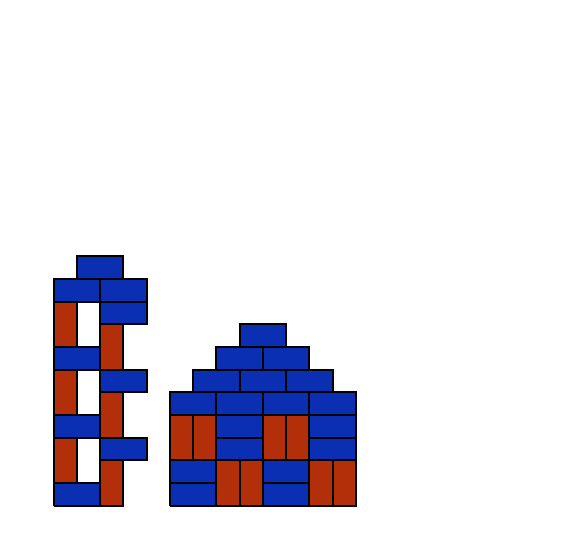

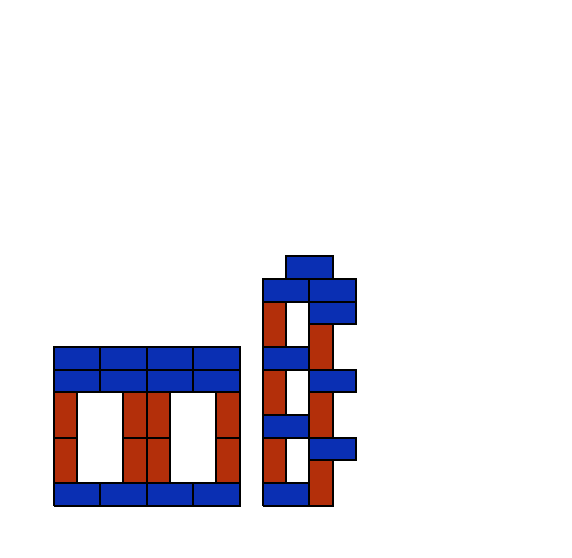

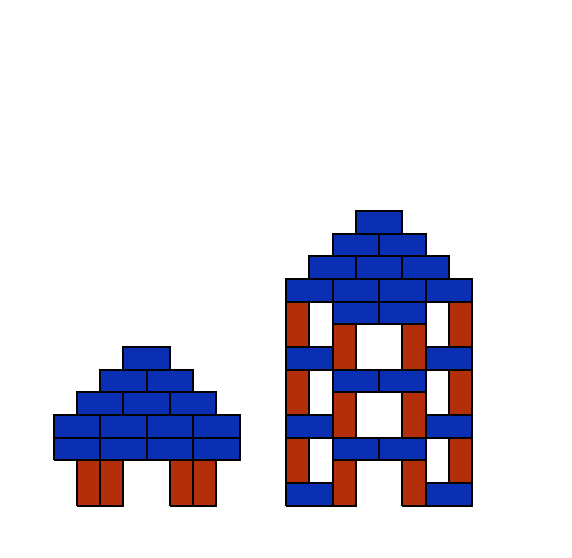

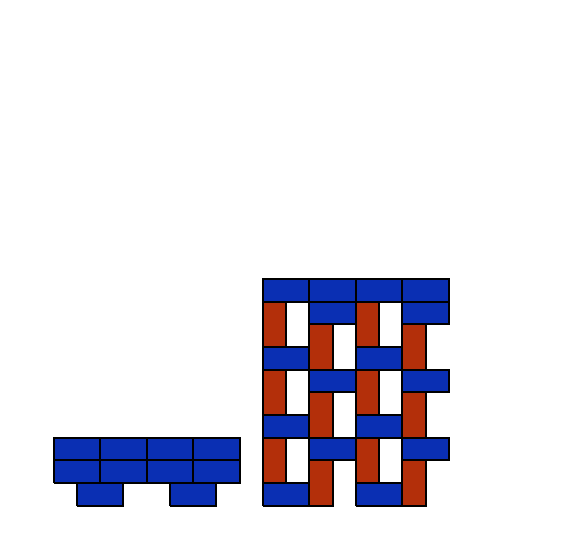

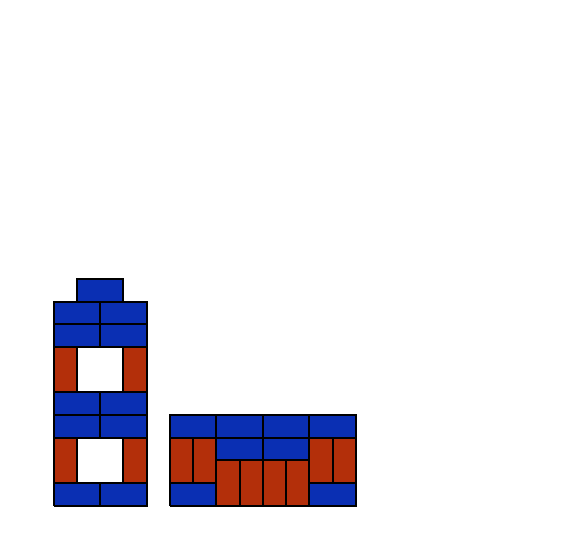

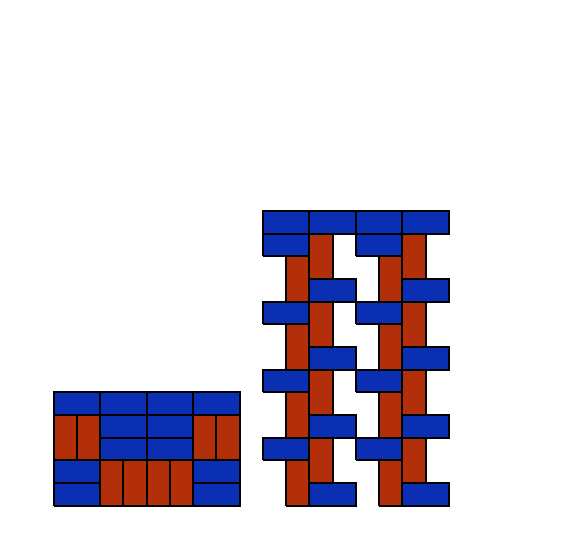

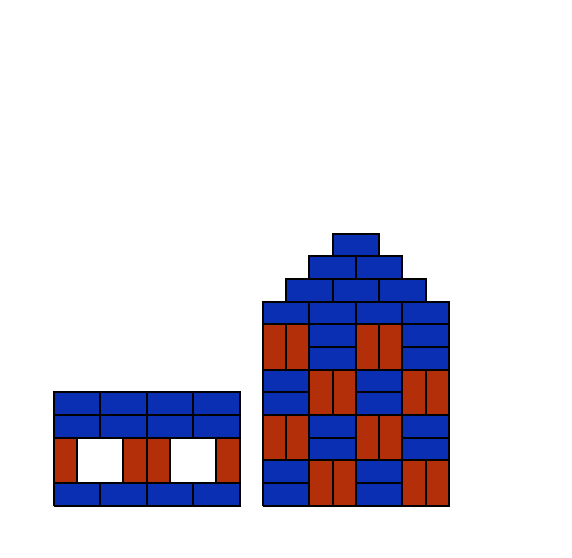

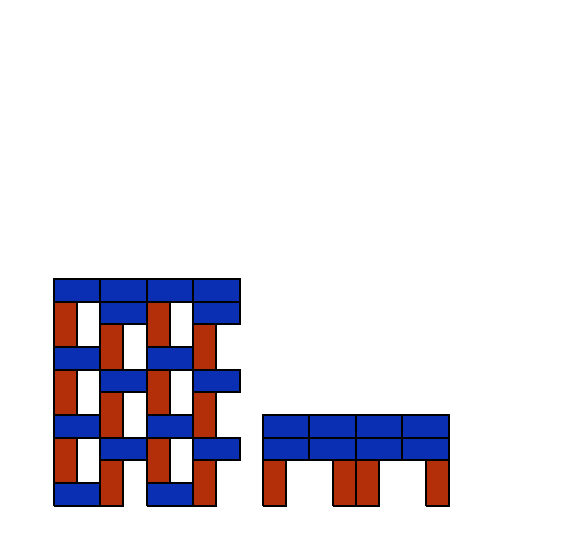

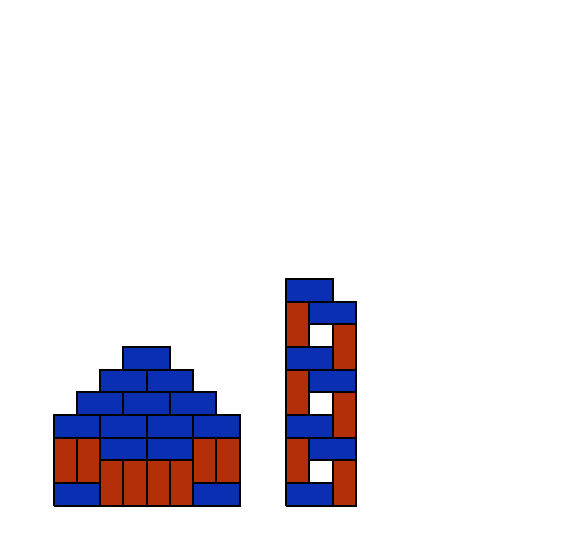

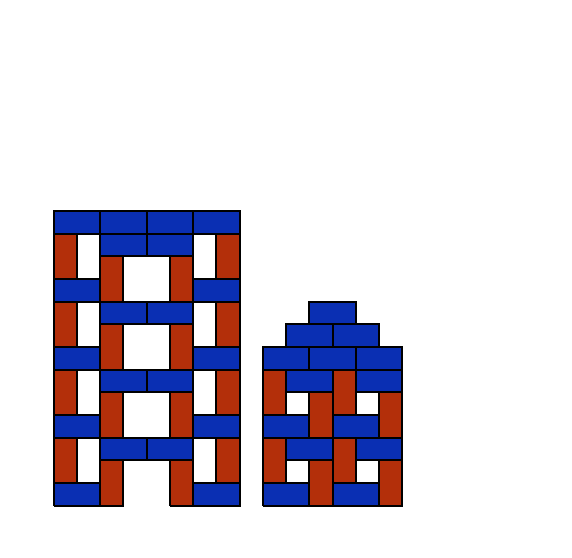

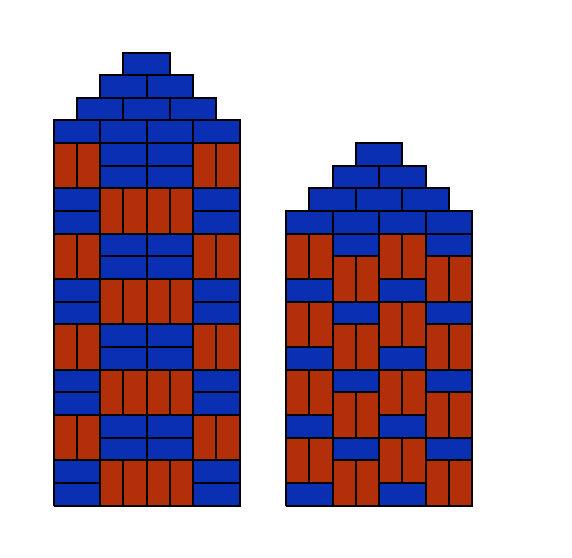

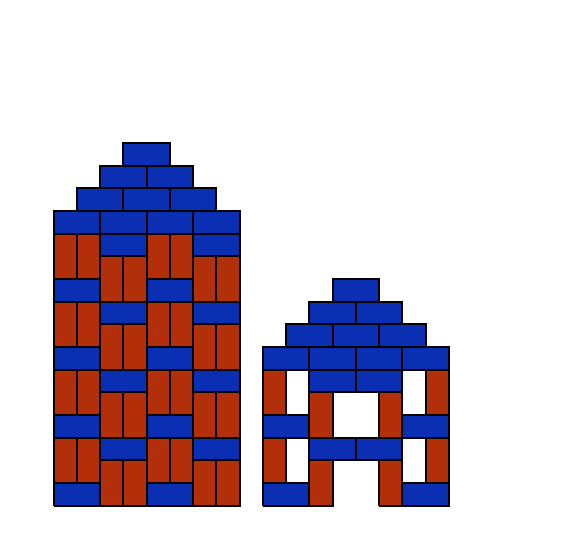

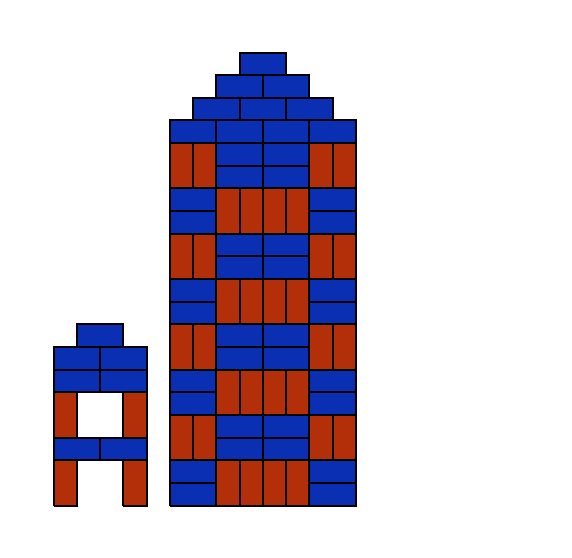

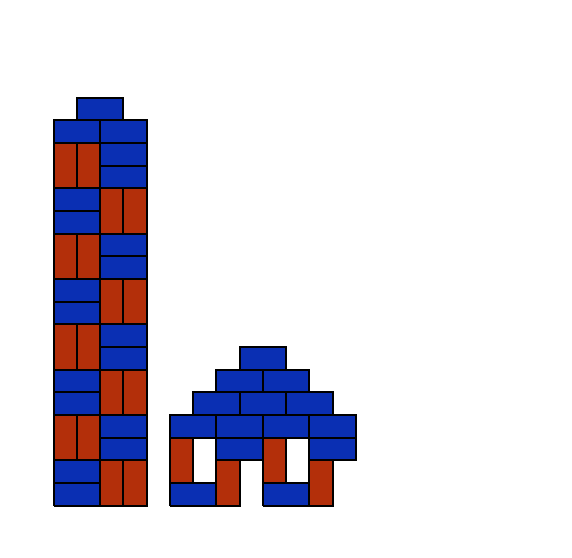

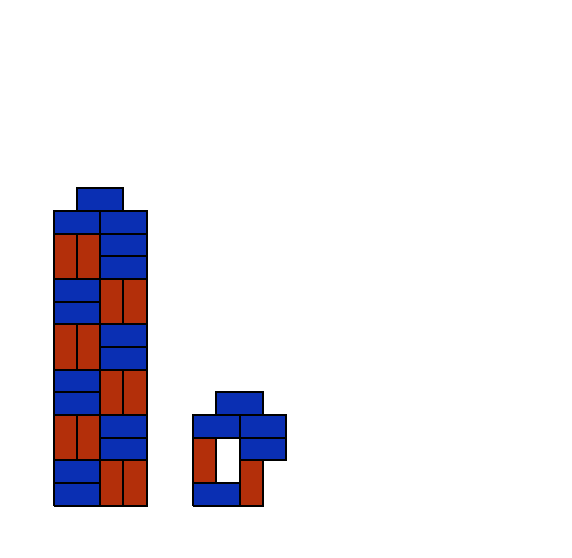

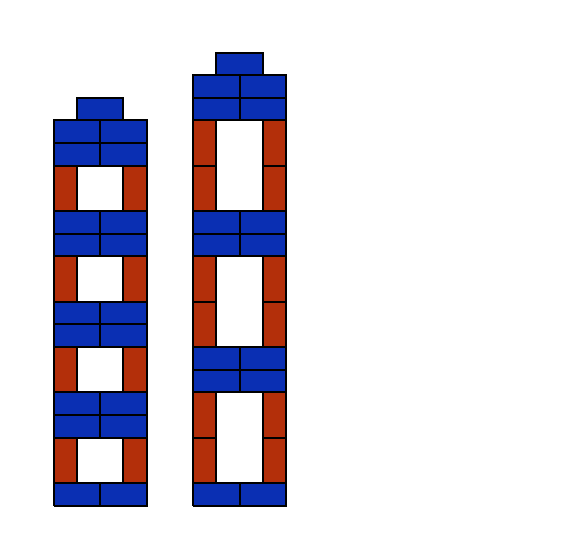

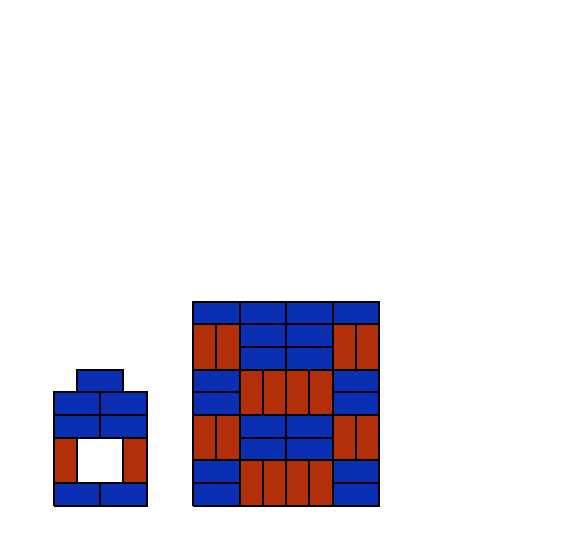

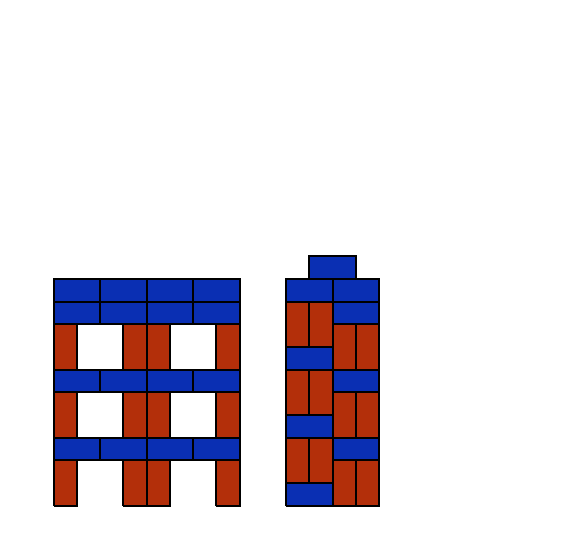

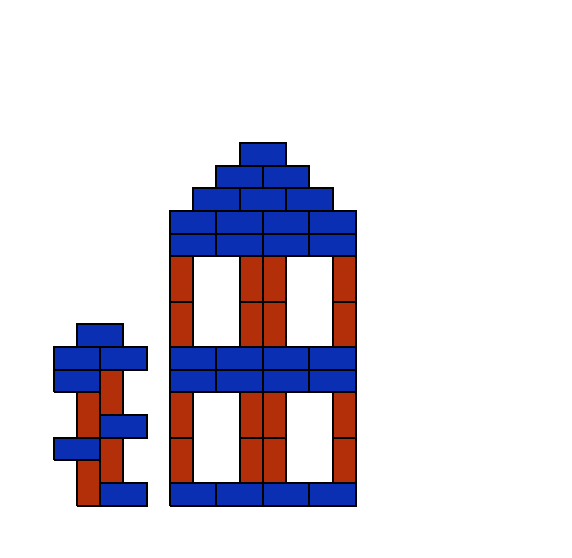

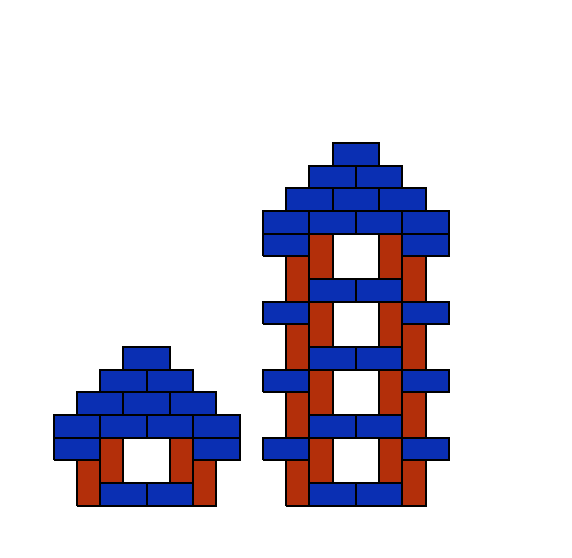

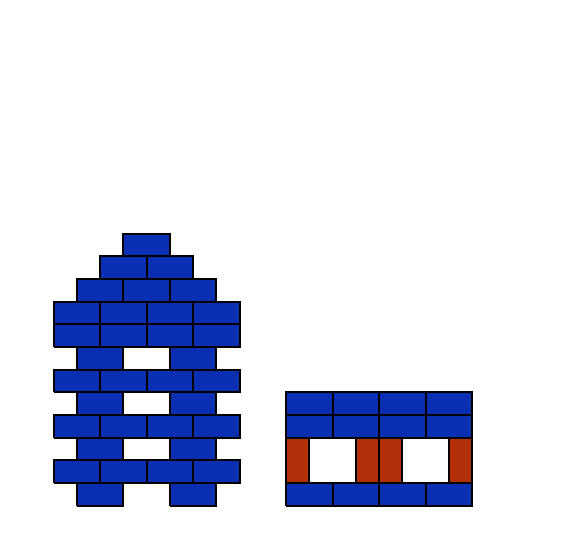

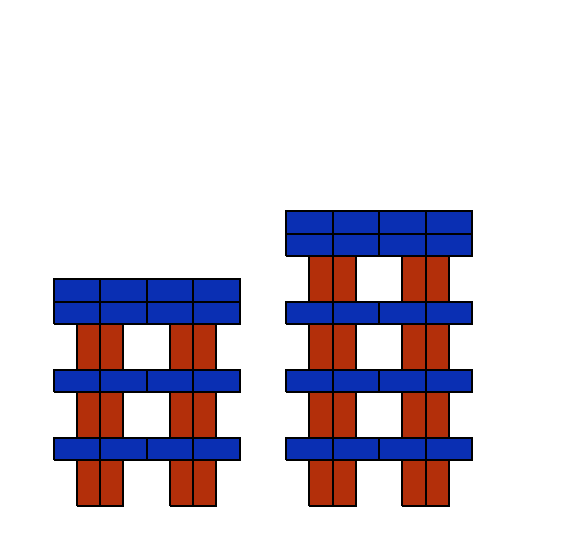

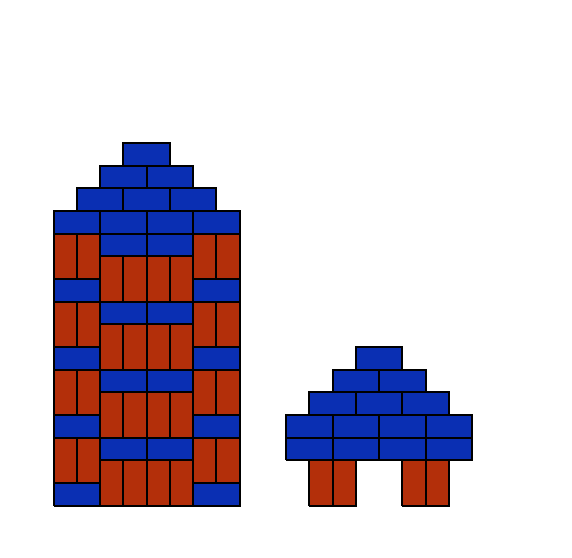

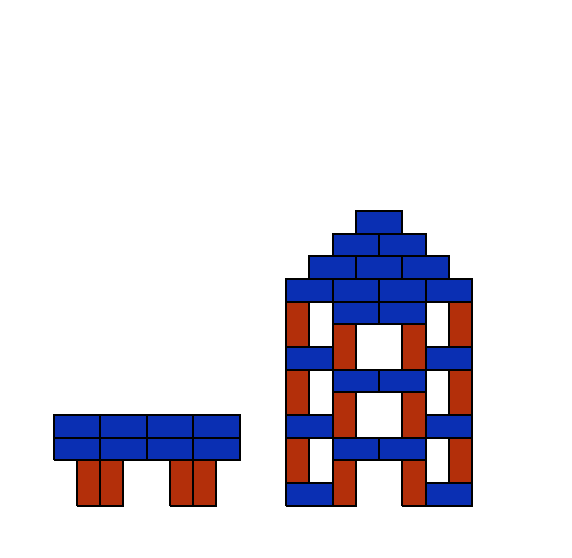

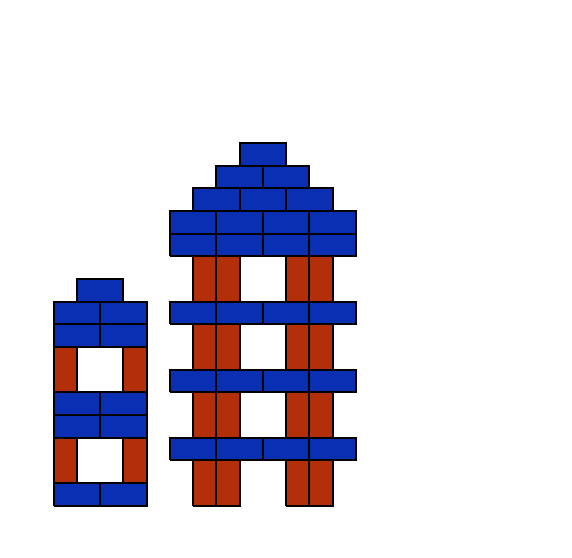

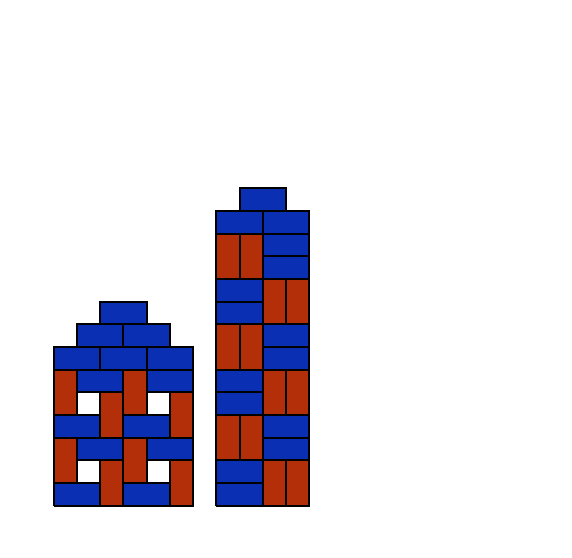

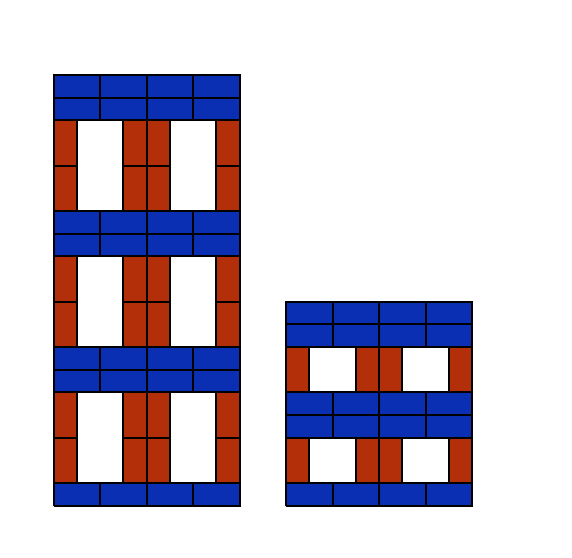

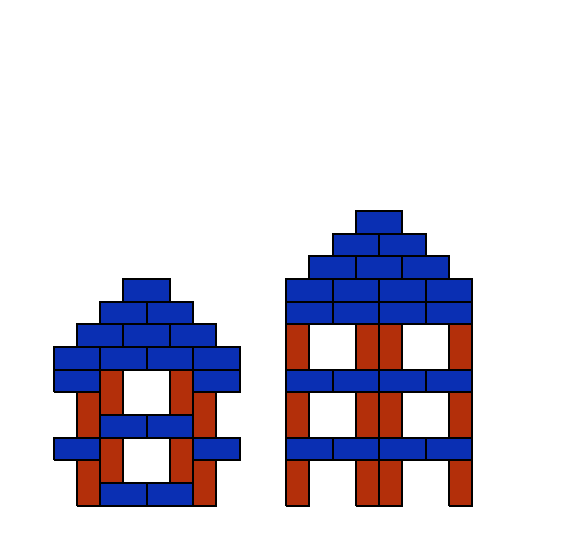

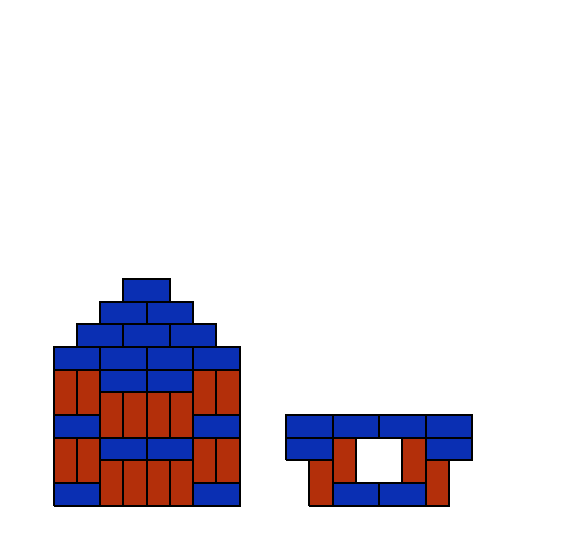

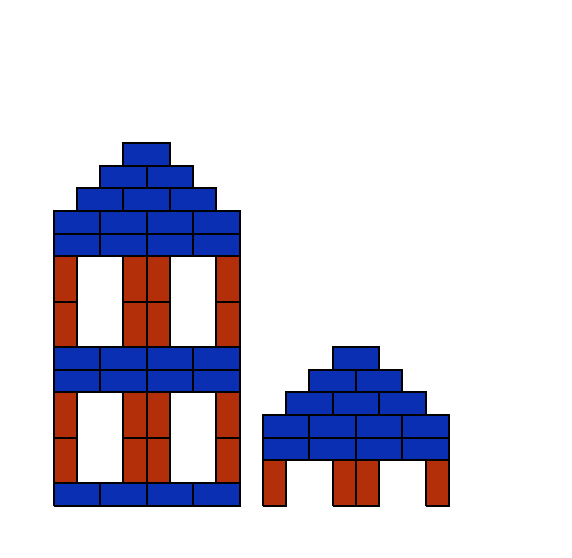

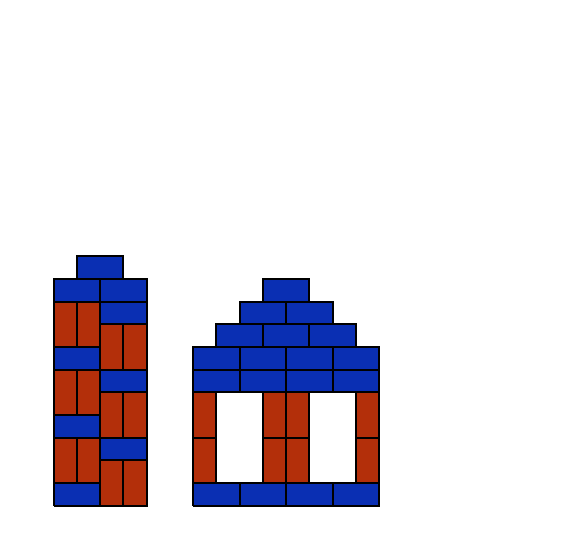

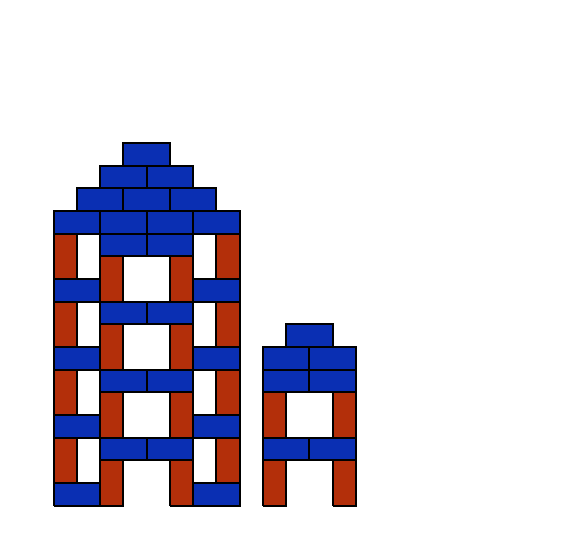

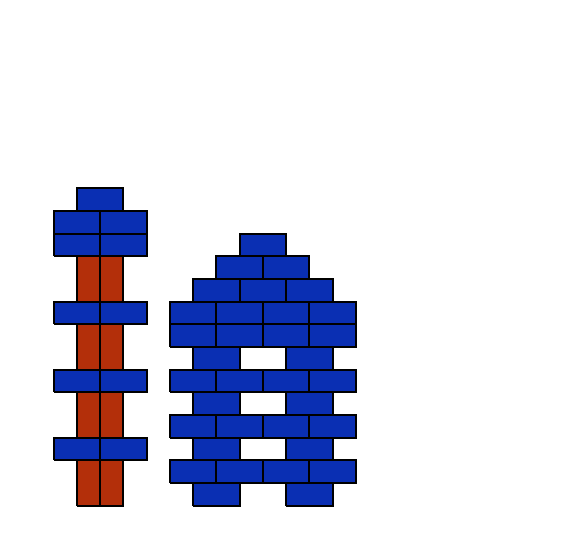

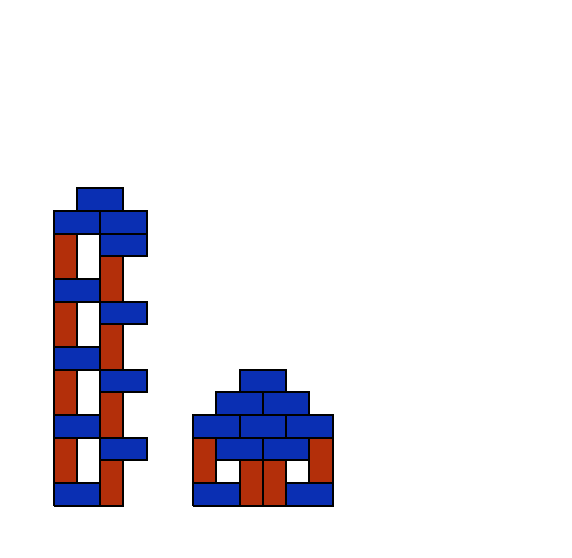

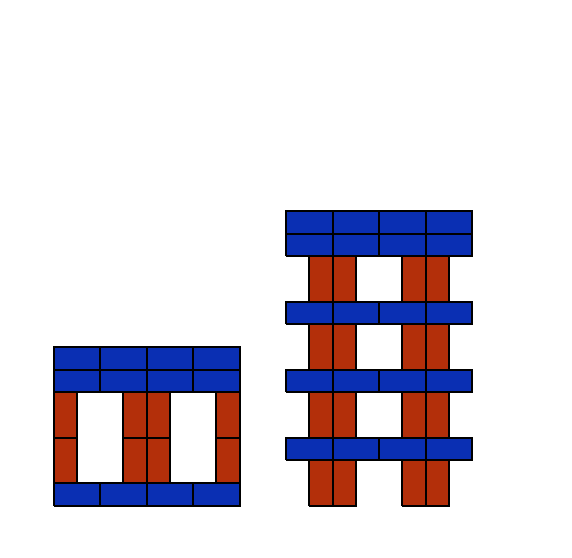

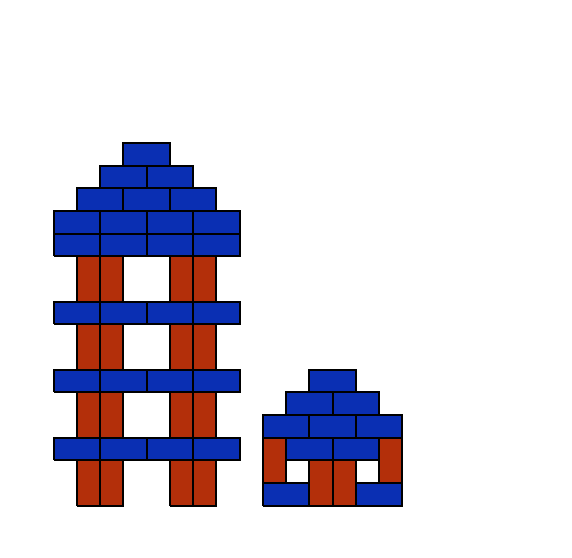

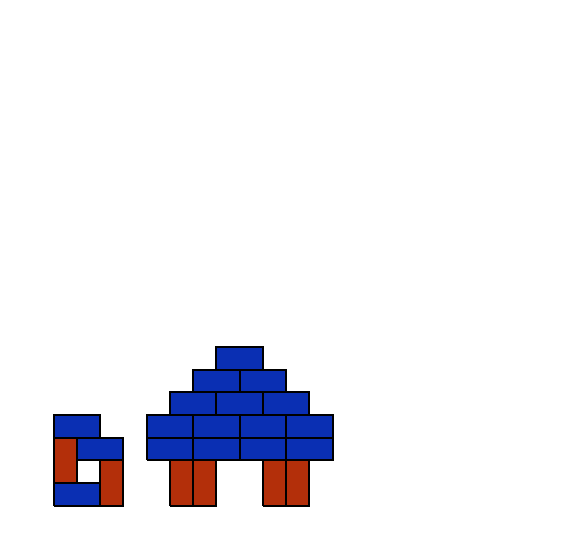

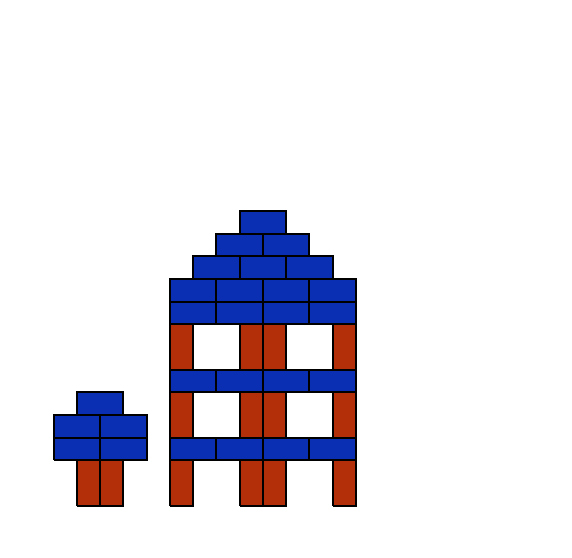

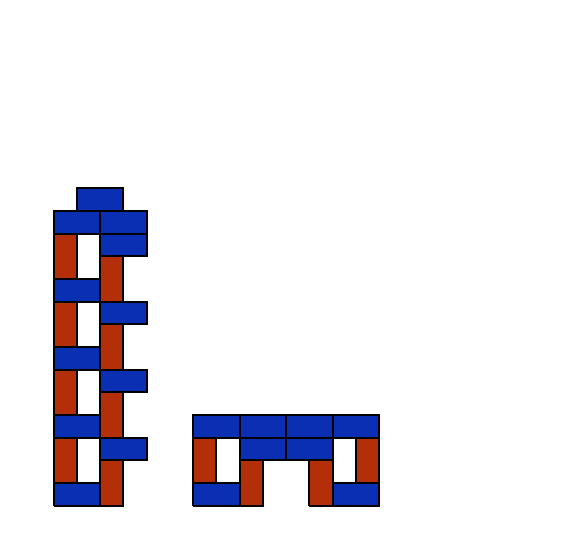

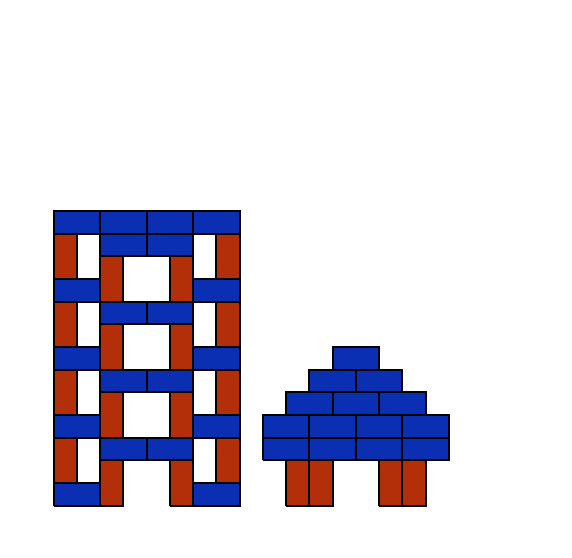

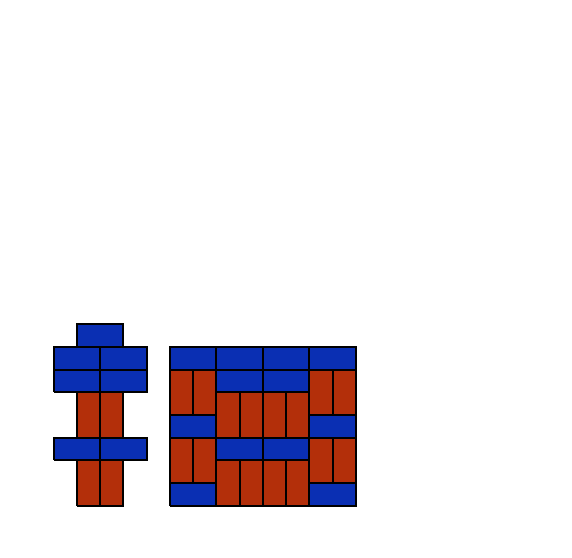

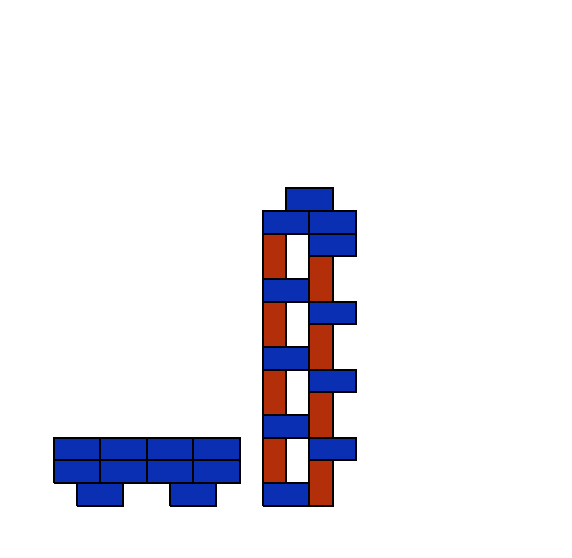

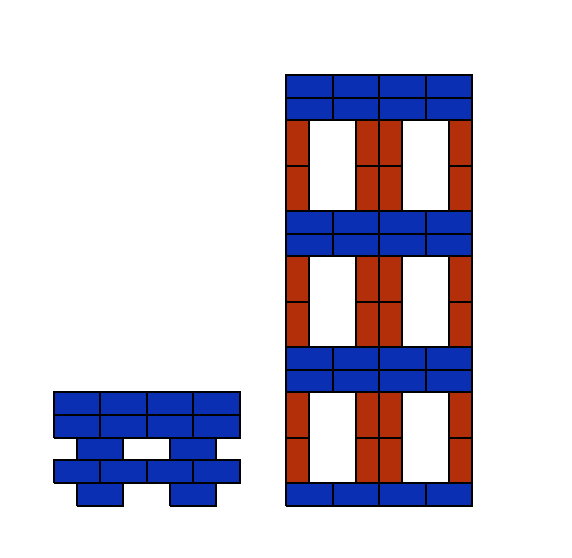

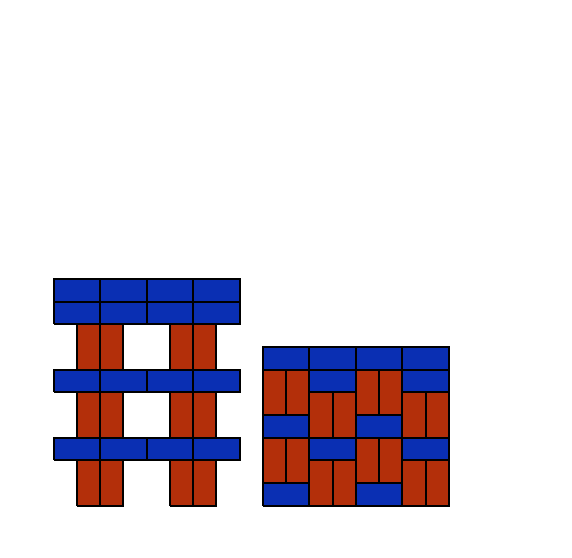

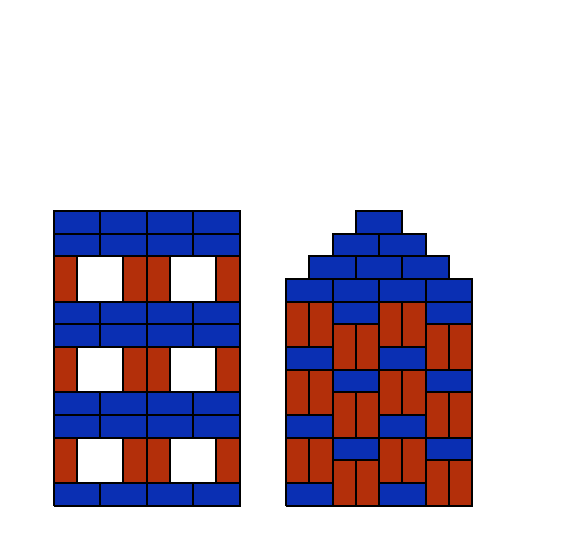

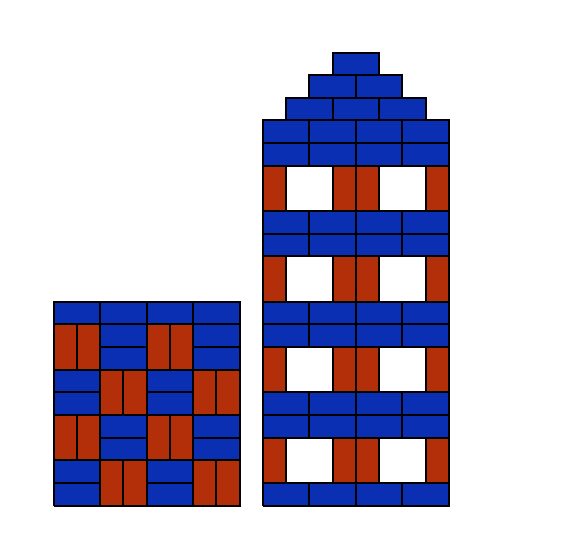

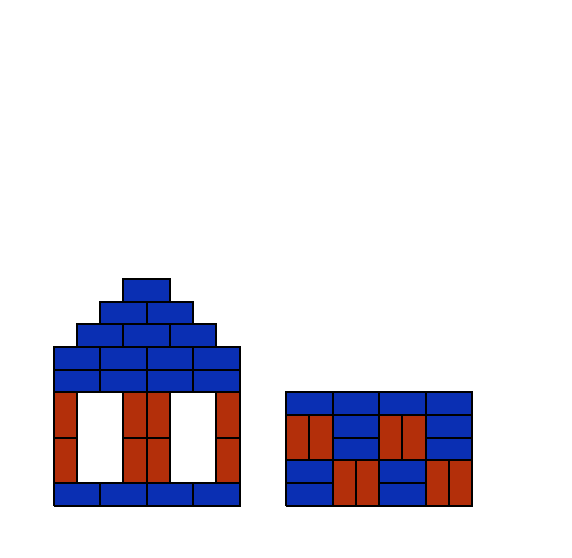

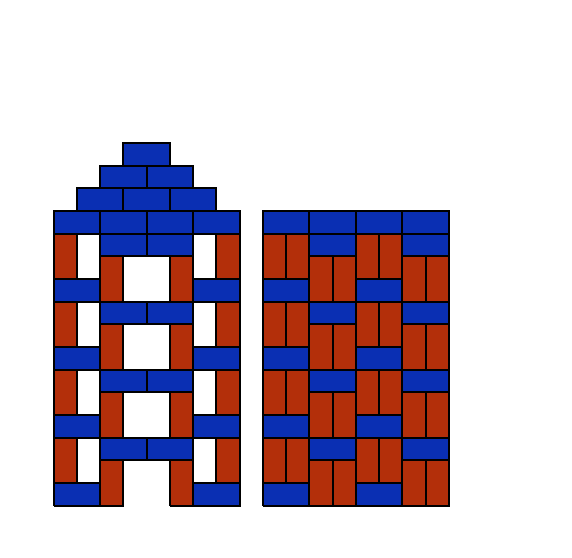

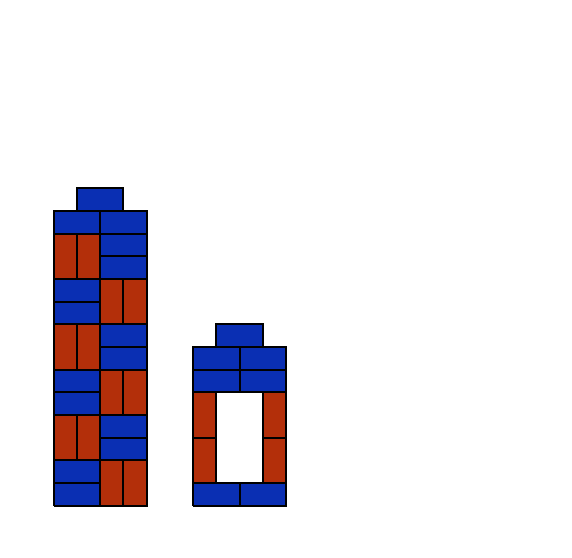

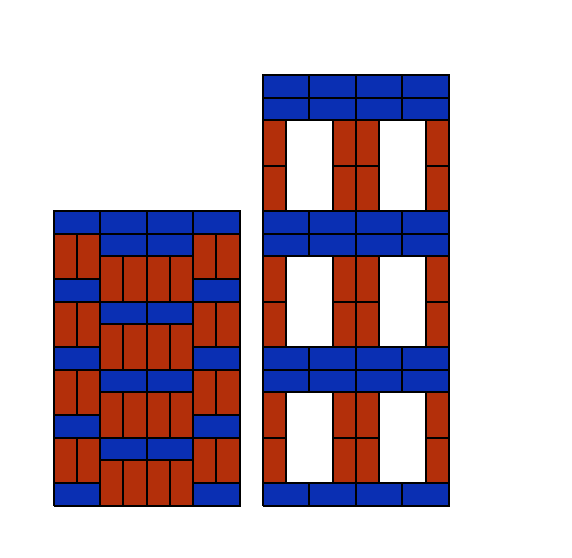

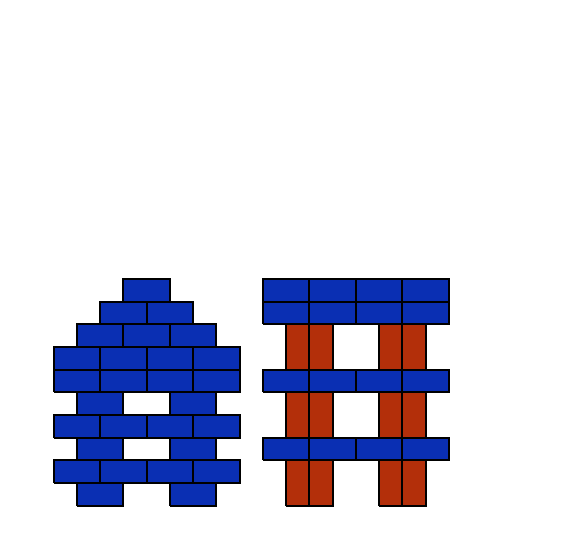

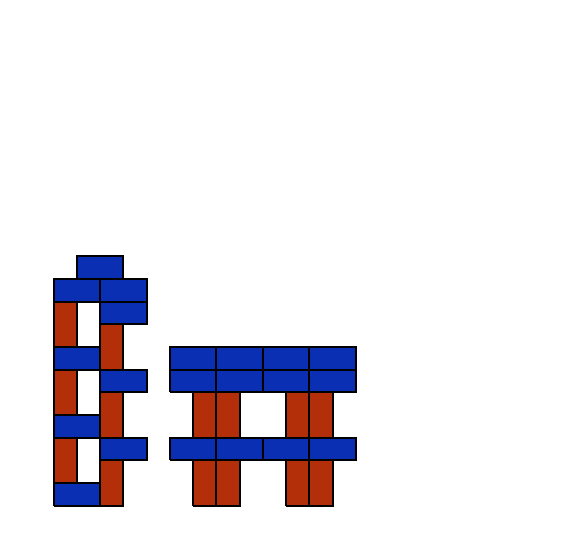

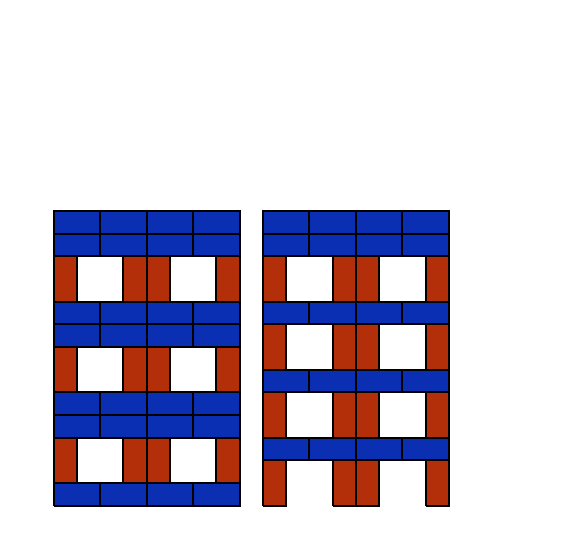

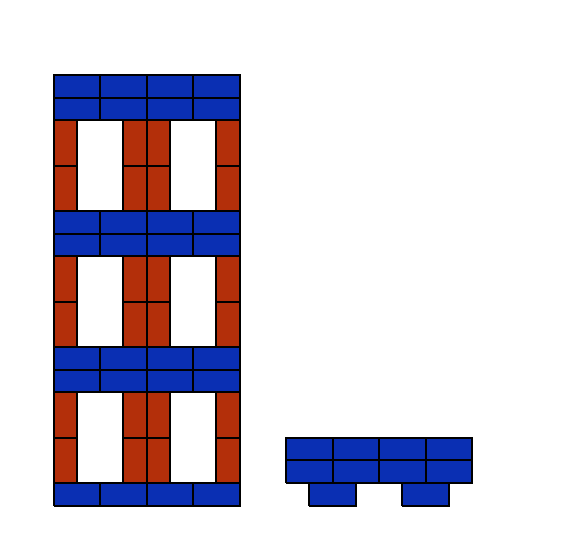

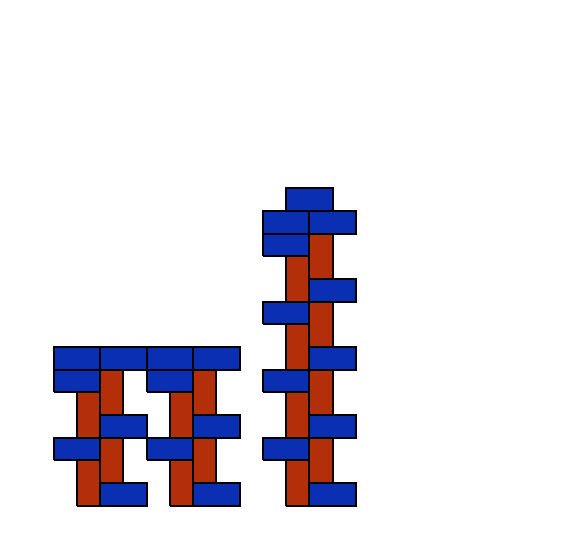

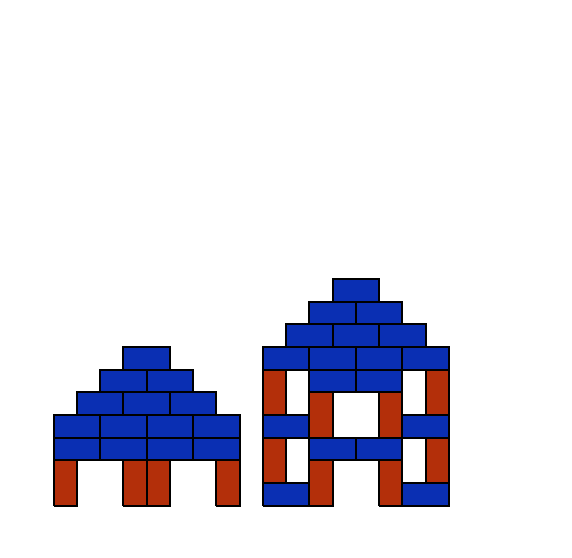

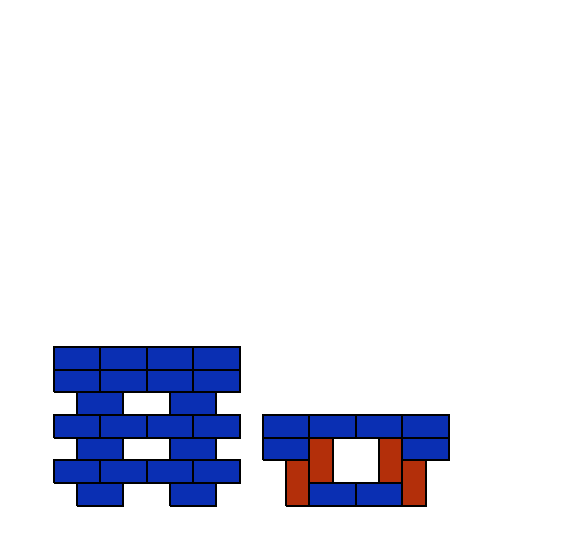

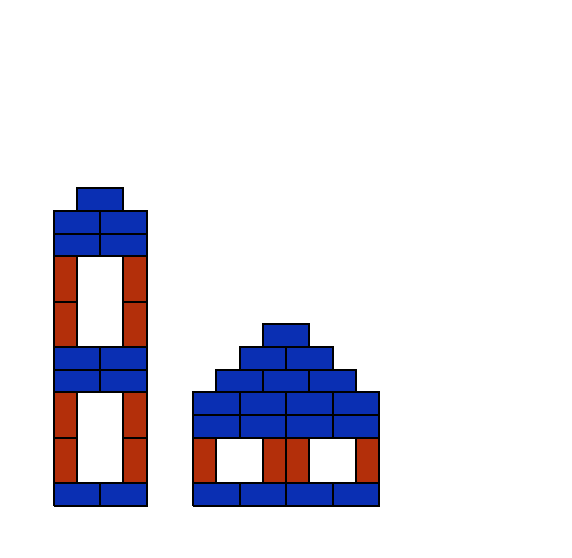

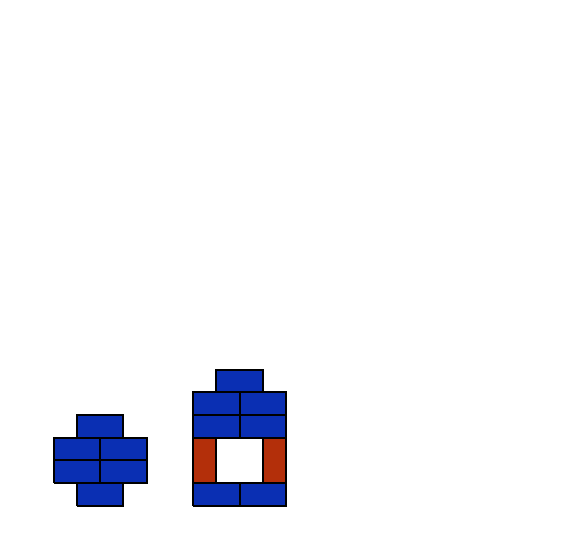

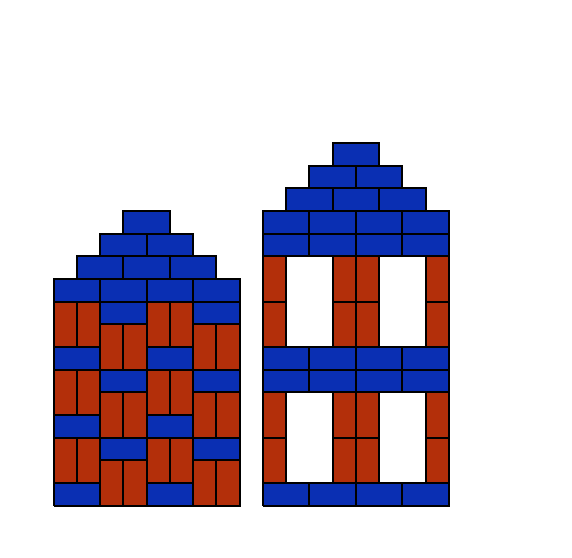

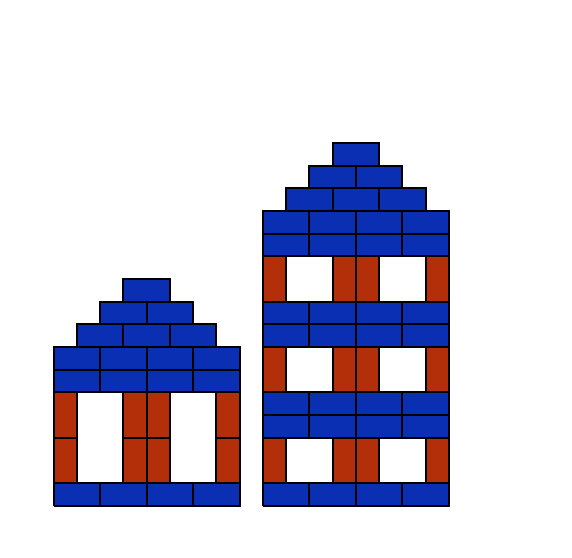

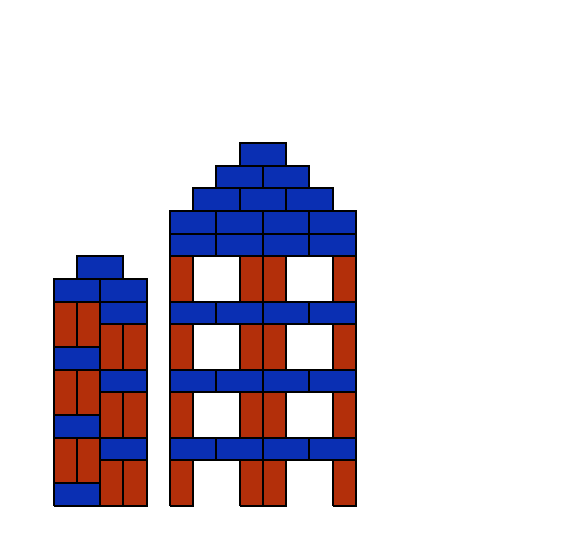

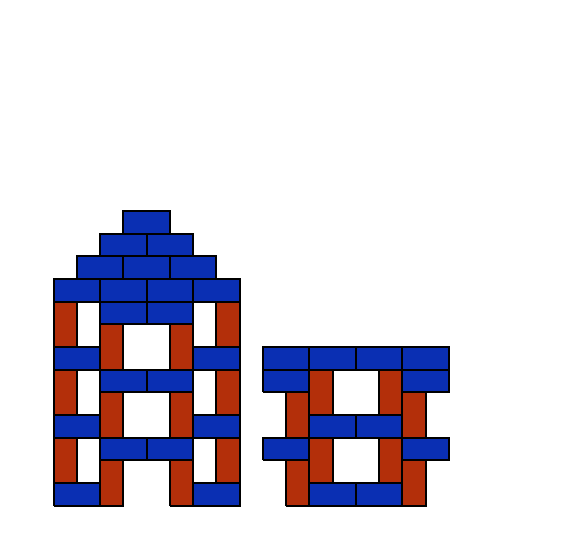

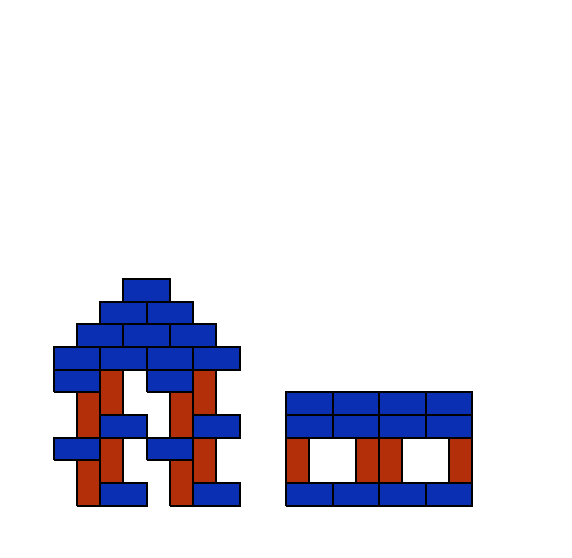

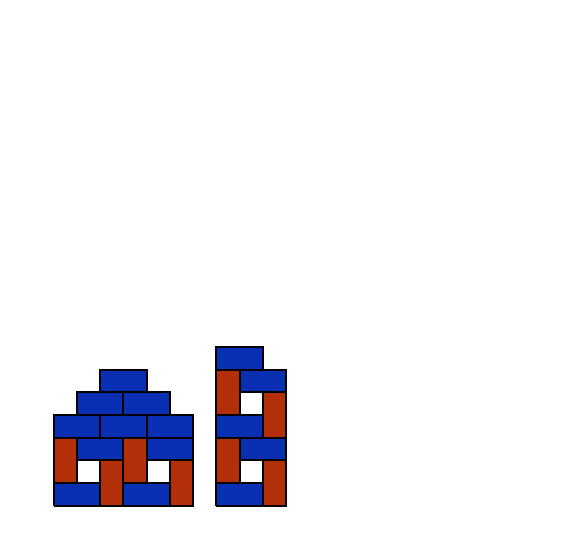

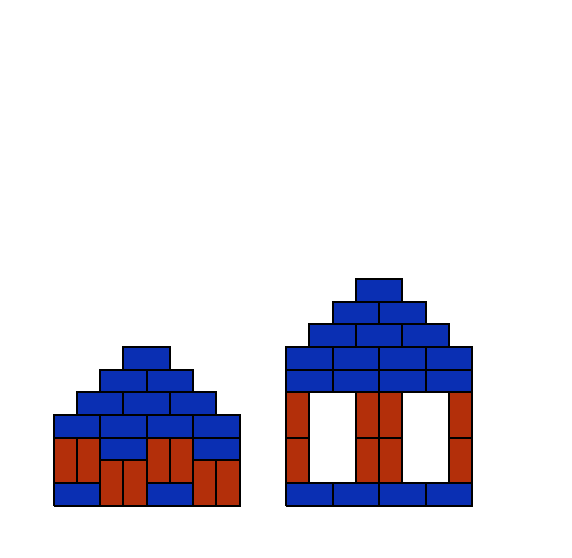

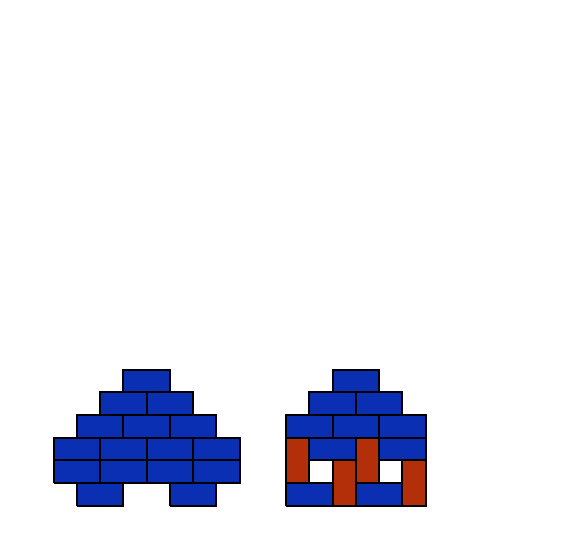

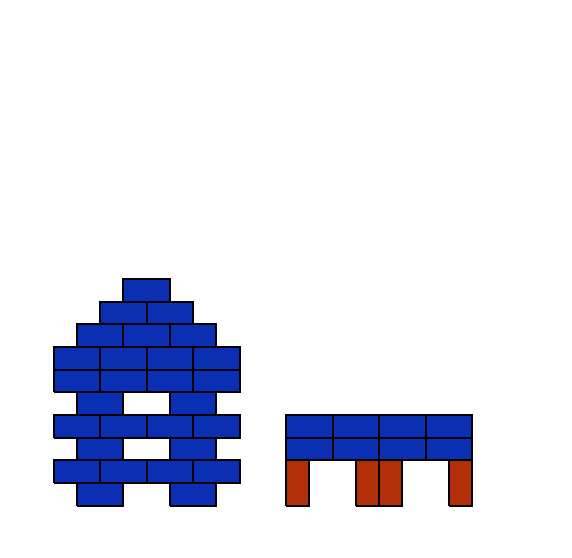

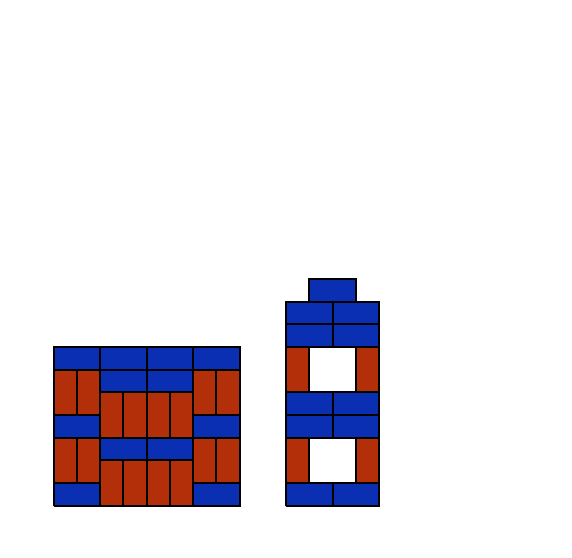

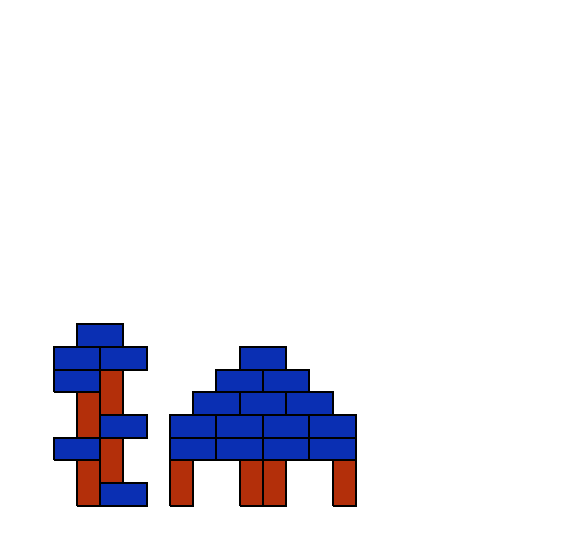

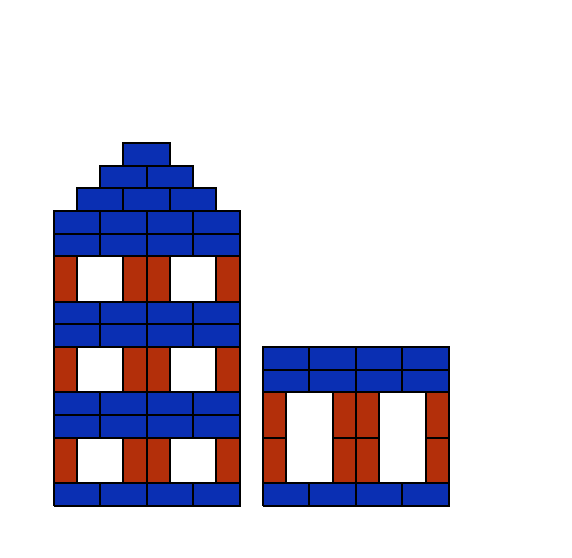

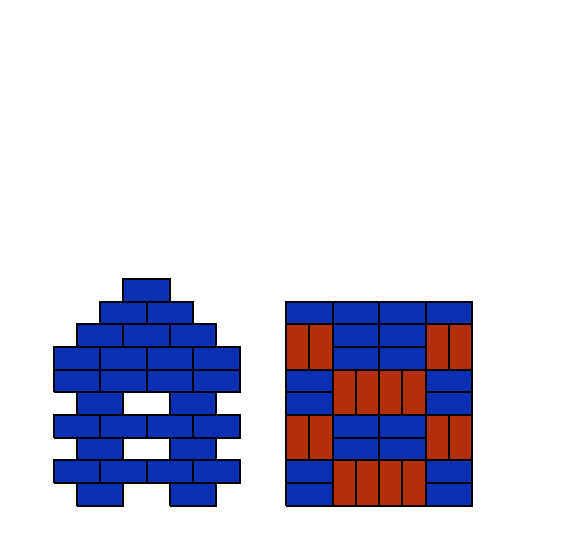

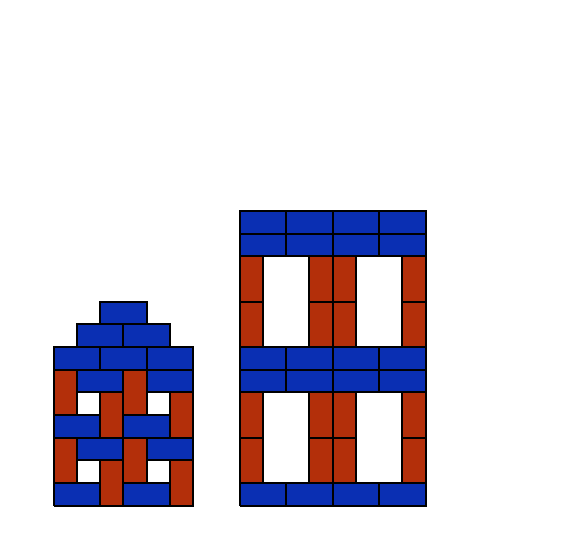

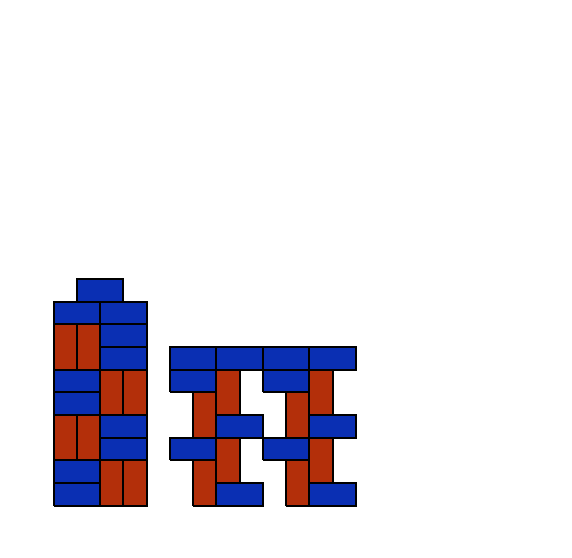

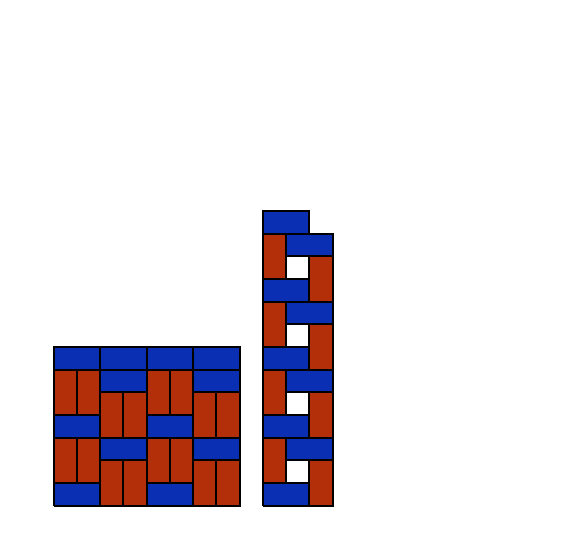

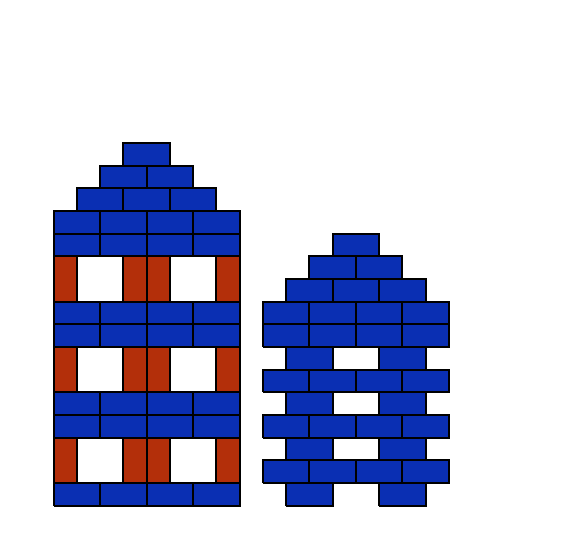

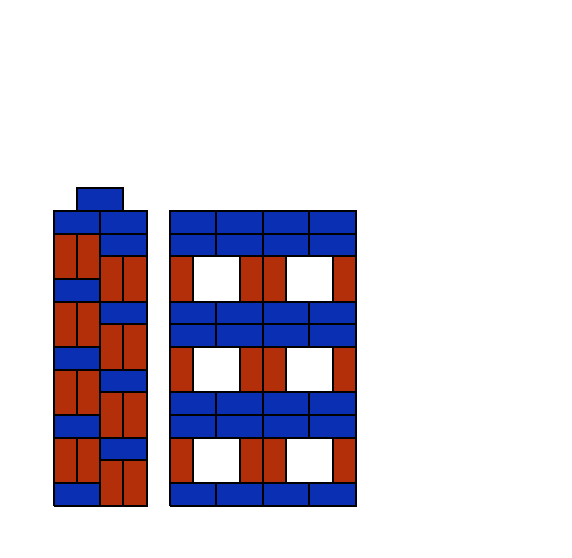

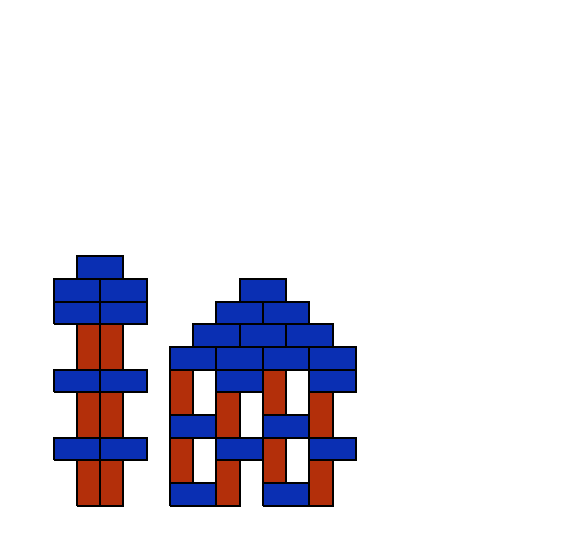

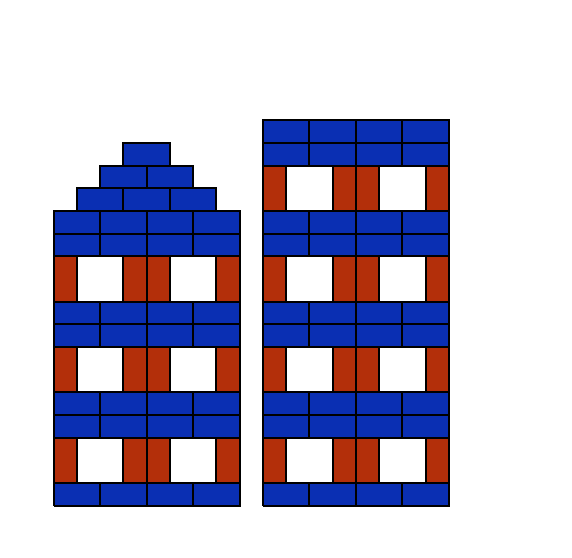

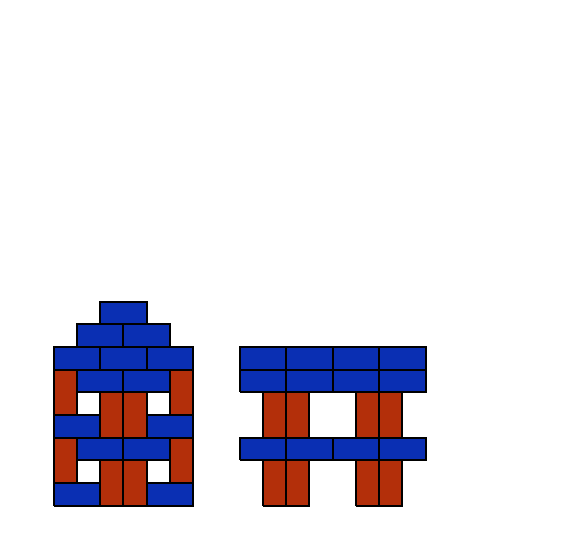

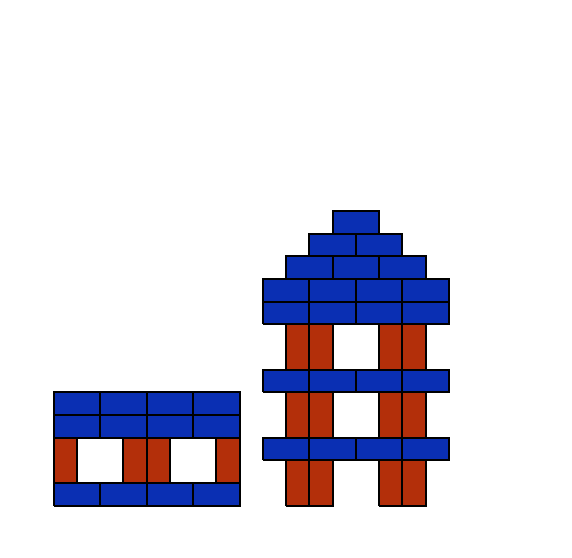

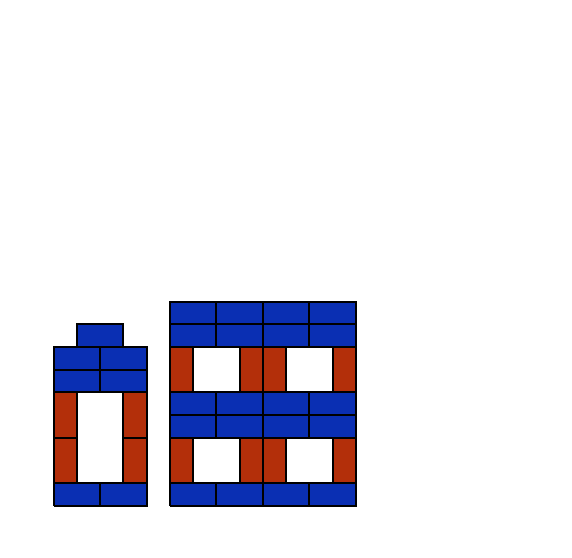

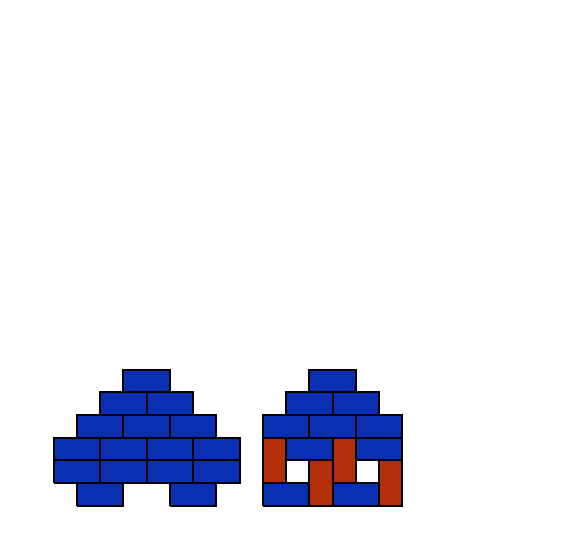

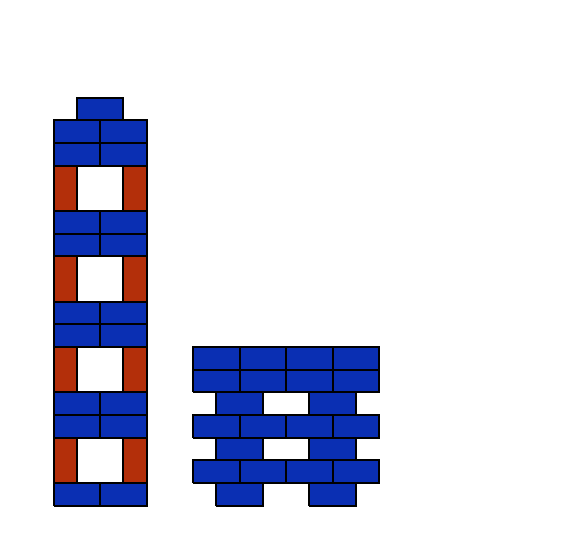

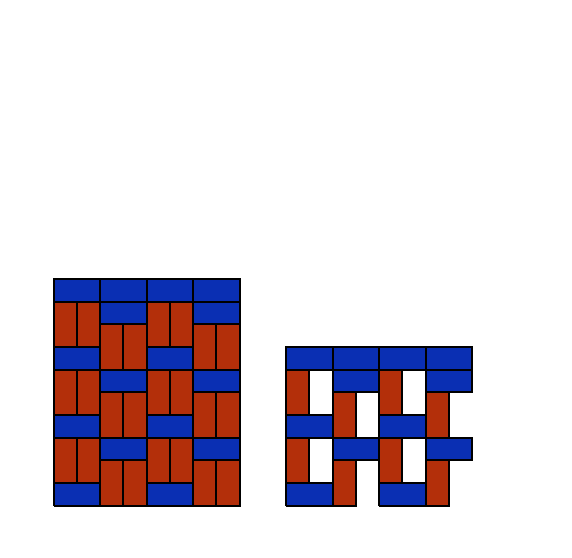

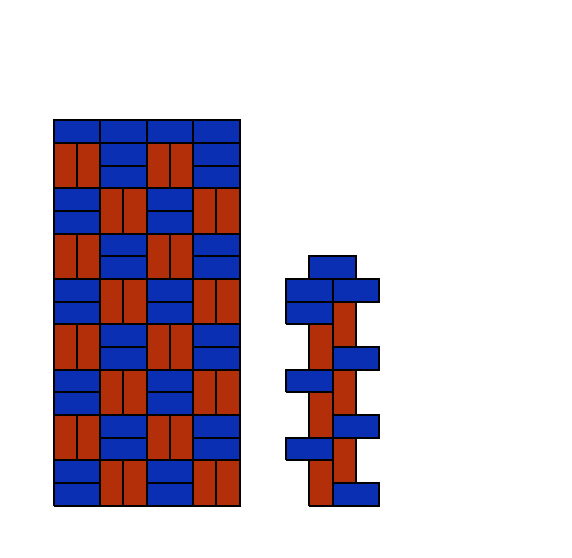

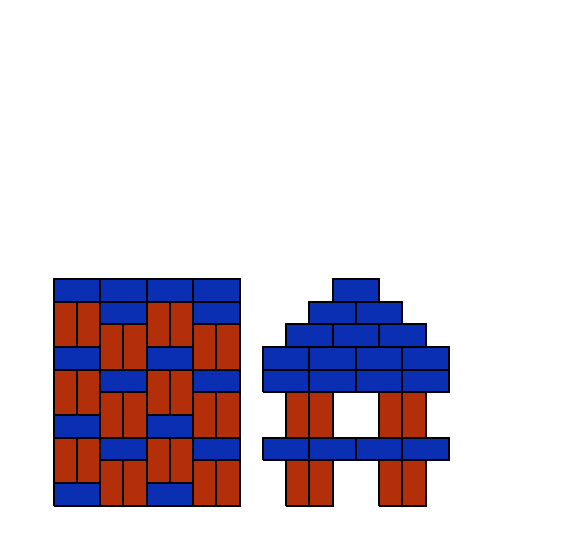

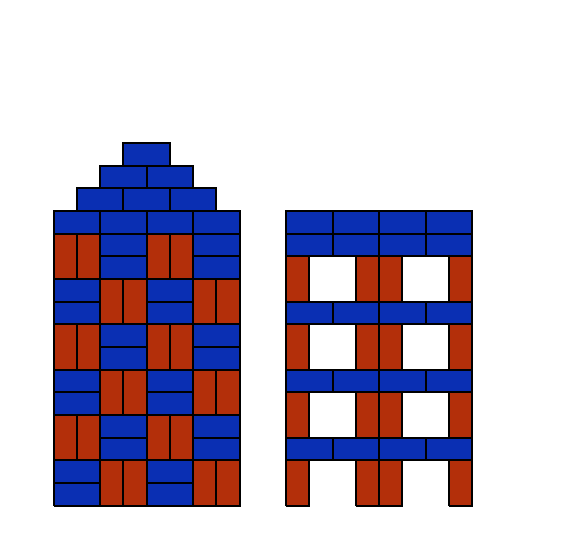

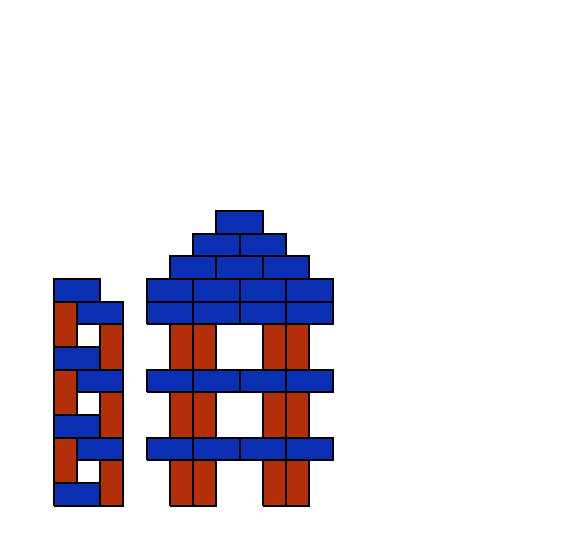

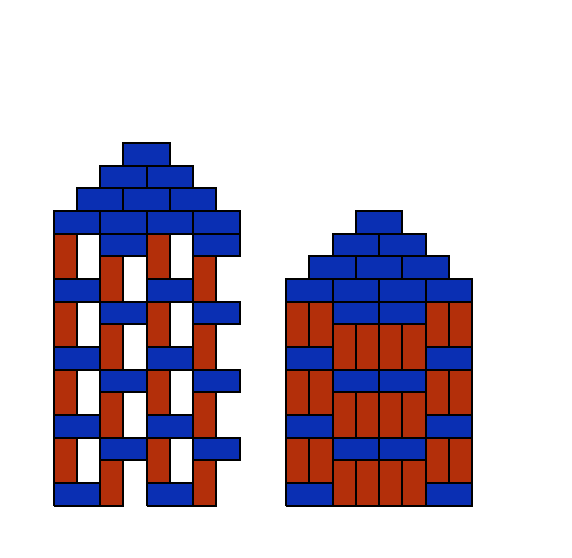

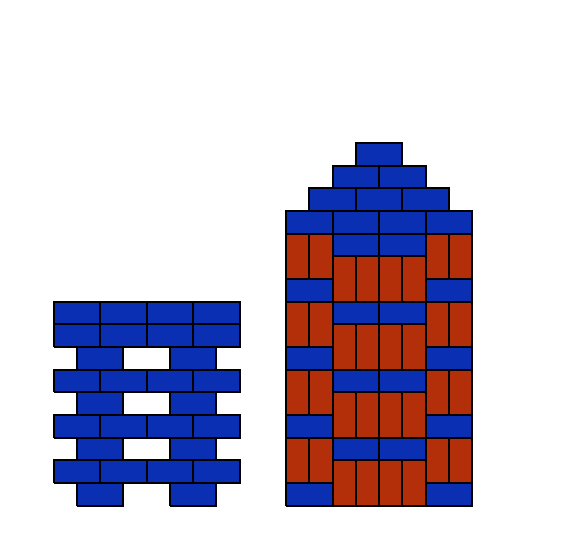

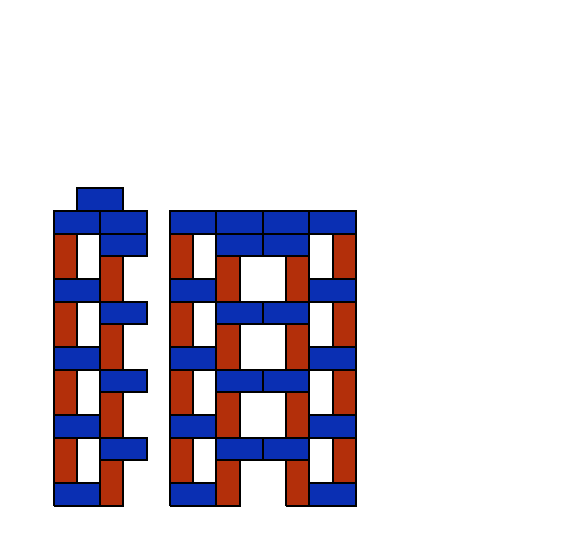

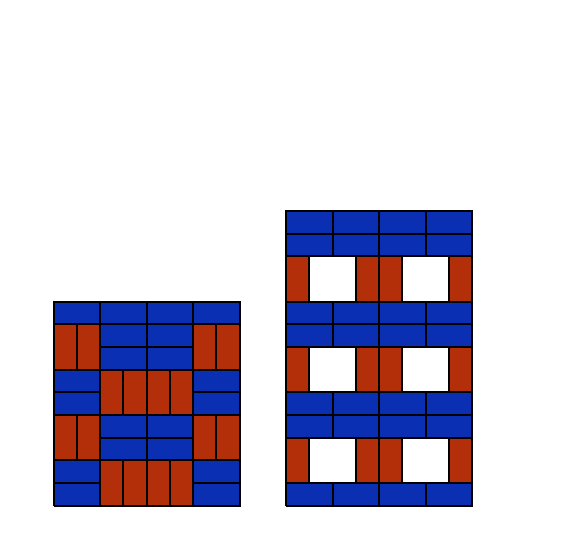

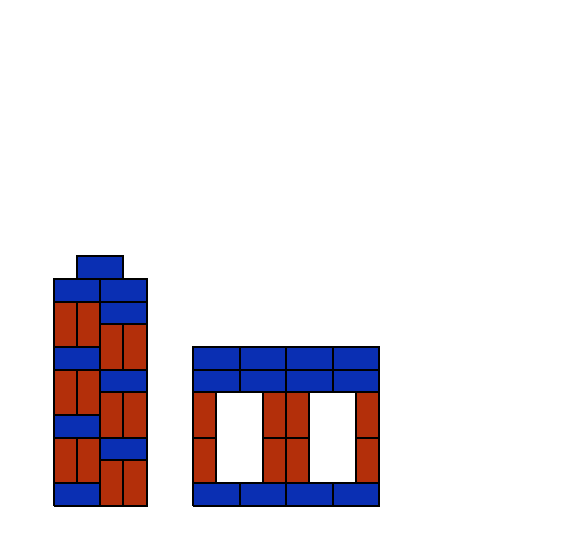

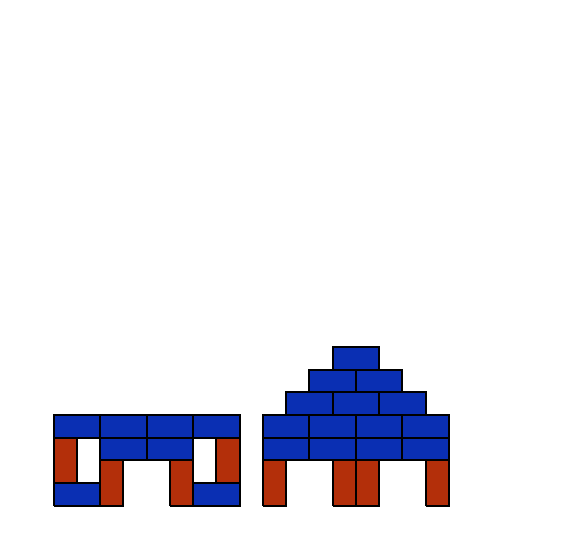

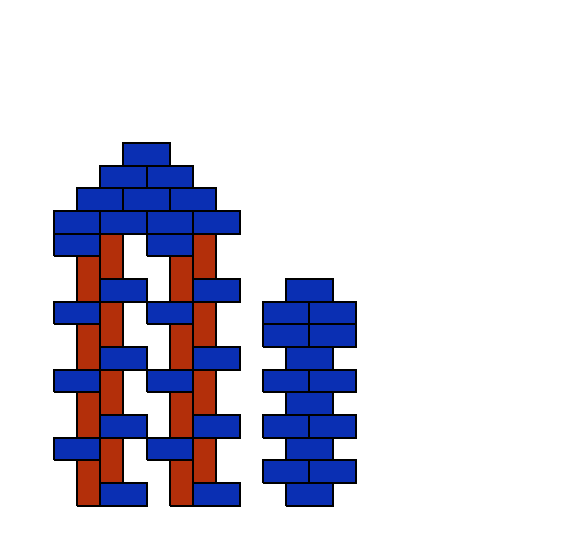

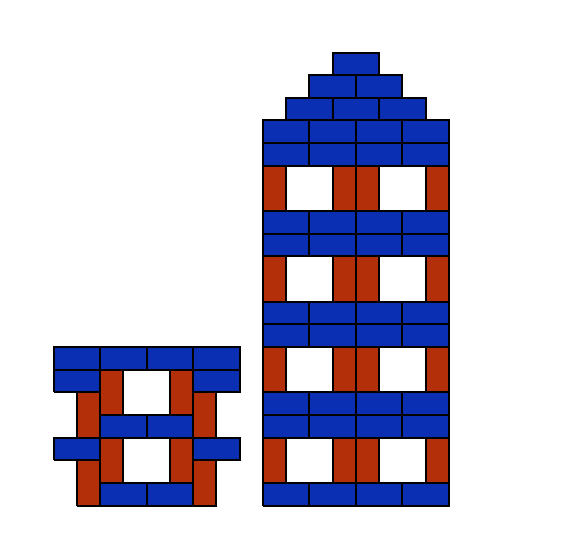

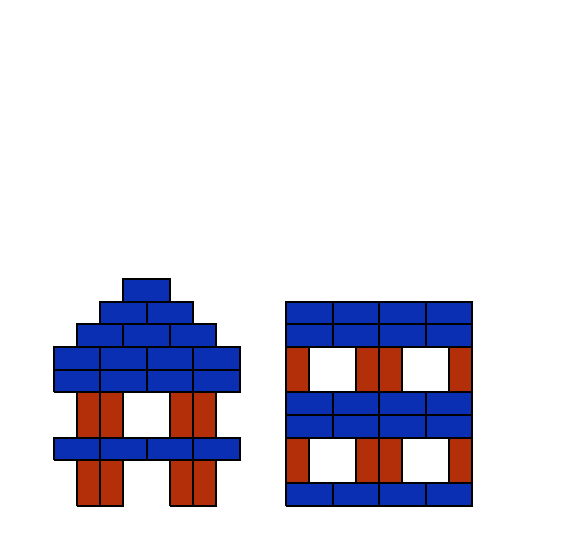

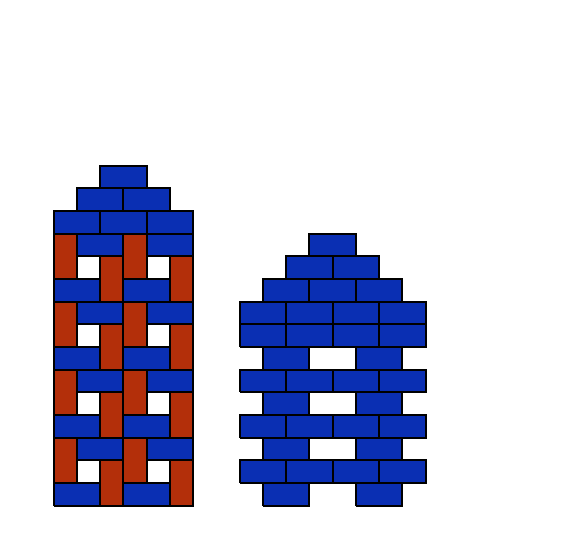

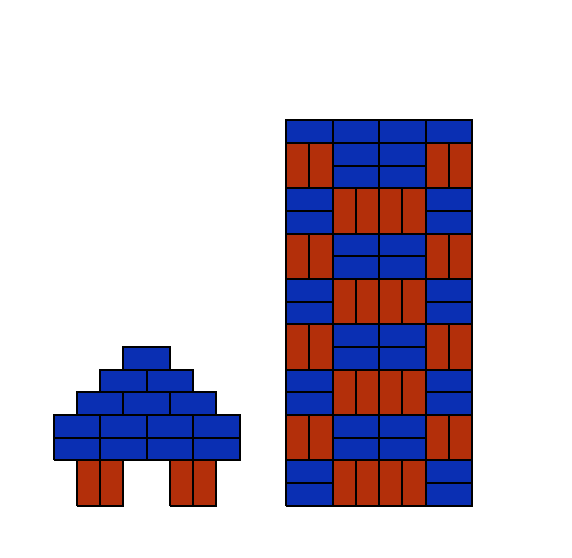

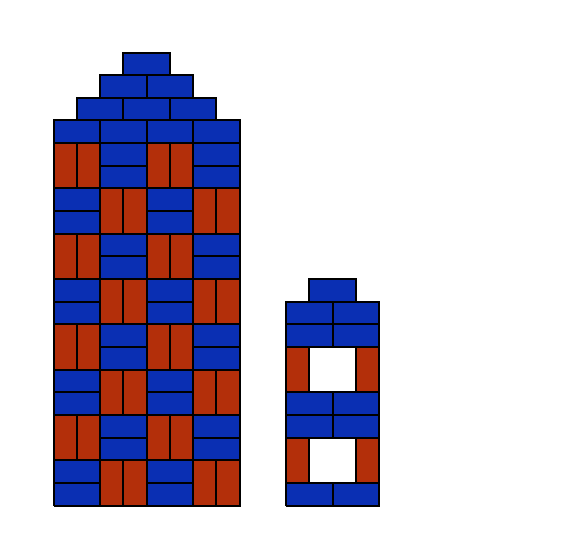

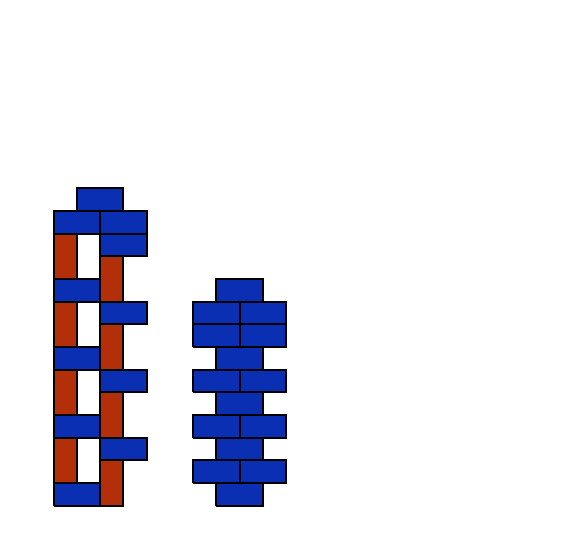

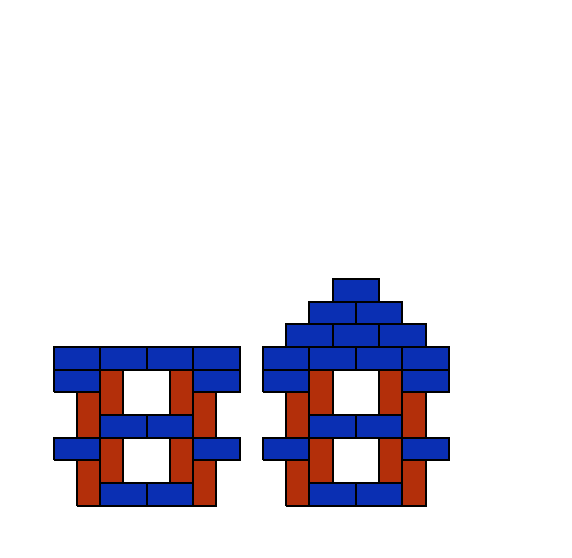

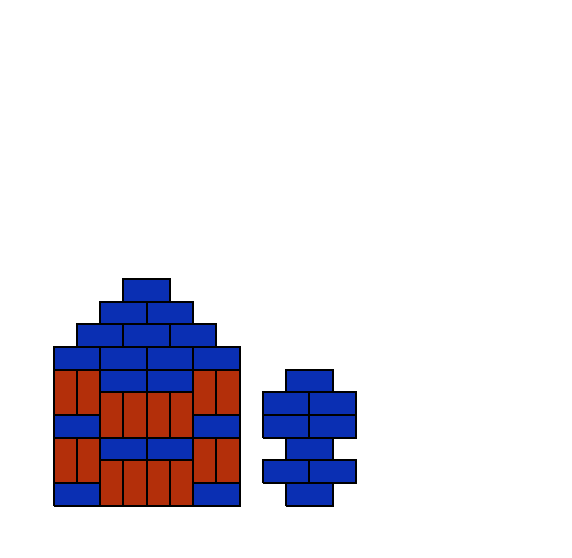

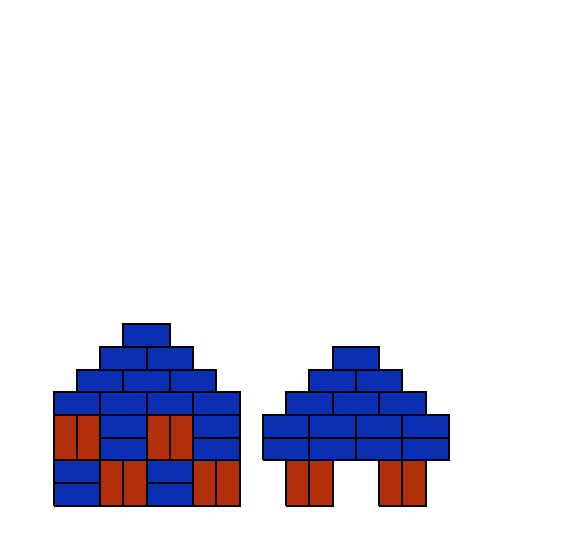

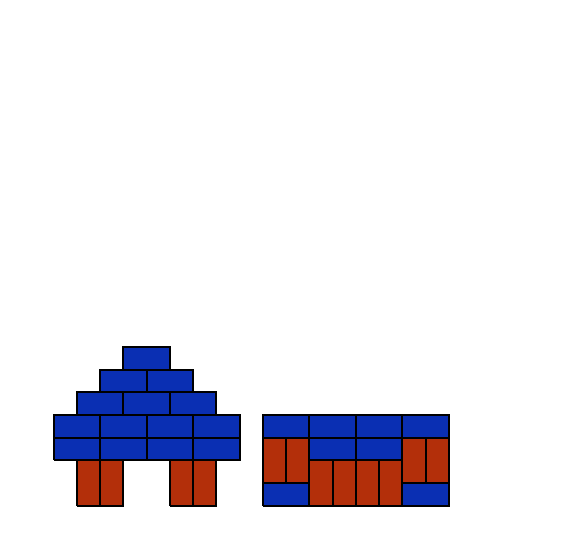

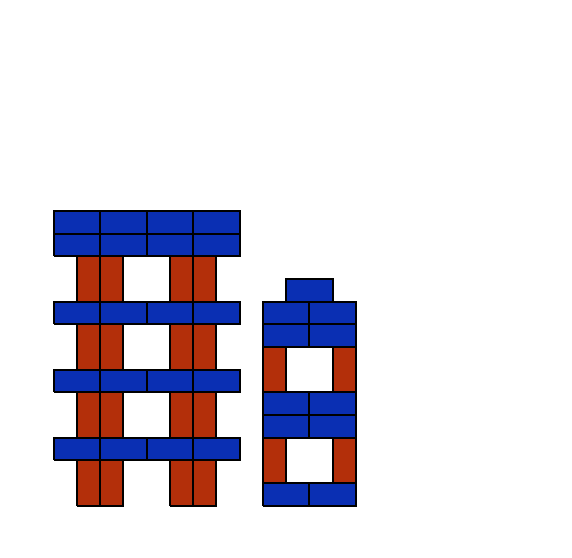

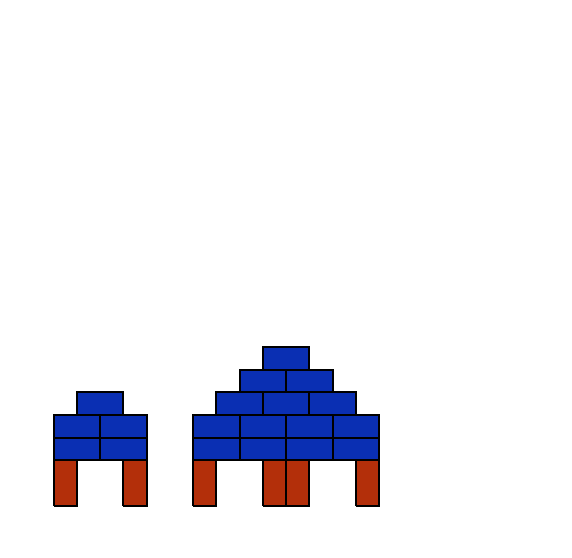

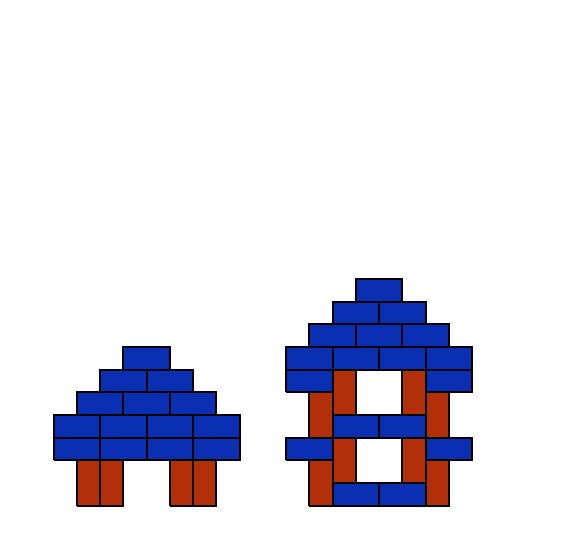

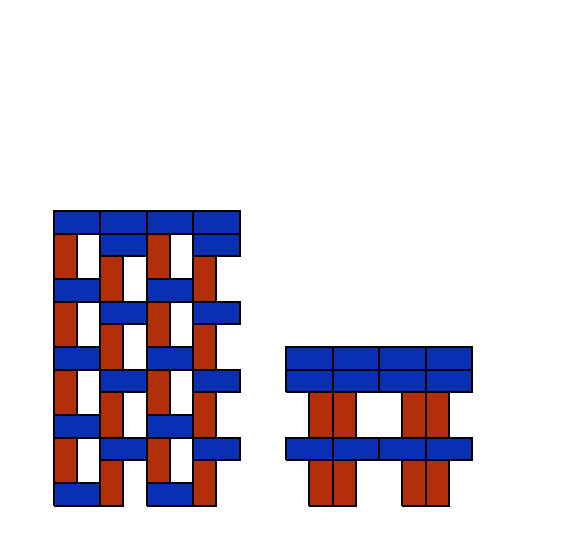

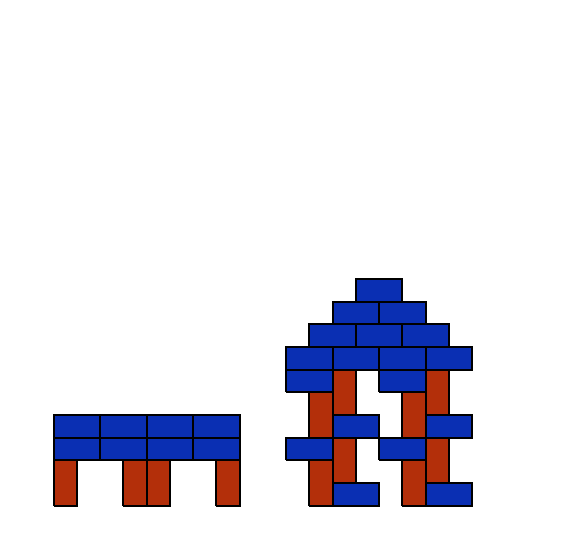

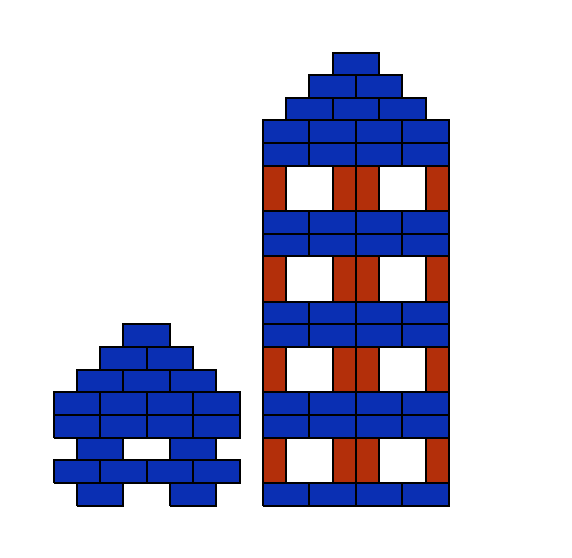

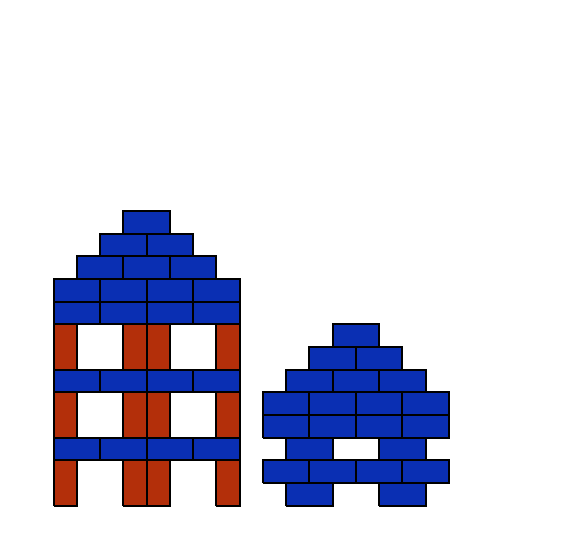

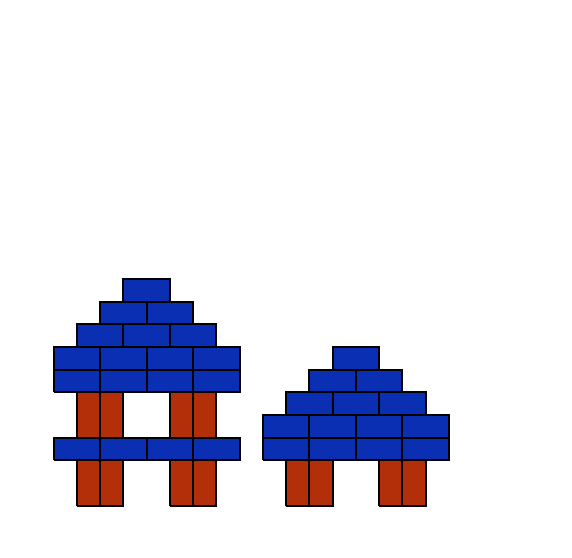

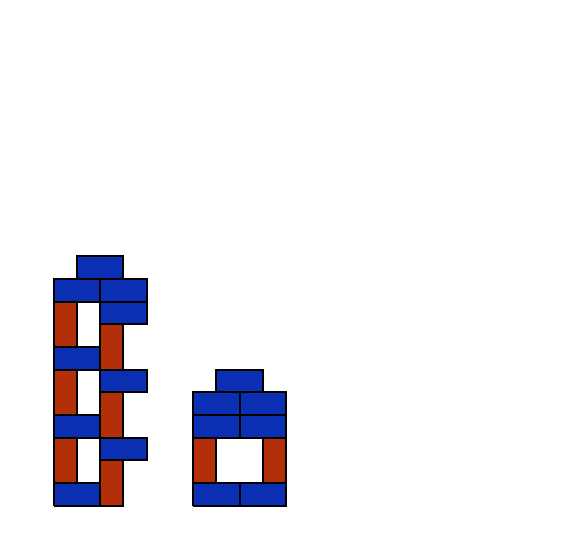

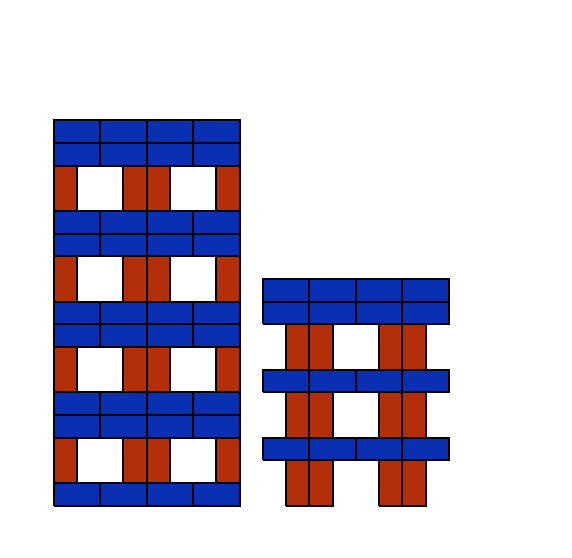

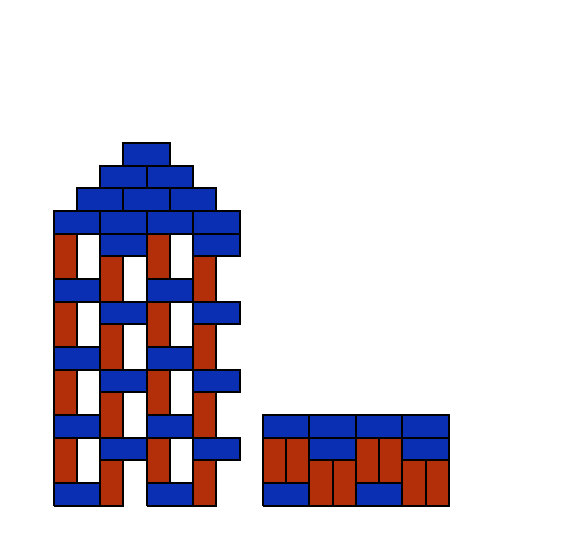

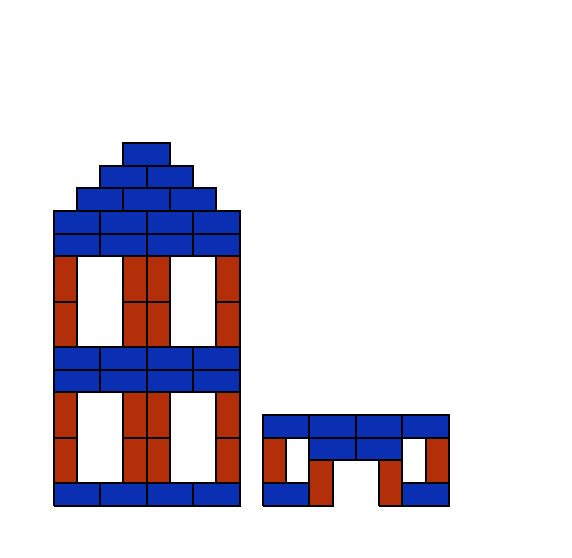

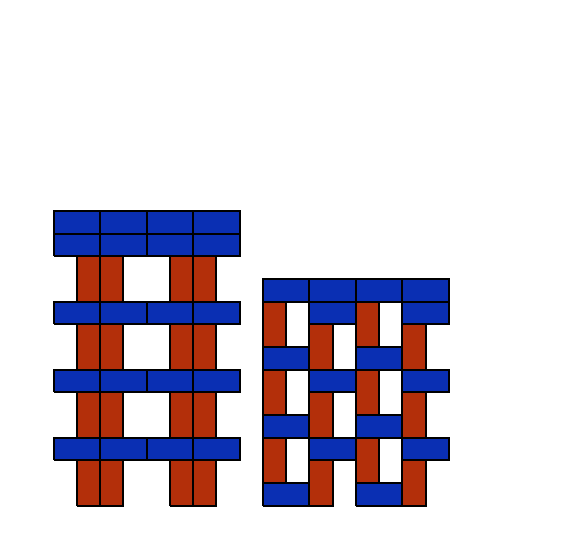

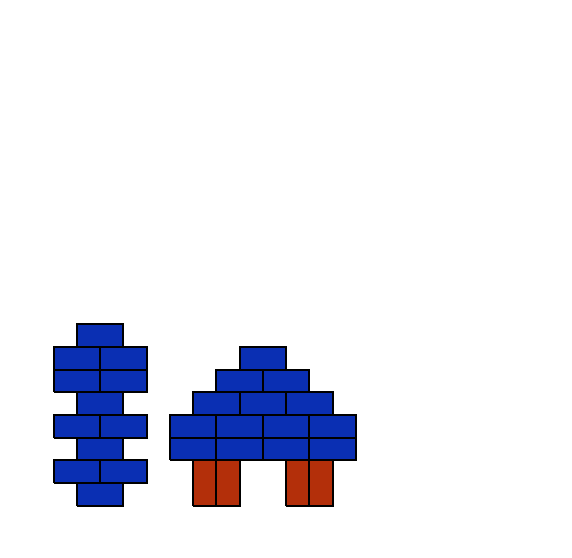

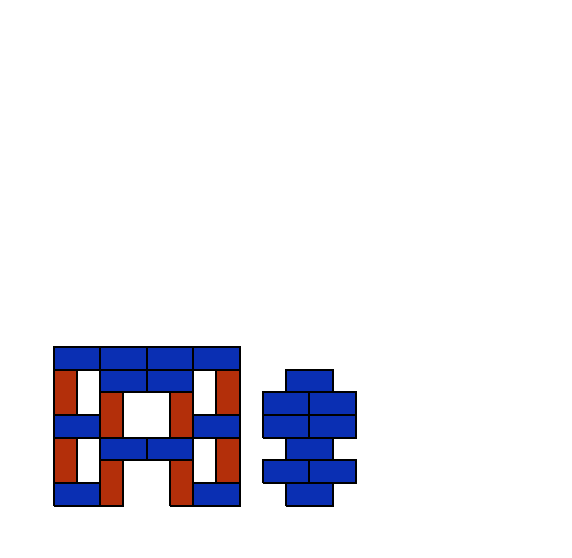

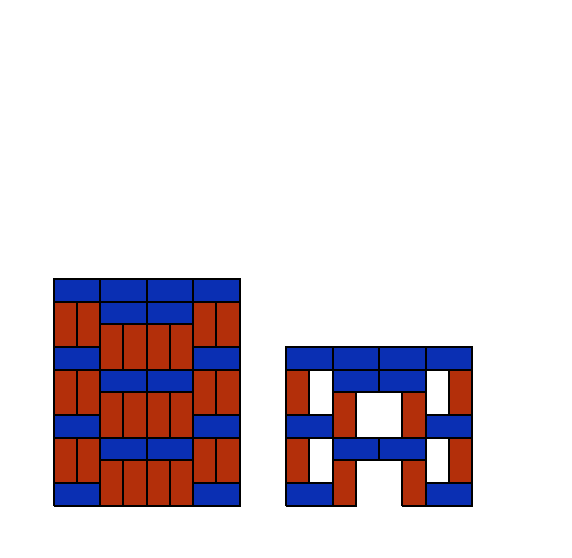

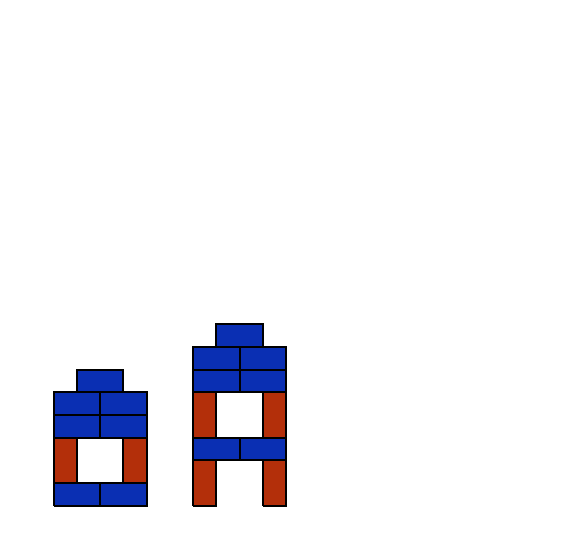

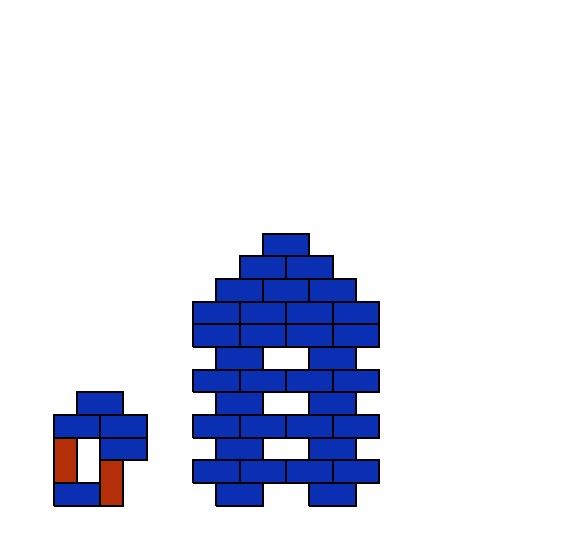

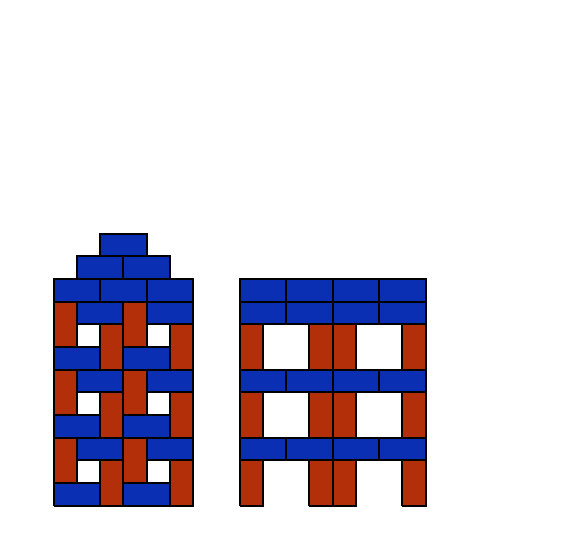

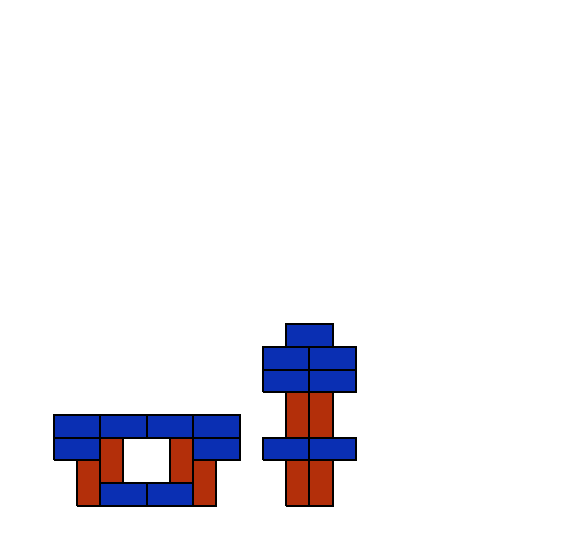

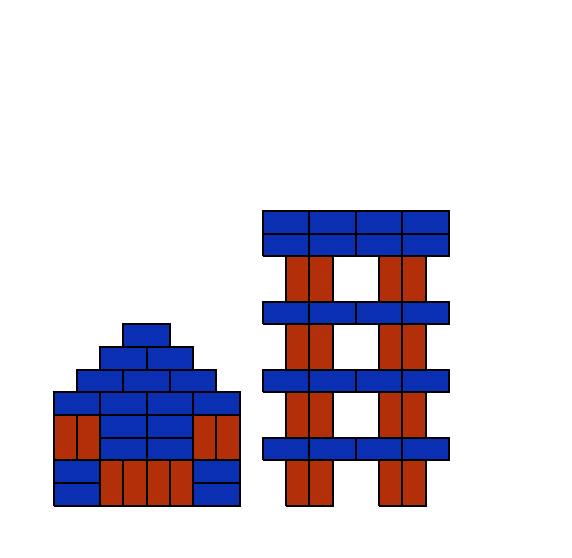

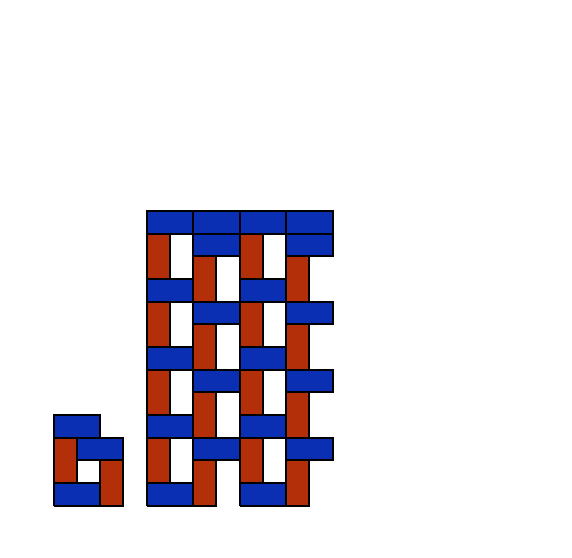

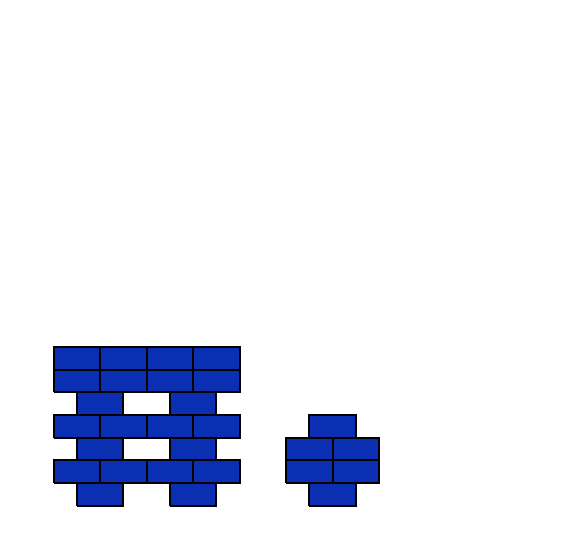

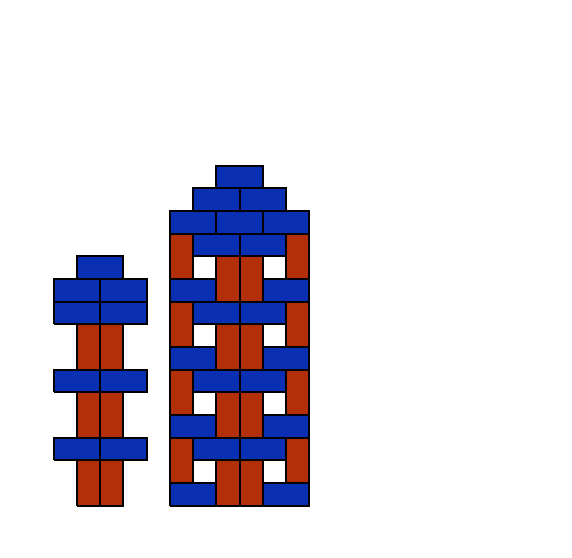

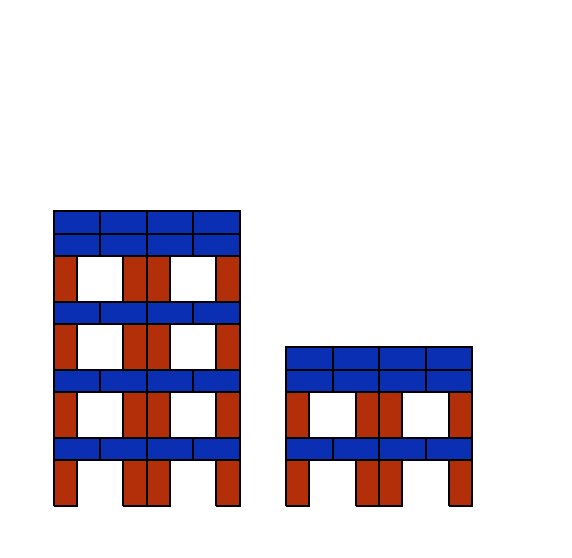

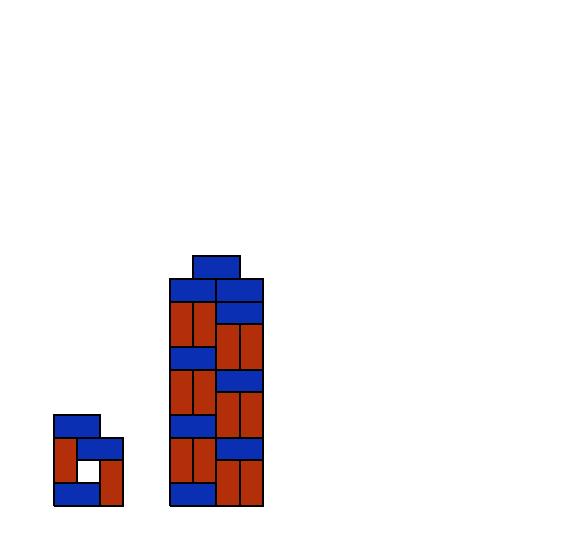

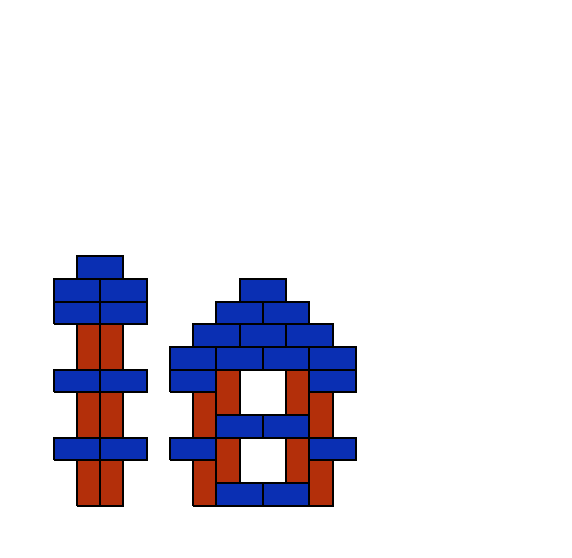

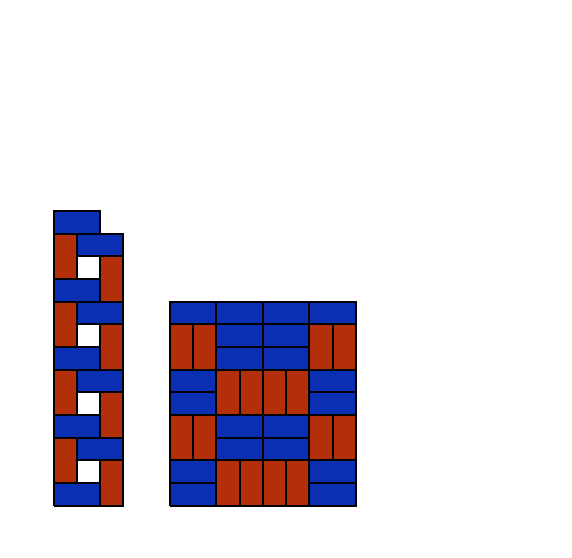

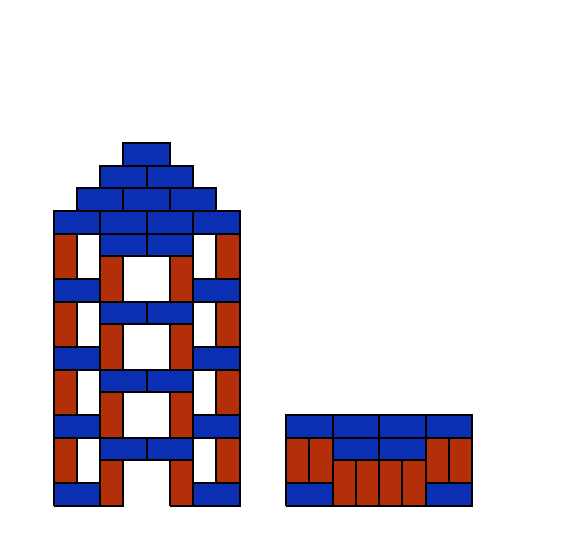

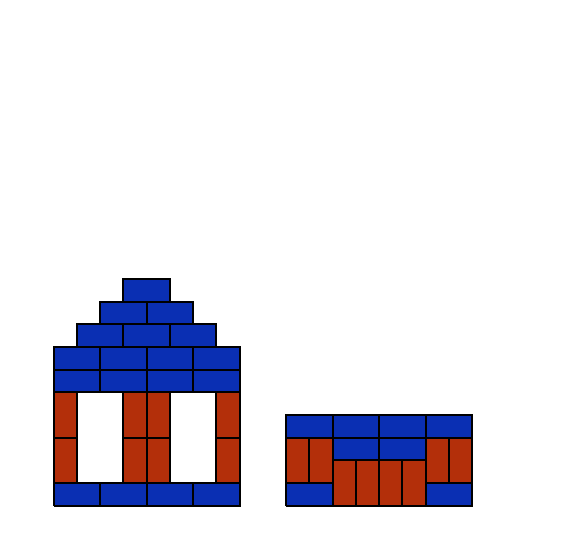

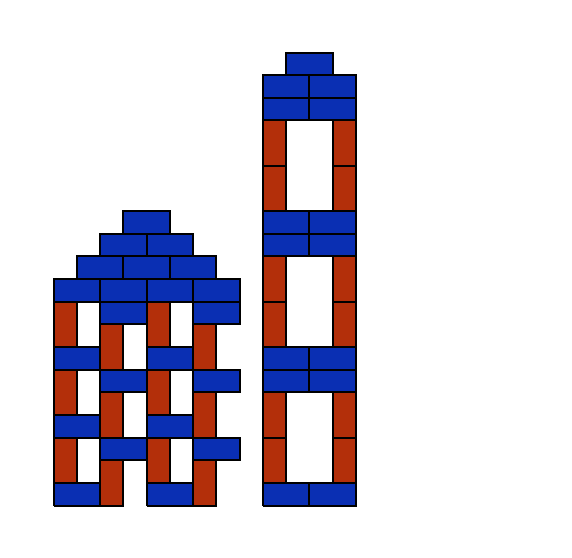

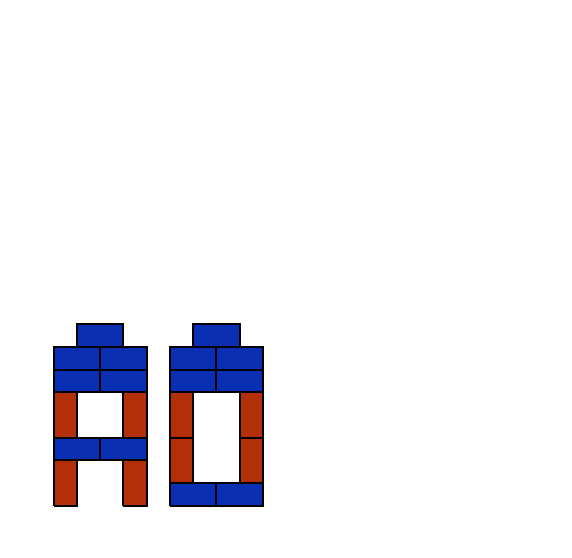

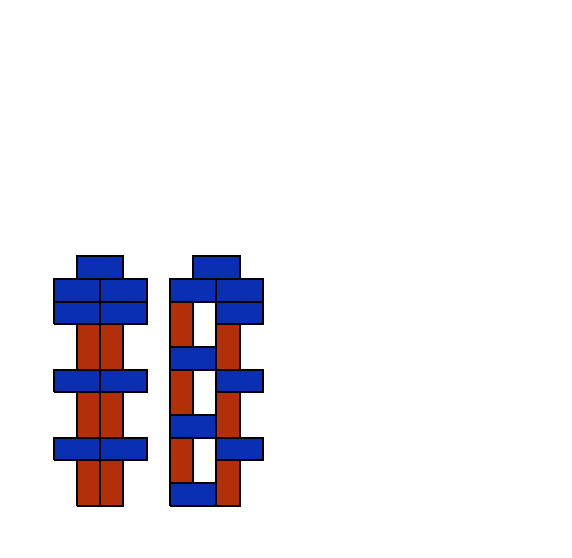

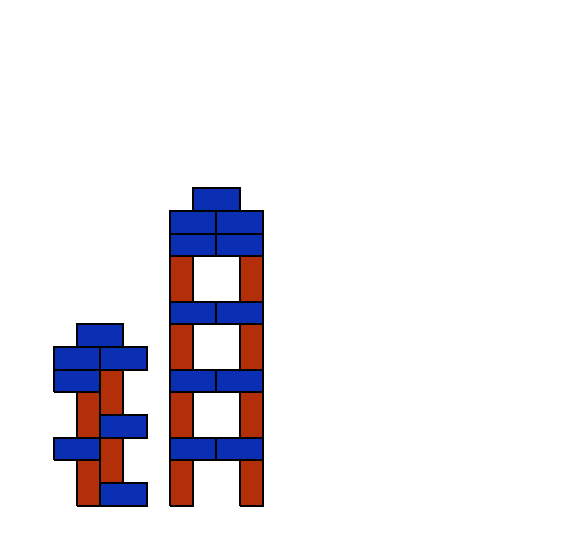

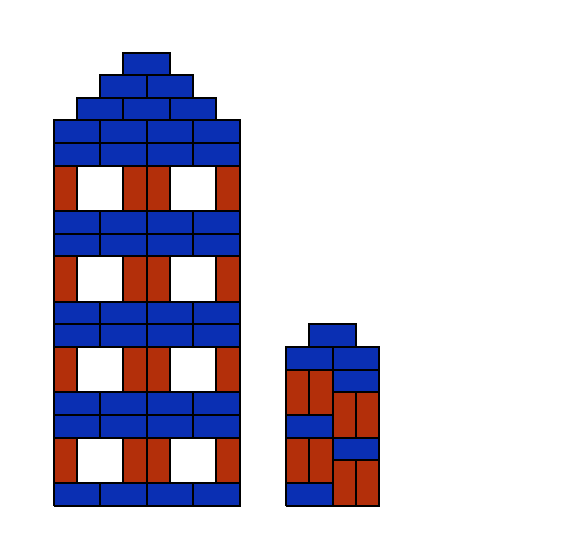

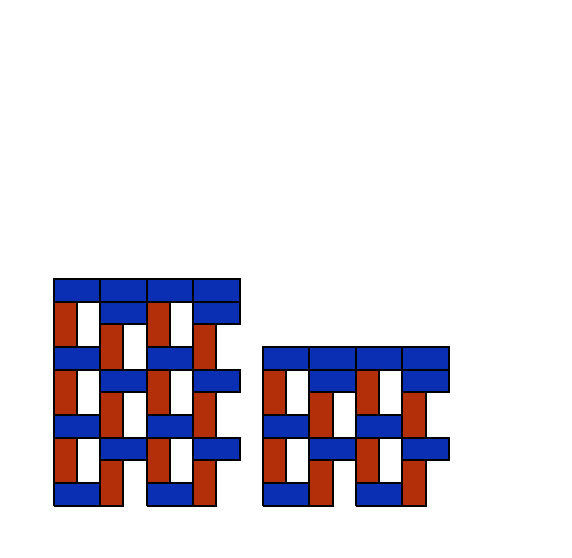

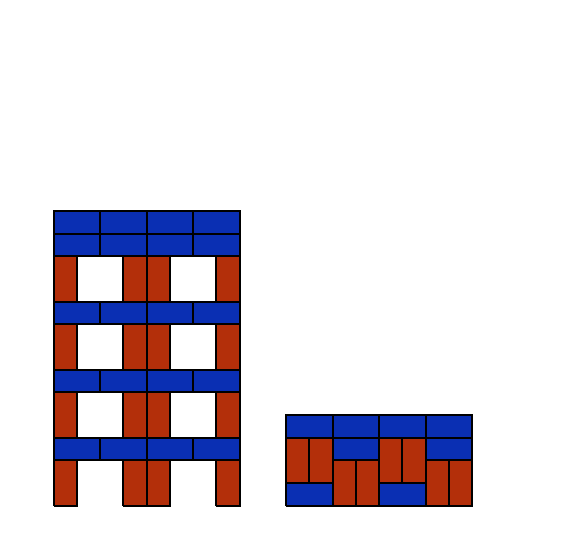

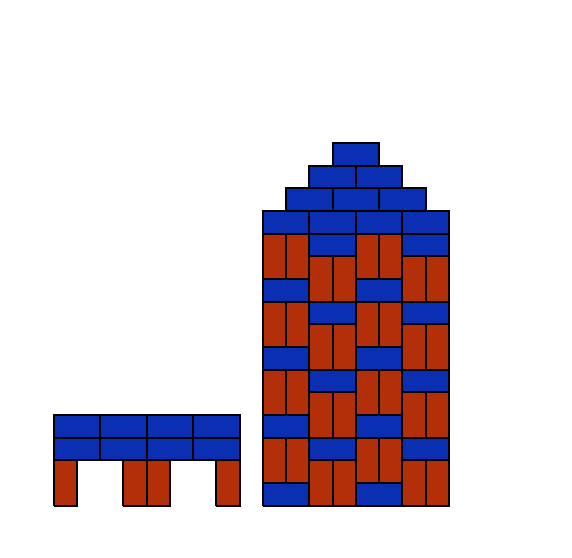

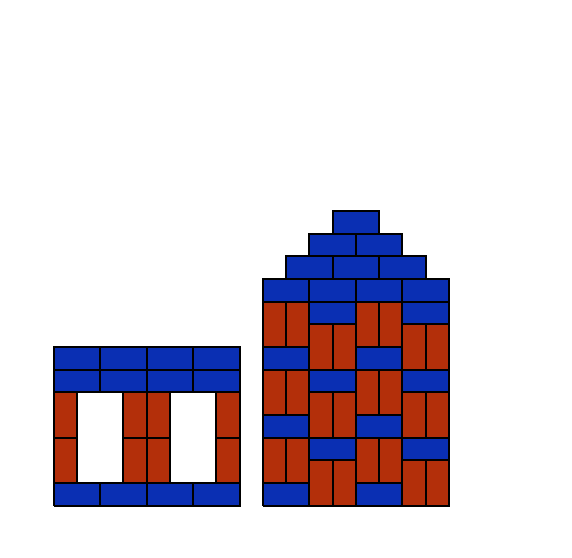

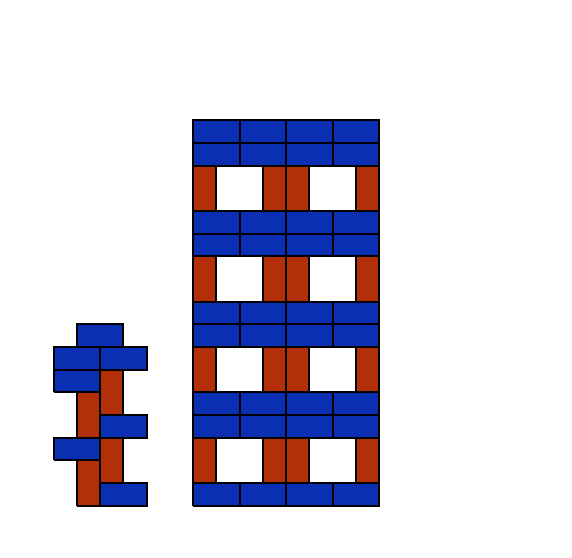

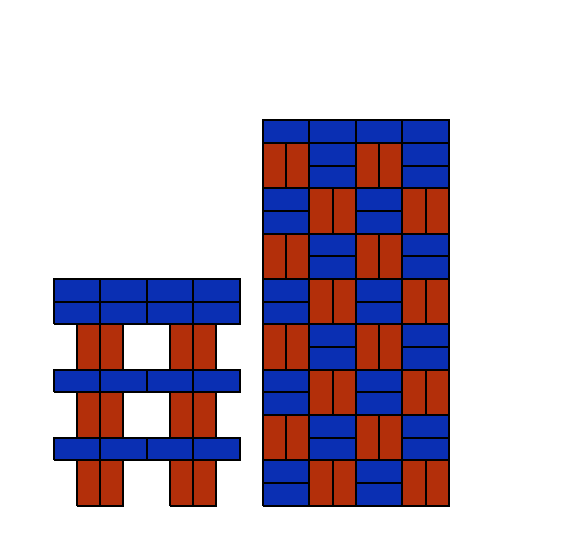

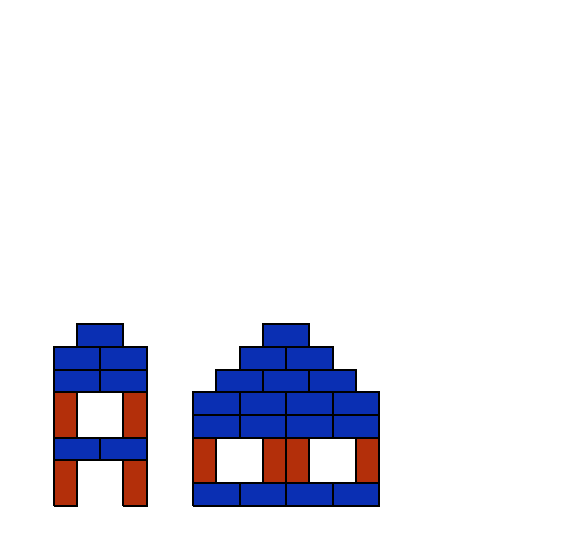

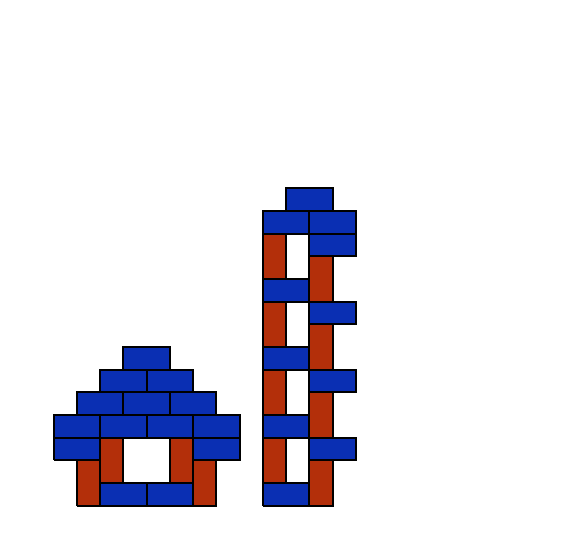

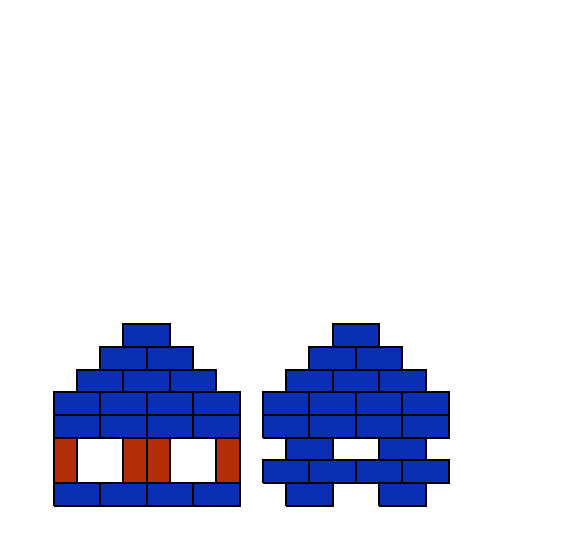

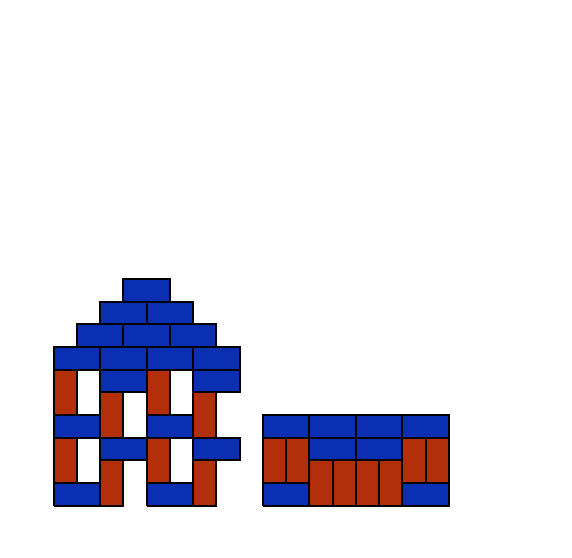

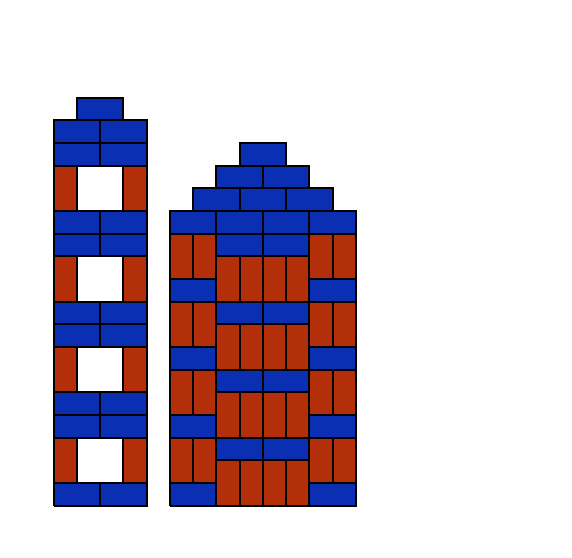

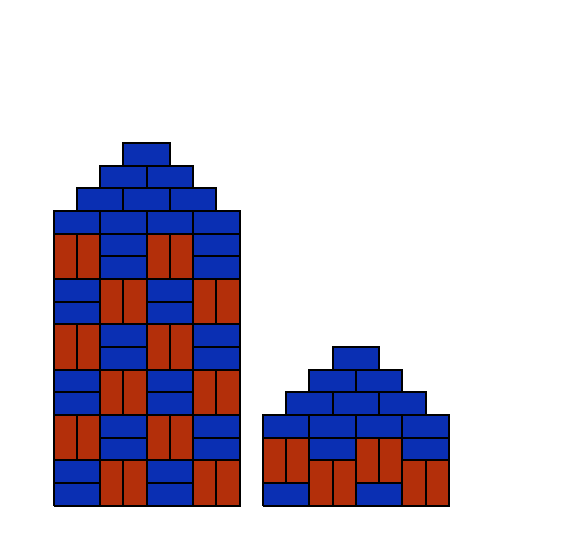

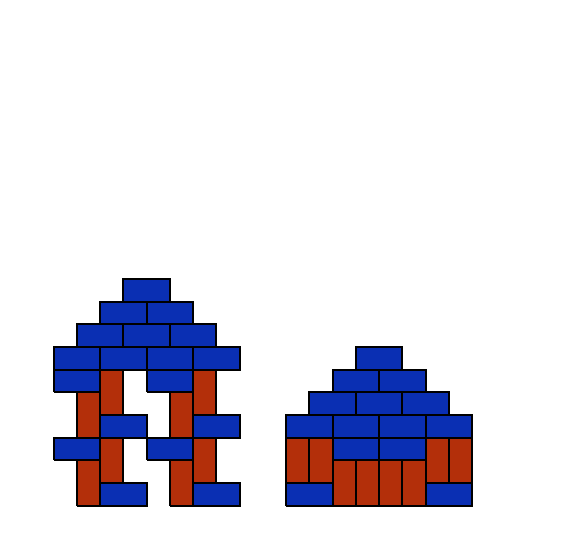

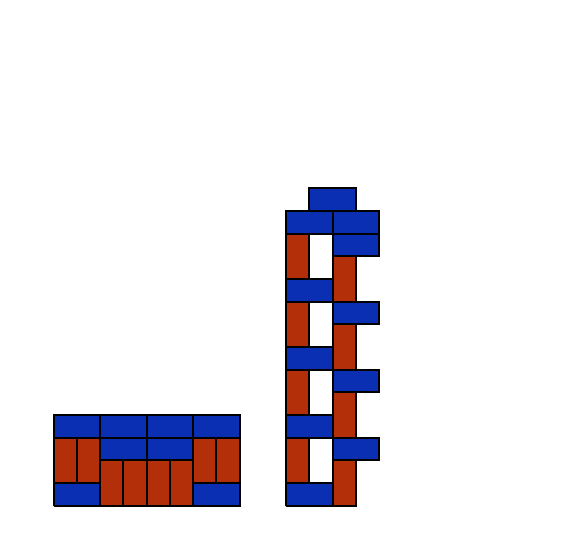

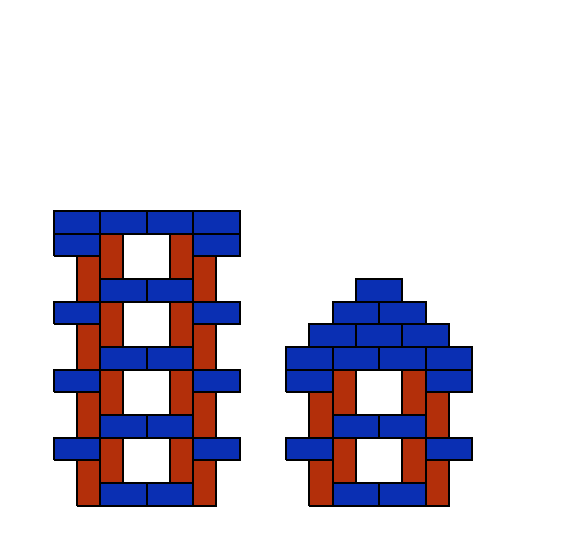

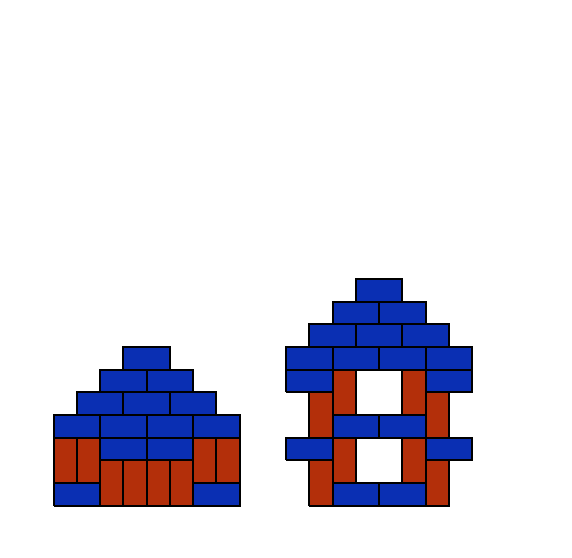

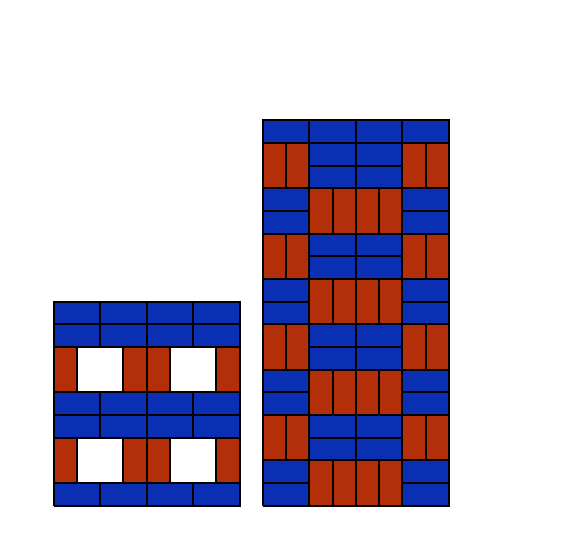

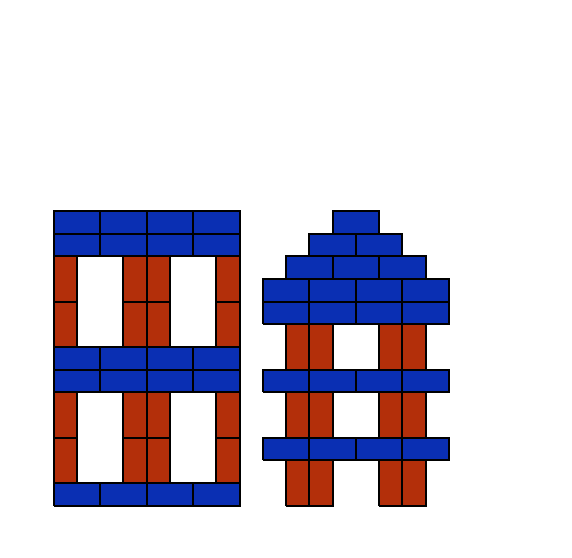

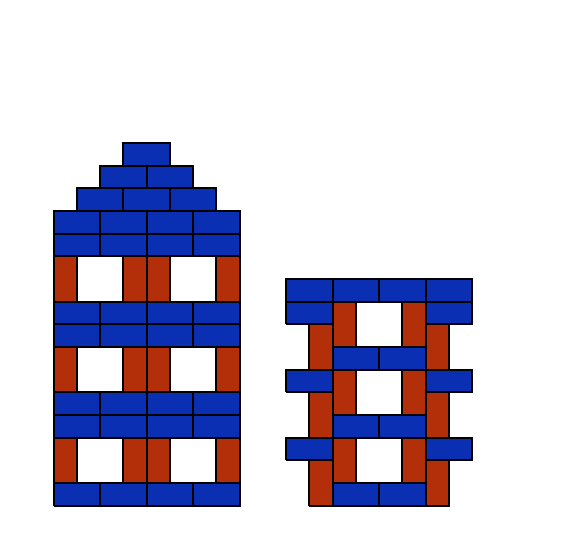

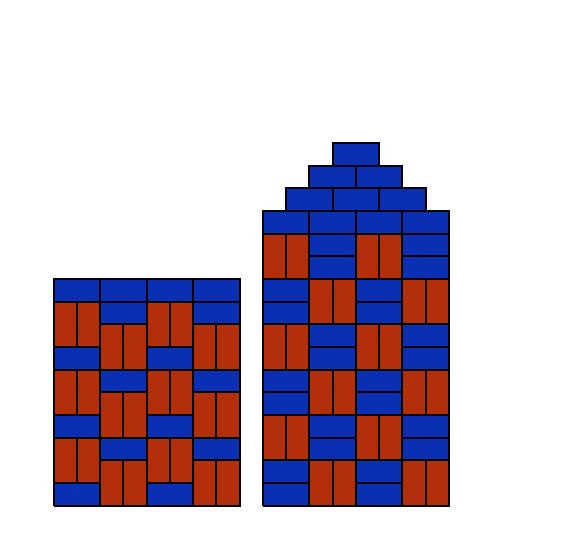

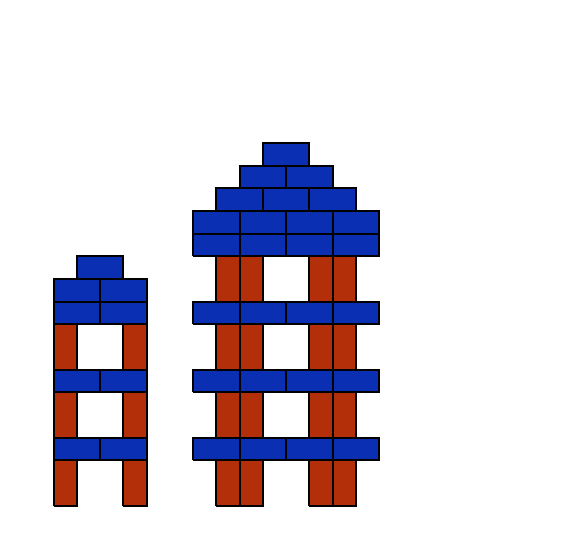

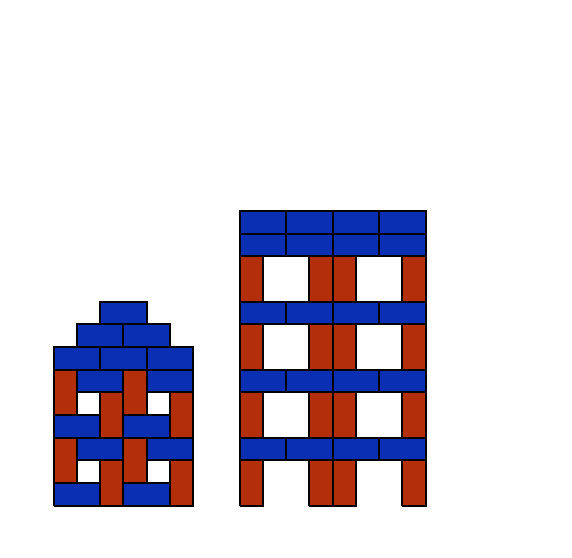

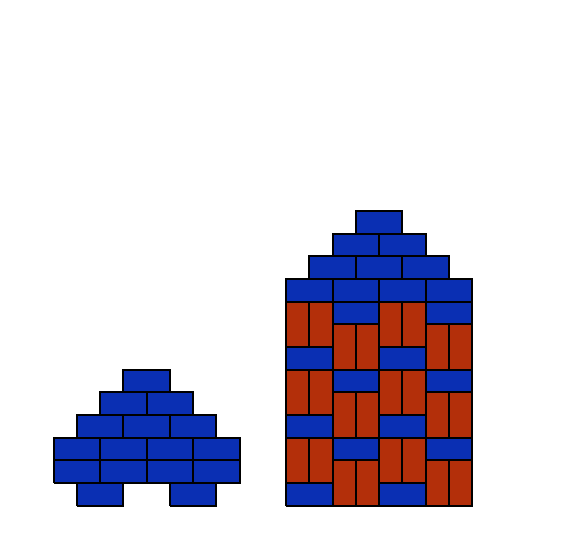

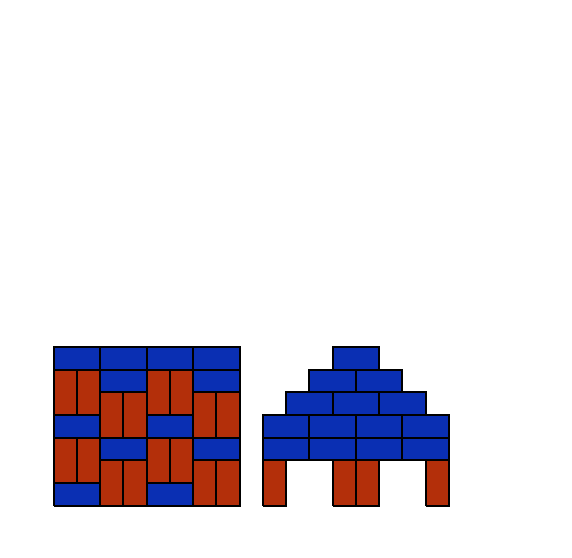

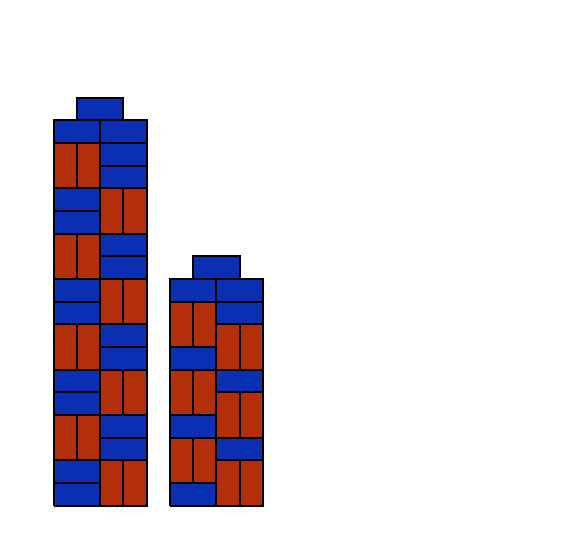

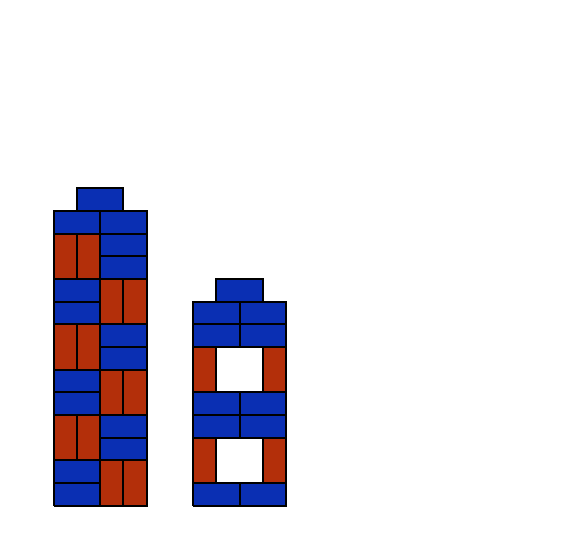

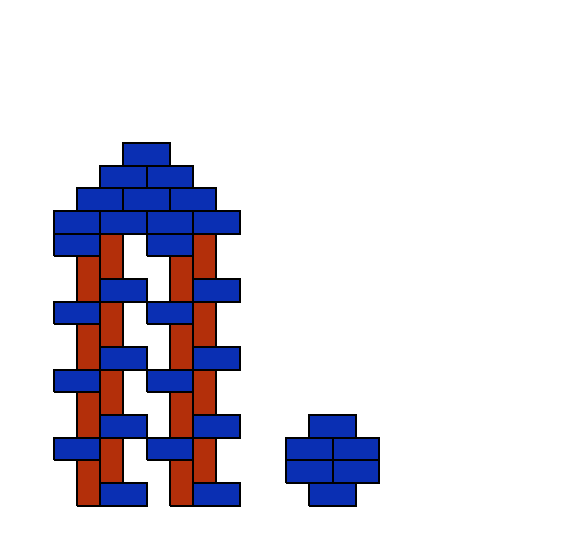

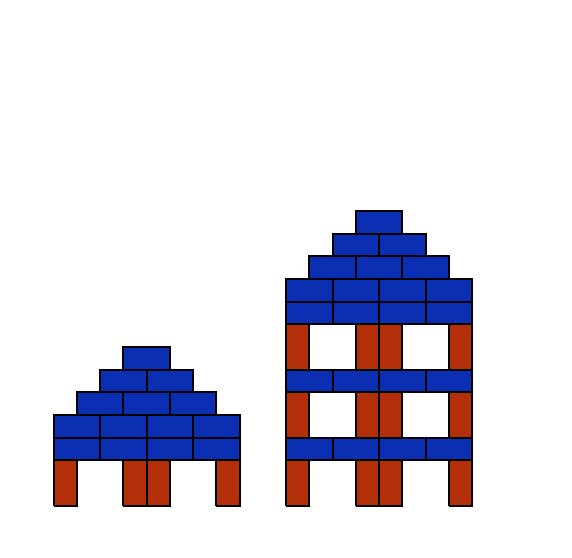

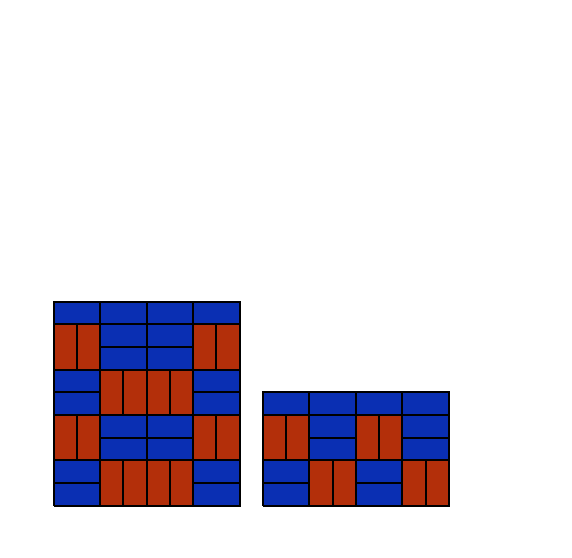

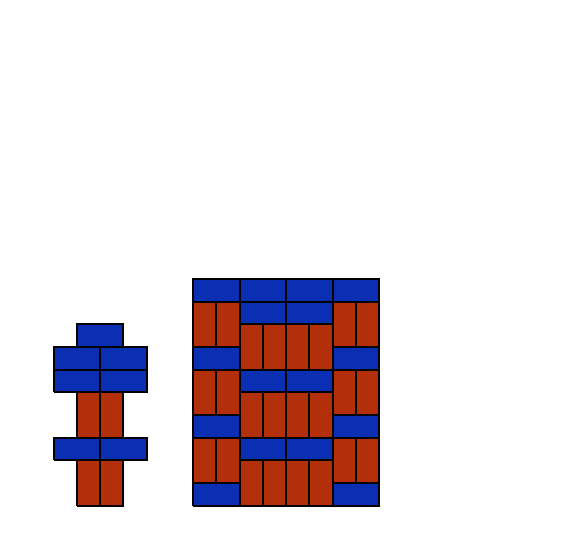

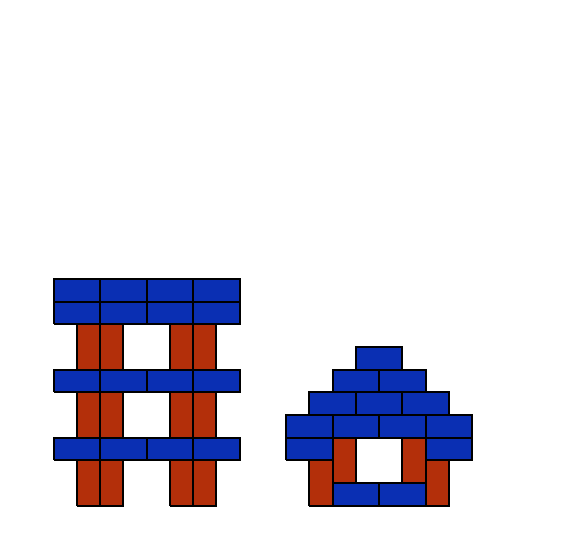

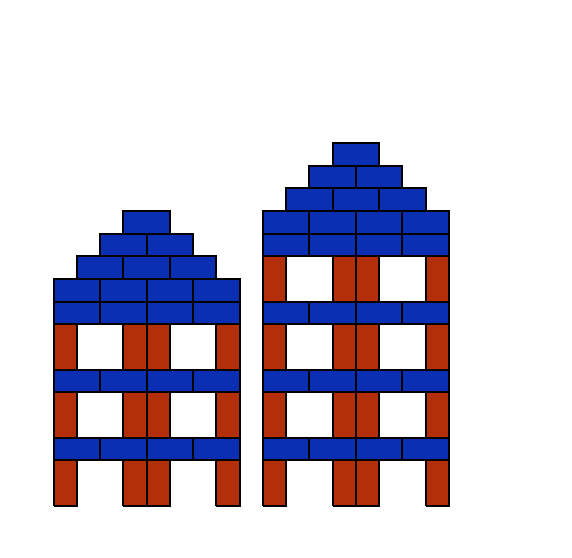

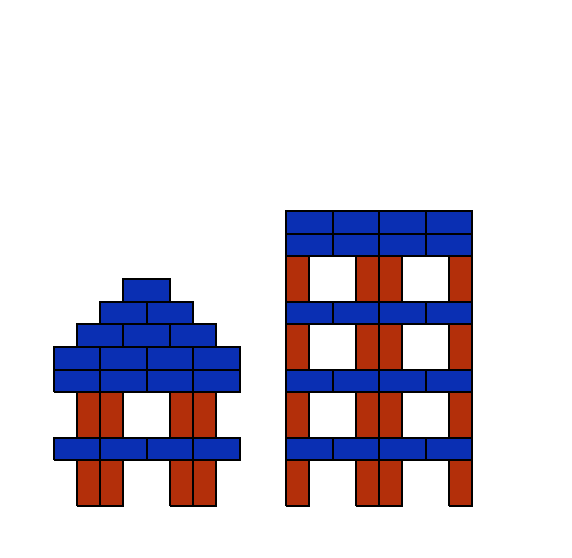

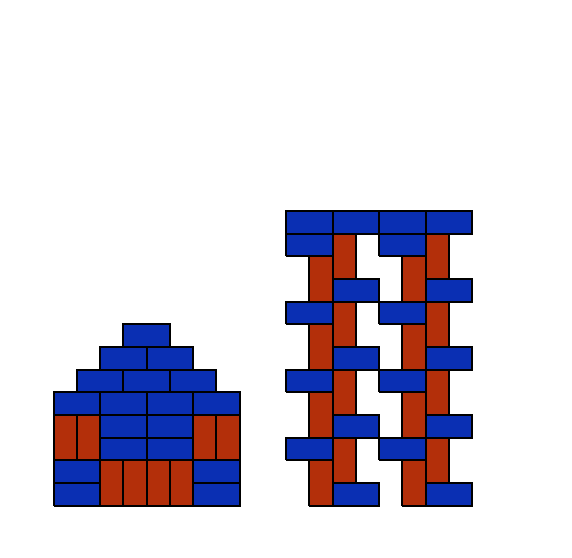

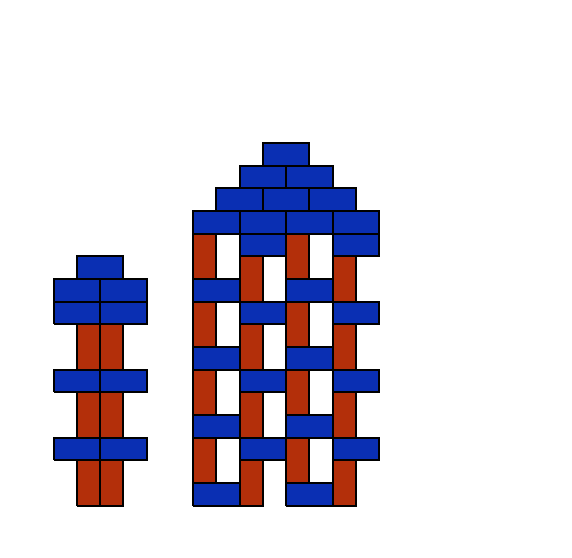

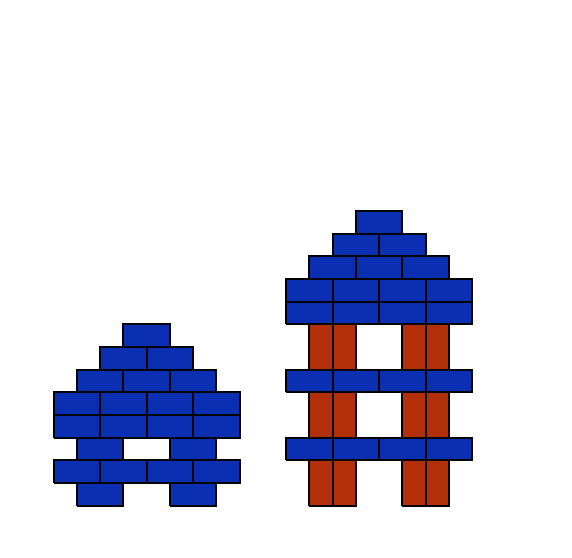

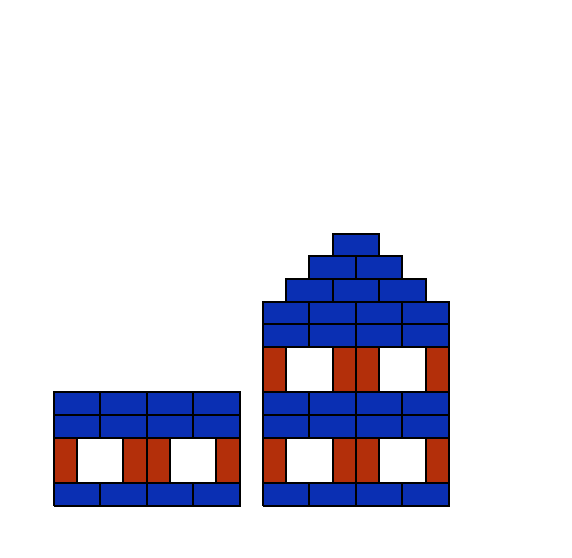

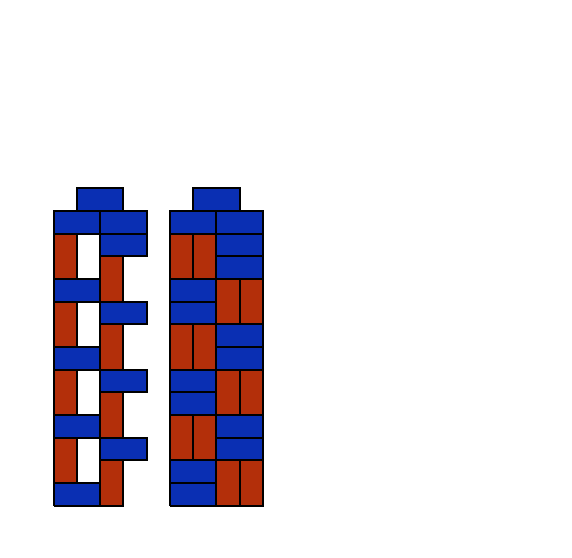

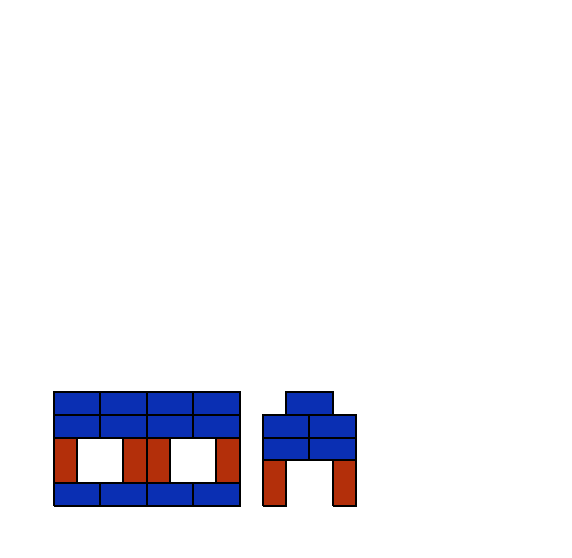

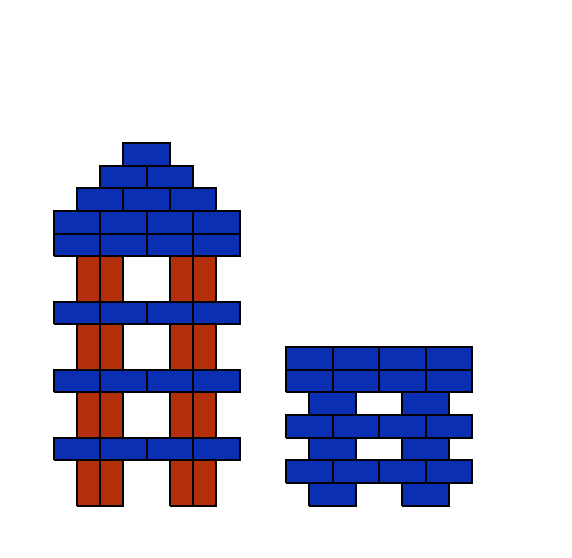

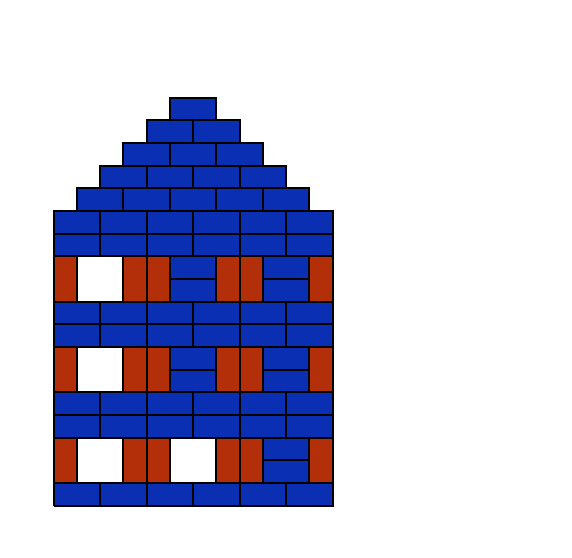

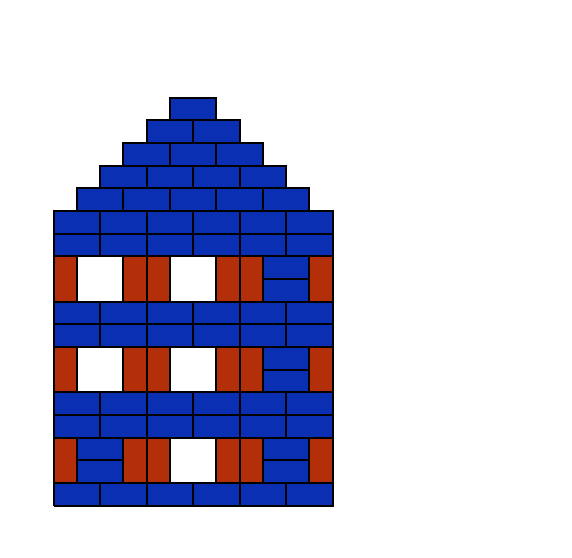

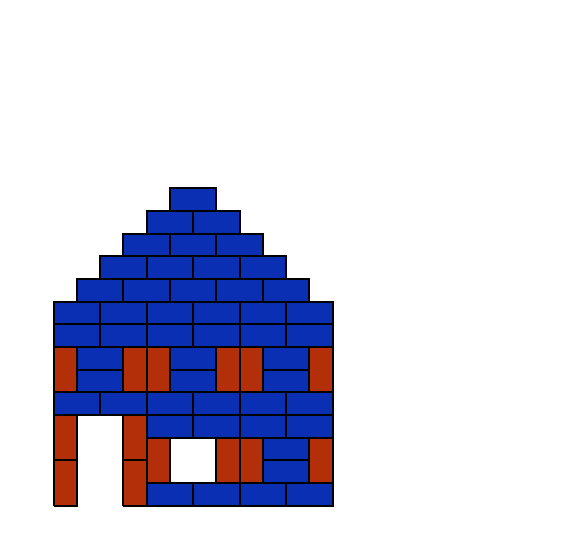

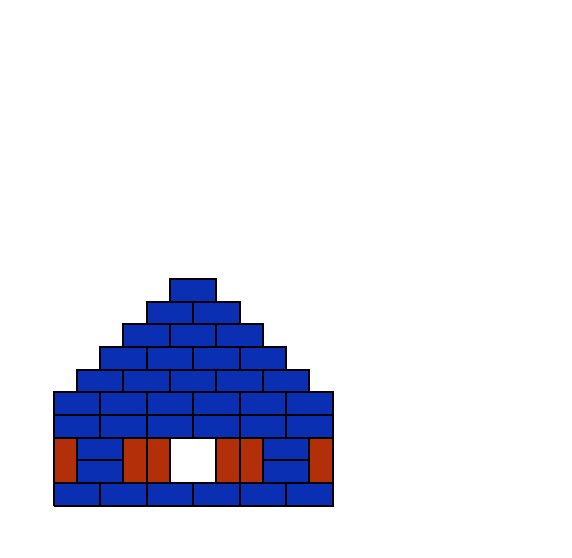

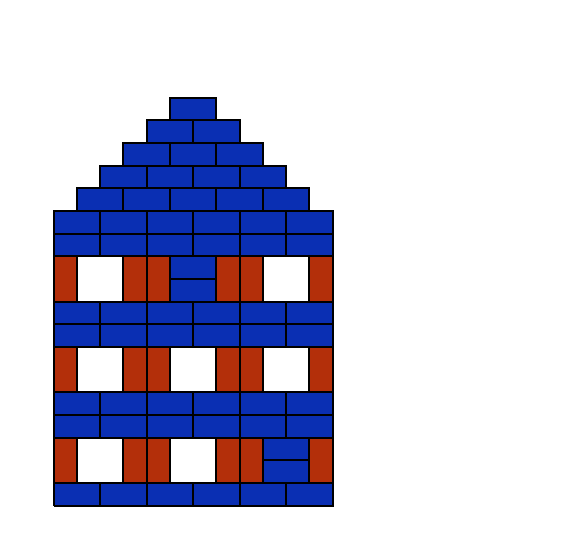

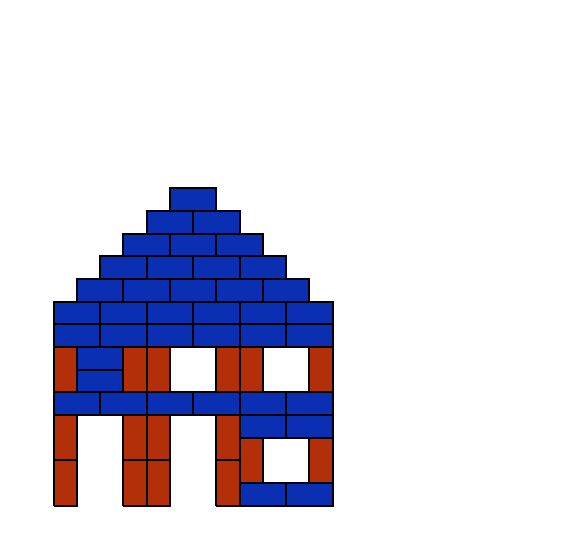

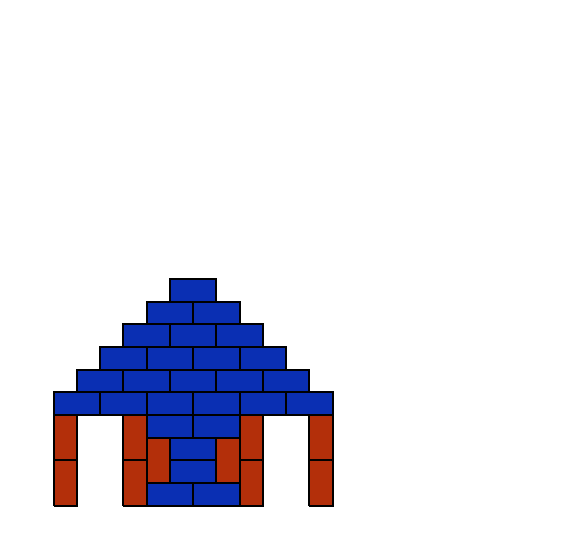

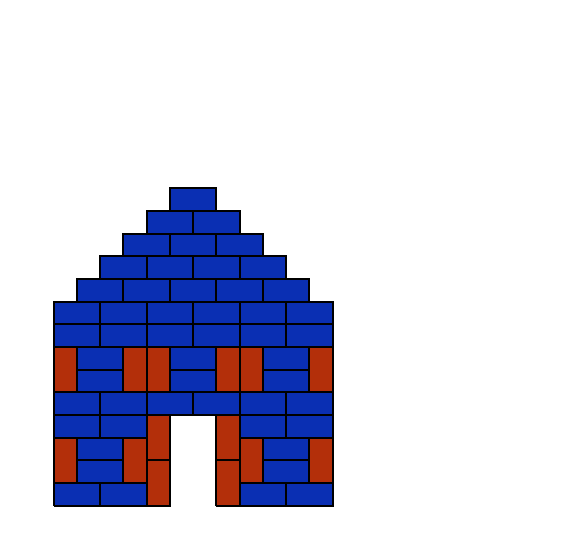

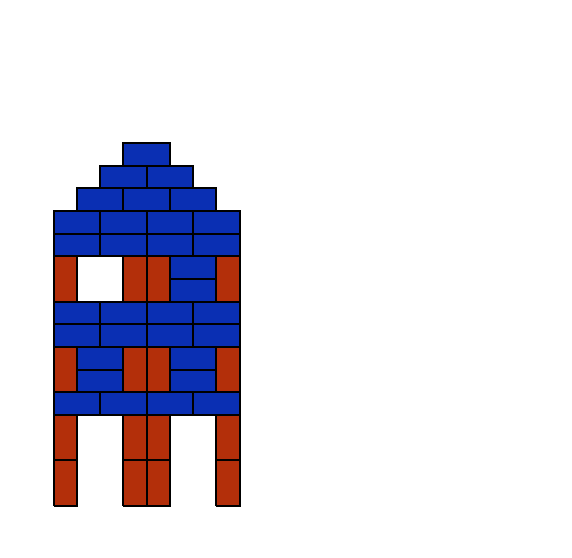

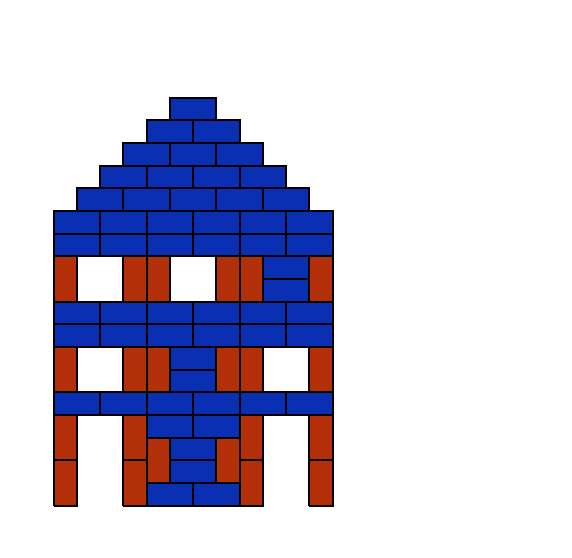

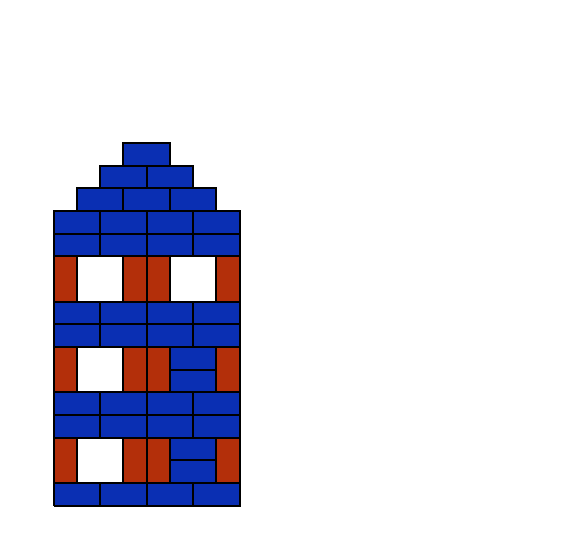

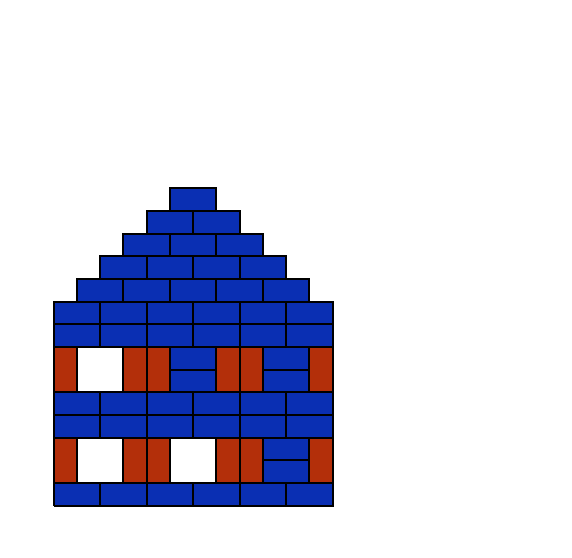

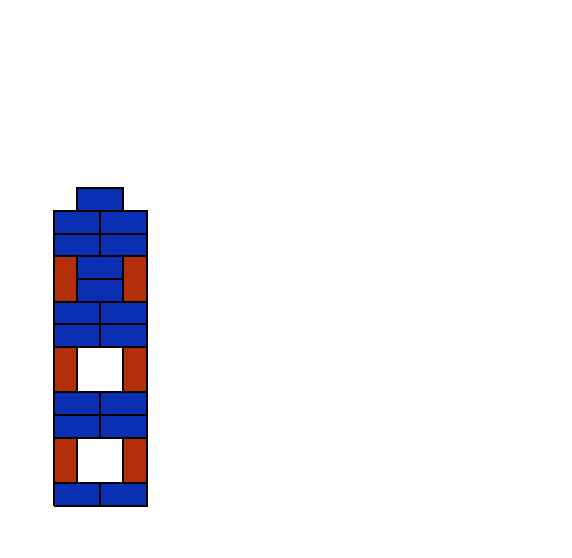

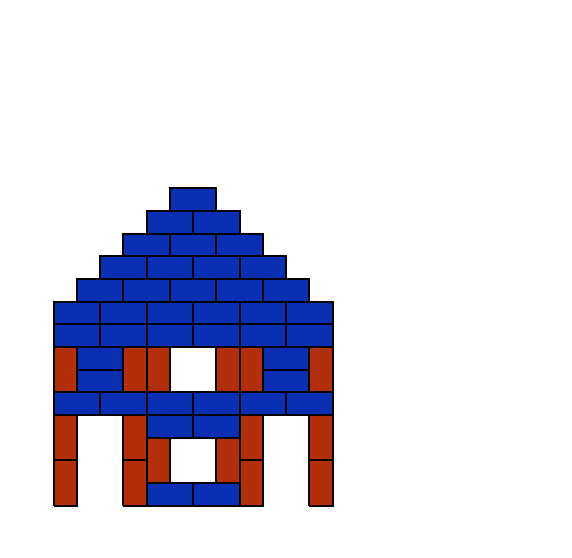

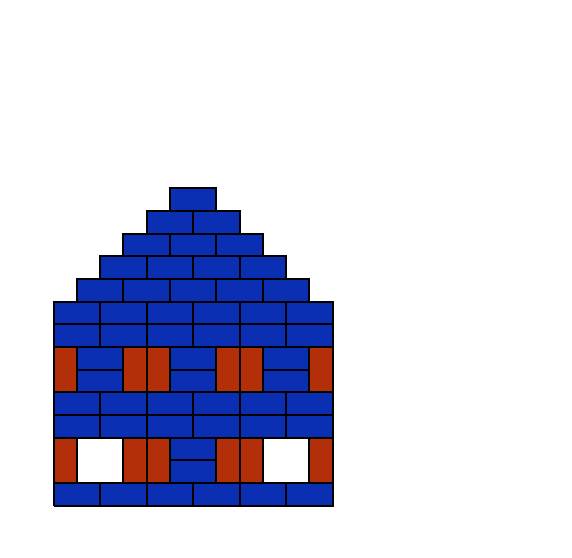

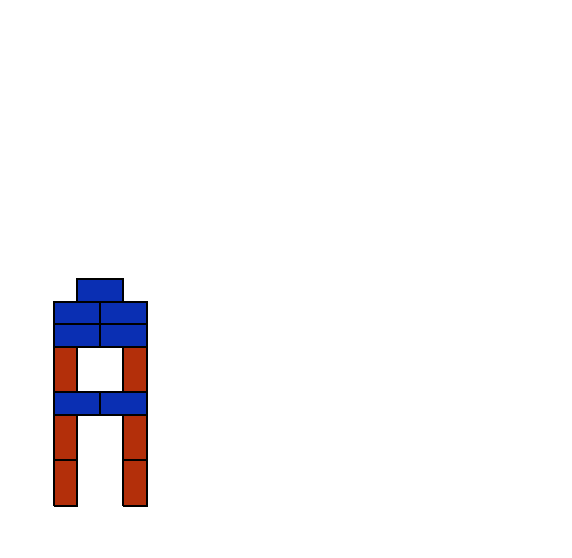

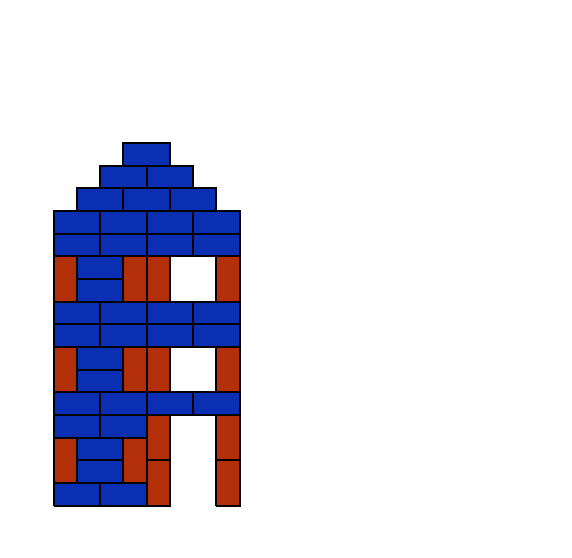

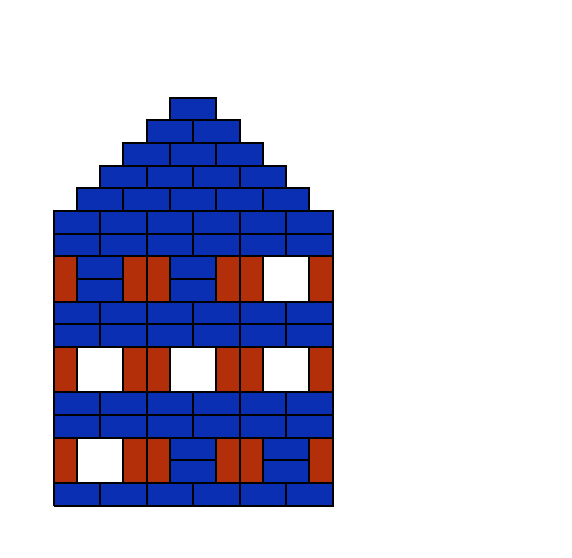

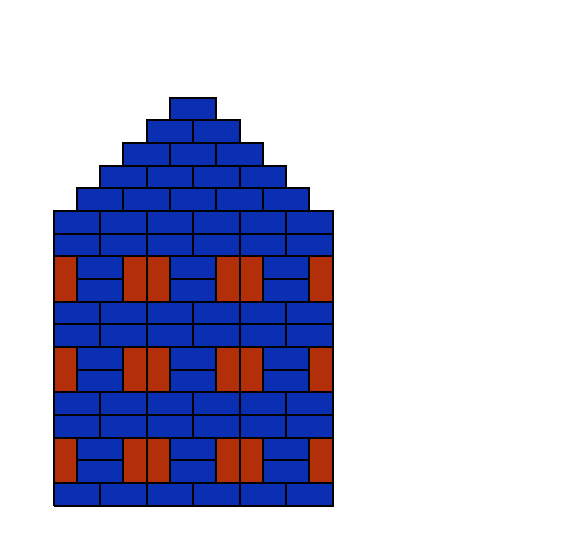

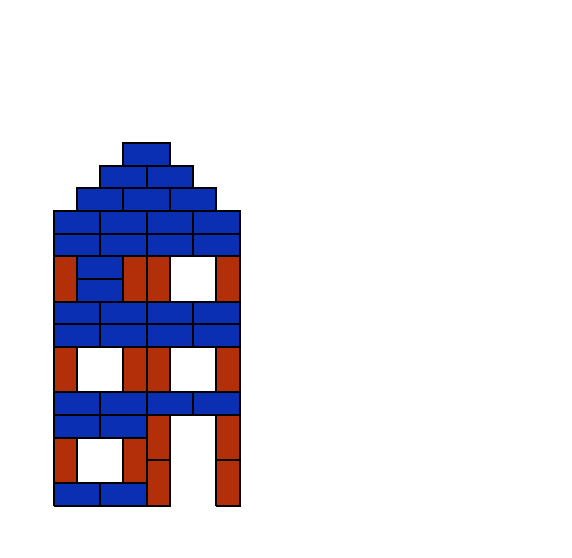

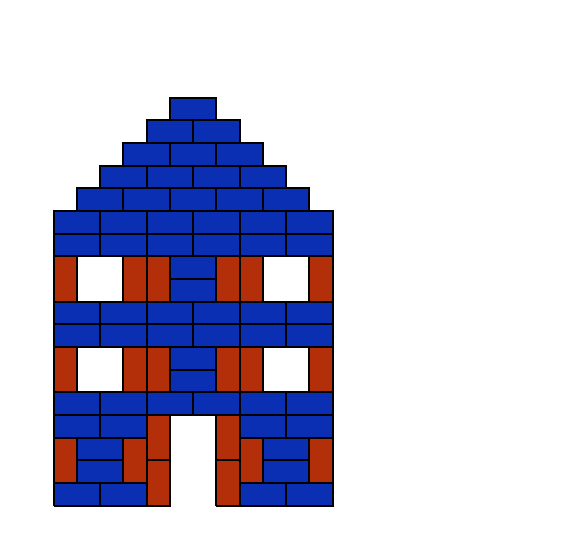

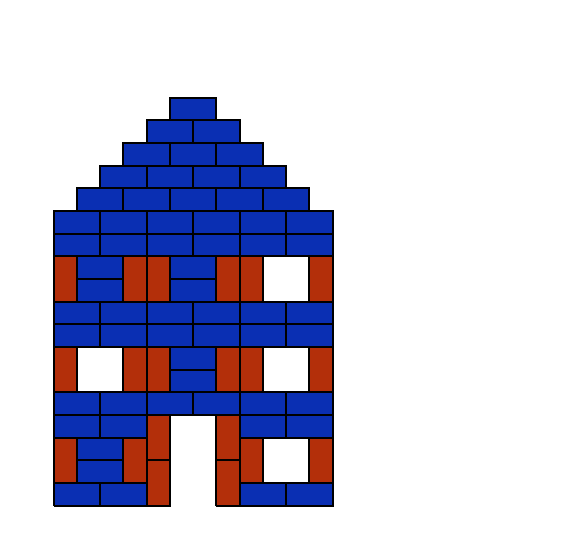

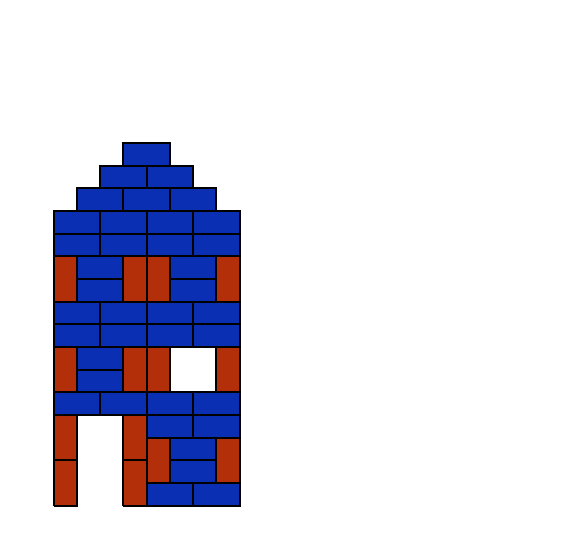

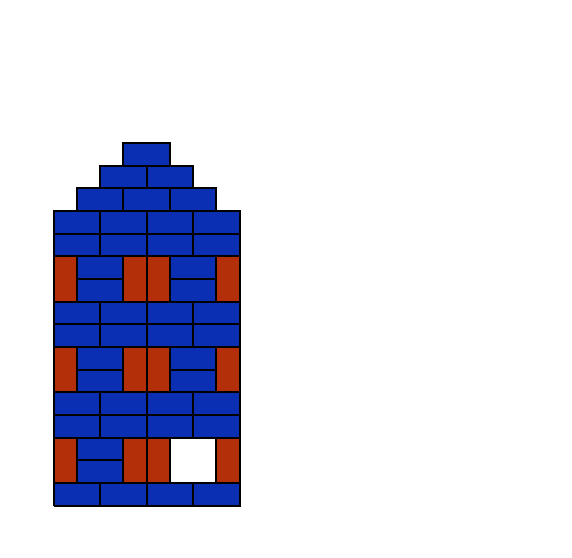

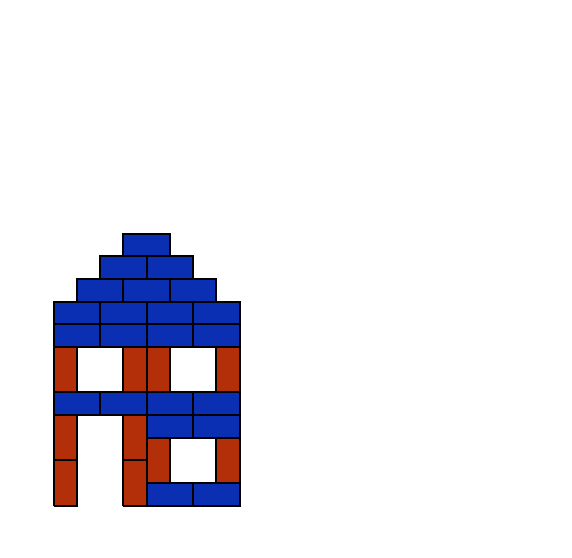

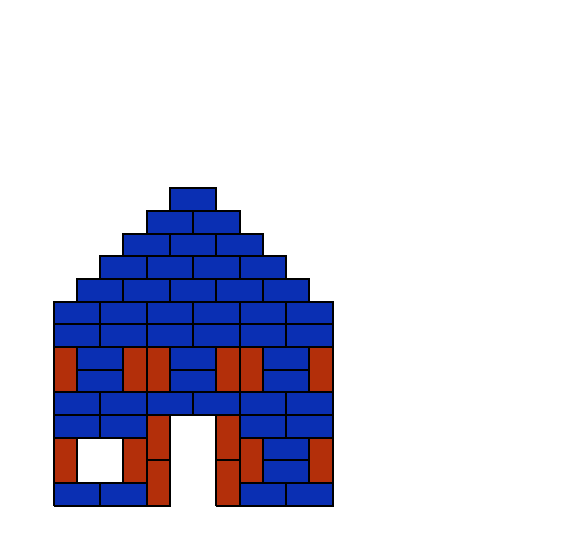

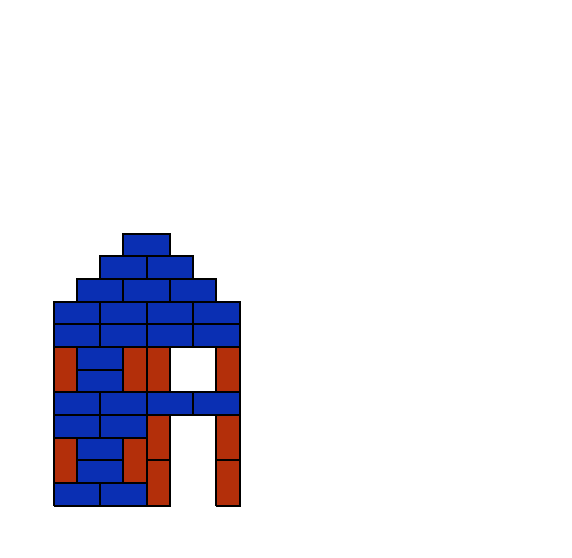

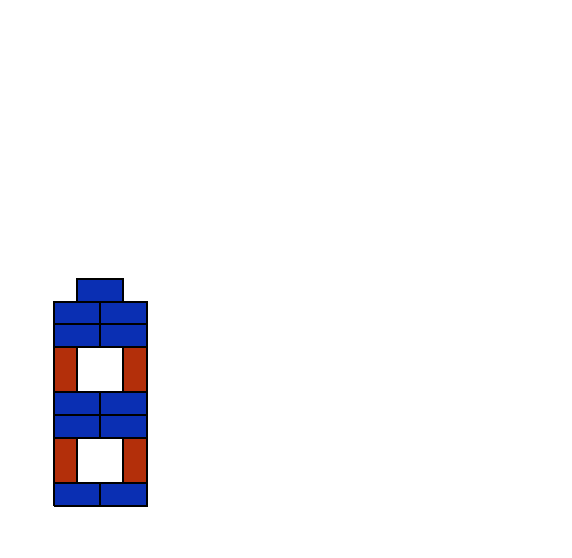

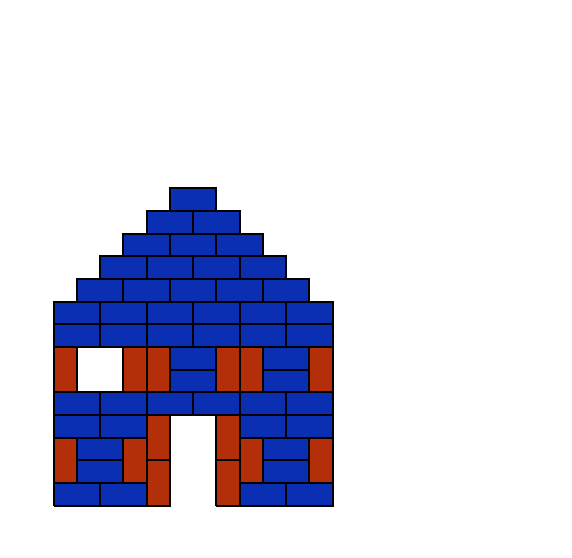

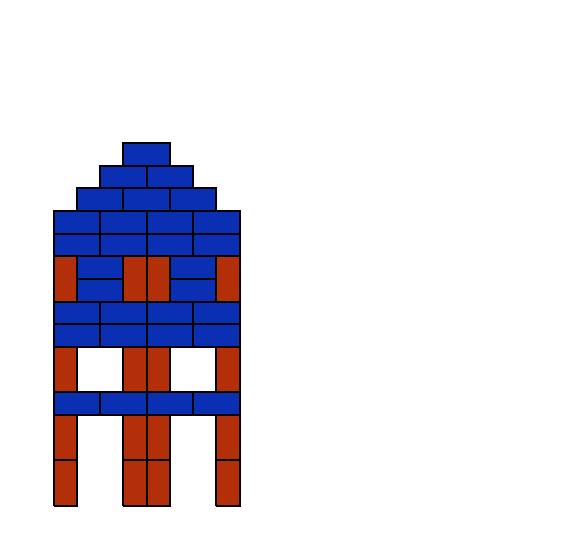

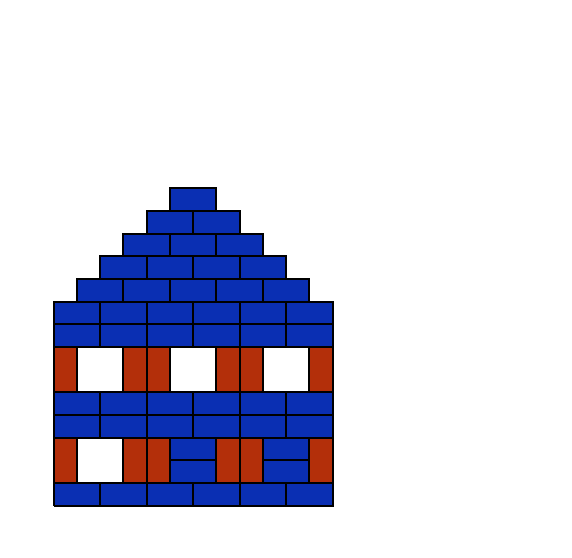

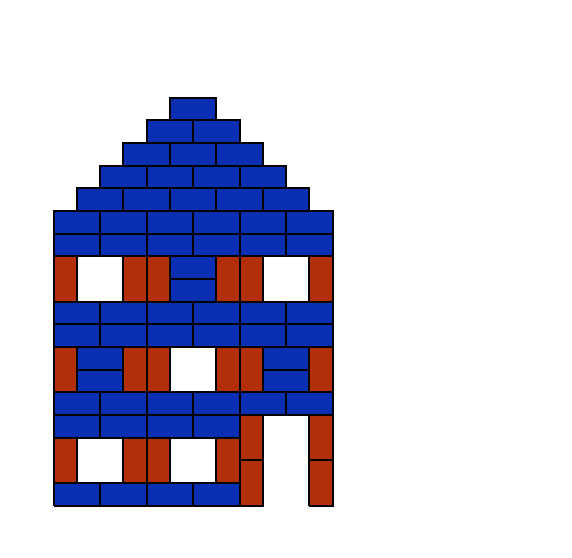

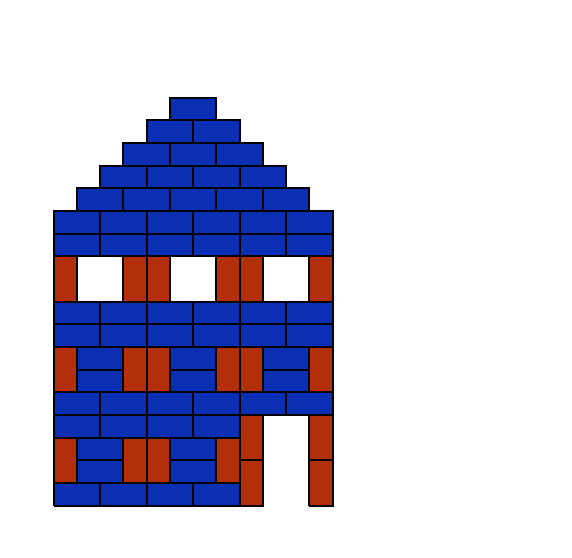

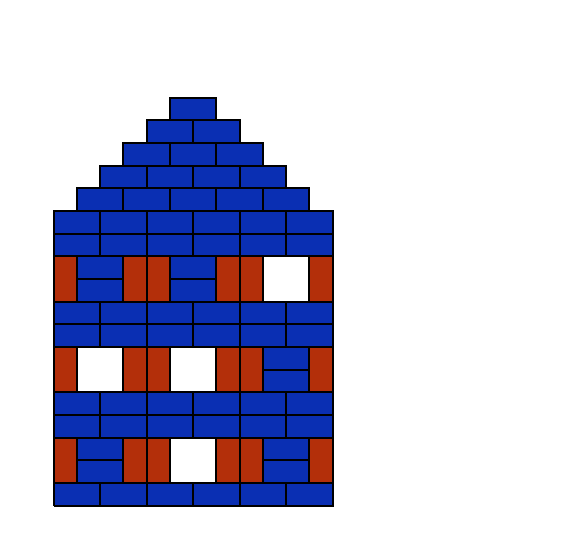

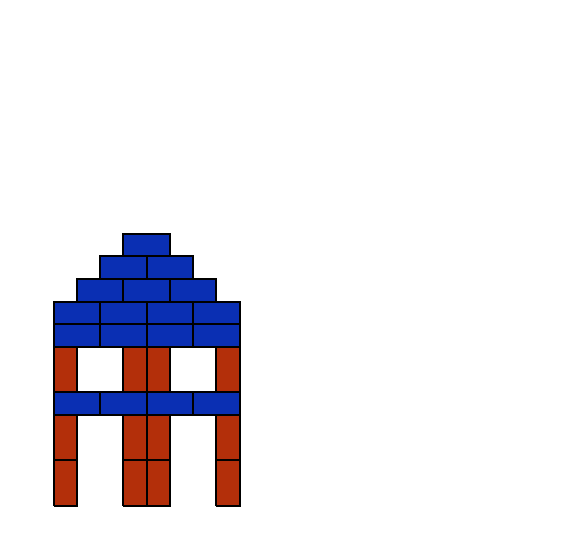

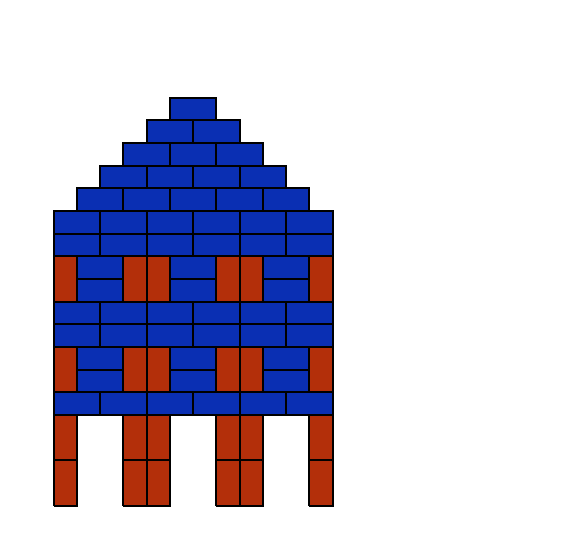

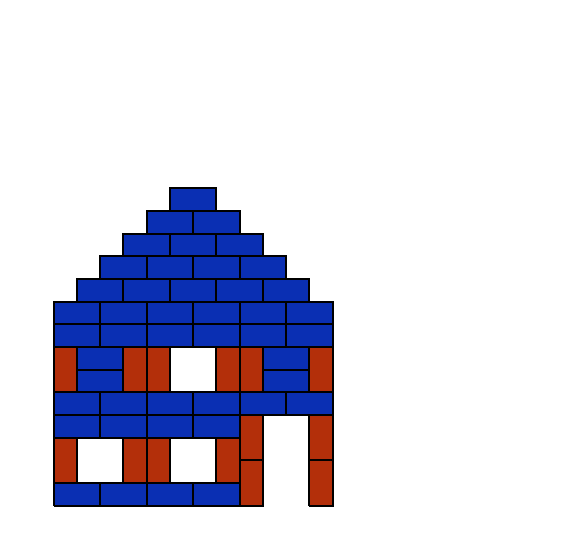

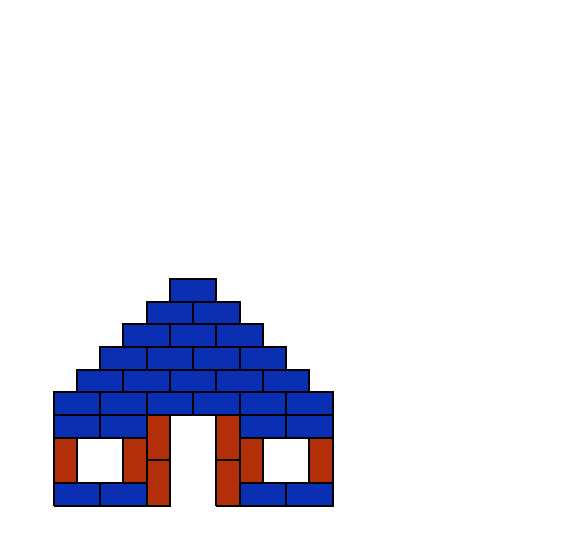

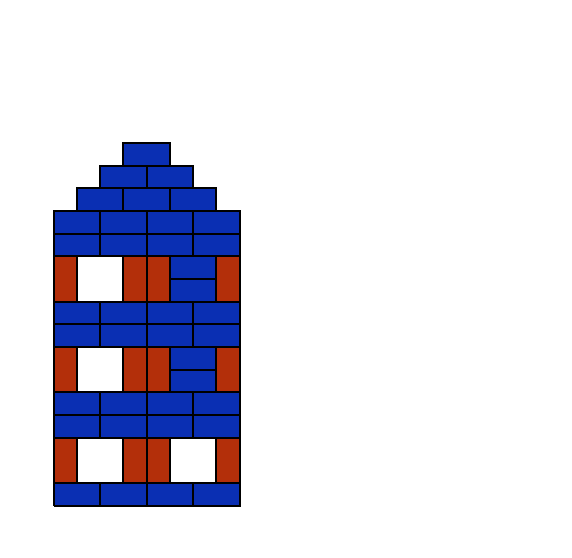

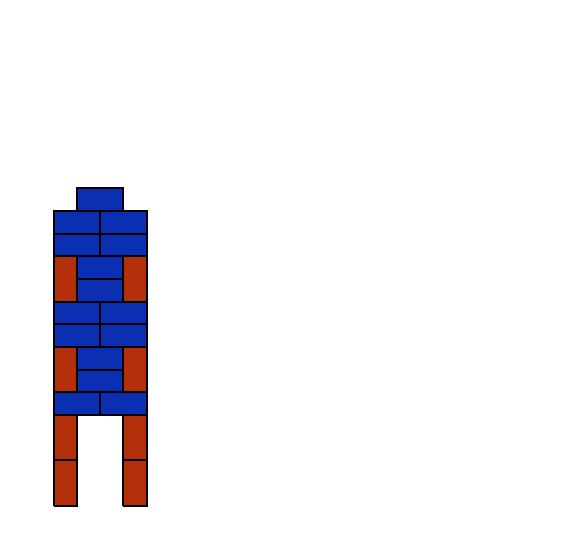

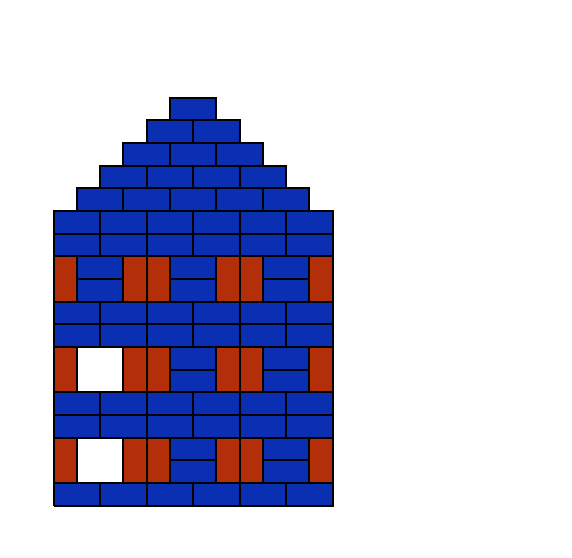

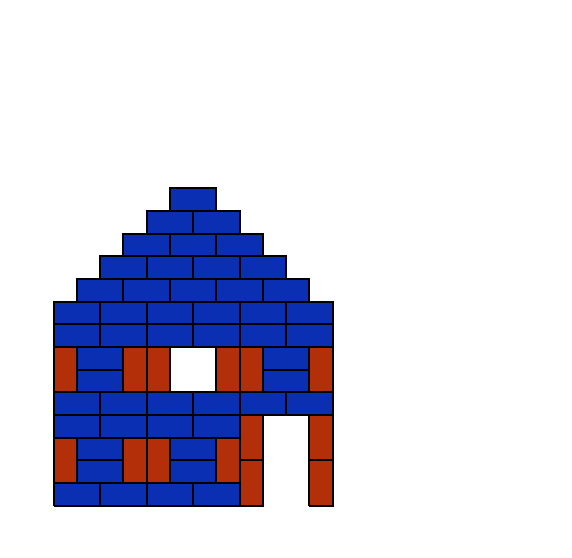

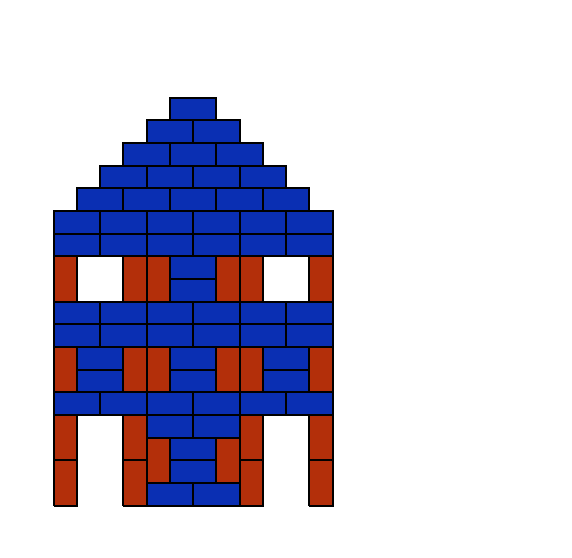

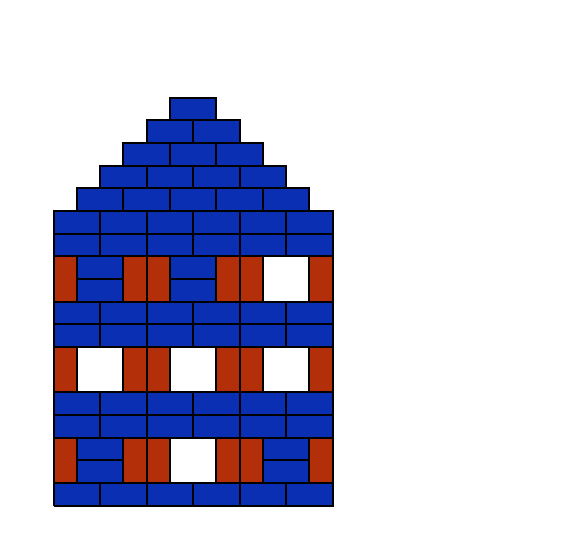

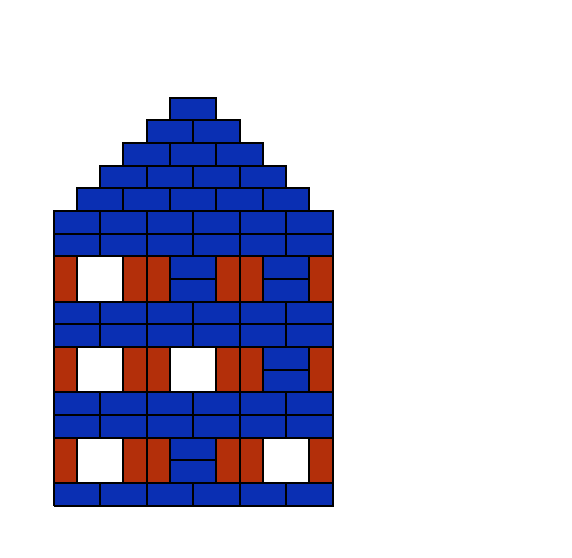

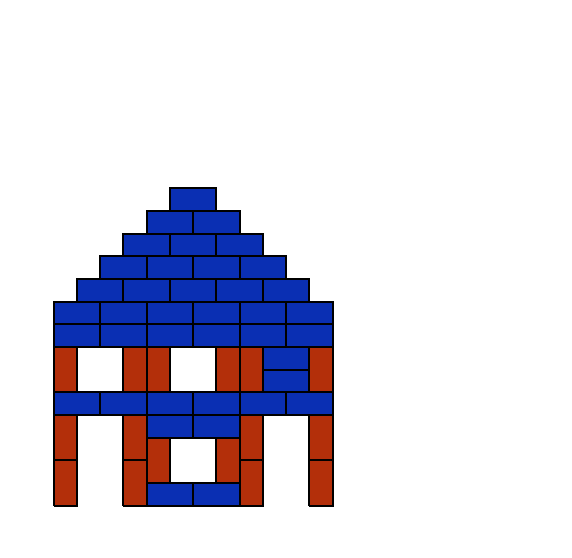

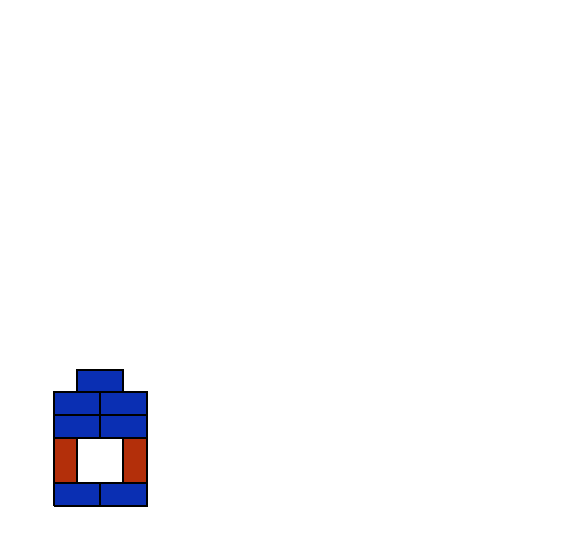

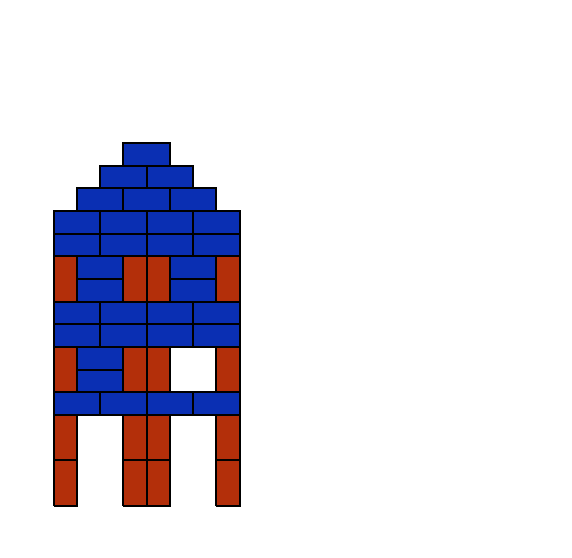

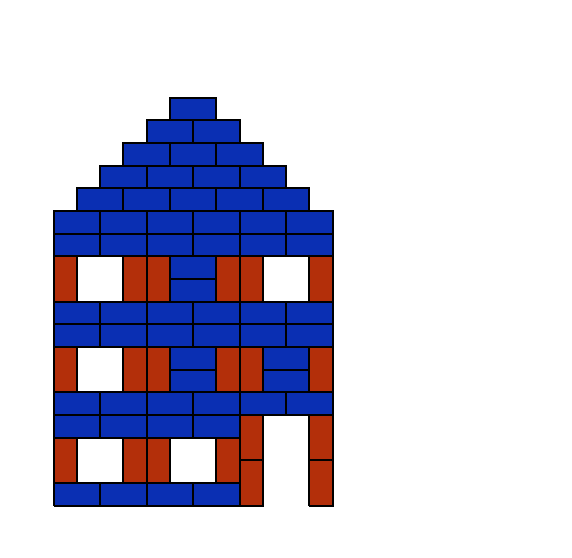

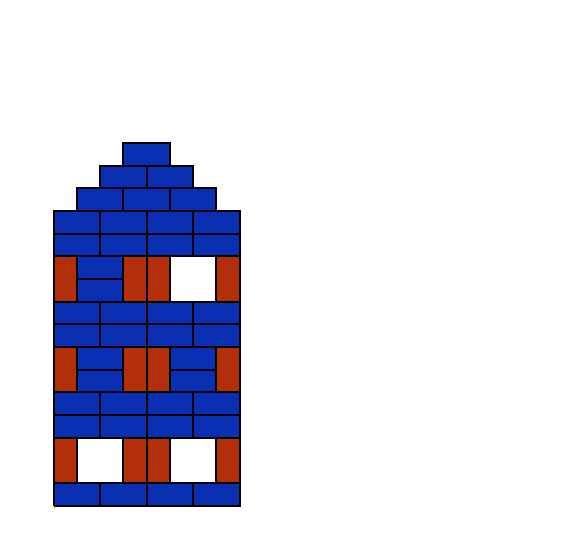

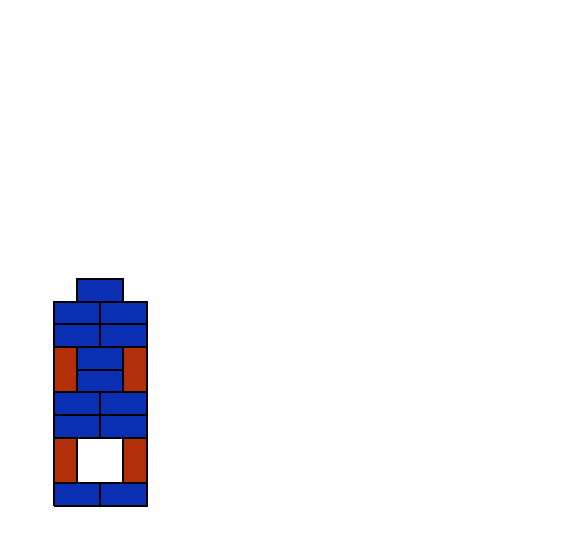

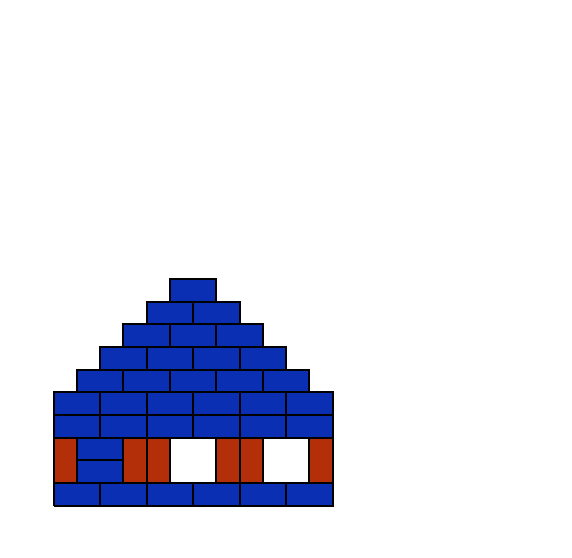

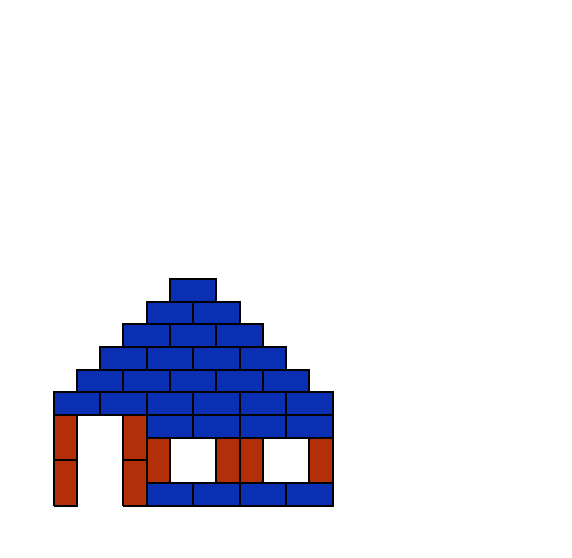

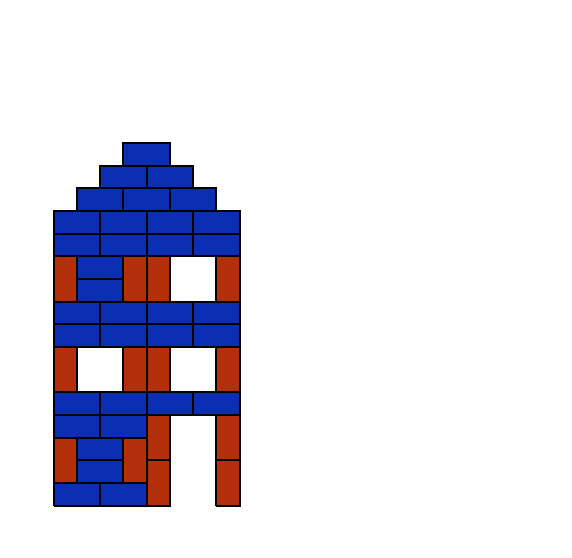

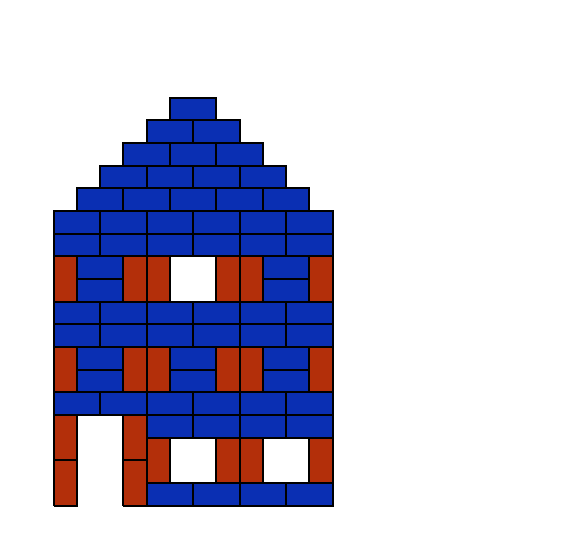

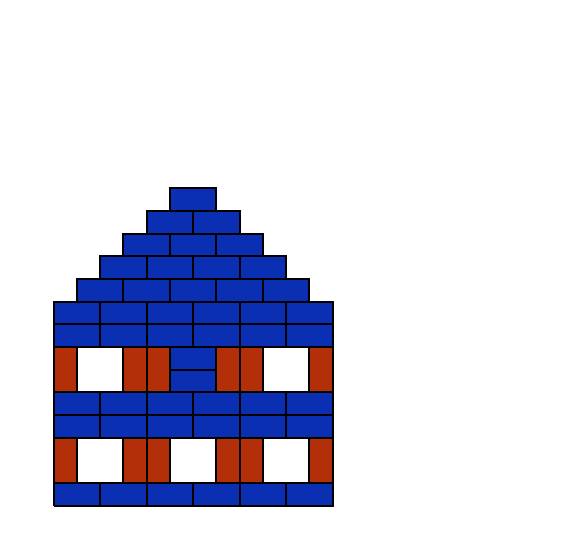

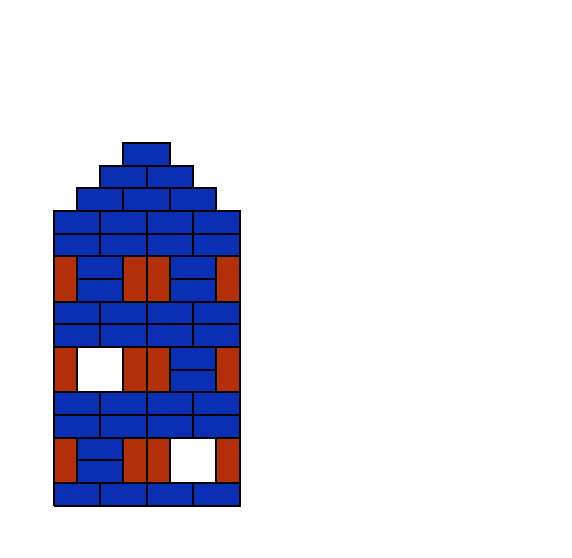

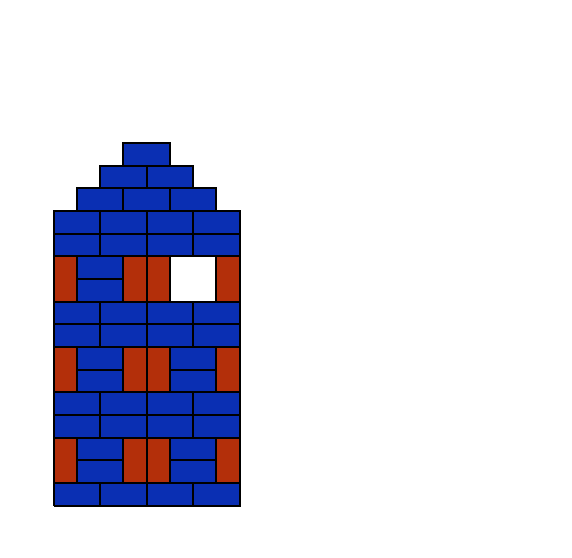

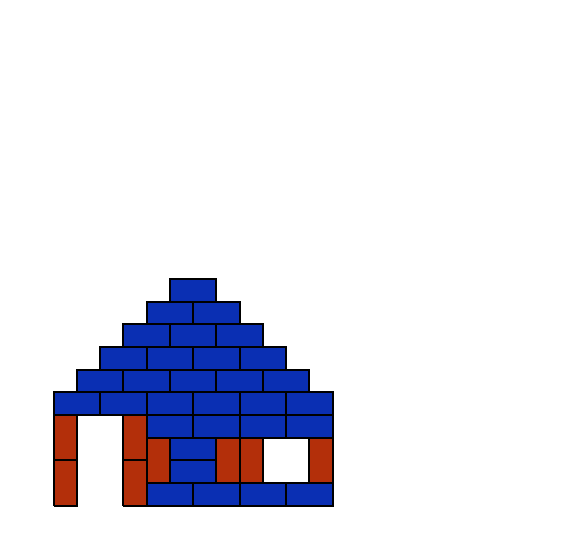

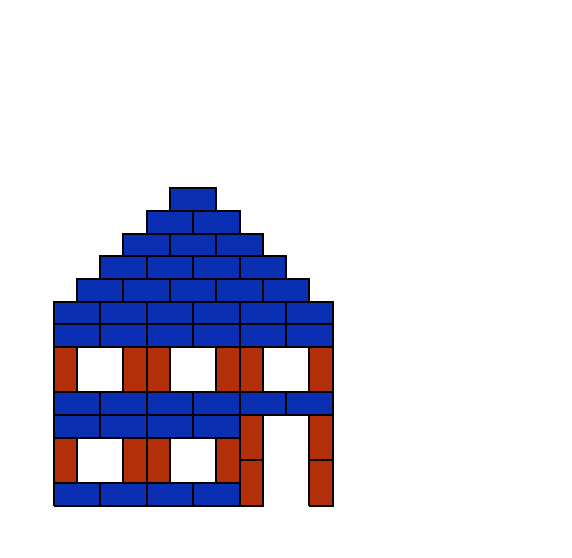

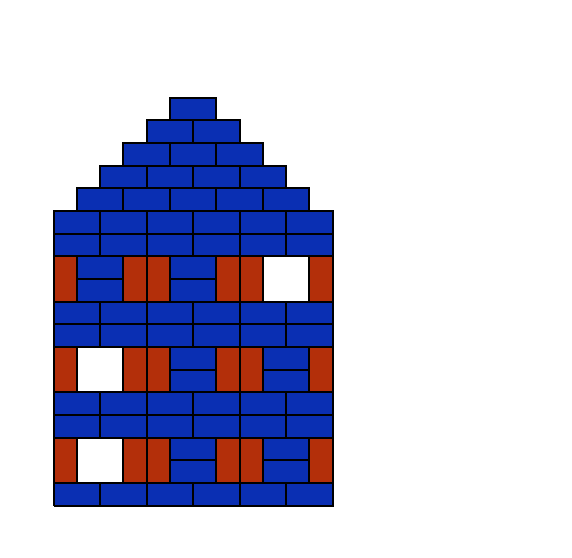

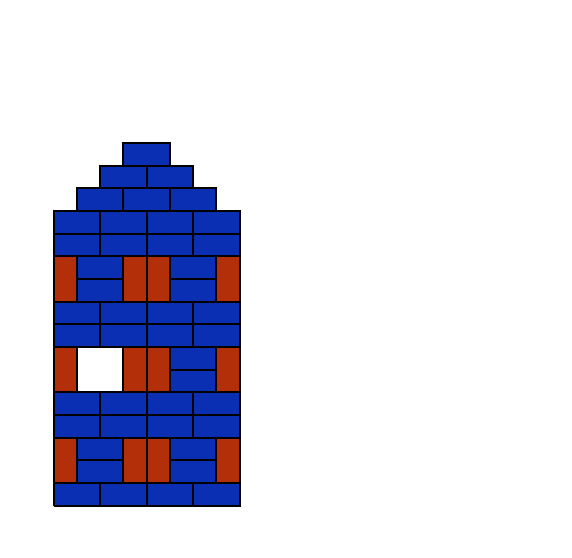

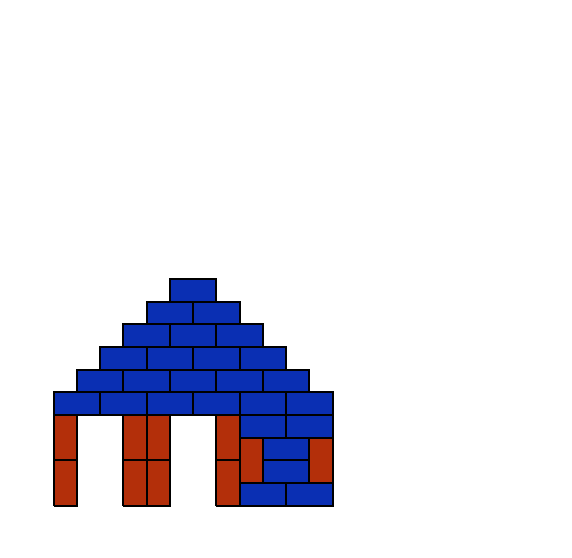

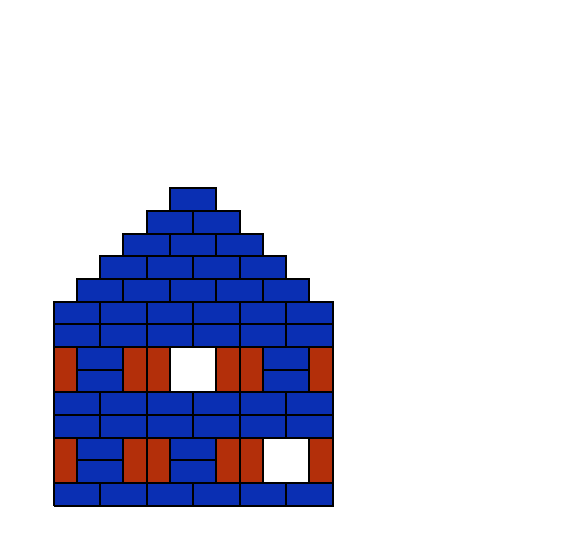

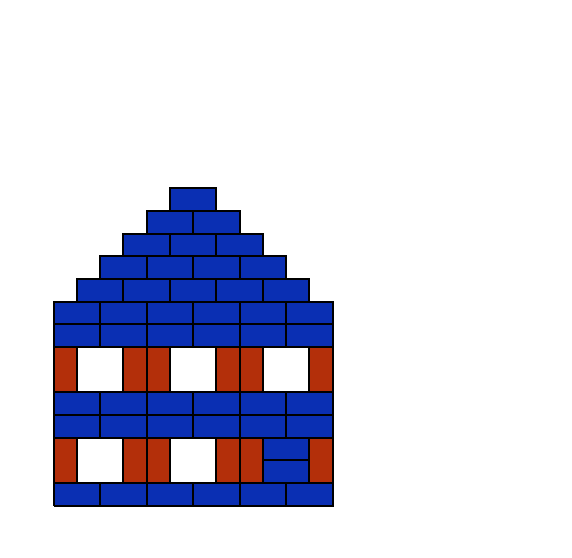

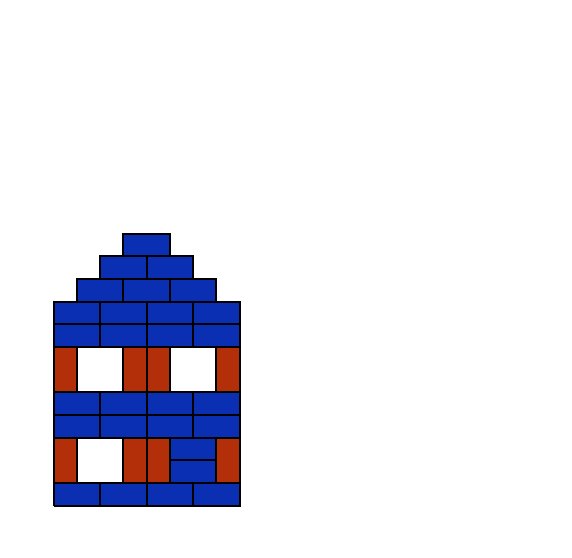

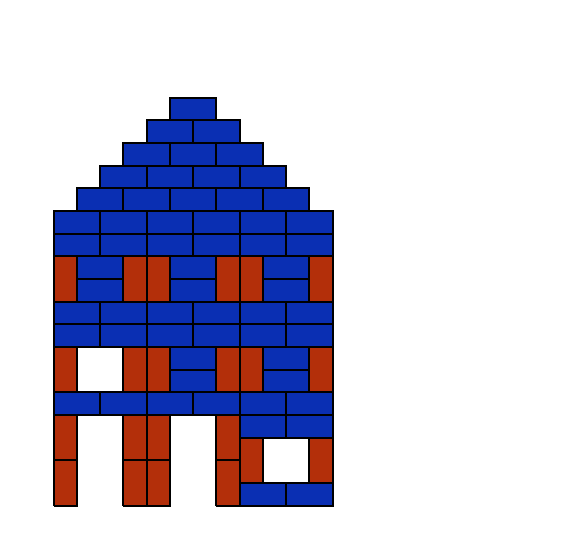

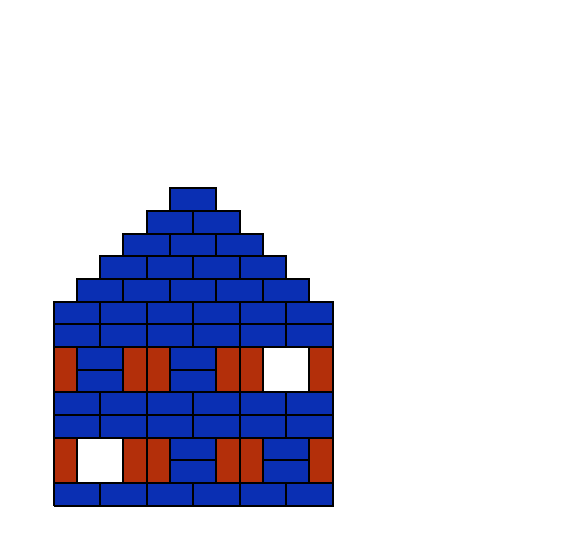

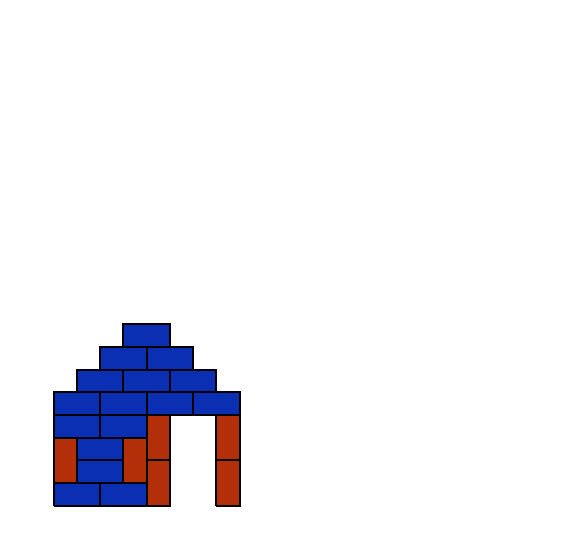

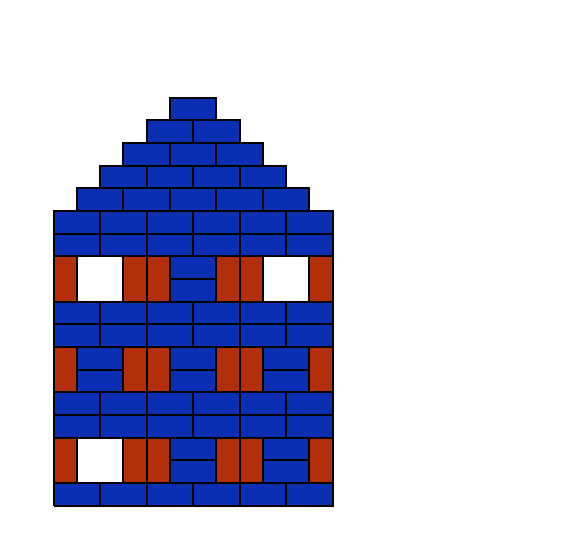

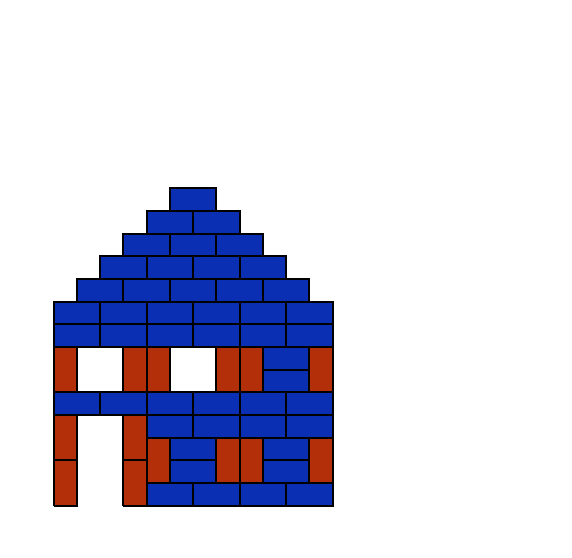

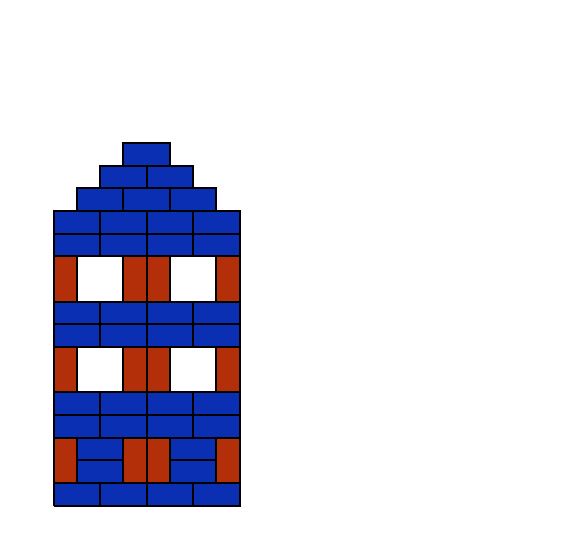

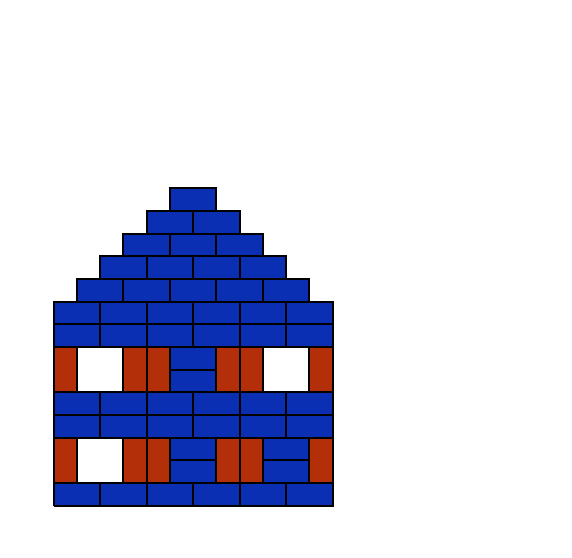

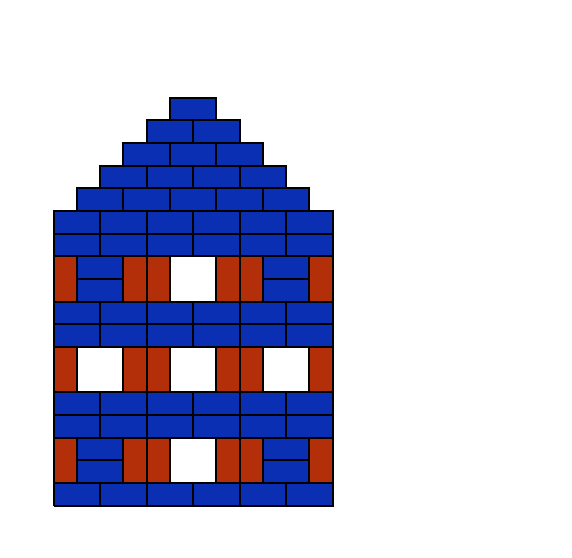

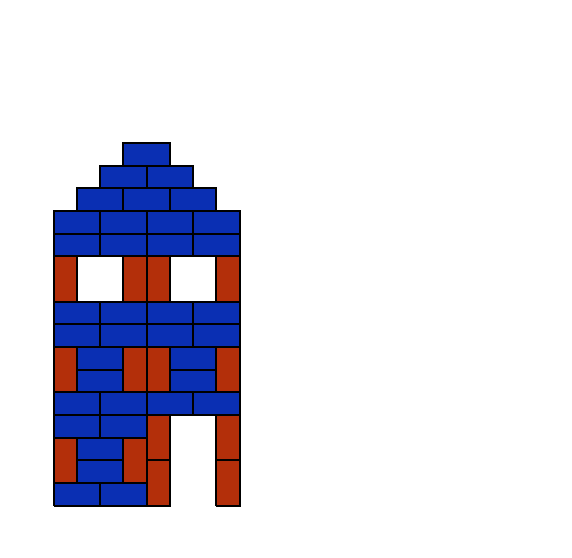

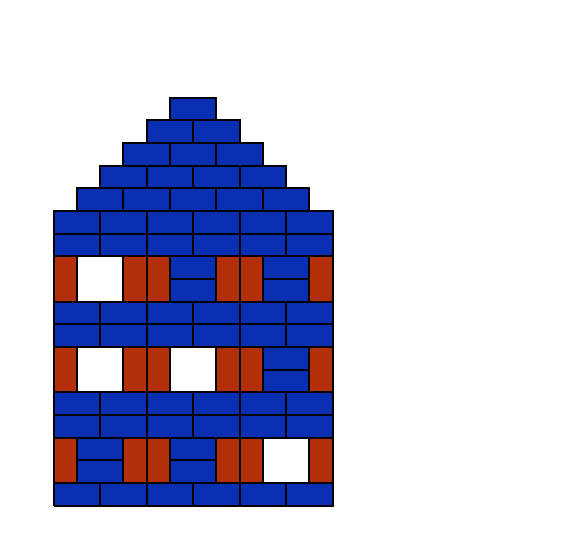

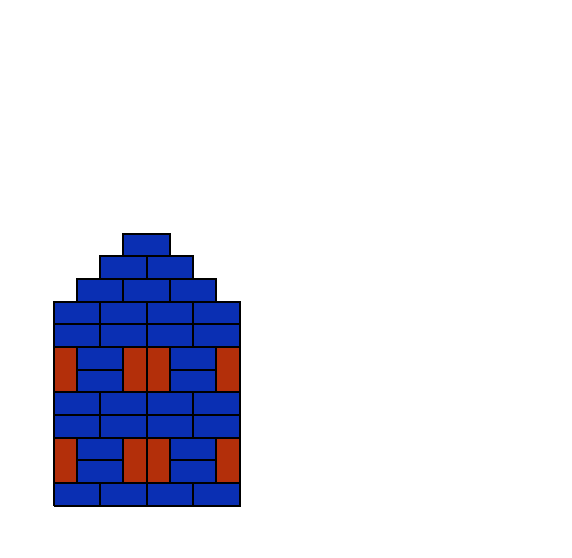

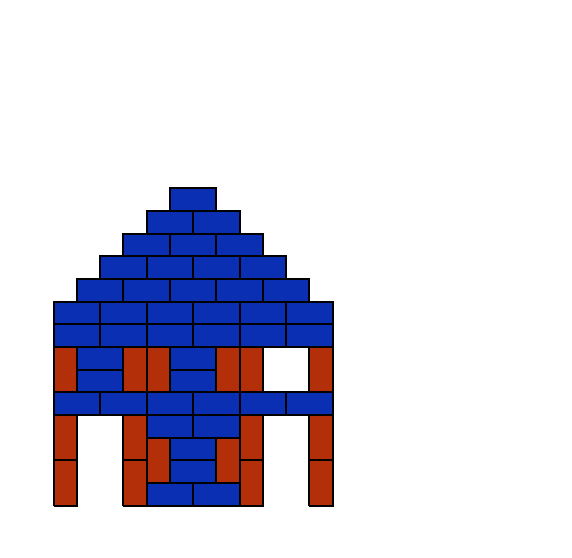

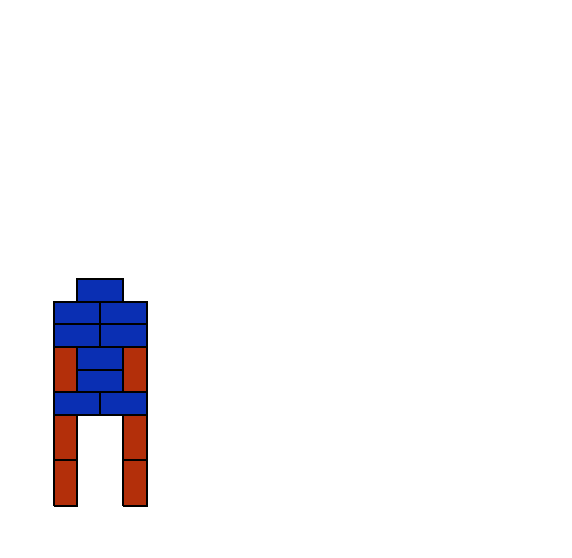

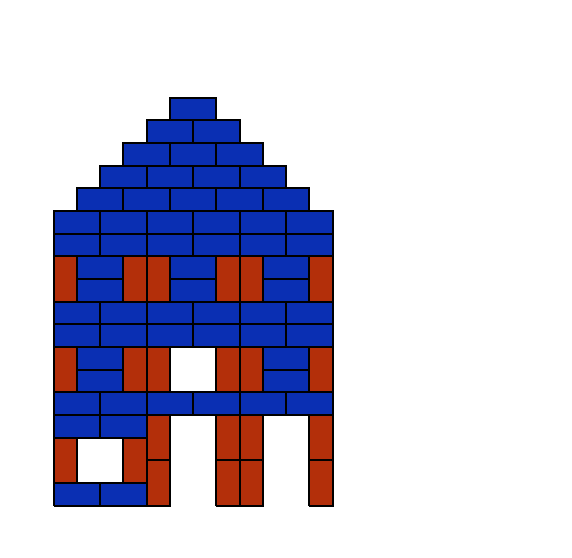

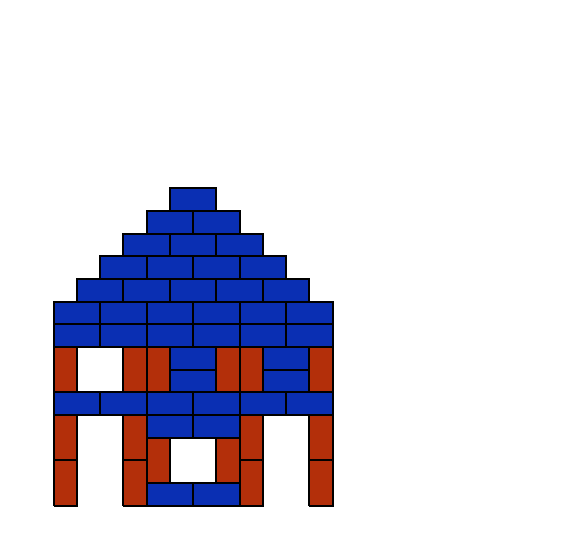

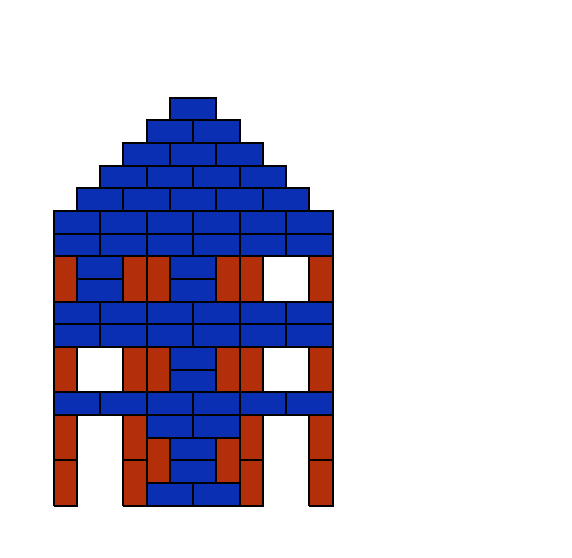

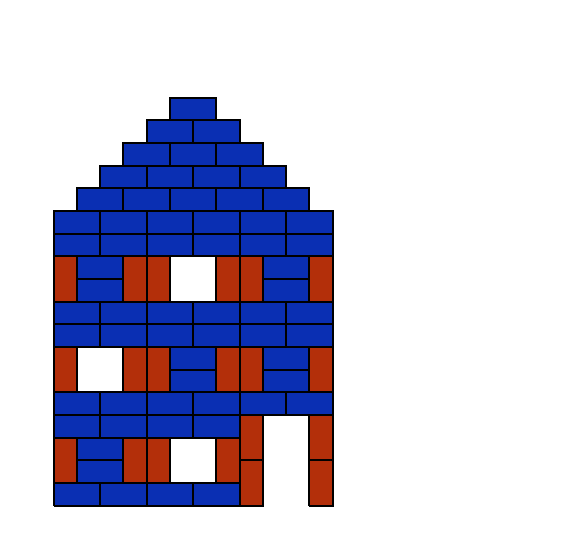

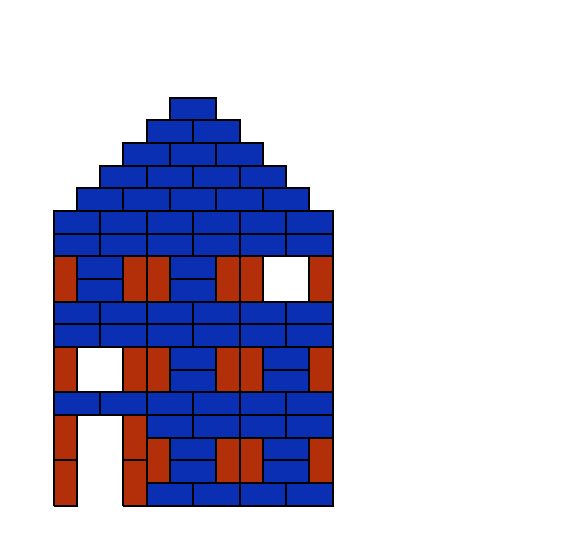

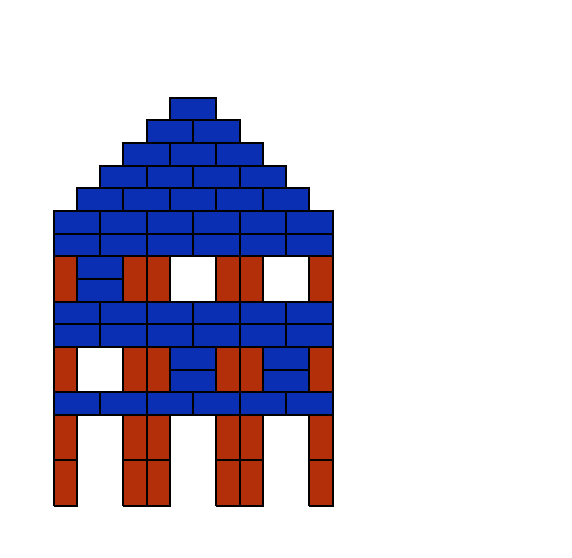

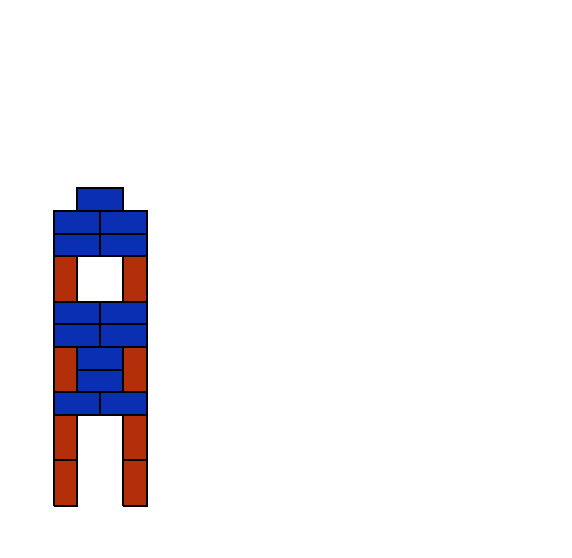

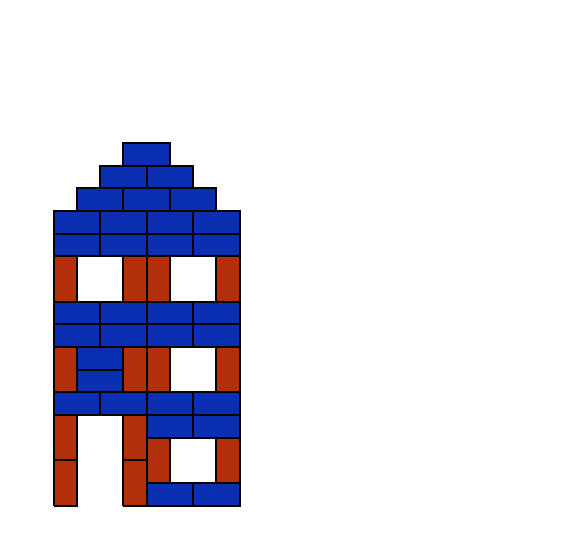

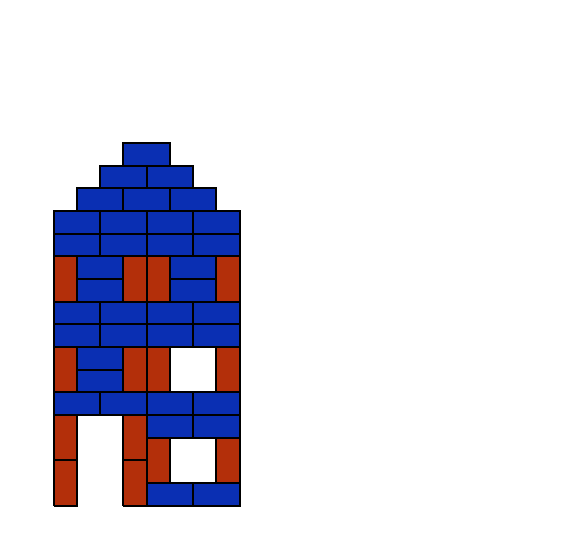

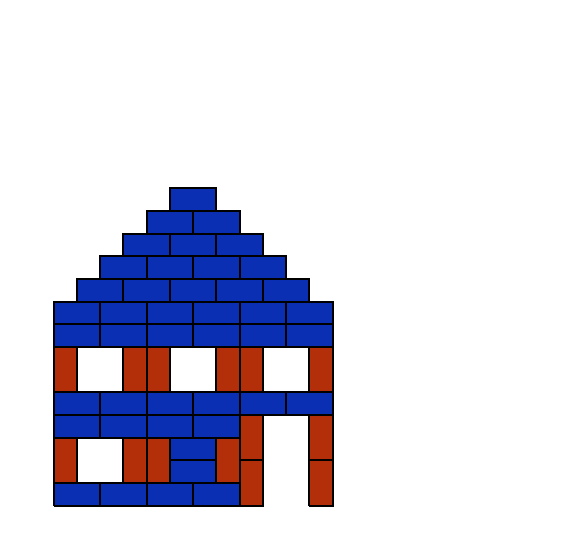

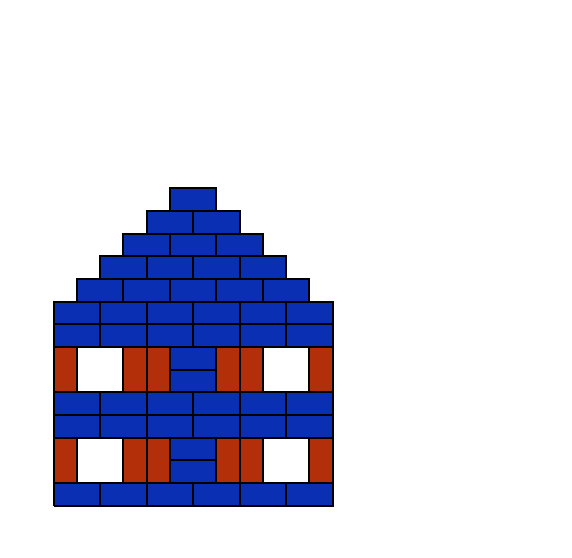

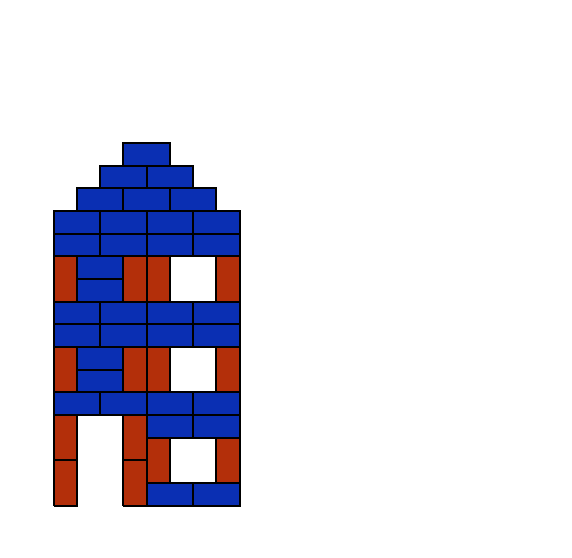

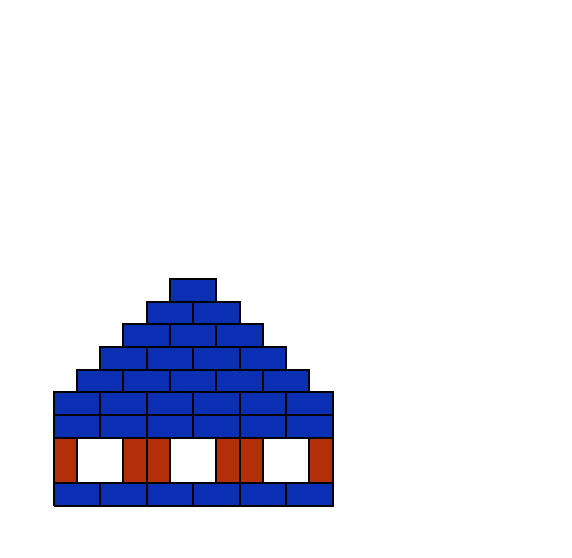

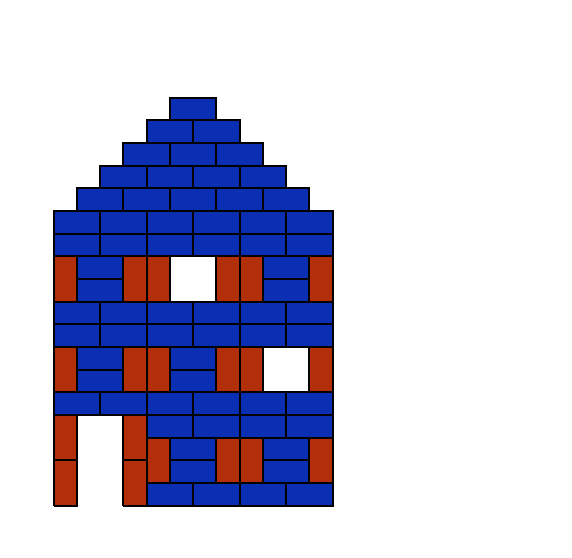

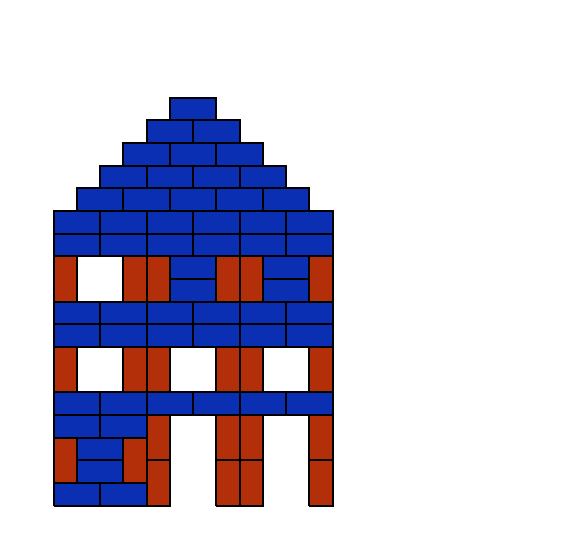

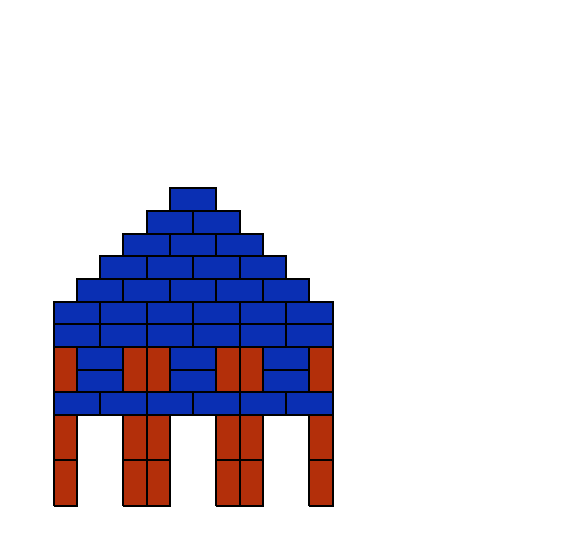

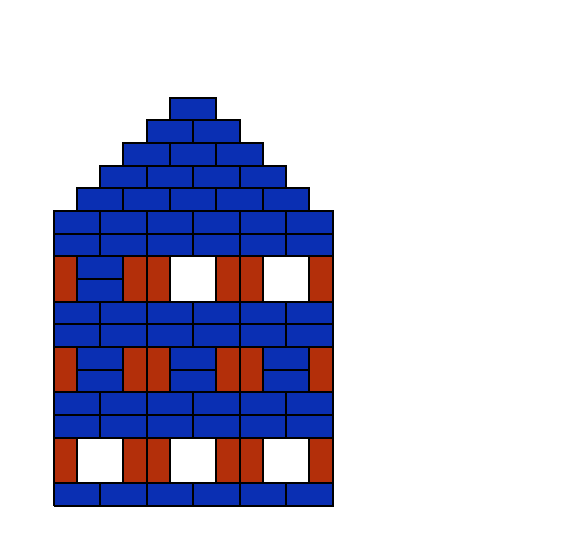

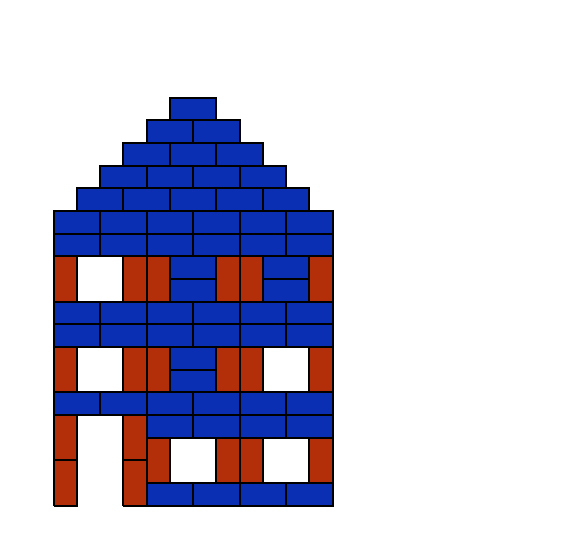

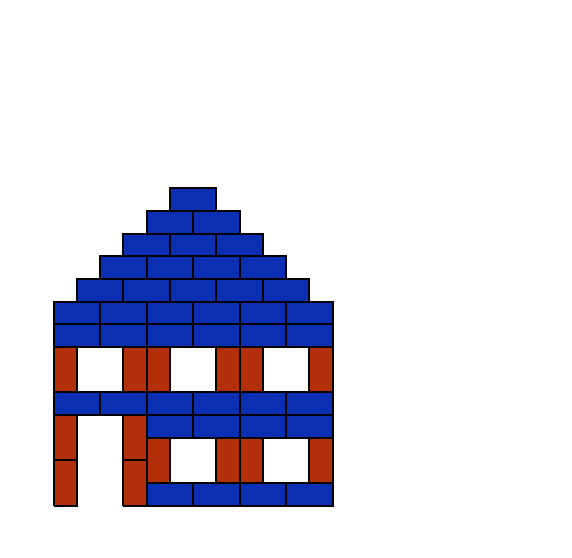

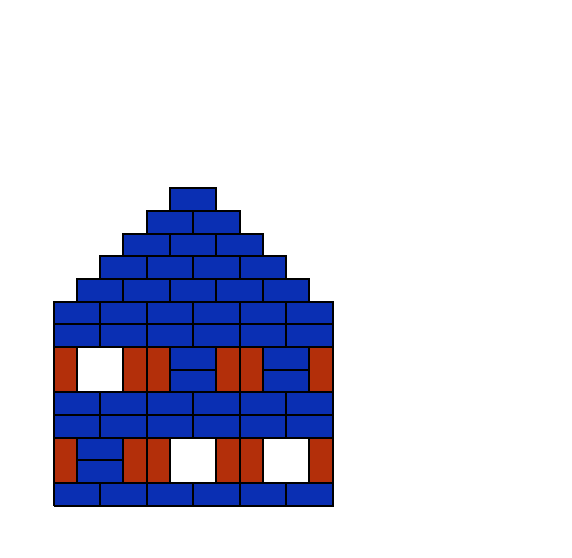

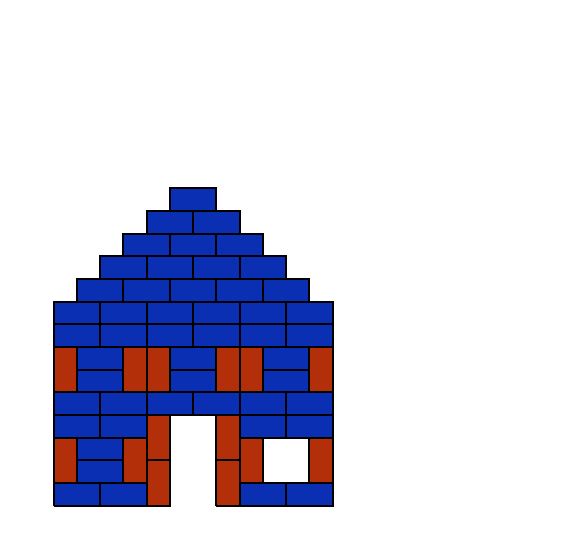

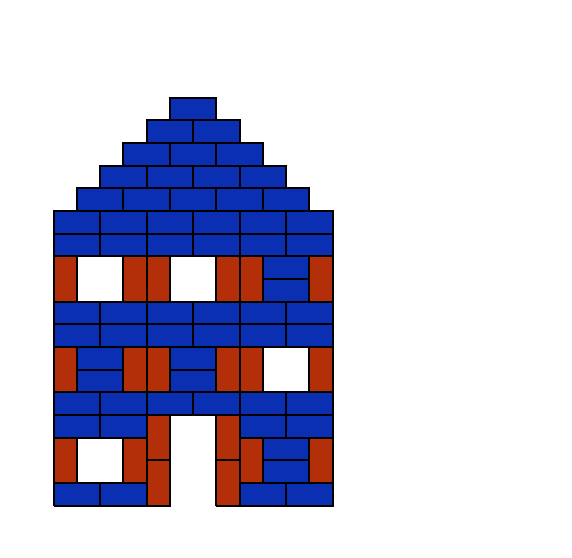

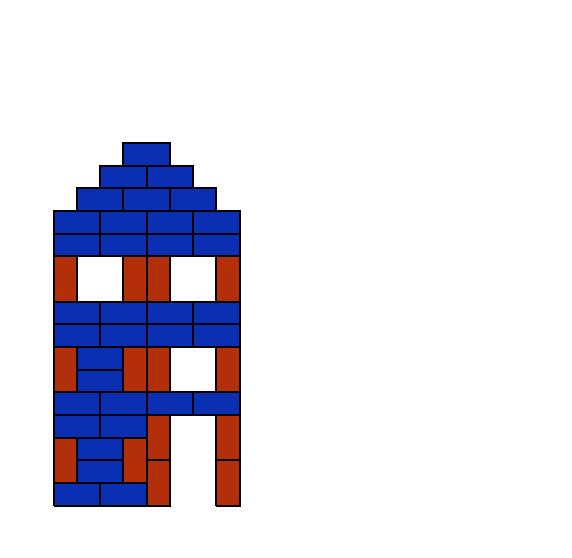

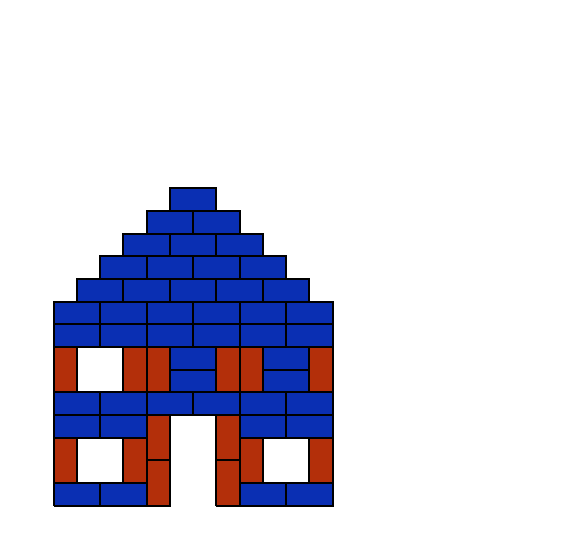

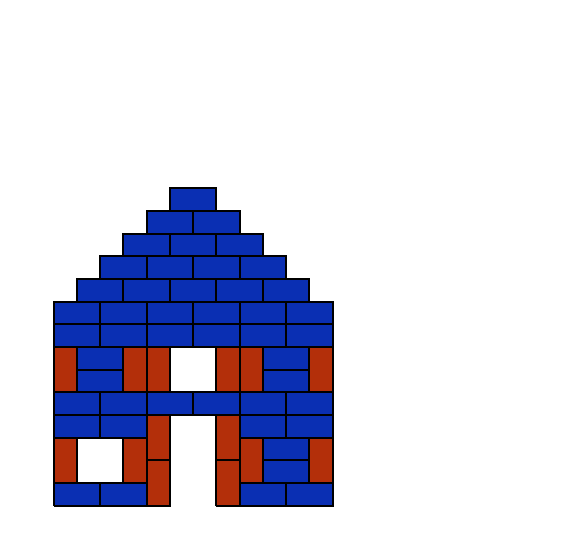

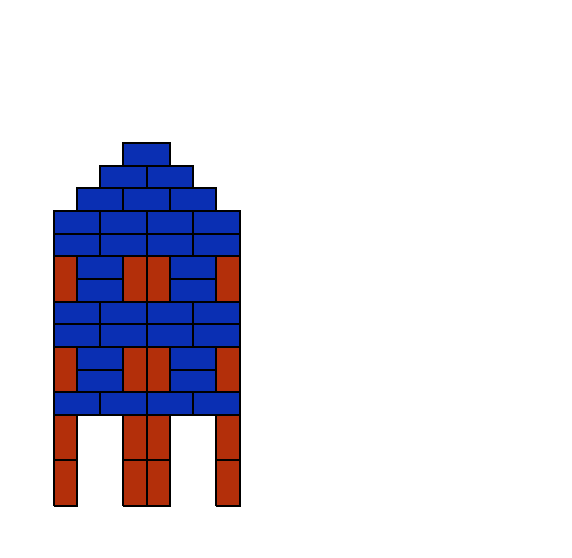

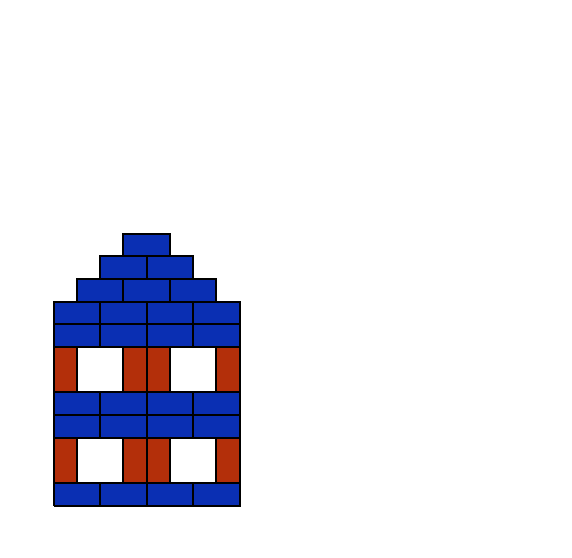

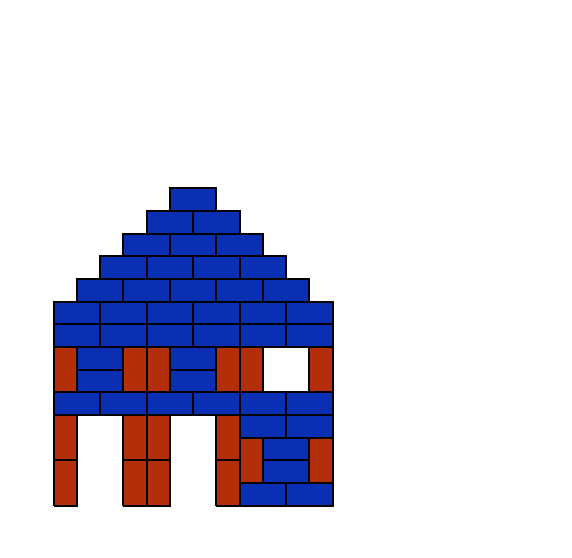

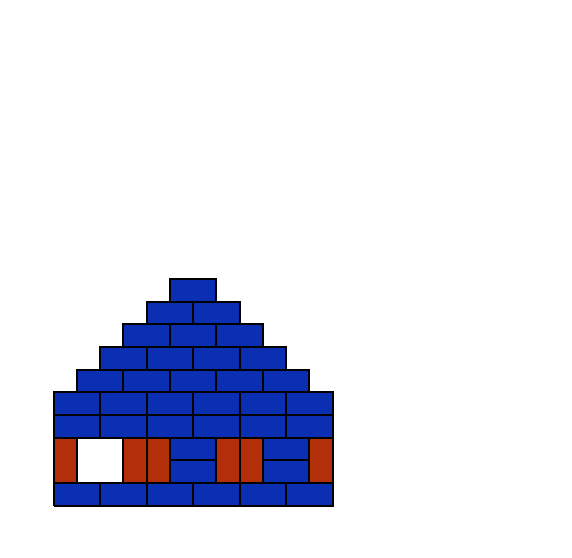

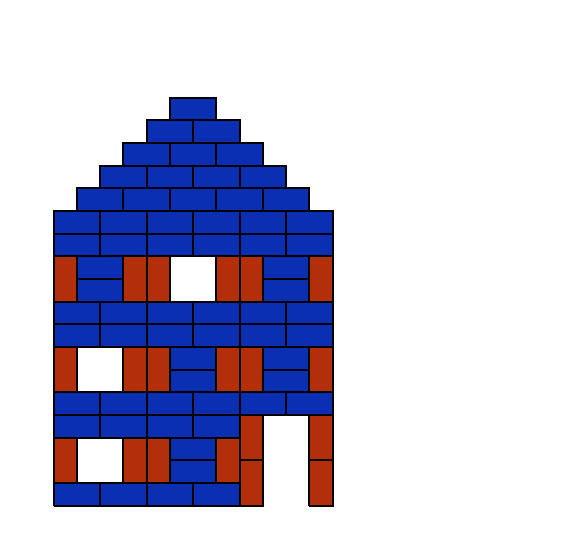

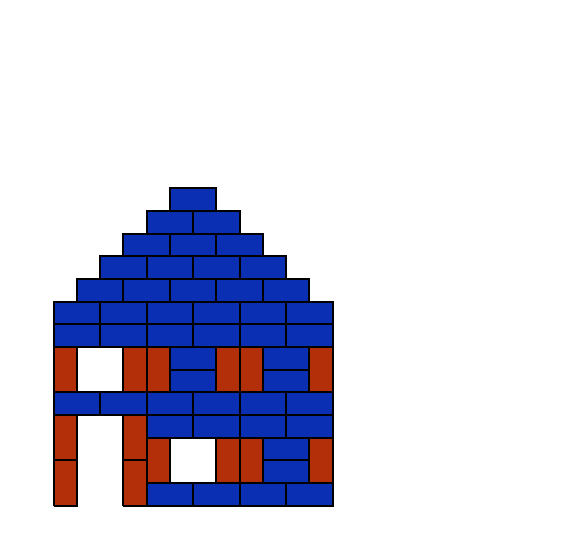

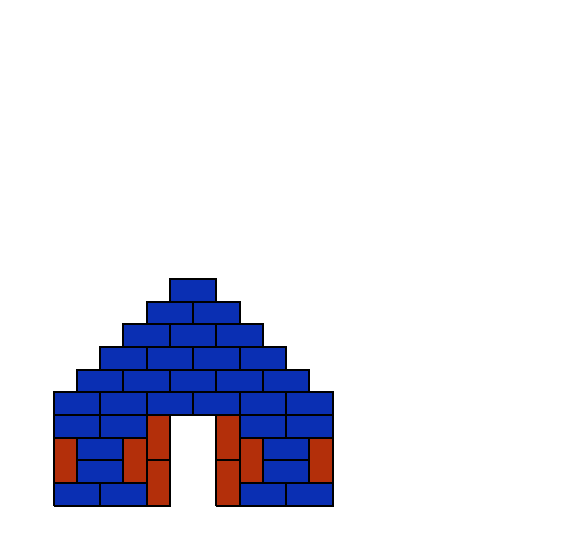

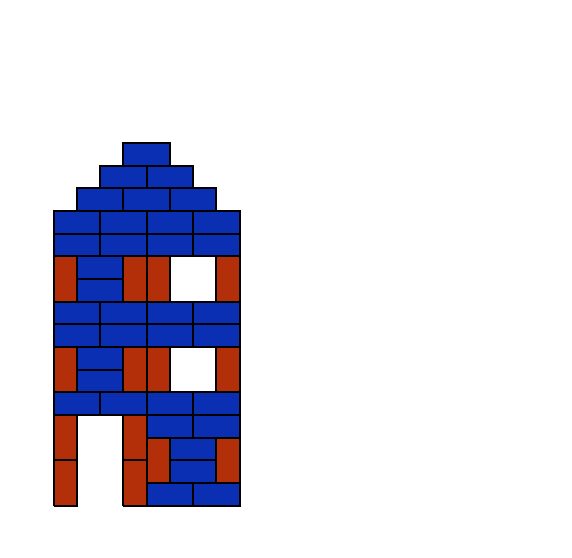

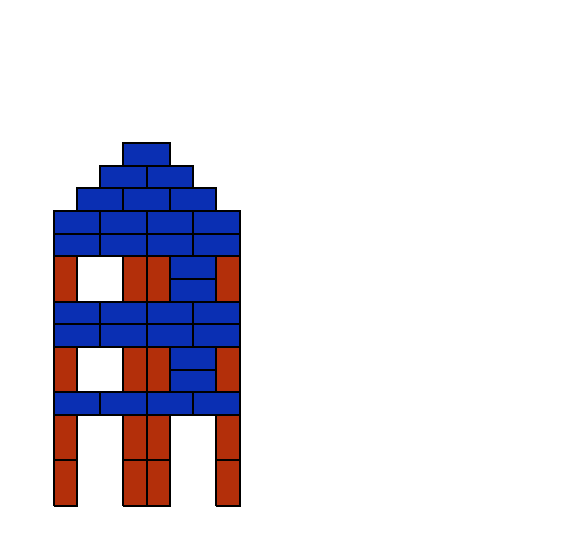

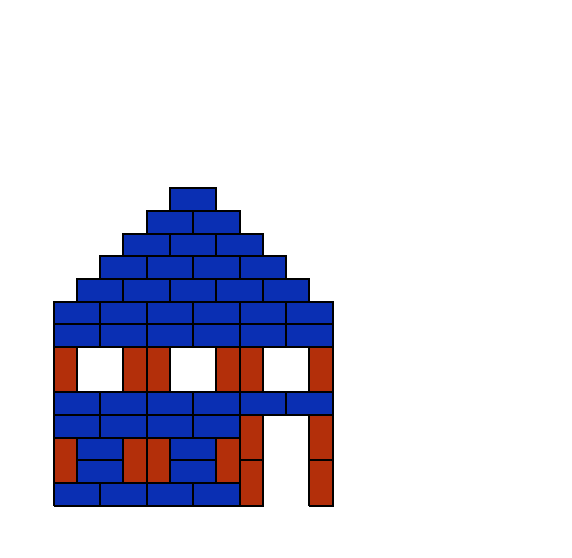

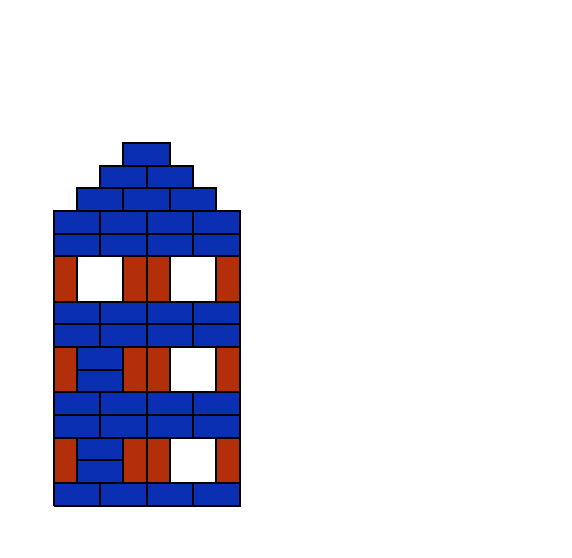

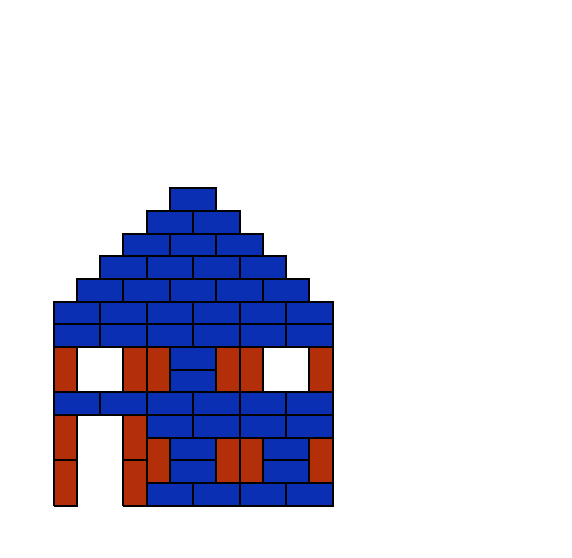

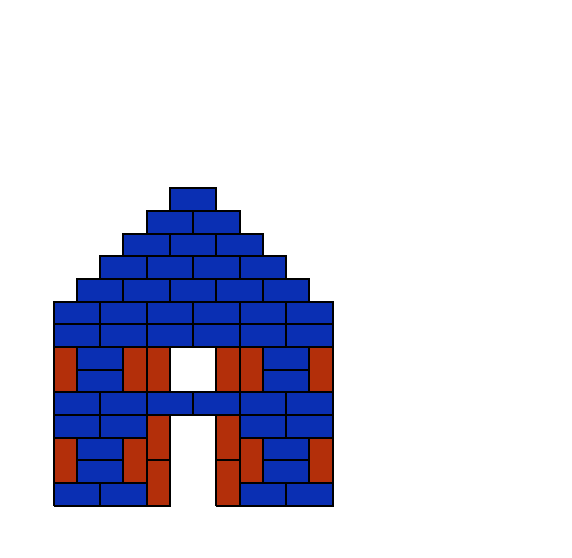

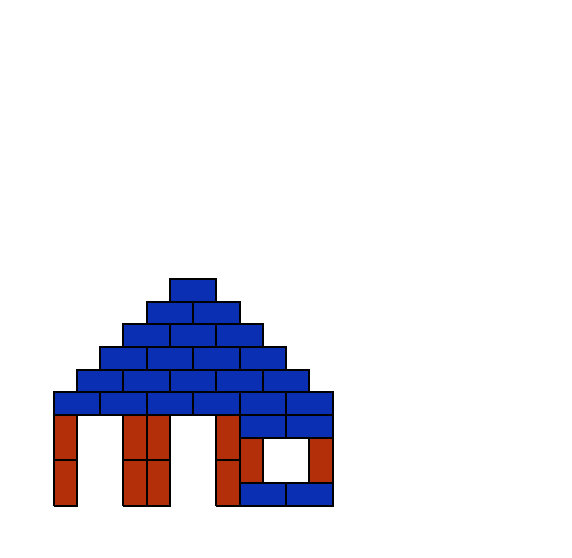

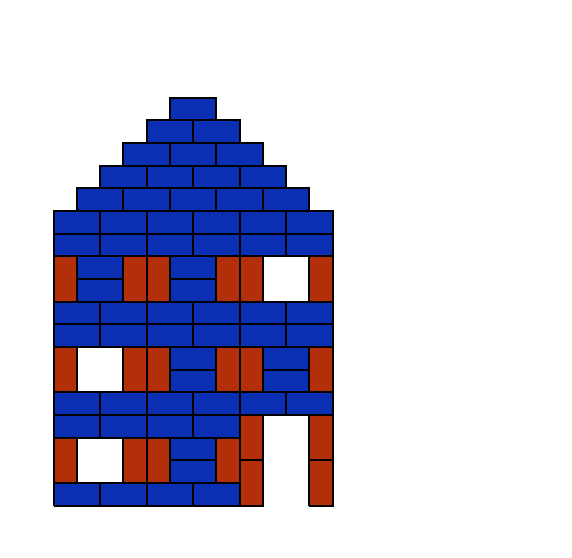

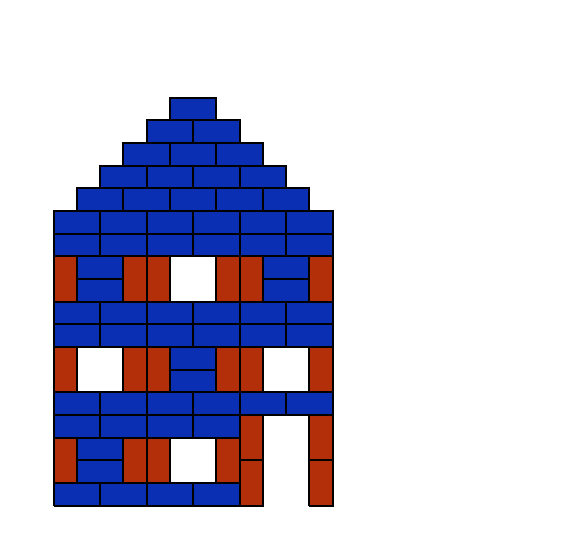

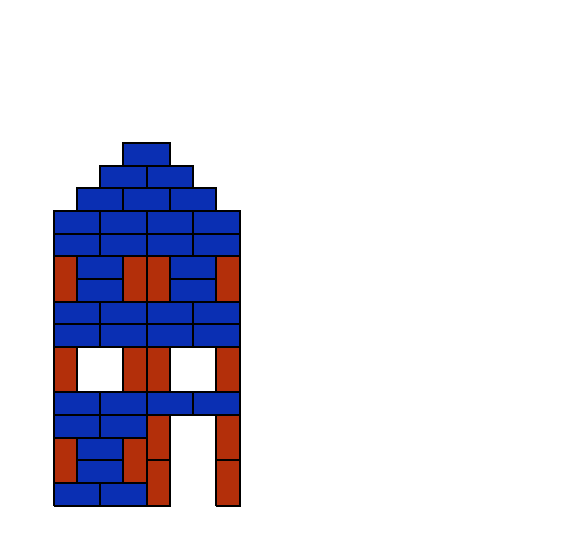

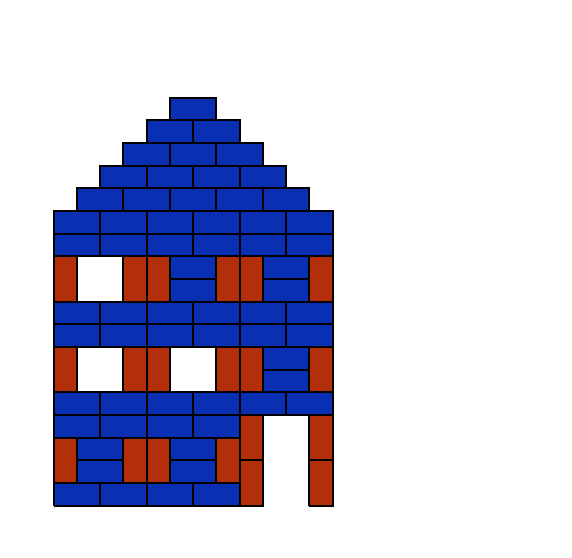

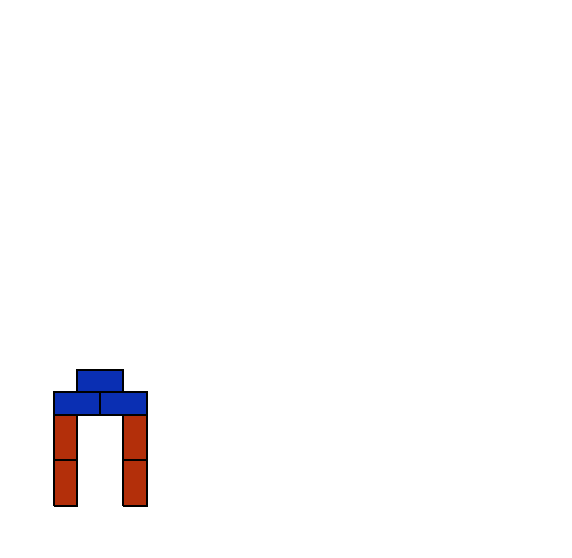

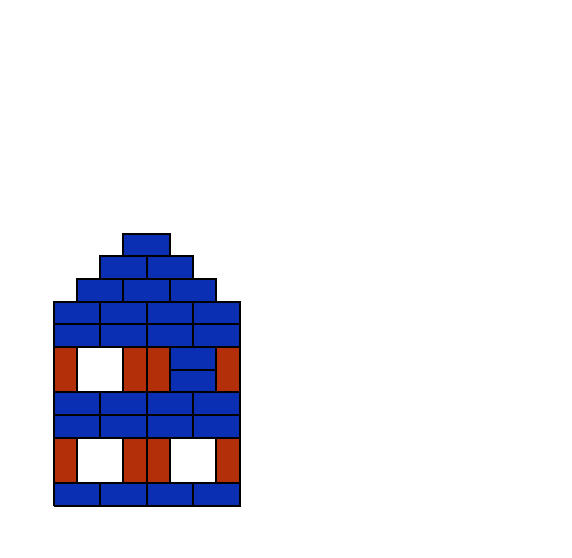

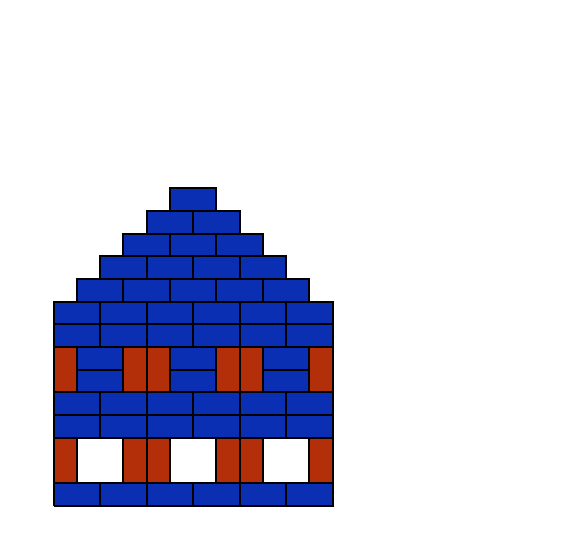

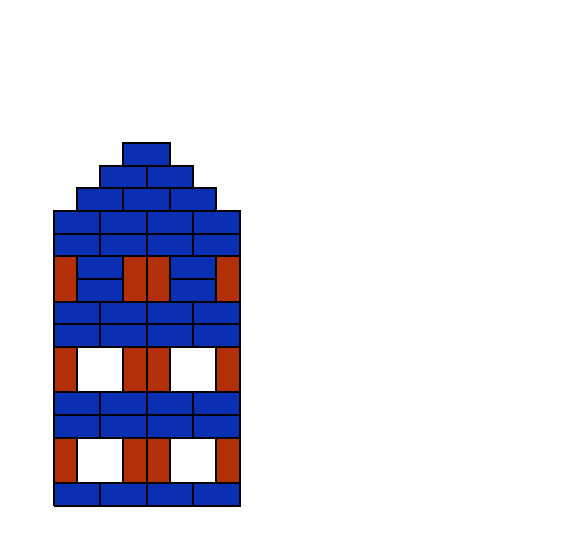

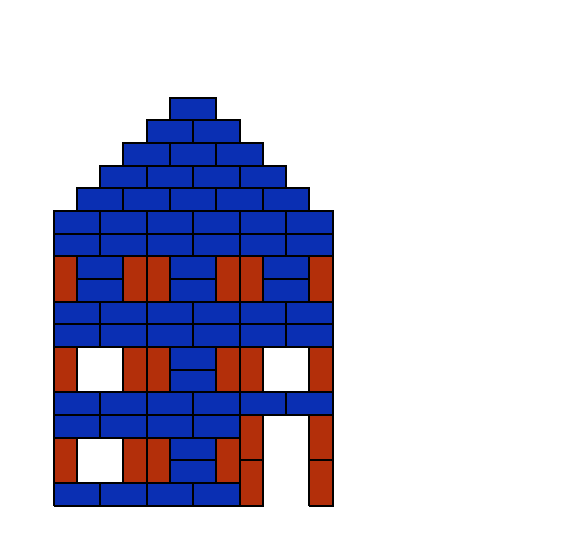

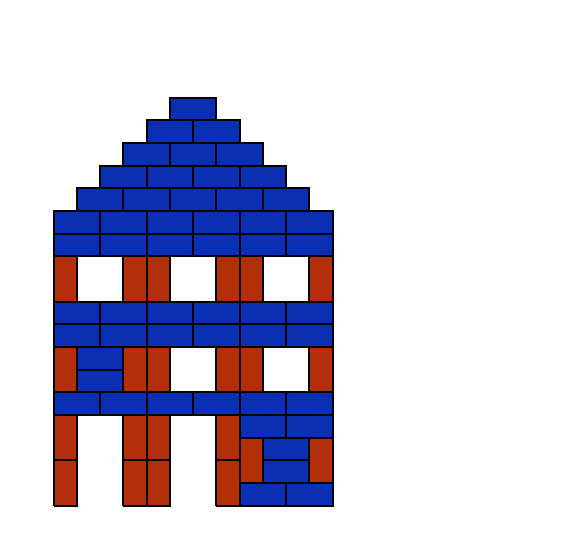

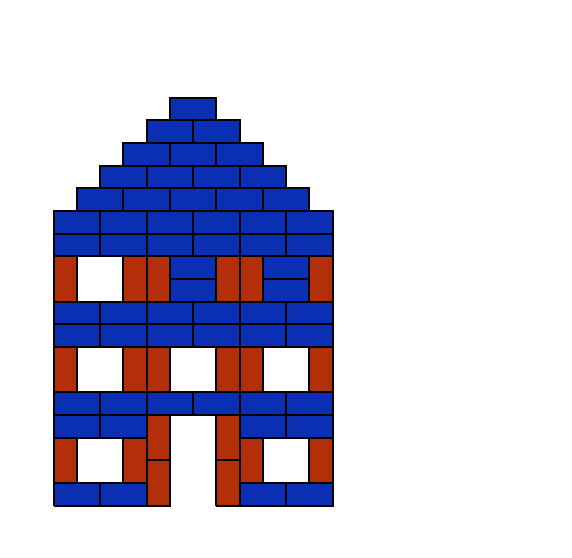

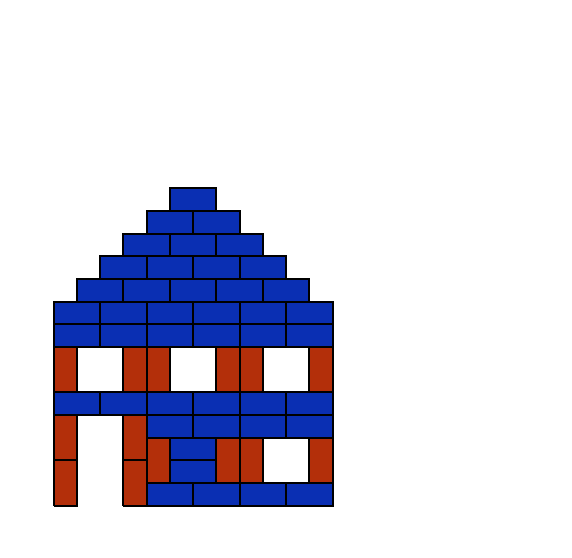

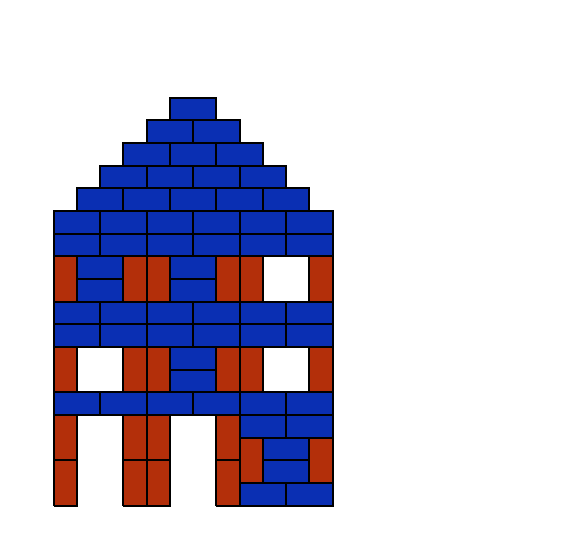

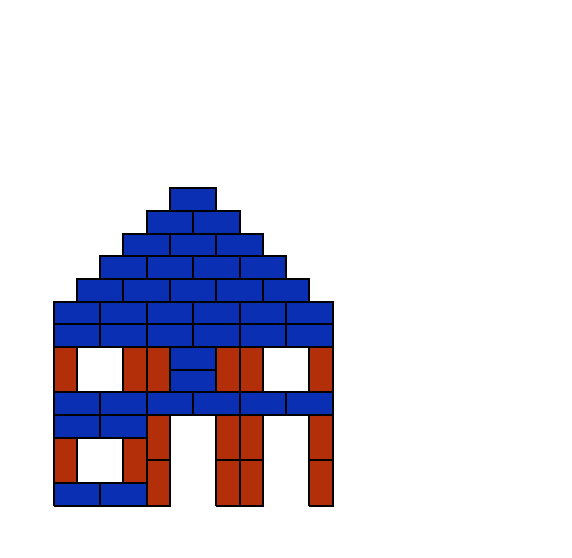

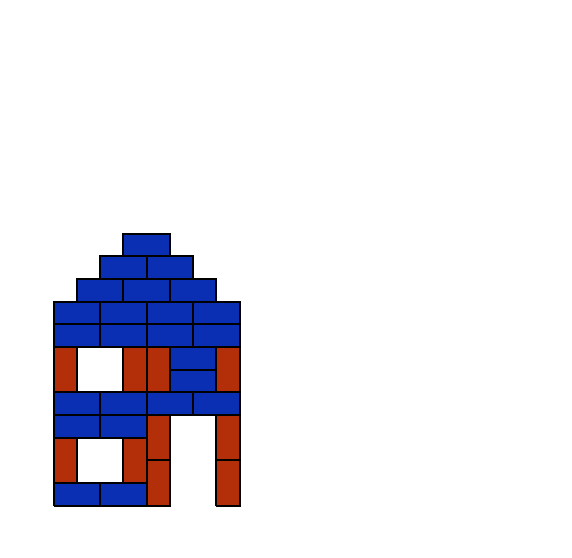

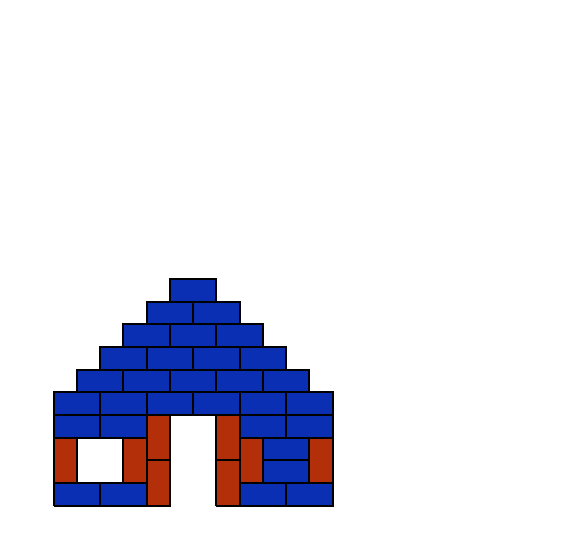

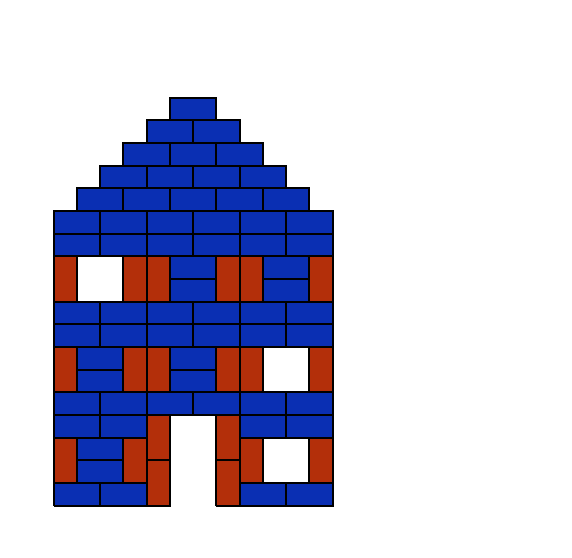

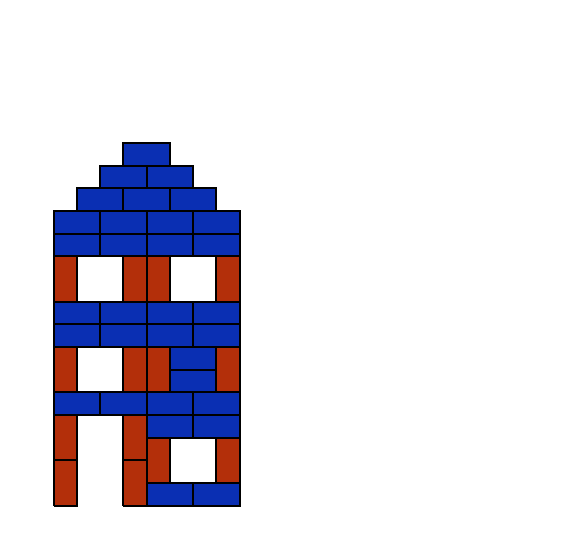

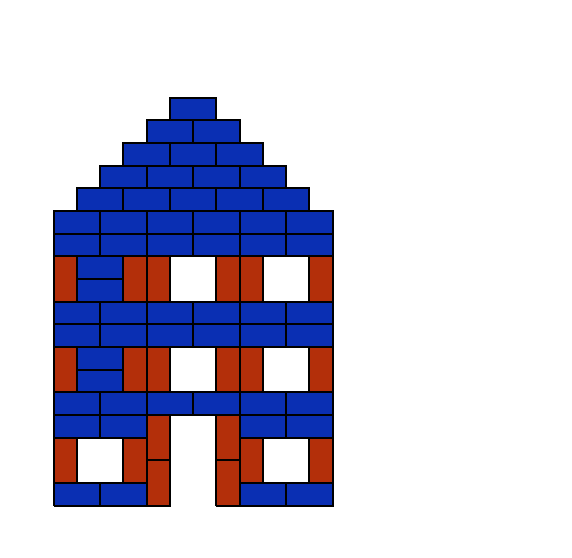

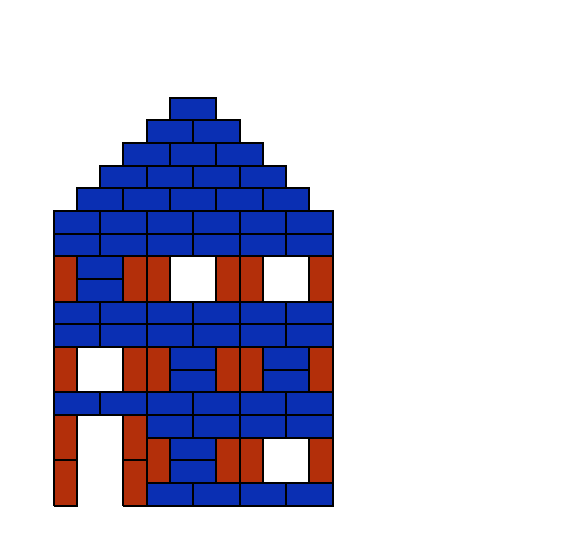

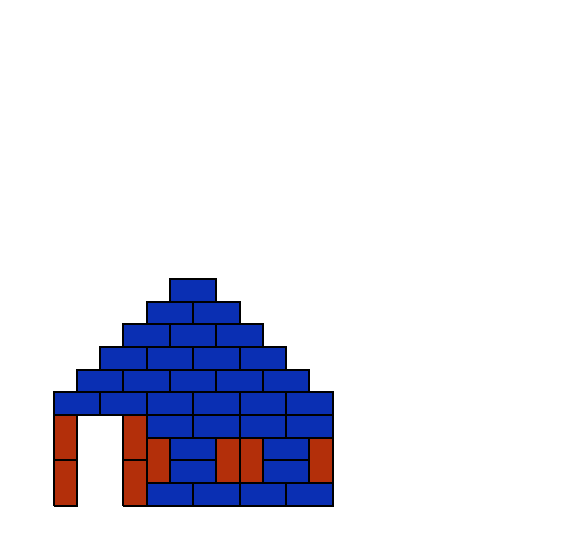

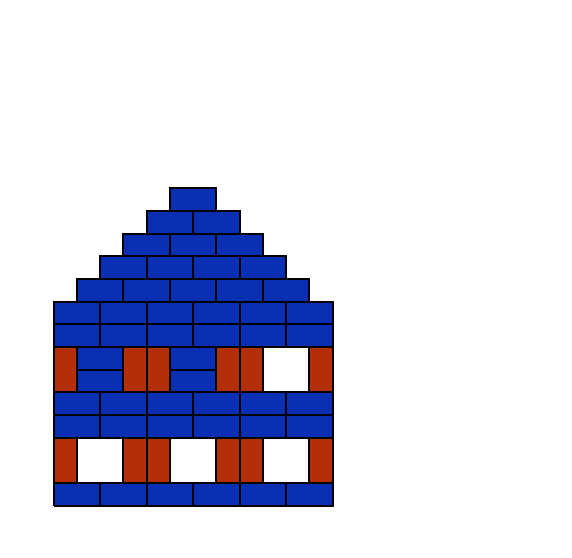

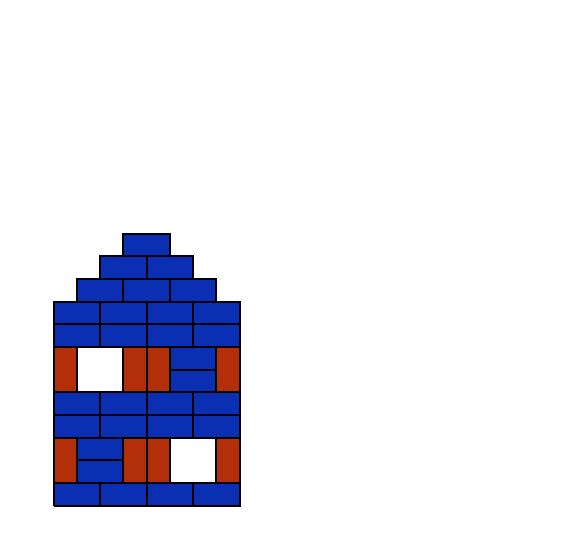

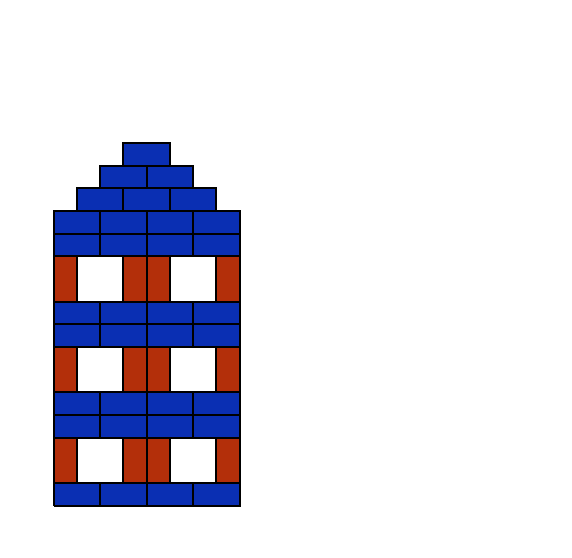

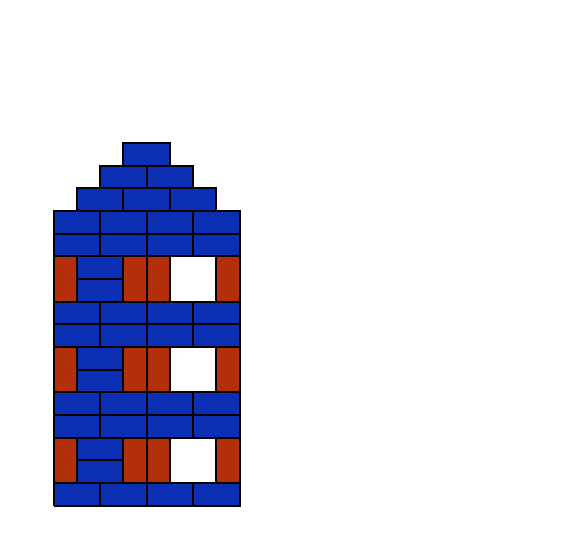

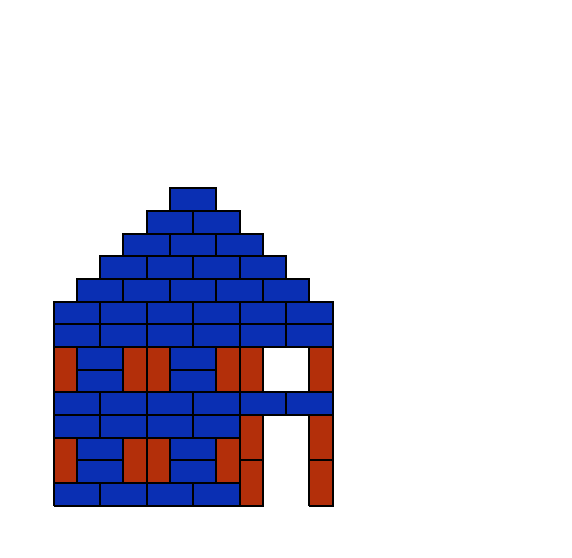

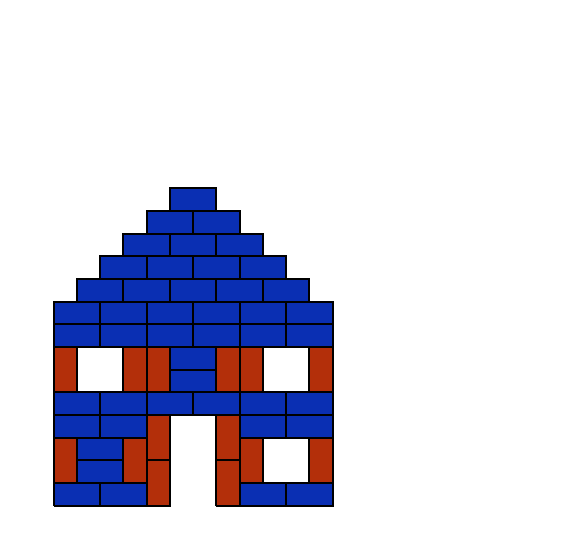

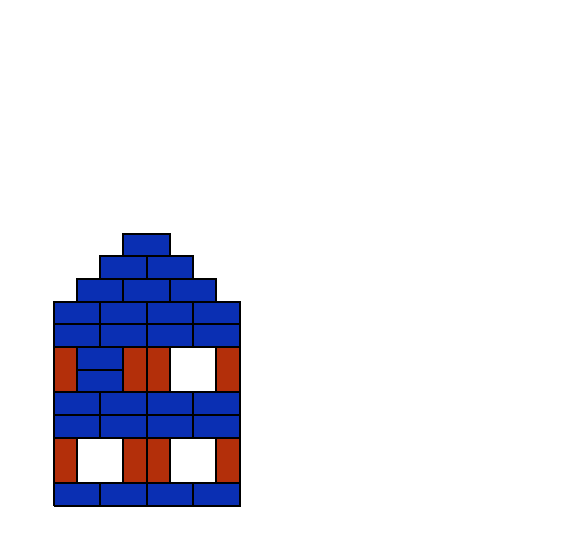

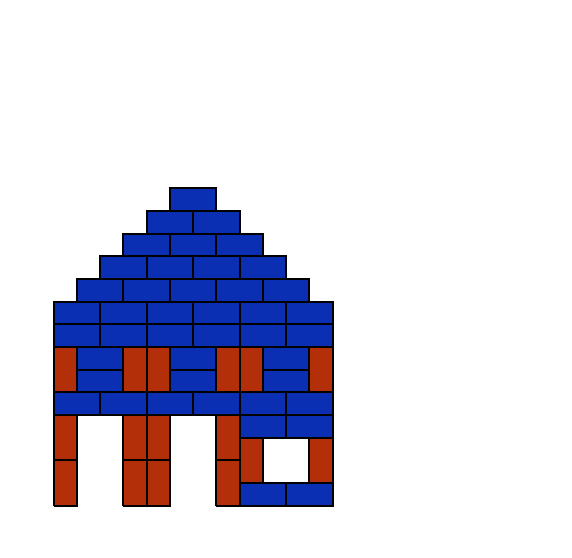

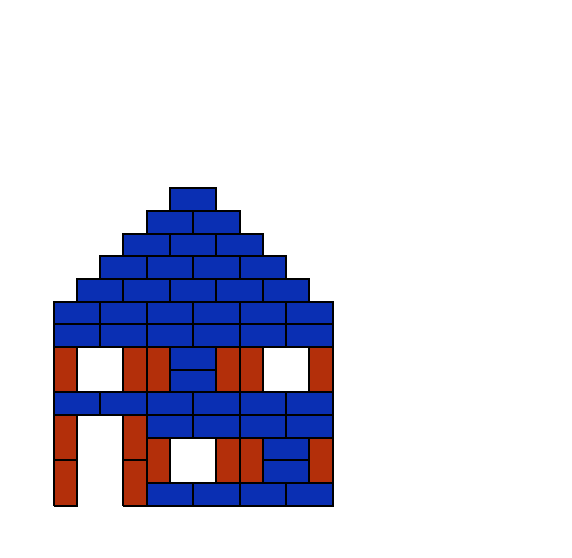

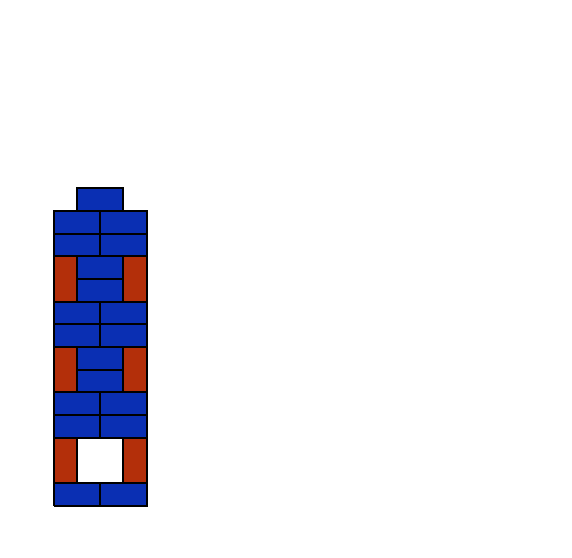

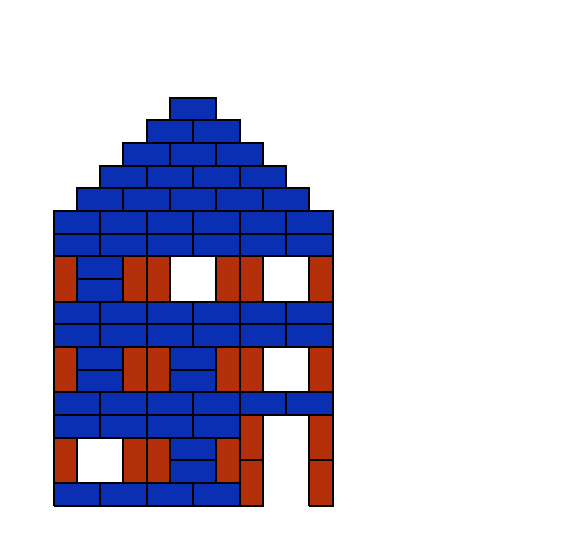

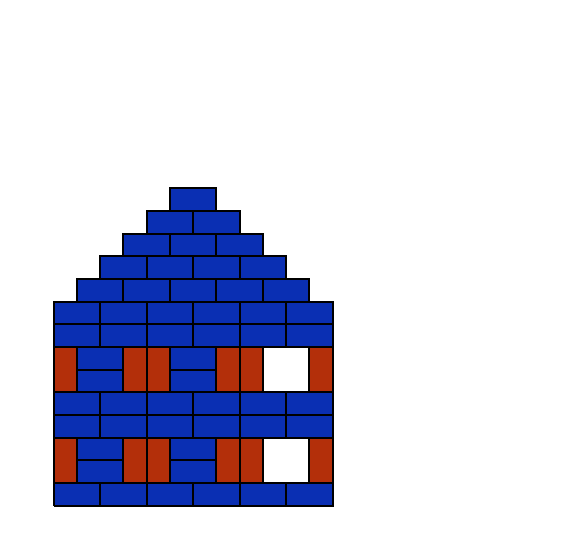

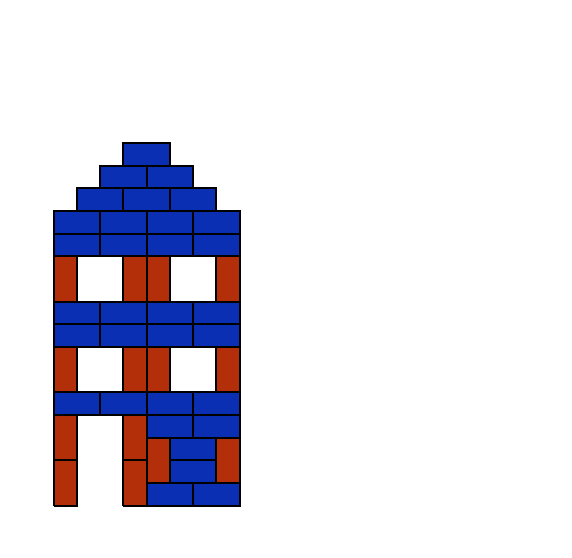

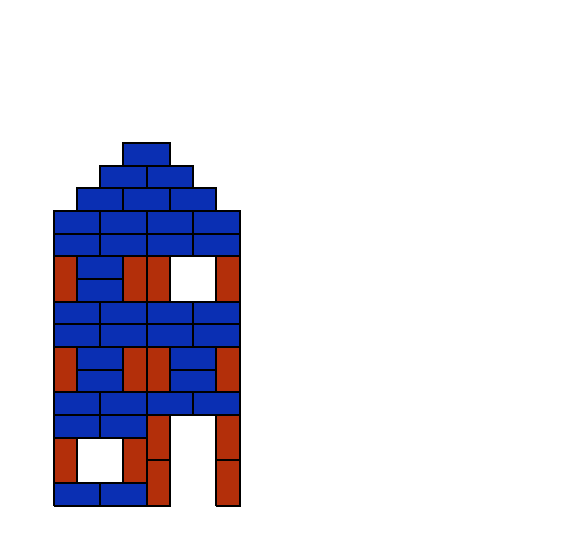

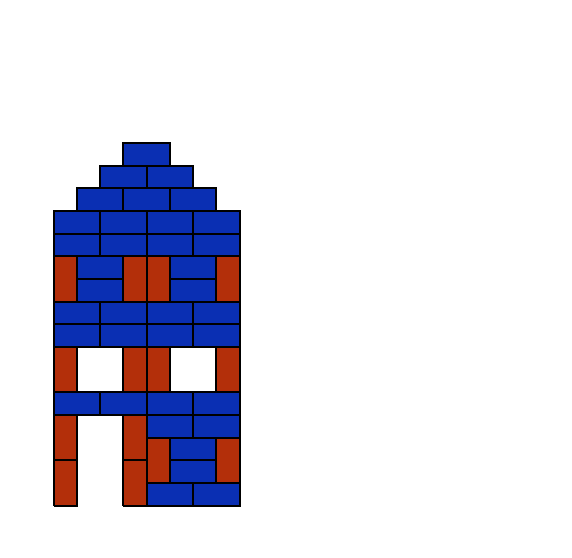

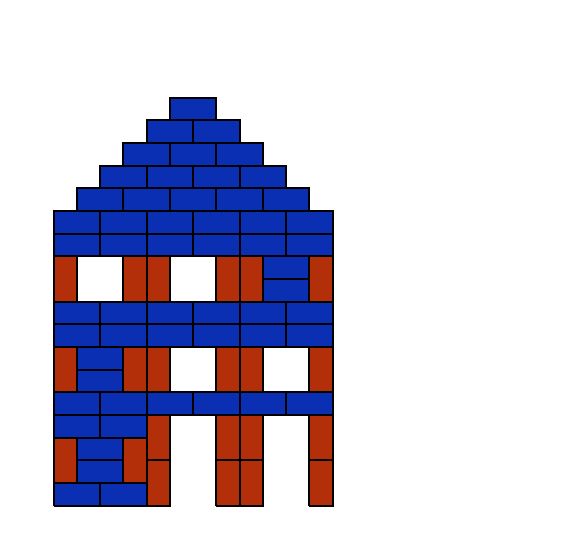

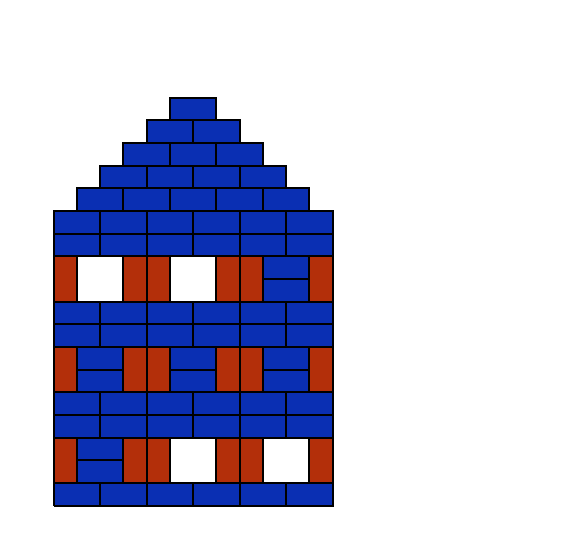

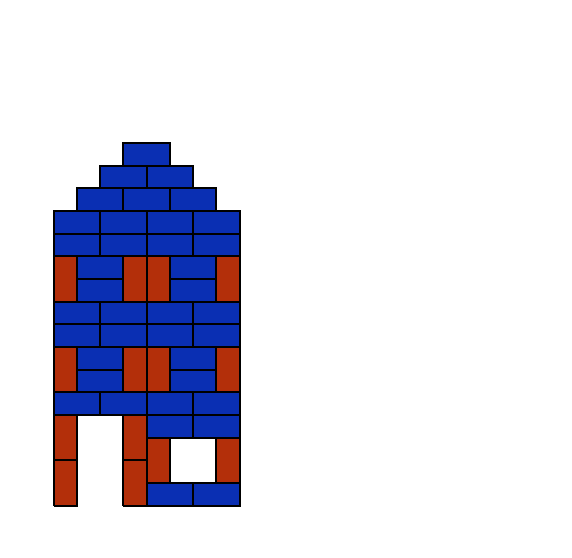

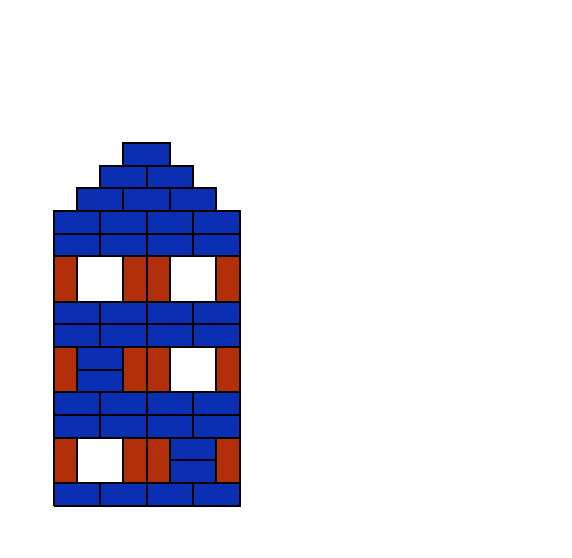

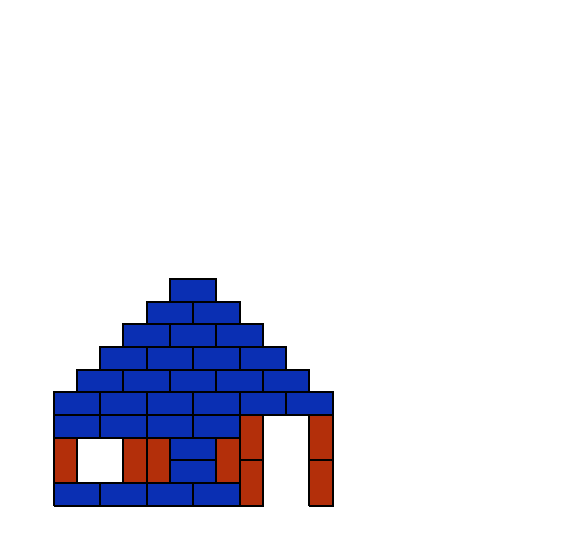

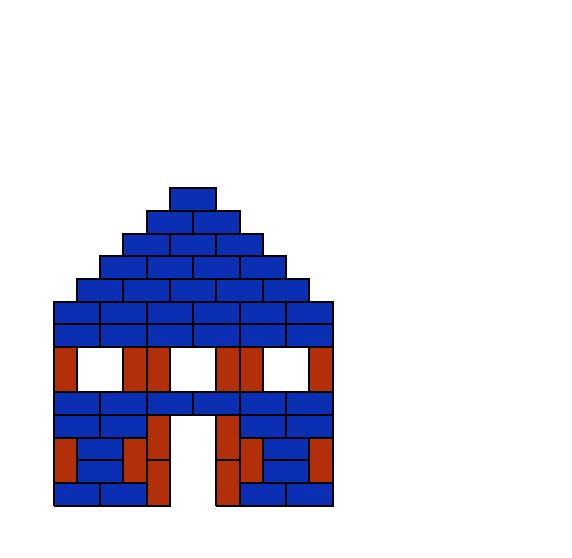

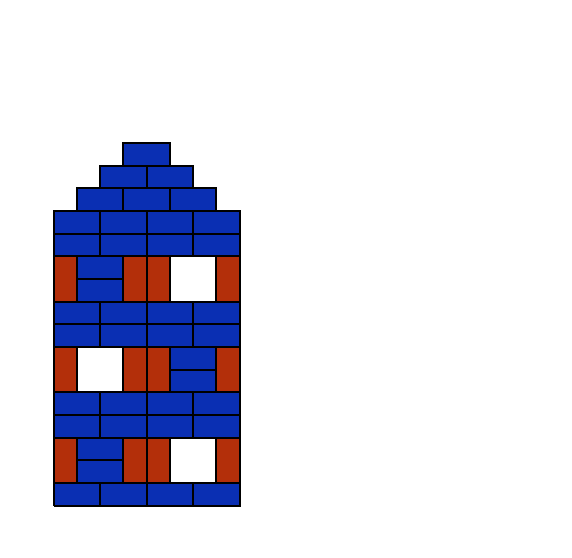

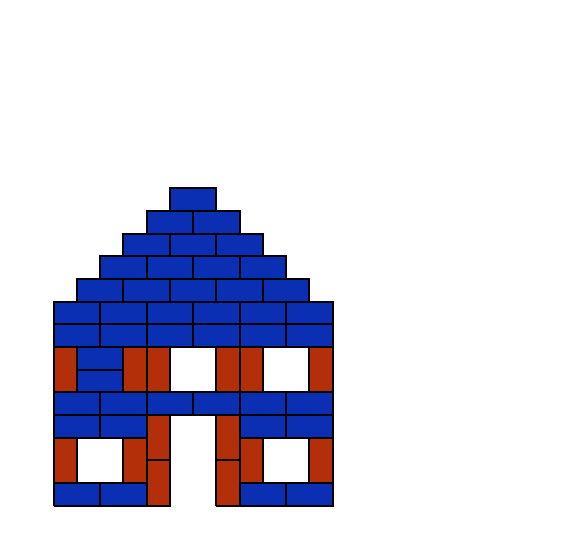

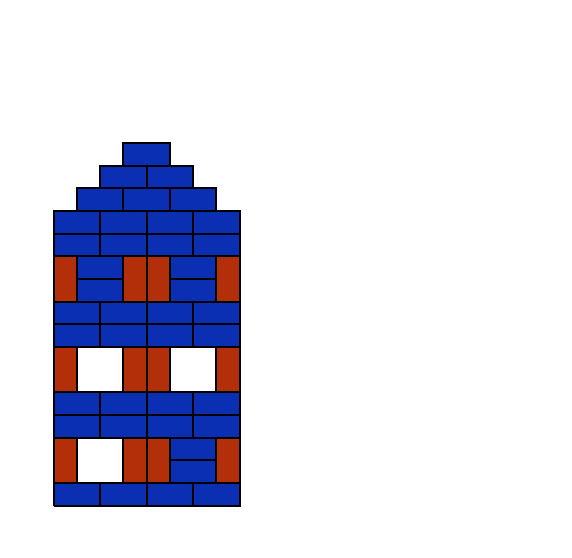

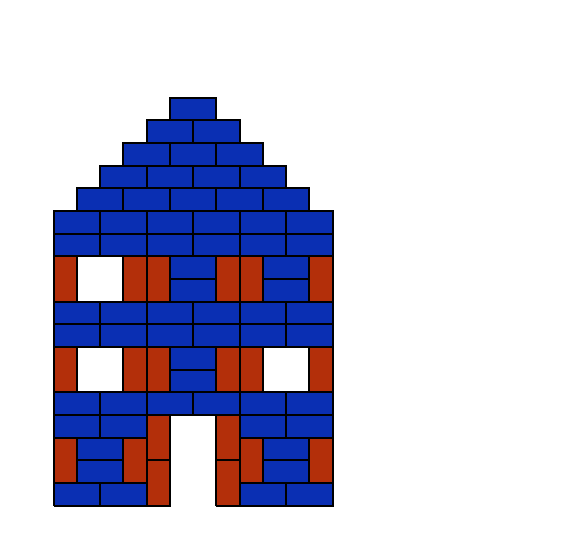

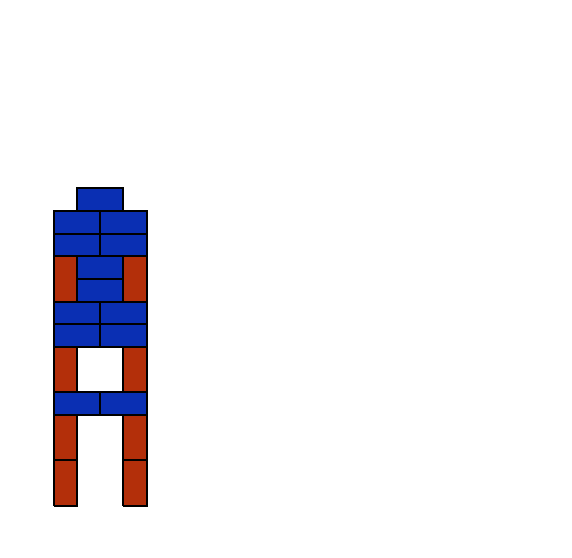

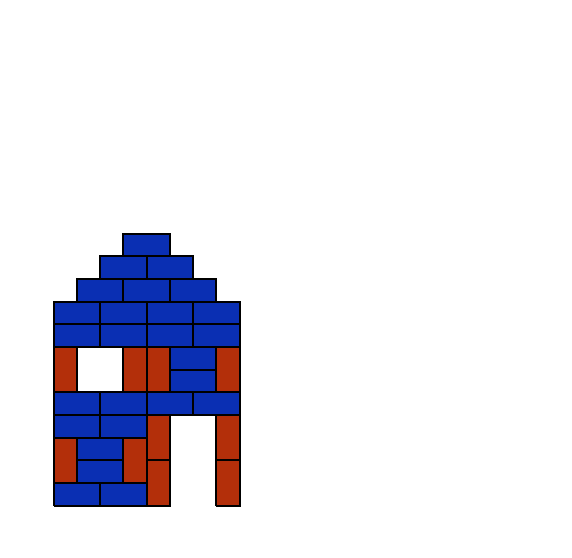

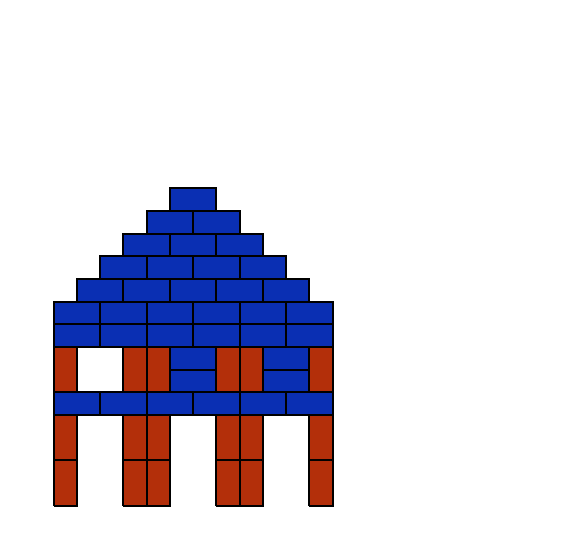

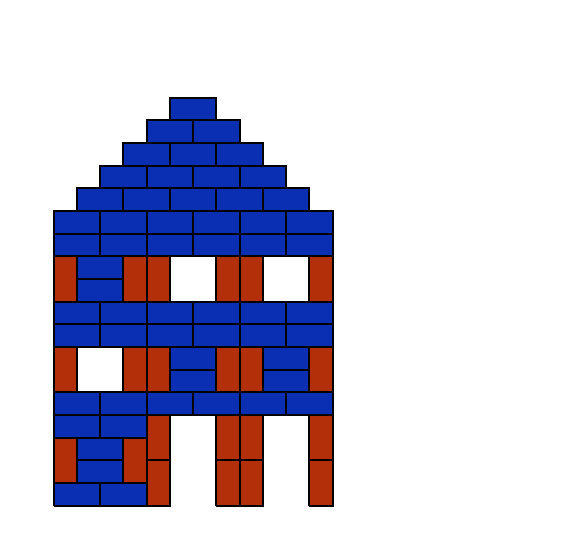

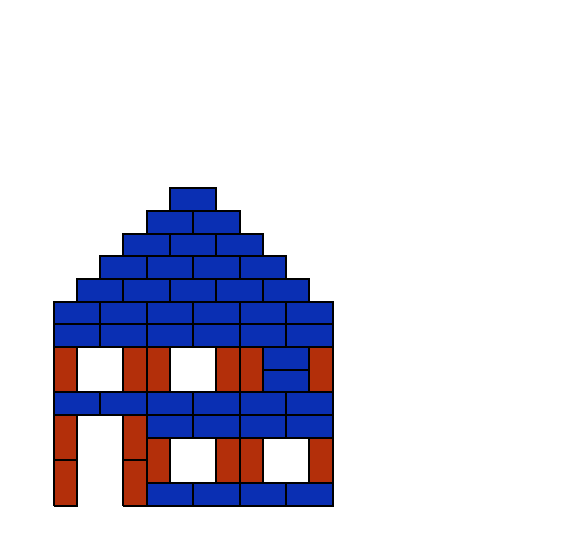

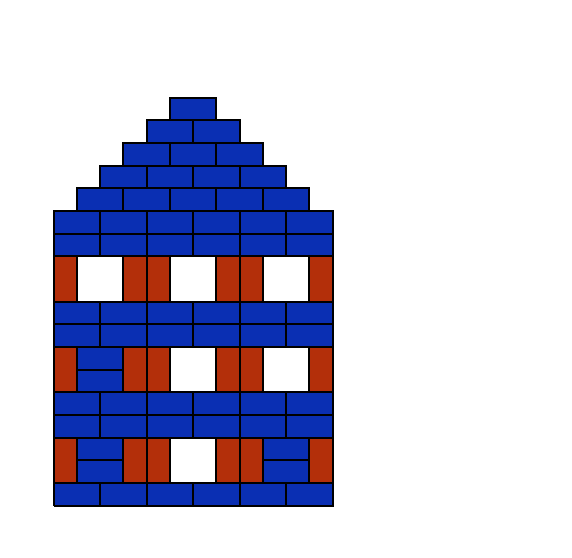

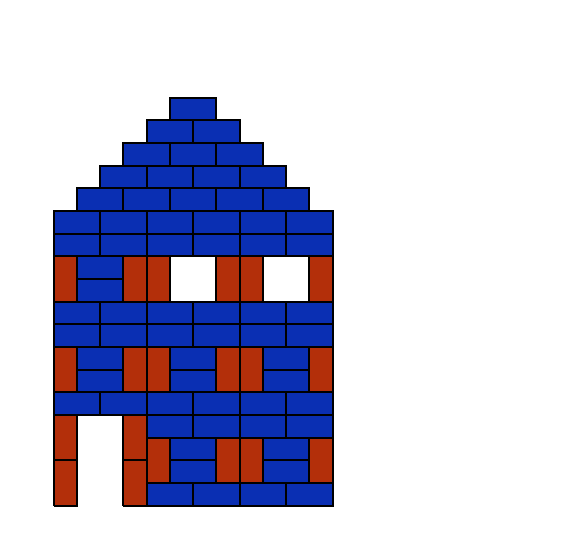

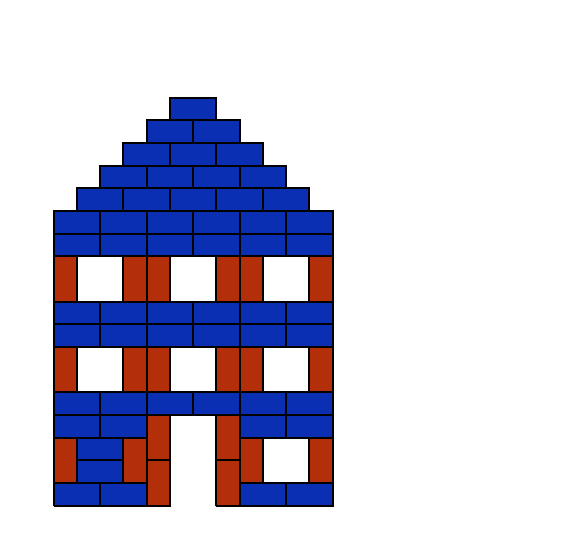

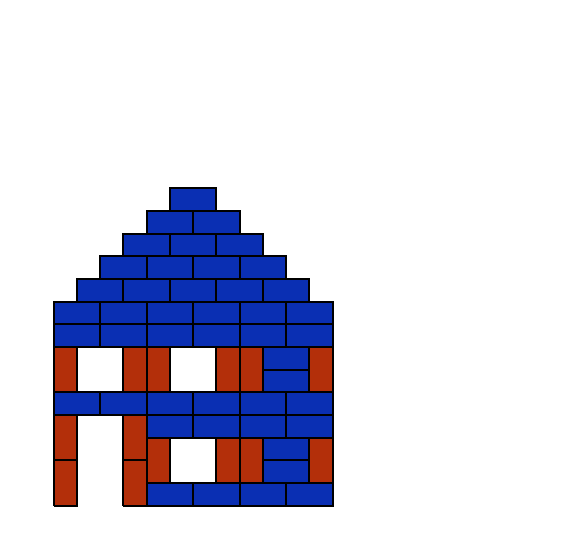

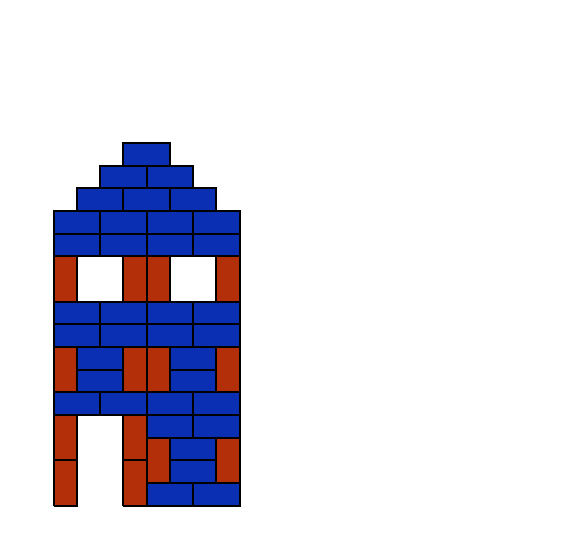

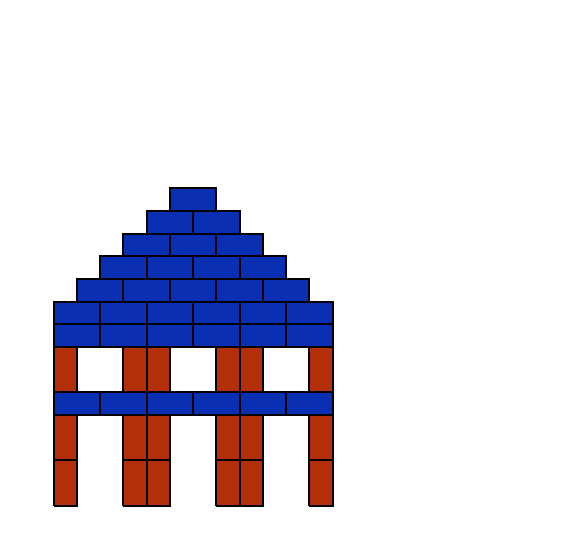

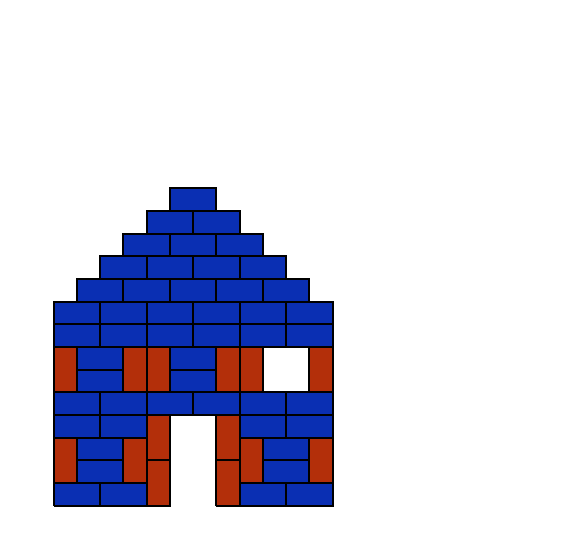

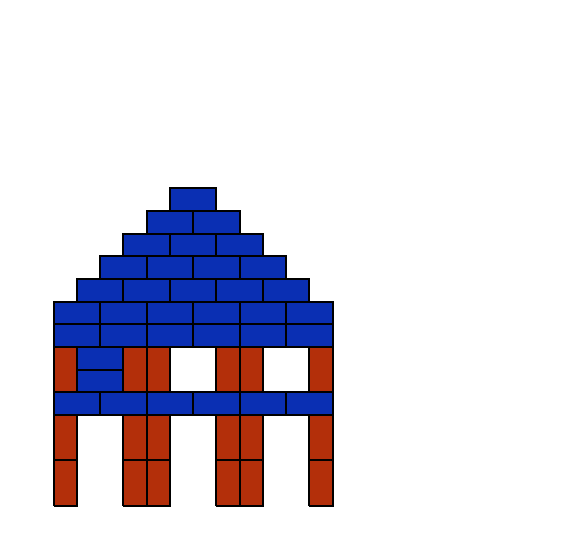

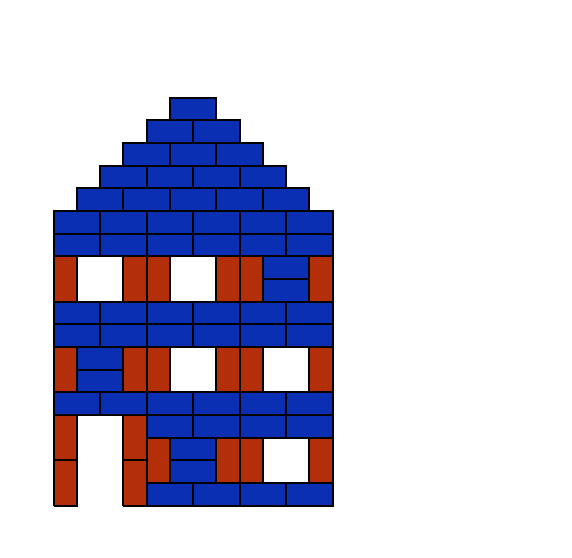

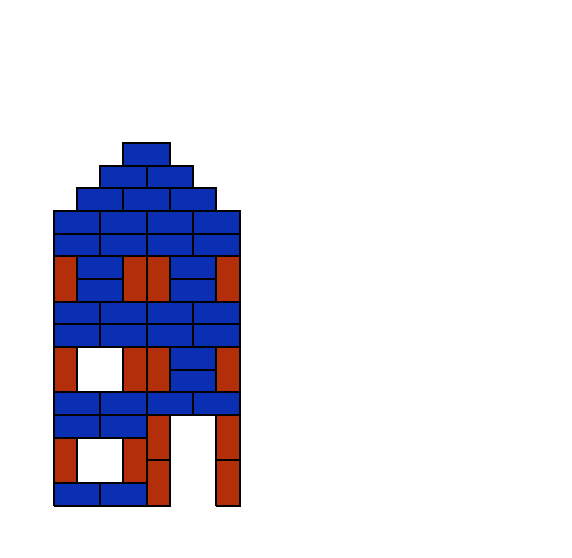

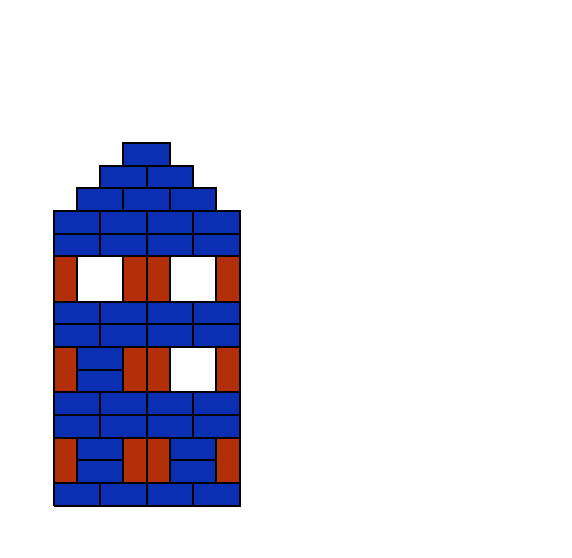

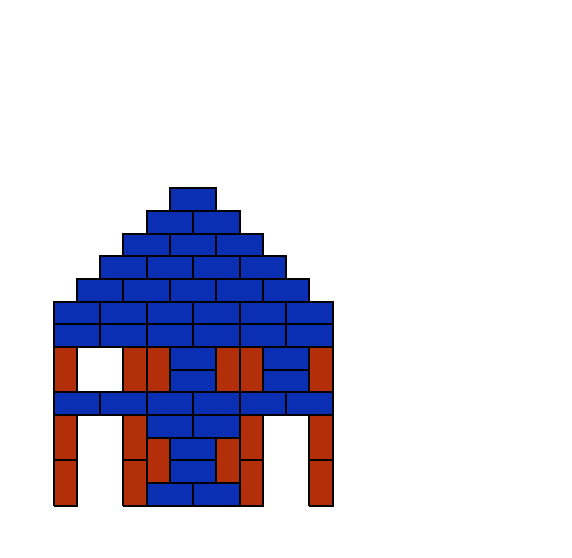

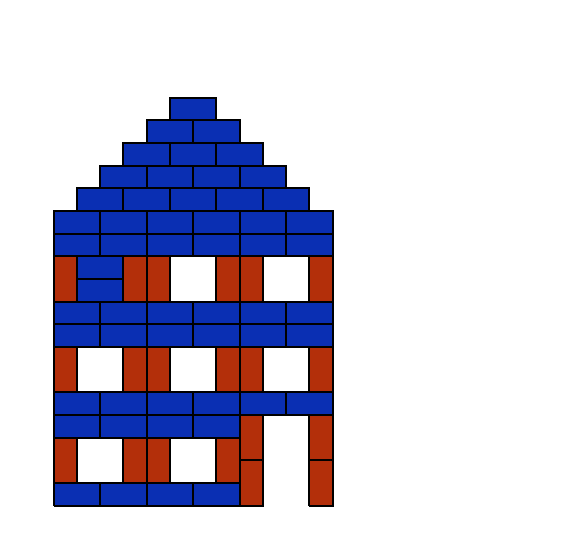

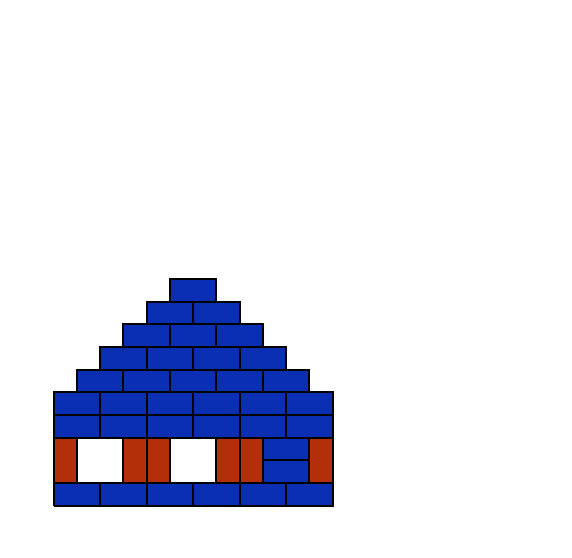

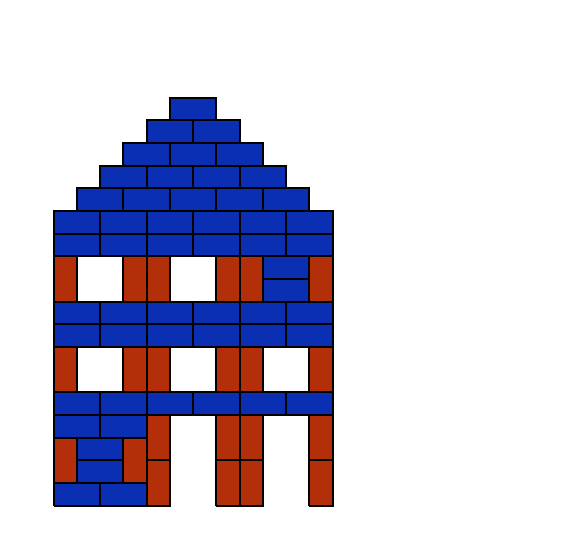

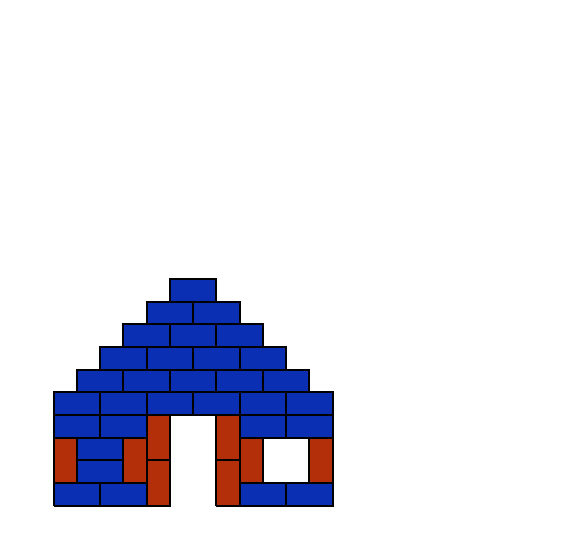

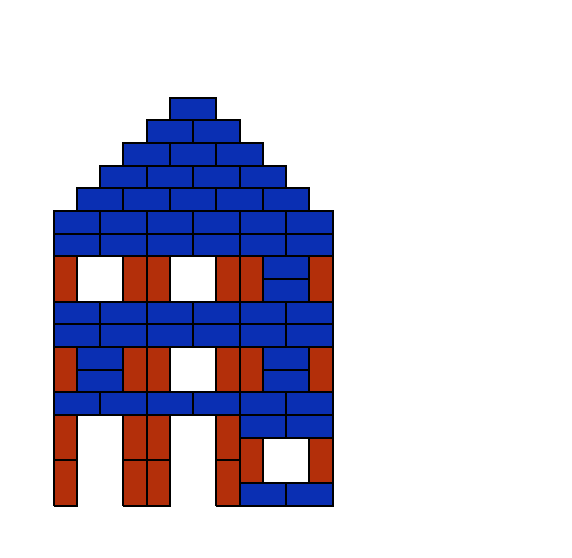

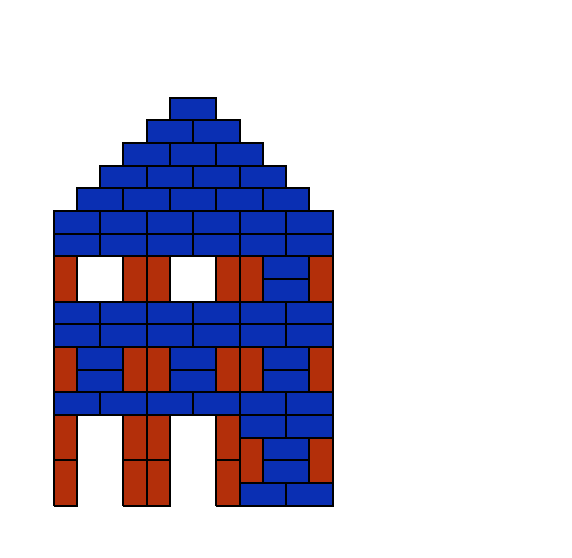

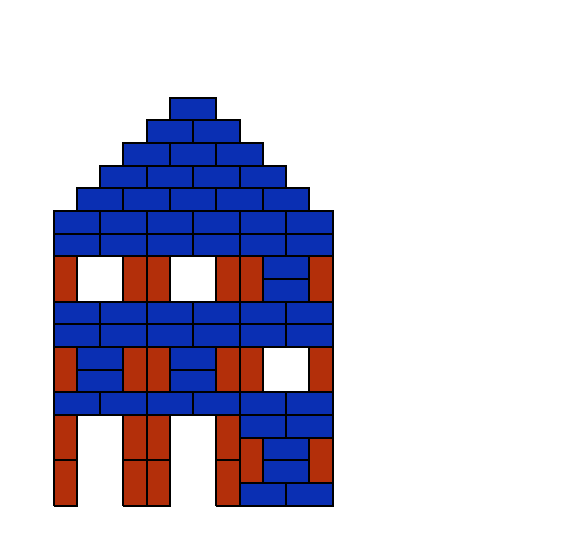

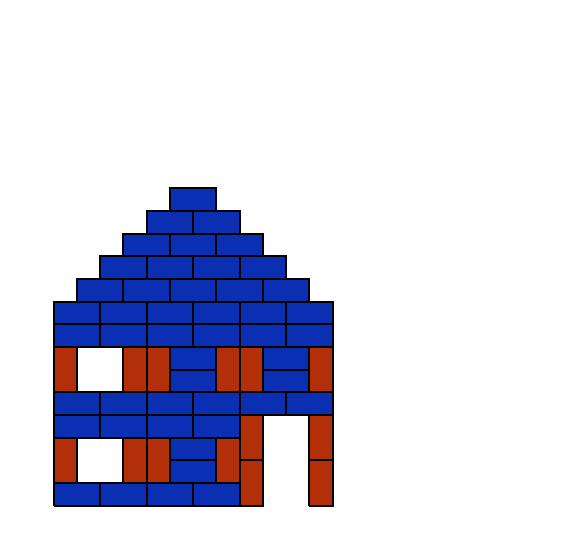

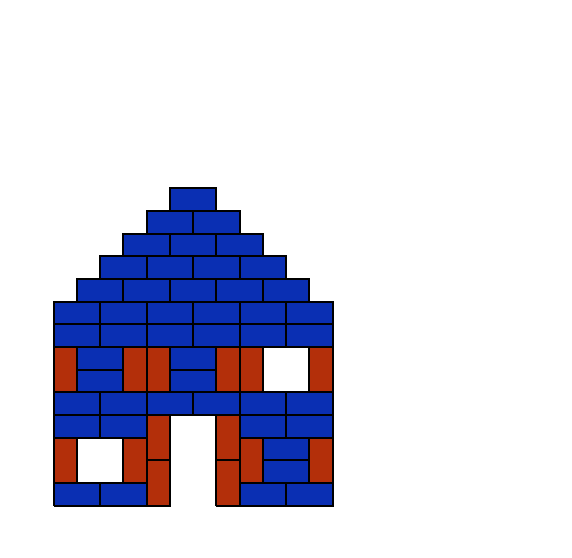

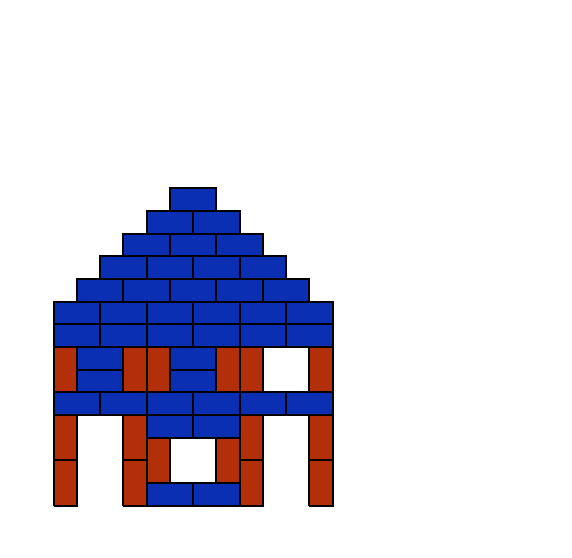

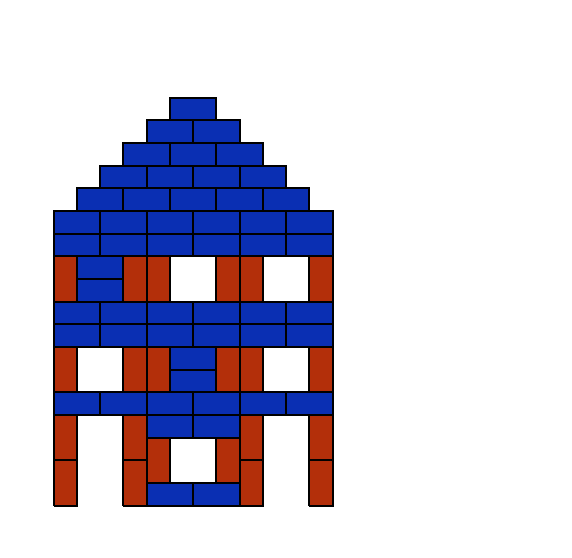

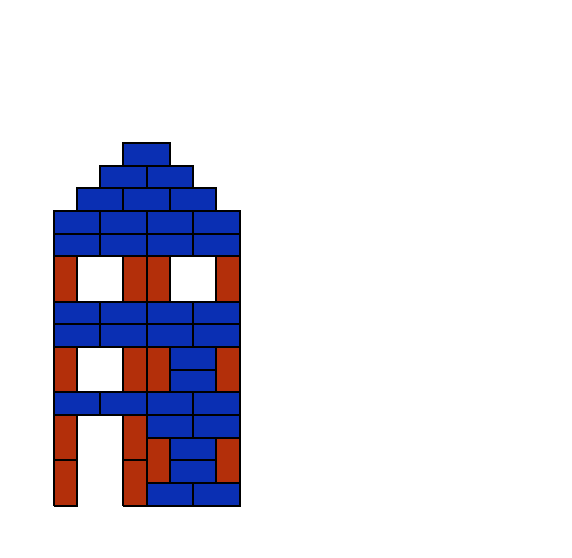

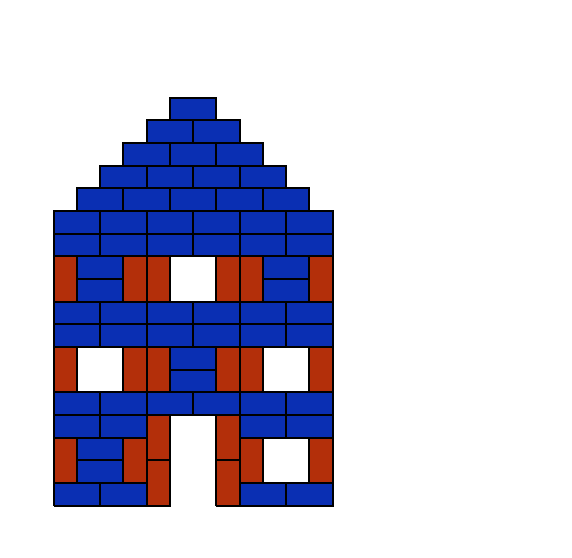

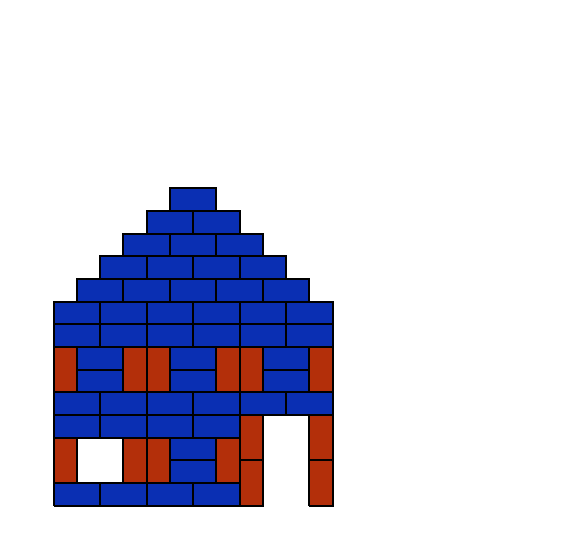

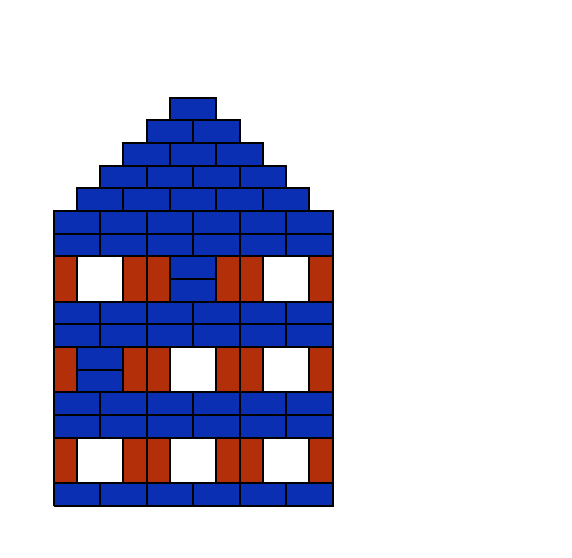

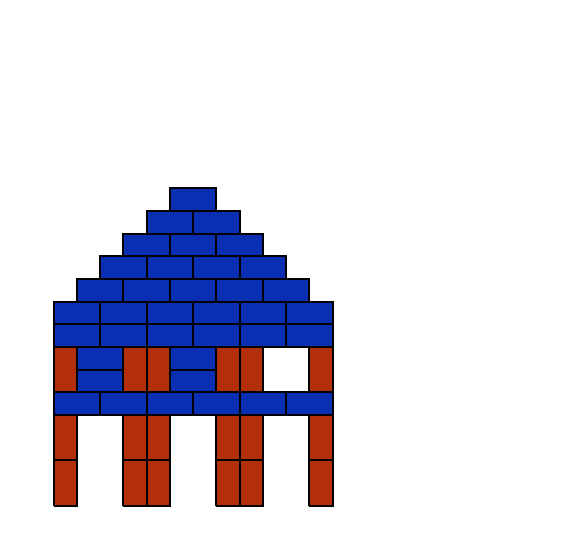

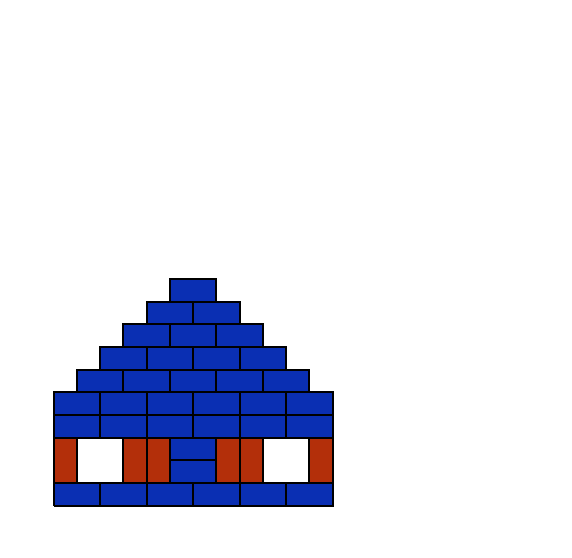

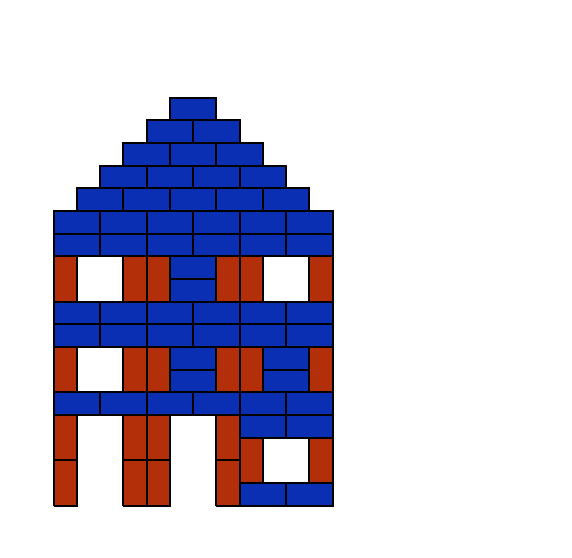

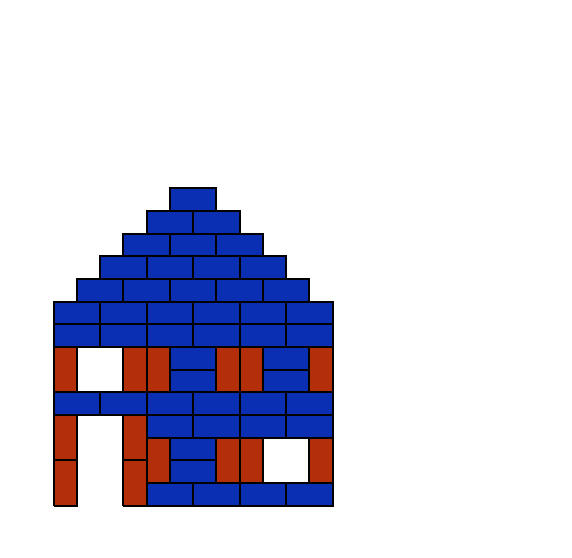

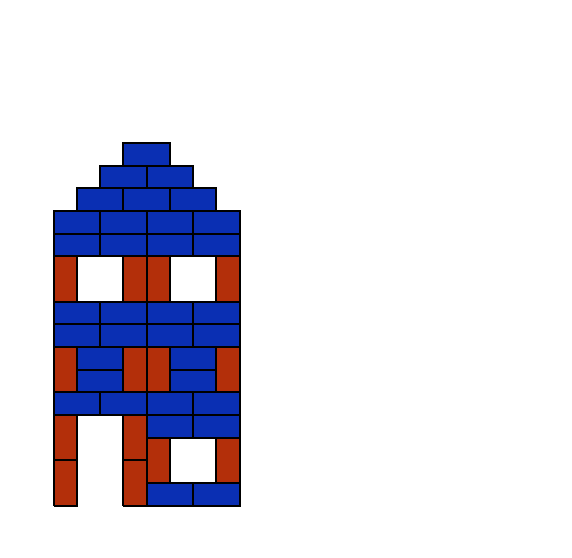

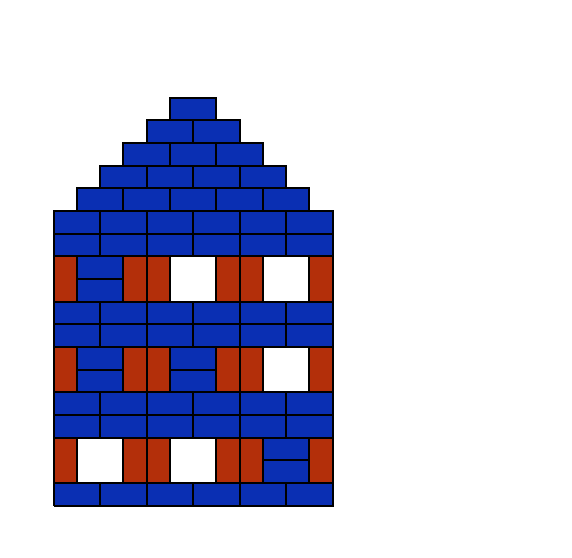

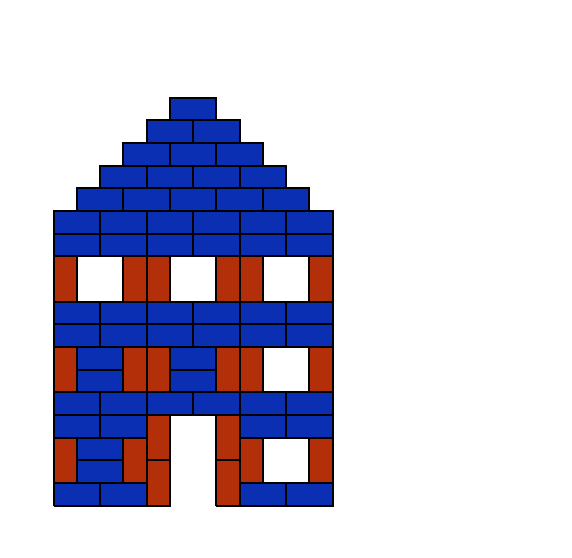

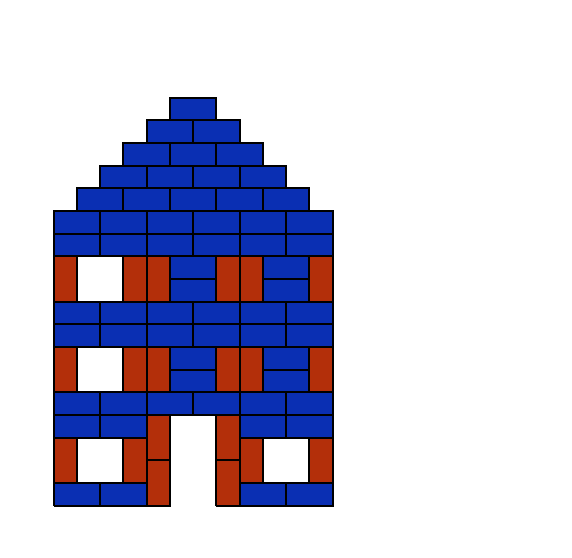

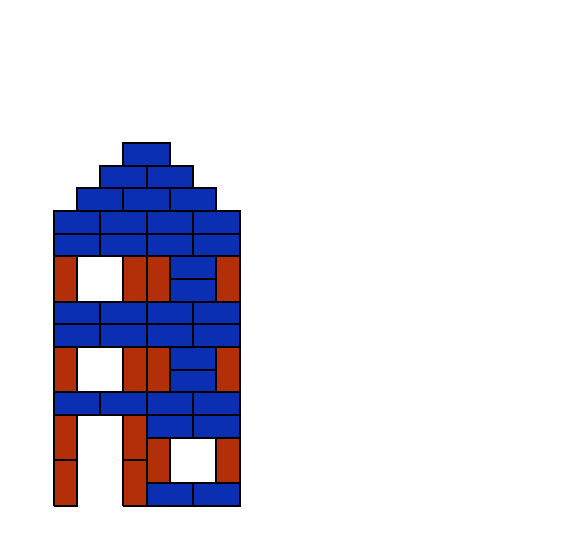

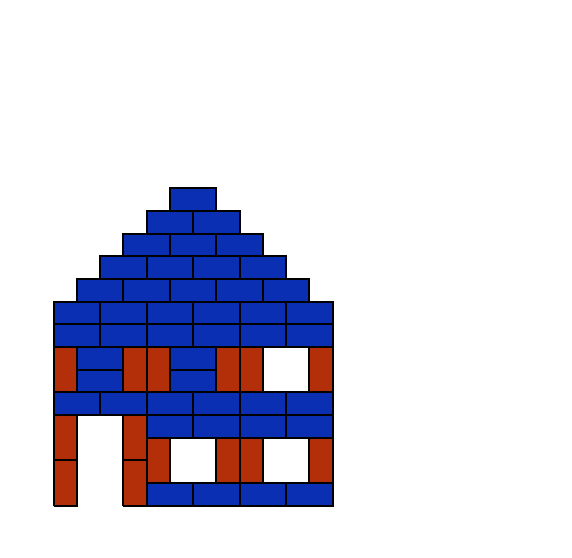

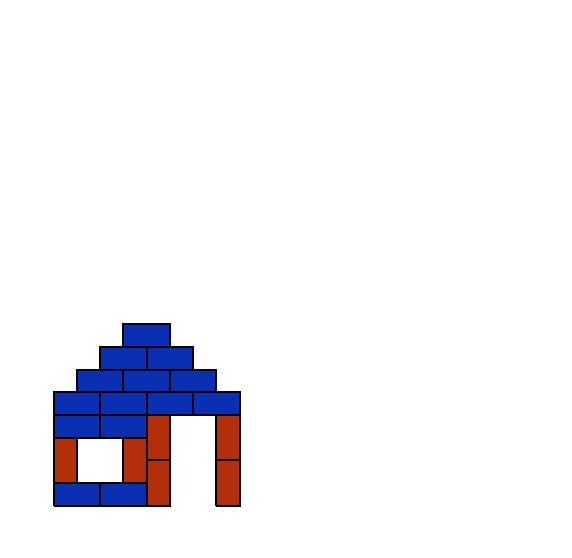

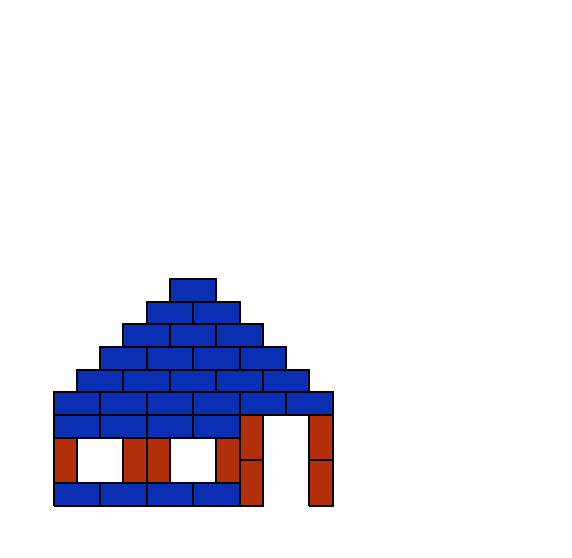

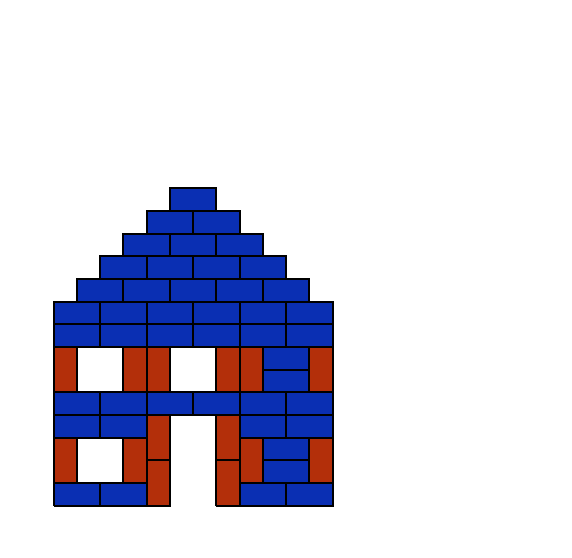

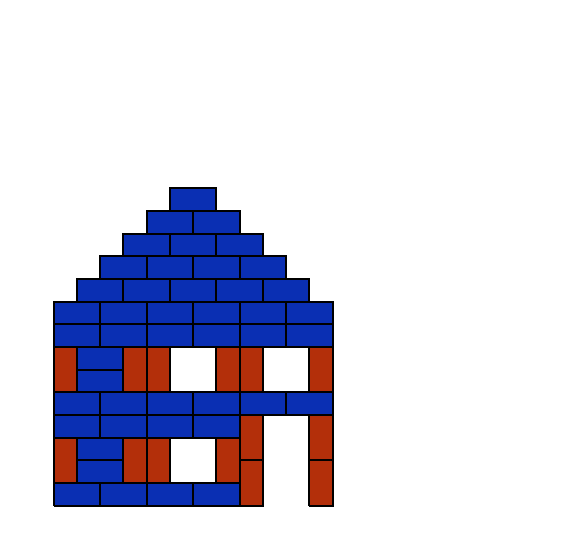

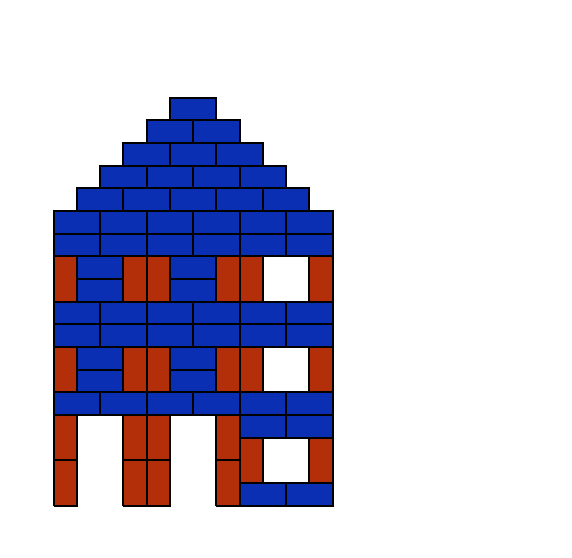

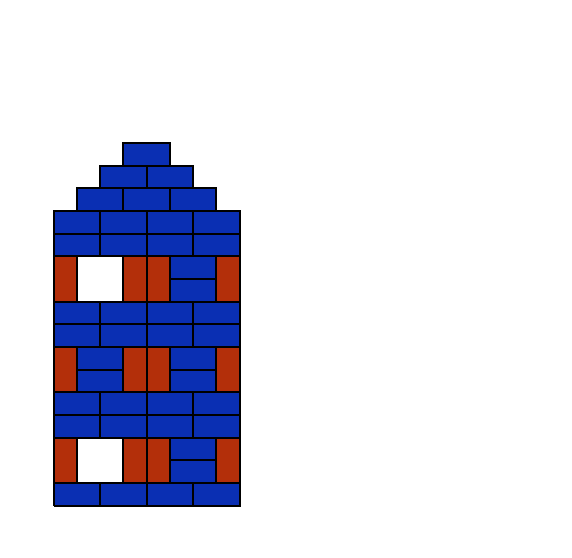

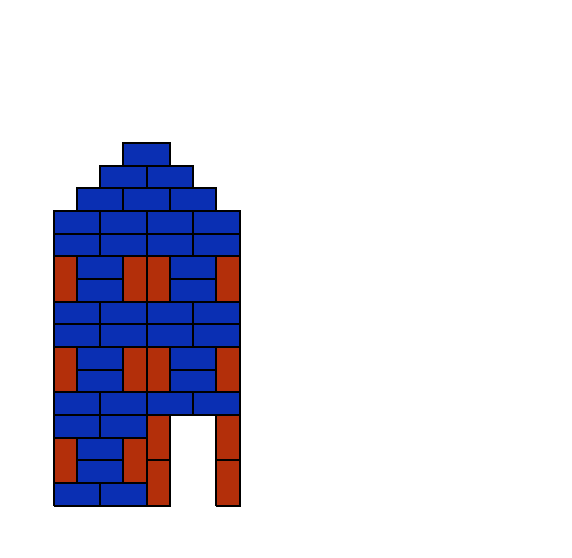

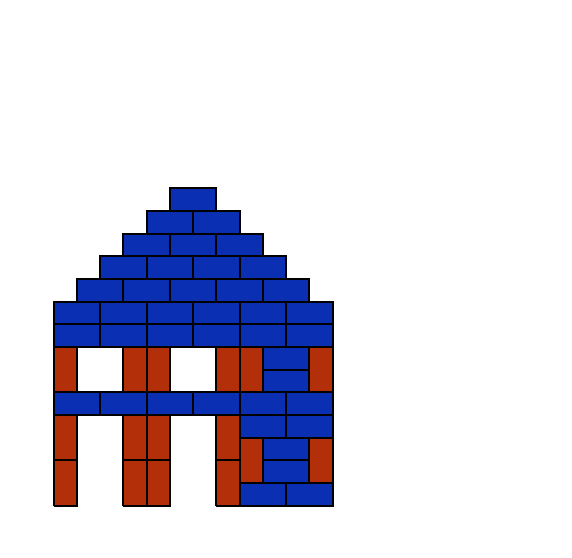

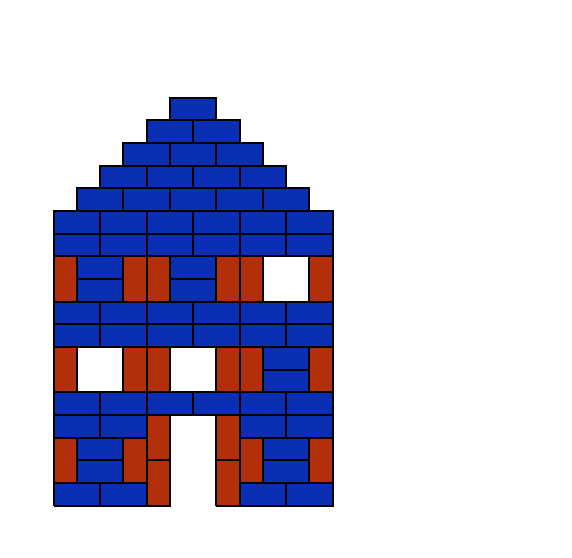

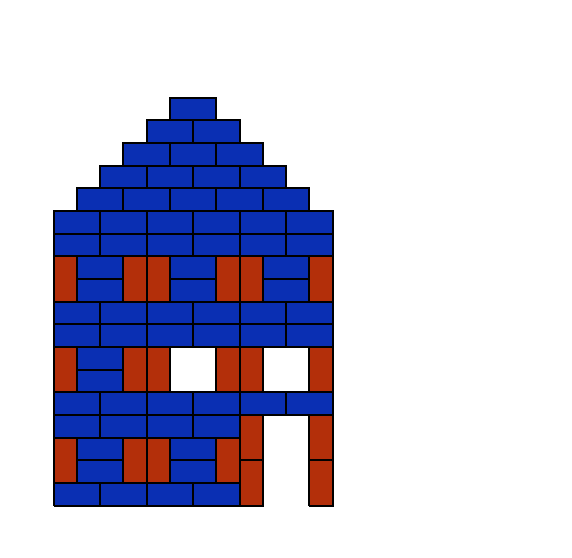

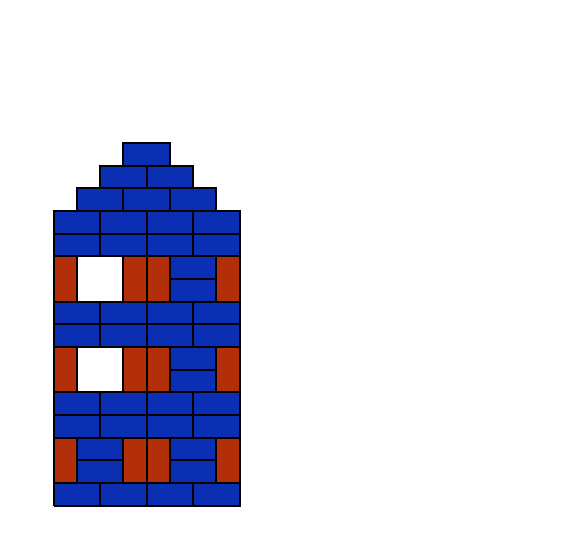

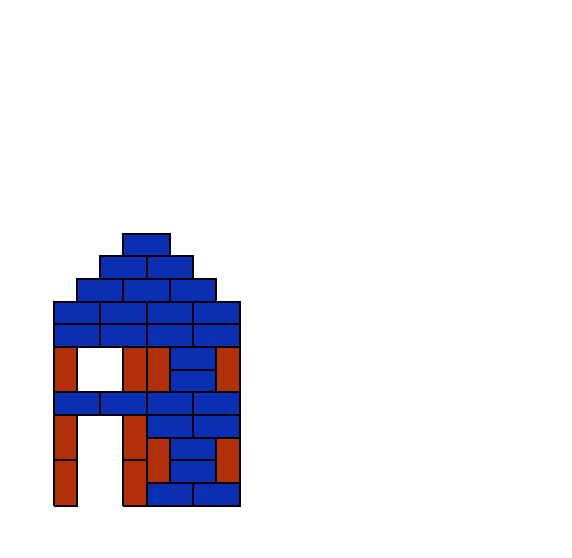

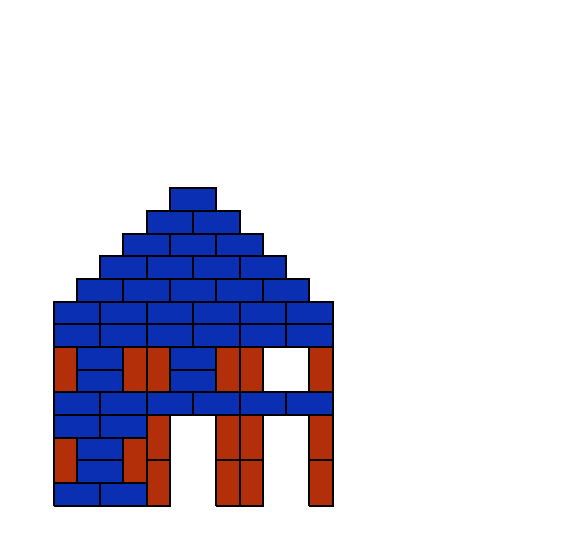

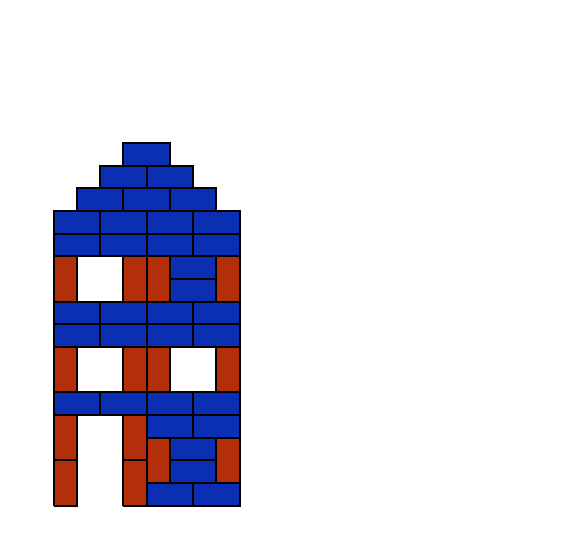

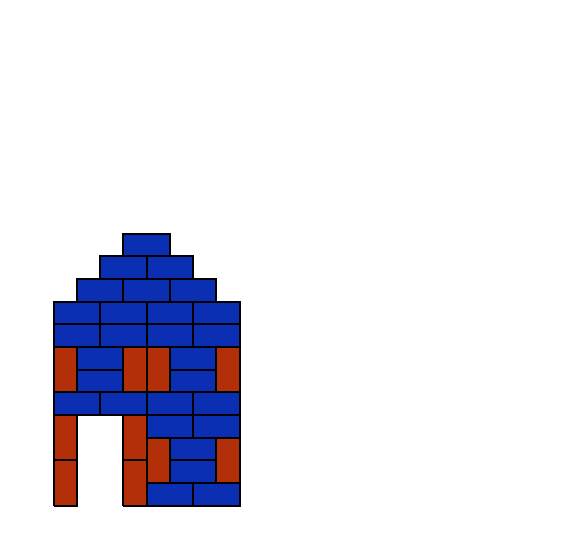

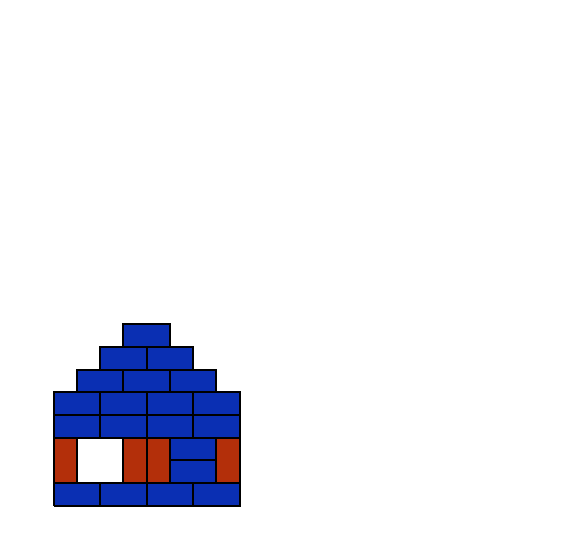

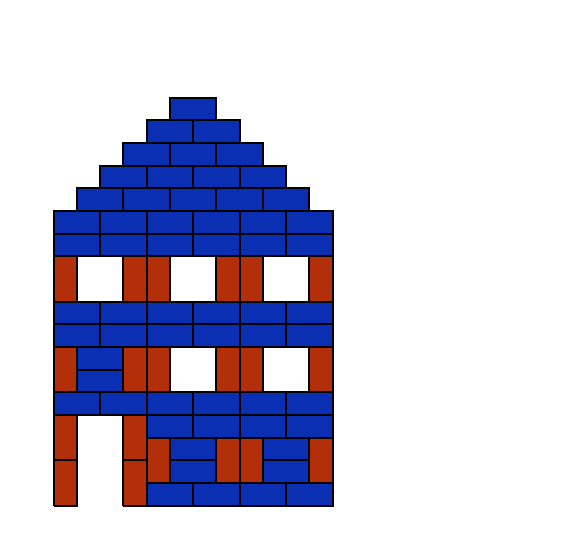

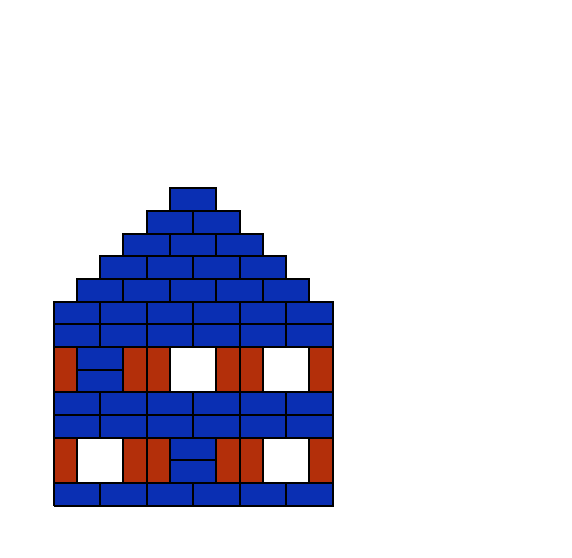

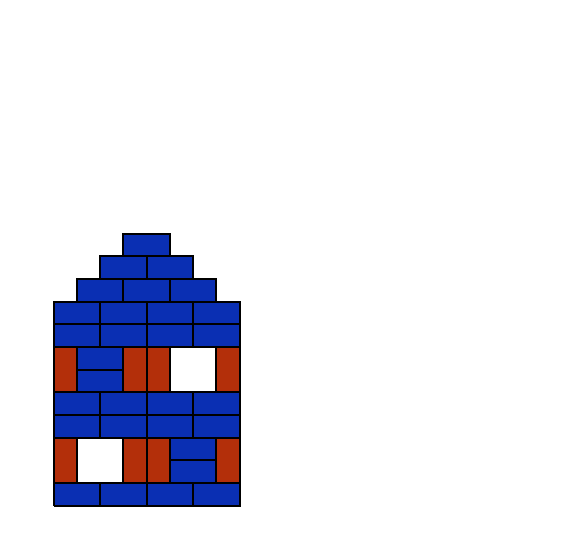

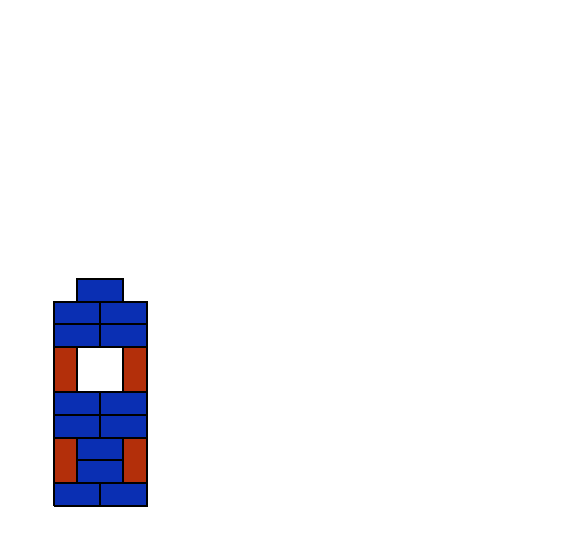

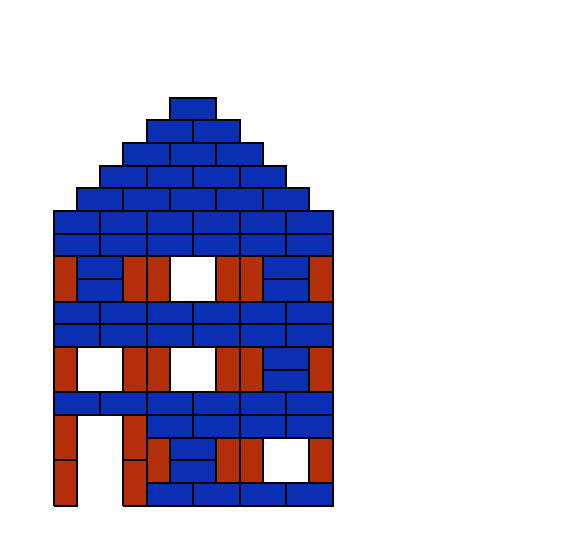

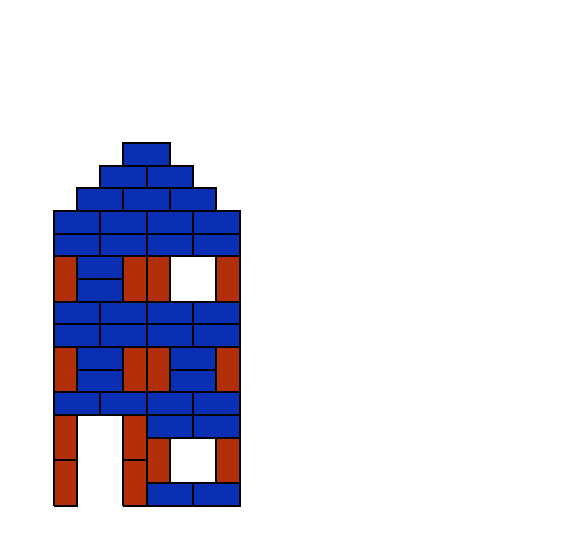

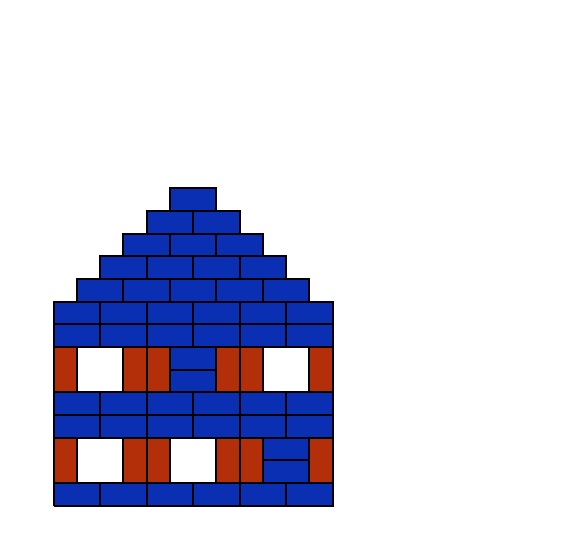

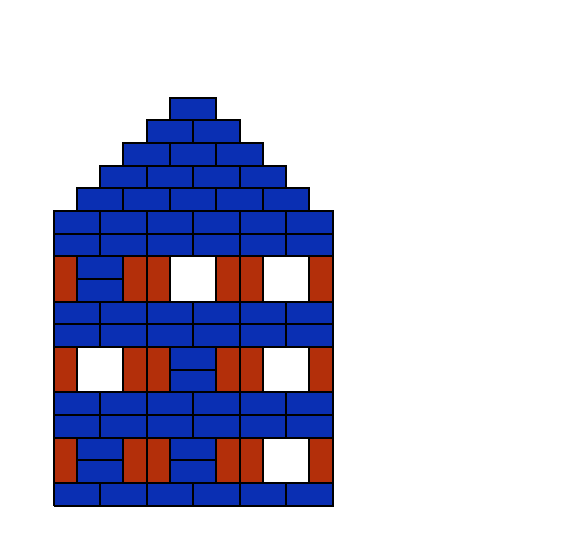

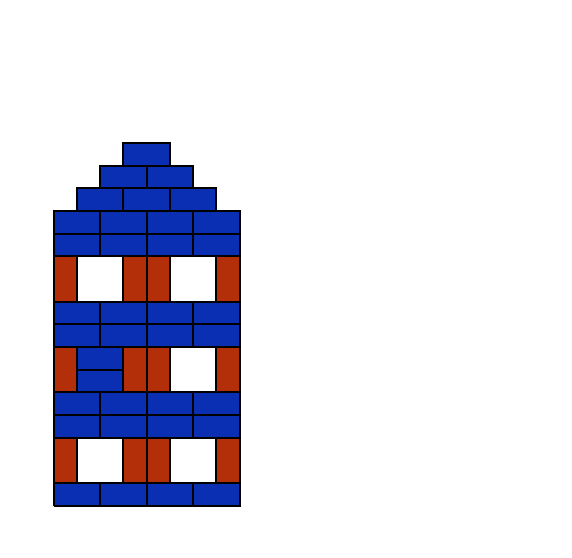

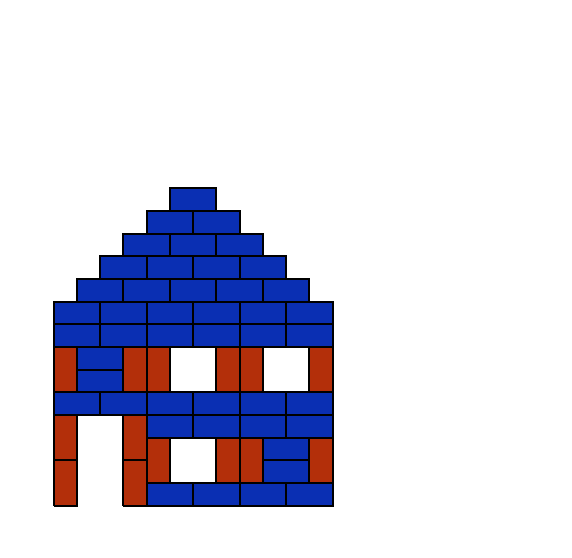

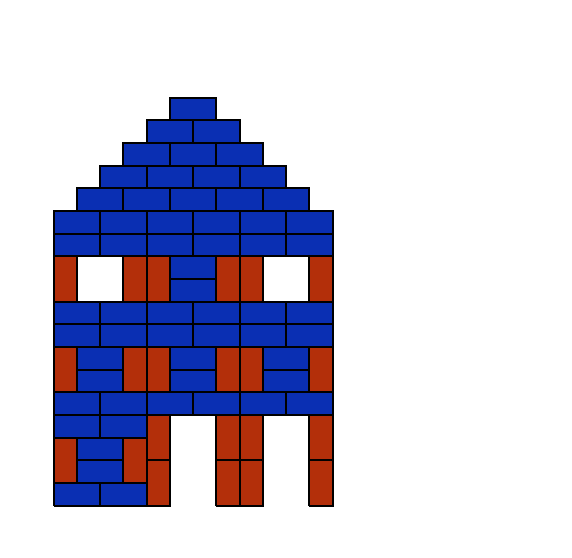

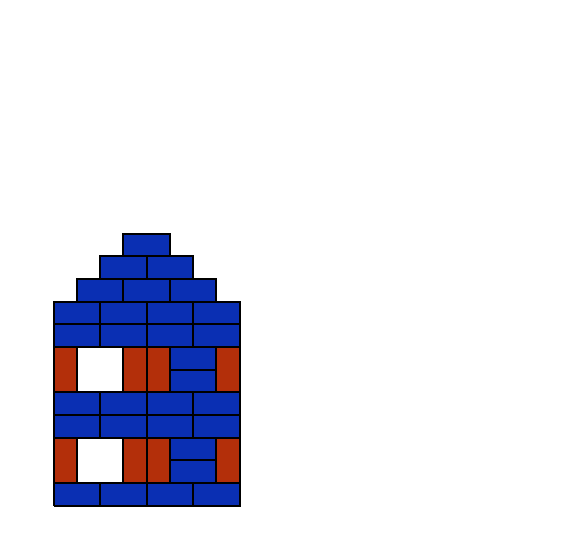

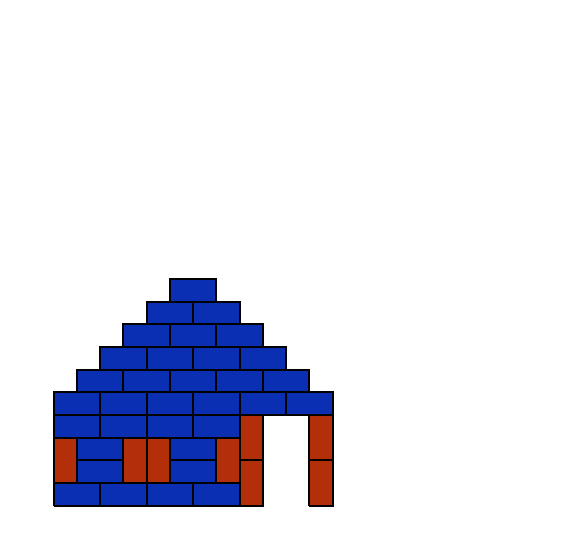

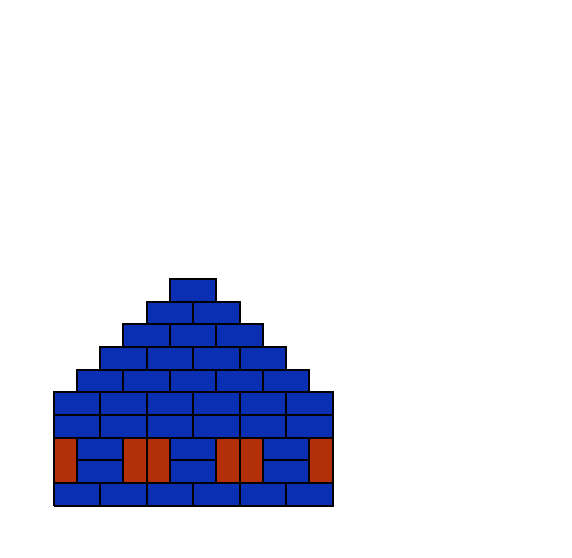

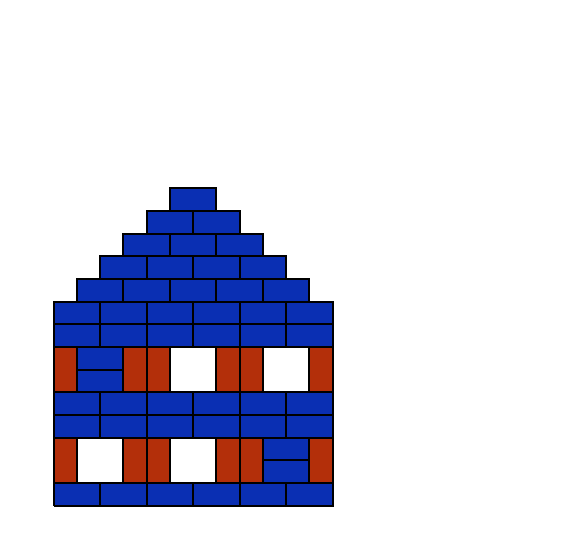

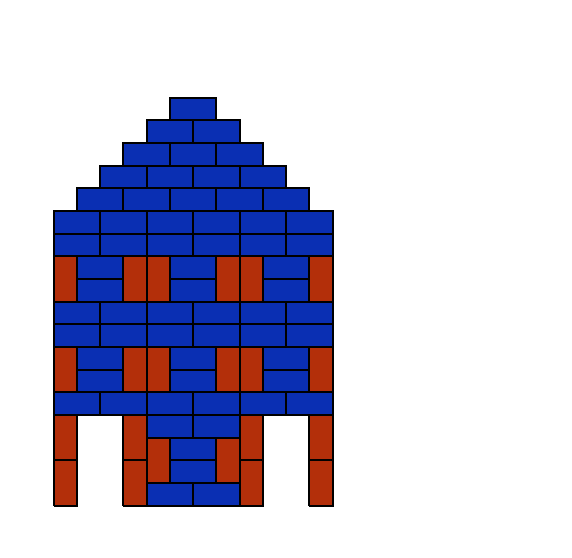

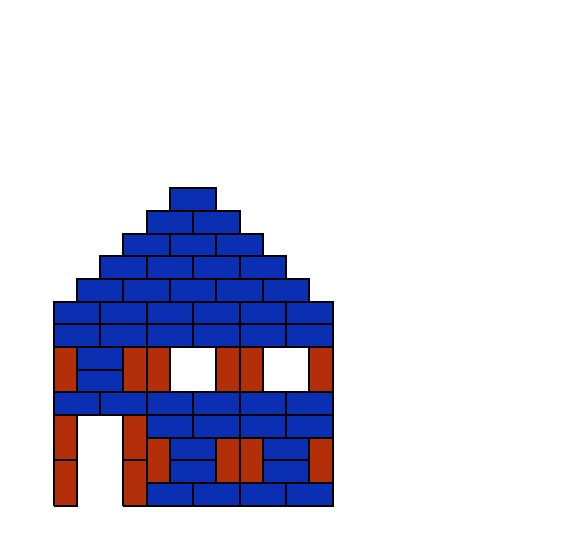

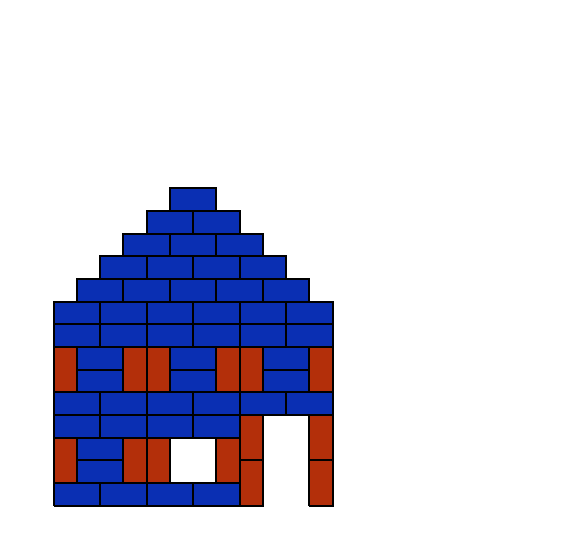

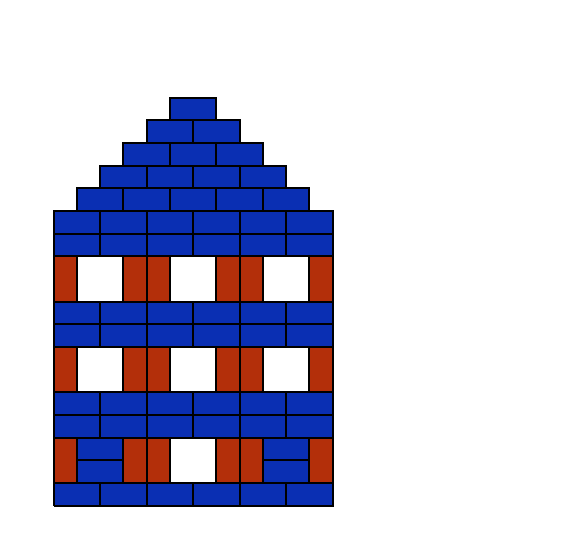

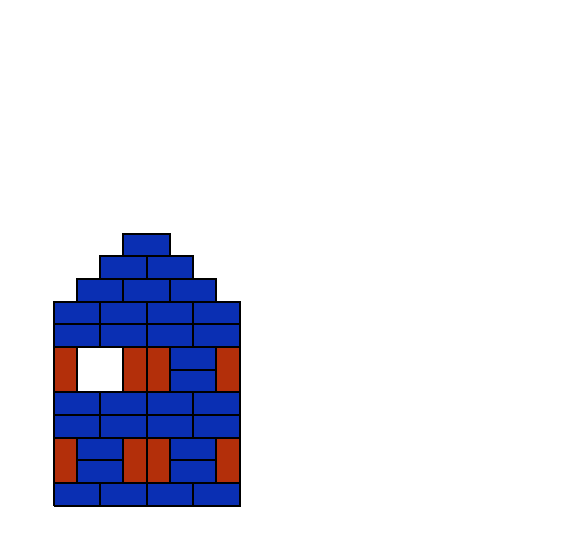

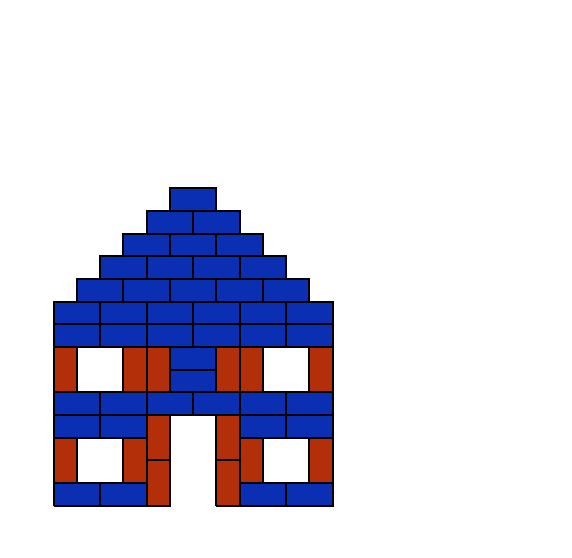

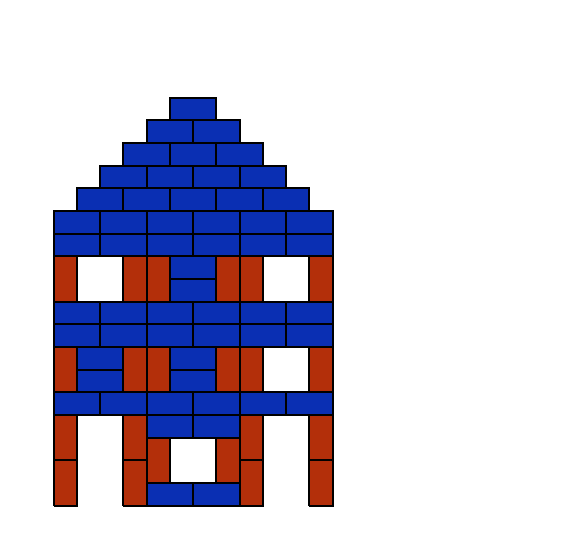

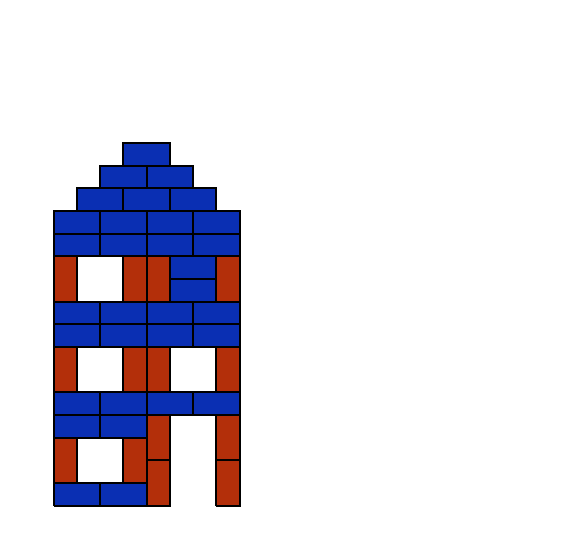

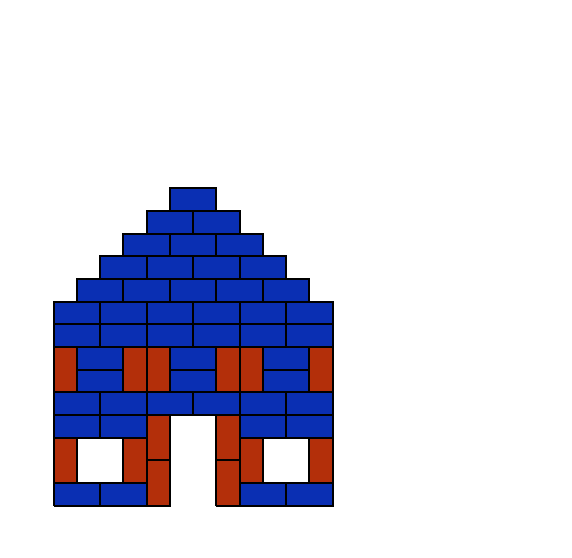

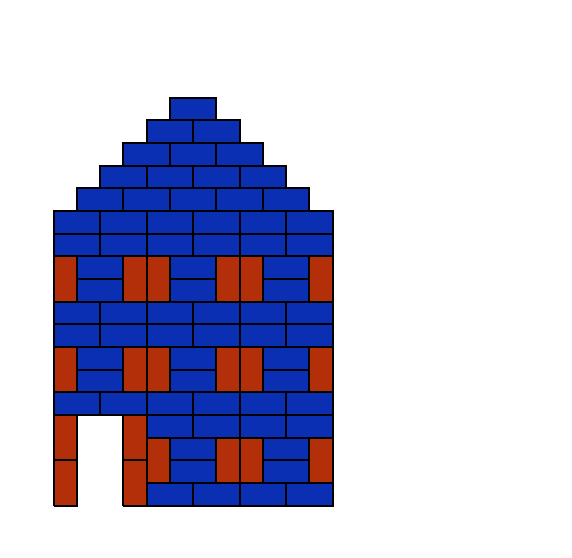

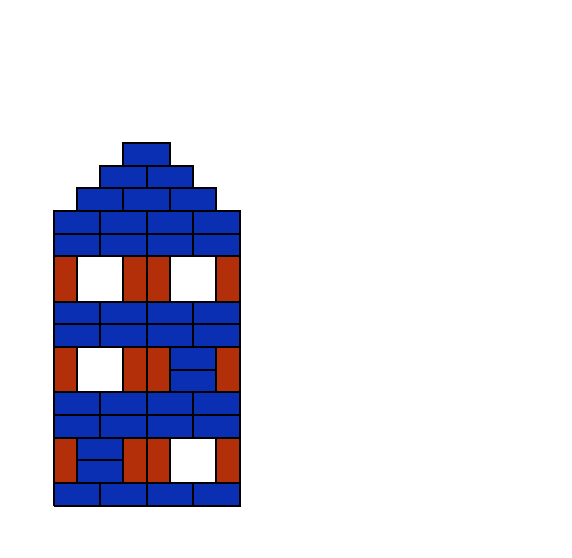

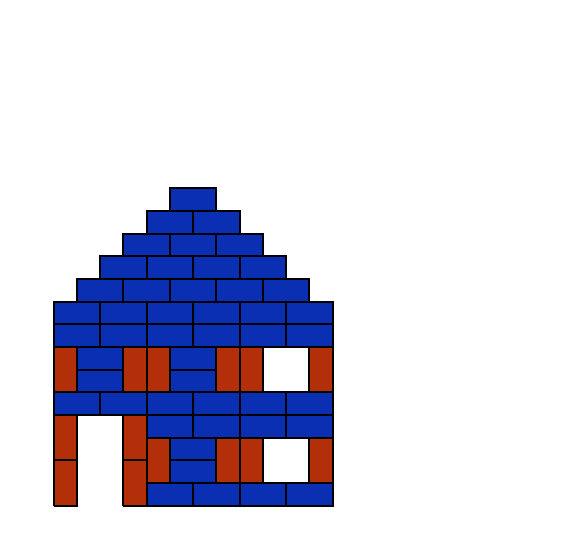

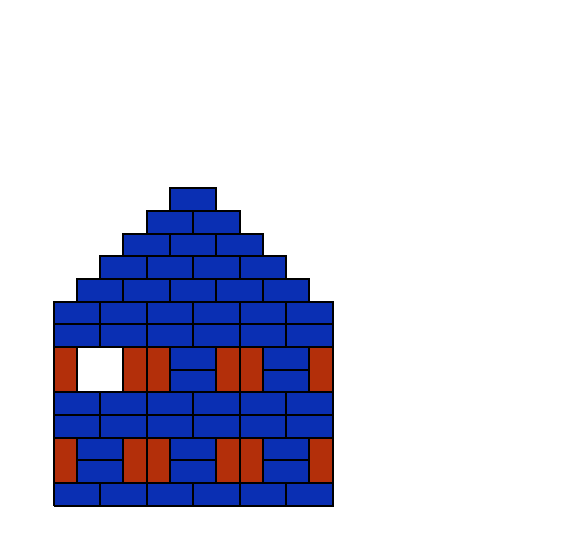

In [440]:
# export to inidividual images

filepath ='./iclr-structures-png/'

if not os.path.exists(filepath):
        os.makedirs(filepath)

for i in df_structures_subset.index:
    w = new_world()
    w.place_tower(df_structures_subset.loc[i,'blocks'])
    fig = utils.draw_world(w)
    fig.savefig("./{}/{}_{}_{}.png".format(filepath,
                                            df_structures_subset.loc[i,'structure_type'], 
                                            str(df_structures_subset.loc[i,'structure_number']).zfill(3),
                                            'train' if df_structures_subset.loc[i,'train'] else 'test'))
    
df_structures_subset.to_csv(filepath + 'df_structures_subset.csv')

In [446]:
# unordered gallery

filepath_in ='./iclr-structures-png/'
filepath_out ='./iclr-structures-gallery/'

if not os.path.exists(filepath_out):
        os.makedirs(filepath_out)

for structure in df_structures_subset['structure_type'].unique():
    
    fig, axes = plt.subplots(50, 5, figsize=(20,200))
    i = 0

    for row in range(0,50):
        for column in range(0,5):

            test_train = 'train' if i < N_TRAIN else 'test'

            image = plt.imread(filepath_in + structure + "_" +str(i).zfill(3) + "_" + test_train +  ".png")

            ax = axes[row, column]
            ax.set_title(str(i) + ", " + test_train)
            ax.axis('off')
            ax.imshow(image)
            i+=1

    plt.show()
    fig.savefig(filepath_out + structure + '_gallery.png', facecolor='w',transparent=False)
    print(structure + ' saved')

KeyboardInterrupt: 

In [447]:
# ordered gallery

structure_order = {}

structure_order['bridge'] = list(df_structures_subset[df_structures_subset.structure_type == 'bridge']\
    .sort_values(['includes_outer_arches', 'n_inner_arch', 'bridge_elevation', 'inner_width', 'structure_height']).structure_number)

structure_order['house'] = list(df_structures_subset[df_structures_subset.structure_type == 'house']\
    .sort_values(['n_stories','house_width']).structure_number)

structure_order['castle'] = list(df_structures_subset[df_structures_subset.structure_type == 'castle']\
    .sort_values(['wall_height','wall_size','tower_height','roof_name']).structure_number)

structure_order['city'] = list(df_structures_subset[df_structures_subset.structure_type == 'city']\
    .sort_values(['skyscraper_1_height', 'skyscraper_2_height', 'structure_height','gap']).structure_number)


In [ ]:
filepath_in ='./iclr-structures-png/'
filepath_out ='./iclr-structures-gallery/'

if not os.path.exists(filepath_out):
        os.makedirs(filepath_out)

for structure in df_structures_subset['structure_type'].unique():
    
    fig, axes = plt.subplots(25, 10, figsize=(40,100))
    i = 0
    

    for row in range(0,25):
        for column in range(0,10):

            structure_num = structure_order[structure][i]

            test_train = 'train' if structure_num < N_TRAIN else 'test'

            image = plt.imread(filepath_in + structure + "_" +str(structure_num).zfill(3) + "_" + test_train +  ".png")

            ax = axes[row, column]
            ax.set_title(str(structure_num) + ", " + test_train)
            ax.axis('off')
            ax.imshow(image)
            i+=1

#     plt.show()
    fig.savefig(filepath_out + structure + '_gallery.png', facecolor='w',transparent=False)
    print(structure + ' saved')

#### Test orderings

In [420]:
df_structures_subset.columns

Index(['index', 'structure_type', 'blocks', 'structure_width',
       'structure_height', 'n_blocks', 'wall_height', 'wall_size',
       'tower_height', 'roof_name', 'central_roof_size', 'tower_roof_size',
       'brick', 'skyscraper_height', 'roof_size', 'repeat_option', 't_1_brick',
       't_2_brick', 'gap', 'roof_1_name', 'roof_2_name', 'skyscraper_1_height',
       'skyscraper_2_height', 'bridge_elevation', 'n_inner_arch',
       'pillar_type', 'inner_width', 'outer_width', 'includes_outer_arches',
       'house_width', 'n_stories', 'dreamcoder_program',
       'program_whole_squares', 'structure_number', 'train'],
      dtype='object')

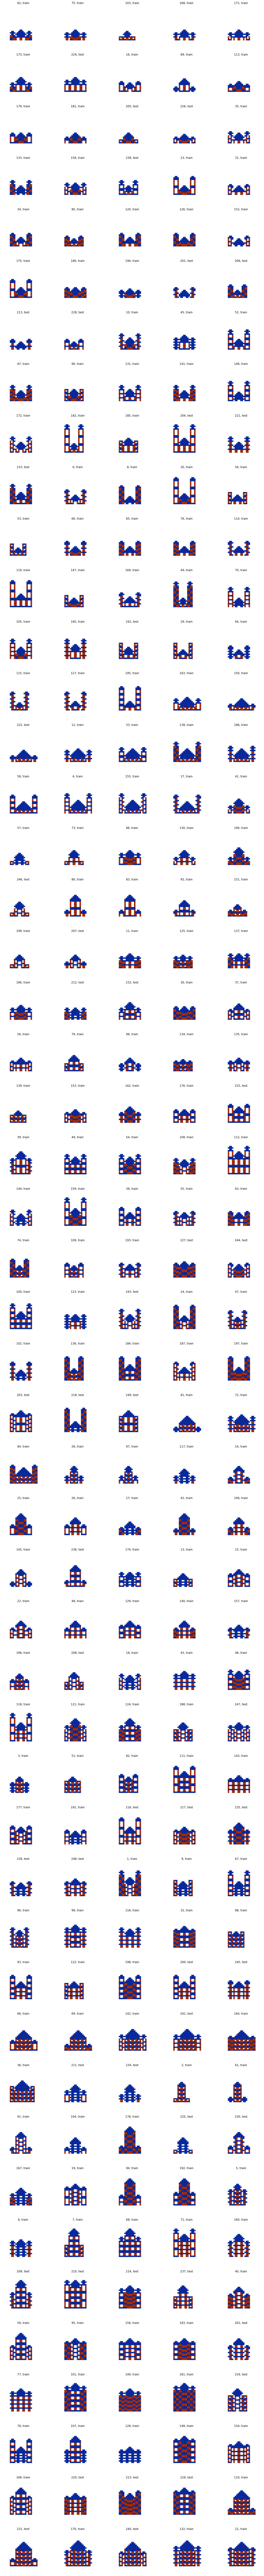

In [442]:
structure = 'castle'

fig, axes = plt.subplots(50, 5, figsize=(20,200))
i = 0

for row in range(0,50):
    for column in range(0,5):
        
        structure_num = structure_order[structure][i]

        test_train = 'train' if structure_num < N_TRAIN else 'test'

        image = plt.imread(filepath_in + structure + "_" +str(structure_num).zfill(3) + "_" + test_train +  ".png")

        ax = axes[row, column]
        ax.set_title(str(structure_num) + ", " + test_train)
        ax.axis('off')
        ax.imshow(image)
        i+=1

plt.show()

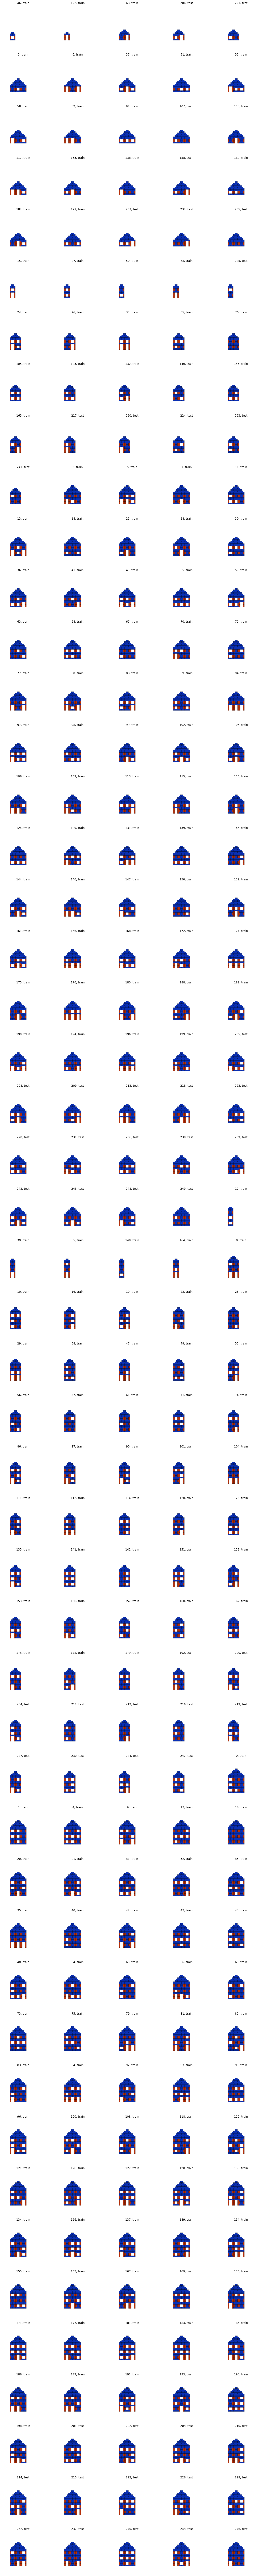

In [443]:
structure = 'house'

fig, axes = plt.subplots(50, 5, figsize=(20,200))
i = 0

for row in range(0,50):
    for column in range(0,5):
        
        structure_num = structure_order[structure][i]

        test_train = 'train' if structure_num < N_TRAIN else 'test'

        image = plt.imread(filepath_in + structure + "_" +str(structure_num).zfill(3) + "_" + test_train +  ".png")

        ax = axes[row, column]
        ax.set_title(str(structure_num) + ", " + test_train)
        ax.axis('off')
        ax.imshow(image)
        i+=1

plt.show()